In [1]:
import sys
sys.path.append('PyGazeAnalyser-master\\pygazeanalyser')

#pygaze imports
#from pygaze import *
from edfreader import *
from gazeplotter import *

#other python libs import
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

#csv import 
import csv
import cv2

### CSV File

'1'

In [16]:
partic_id = 'G036'
game_nr  = 1
trial_nr = 1

print(partic_id[-2:])

36


### Particpant ID: G036

#### Using Gazeplotter

In [17]:
#participant details
partic_id = 'G036'
game_nr  = 4

#read data using read_edf function
fname = 'Participant Data/'+str(partic_id)+ '/' + str(partic_id) + \
         str('_') + str(game_nr) + str('.asc') #path of the ASC file

# Stimulus phase
start_message = 'SYNCTIME'
stop_message = 'CC'
data = read_edf(fname,start='SYNCTIME',stop='CC') #start and stop indicators can be found in the ASC file

def read_data(partic_id,game_nr,phase='stimulus'):
    """
    three phases: fixation, stimulus, reward
    
    """
    fname = 'Participant Data/'+str(partic_id)+ '/' + str(partic_id) + \
             str('_') + str(game_nr) + str('.asc') #path of the ASC file

    if phase =='stimulus':
        start_message = 'SYNCTIME'
        stop_message = 'CC'
    elif phase =='fixation':
        start_message = 'TRIALID'
        stop_message = 'SYNCTIME'
    elif phase =='reward':
        start_message = 'CC'
        stop_message = 'TRIALEND'
    data = read_edf(fname,start=start_message,stop=stop_message) #start and stop indicators can be found in the ASC file
    return data

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


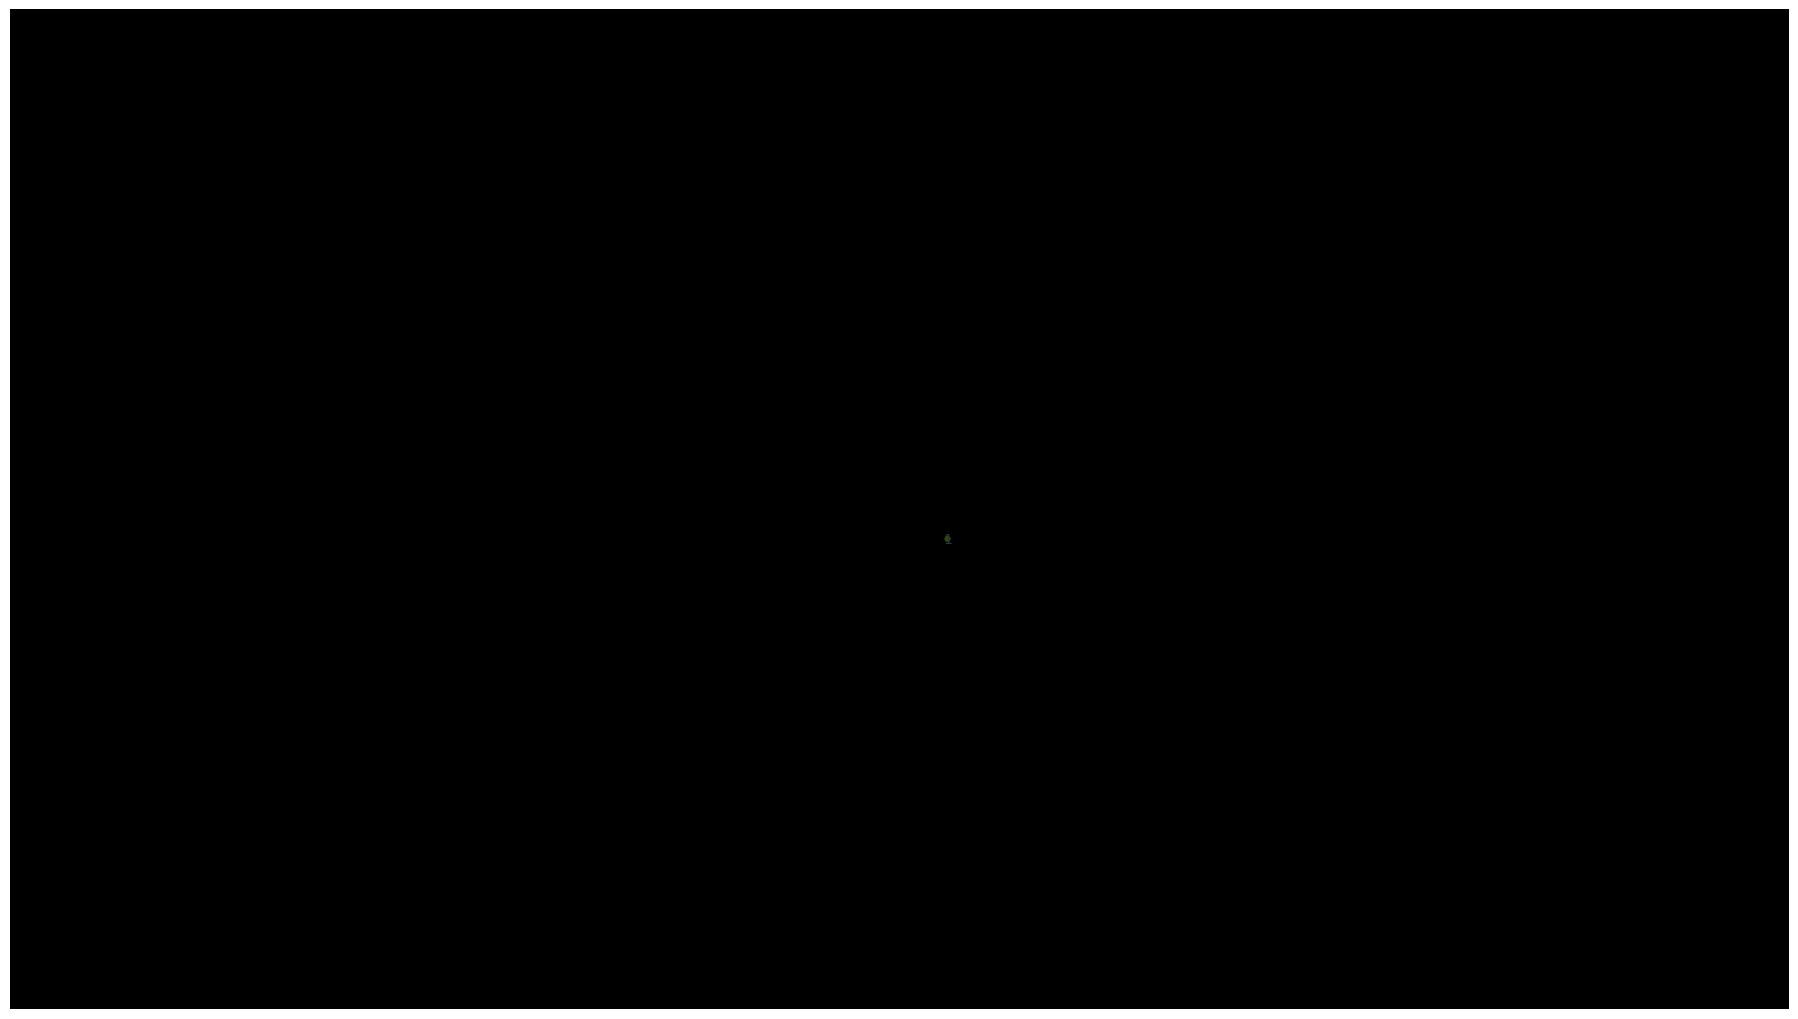

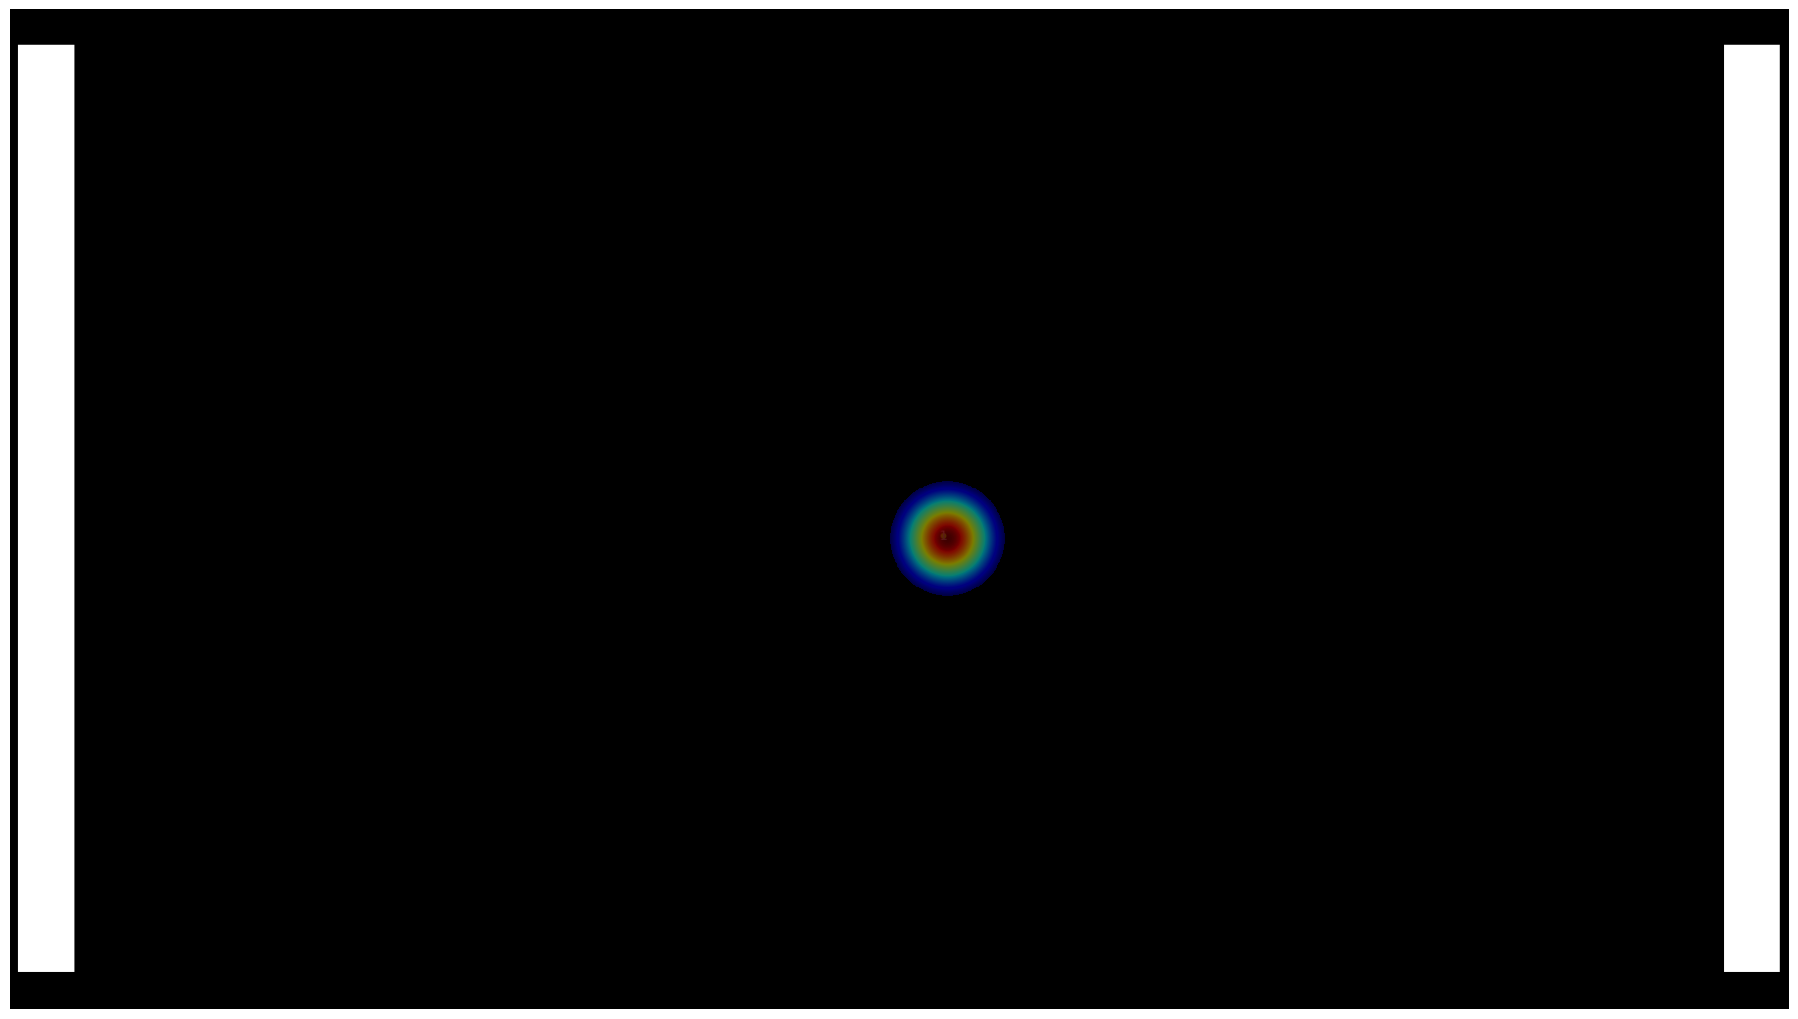

In [18]:

trial_nr = 12
#saccades and fixations
saccades = np.array(data[trial_nr]['events']['Esac'])
fixations = np.array(data[trial_nr]['events']['Efix'])
dispsize= (1919,1079) # (px,px) size of screen 

# draw saccadic scanpath and save fig

#saves as id+game_nr+trial_nr+current date time
savefilename = 'output_images/' + str(partic_id) + '_game_'+str(game_nr)+'_' \
               + str(trial_nr) + '_'+ time.strftime("%Y%m%d-%H%M%S")
fig = draw_scanpath(fixations, saccades, dispsize, imagefile=None, alpha=0.5, savefilename=savefilename)

#draw heatmap on top of it
img_file = savefilename + '.png'
fig_heatmap = draw_heatmap(fixations, dispsize, imagefile=img_file)
img_heatmap_file = savefilename + '_heatmap'
fig_heatmap.savefig(img_heatmap_file)



### Estimating Crosshair Position from Fixation Phase

In [19]:
def return_cross_pos(partic_id,game_nr,trial_nr):
    """
    Returns the averaged cross_hair position as calculated from the
    fixation time
    
    
    @Input:
    data : data during fixation time
    
    """
    
    fname = 'Participant Data/'+str(partic_id)+ '/' + str(partic_id) + \
         str('_') + str(game_nr) + str('.asc') #path of the ASC file
    data = read_edf(fname,start='TRIALID',stop='SYNCTIME') #fixation time
    Efix = np.array(data[trial_nr]['events']['Efix'])
    
    #check if Efix is 2D 
    if len(Efix.shape)>1:
        x_mean,y_mean = np.mean(Efix[:,-2]),np.mean(Efix[:,-1])
    
    elif Efix.size==0:
        x_mean,y_mean = 0, 0 # 0,0 for no Efix value
    
    else:
        x_mean,y_mean = Efix[-2:]

    return x_mean, y_mean

### OpenCV Manipulations 


In [37]:
def return_centroid_heatmap(image_load):
    """
    Finds circular contours in the image and returns the center
    
    @Input: image_load: Input image of the heatmap
    
    Returns: center (x,y); image_out (image with contours)
    """
    ## find number of blobs 

    #threshold
    _,thresh_image = cv2.threshold(image_load,10,255,cv2.THRESH_BINARY)#+cv2.THRESH_OTSU)cv2.threshold(img_gray, thresh, 150, 255, THRESH_BINARY);
    contours, hierarchy = cv2.findContours(thresh_image,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


    center_list = [] #relevant contours 
    radius_list = [] #relevant radii 
    for cnt in contours:
        #check for circle enclosing contour
        (x,y),radius = cv2.minEnclosingCircle(cnt)
        center = (int(x),int(y))
        radius = int(np.ceil((radius)))

        if radius <100:
            #draw circular contours
            cv2.circle(image_load,center,radius,(255,255,0),2)
            center_list.append([x,y])
            radius_list.append(radius)
            #cv2.drawContours(image_load,cnt,contourIdx=-1, color=(255, 255, 0), thickness=2,\
                         #lineType=cv2.LINE_AA)
        print(radius_list)
    
    return np.array(center_list),radius_list,image_load


In [38]:
## TESTING THE ABOVE FN
image_load = cv2.imread(img_heatmap_file+'.png',0)
center,image_out = return_centroid_heatmap(image_load)

plt.imshow(image_out,cmap='gray')
print('center :',center)

[54]
[54]
[54]
[54]
[54]


ValueError: too many values to unpack (expected 2)

### Plot - 'Inattention' vs Trial No

c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


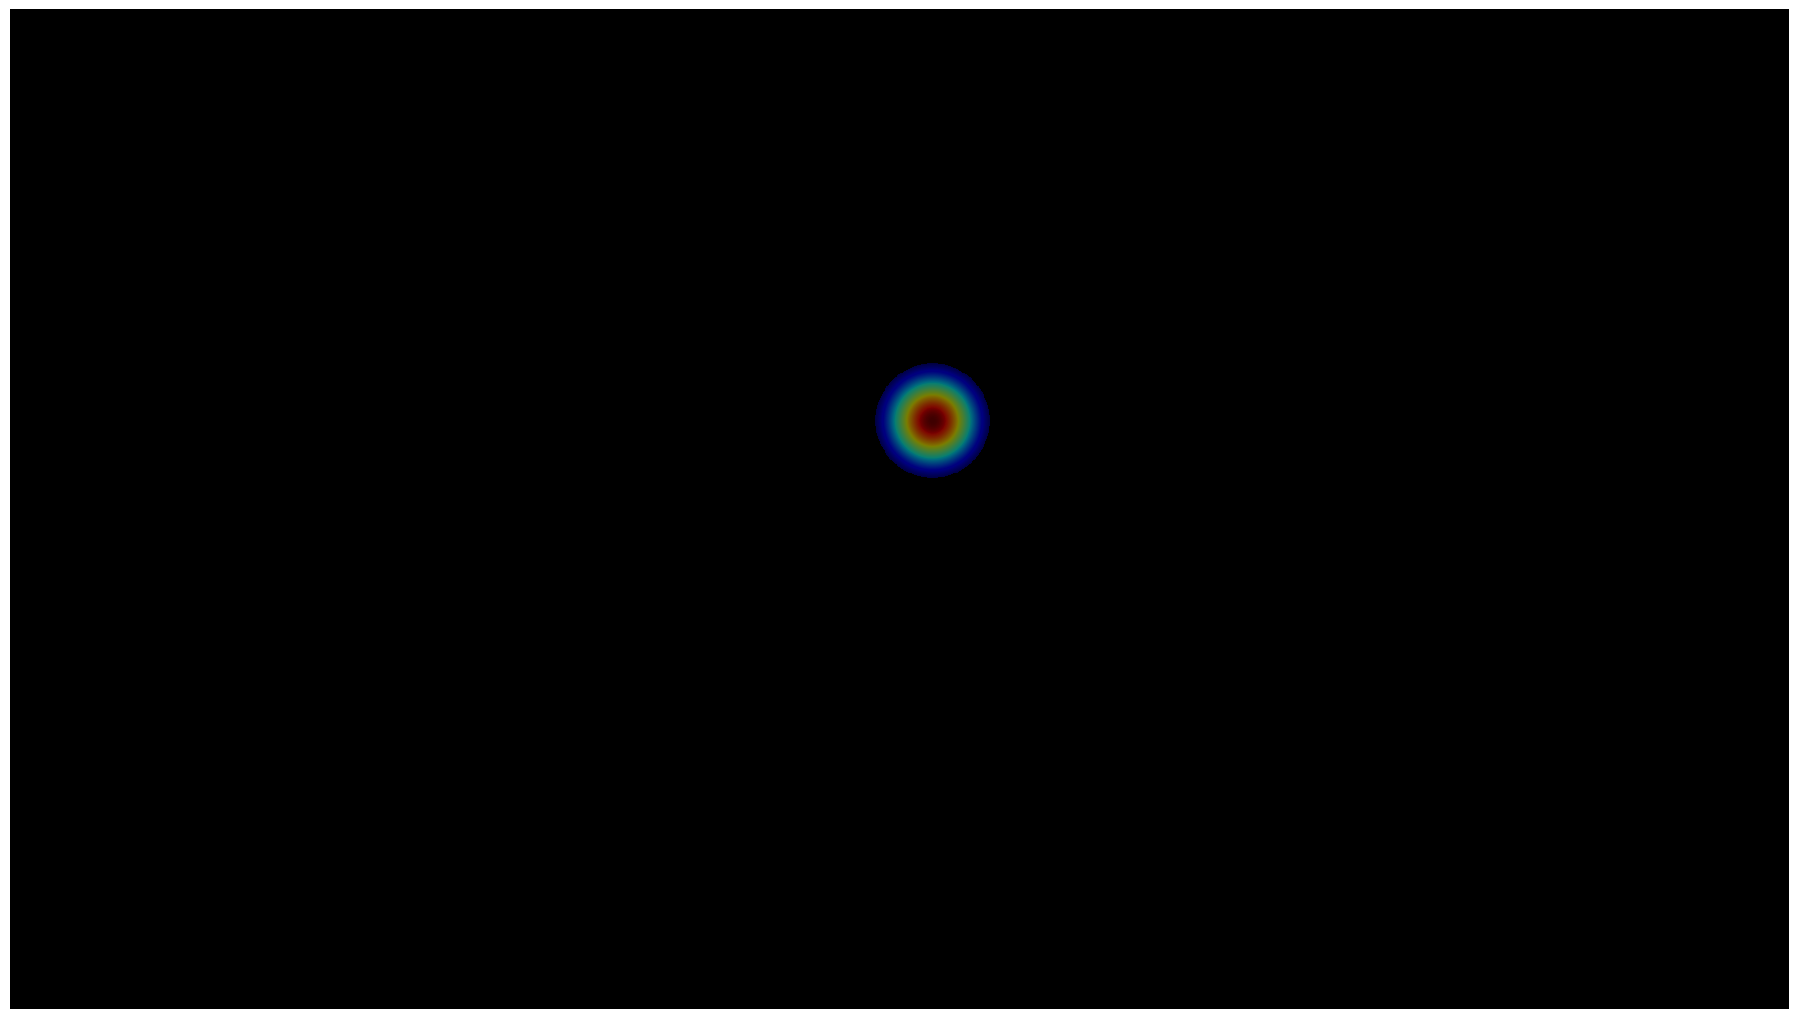

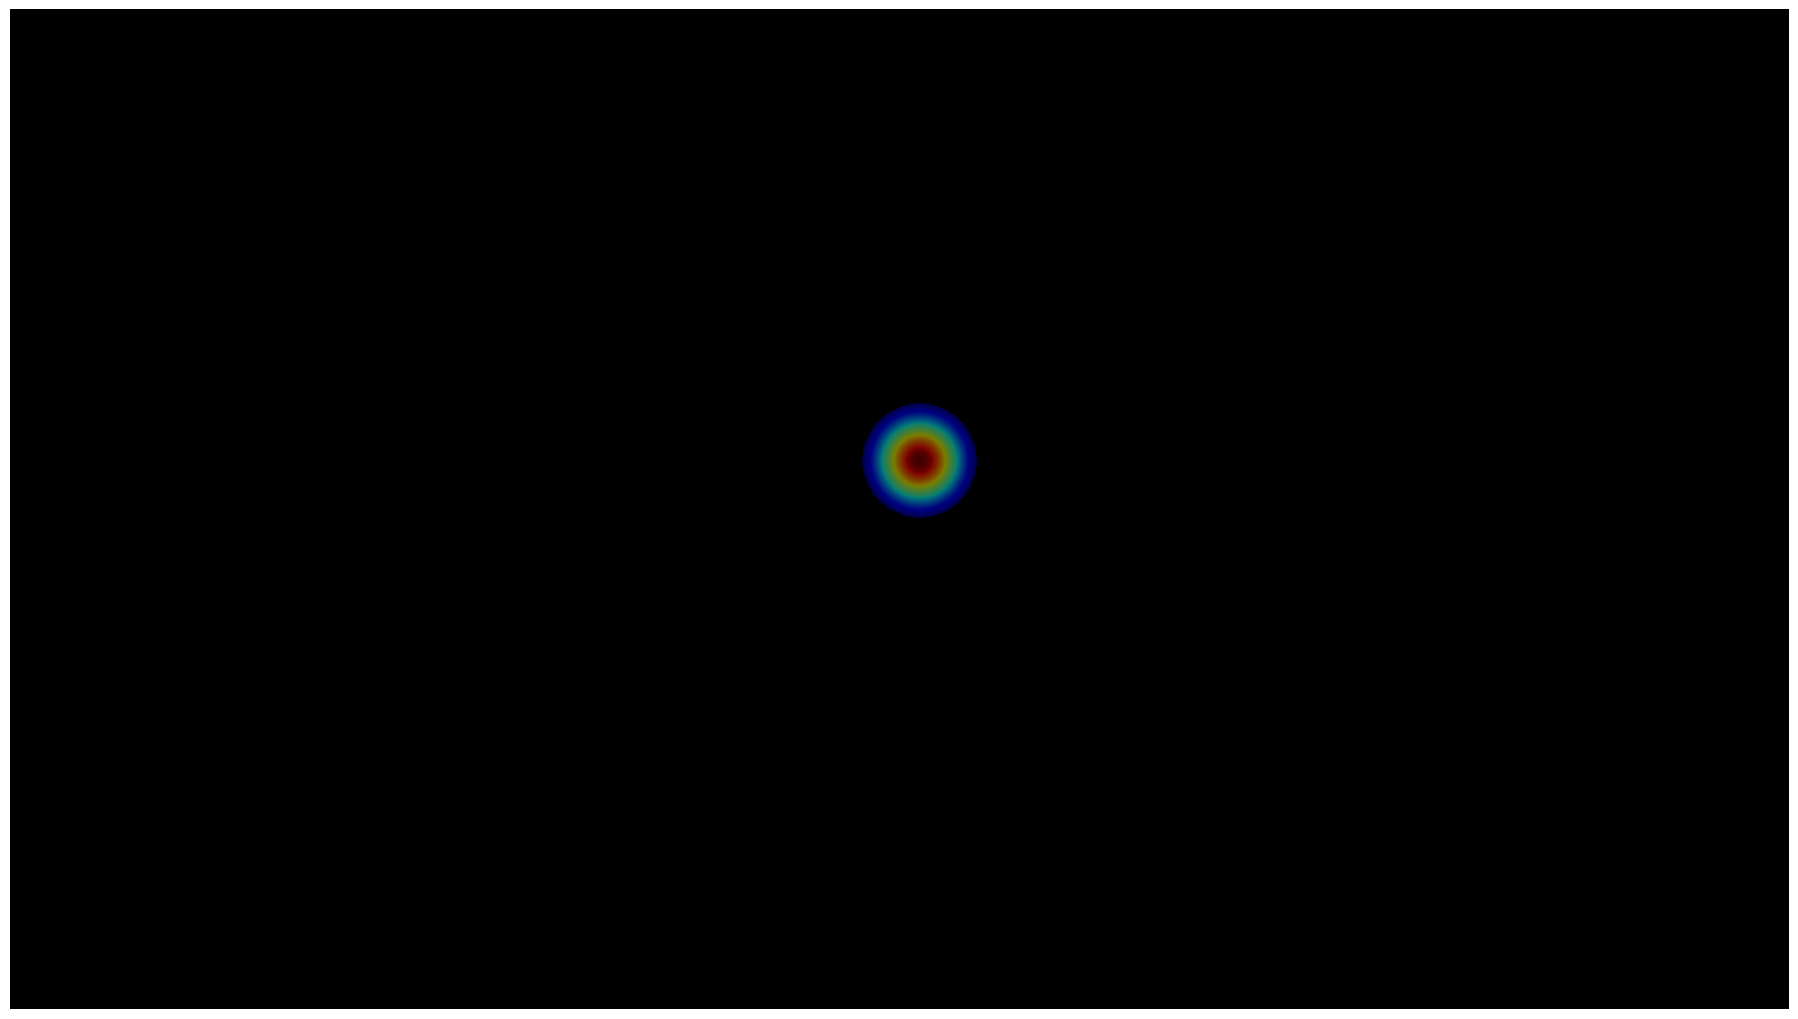

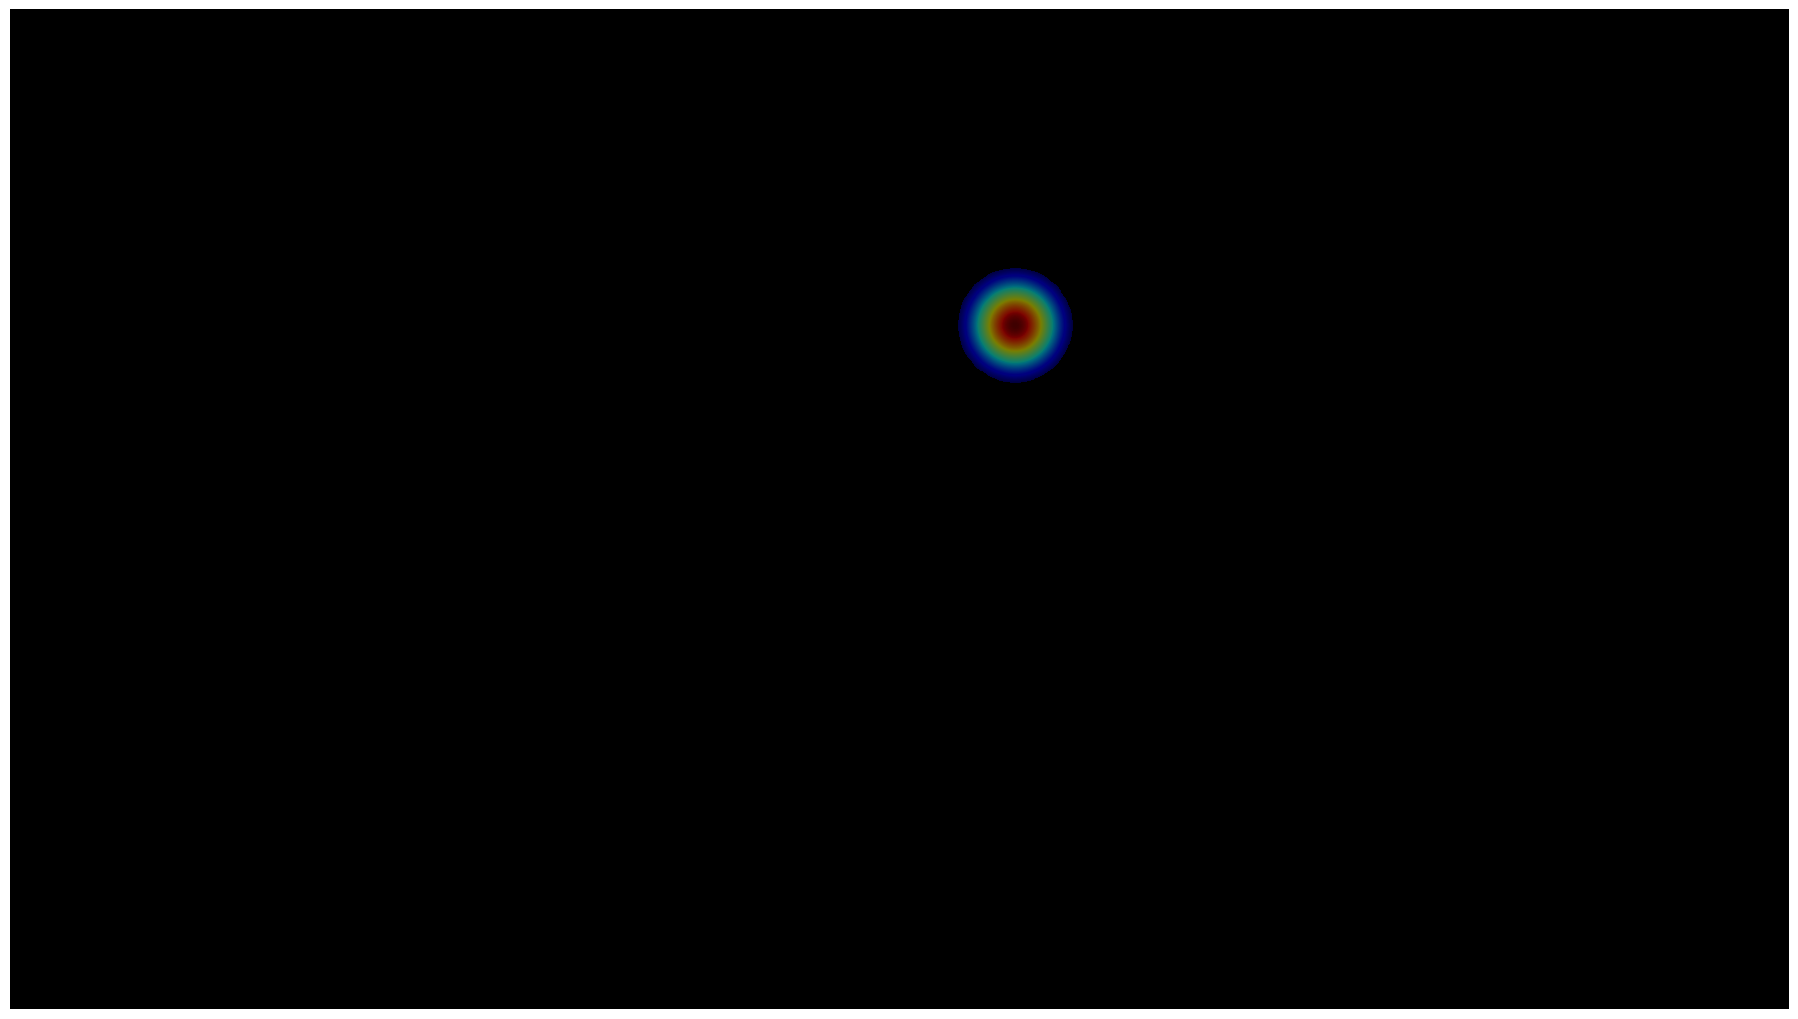

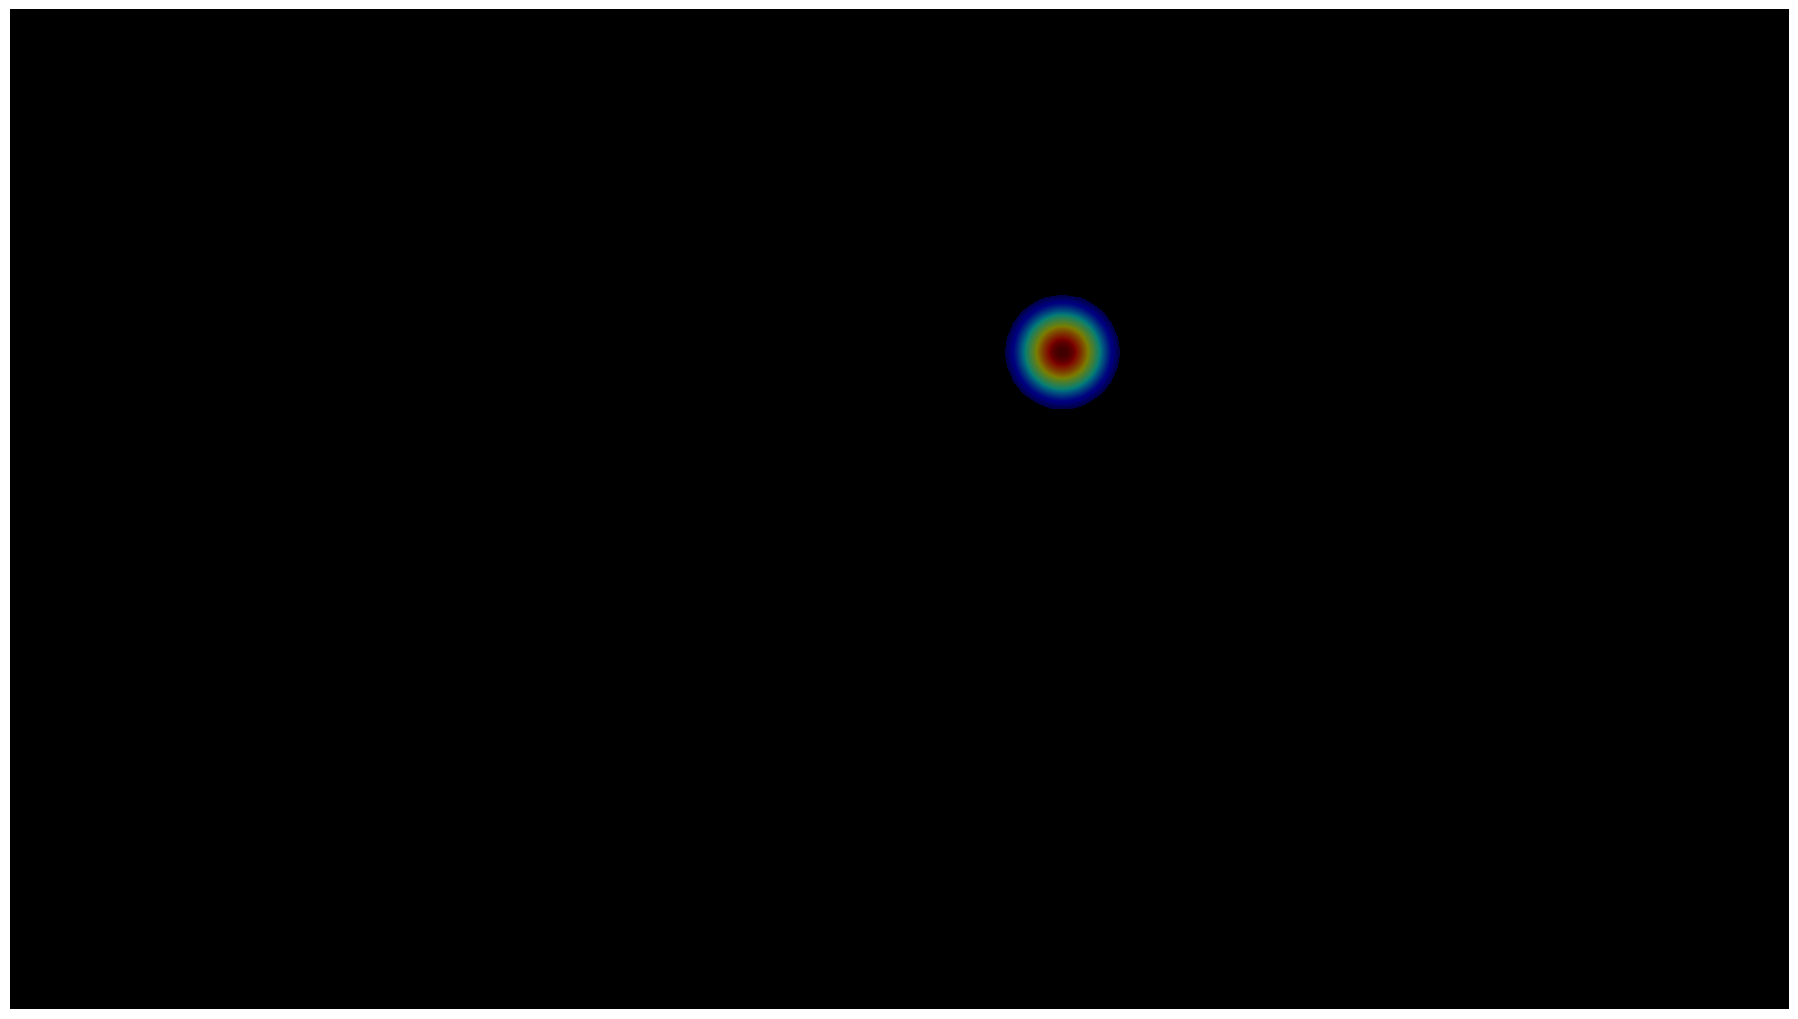

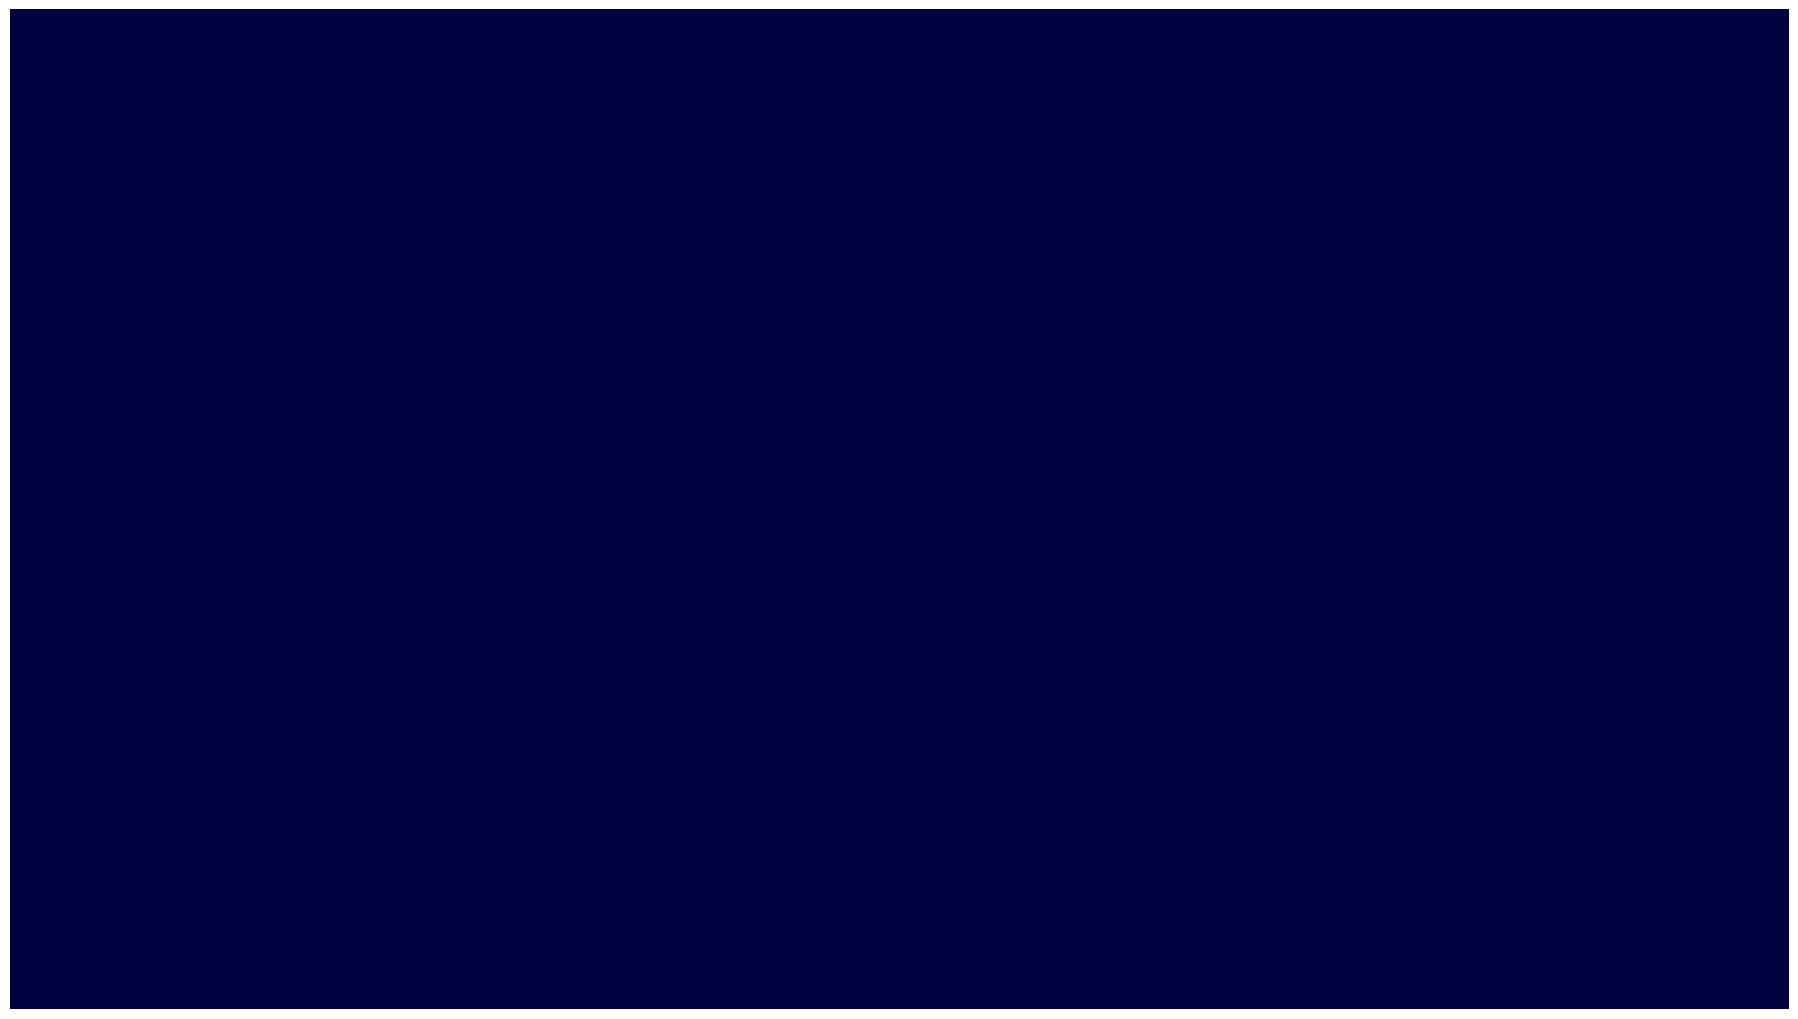

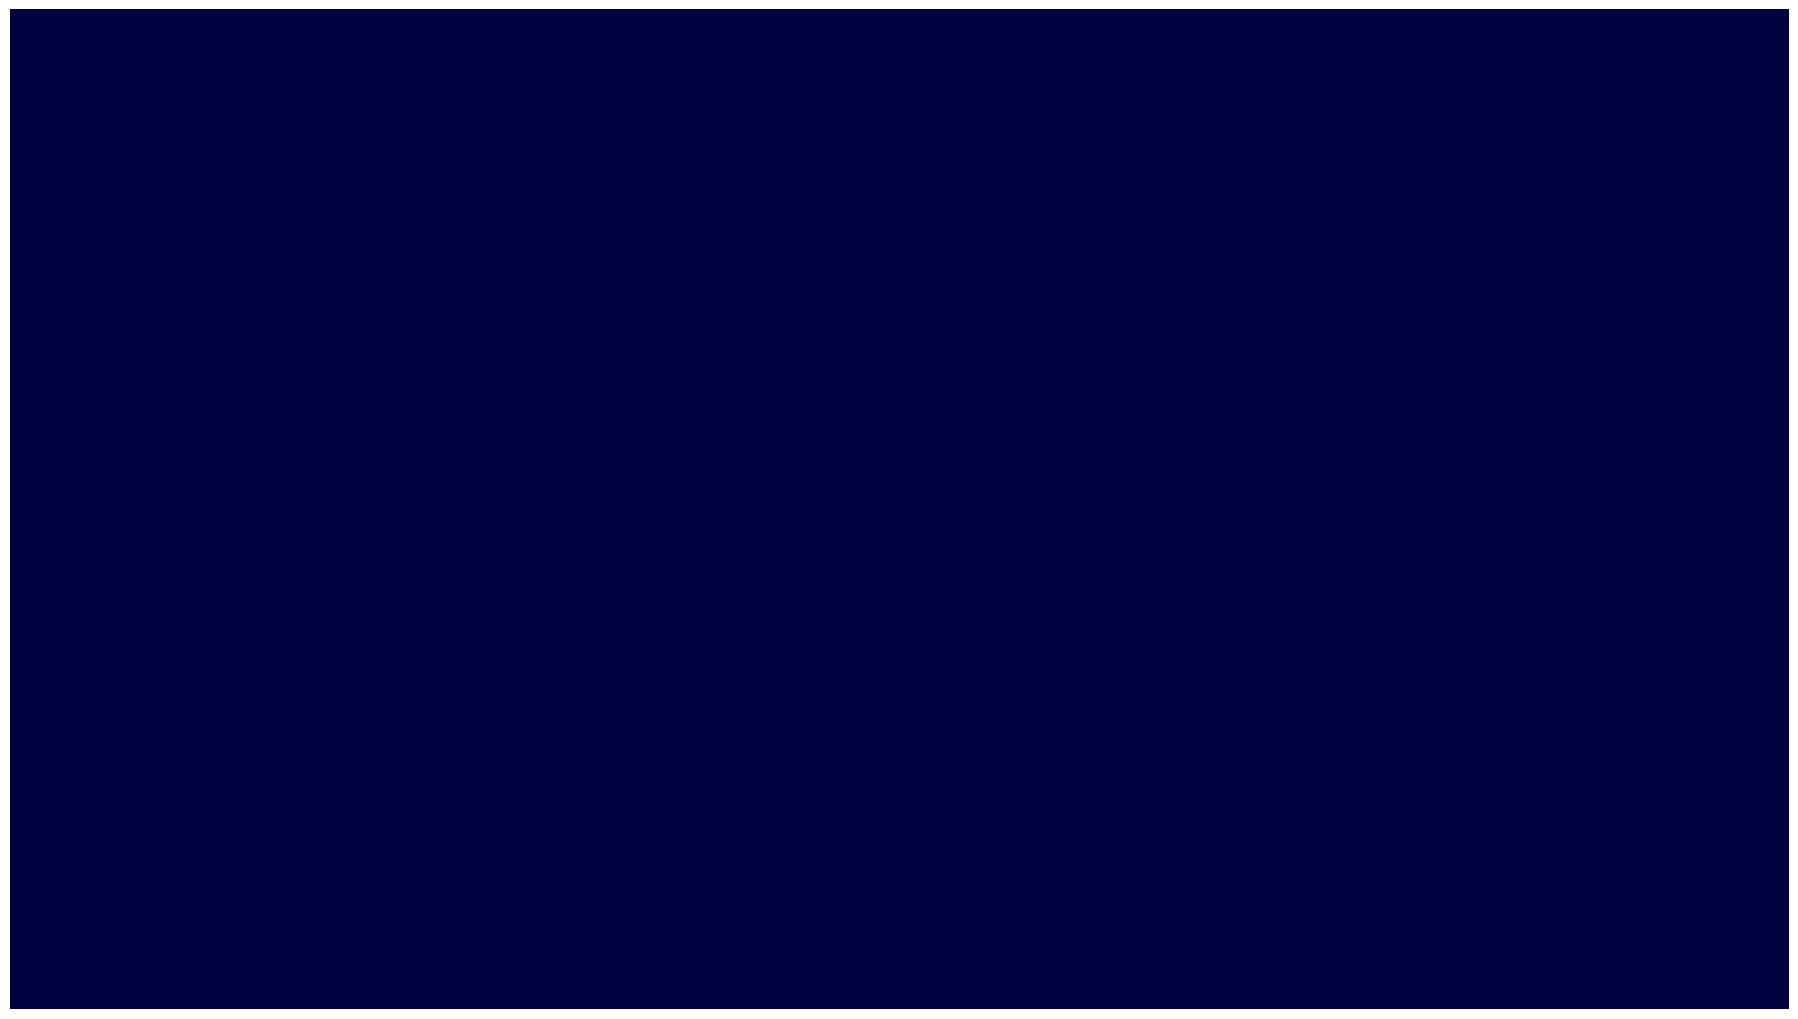

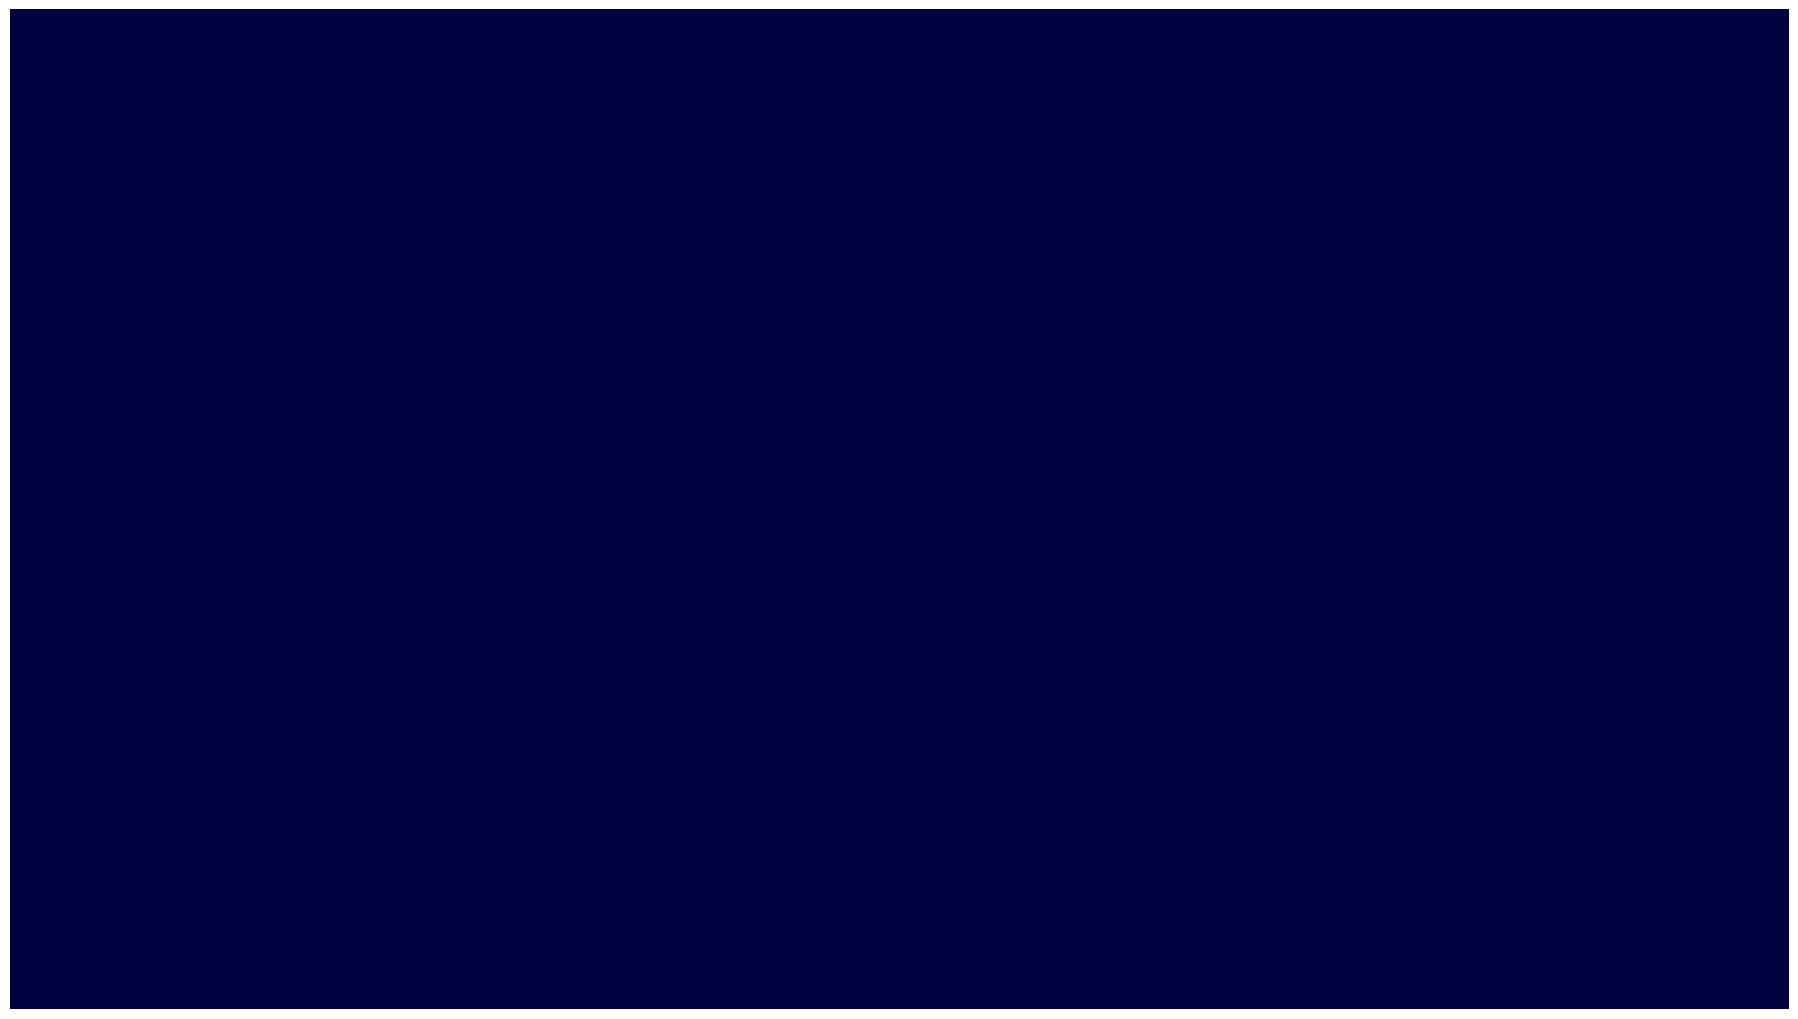

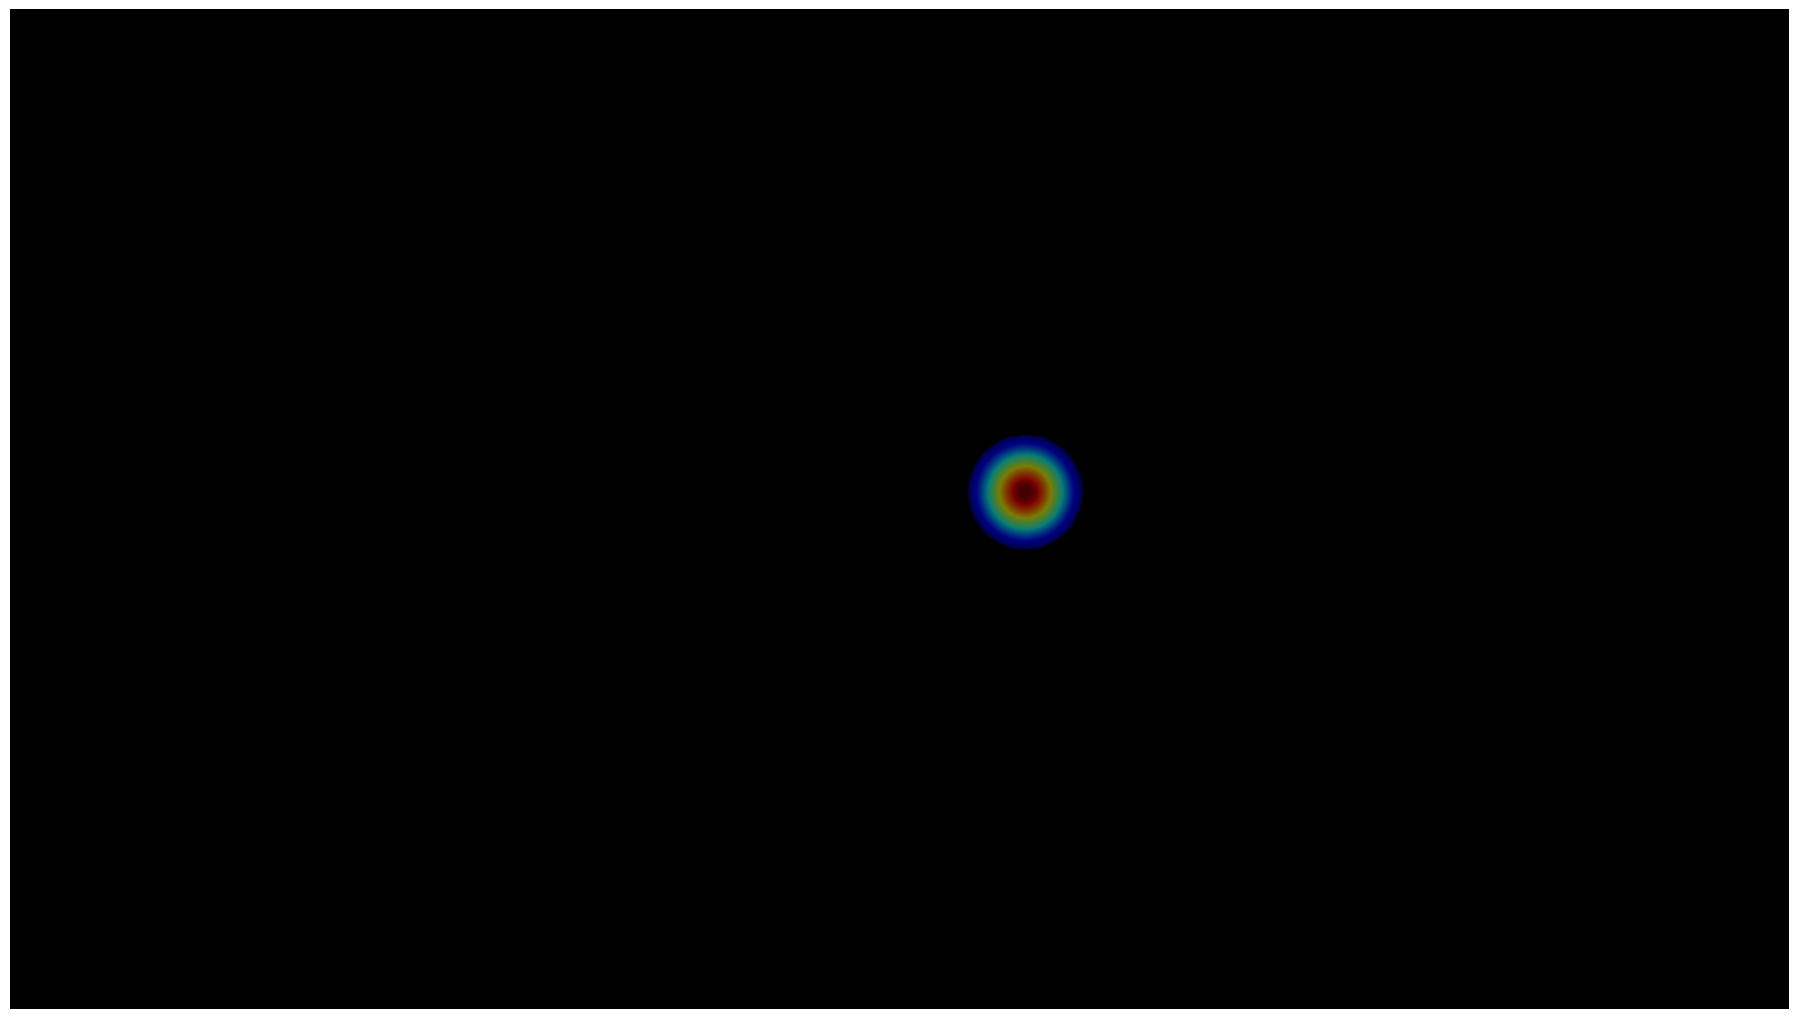

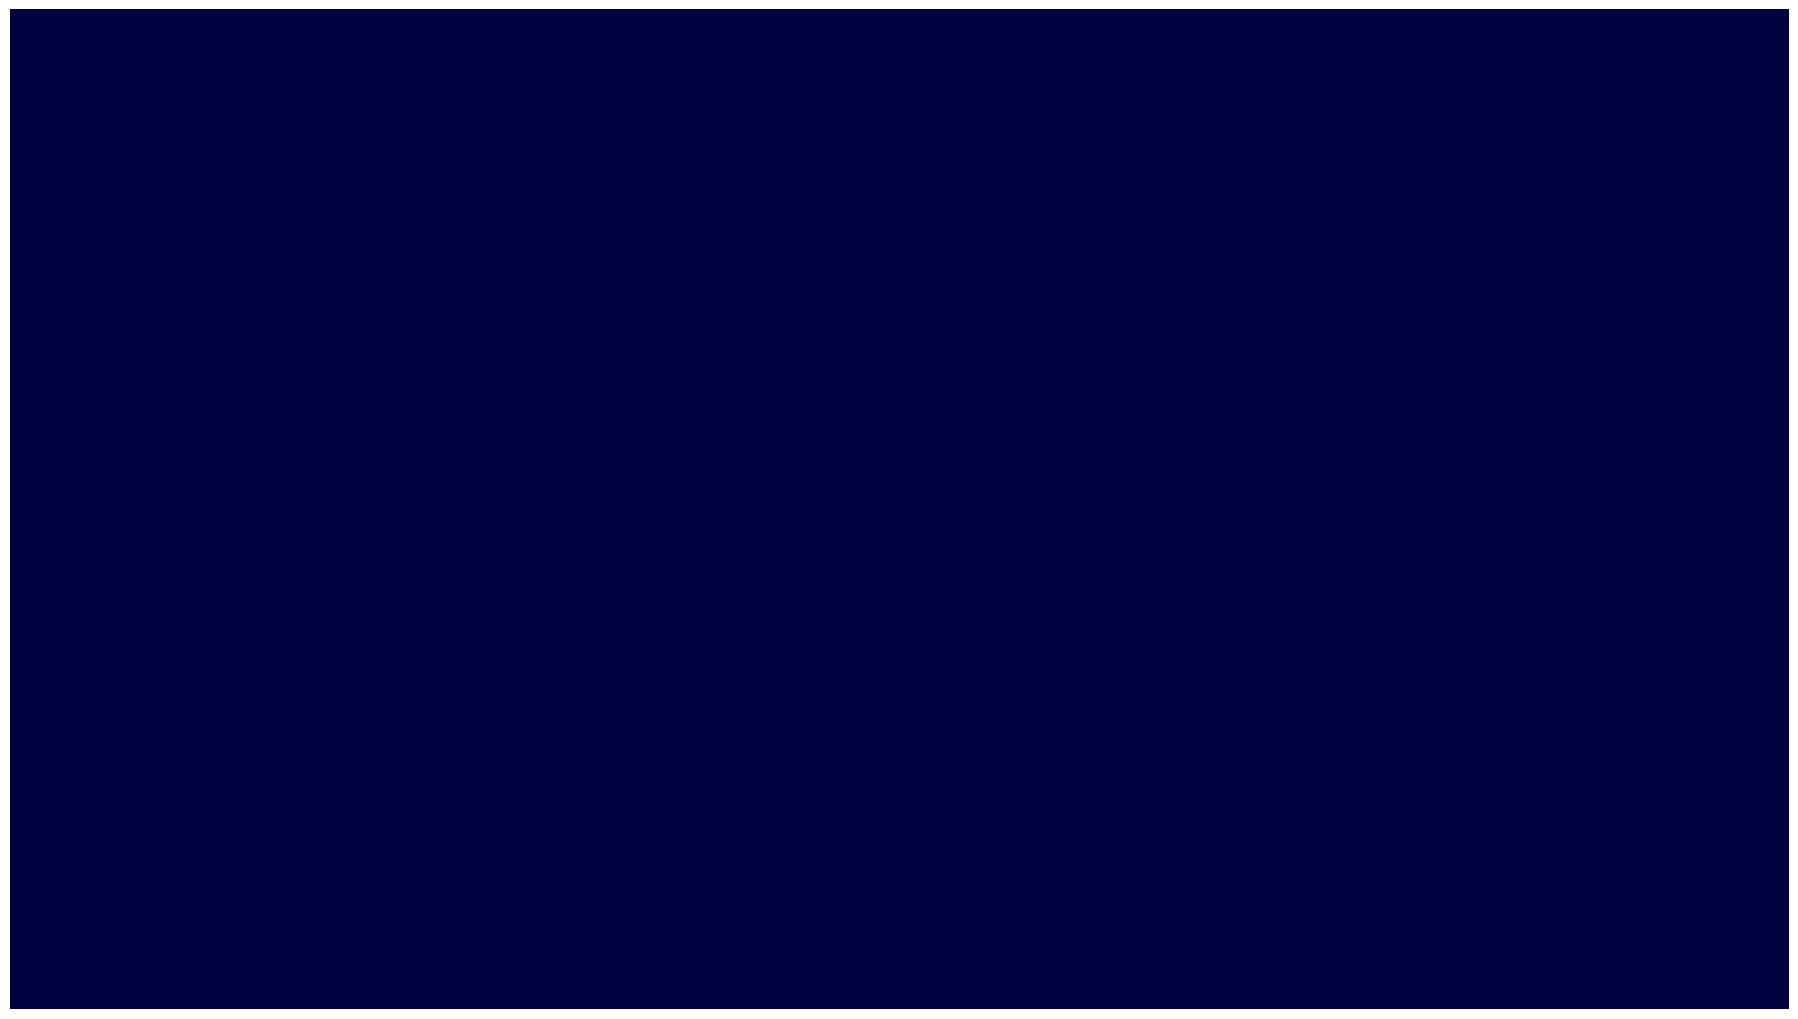

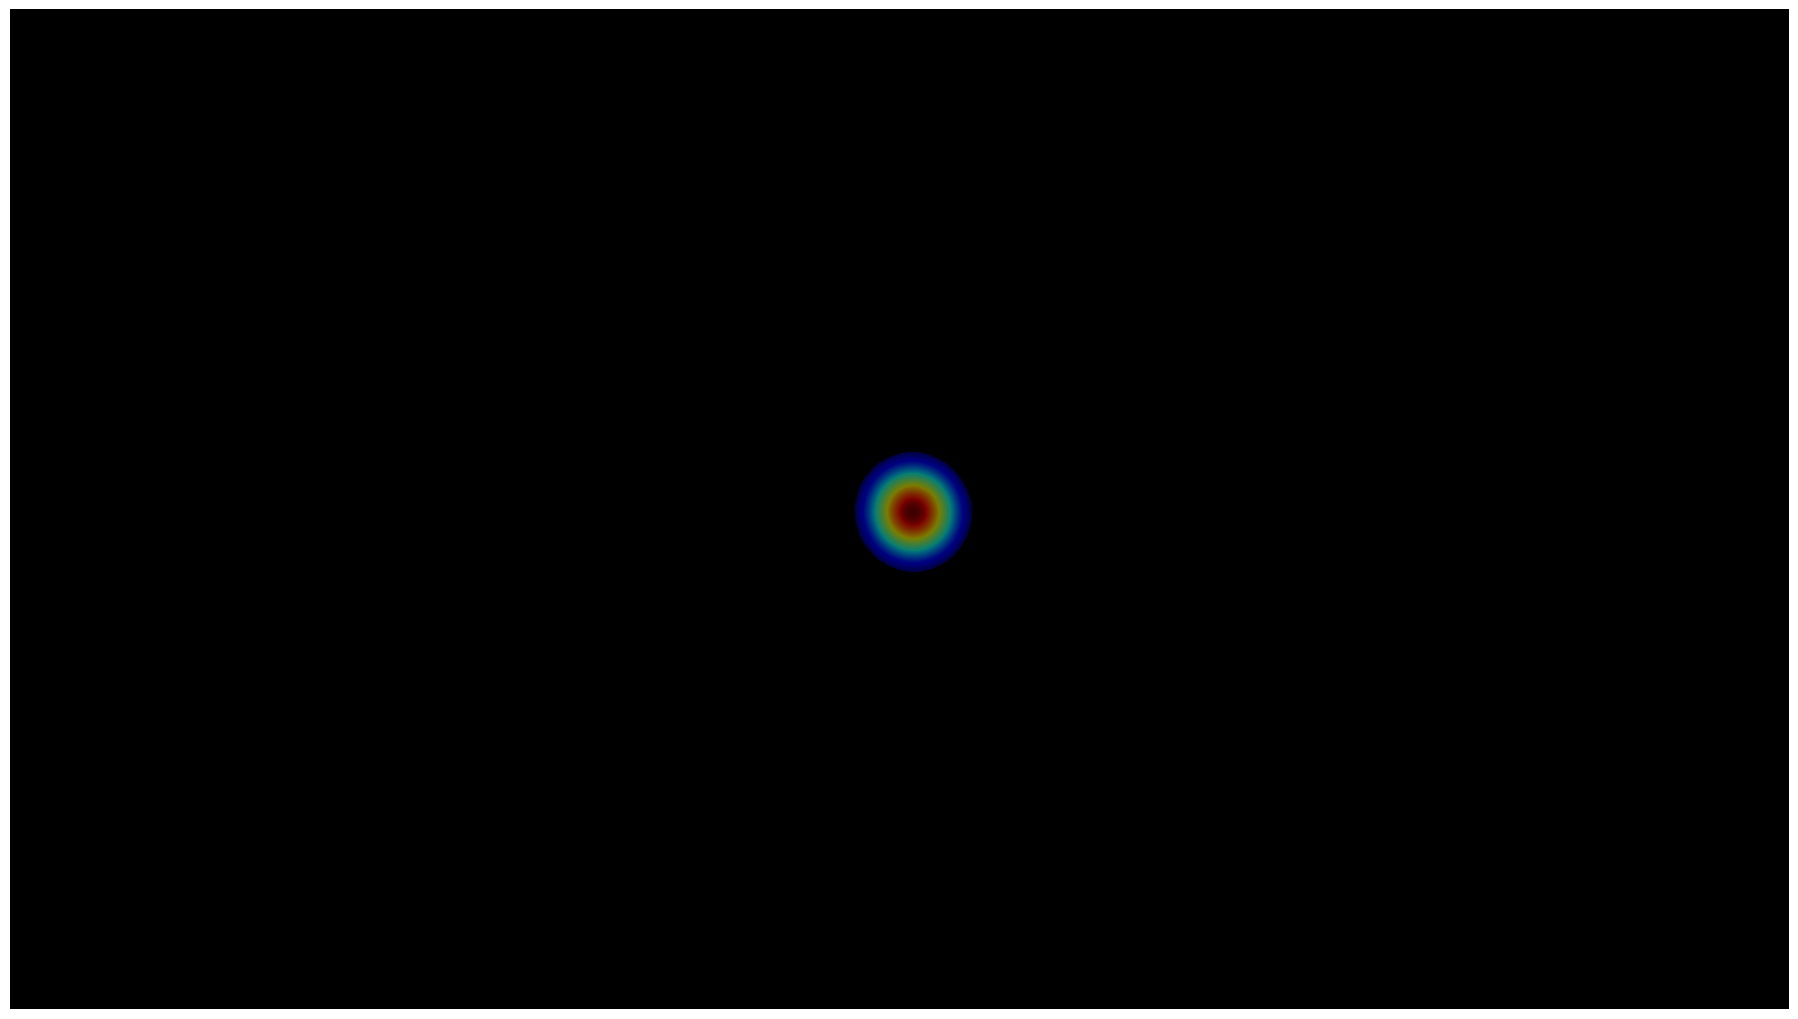

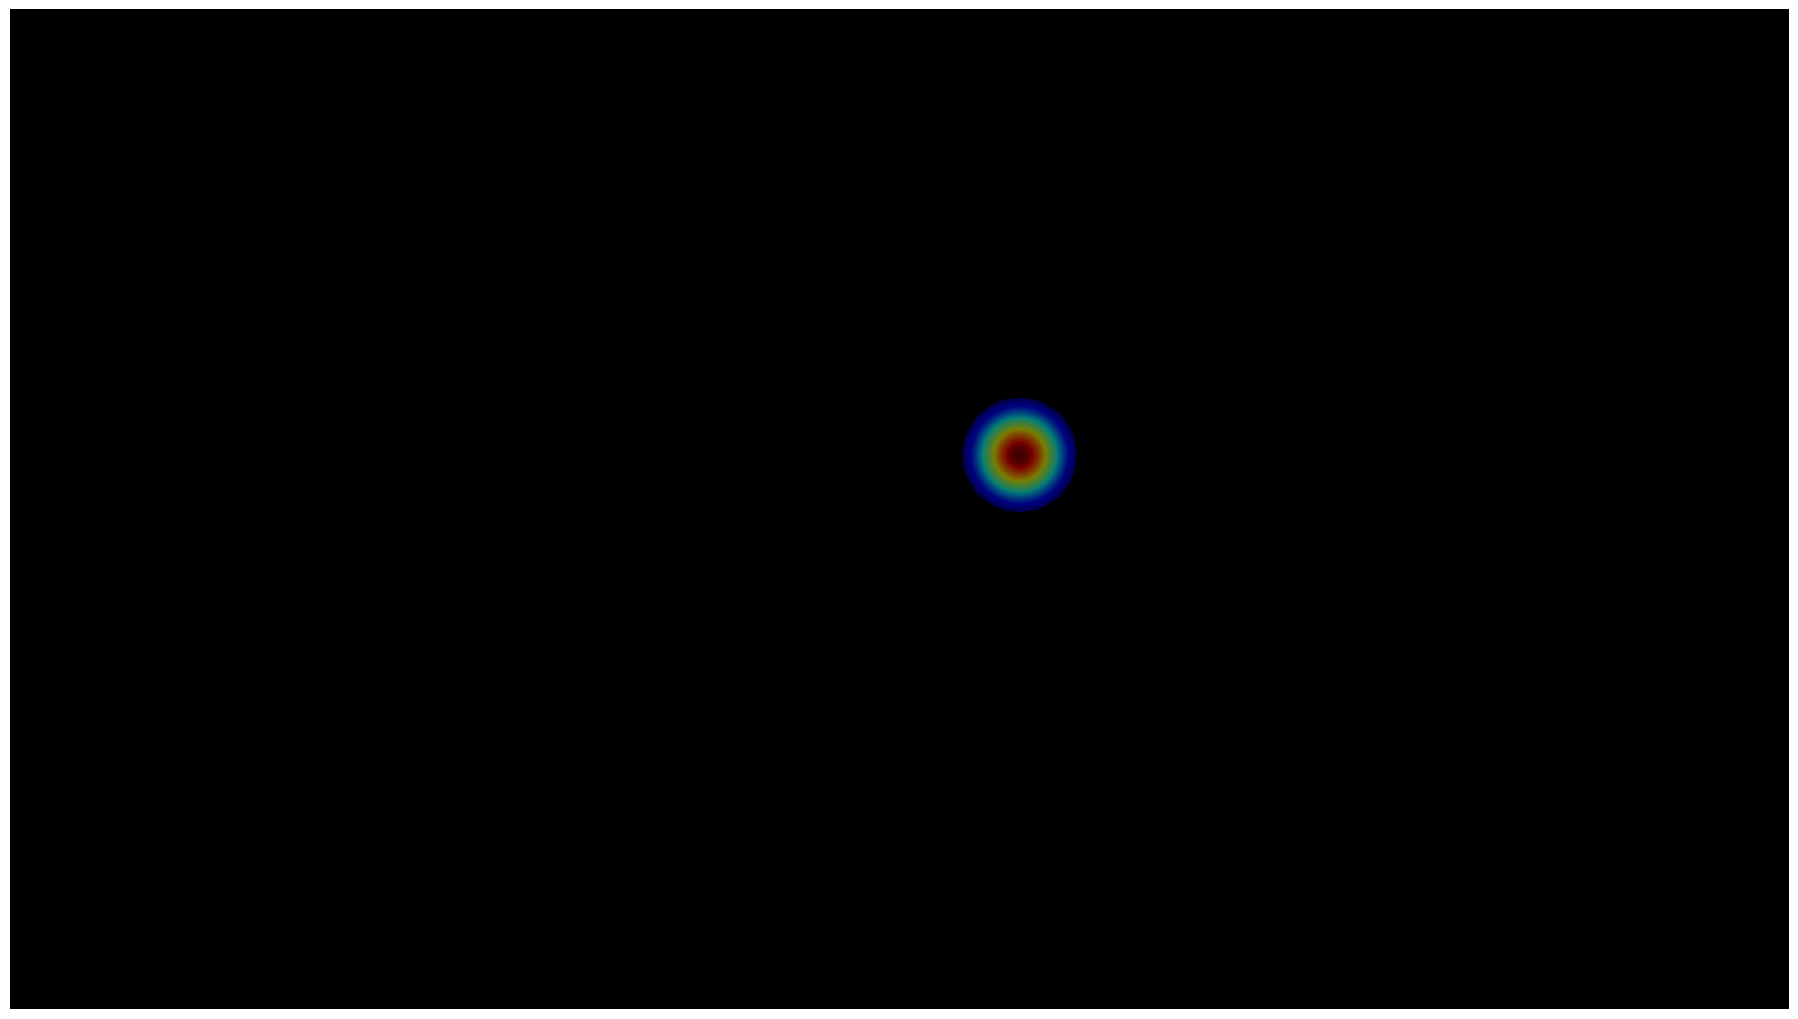

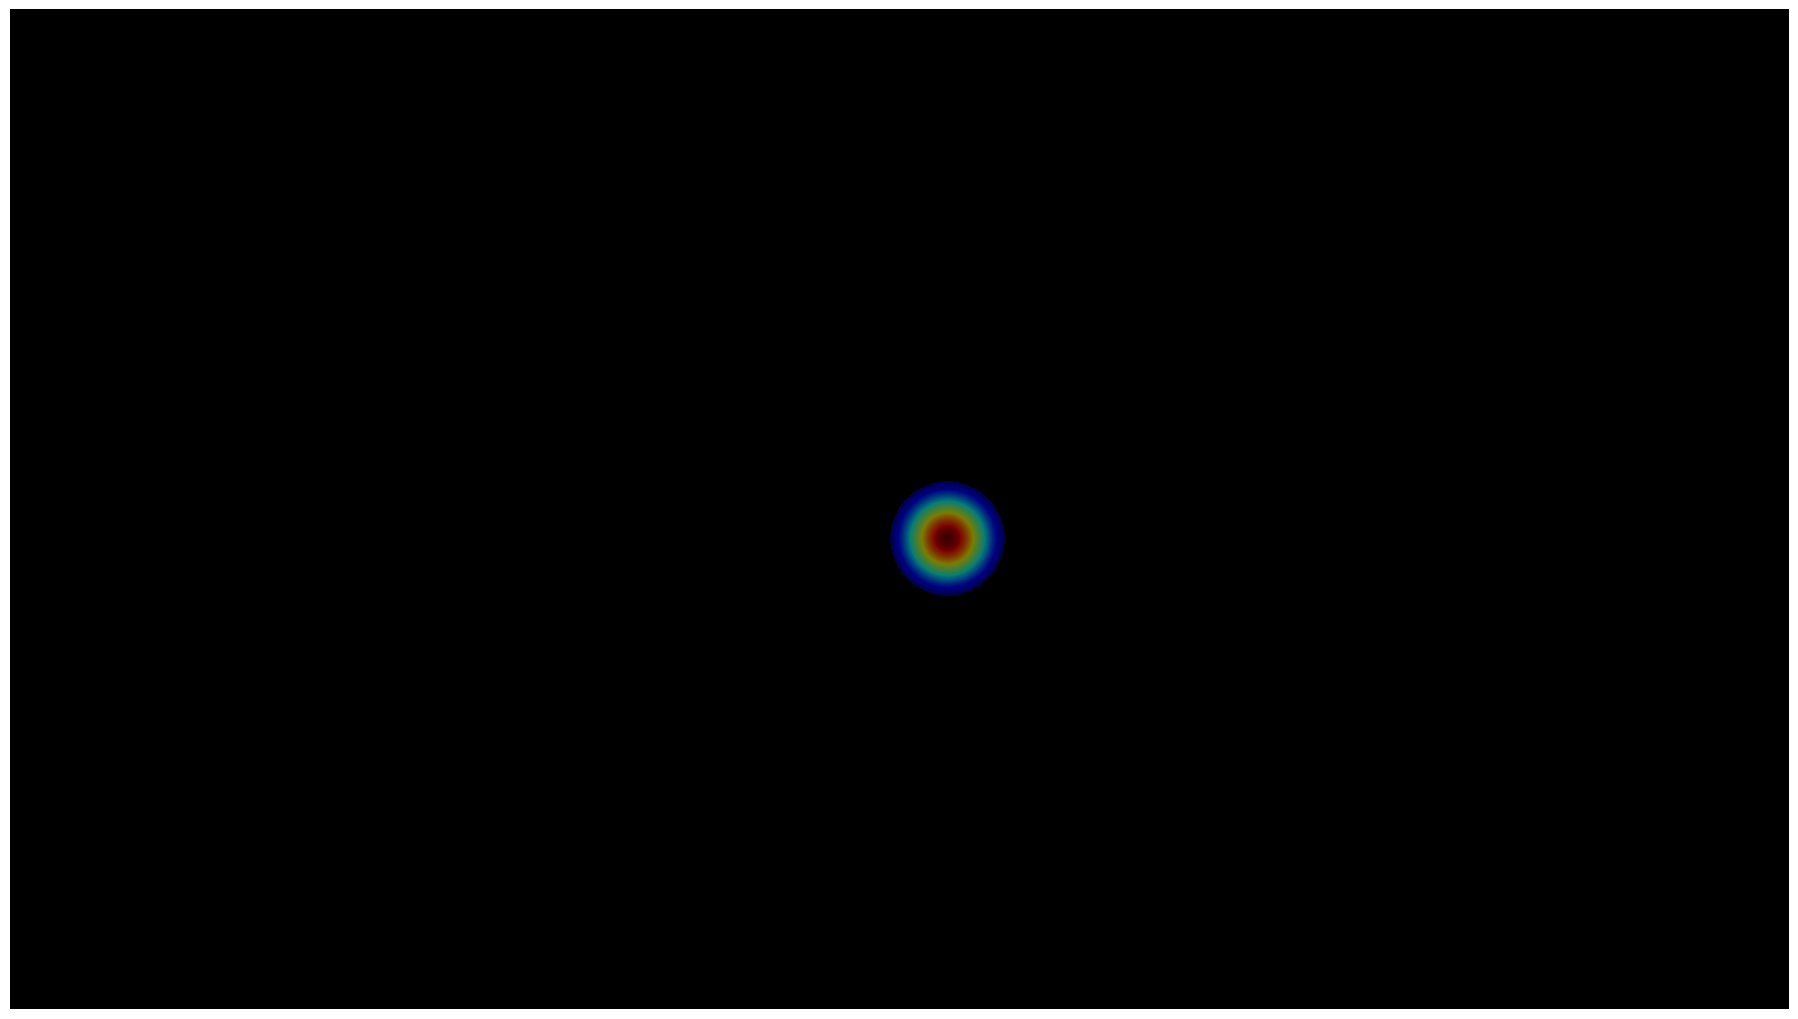

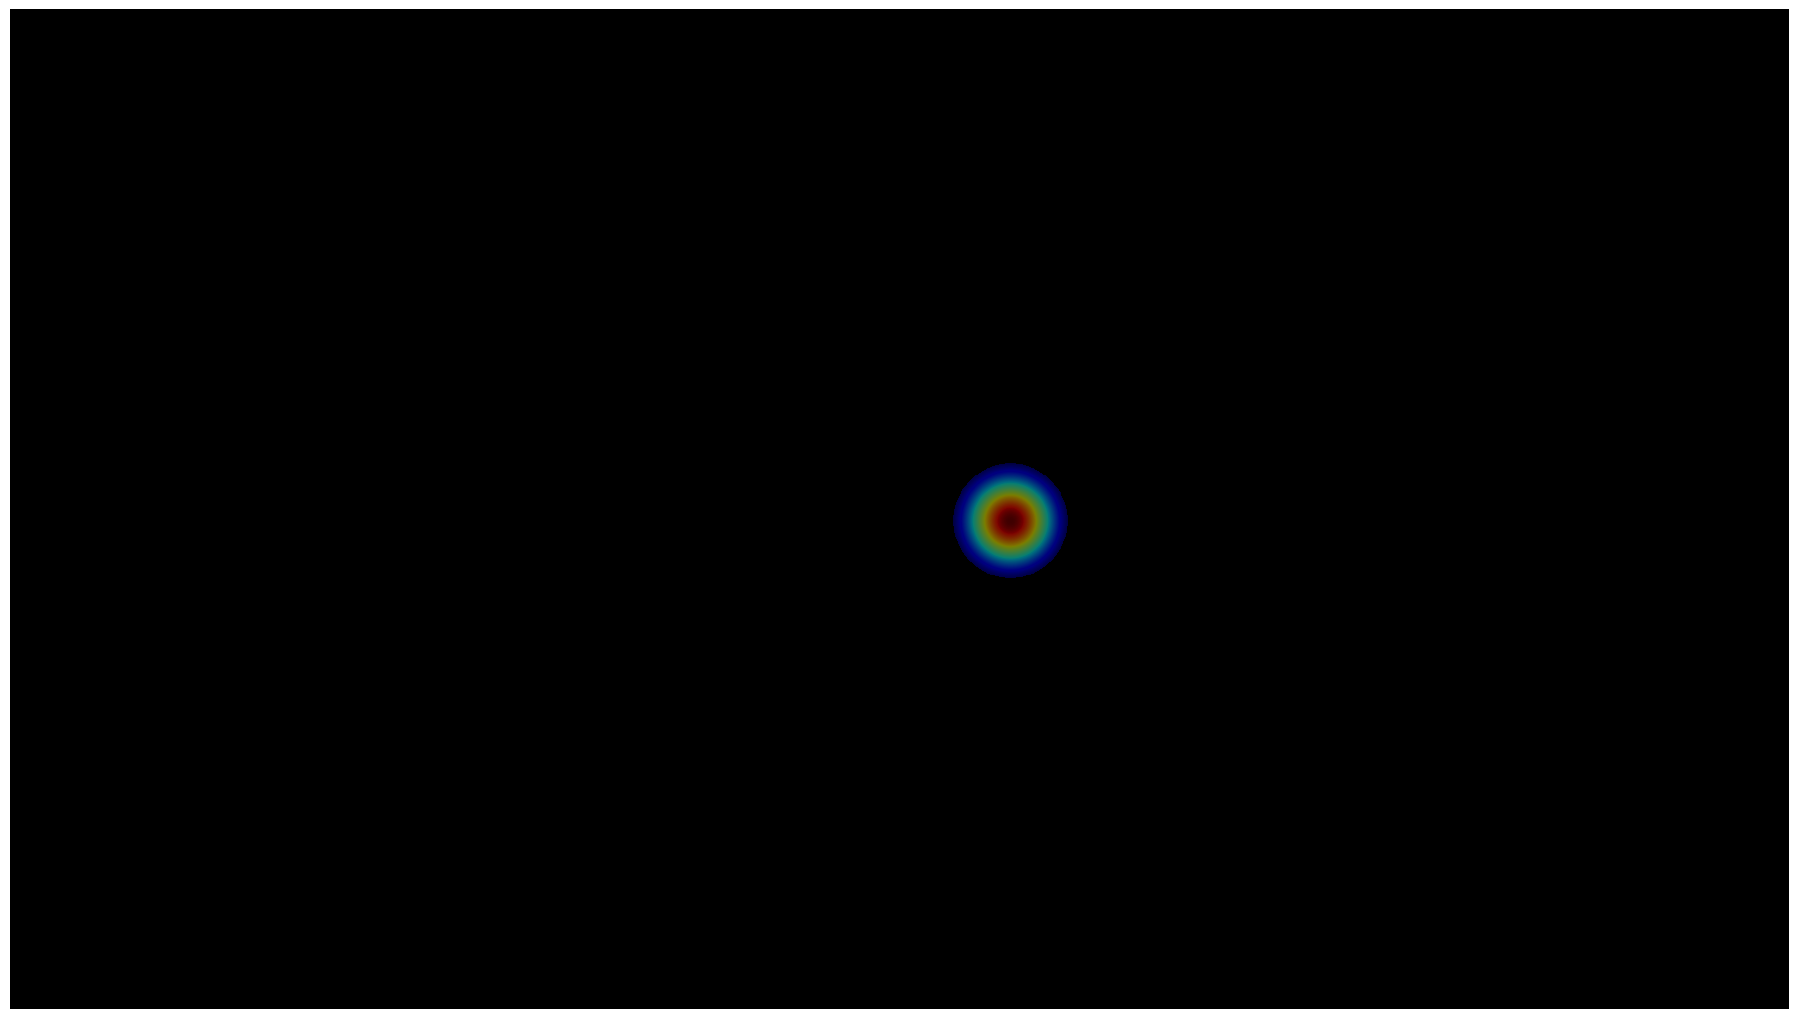

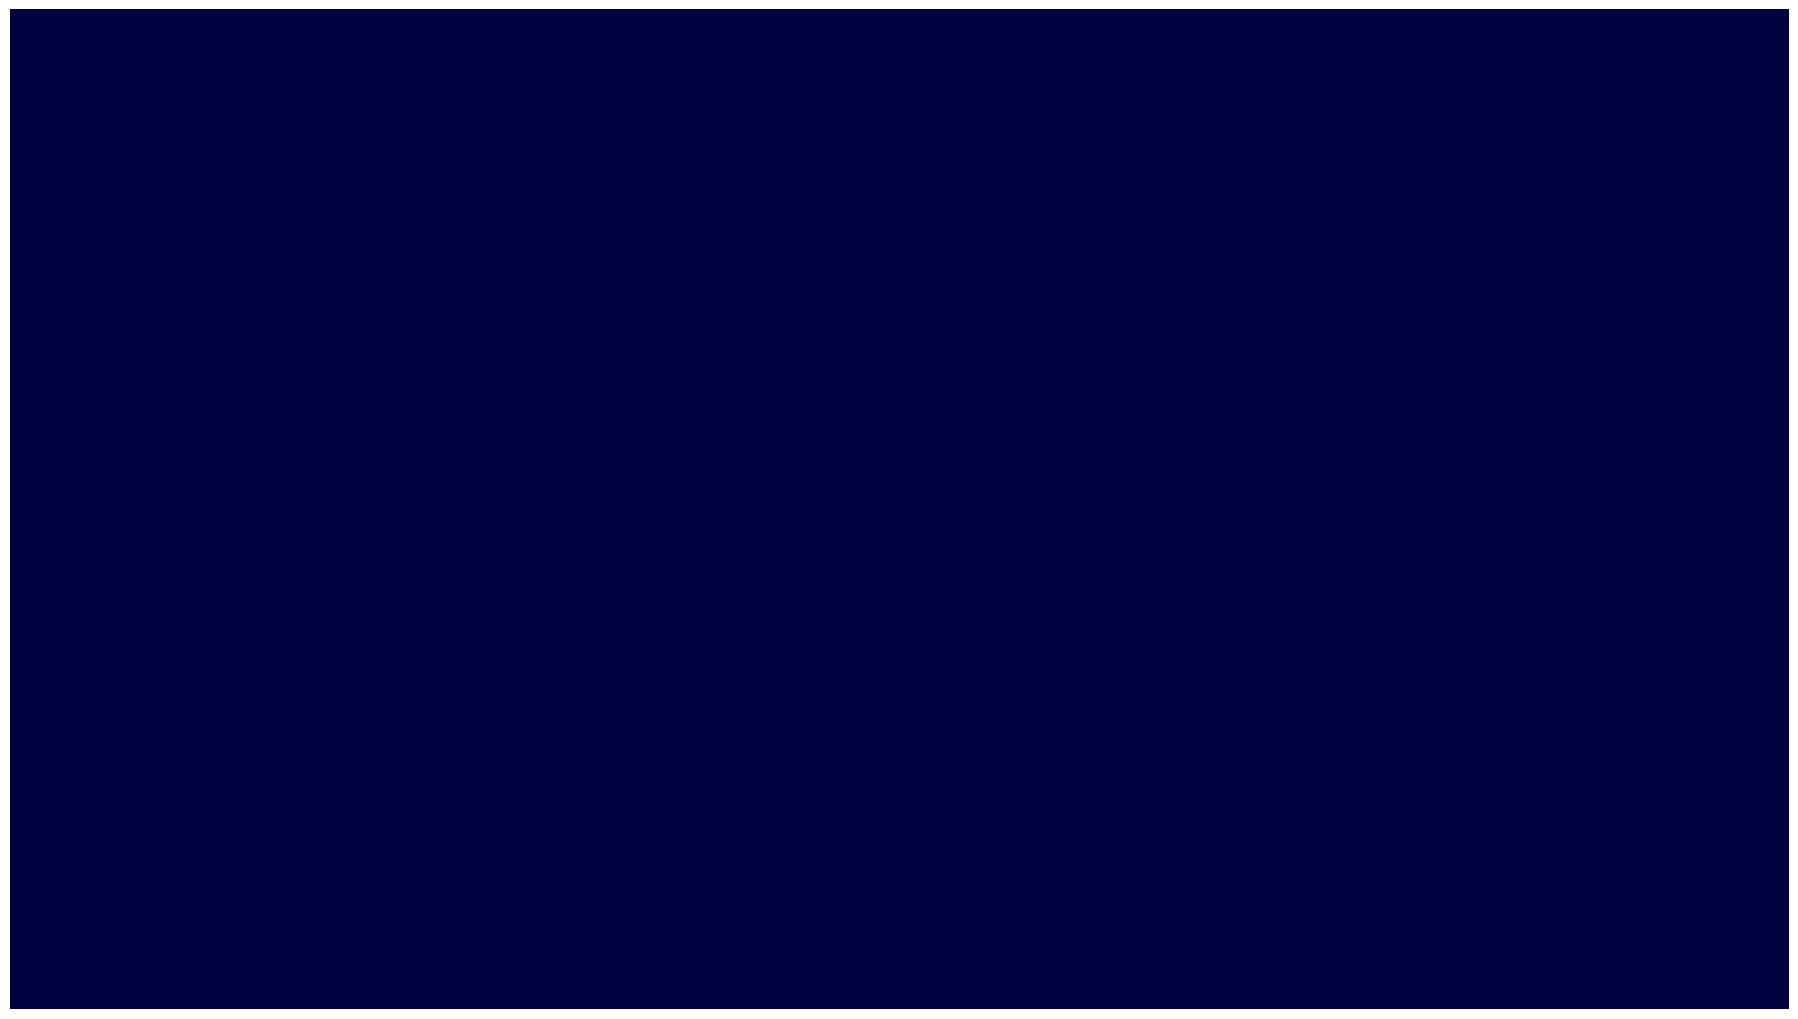

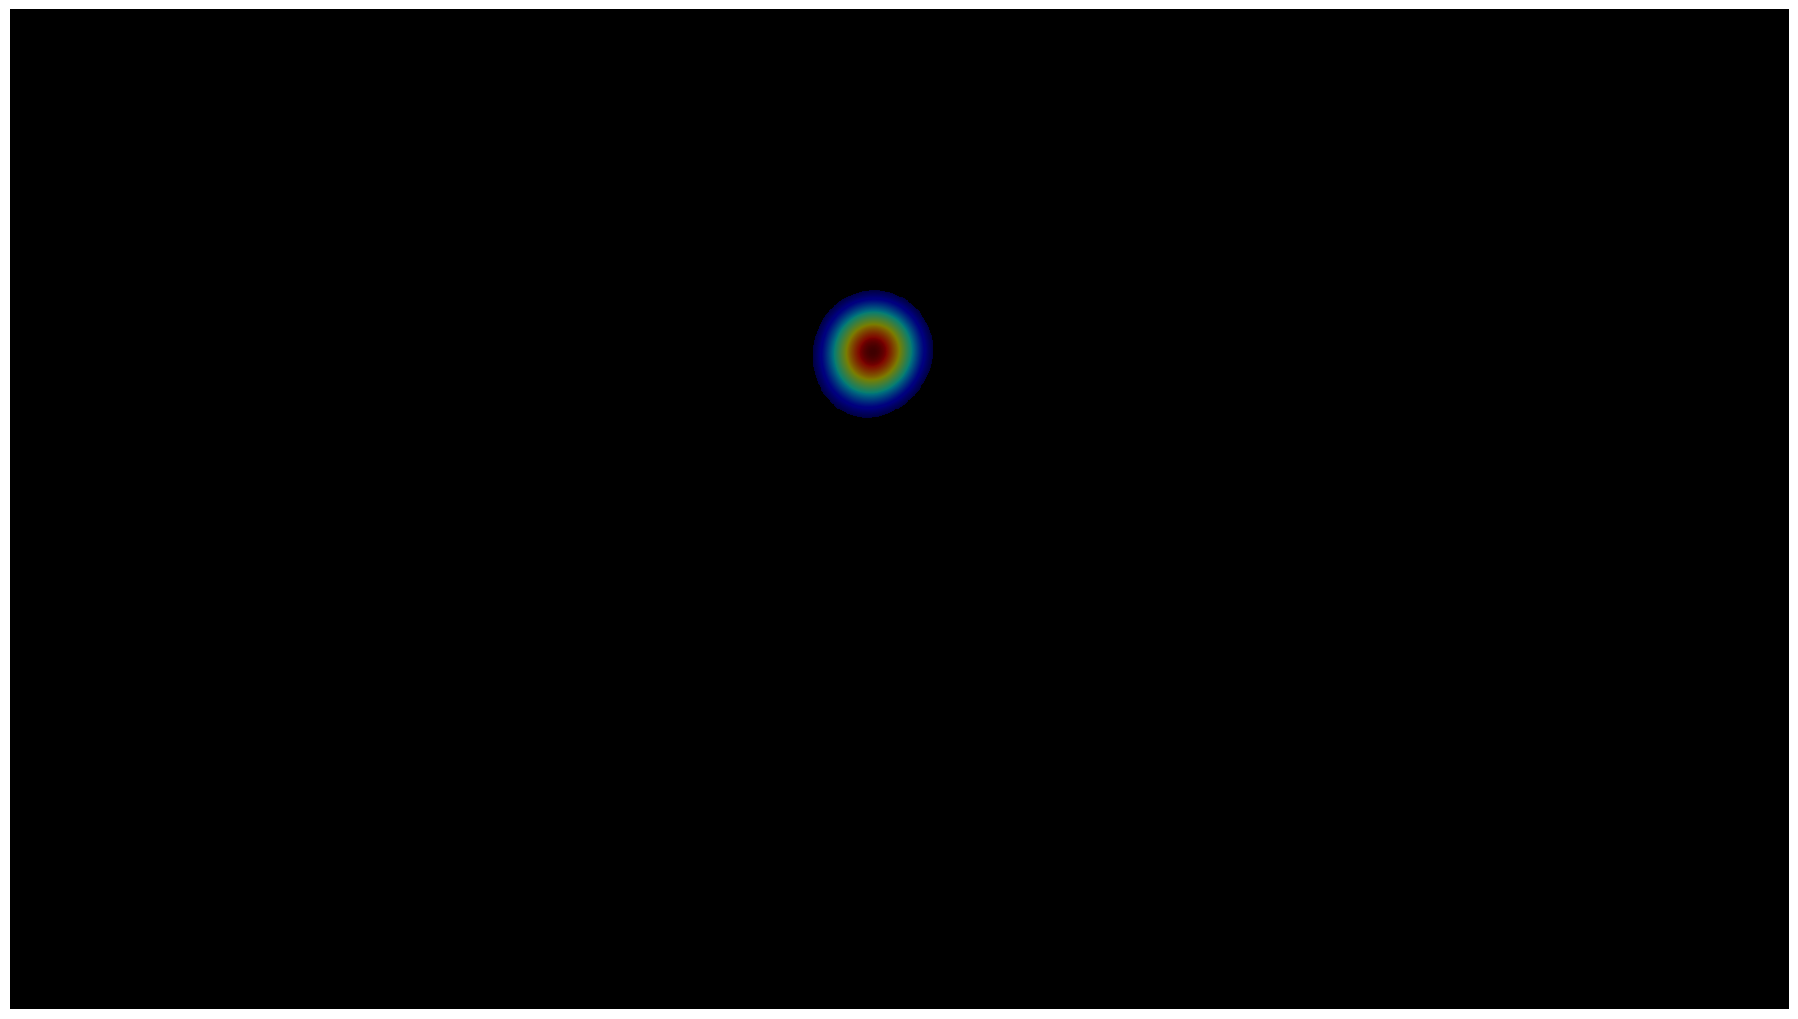

In [22]:
partic_id = 'G036'
game_nr   = 2
trials    = np.arange(1,16,1)
dispsize  = (1919,1079) # (px,px) size of screen 

x_cross_list,y_cross_list, center_x_list,center_y_list = [],[],[],[]
trial_success = []
for trial_nr in (trials):
    #get crosshair position
    #print(return_cross_pos(partic_id,game_nr,trial_nr))
    x_cross,y_cross = return_cross_pos(partic_id,game_nr,trial_nr)
    if x_cross!=0:
        ###get centroid
        
        #fixations
        fixations = np.array(data[trial_nr]['events']['Efix'])
        fig_heatmap = draw_heatmap(fixations, dispsize)
        #save heatmap
        fig_heatmap.savefig('img_1.png')

        #feed heatmap to the function
        image_load = cv2.imread('img_1.png',0)
        center,_,image_out = return_centroid_heatmap(image_load)
        #print(center)
        if center.size!=0:
            #print(center)
            if center.shape[0]>1:
                #print(center.shape)
                center = center[0] #CHANGE LATER!!!
            #plot center - cross hair distance
            #dist = np.sqrt((x_cross-center[0][0])**2 + (y_cross-center[0][1])**2)
            #plt.scatter(trial_nr,dist)
            x_cross_list.append(x_cross)
            y_cross_list.append(y_cross)
            center_x_list.append(center[0][0])
            center_y_list.append(center[0][1])
            trial_success.append(trial_nr)


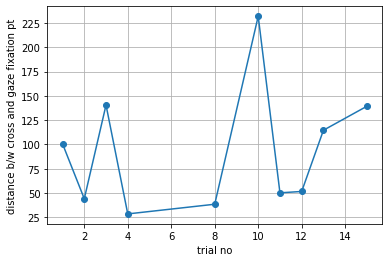

In [23]:
# Game no 1
dist = np.sqrt((np.array(center_x_list) - np.array(x_cross_list))**2 +
               (np.array(center_y_list) - np.array(y_cross_list))**2)
plt.plot(np.array(trial_success),(dist),'-o')
plt.xlabel('trial no')
plt.ylabel('distance b/w cross and gaze fixation pt')
plt.grid()

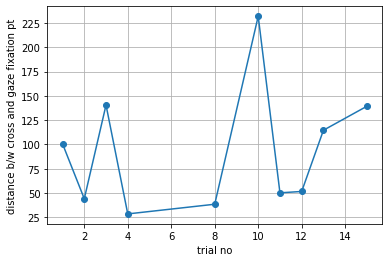

In [24]:
# Game no 2
dist = np.sqrt((np.array(center_x_list) - np.array(x_cross_list))**2 +
               (np.array(center_y_list) - np.array(y_cross_list))**2)
plt.plot(np.array(trial_success),(dist),'-o')
plt.xlabel('trial no')
plt.ylabel('distance b/w cross and gaze fixation pt')
plt.grid()

### Parsing The Stimulus Data

In [25]:
"""
Create Dictionary of Stimulus Properties


dict_keys(['subject_nr', 'subject_id', 'game_nr', 'trial_nr', 'perc_noise', 
            'perc_noise_sample', 'orientation', 'orientation_sample', 'orientation_0', 
            'orientation_0_sample','orientation_positive_unfair', 'orientation_positive_fair', 
            'reference_line'])
            

"""

def load_dataset_properties(fname):
#file name
    #fname = 'dataset_0423.csv'

    #read and store into data_set
    data_set = []
    with open(fname, newline='') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for row in csvreader:
            row = row[0].split(',') #split by comma separated 
            data_set.append(row)
    return data_set


"""convert to dictionary
keys_dict = data_set[0]

#rearrange values
values_dict = np.array(data_set[1:]).T
   
#create_dict
data_set_dict = dict(zip(keys_dict,values_dict))
"""

'convert to dictionary\nkeys_dict = data_set[0]\n\n#rearrange values\nvalues_dict = np.array(data_set[1:]).T\n   \n#create_dict\ndata_set_dict = dict(zip(keys_dict,values_dict))\n'

In [26]:
"""
Convert to Numpy array such that array
[id-2*game_nr-1*trial_nr-1,property] returns the corresponding value



"""




'\nConvert to Numpy array such that array\n[id-2*game_nr-1*trial_nr-1,property] returns the corresponding value\n\n\n\n'

In [34]:
## Retrieve Data
'''
['subject_nr', 'subject_id', 'game_nr', 'trial_nr', 'perc_noise', 
'perc_noise_sample', 'orientation', 'orientation_sample', 'orientation_0', 'orientation_0_sample', 
'orientation_positive_unfair', 'orientation_positive_fair', 'reference_line'])

'''

def return_property_value(data_set,subject_id, game_nr,trial_nr,property_label):
    #subject_id = 36
    #game_nr = 1
    #trial_nr = 5
    ### Convert to numpy array
    data_set_arr = np.array(data_set[1:]).astype(float)
    #reshape
    data_set_arr.reshape(35,16,18,-1)
    data_set_arr.shape
    #retrieve perc_noise_sample
    #property_label = 'perc_noise_sampe'
    index_property = data_set[0].index(property_label)
    property_value = data_set_arr[(subject_id-2)*(game_nr-1)*(trial_nr-1),index_property]
    return property_value

 ### Plot perceived noise_sample vs inattention


c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


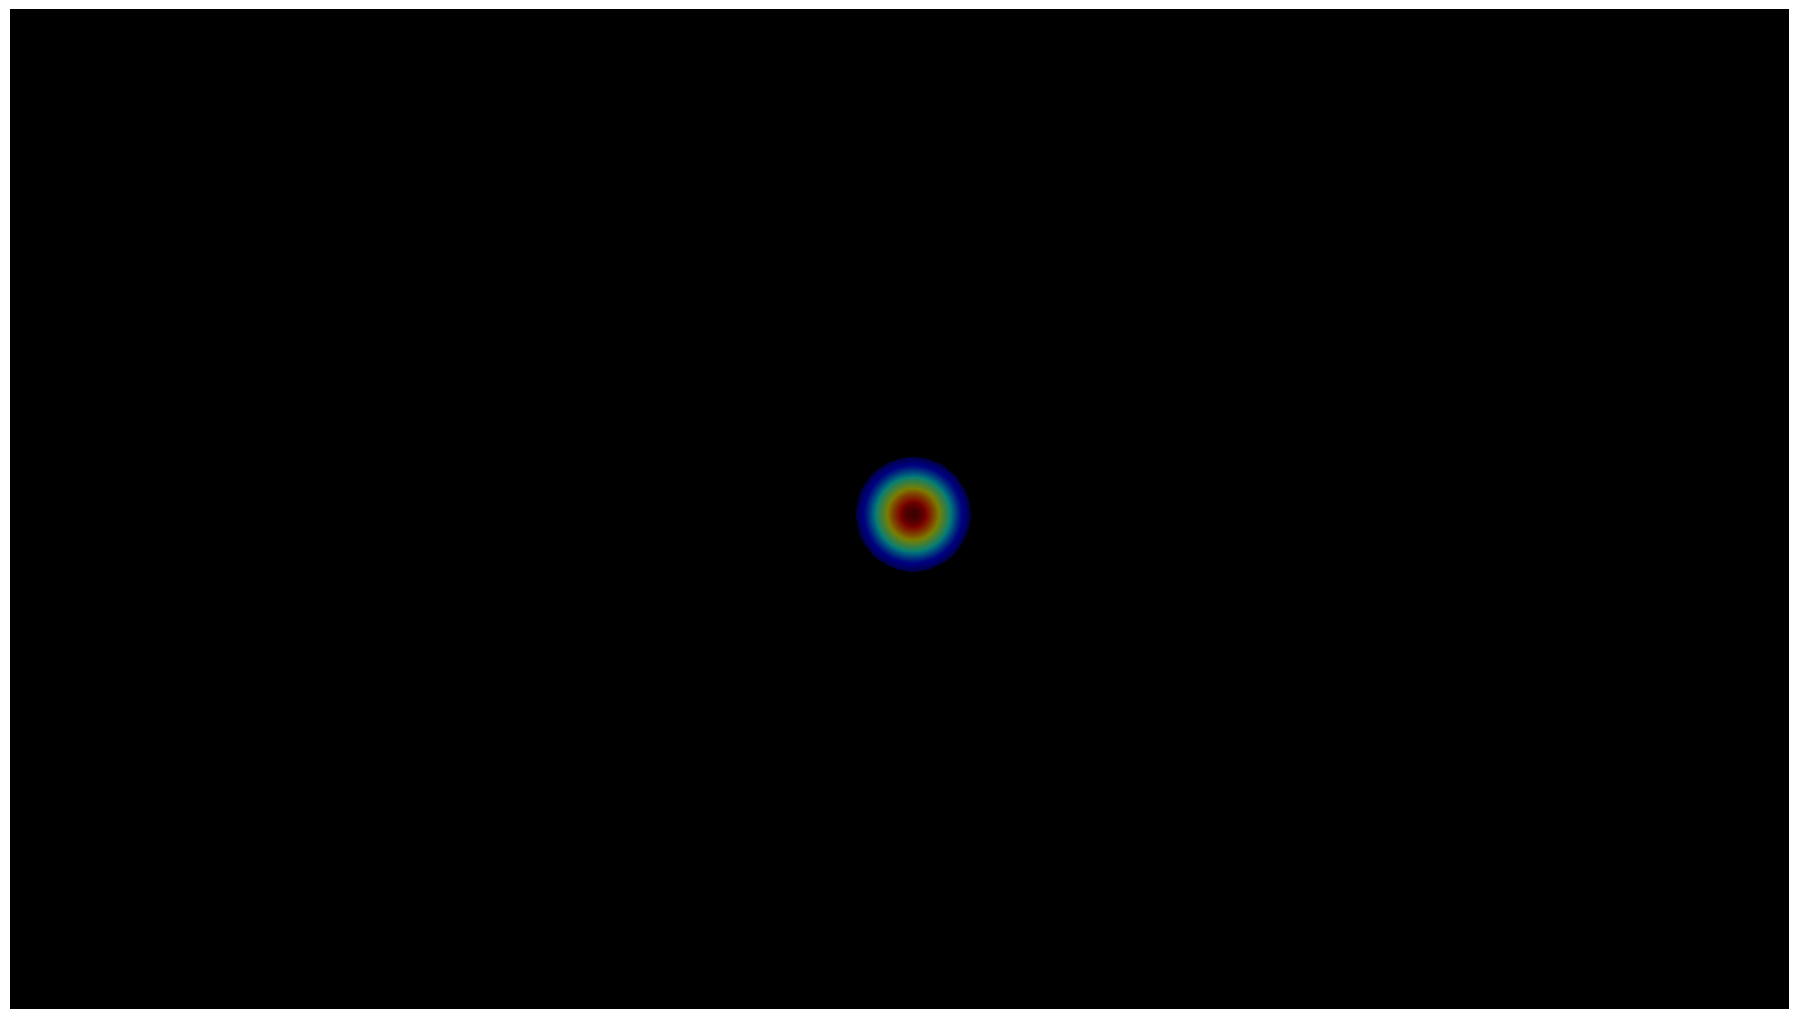

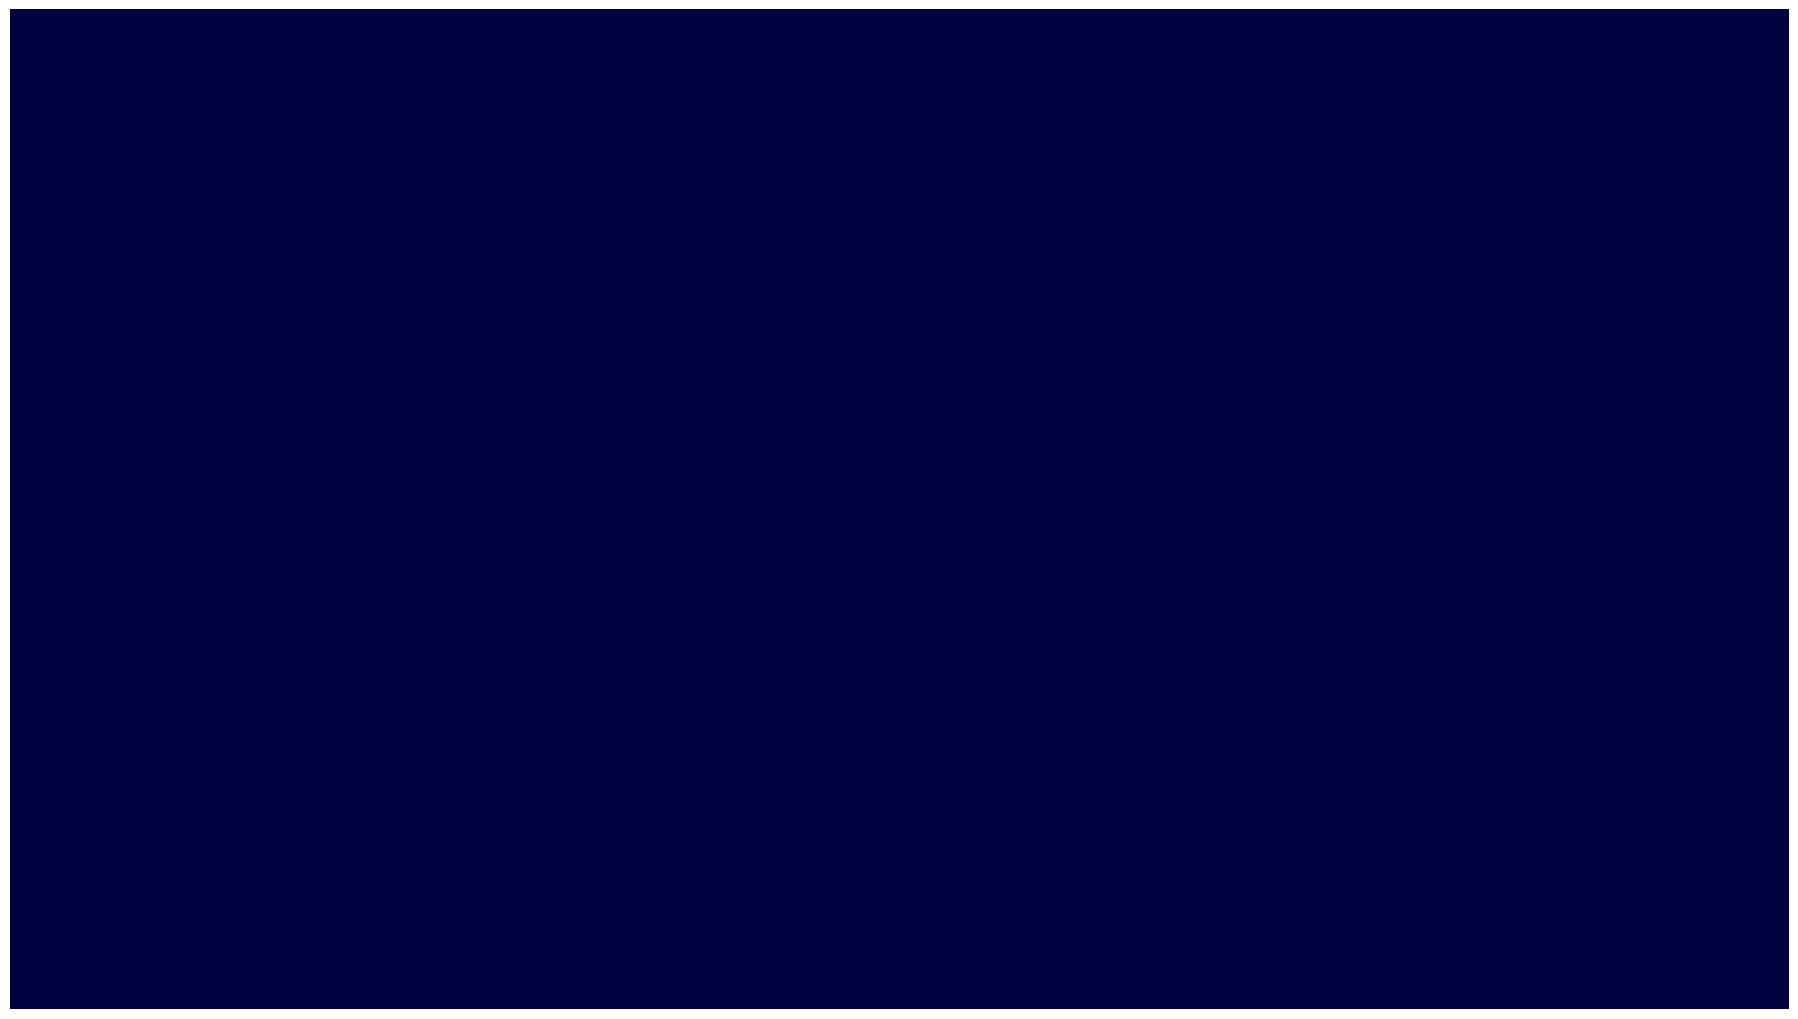

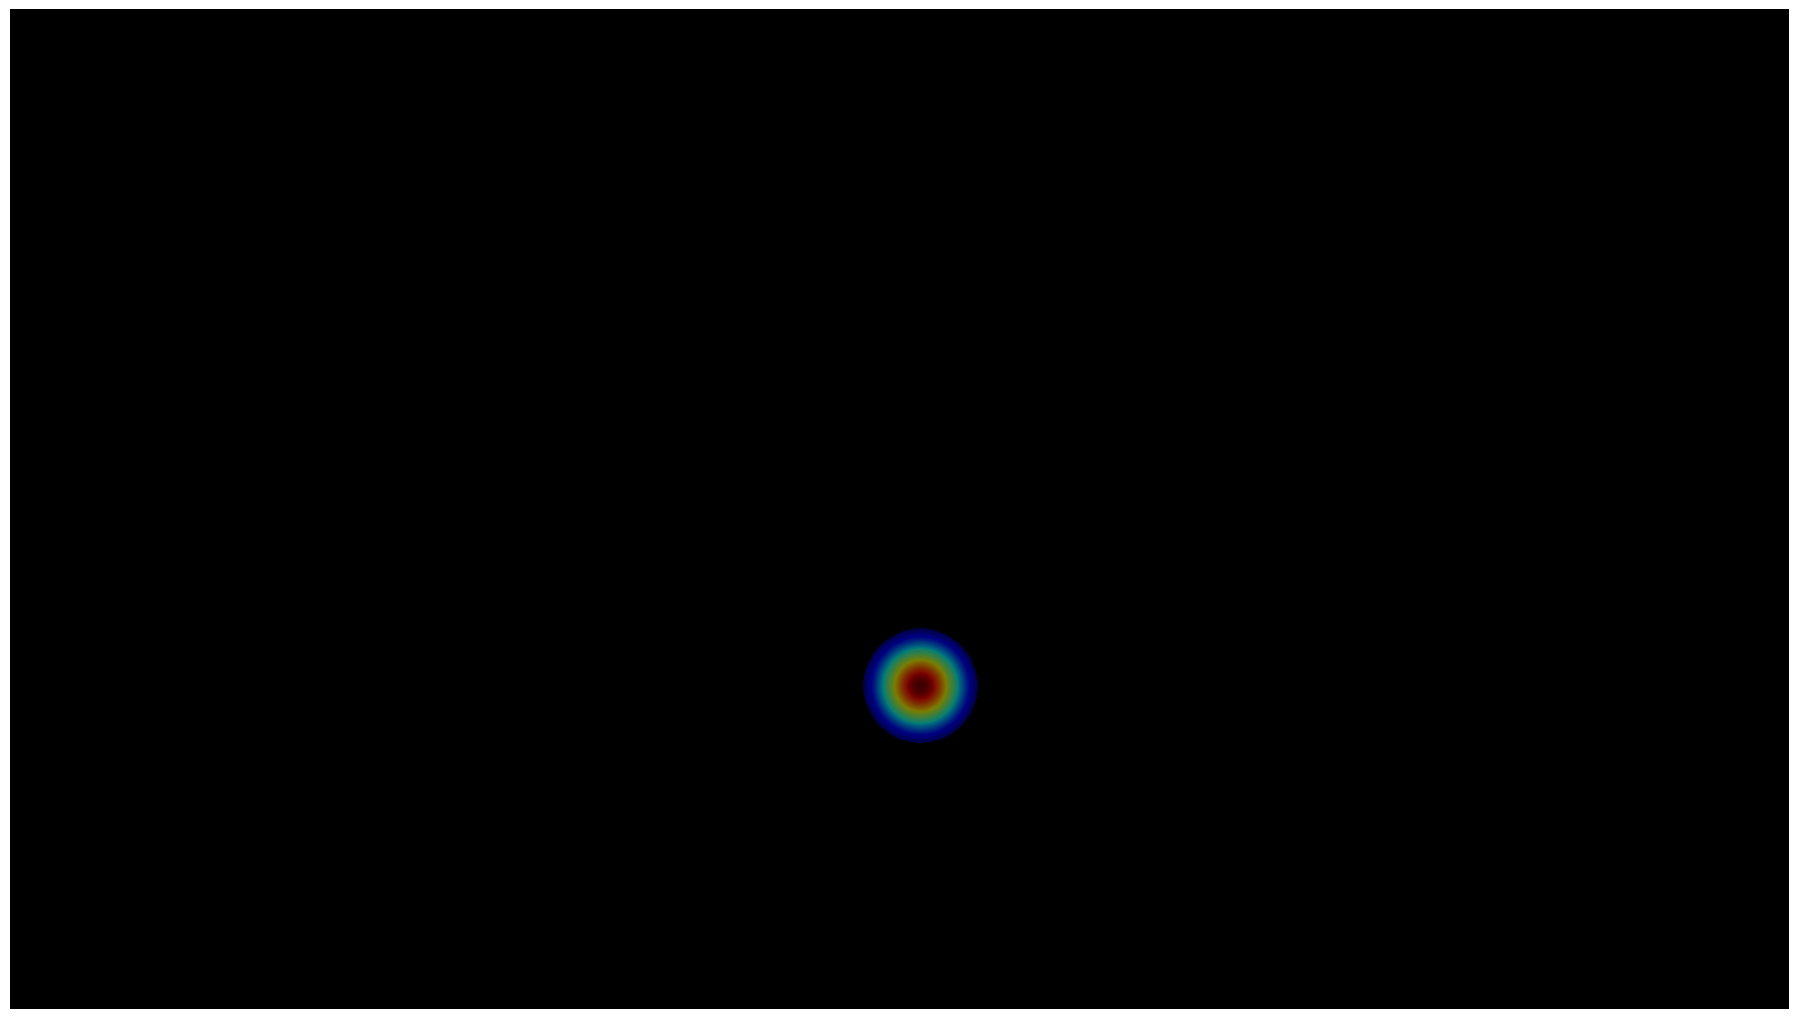

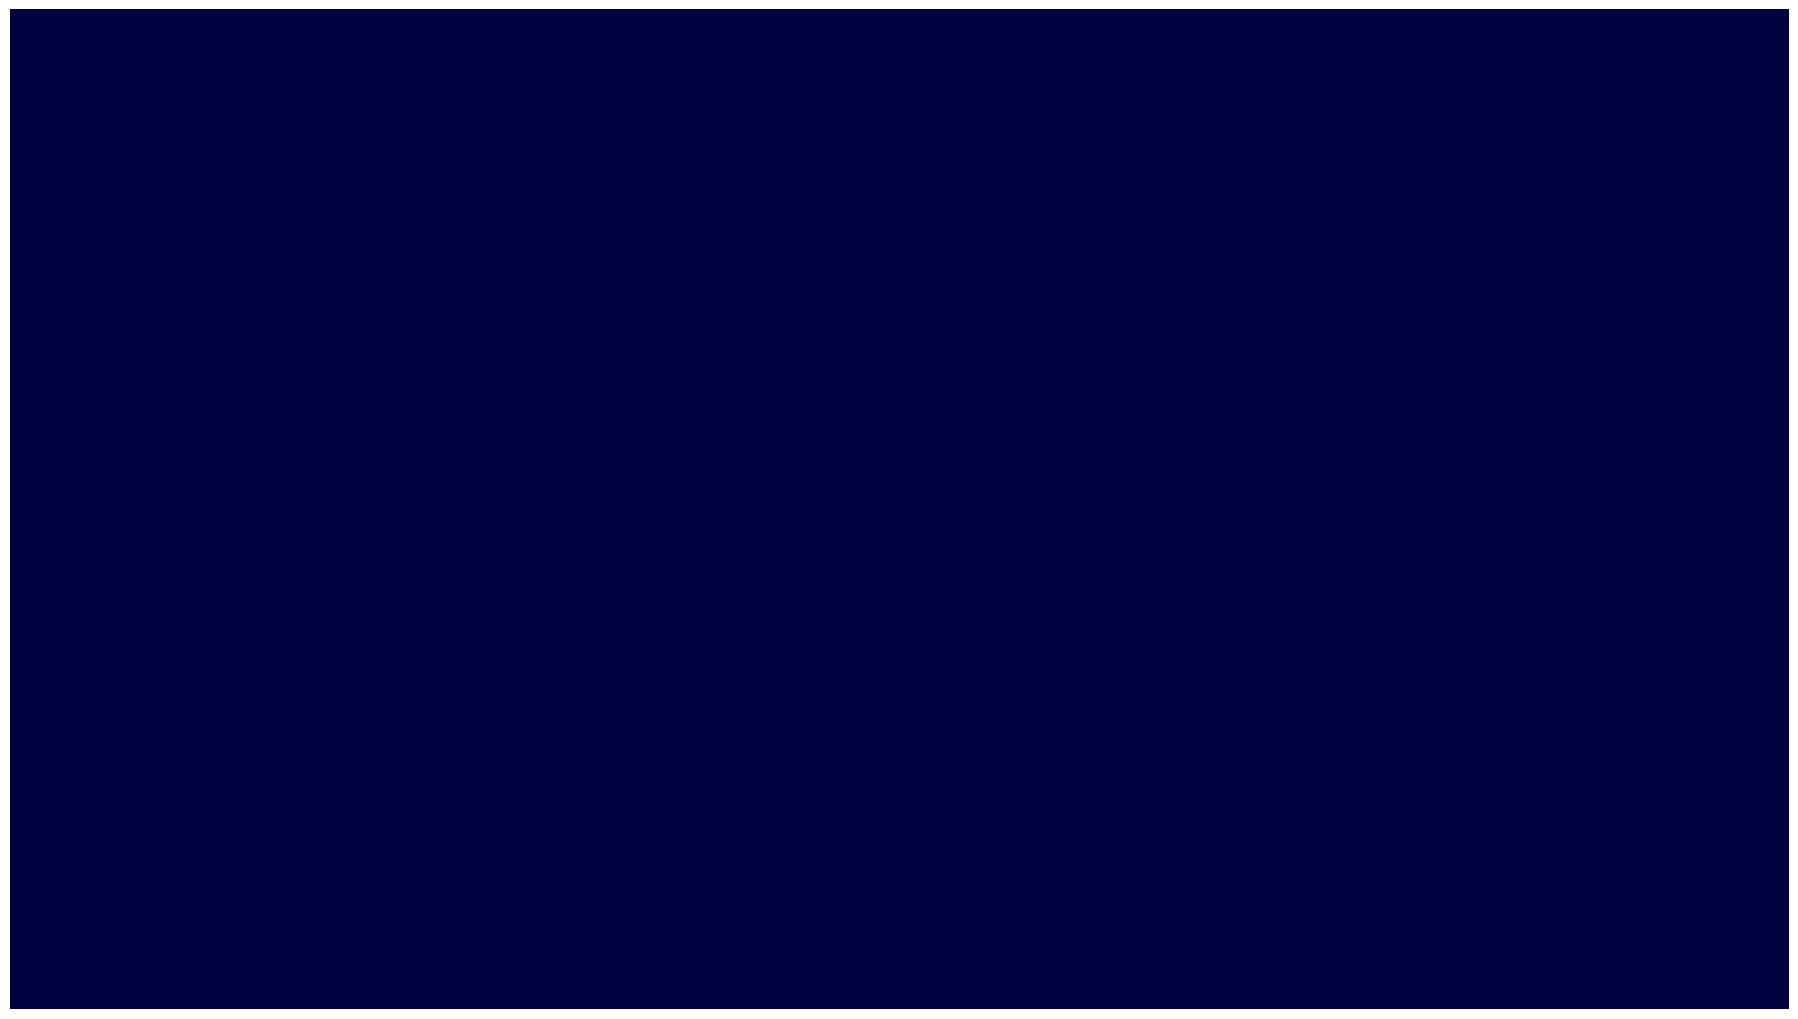

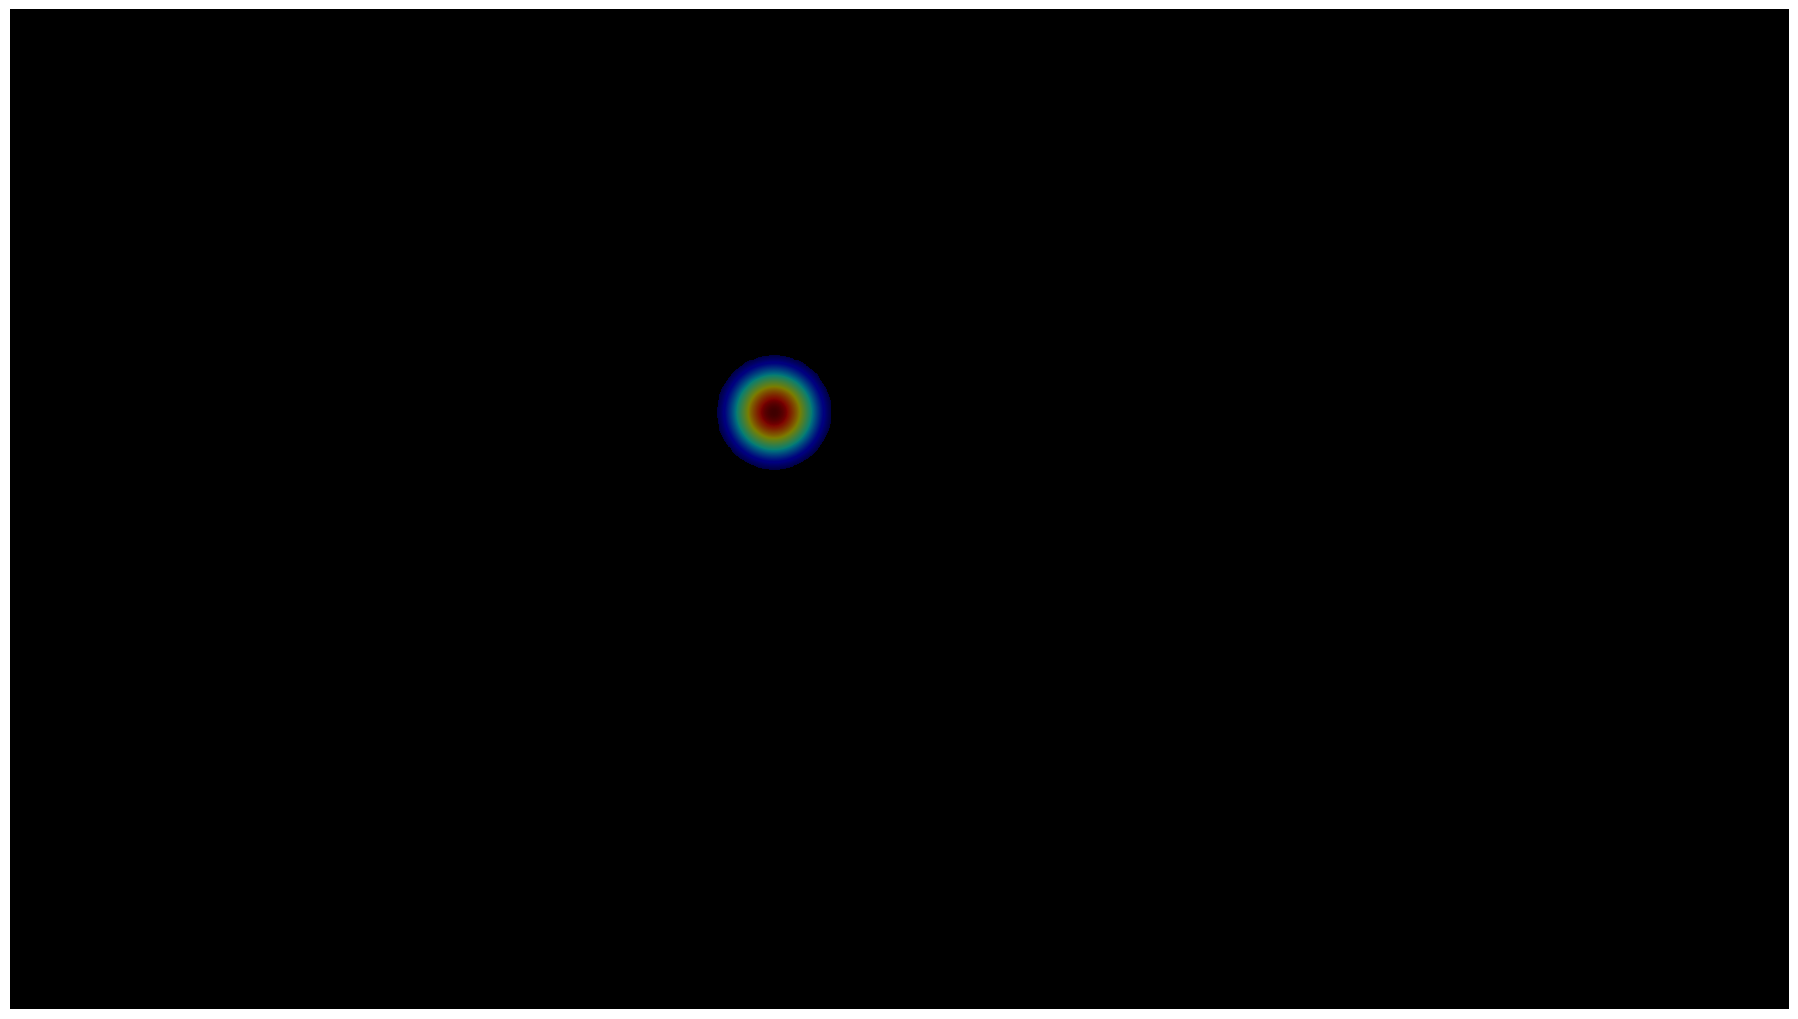

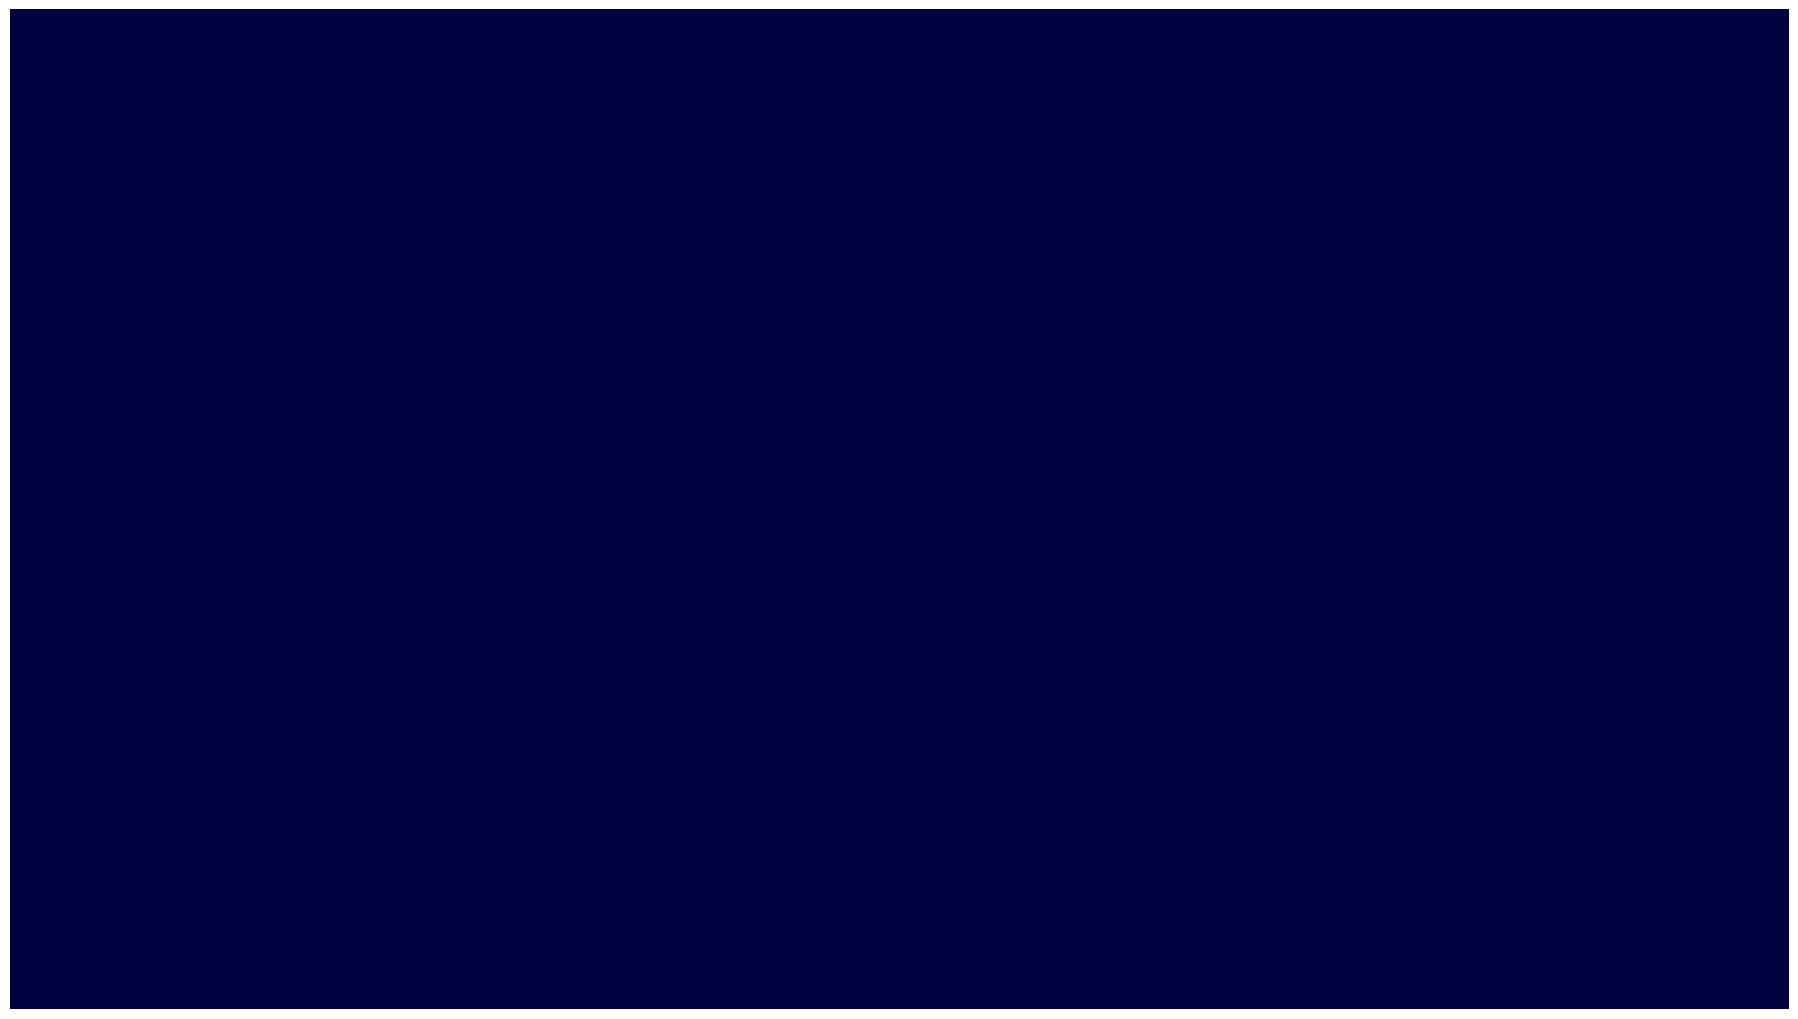

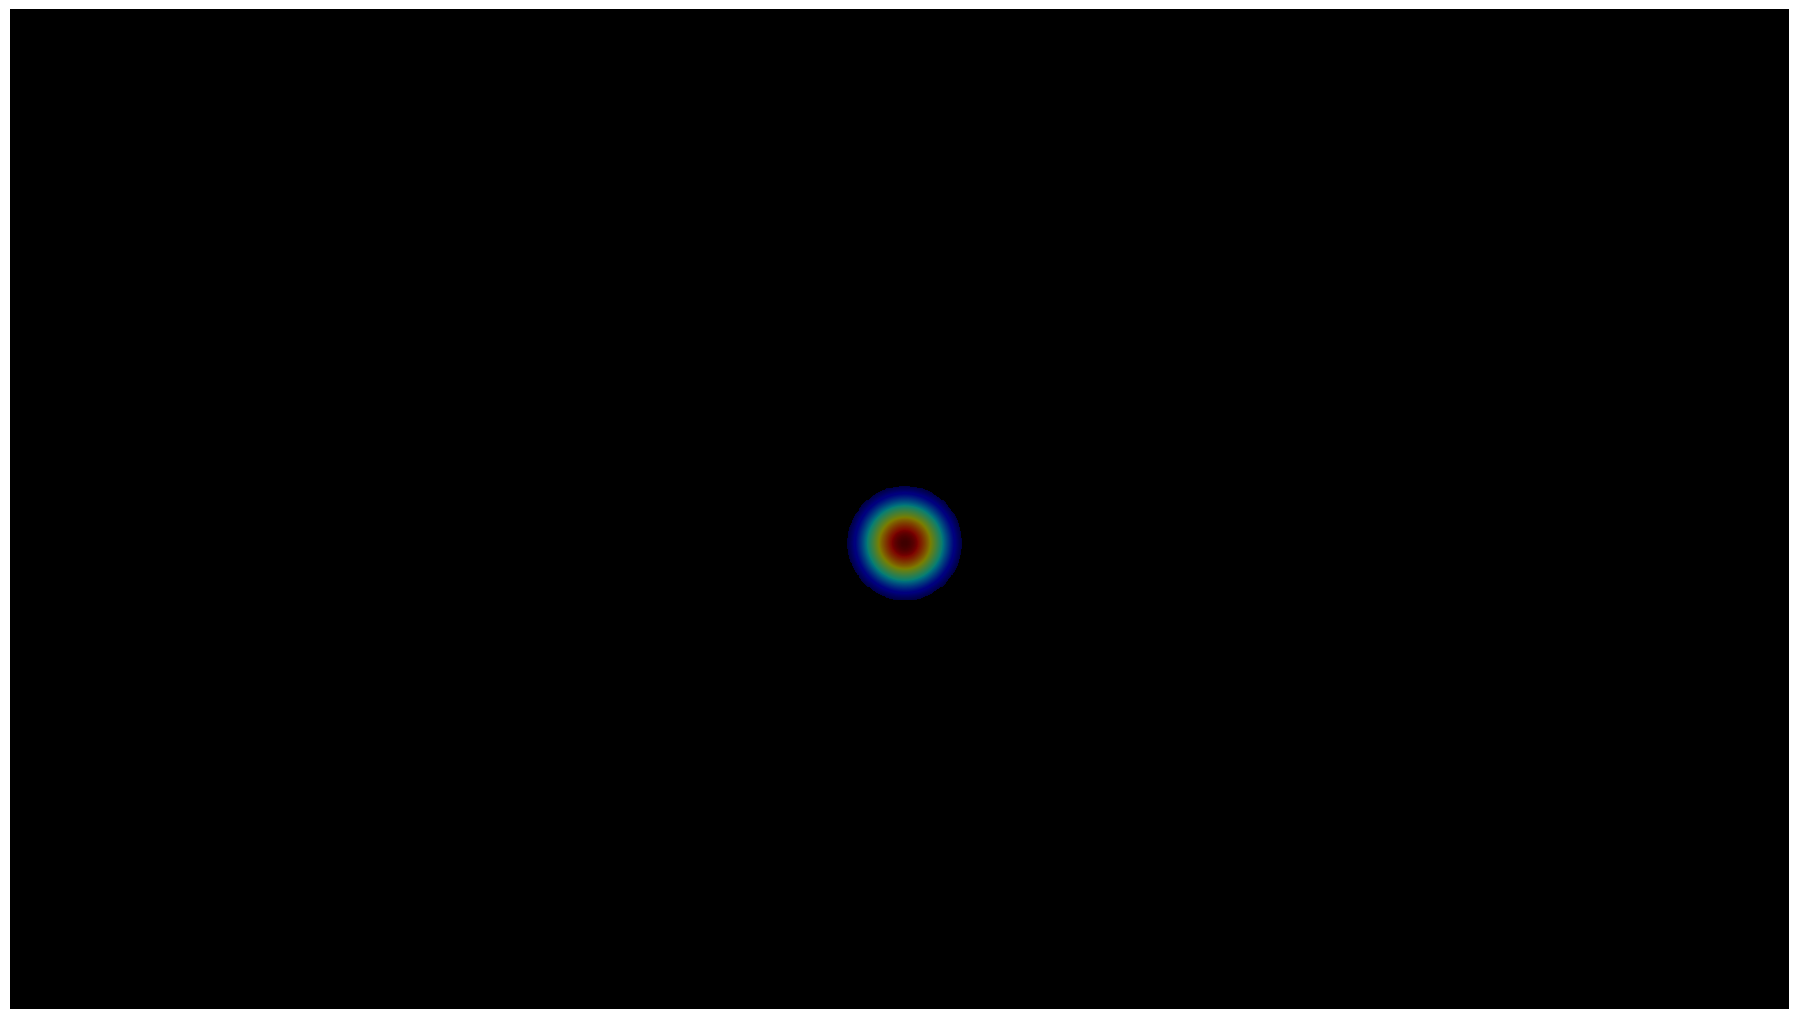

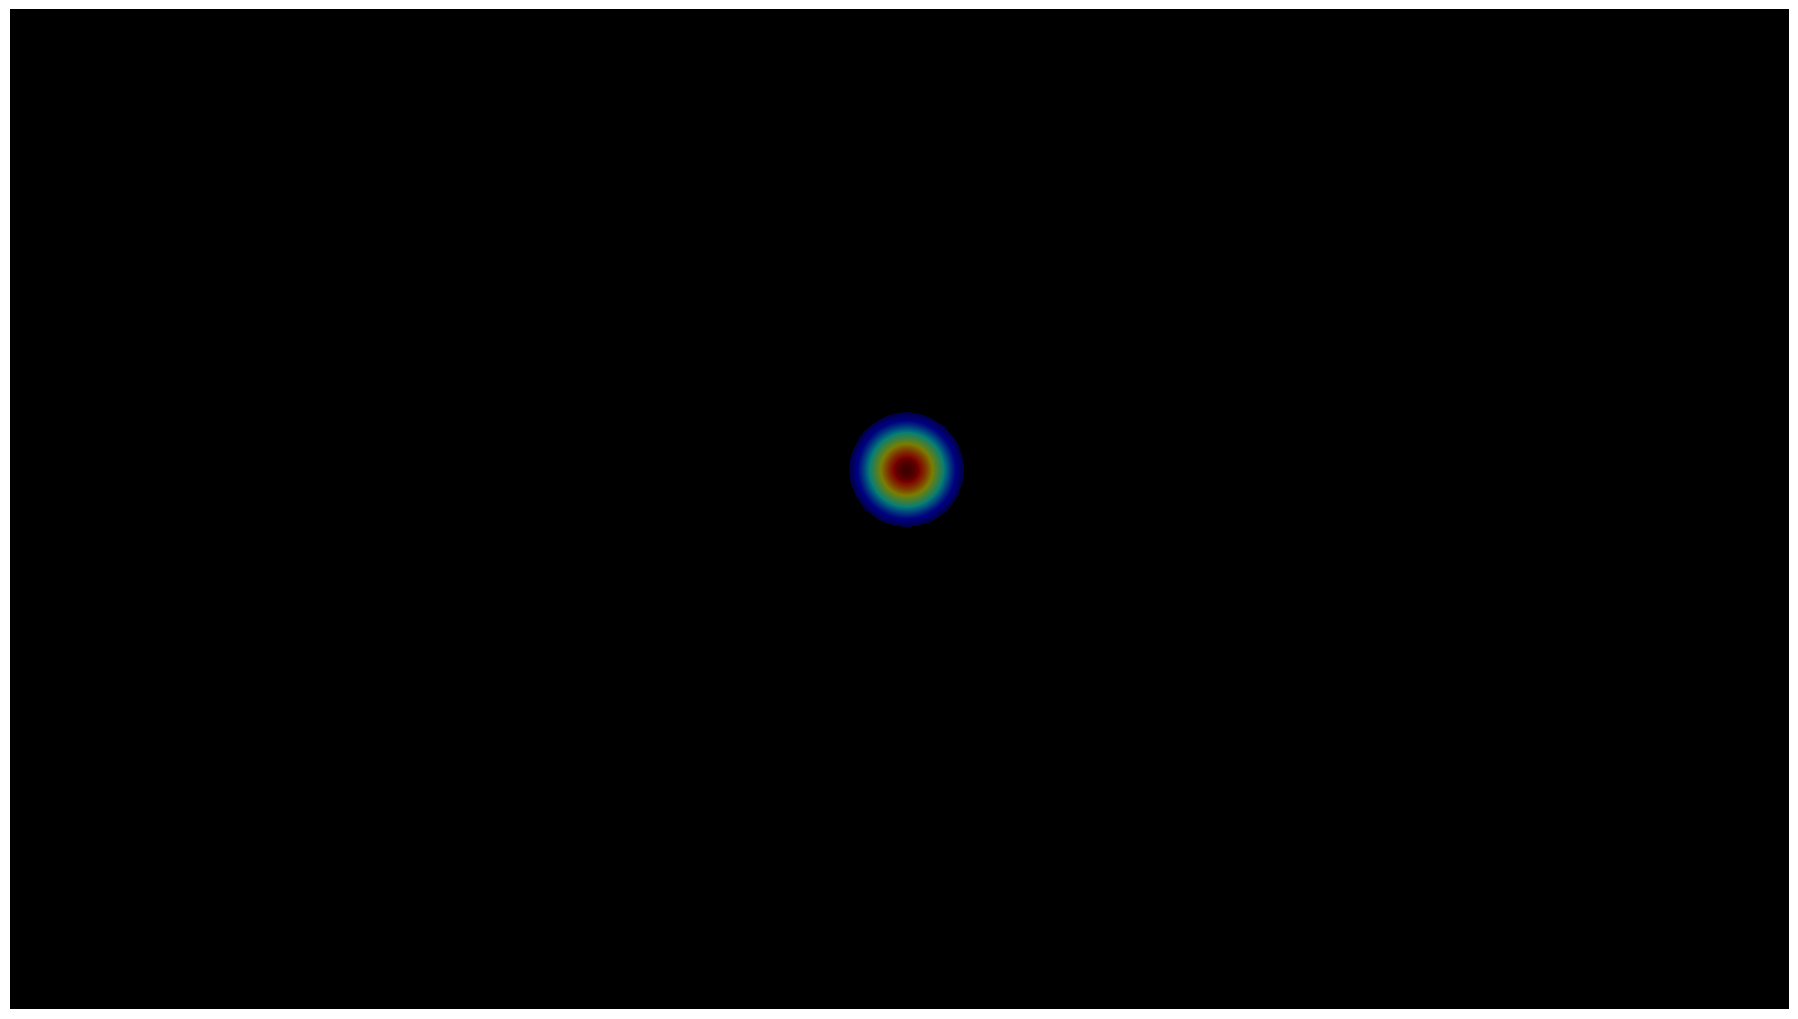

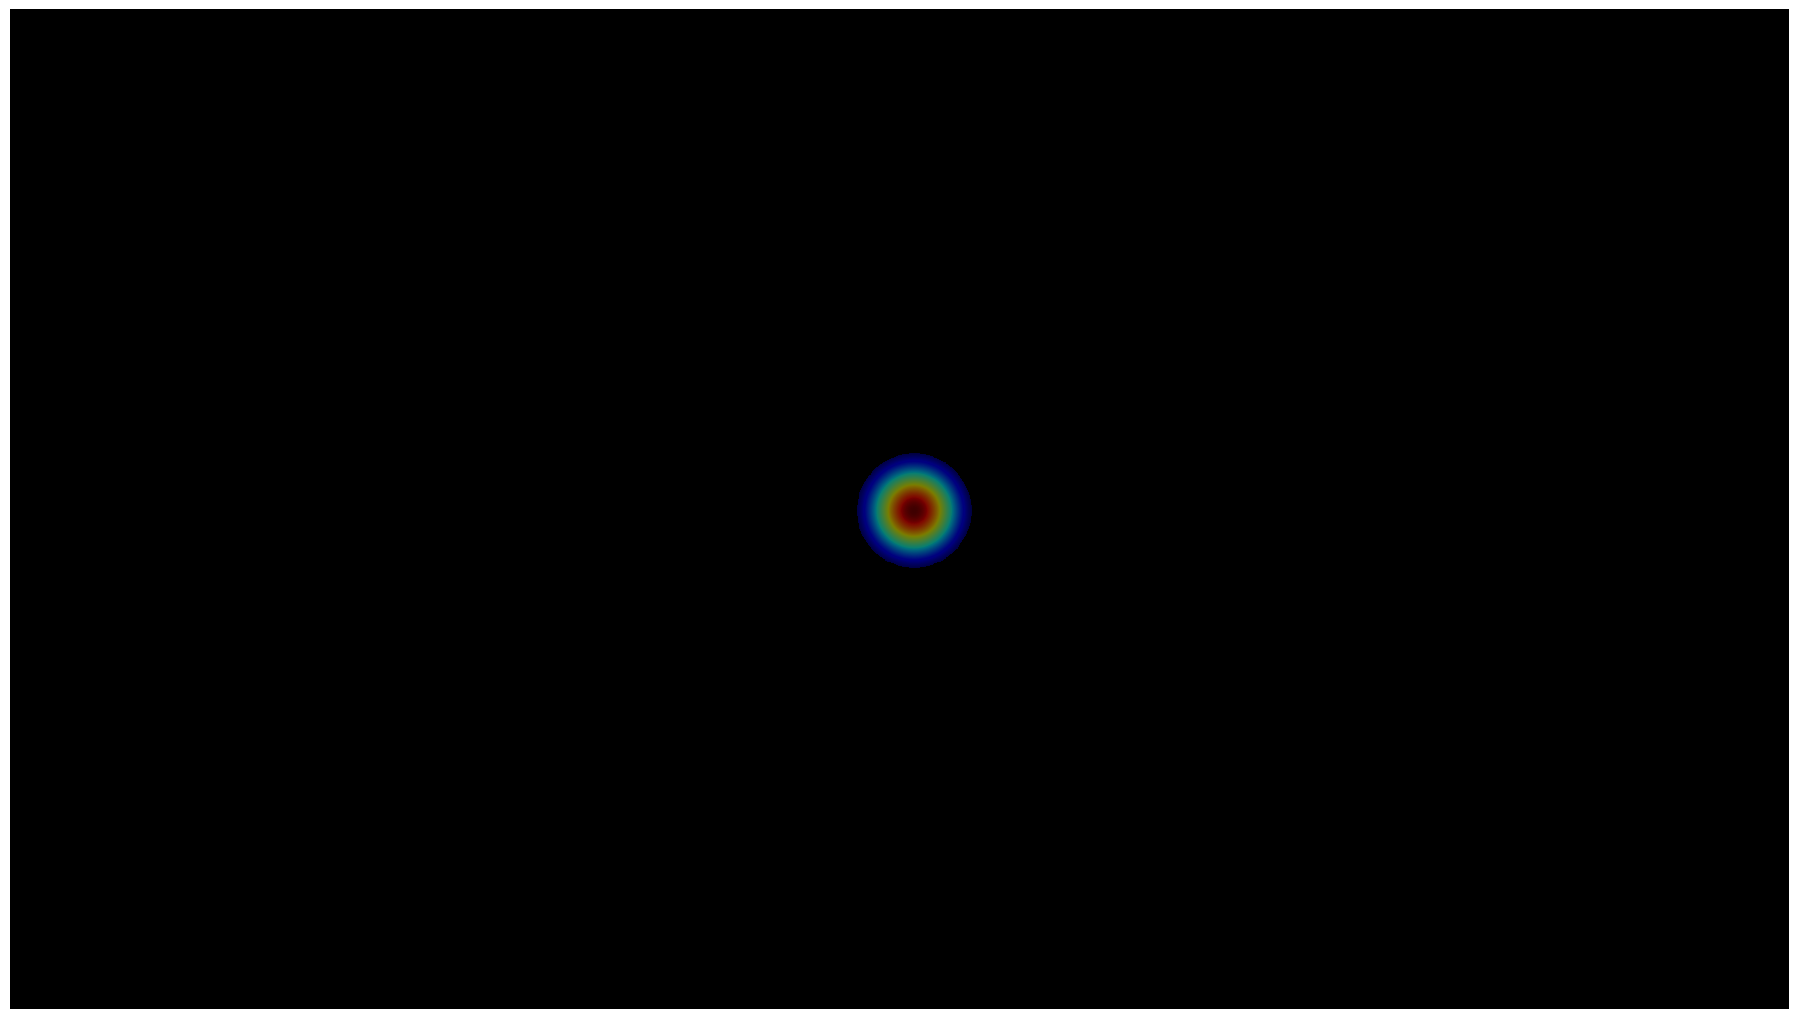

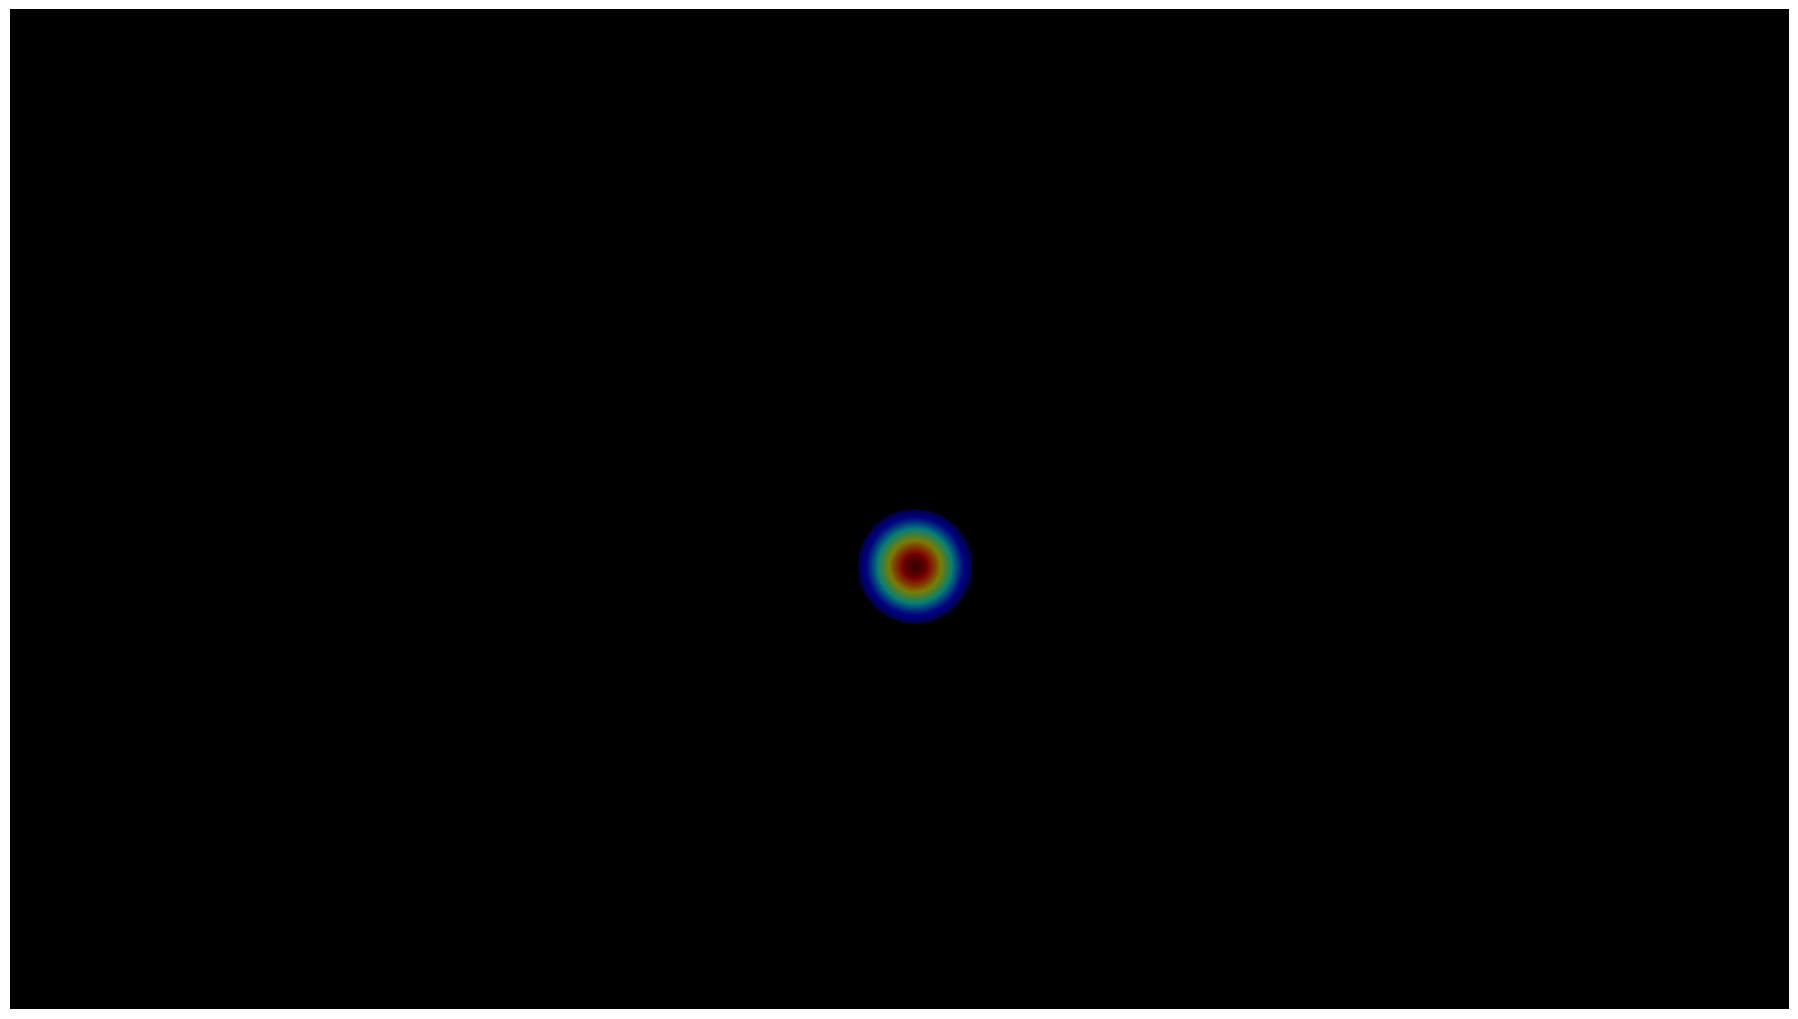

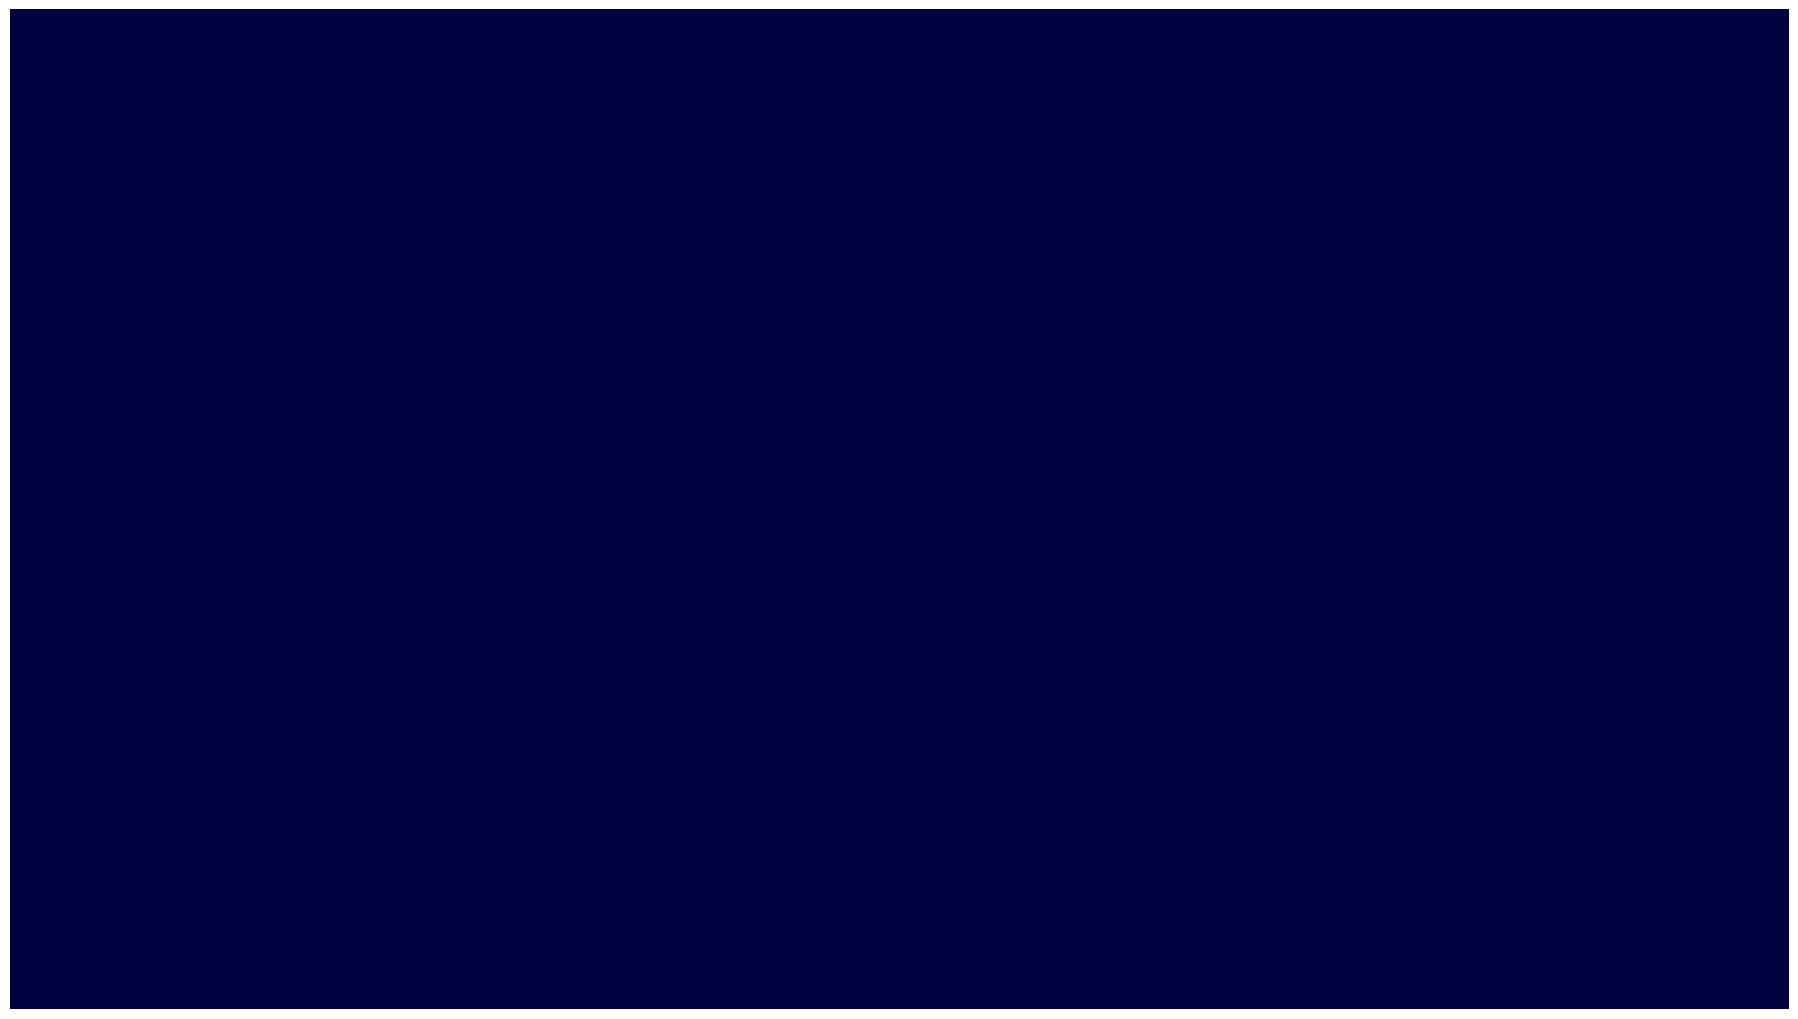

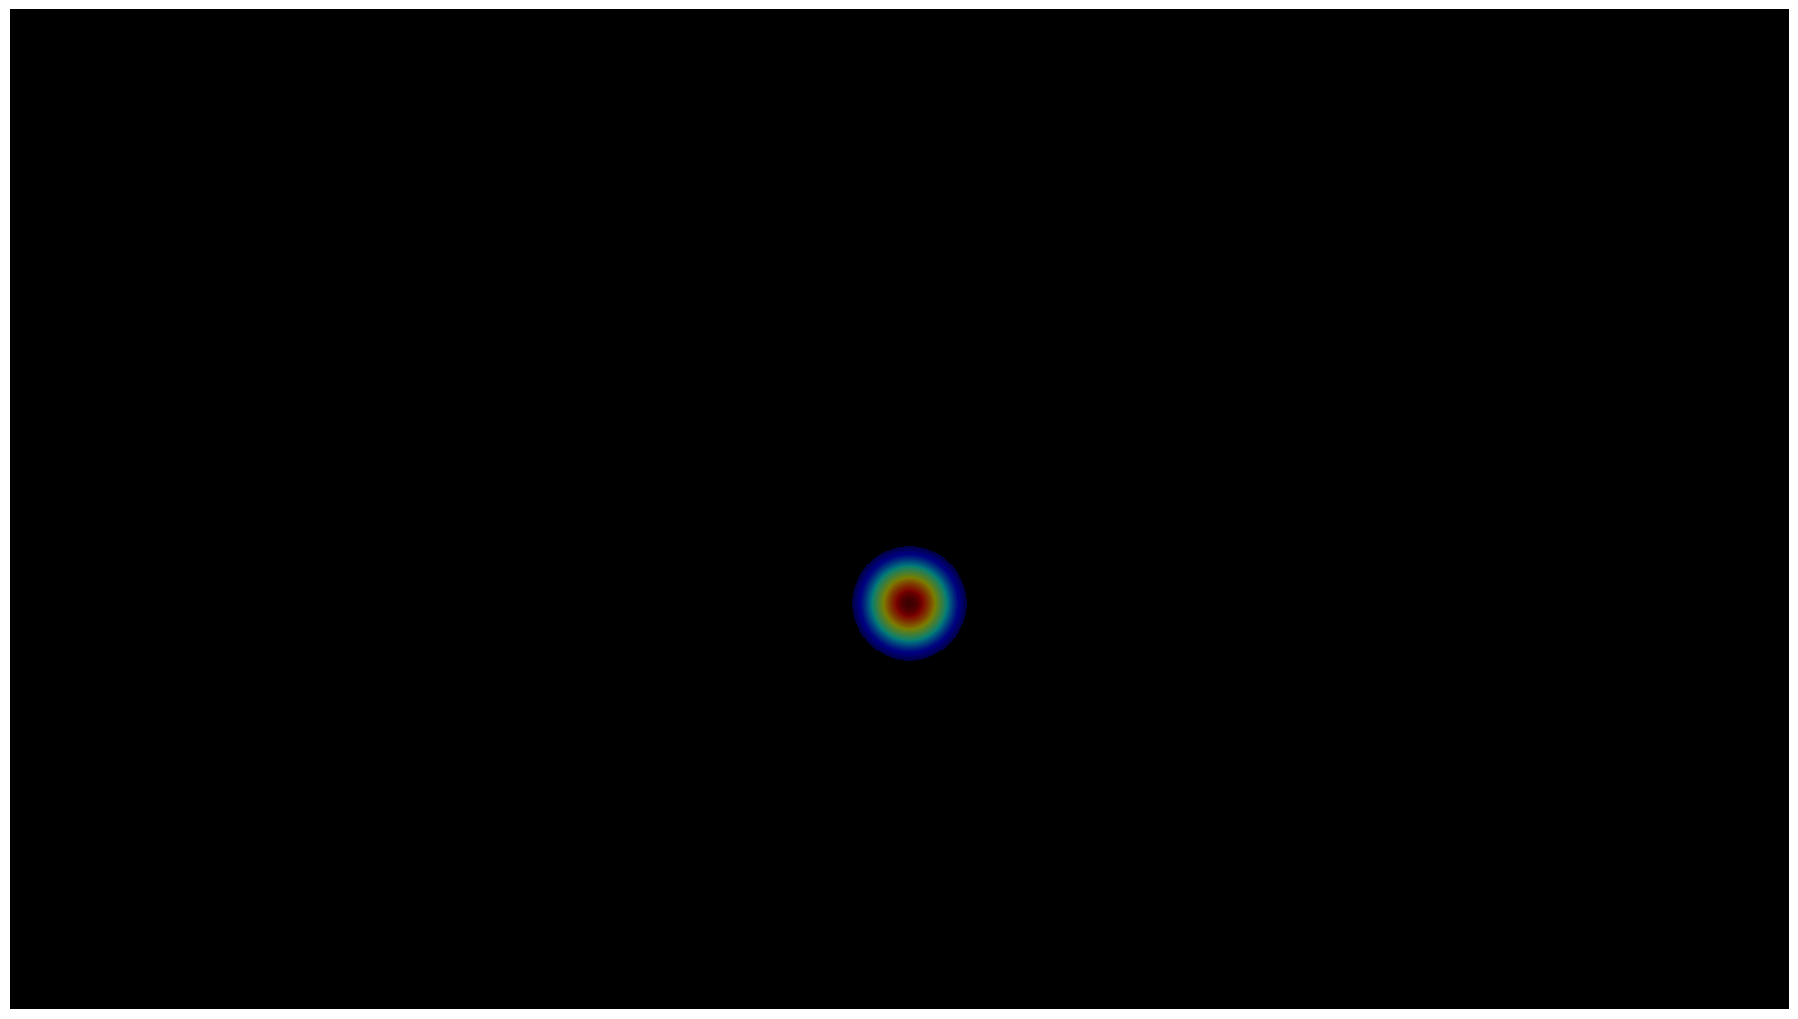

In [28]:
### Plot perceived noise_sample vs inattention

# parameters
partic_id = 'G036'
game_nr   = 16
trials    = np.arange(1,16,1)
dispsize  = (1919,1079) # (px,px) size of screen 

#initialize
x_cross_list,y_cross_list, center_x_list,center_y_list = [],[],[],[]
trial_success = []

#read stimulus data
data = read_data(partic_id,game_nr,phase='stimulus')


for trial_nr in (trials):
    #get crosshair position
    x_cross,y_cross = return_cross_pos(partic_id,game_nr,trial_nr)
    if x_cross!=0:
        ###get centroid
        
        #fixations
        fixations = np.array(data[trial_nr]['events']['Efix'])
        fig_heatmap = draw_heatmap(fixations, dispsize)
        #save heatmap
        fig_heatmap.savefig('img_1.png')

        #feed heatmap to the function
        image_load = cv2.imread('img_1.png',0)
        center,_,image_out = return_centroid_heatmap(image_load)
        #print(center)
        if center.size!=0:
            #print(center)
            if center.shape[0]>1:
                #print(center.shape)
                center = center[0] #CHANGE LATER!!!
            #plot center - cross hair distance
            #dist = np.sqrt((x_cross-center[0][0])**2 + (y_cross-center[0][1])**2)
            #plt.scatter(trial_nr,dist)
            x_cross_list.append(x_cross)
            y_cross_list.append(y_cross)
            center_x_list.append(center[0][0])
            center_y_list.append(center[0][1])
            trial_success.append(trial_nr)



In [29]:
#calculate distances from center point
dist = np.sqrt((np.array(center_x_list) - np.array(x_cross_list))**2 +
               (np.array(center_y_list) - np.array(y_cross_list))**2)


#get standard deviation
#load data set
fname = 'dataset_0423.csv'
data_set = load_dataset_properties(fname)
std_dev_list =[]
property_label= 'perc_noise_sample'
for trial_nr in trials:
    #check if successful trial
    if trial_nr in trial_success:
        std_dev = return_property_value(data_set,subject_id, game_nr+1,trial_nr,property_label)
        std_dev_list.append(std_dev)
        
std_dev_list = np.array(std_dev_list).astype(float)#/max(std_dev_list)

##plot the non-empty trials
fig,ax = plt.subplots()
for i,trial_nr in enumerate(trial_success):
    ax.plot(trial_nr,dist[i],'-o',markersize=std_dev_list[i])
    #print(dist[i],trial_nr)
    title = 'Game No {}'.format(game_nr)
    ax.set_title(title)
    ax.set_xlabel('Trial No')
    ax.set_ylabel('Inattention')
    
fig.savefig(title+'.png')

NameError: name 'subject_id' is not defined

In [ ]:
len(data)

[[54]]
[[54], [54]]
[[54], [54], [54]]
[[54], [54], [54], [54]]
[[54], [54], [54], [54], [54]]
[[54], [54], [54], [54], [54], [54]]
[[54], [54], [54], [54], [54], [54], [54]]
[[54], [54], [54], [54], [54], [54], [54], [54]]


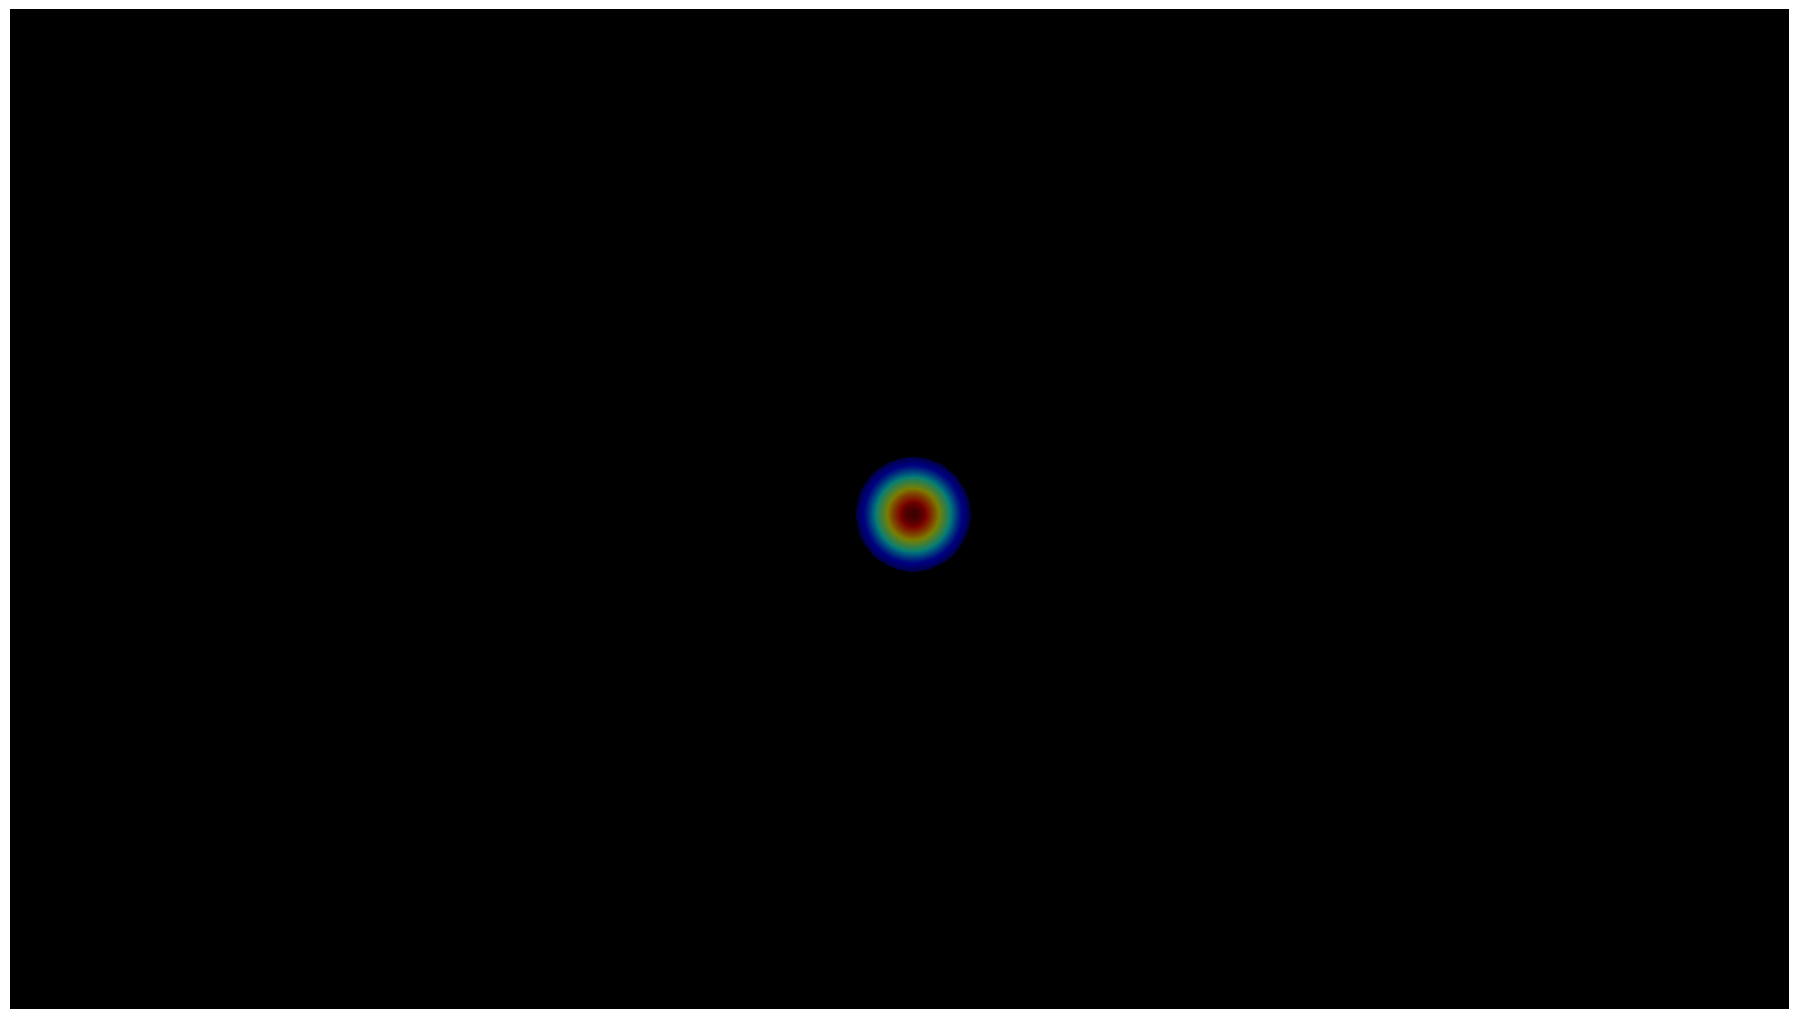

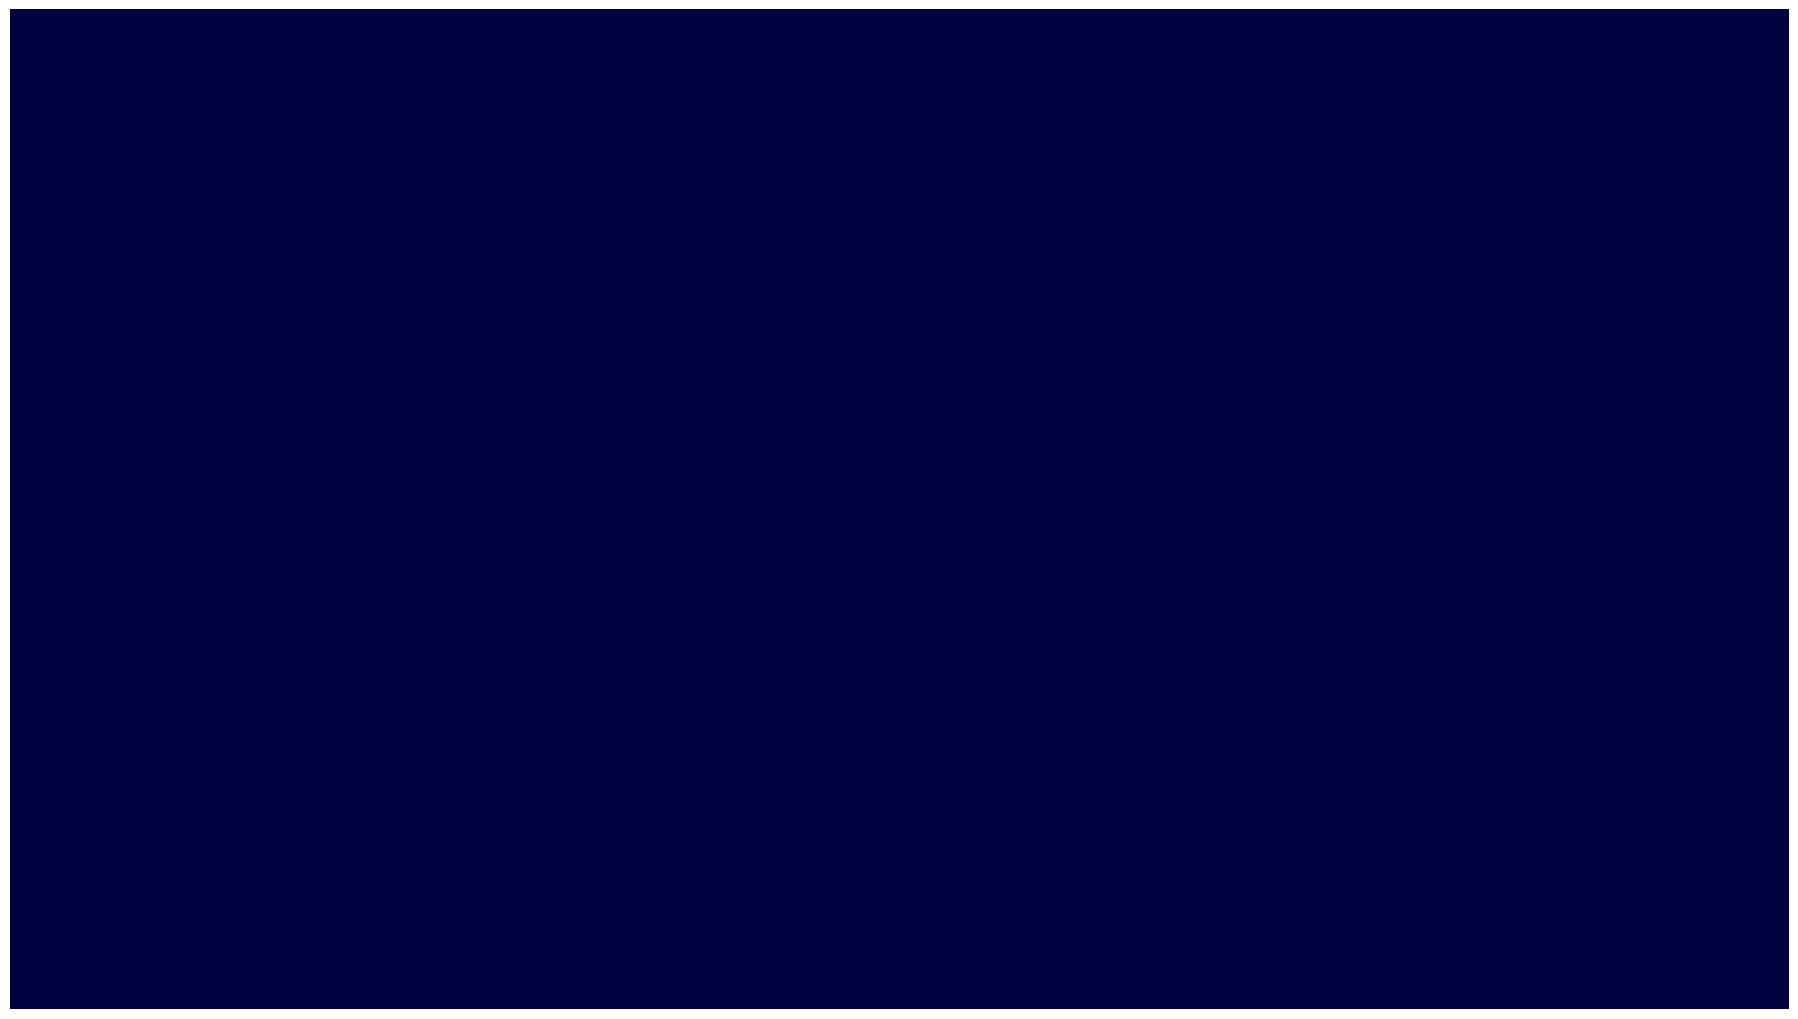

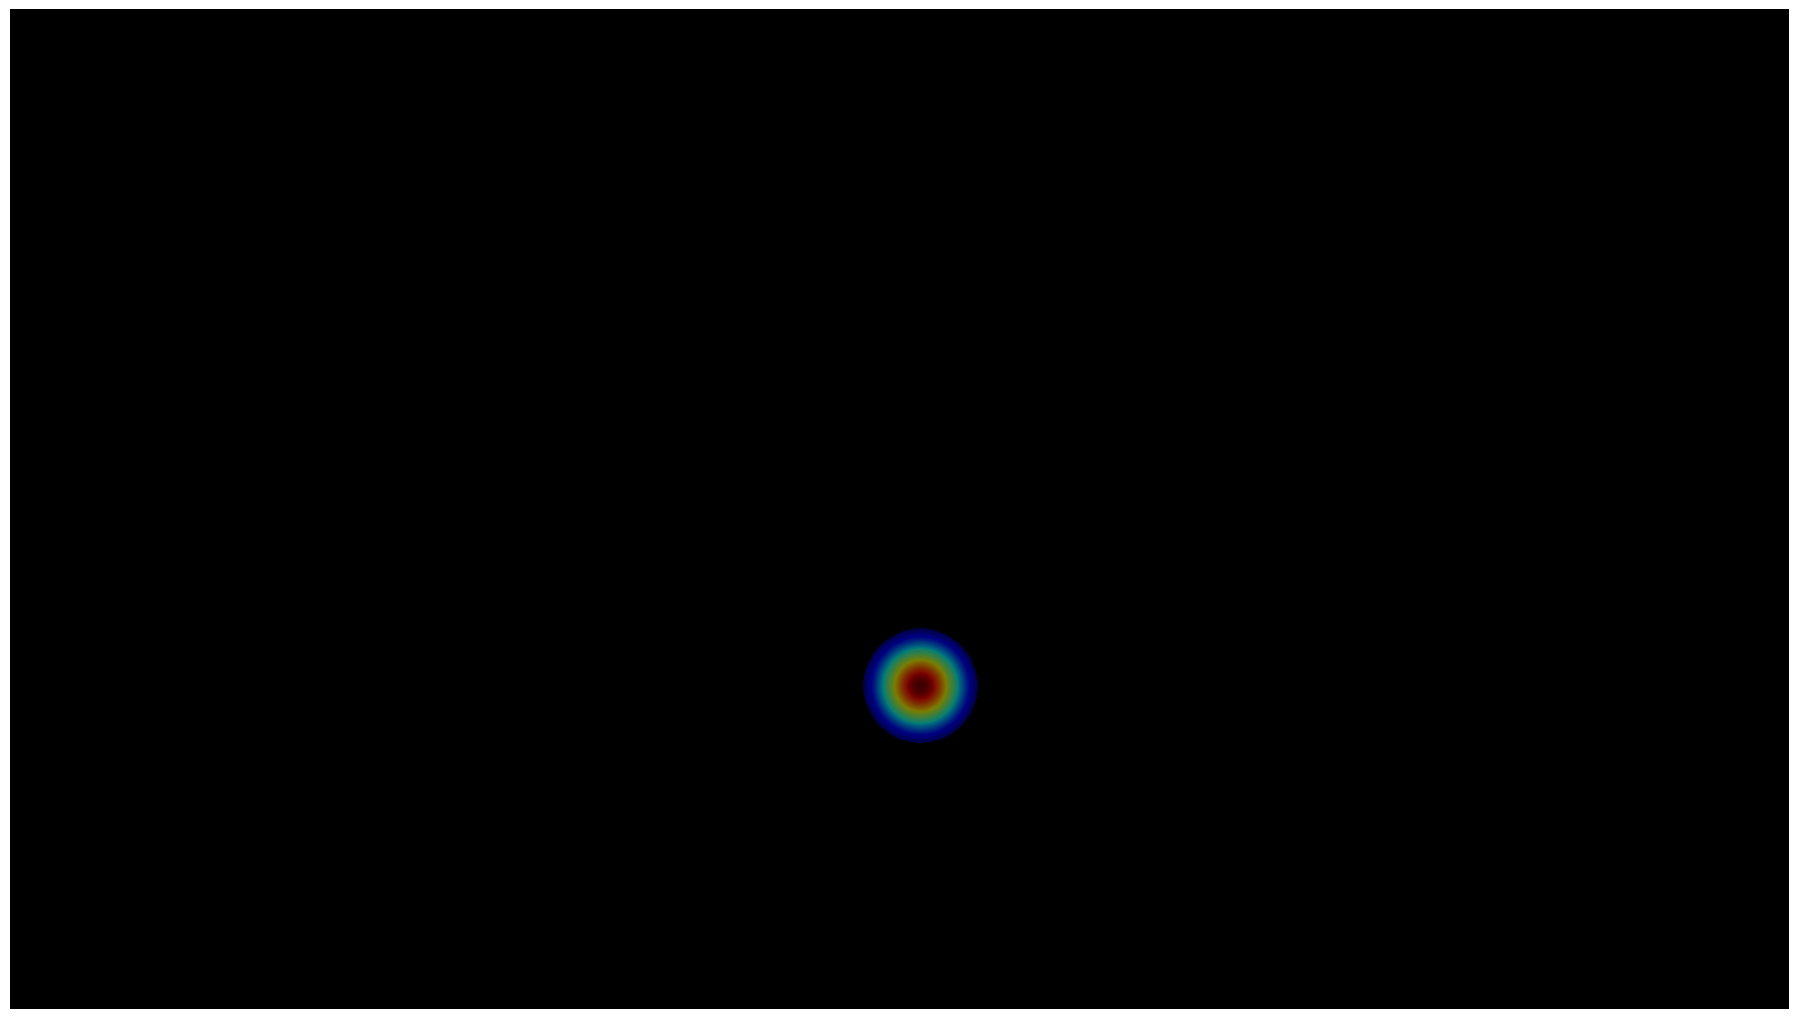

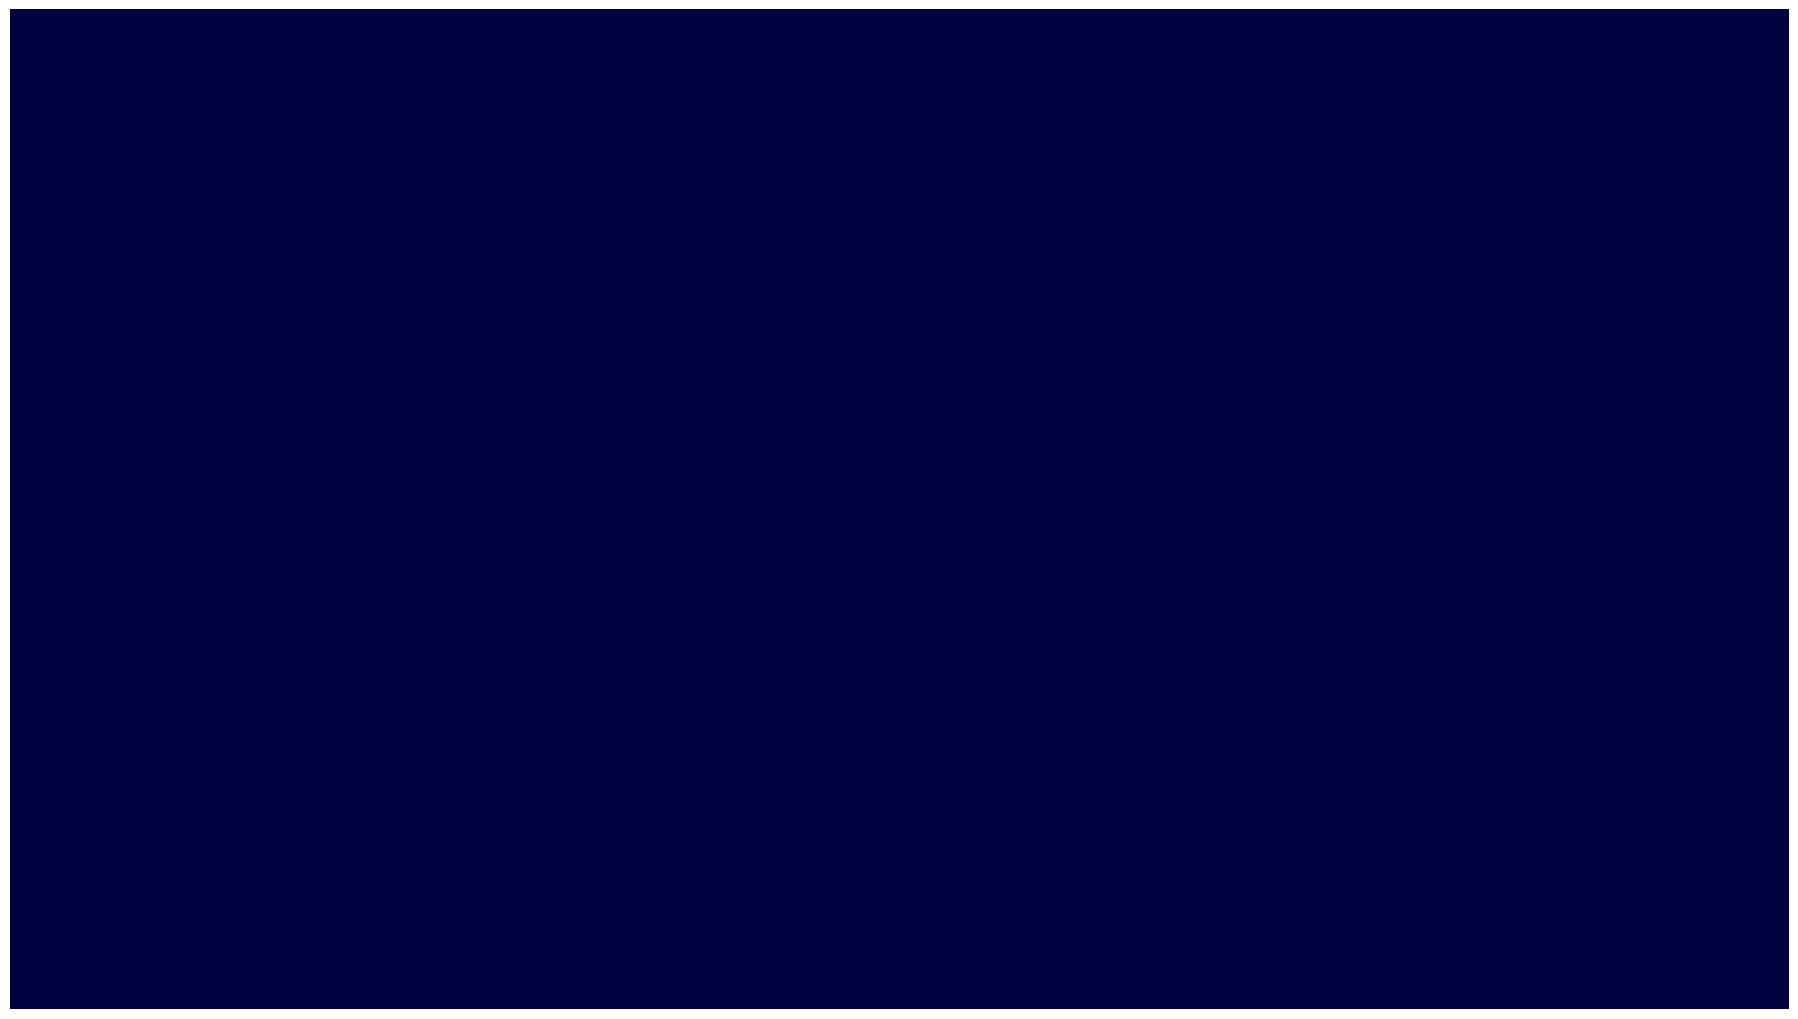

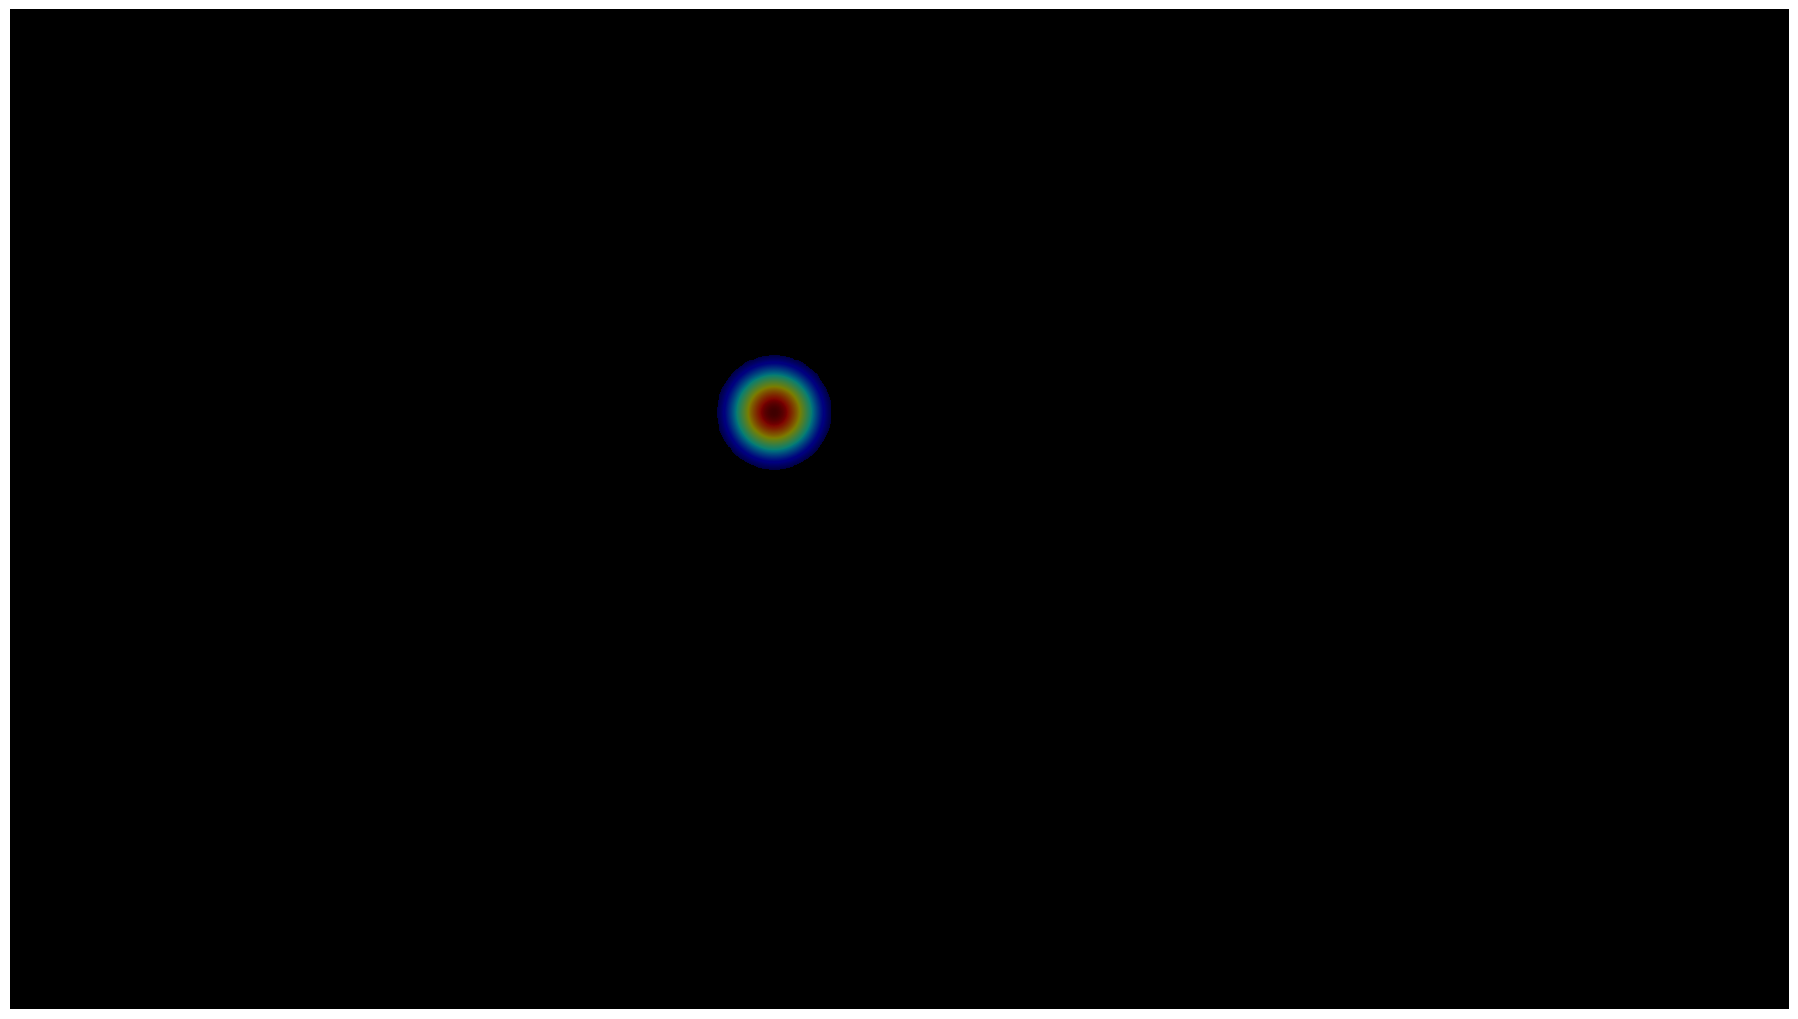

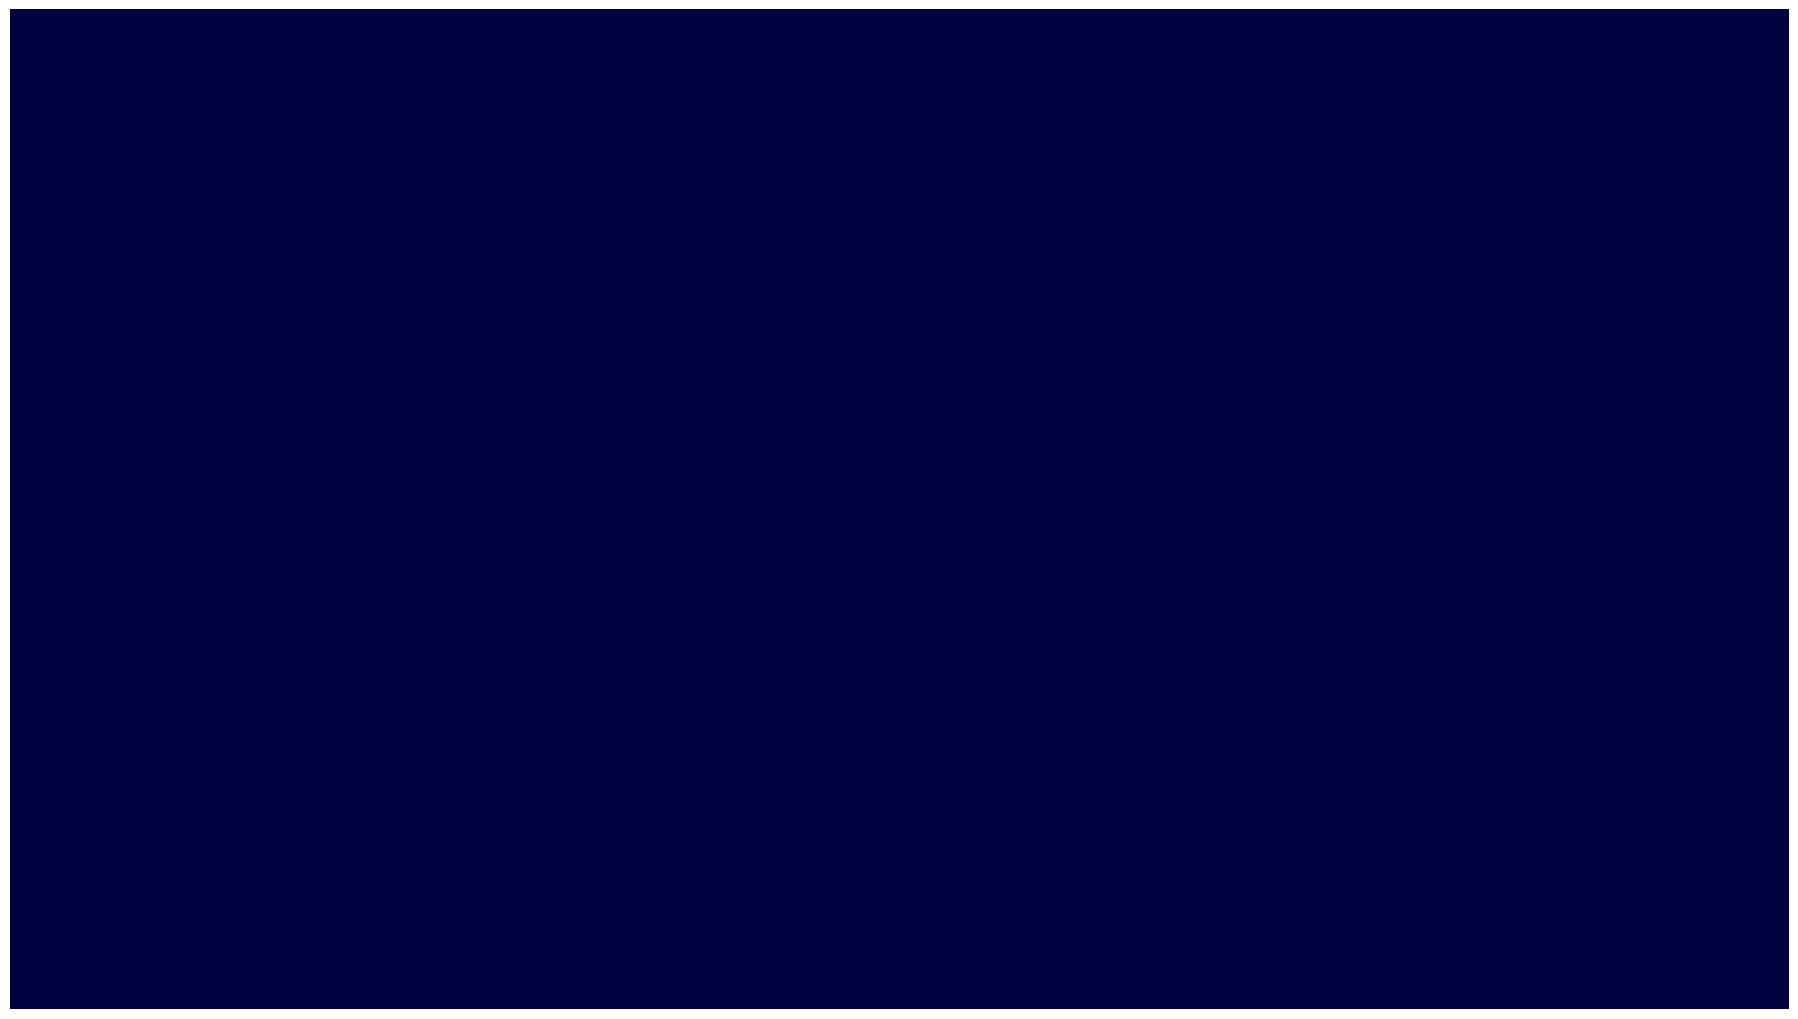

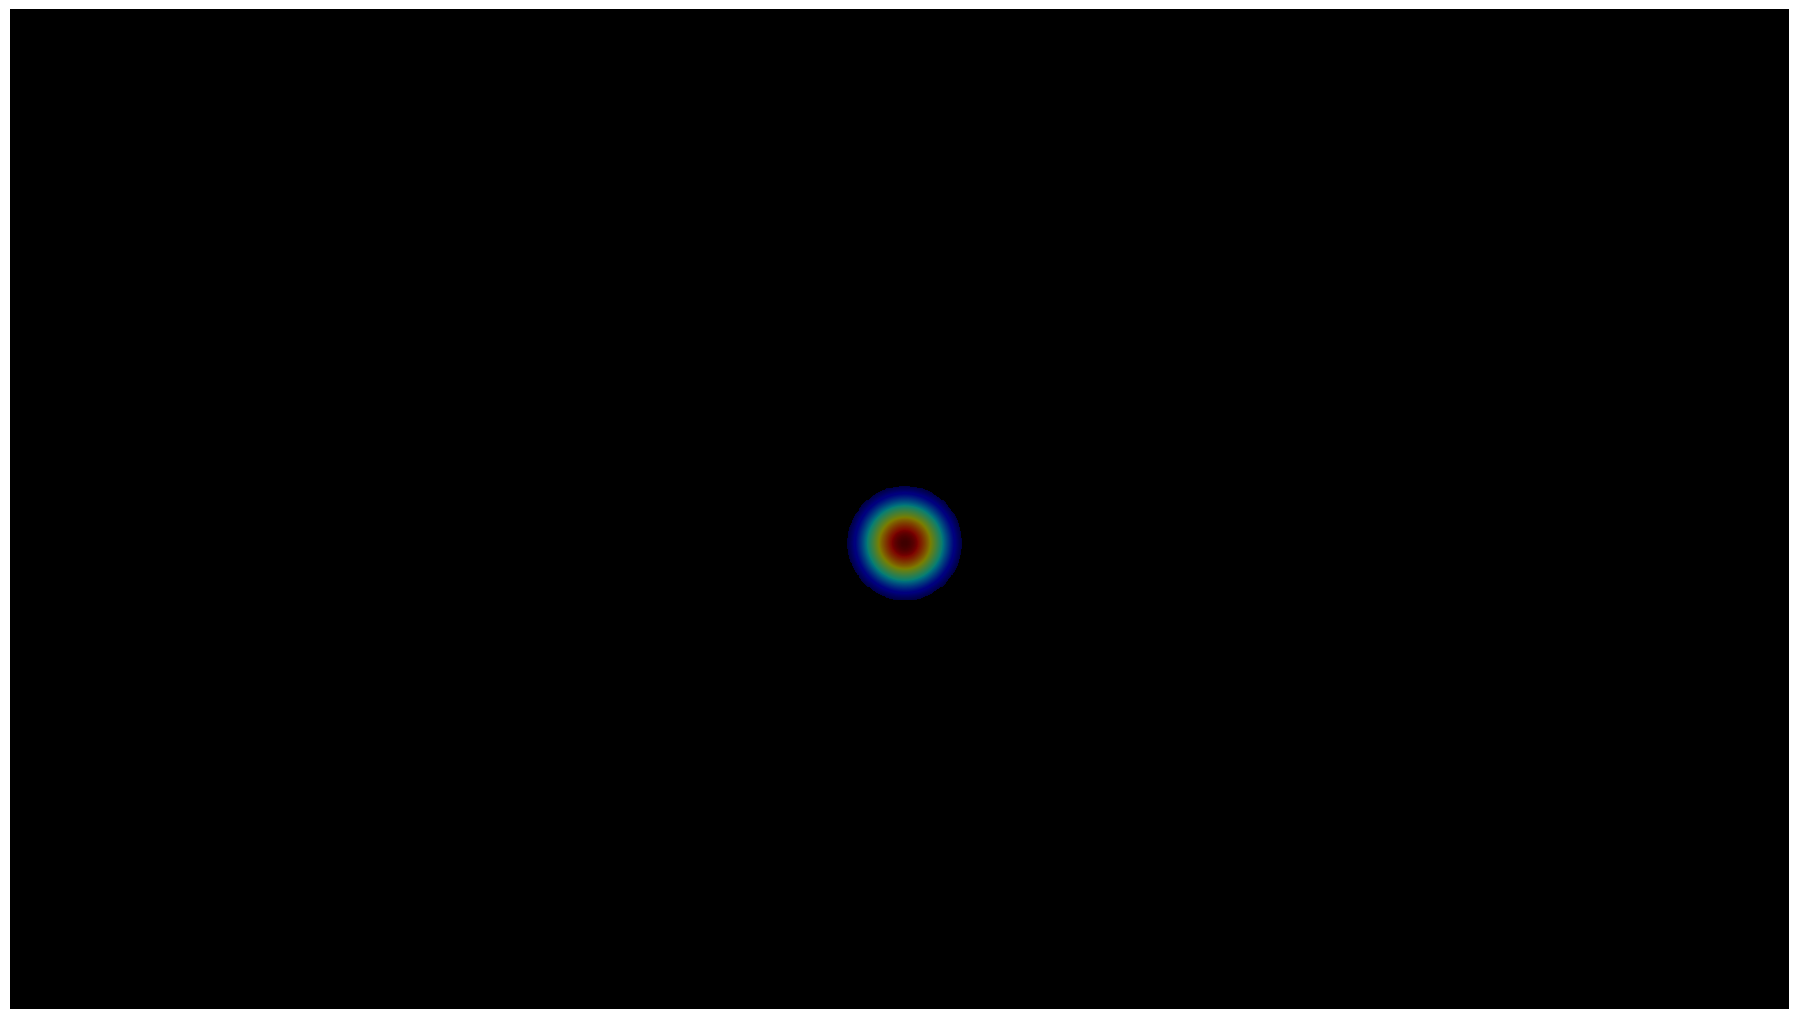

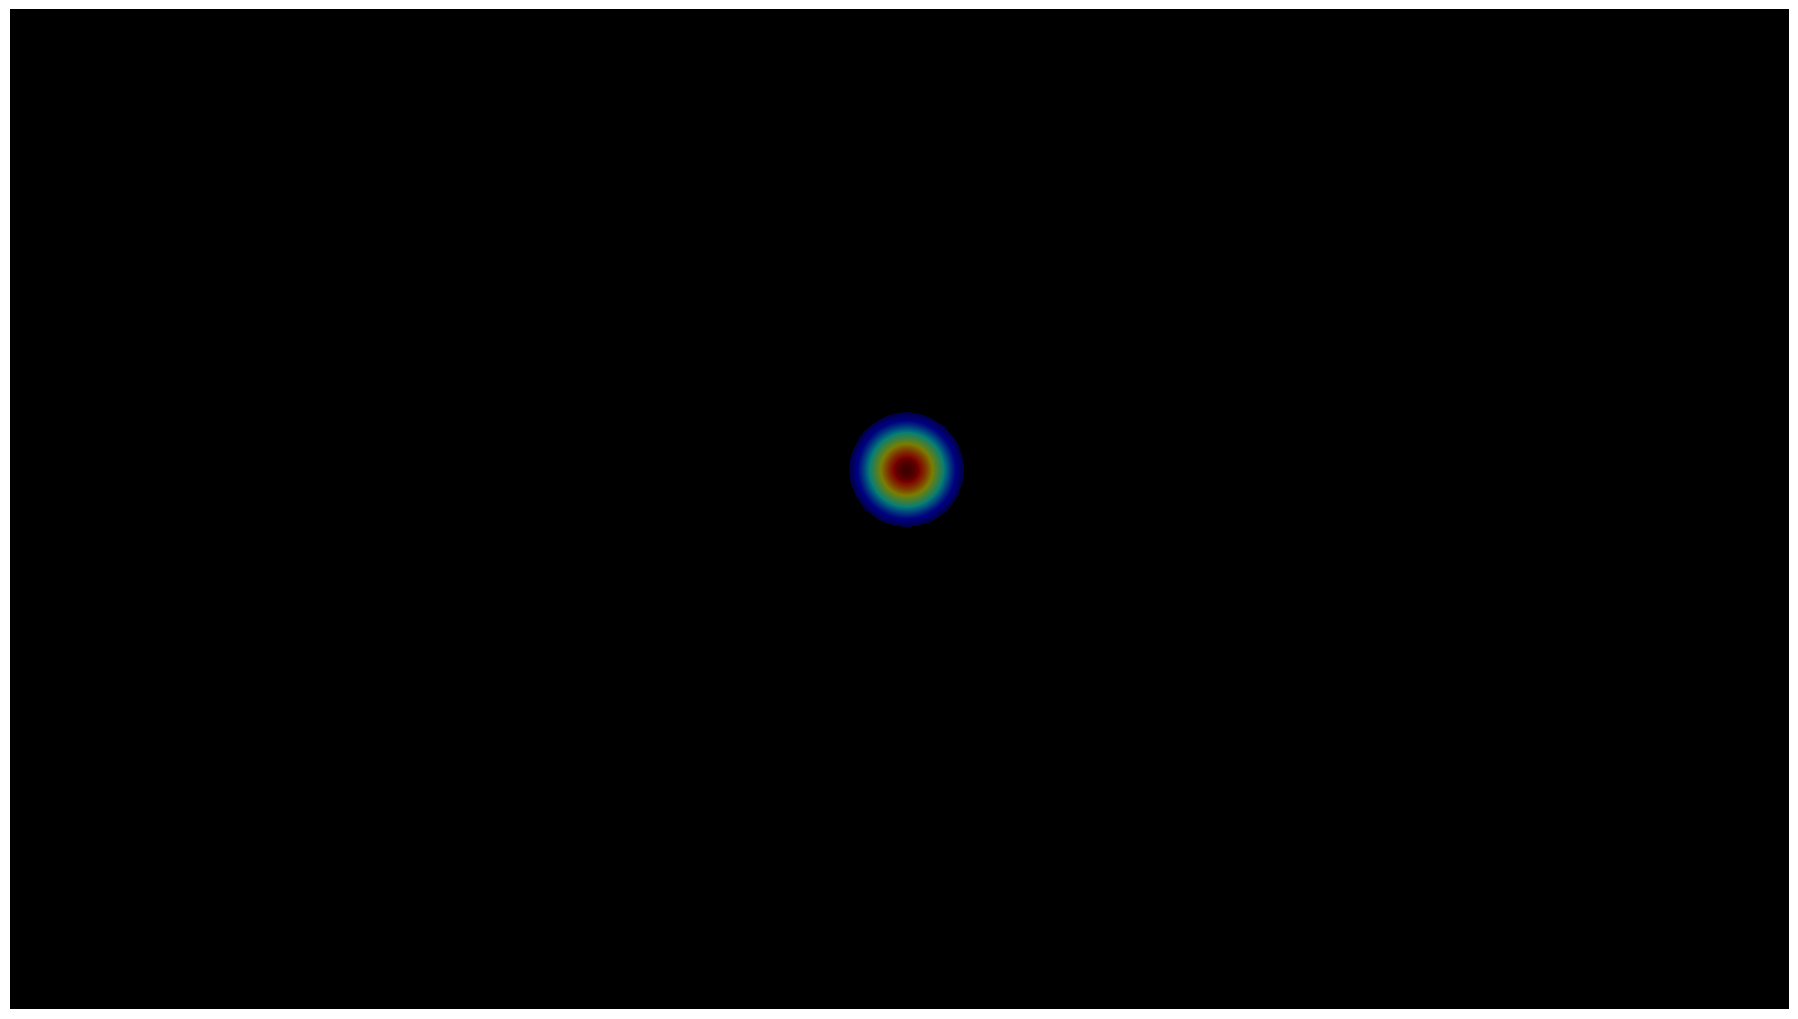

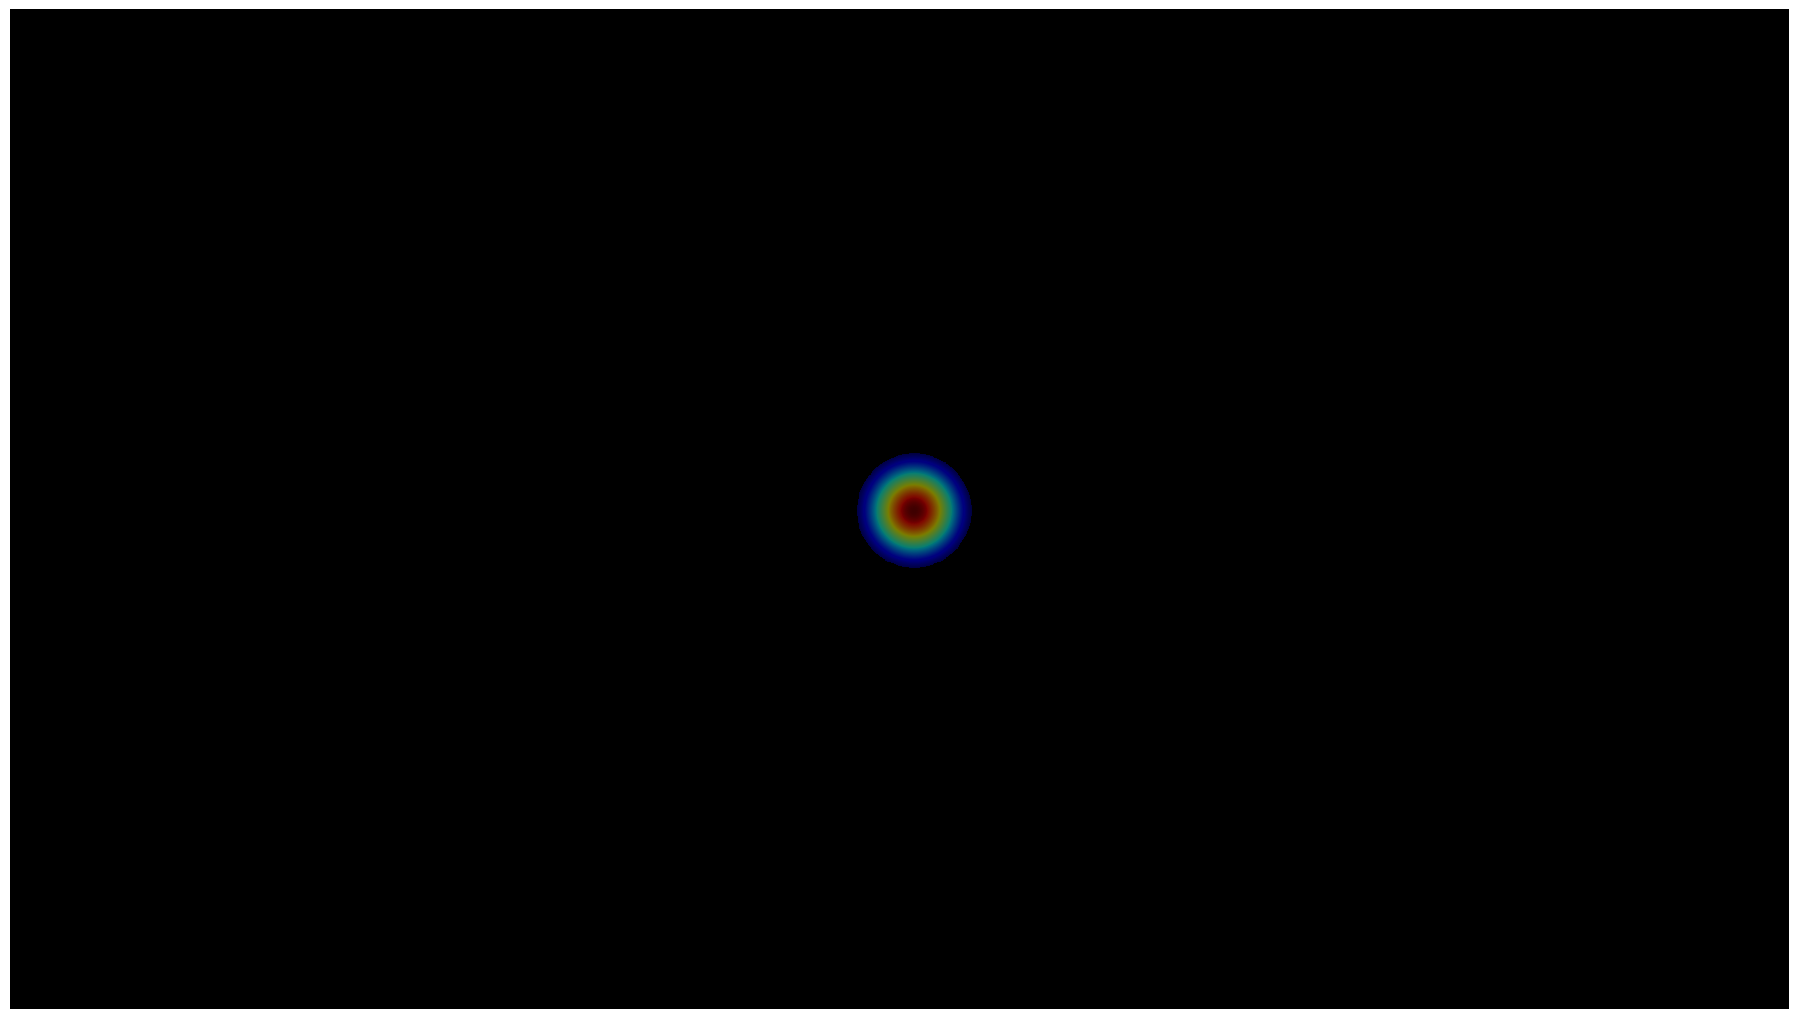

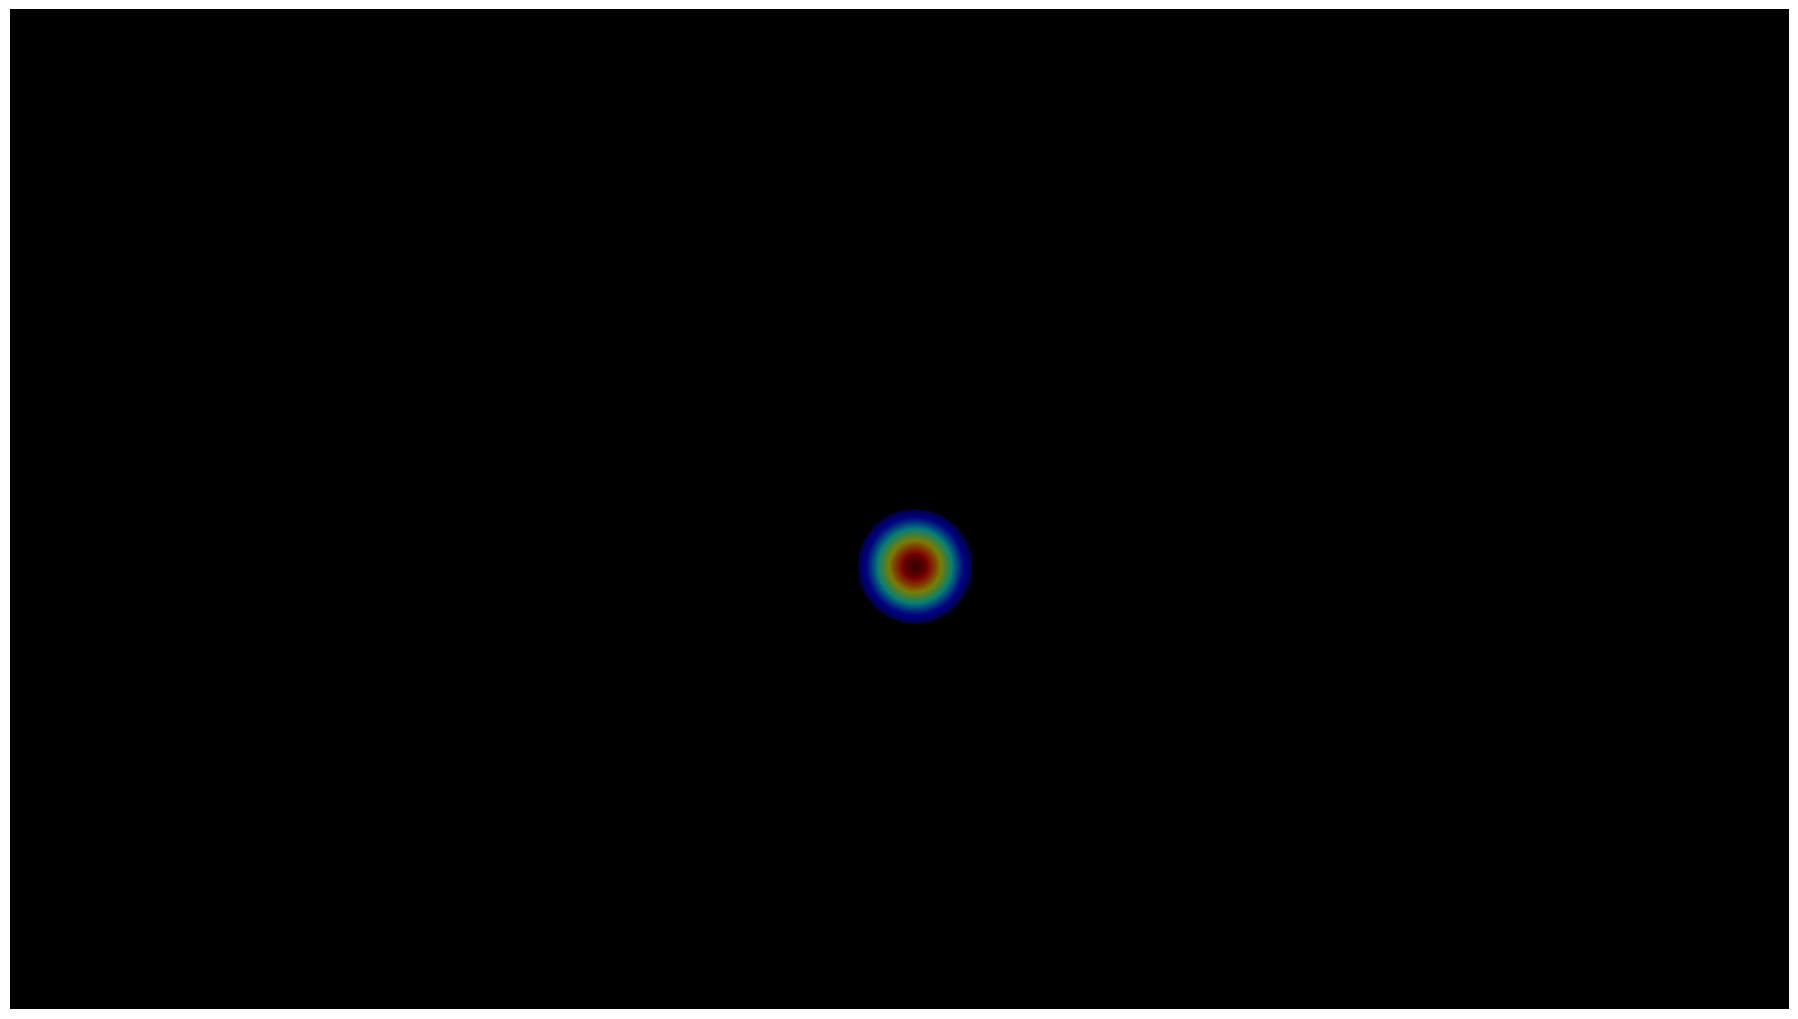

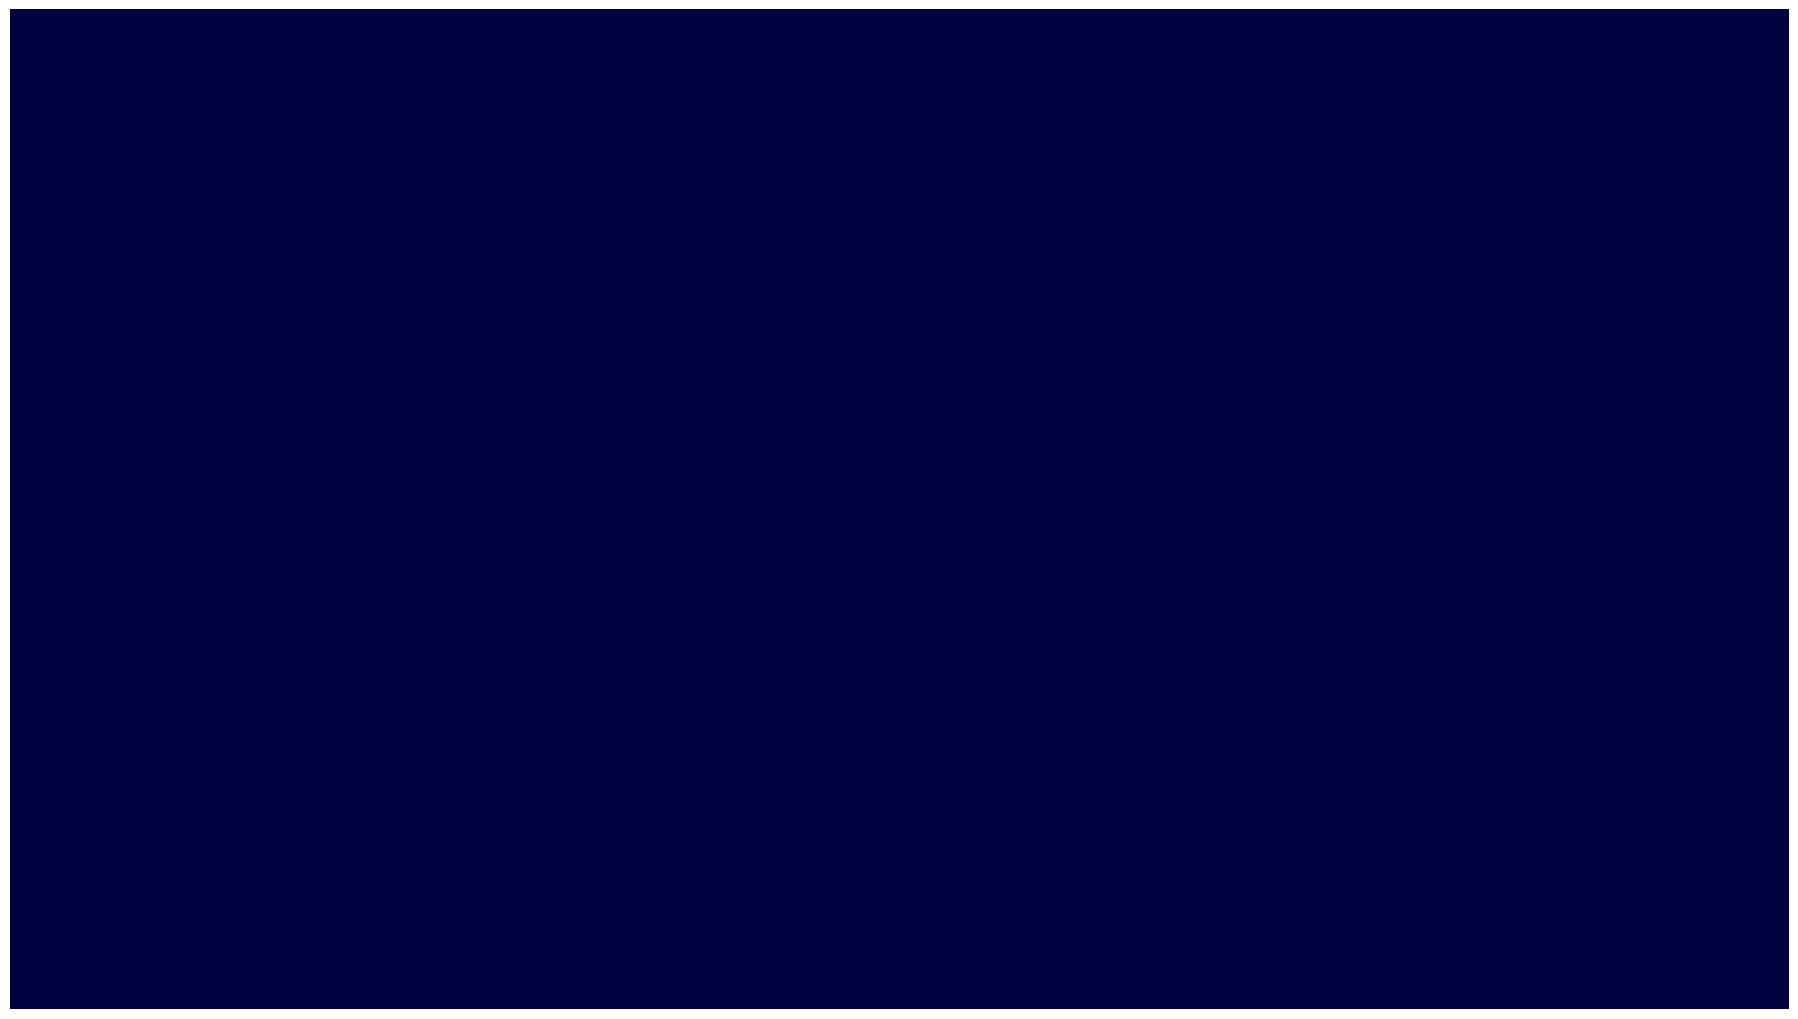

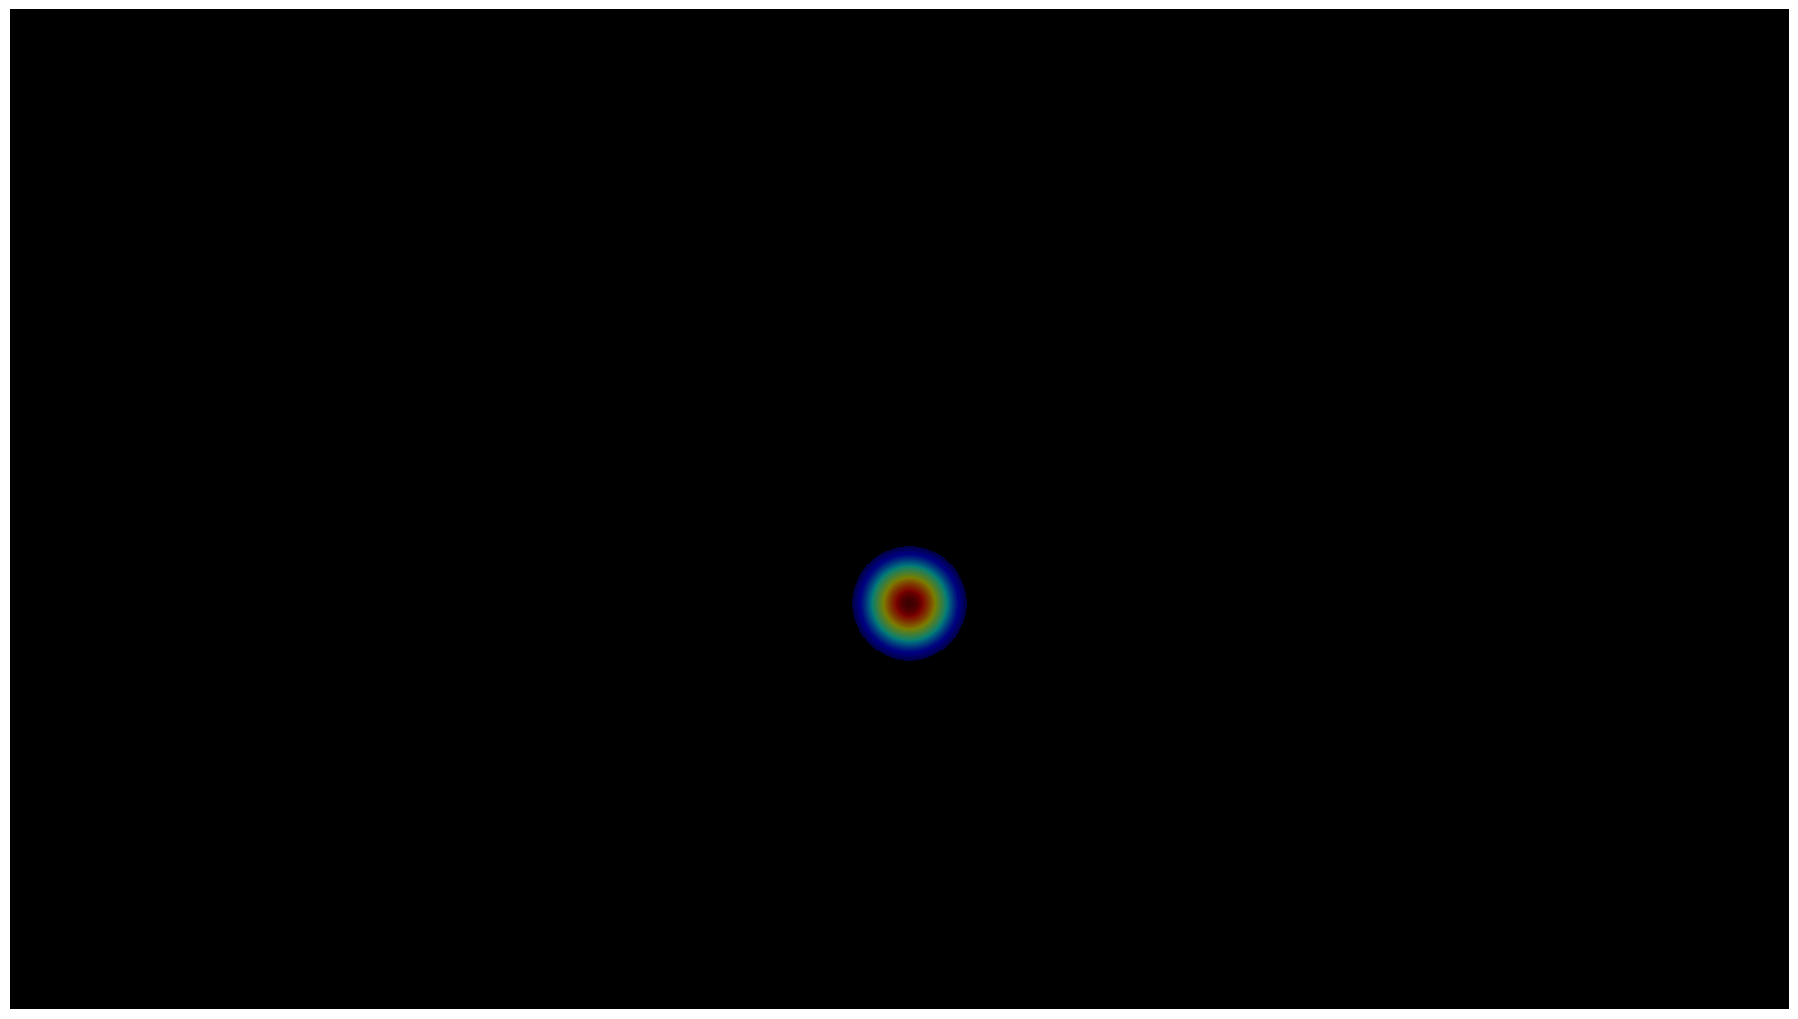

In [32]:
### Plot perceived noise_sample vs inattention

# parameters
partic_id = 'G036'
game_nr   = 16
trials    = np.arange(1,16,1)
dispsize  = (1919,1079) # (px,px) size of screen 

#initialize
x_cross_list,y_cross_list, center_x_list,center_y_list = [],[],[],[]
trial_success = []
radius_list   = []
#read stimulus data
data = read_data(partic_id,game_nr,phase='stimulus')


for trial_nr in (trials):
    #get crosshair position
    x_cross,y_cross = return_cross_pos(partic_id,game_nr,trial_nr)
    if x_cross!=0:
        ###get centroid
        
        #fixations
        fixations = np.array(data[trial_nr]['events']['Efix'])
        fig_heatmap = draw_heatmap(fixations, dispsize)
        #save heatmap
        fig_heatmap.savefig('img_1.png')

        #feed heatmap to the function
        image_load = cv2.imread('img_1.png',0)
        center,radius,image_out = return_centroid_heatmap(image_load)
        #print(center)
        if center.size!=0:
            #print(center)
            if center.shape[0]>1:
                #print(center.shape)
                center = center[0] #CHANGE LATER!!!
                radius = radius[0]
            #plot center - cross hair distance
            #dist = np.sqrt((x_cross-center[0][0])**2 + (y_cross-center[0][1])**2)
            #plt.scatter(trial_nr,dist)
            x_cross_list.append(x_cross)
            y_cross_list.append(y_cross)
            center_x_list.append(center[0][0])
            center_y_list.append(center[0][1])
            trial_success.append(trial_nr)
            radius_list.append(radius)
            print(radius_list)


In [ ]:
#calculate distances from center point
#dist = np.sqrt((np.array(center_x_list) - np.array(x_cross_list))**2 +
#               (np.array(center_y_list) - np.array(y_cross_list))**2)


#get standard deviation
#load data set
fname = 'dataset_0423.csv'
data_set = load_dataset_properties(fname)
std_dev_list =[]
property_label= 'perc_noise_sample'
subject_id = 36
for trial_nr in trials:
    #check if successful trial
    if trial_nr in trial_success:
        std_dev = return_property_value(data_set,subject_id, game_nr+1,trial_nr,property_label)
        std_dev_list.append(std_dev)
        
std_dev_list = np.array(std_dev_list).astype(float)#/max(std_dev_list)

##plot the non-empty trials
fig,ax = plt.subplots()
for i,trial_nr in enumerate(trial_success):
    ax.plot(trial_nr,radius[i],'-o',markersize=std_dev_list[i])
    #print(dist[i],trial_nr)
    title = 'Game No {}'.format(game_nr)
    ax.set_title(title)
    ax.set_xlabel('Trial No')
    ax.set_ylabel('Inattention')
    
fig.savefig(title+'.png')

### Sija's Code 1: Heatmaps of each of the stimulus phase

participant ID? (only number, e.g. 036): 036
['G036_1', 'G036_2', 'G036_3', 'G036_4', 'G036_5', 'G036_6', 'G036_7', 'G036_8', 'G036_9', 'G036_10', 'G036_11', 'G036_12', 'G036_13', 'G036_14', 'G036_15', 'G036_16']
starting data analysis for participant 'G036'
loading  csv data
fp:  PyGazeAnalyser-master\pygazeanalyser\data\dataset_0423.csv
numpyarray:  [[nan nan nan ... nan nan nan]
 [ 1.  2.  1. ...  0.  0.  0.]
 [ 1.  2.  1. ...  0.  0.  0.]
 ...
 [35. 36. 16. ...  1.  1. 90.]
 [35. 36. 16. ...  0.  0. 90.]
 [35. 36. 16. ...  1.  1. 90.]]
df:  [[nan nan nan ... nan nan nan]
 [ 1.  2.  1. ...  0.  0.  0.]
 [ 1.  2.  1. ...  0.  0.  0.]
 ...
 [35. 36. 16. ...  1.  1. 90.]
 [35. 36. 16. ...  0.  0. 90.]
 [35. 36. 16. ...  1.  1. 90.]]
loading gaze data for:  G036_1
plotting gaze data for:  G036_1
Trialnr:  0
Fixation:  [[2091888, 2093345, 1458, 963.4, 526.2], [2091889, 2093345, 1457, 979.0, 513.6]]
Fixation2:  [[2091602, 2091862, 261, 972.4, 413.2], [2091602, 2091862, 261, 1000.9, 394.3]

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


Trialnr:  1
Fixation:  [[2100175, 2101543, 1369, 966.9, 462.2], [2100175, 2101543, 1369, 985.0, 448.5]]
Fixation2:  []
Saccades:  []
Fixation:  [[2100175, 2101543, 1369, 966.9, 462.2], [2100175, 2101543, 1369, 985.0, 448.5]]
coords:  [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
distance:  [0. 0. 0. ... 0. 0. 0.]
Trialnr:  2
Fixation:  []
Fixation2:  [[2109166, 2109546, 381, 993.9, 424.5], [2109166, 2109548, 383, 980.2, 431.4], [2109565, 2109851, 287, 985.2, 454.7], [2109564, 2109852, 289, 969.5, 464.2]]
Saccades:  []
Fixation:  []
coords:  [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
distance:  [0. 0. 0. ... 0. 0. 0.]


c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Trialnr:  3
Fixation:  [[2117574, 2119030, 1457, 944.9, 547.9], [2117574, 2119030, 1457, 950.1, 532.4]]
Fixation2:  [[2117390, 2117555, 166, 906.2, 540.1], [2117390, 2117557, 168, 902.3, 552.8]]
Saccades:  []
Fixation:  [[2117574, 2119030, 1457, 944.9, 547.9], [2117574, 2119030, 1457, 950.1, 532.4]]
coords:  [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
distance:  [0. 0. 0. ... 0. 0. 0.]
Trialnr:  4
Fixation:  [[2126553, 2127974, 1422, 955.1, 505.6]]
Fixation2:  [[2126217, 2126533, 317, 961.8, 476.7], [2126217, 2126535, 319, 937.0, 506.5]]
Saccades:  []
Fixation:  [[2126553, 2127974, 1422, 955.1, 505.6]]
coords:  [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
distance:  [0. 0. 0. ... 0. 0. 0.]
Trialnr:  5
Fixation:  []
Fixation2:  [[2133849, 2133939, 91, 1019.5, 397.1], [2133849, 2133941, 93, 1038.2, 381.2], [2133968, 2134664, 697, 939.7, 458.2], [2133970, 2134664, 695, 957.1, 449.1], [21

PyGazeAnalyser-master\pygazeanalyser\gazeplotter_sija.py:416: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = pyplot.figure(figsize=figsize, dpi=dpi, frameon=False)


KeyboardInterrupt: 

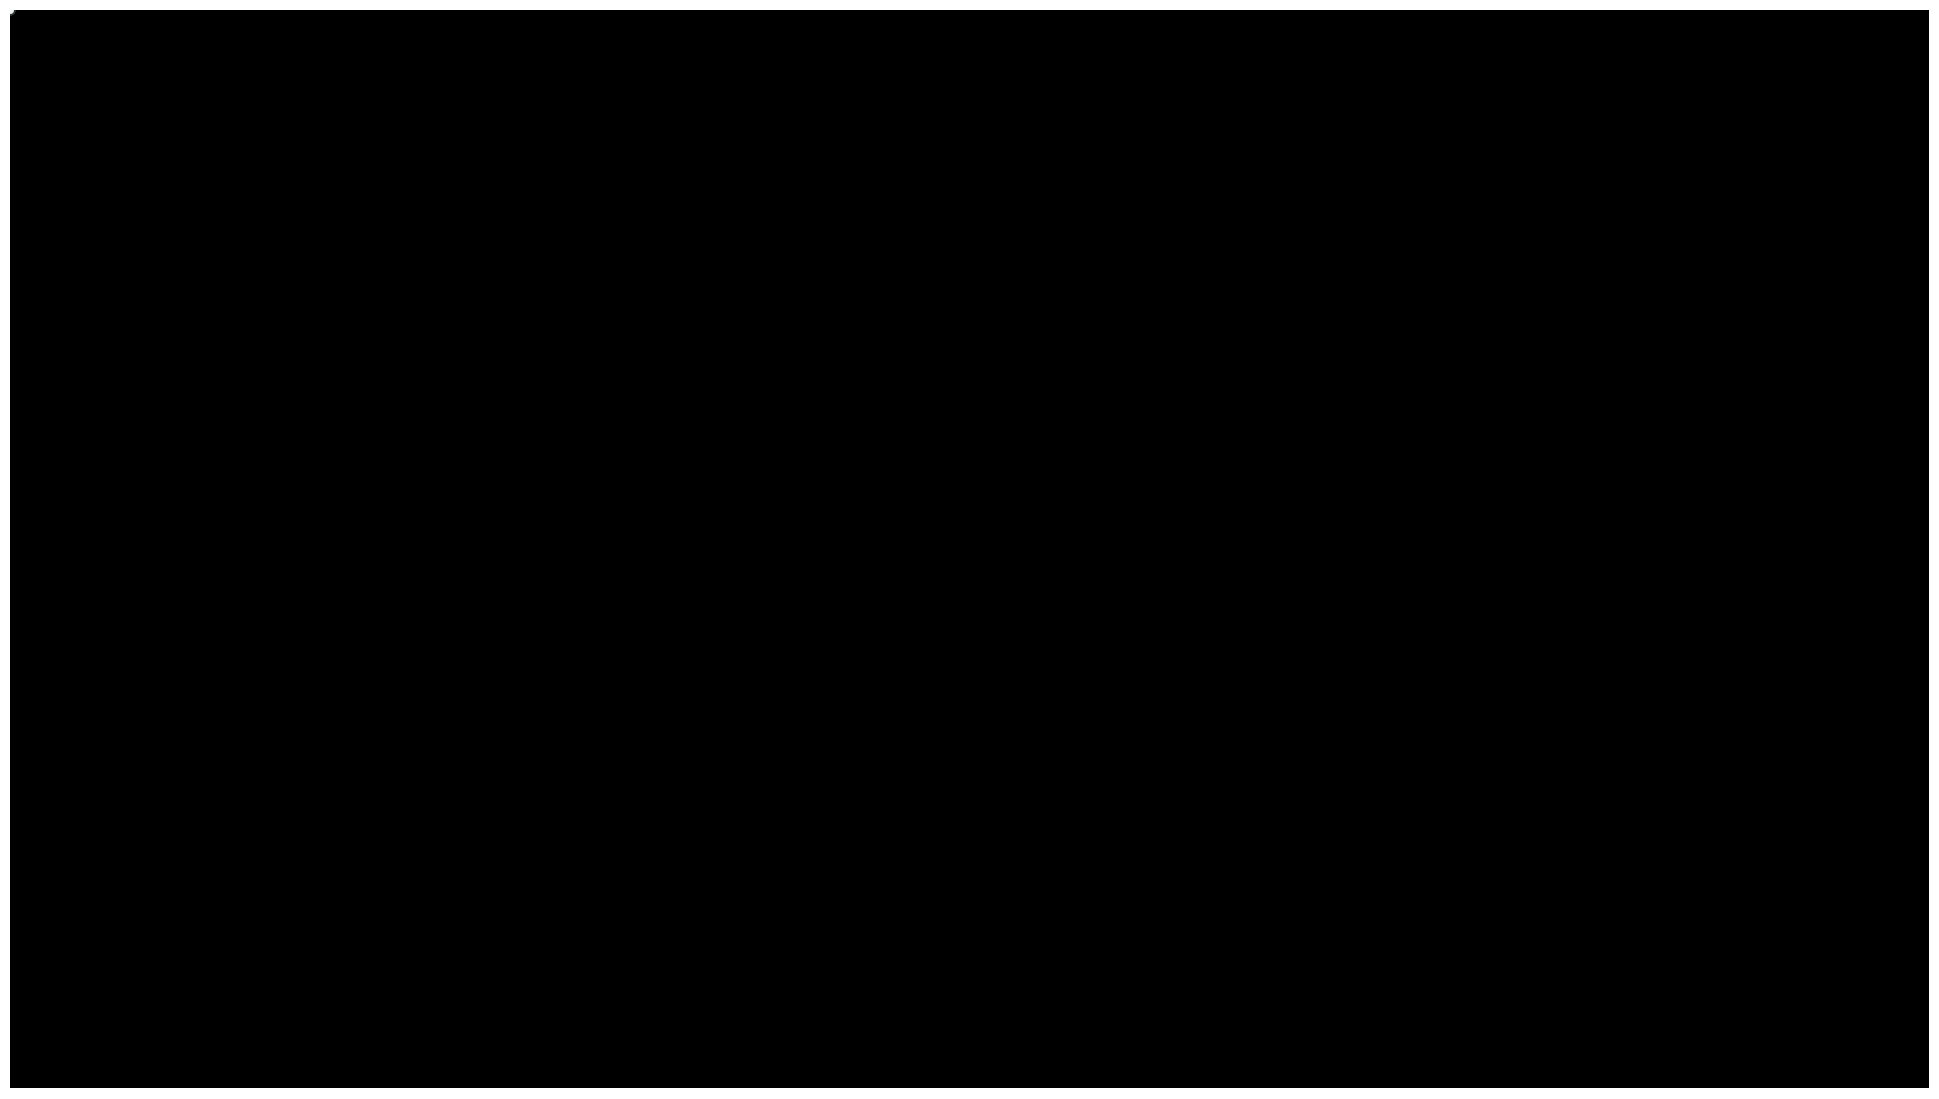

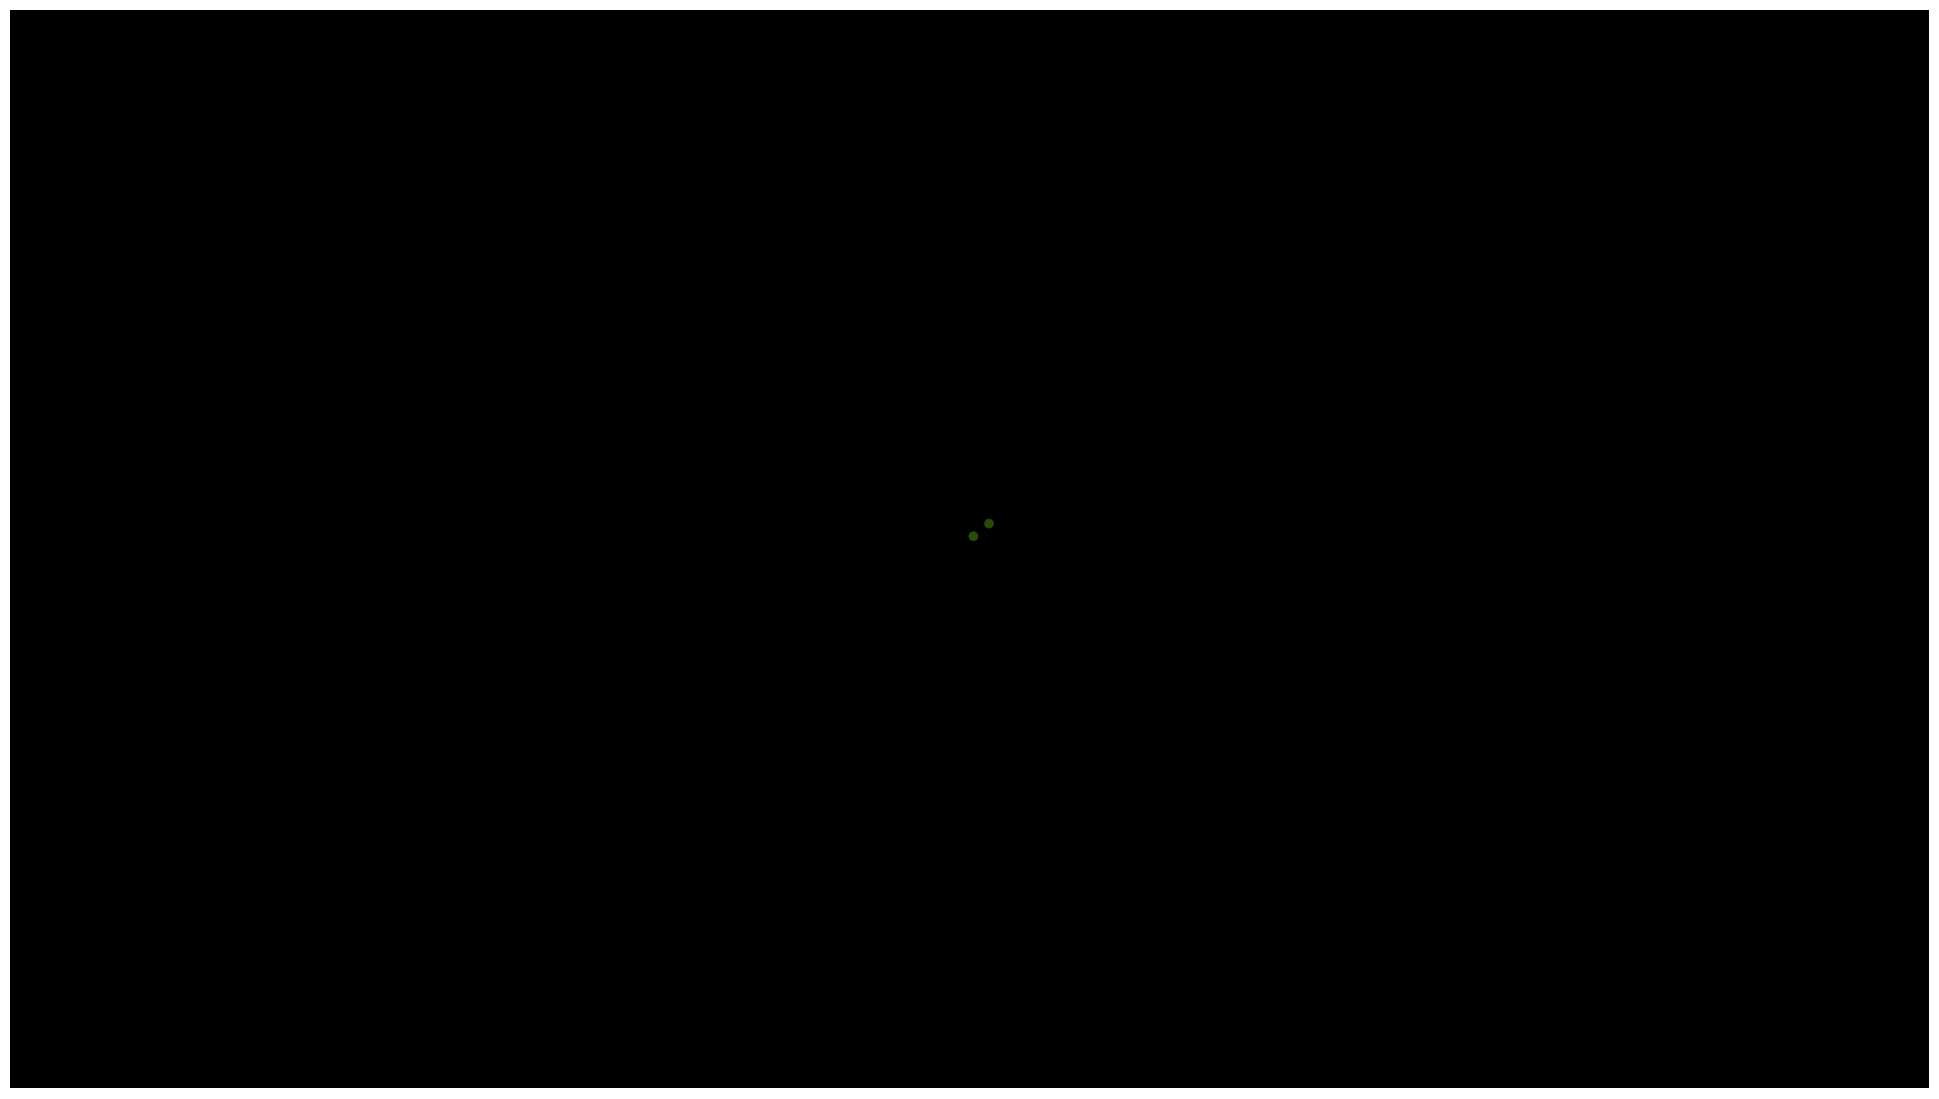

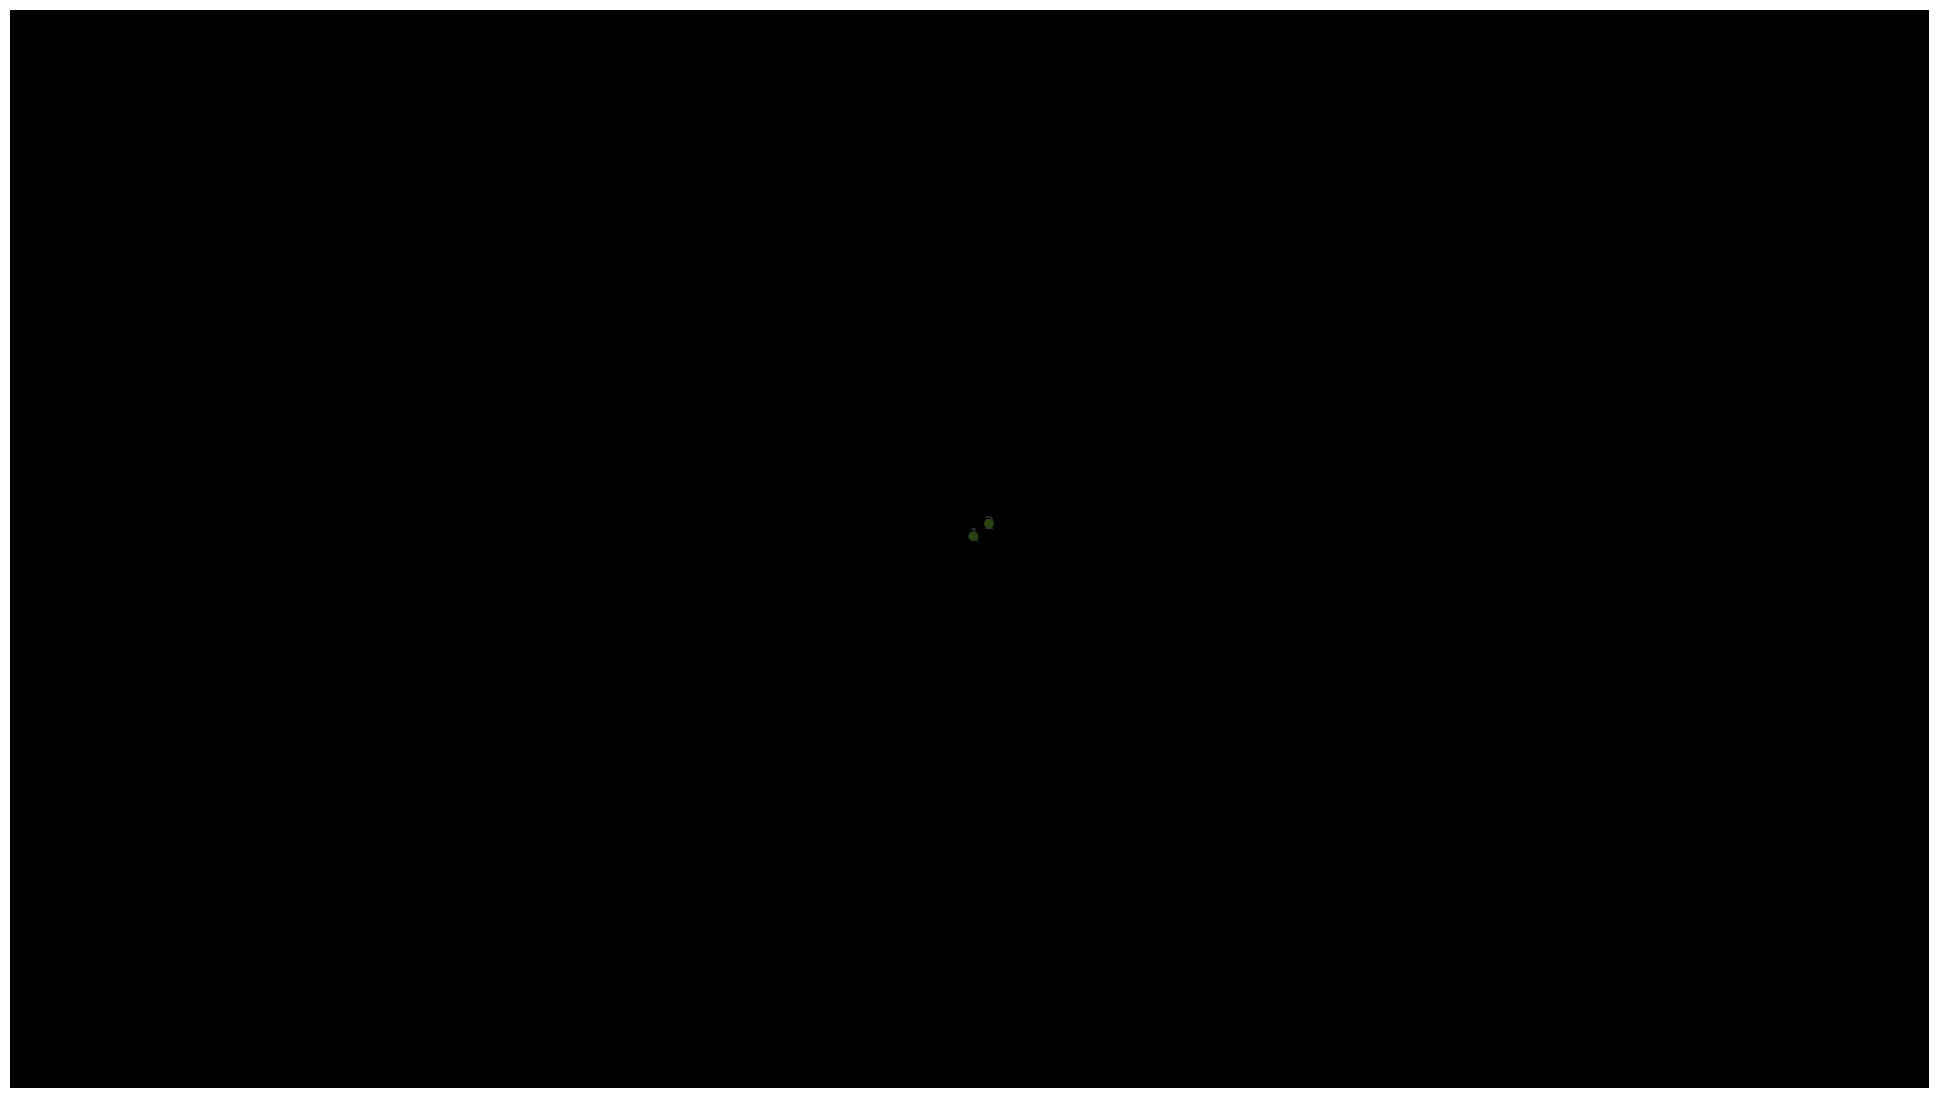

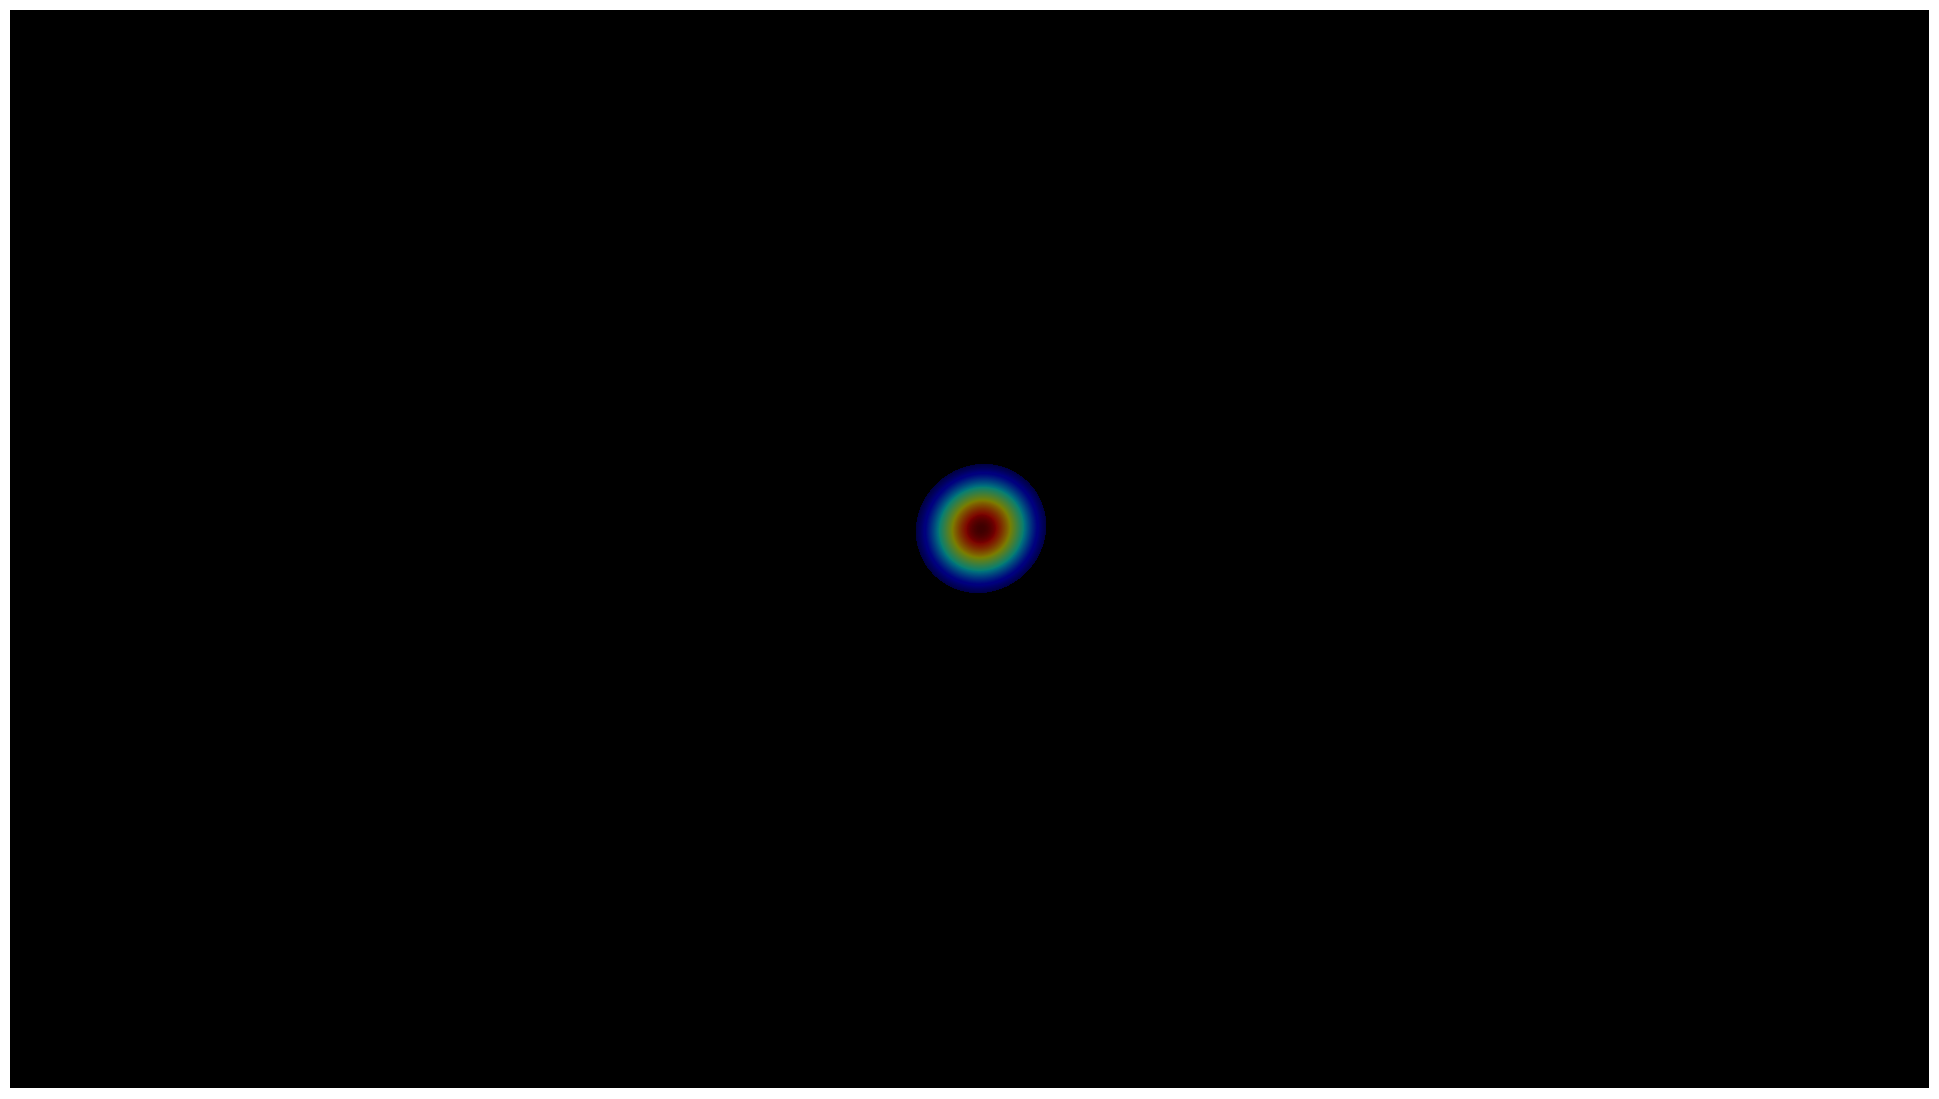

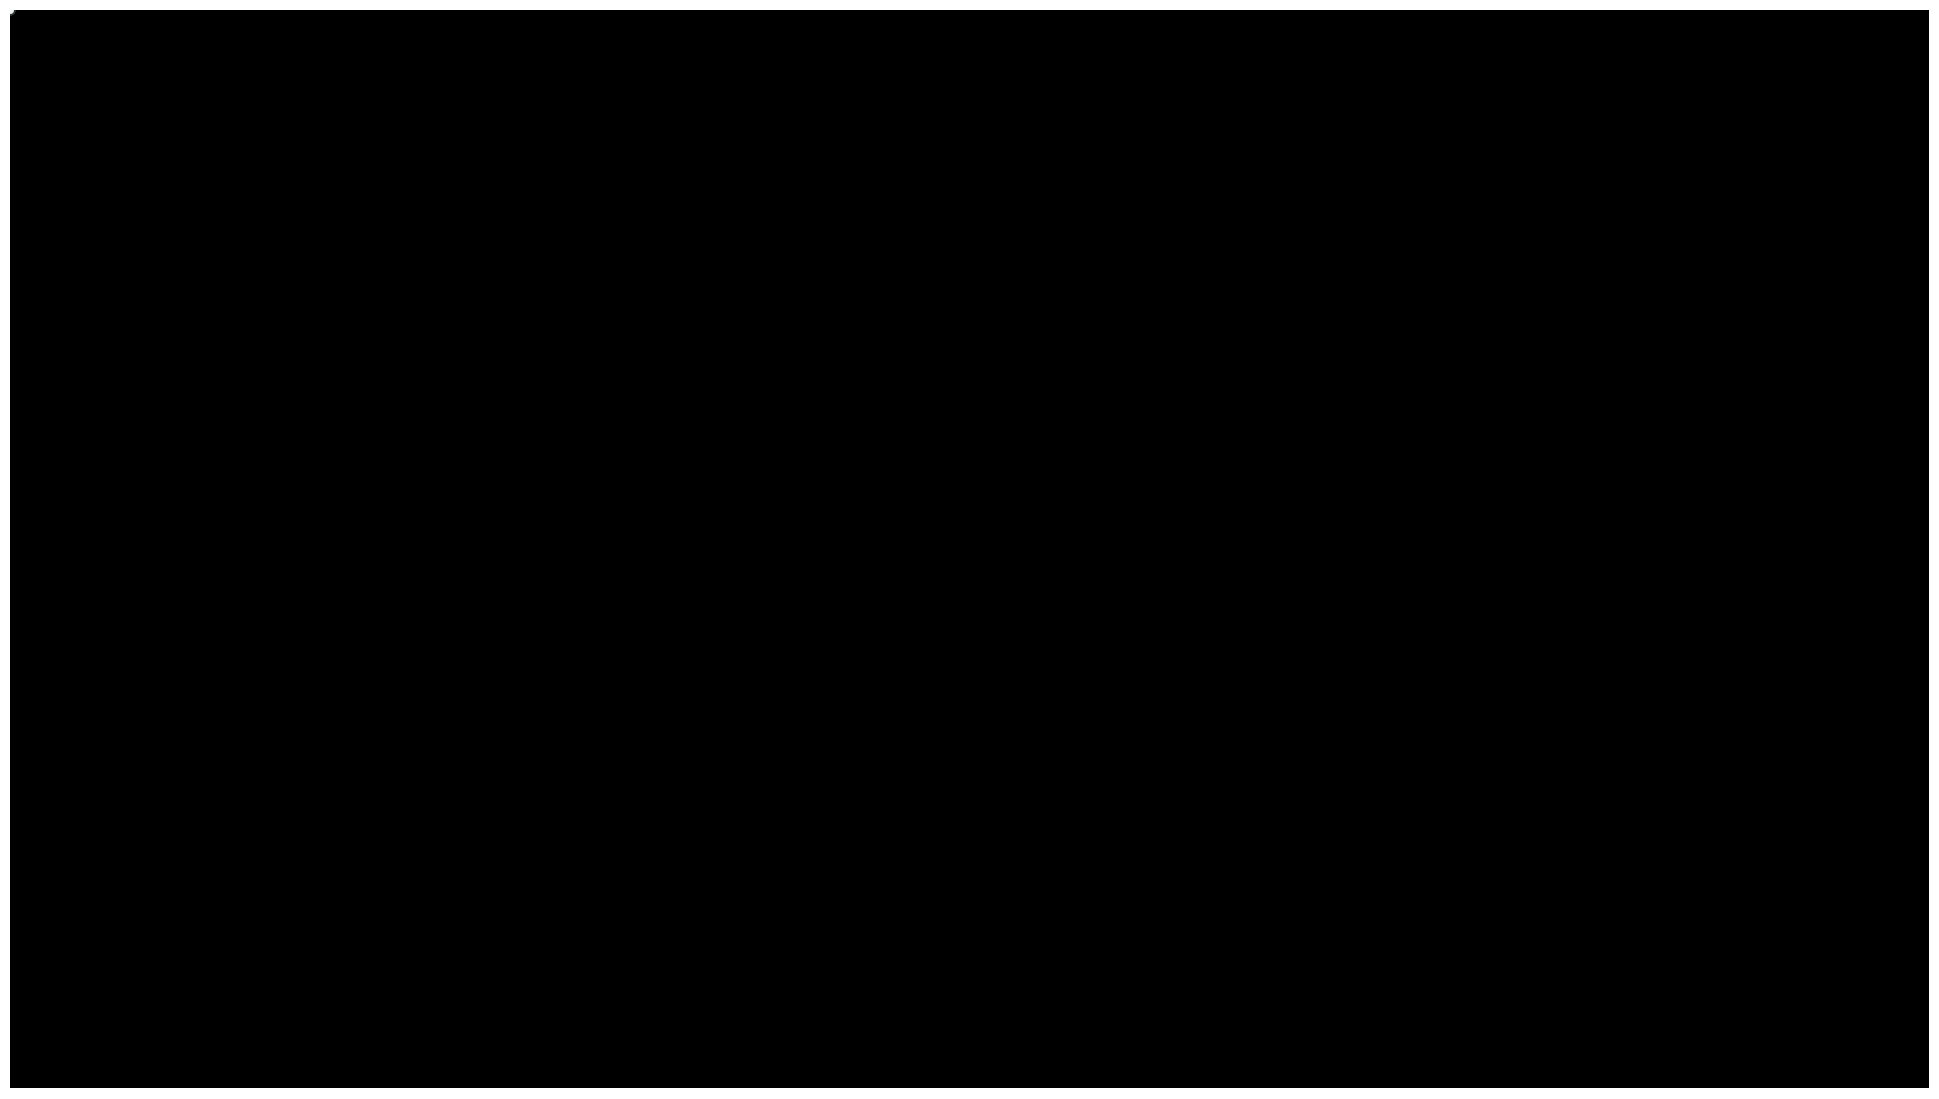

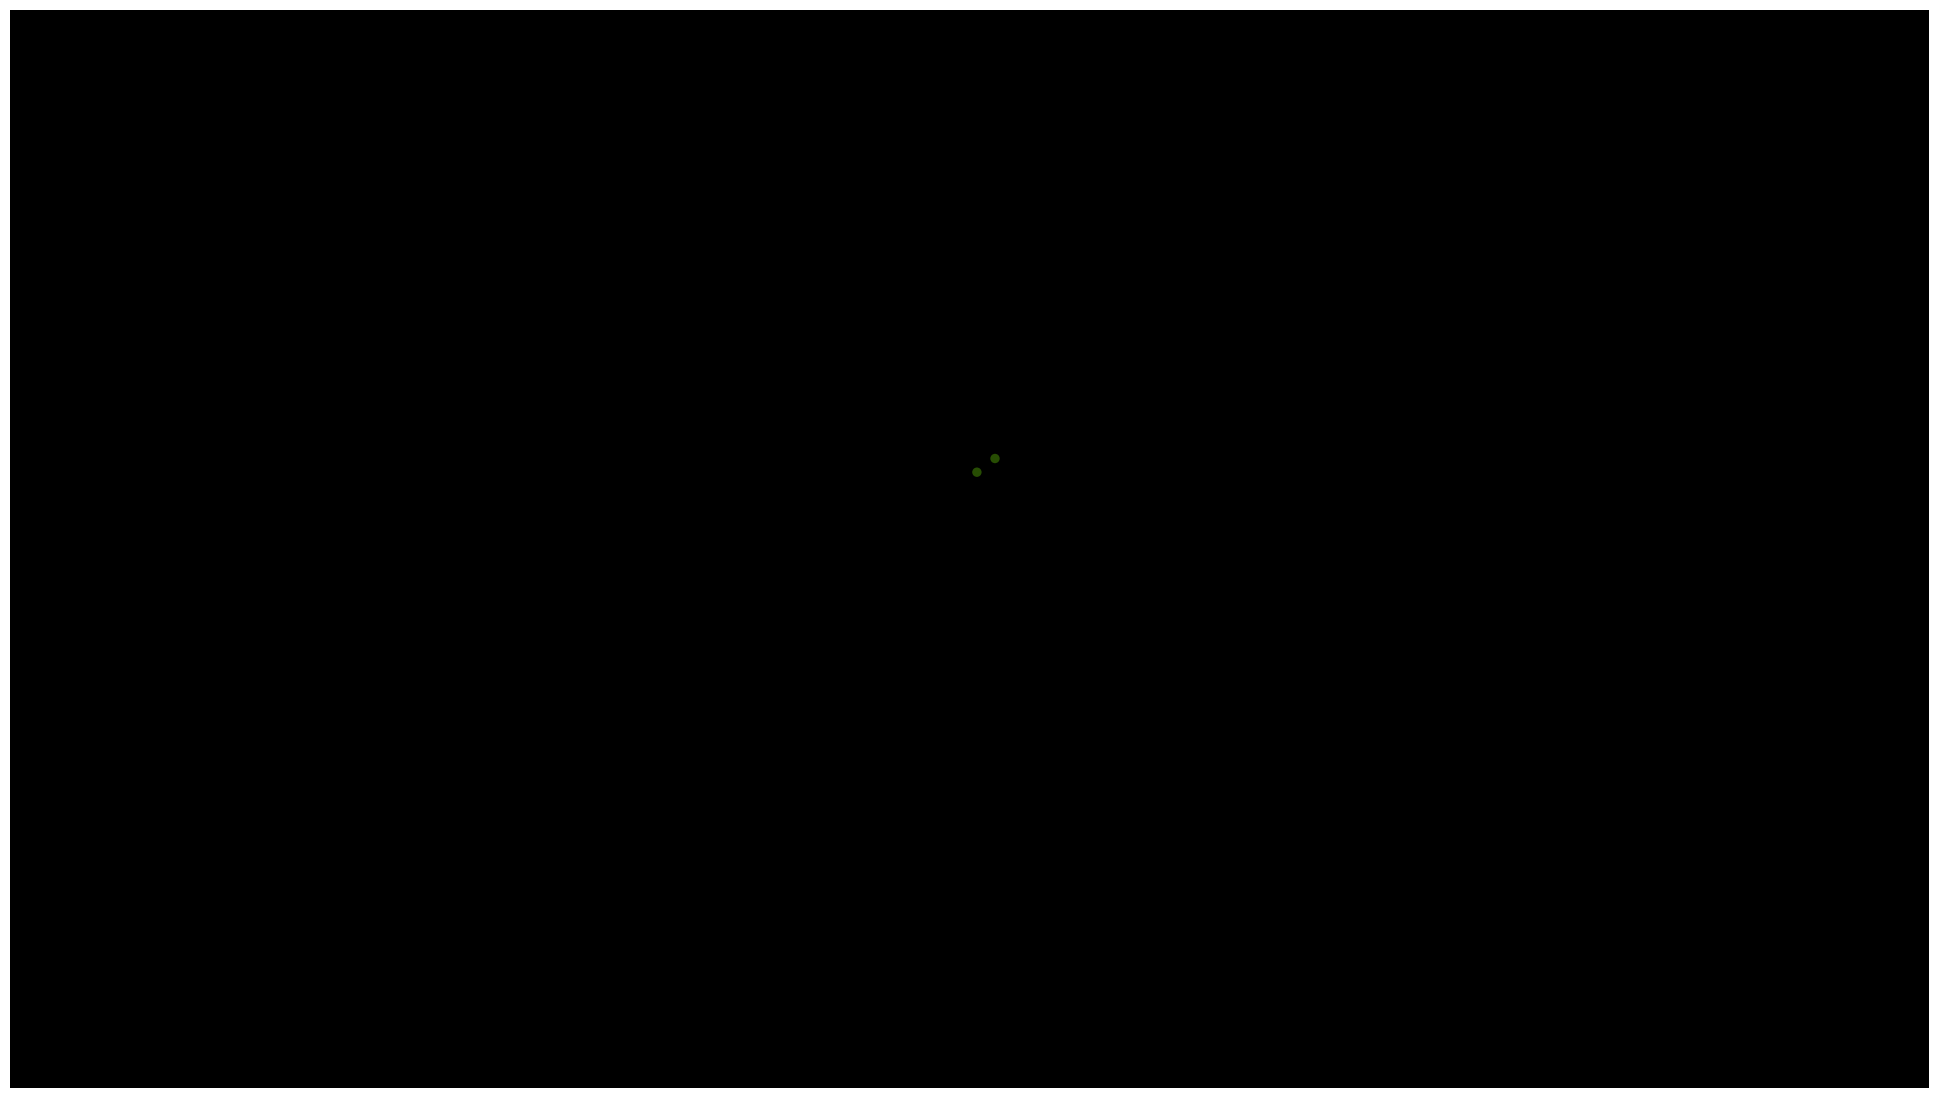

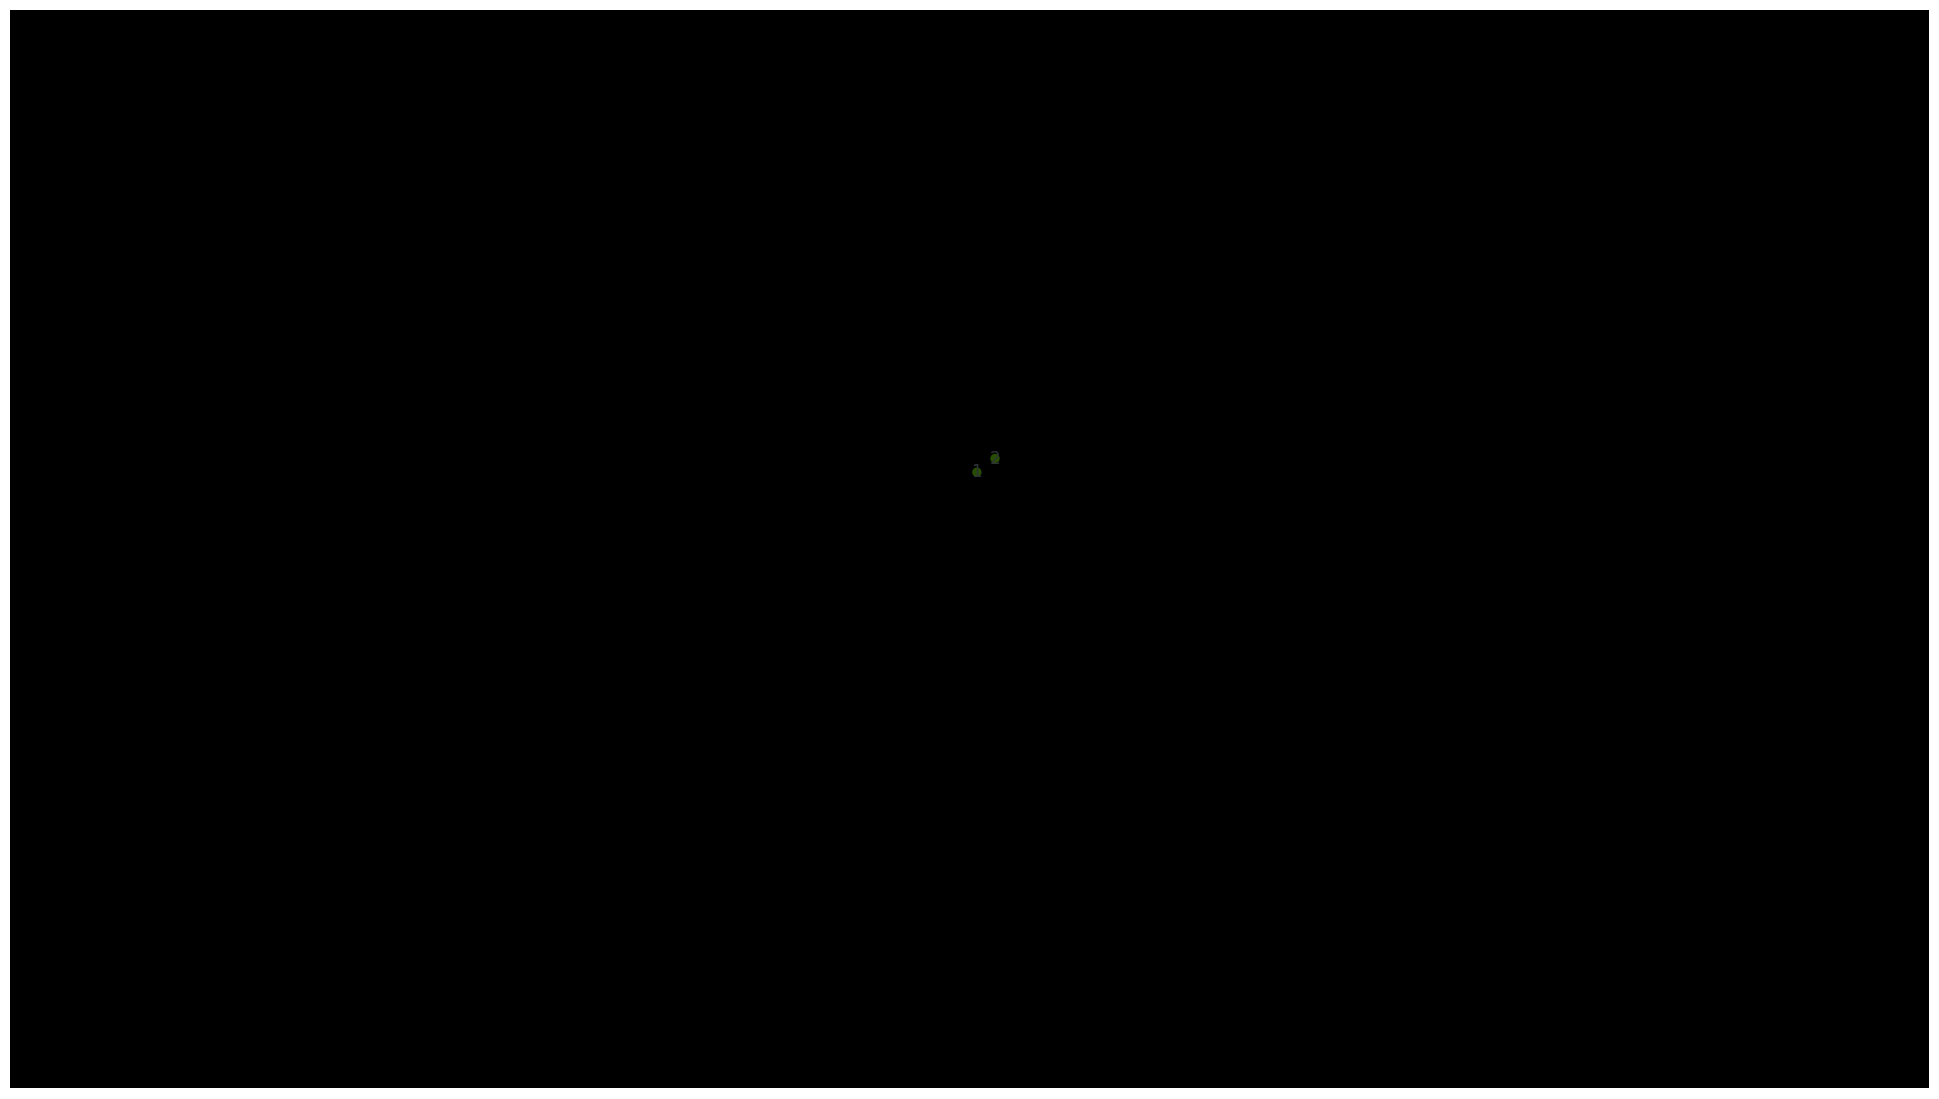

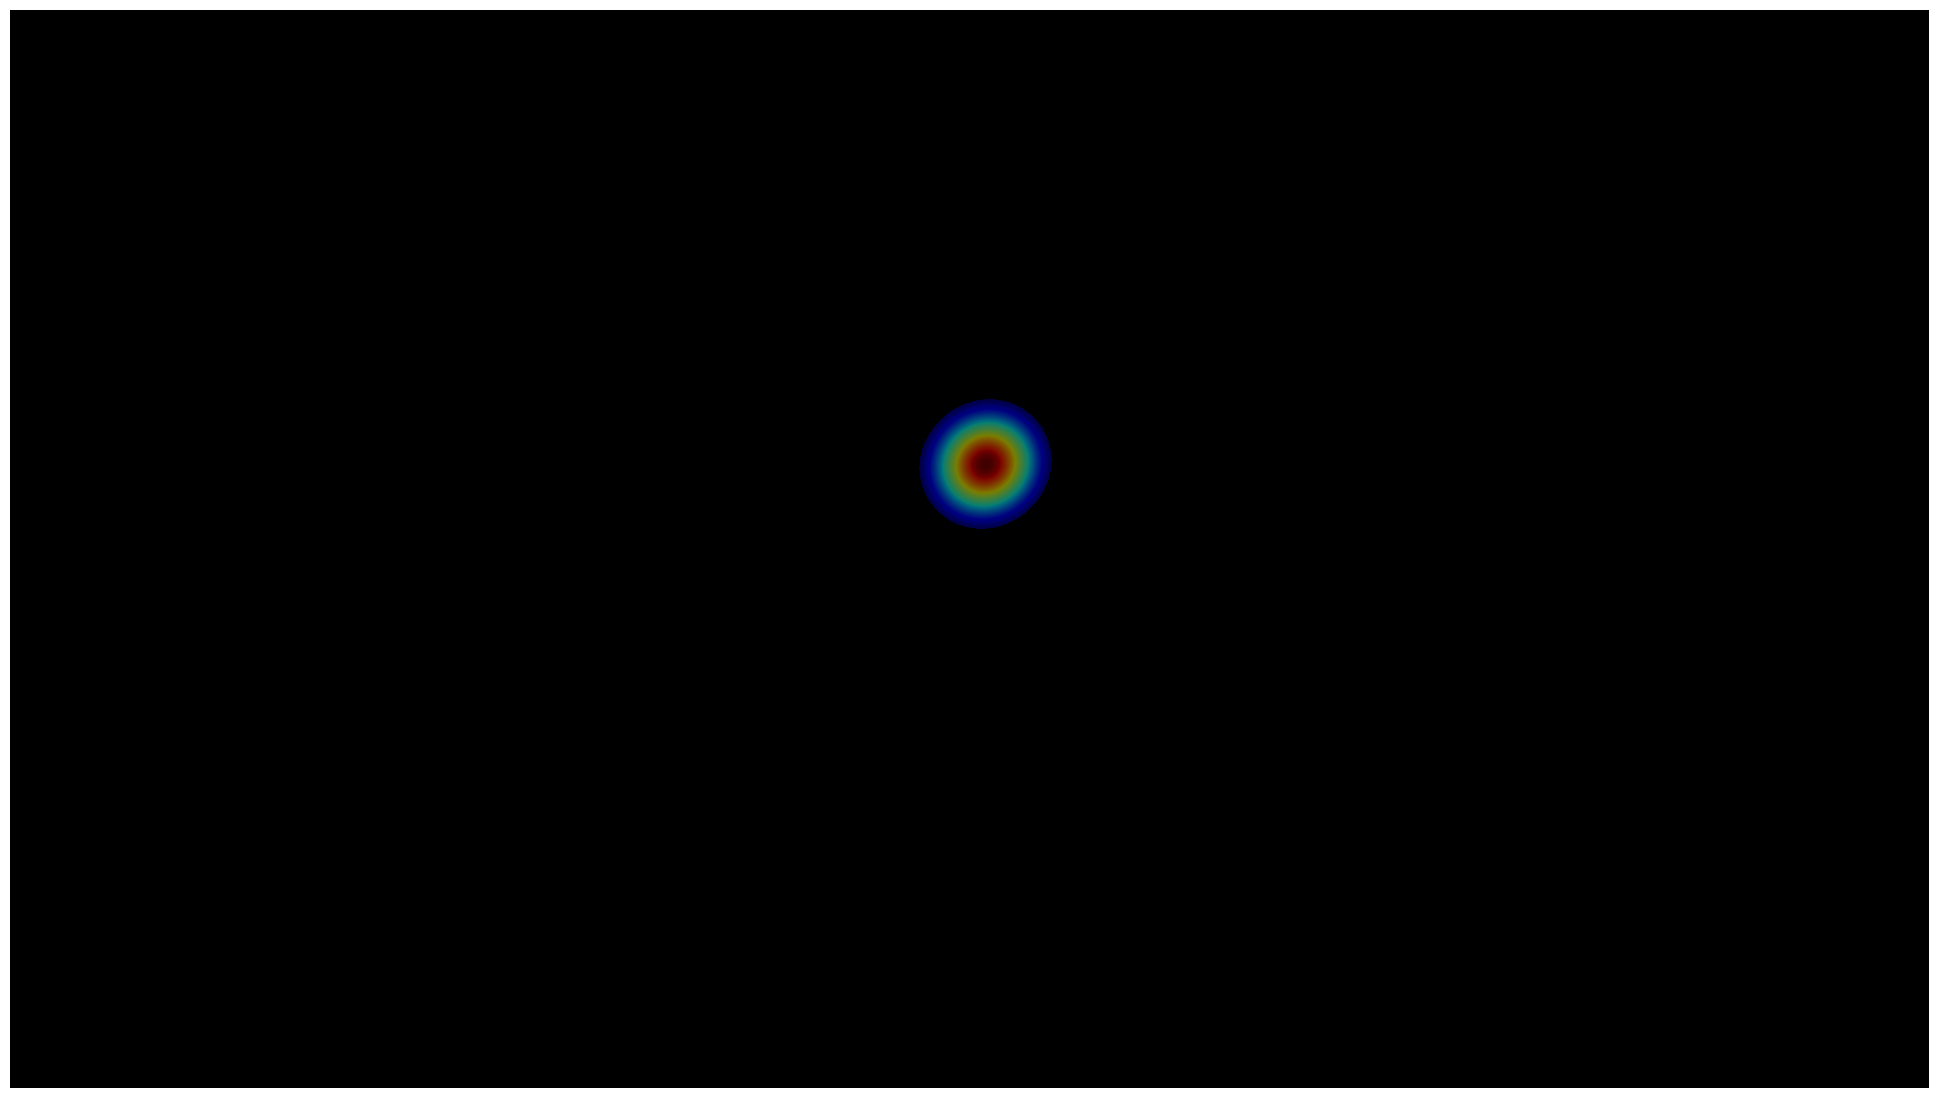

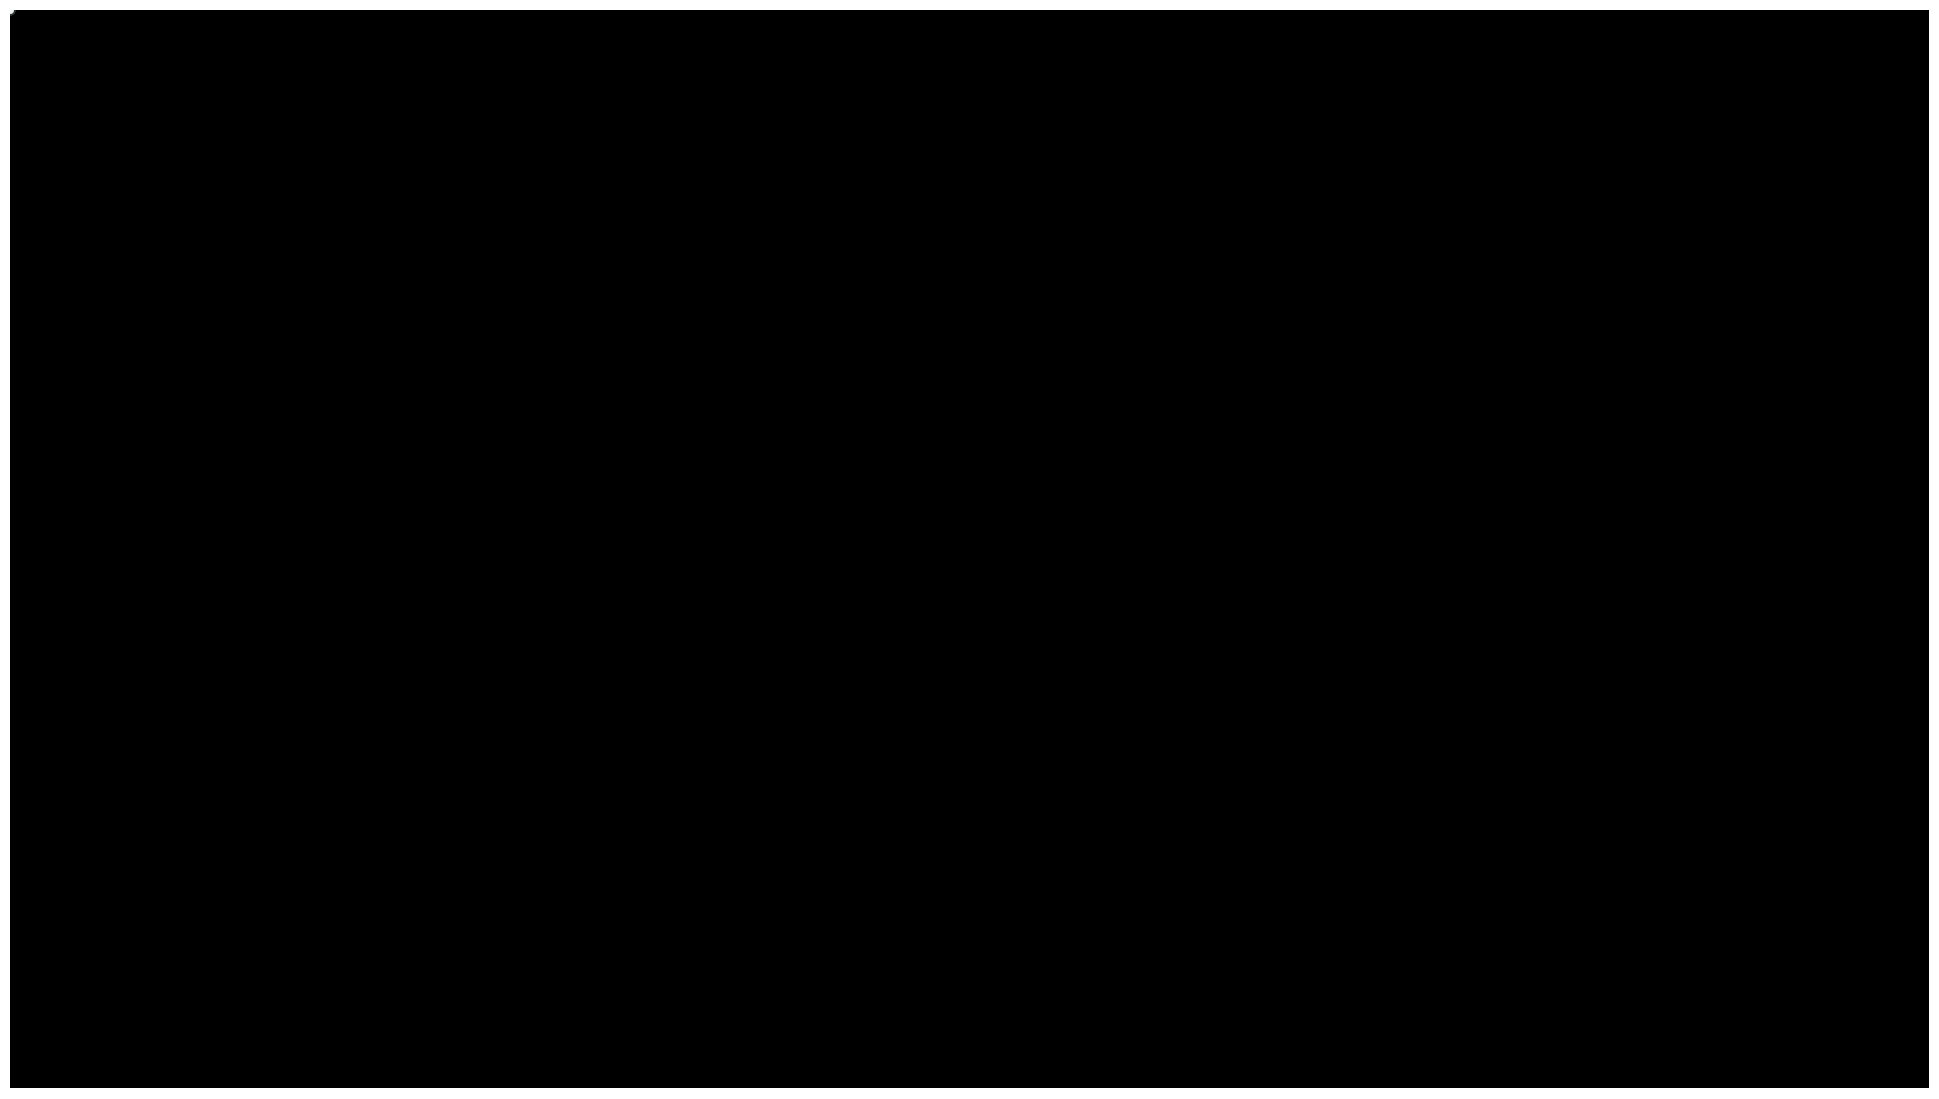

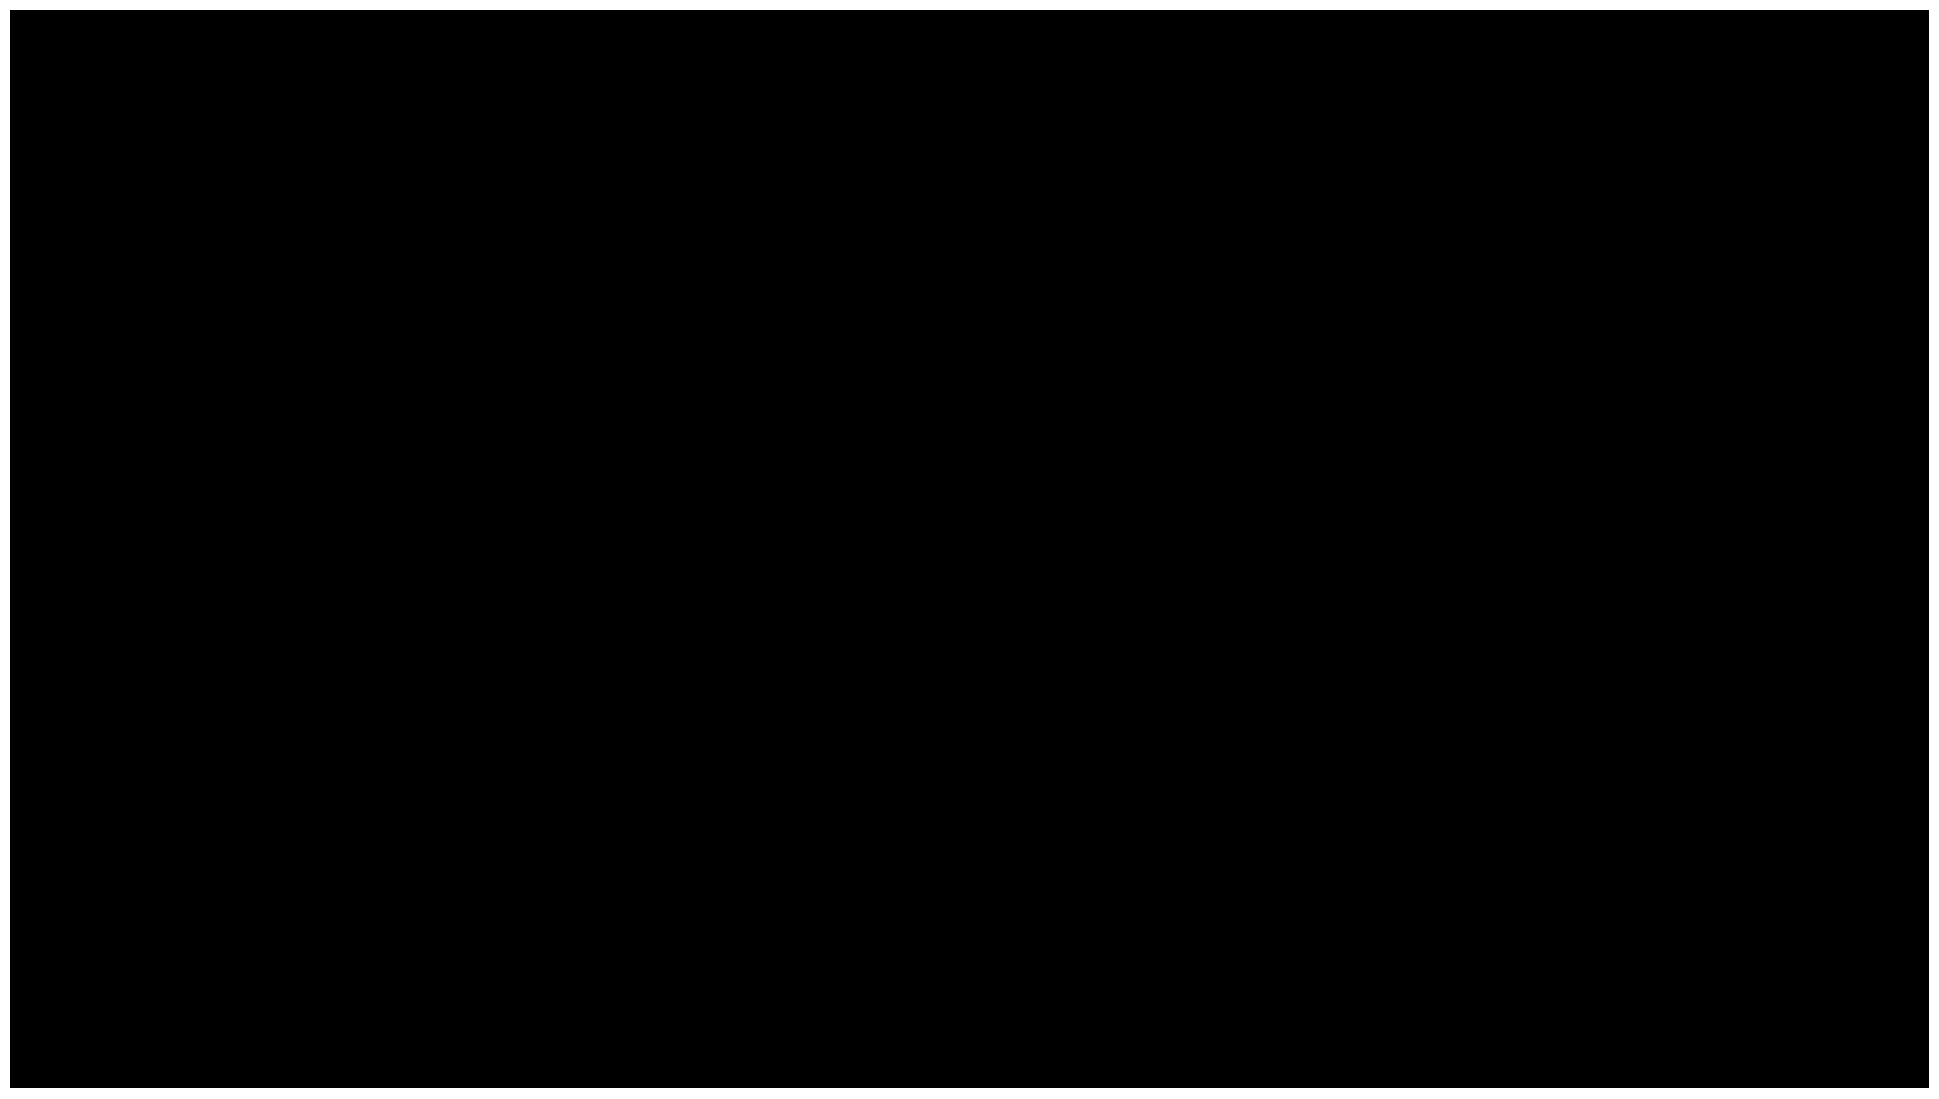

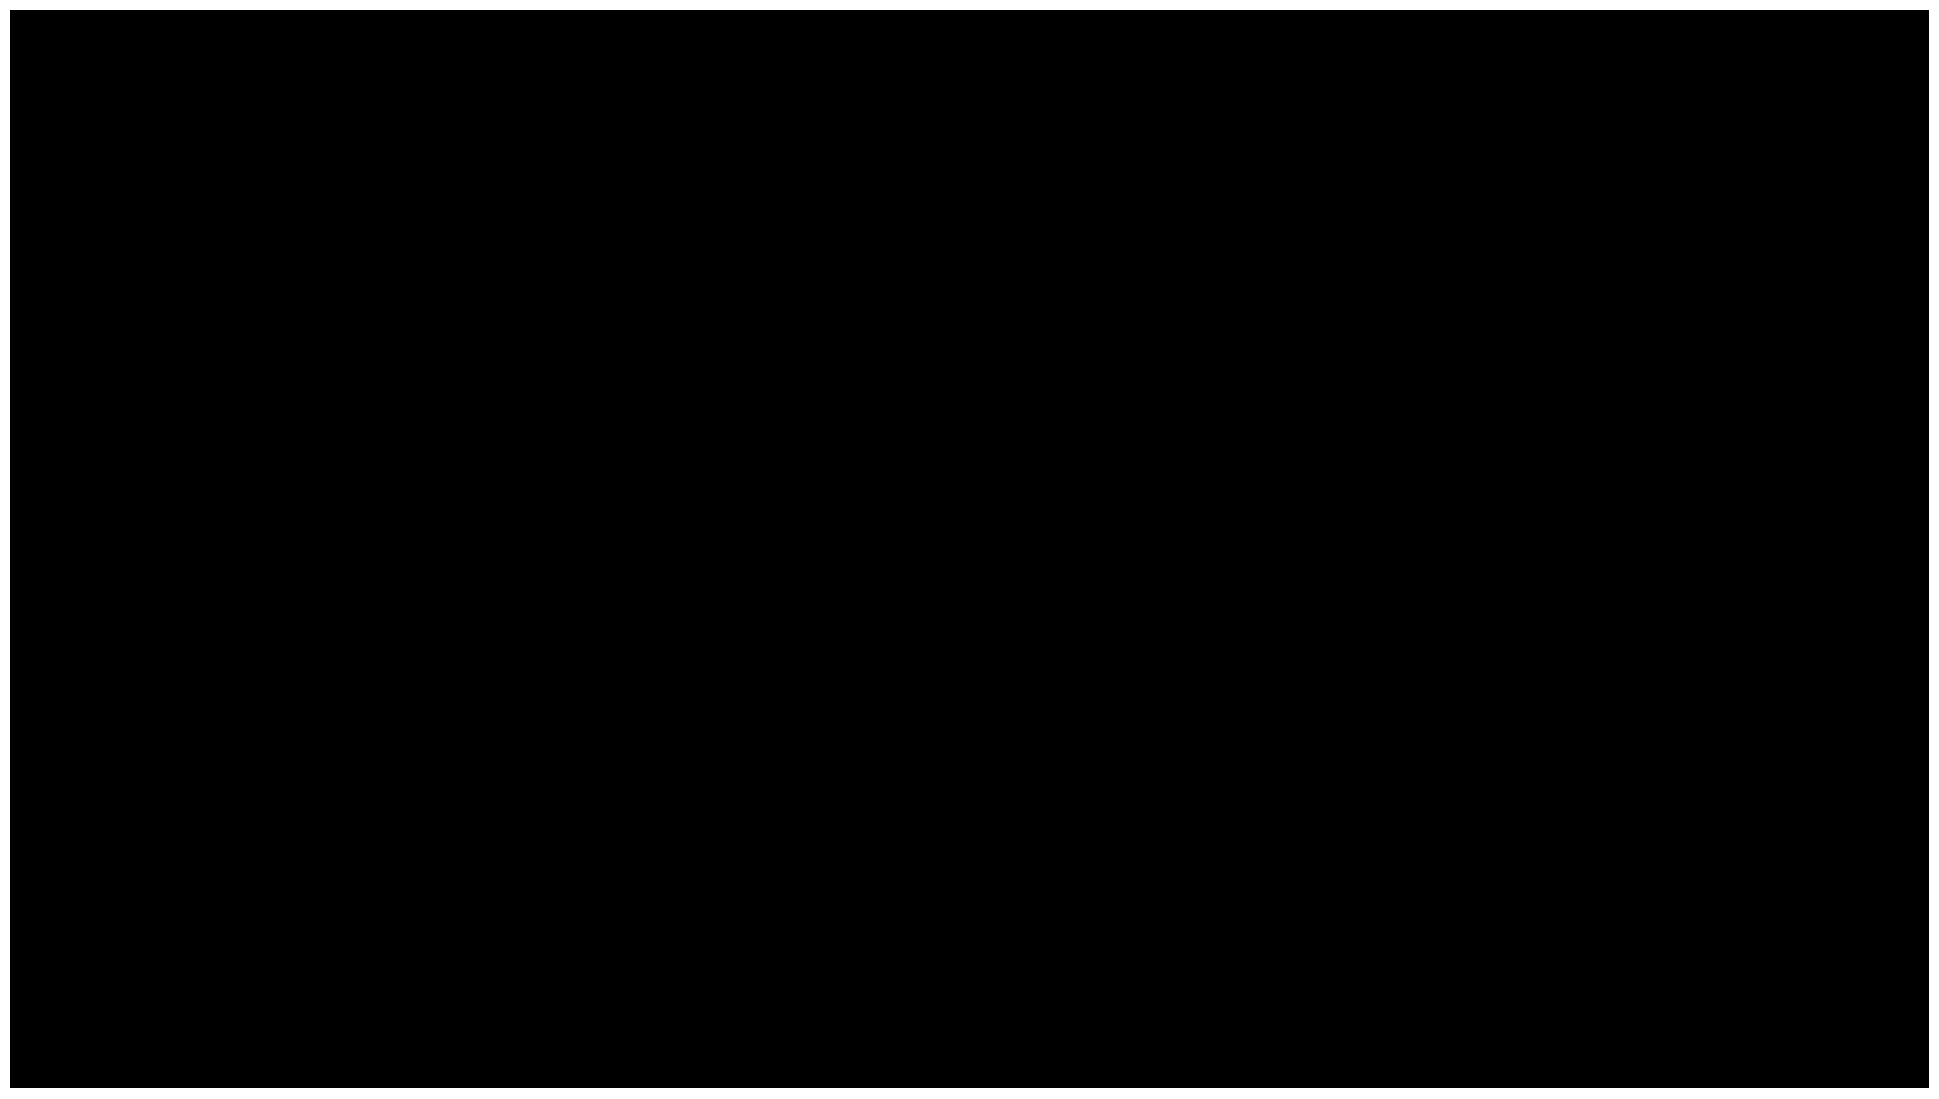

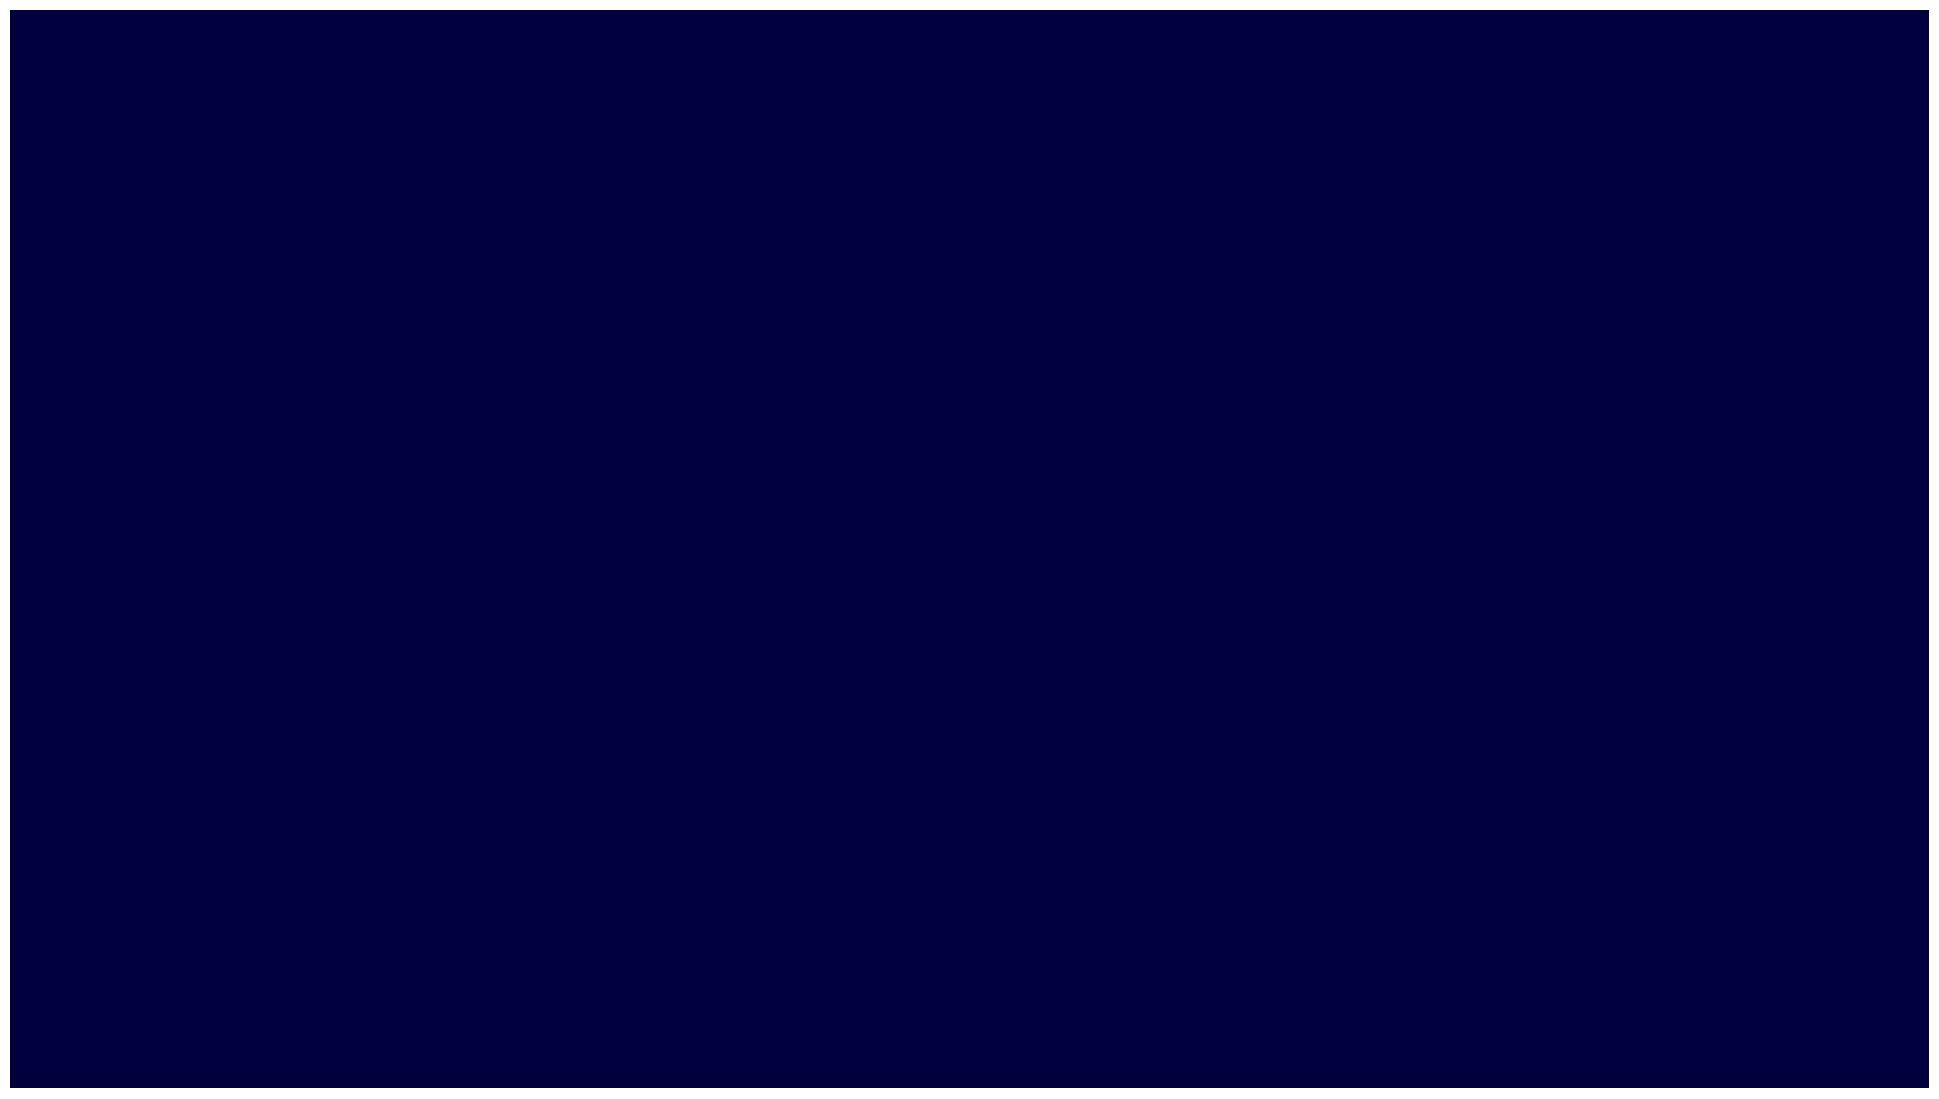

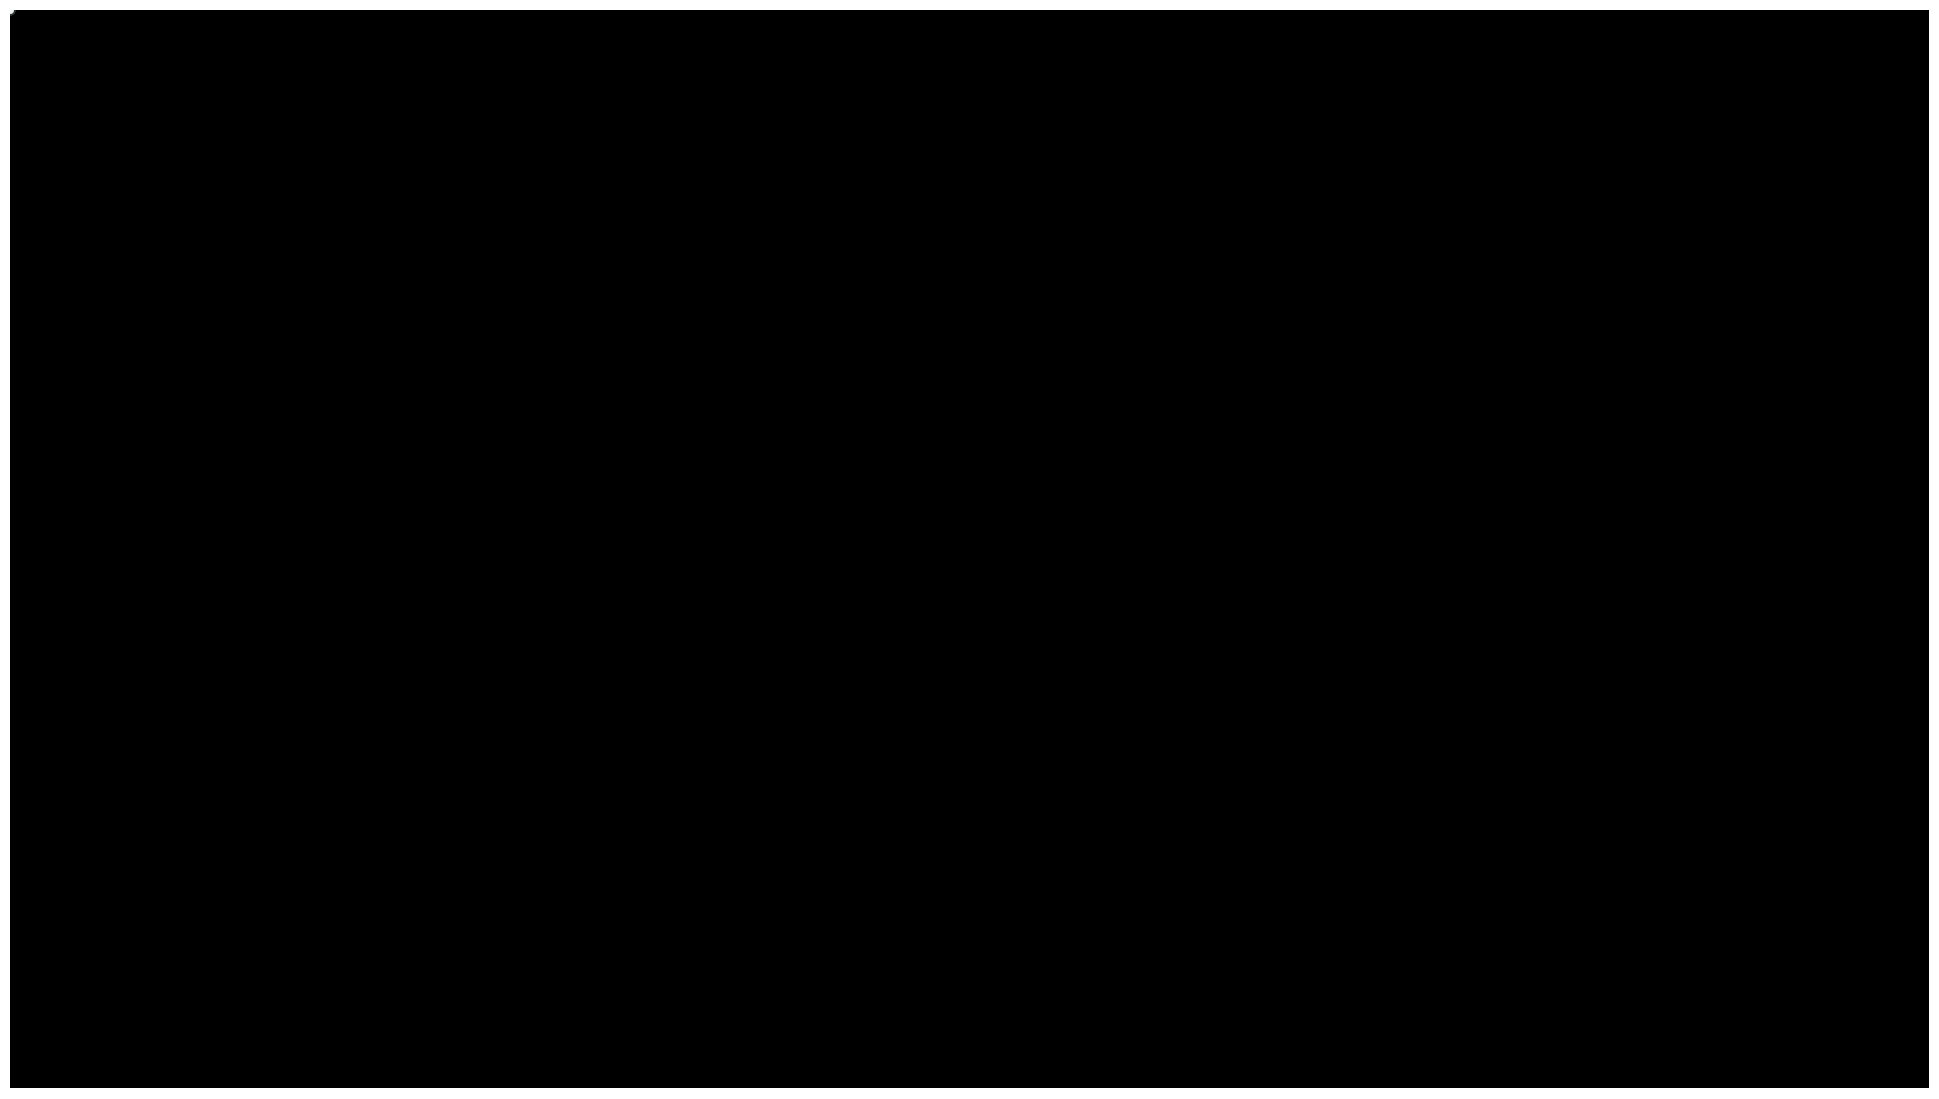

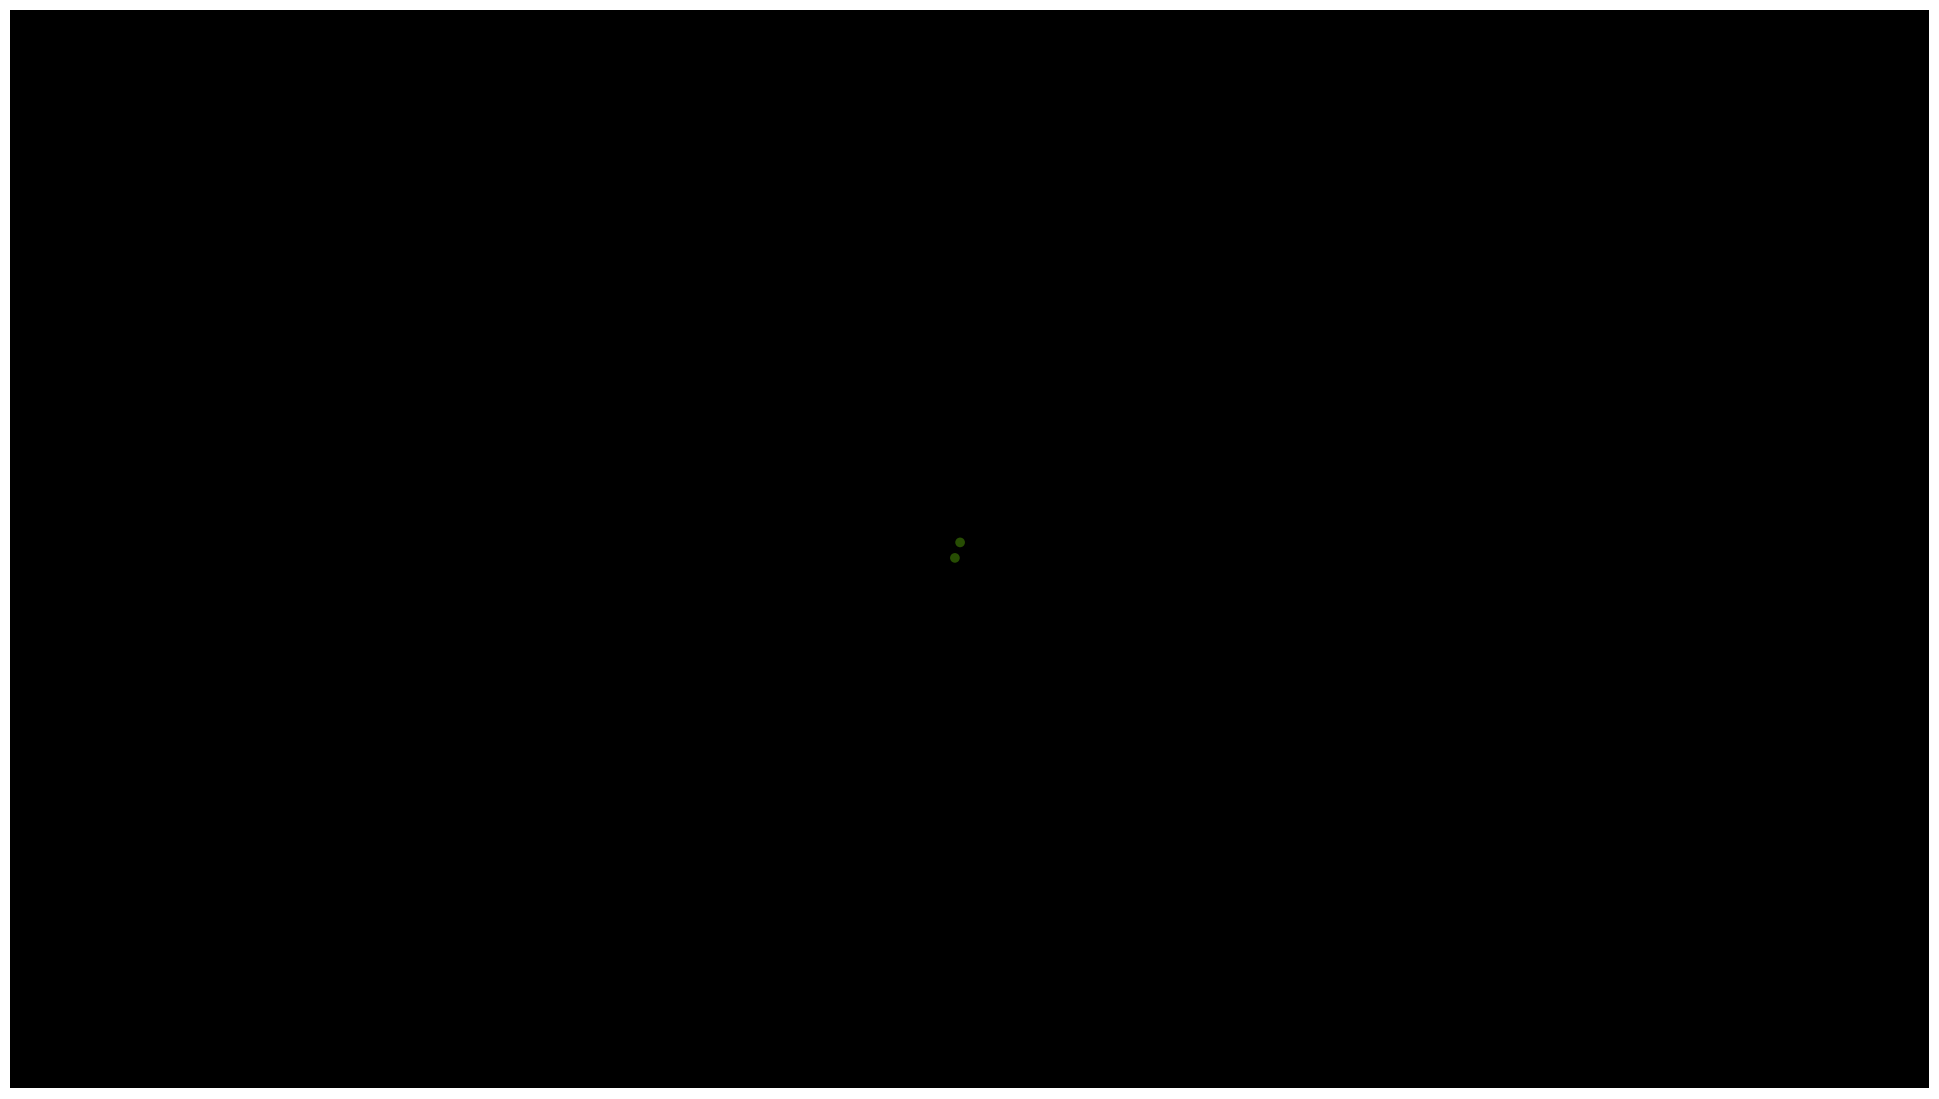

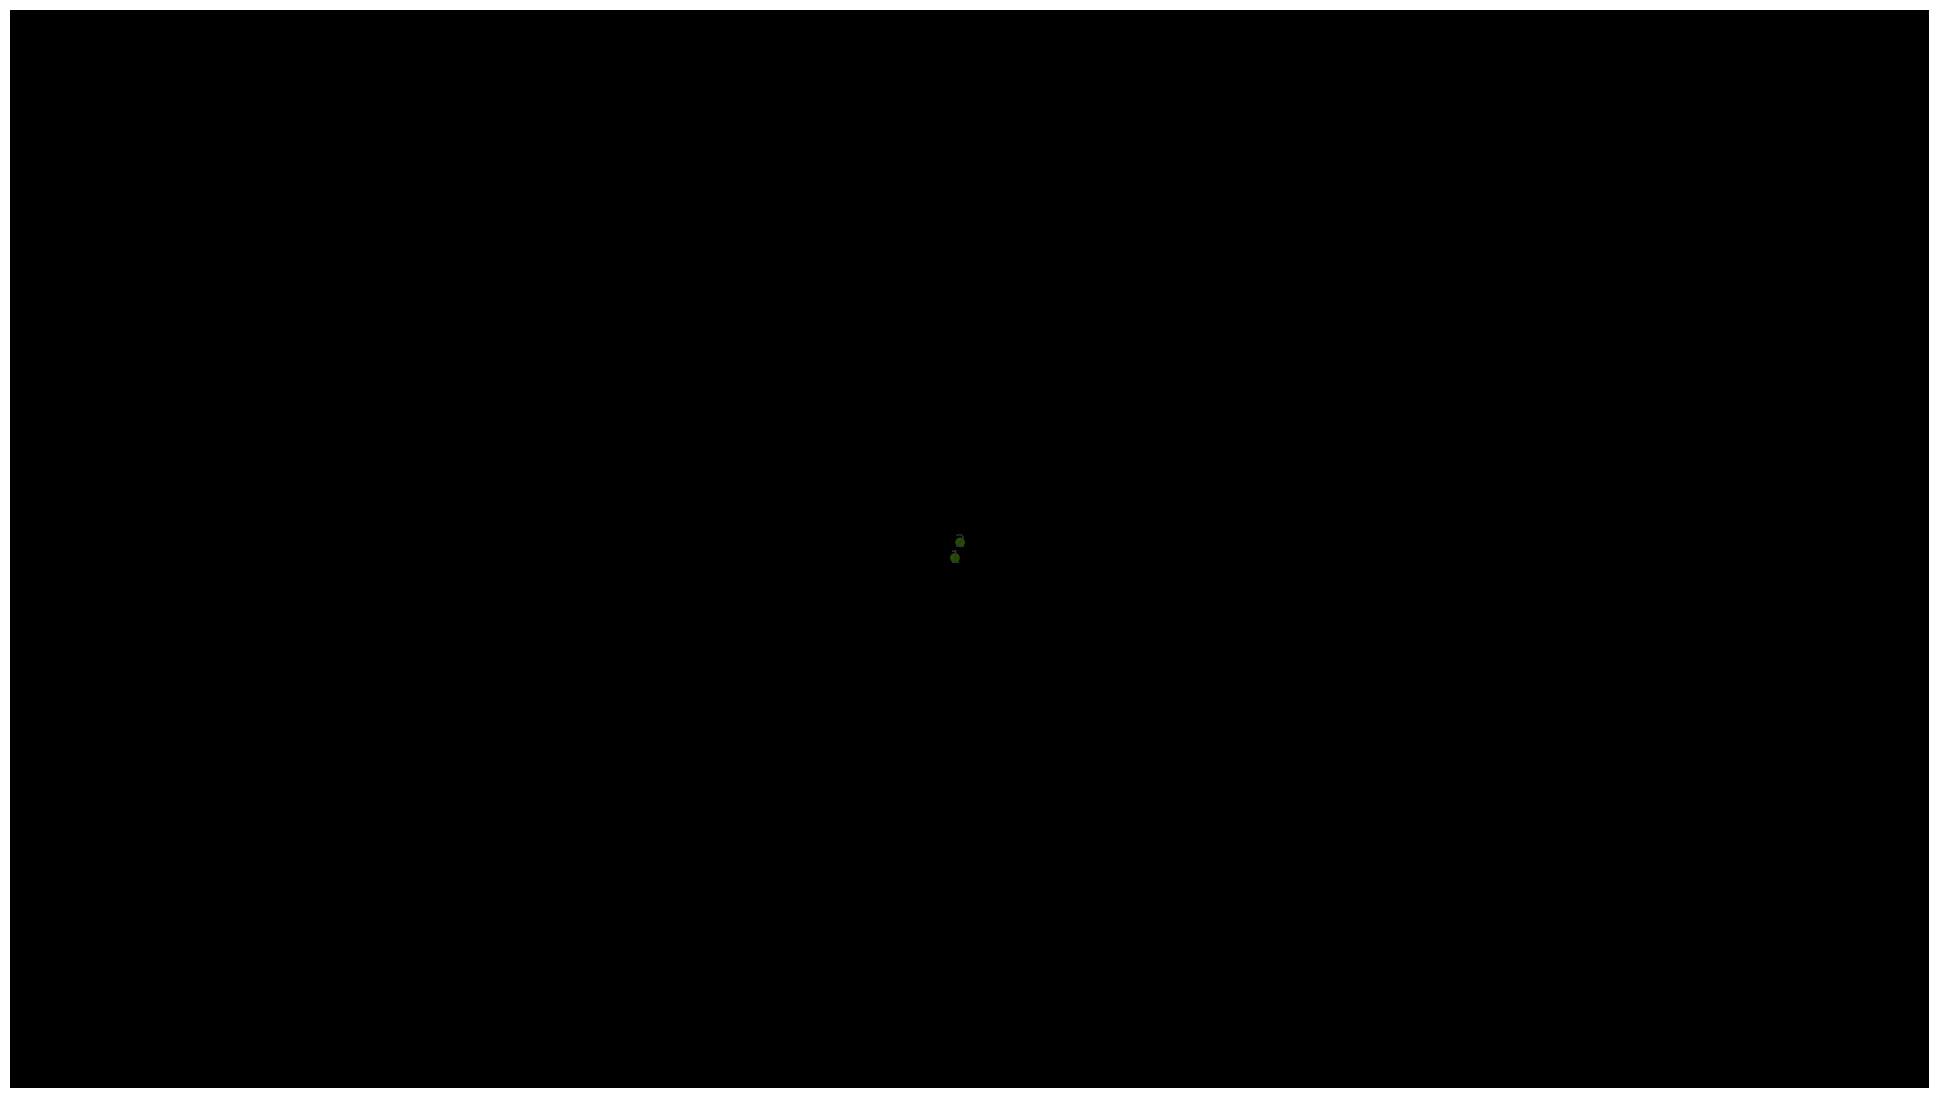

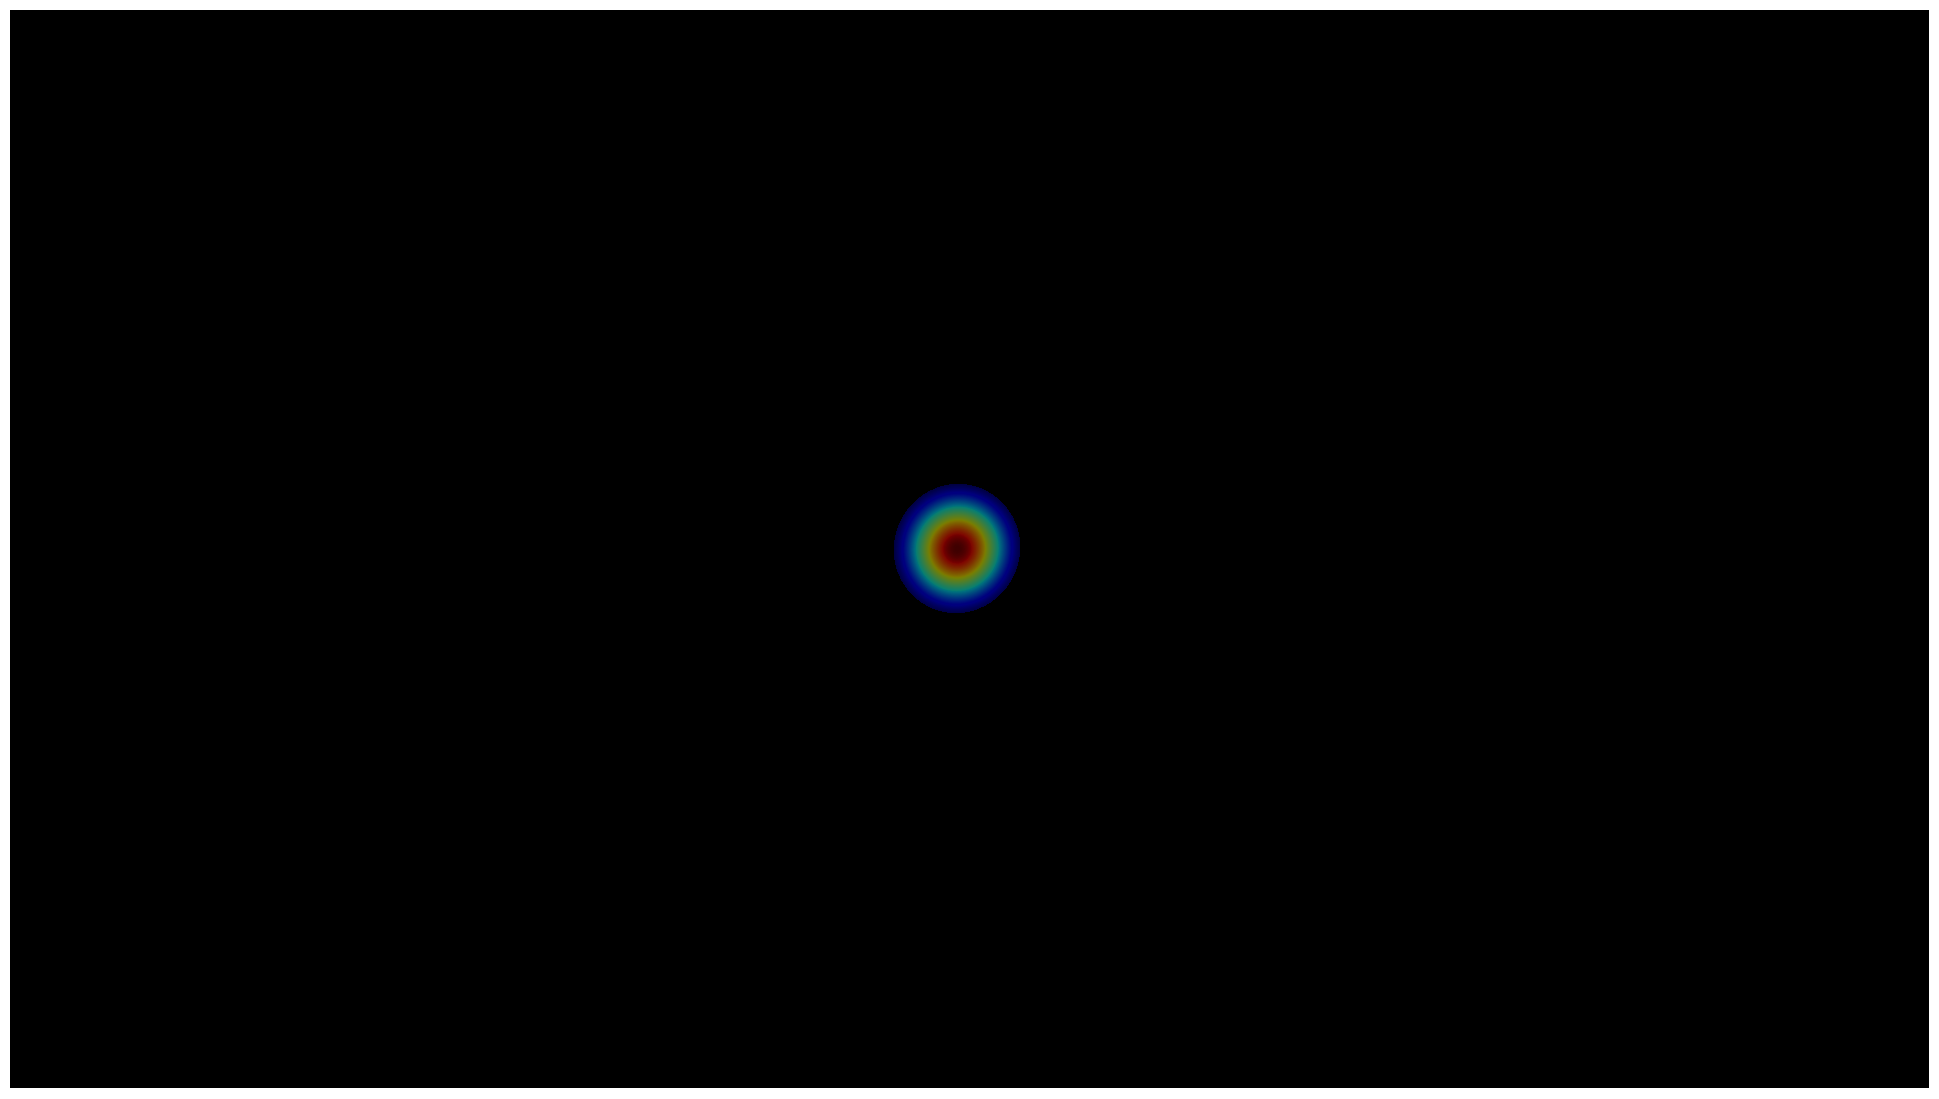

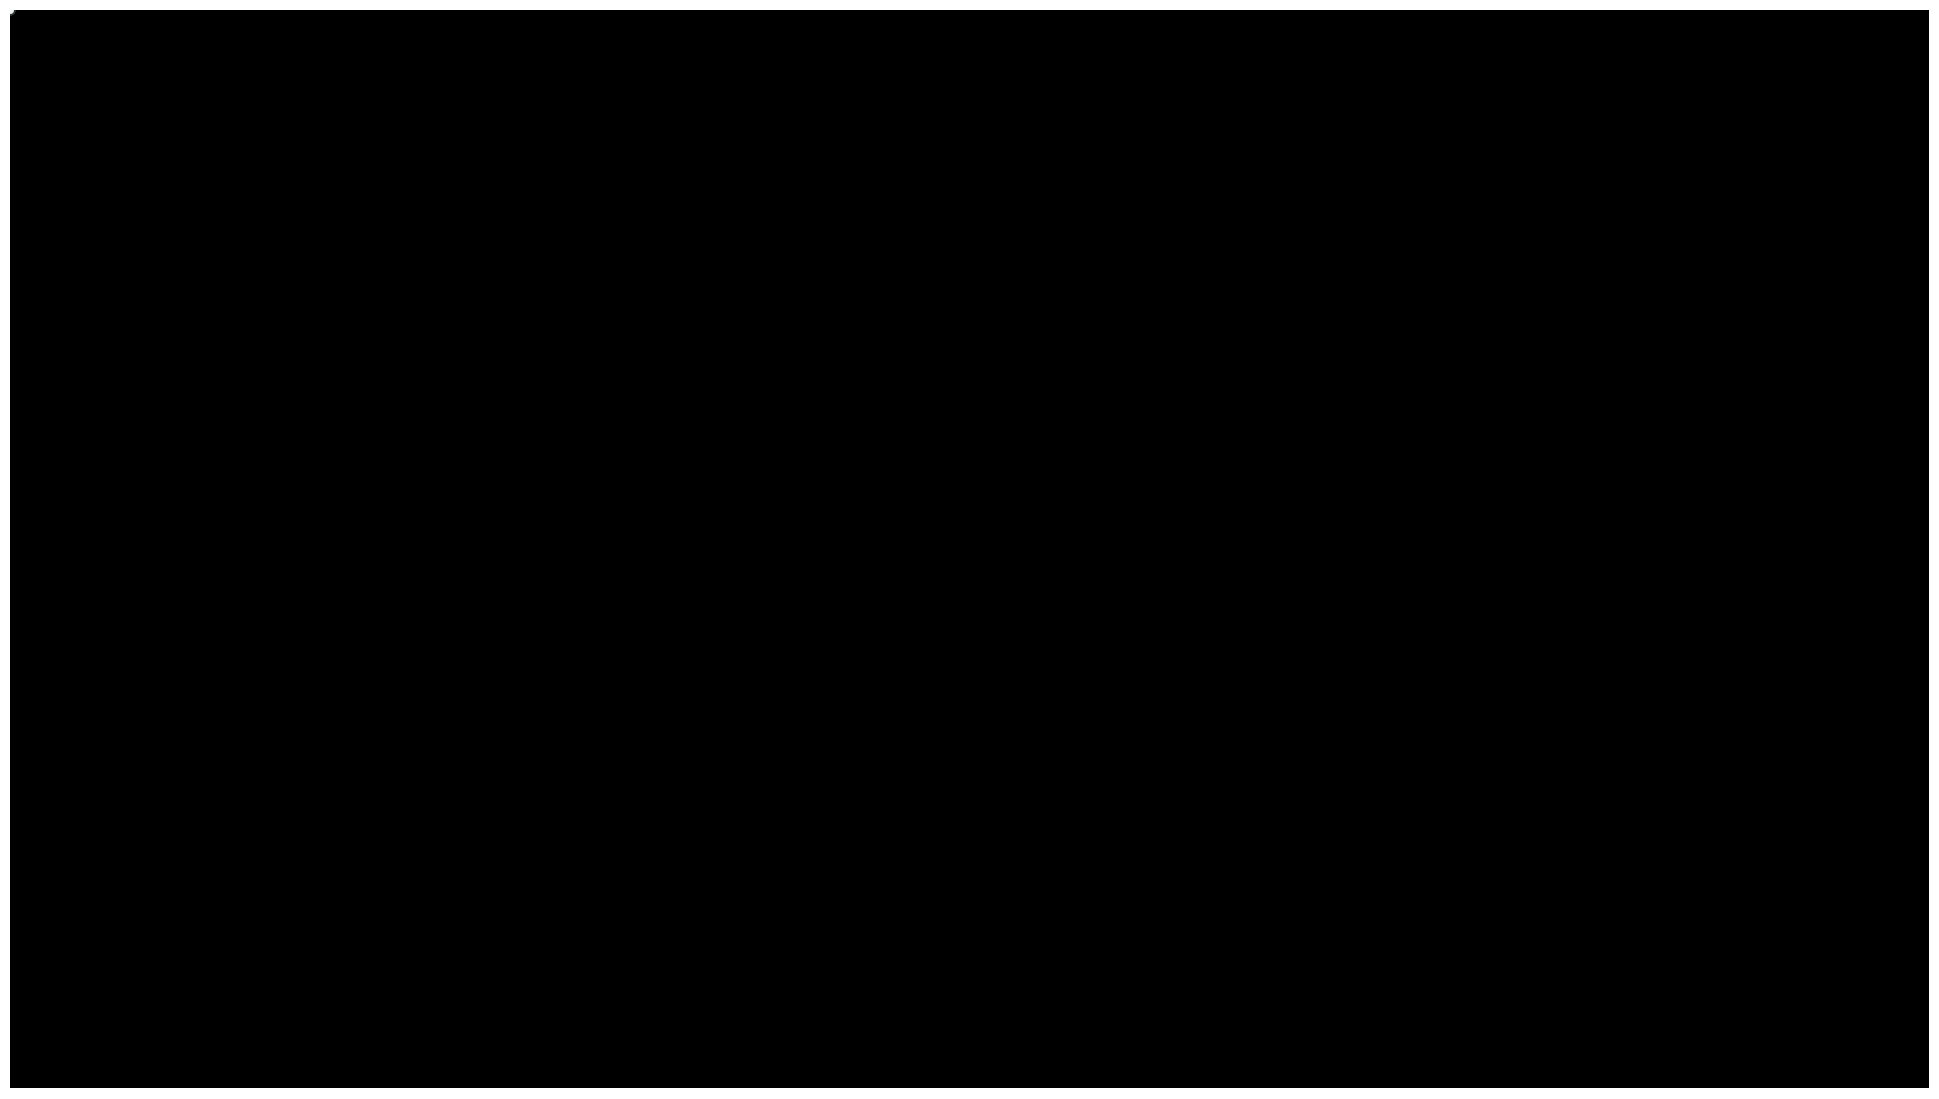

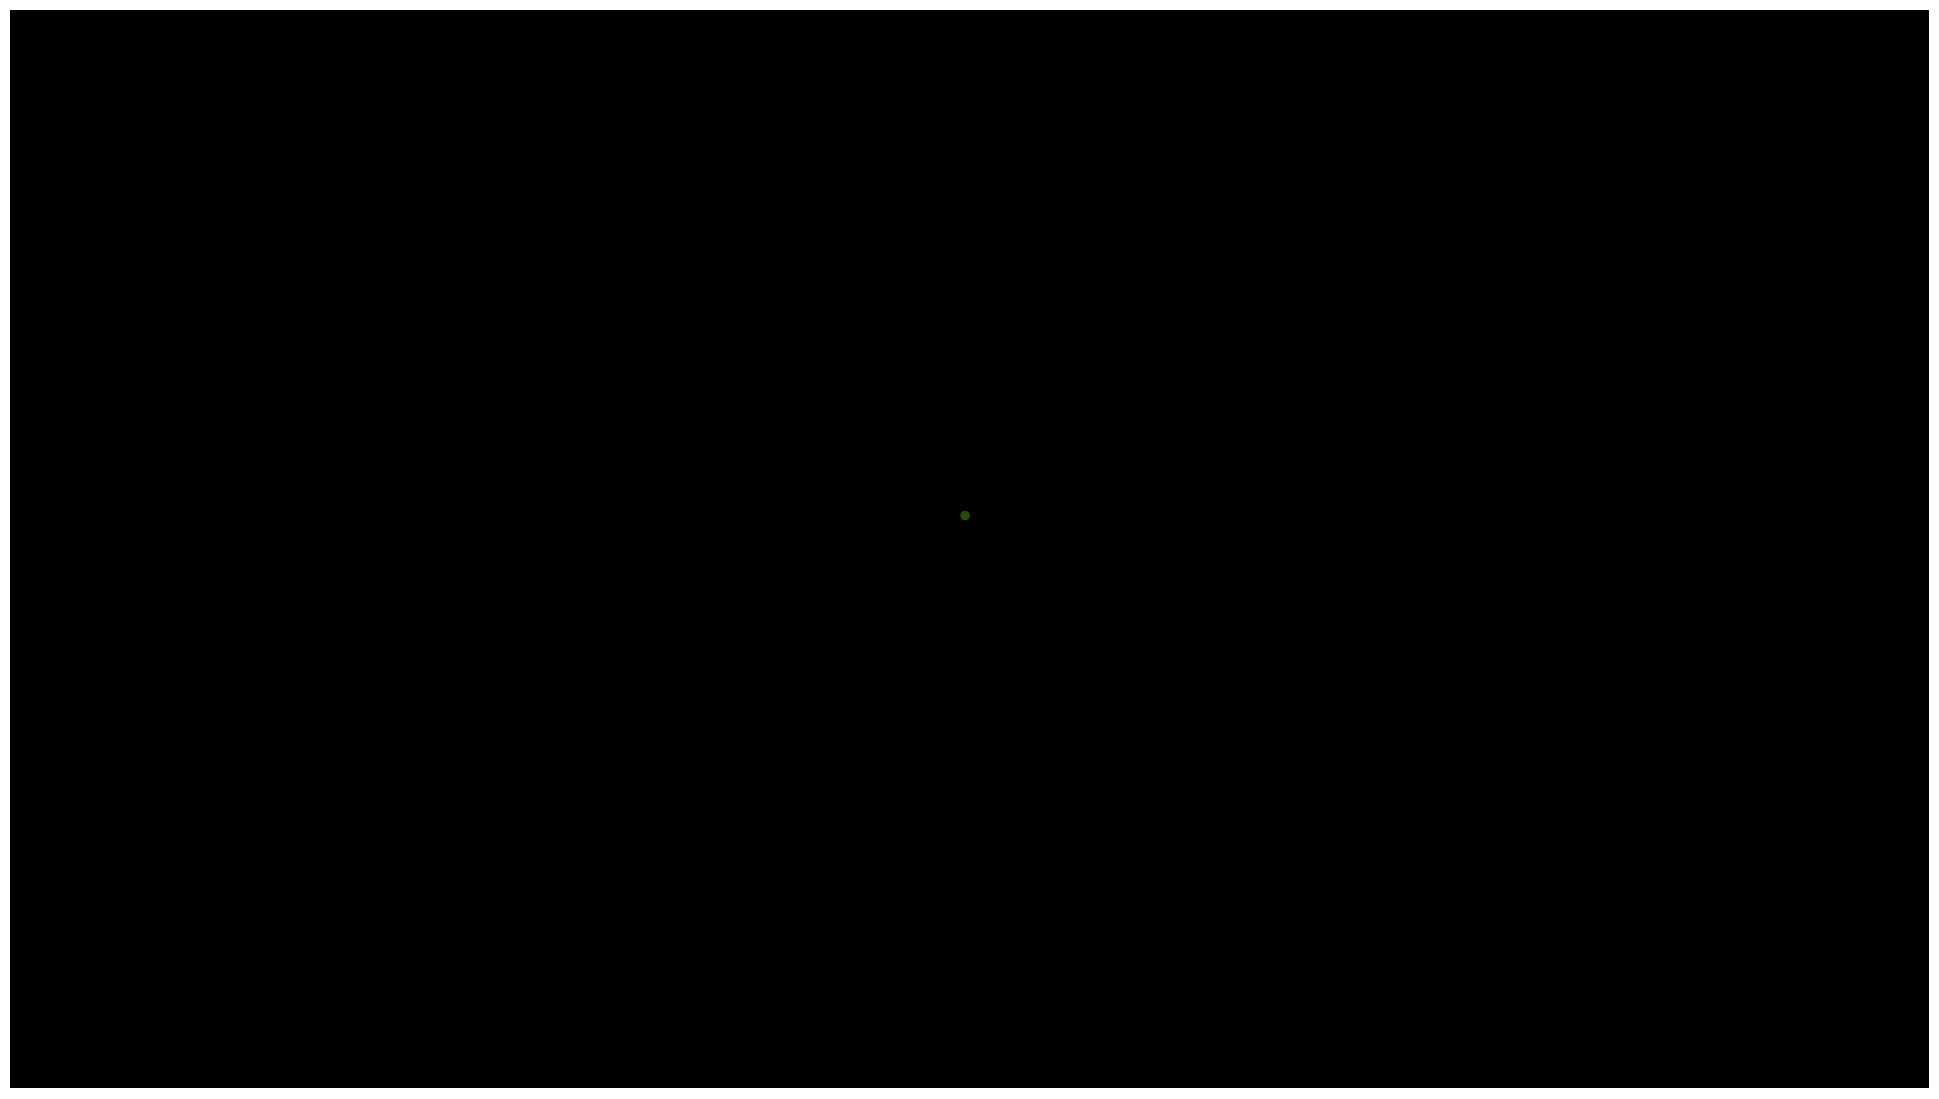

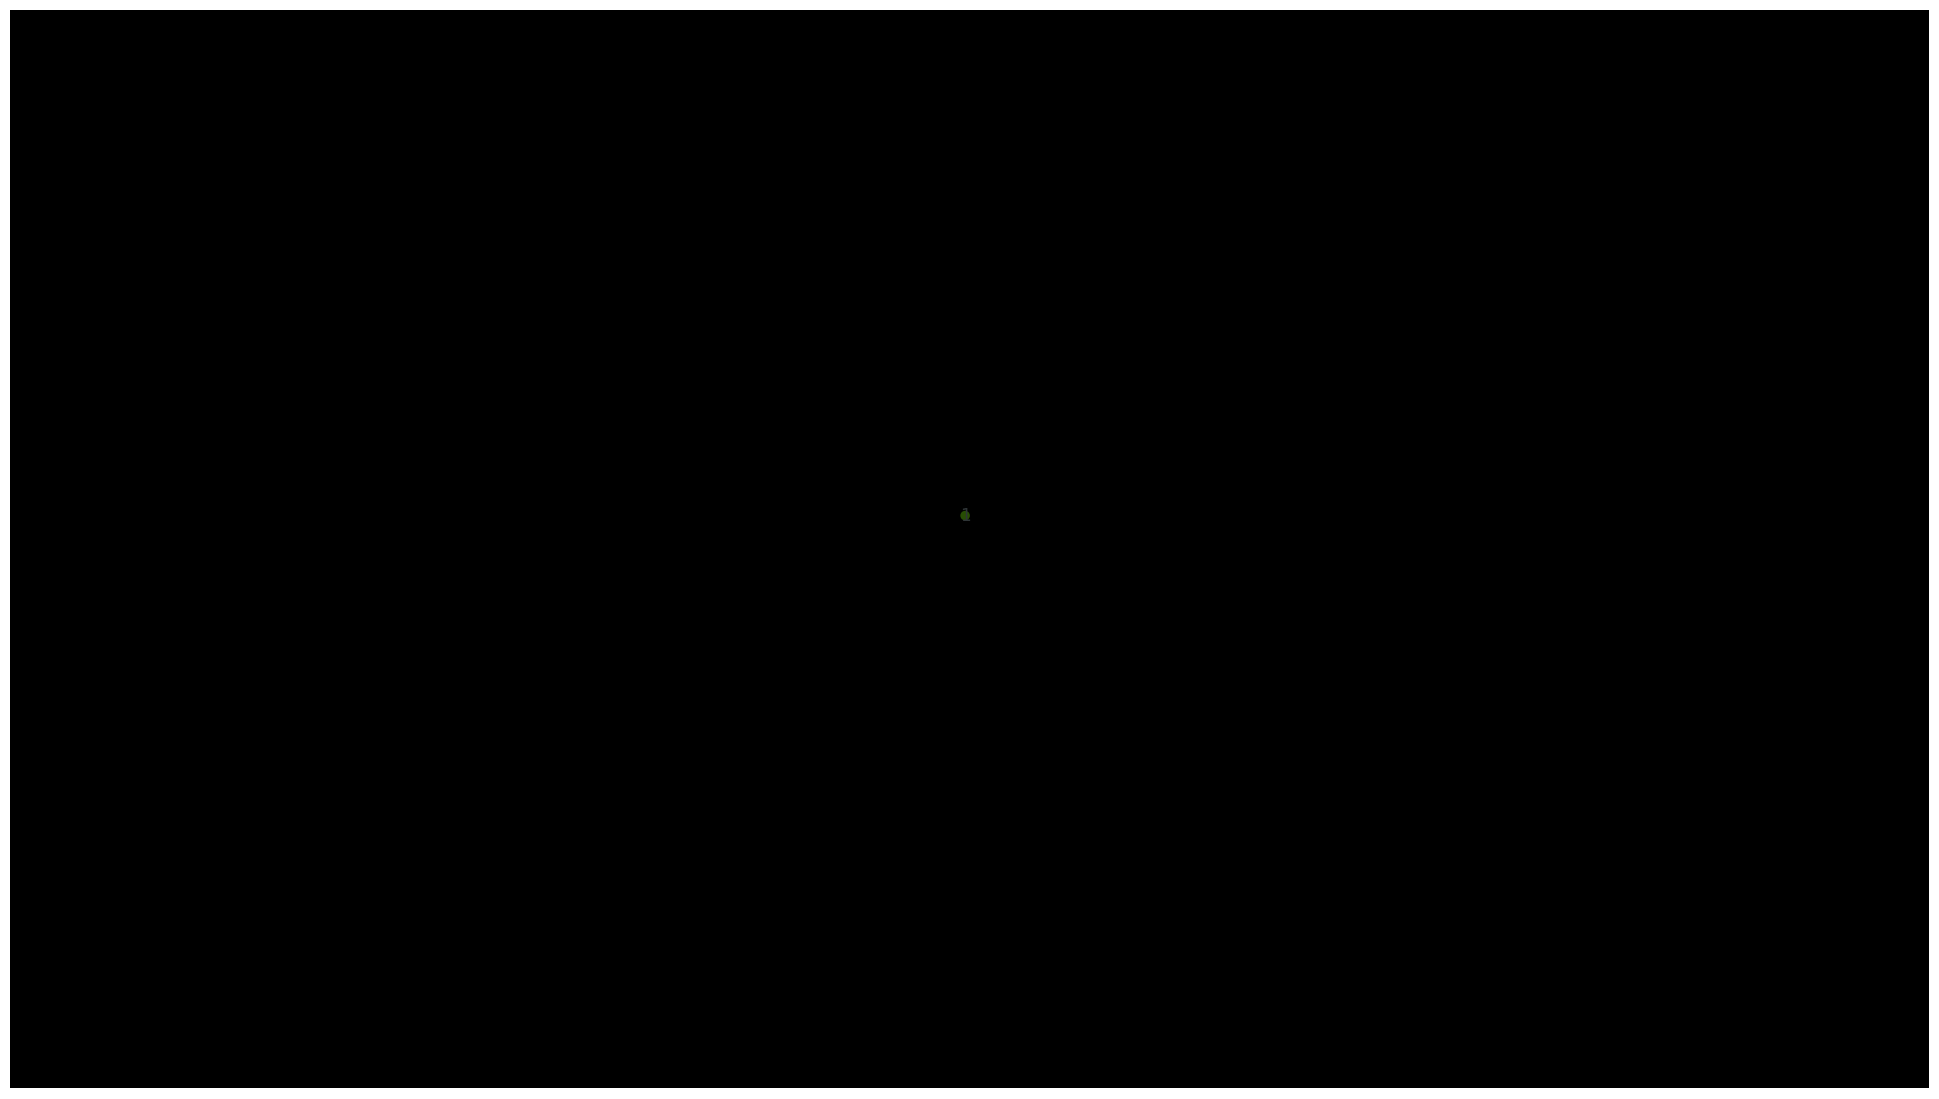

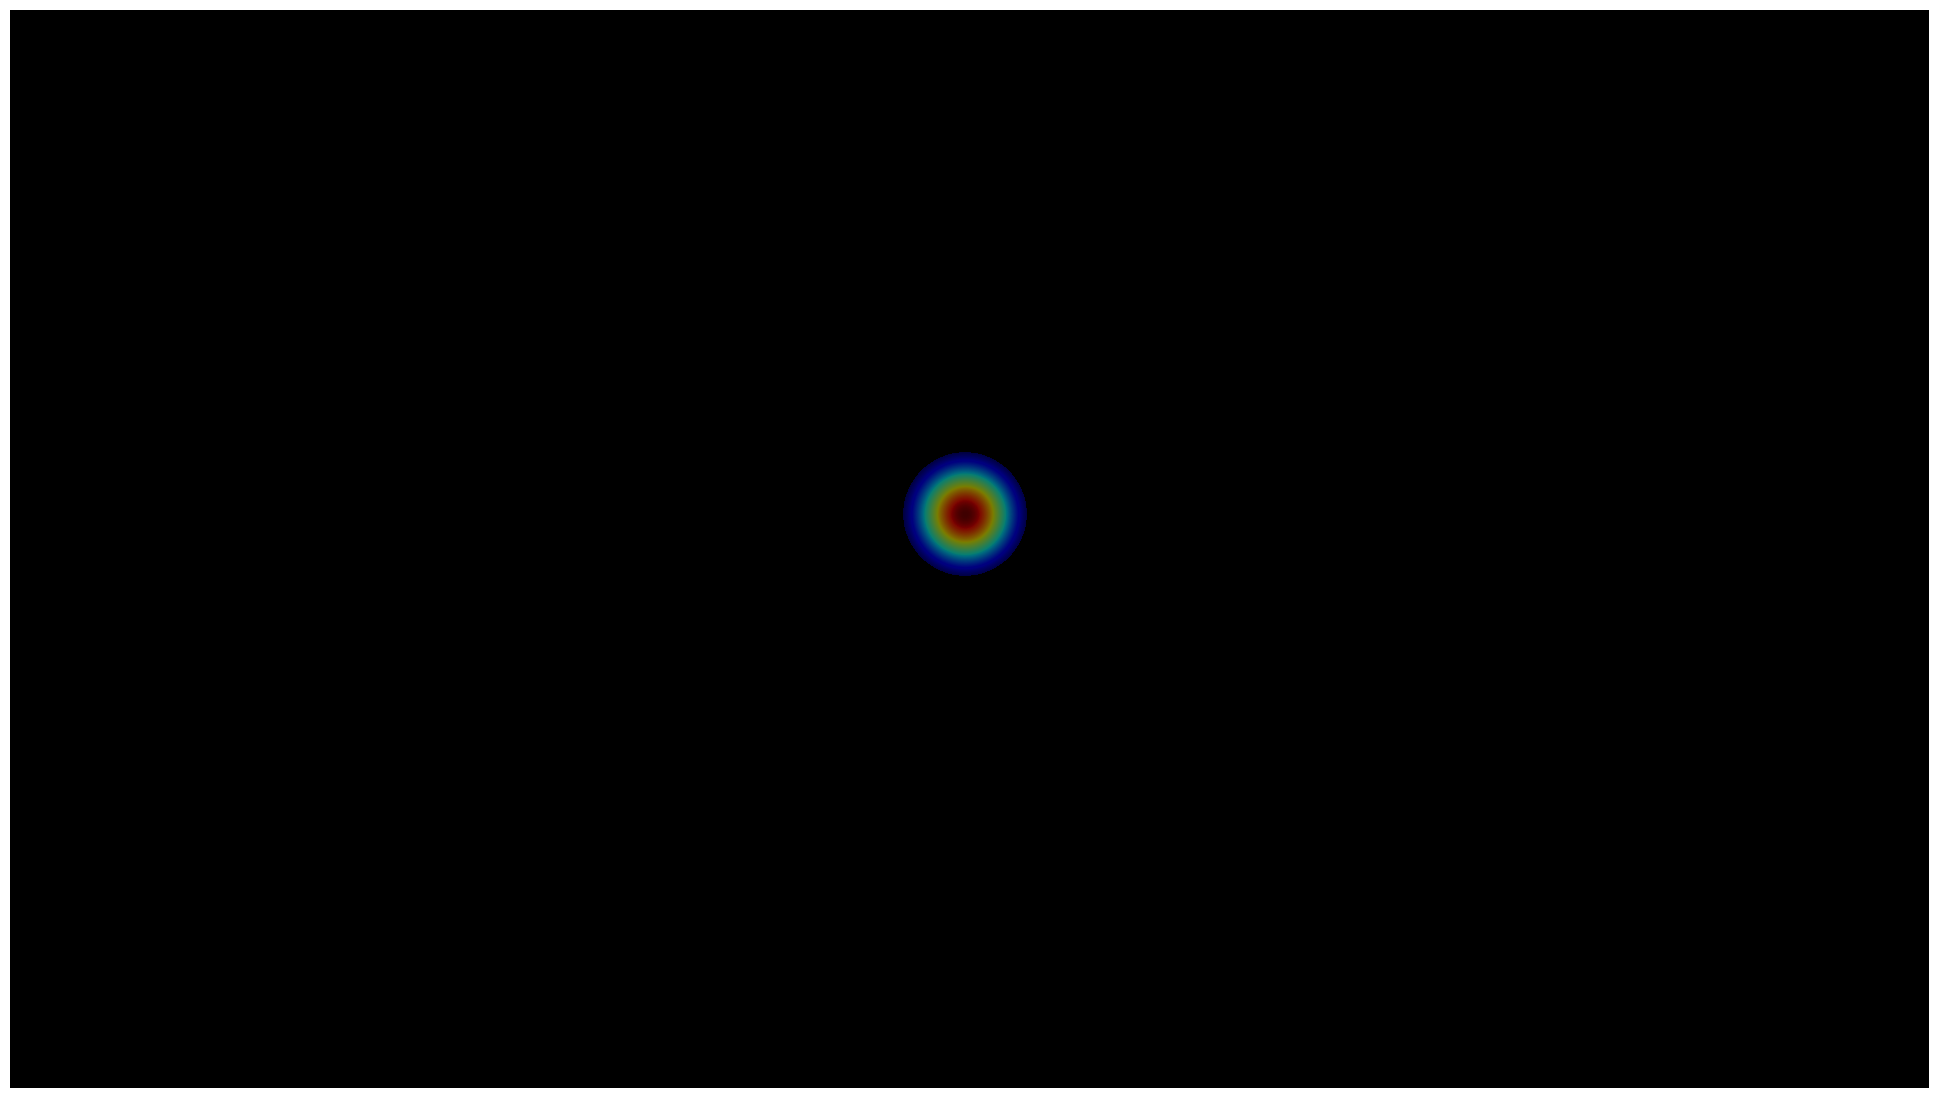

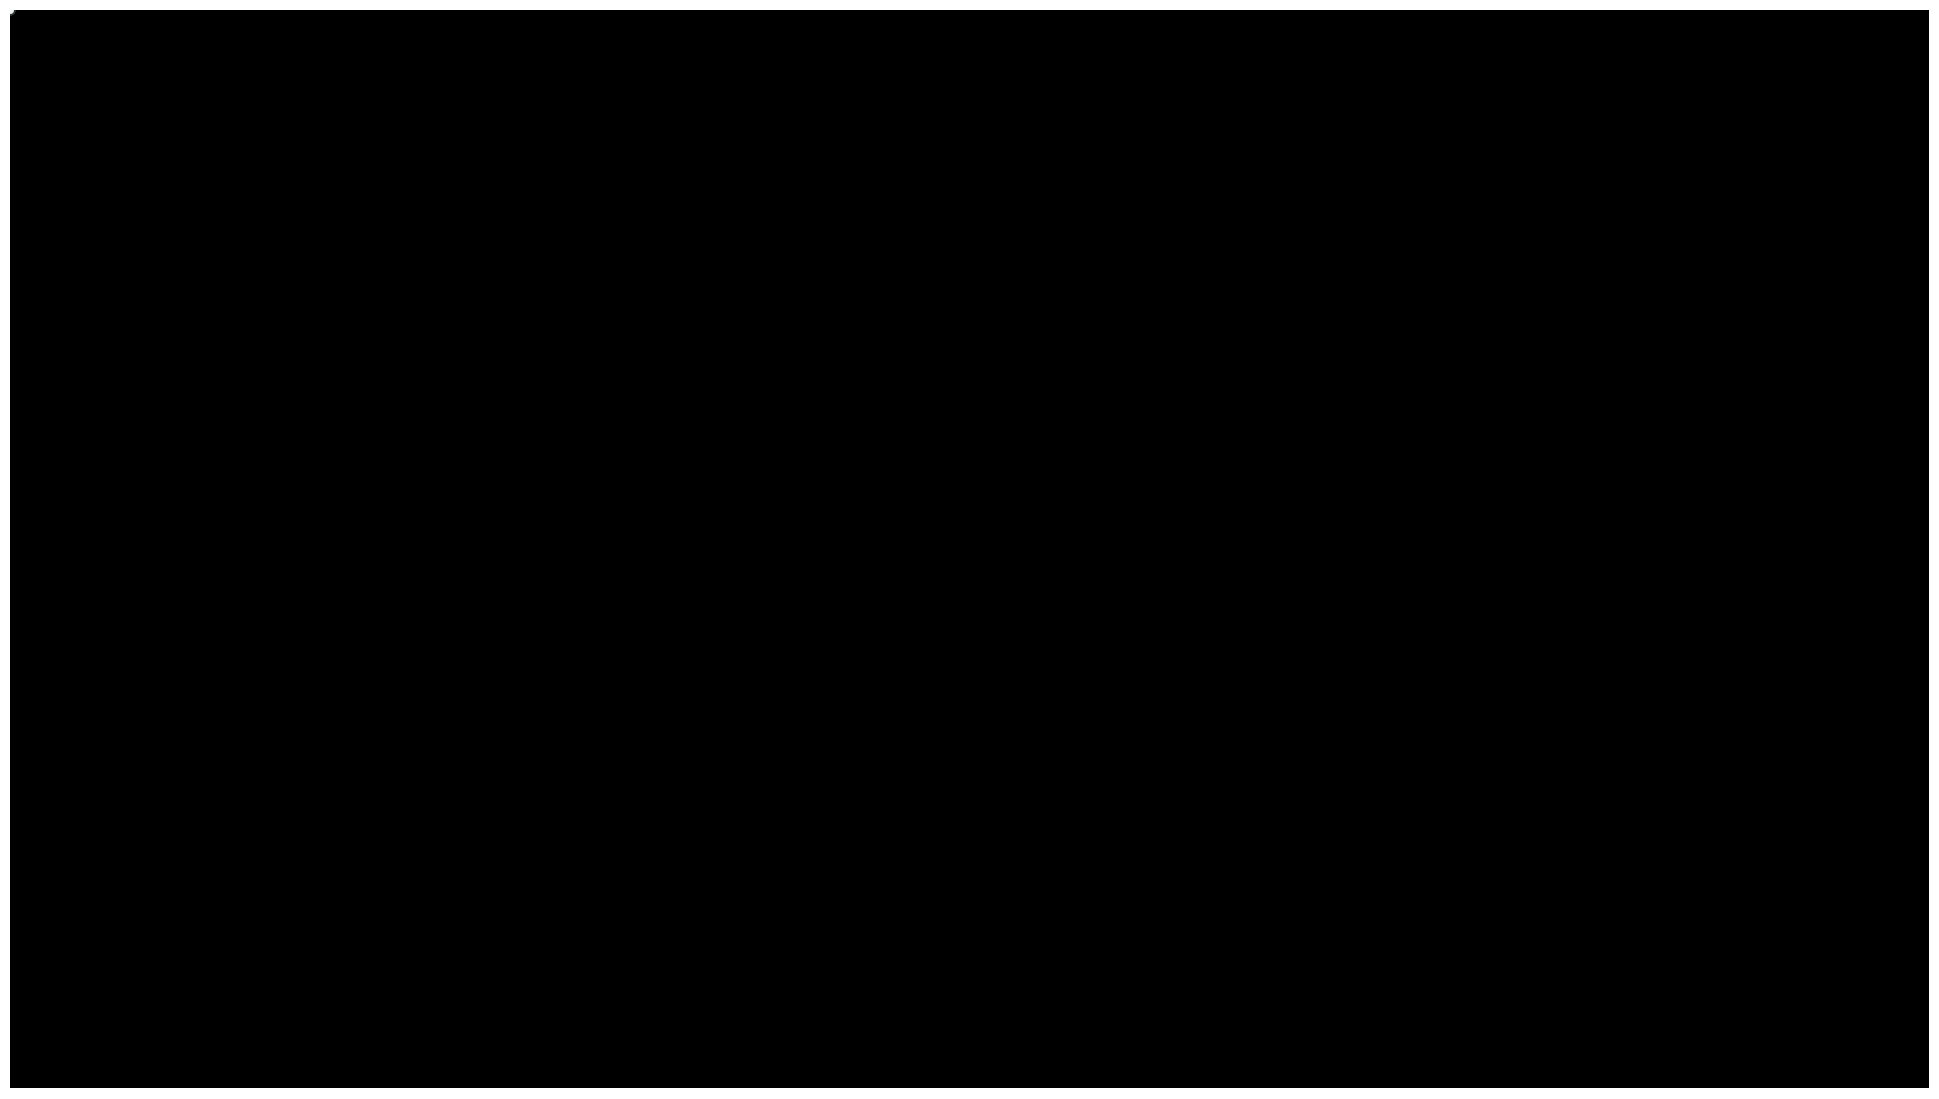

In [9]:
# analysis script for eye tracking project
#
# version 2 (Apr 2021)
#
# looks at each stimulus phase seperately

__author__ = "Sijamini Baskaralingam"

import sys
sys.path.append('PyGazeAnalyser-master\\pygazeanalyser')

# native
import os
import math

# custom
from edfreader import read_edf
from gazeplotter_sija import draw_fixations, draw_heatmap, draw_scanpath, draw_raw

# external
import numpy
import pandas as pd



# # # # #
# CONSTANTS

# PARTICIPANT
PID_string = str(input("participant ID? (only number, e.g. 036): "))
PID = int(PID_string)
PP = "G"+PID_string
#PP+"_1", PP+"_2", PP+"_3", PP+"_4", PP+"_5", 
PPS = [PP+"_1", PP+"_2", PP+"_3", PP+"_4", PP+"_5", PP+"_6", PP+"_7", PP+"_8", PP+"_9", PP+"_10", PP+"_11", PP+"_12", PP+"_13", PP+"_14", PP+"_15", PP+"_16"]
print(PPS)

# DIRECTORIES
# paths
DIR = os.path.dirname('PyGazeAnalyser-master\\pygazeanalyser\\imgs')
IMGDIR = os.path.join(DIR, 'imgs')
DATADIR = os.path.join(DIR, 'data')
PLOTDIR = os.path.join(DIR, 'plots')
OUTPUTFILENAME = os.path.join(DIR, "output.txt")
# check if the image directory exists
if not os.path.isdir(IMGDIR):
        raise Exception("ERROR: no image directory found; path '%s' does not exist!" % IMGDIR)
# check if the data directory exists
if not os.path.isdir(DATADIR):
        raise Exception("ERROR: no data directory found; path '%s' does not exist!" % DATADIR)
# check if output directorie exist; if not, create it
if not os.path.isdir(PLOTDIR):
        os.mkdir(PLOTDIR)

# DATA FILES
SEP = '\t' # value separator
EDFSTART = "SYNCTIME" # EDF file trial start message 
EDFSTOP = "CC" # EDF file trial end message
EDFSTART2 = "TRIALID" # EDF file trial start message
EDFSTOP2 = "SYNCTIME" # EDF file trial end message
#For EDFSTART and EDFSTOP: Use TRIALID and SYNCTIME for fixation period. Use SYNTIME and CC for the stimulationphase.
#Use CC and REWARD for reaction time. TRIALOK is end of trial.
TRIALORDER = [EDFSTART, 'image online','image offline', EDFSTOP]
INVALCODE = 0.0 # value coding invalid data

# EXPERIMENT SPECS
DISPSIZE = (1919,1079) # (px,px)
SCREENSIZE = (53.3,29.9) # (cm,cm)
SCREENDIST = 27 # cm
PXPERCM = numpy.mean([DISPSIZE[0]/SCREENSIZE[0],DISPSIZE[1]/SCREENSIZE[1]]) # px/cm

# # # # #
# READ FILES

print("starting data analysis for participant '%s'" % (PP))

# DATASET
print("loading  csv data")

# path
fp = os.path.join(DATADIR, "dataset_0423.csv")
print("fp: ", fp)

# open the file
#fl = open(fp, 'r') #only needed for readlines()

# read the file content
#data = fl.readlines() #does not make sense
#print("readlines: ", data)
data = numpy.genfromtxt(fp,delimiter=',')
print("numpyarray: ", data) #first row (index 0) is filled with NA due to the headers
df = pd.read_csv(fp, sep=',',header=None) #df is easier to use, you can search for values using the header
print("df: ", data)

# close the file
#fl.close() #only needed for readlines()

#prepare empty arrays
prototype = 0
#fixation coordinates stimulation phase
x_fixL = numpy.zeros(10081) #the excel file has 10080 rows including the headers
x_fixR = numpy.zeros(10081)
y_fixL = numpy.zeros(10081)
y_fixR = numpy.zeros(10081)
#fixation coordinates fixation phase
x_fixL2 = numpy.zeros(10081) 
x_fixR2 = numpy.zeros(10081)
y_fixL2 = numpy.zeros(10081)
y_fixR2 = numpy.zeros(10081)    
distL = numpy.zeros(10081) #distance left eye
distR = numpy.zeros(10081)
mDist = numpy.zeros(10081)
counterpps = 0

# loop through all participant games
for ppname in PPS:
        

        
        # separate header from rest of file
        #header = data.pop(0)
        #header = header.replace('\n','').replace('\r','').replace('"','').split(SEP)
        
        # process file contents
        #for i in range(len(data)):
        #       data[i] = data[i].replace('\n','').replace('\r','').replace('"','').split(SEP)
        
        # GAZE DATA
        print("loading gaze data for: ", ppname)
        
        # path
        fp = os.path.join(DATADIR, '%s.asc' % ppname)
        
        # check if the path exist
        if not os.path.isfile(fp):
                # if not, check if the EDF exists
                edfp = os.path.join(DATADIR, '%s.edf' % ppname)
                if os.path.isfile(edfp):
                        # if it does, convert if usinf edf2asc.exe
                        os.system("edf2asc %s" % edfp)
                        # load ASCII
                        fp = os.path.join(DATADIR, '%s.asc' % ppname)
                # if it does not exist, raise an exception
                else:
                        raise Exception("No eye data file (neither ASC, nor EDF) file found for participant '%s' (tried paths:\nASC: %s\nEDF: %s" % (ppname, fp, edfp))
        
        # read the file
        #edfdata[trialnr]['time'] = list of timestamps in trialnr
        #edfdata[trialnr]['size'] = list of pupil size samples in trialnr
        edfdata = read_edf(fp, EDFSTART, stop=EDFSTOP, missing=INVALCODE, debug=False) #stimulation period
        edfdata2 = read_edf(fp, EDFSTART2, stop=EDFSTOP2, missing=INVALCODE, debug=False) #fixation period
        
        # NEW OUTPUT DIRECTORIES
        # create a new output directory for the current participant
        pplotdir = os.path.join(PLOTDIR, ppname)
        # check if the directory already exists
        if not os.path.isdir(pplotdir):
                # create it if it doesn't yet exist
                os.mkdir(pplotdir)
                
        # # # # #
        # PLOTS
        print("plotting gaze data for: ", ppname)
        # loop through trials
        for trialnr in range(0,16):
                # load image name, saccades, and fixations
                #imgname = data[trialnr][header.index("image")]
                imgname=None
                print("Trialnr: ", trialnr)
                saccades = edfdata[trialnr]['events']['Esac'] # [starttime, endtime, duration, startx, starty, endx, endy]
                fixations = edfdata[trialnr]['events']['Efix'] # [starttime, endtime, duration, endx, endy]
                fixations2 = edfdata2[trialnr]['events']['Efix'] # [starttime, endtime, duration, endx, endy]
                print("Fixation: ", fixations)
                print("Fixation2: ", fixations2)
                csvRow = (PID-1 + 18*counterpps + trialnr)+1
                #save the coordinates of the stimulation period
                if len(fixations) == 0:
                        x_fixL[csvRow] = None
                        x_fixR[csvRow] = None
                        y_fixL[csvRow] = None
                        y_fixR[csvRow] = None
                elif len(fixations) == 1:
                        x_fixL[csvRow] = fixations[0][3]
                        x_fixR[csvRow] = None
                        y_fixL[csvRow] = fixations[0][4]
                        y_fixR[csvRow] = None      
                else:
                        x_fixL[csvRow] = fixations[0][3]
                        x_fixR[csvRow] = fixations[1][3]
                        y_fixL[csvRow] = fixations[0][4]
                        y_fixR[csvRow] = fixations[1][4]
                #save the coordinates of the fixation period
                if len(fixations2) == 0:
                        x_fixL2[csvRow] = None
                        x_fixR2[csvRow] = None
                        y_fixL2[csvRow] = None
                        y_fixR2[csvRow] = None
                elif len(fixations2) == 1:
                        x_fixL2[csvRow] = fixations2[0][3]
                        x_fixR2[csvRow] = None
                        y_fixL2[csvRow] = fixations2[0][4]
                        y_fixR2[csvRow] = None      
                else:
                        x_fixL2[csvRow] = fixations2[0][3]
                        x_fixR2[csvRow] = fixations2[1][3]
                        y_fixL2[csvRow] = fixations2[0][4]
                        y_fixR2[csvRow] = fixations2[1][4]
                #calculate the distances
                if (x_fixL[csvRow] == None) or (x_fixL2[csvRow] == None) or (y_fixL[csvRow] == None) or (y_fixL2[csvRow] == None):
                        distL = None
                if (x_fixR[csvRow] == None) or (x_fixR2[csvRow] == None) or (y_fixR[csvRow] == None) or (y_fixR2[csvRow] == None):
                        distR = None
                if not (x_fixL[csvRow] == None) or (x_fixL2[csvRow] == None) or (y_fixL[csvRow] == None) or (y_fixL2[csvRow] == None) or (x_fixR[csvRow] == None) or (x_fixR2[csvRow] == None) or (y_fixR[csvRow] == None) or (y_fixR2[csvRow] == None):
                        distL[csvRow]= math.sqrt((x_fixL[csvRow]-x_fixL2[csvRow])**2 + (y_fixL[csvRow]-y_fixL2[csvRow])**2)
                        distR[csvRow]= math.sqrt((x_fixR[csvRow]-x_fixR2[csvRow])**2 + (y_fixR[csvRow]-y_fixR2[csvRow])**2)
                #calculate the mean of the distances (right and left eye)
                if (distL[csvRow] != None) and (distR[csvRow] == None):
                        mDist[csvRow] = distL[csvRow]
                elif (distL[csvRow] == None) and (distR[csvRow] != None):
                        mDist[csvRow] = distR[csvRow]
                elif (distL[csvRow] == None) and (distR[csvRow] == None):
                        mDist[csvRow] = None
                else:
                        mDist[csvRow]= (distL[csvRow] + distR[csvRow])/2
                #outputs to check the data
                print("Saccades: ", saccades)
                print("Fixation: ", fixations)
                print("coords: ", x_fixL, y_fixL, x_fixR, y_fixR)
                print("distance: ", mDist)
                
                # paths
                #imagefile = os.path.join(IMGDIR,imgname)
                imagefile = None
                rawplotfile = os.path.join(pplotdir, "raw_data_%s_%d" % (ppname,trialnr))
                scatterfile = os.path.join(pplotdir, "fixations_%s_%d" % (ppname,trialnr))
                scanpathfile =  os.path.join(pplotdir, "scanpath_%s_%d" % (ppname,trialnr))
                heatmapfile = os.path.join(pplotdir, "heatmap_%s_%d" % (ppname,trialnr))
                
                # raw data points
                draw_raw(edfdata[trialnr]['x'], edfdata[trialnr]['y'], DISPSIZE, imagefile=imagefile, savefilename=rawplotfile)

                # fixations
                draw_fixations(fixations, DISPSIZE, imagefile=imagefile, durationsize=True, durationcolour=False, alpha=0.5, savefilename=scatterfile)
                
                # scanpath
                draw_scanpath(fixations, saccades, DISPSIZE, imagefile=imagefile, alpha=0.5, savefilename=scanpathfile)

                # heatmap               
                draw_heatmap(fixations, DISPSIZE, imagefile=imagefile, durationweight=True, alpha=0.5, savefilename=heatmapfile)
                
##        # loop through trials 101 and 102 (17 and 18)
##        for trialnr in range(101,103):
##
##                # load image name, saccades, and fixations
##                #imgname = data[trialnr][header.index("image")]
##                imgname=None
##                print("Trialnr: ", trialnr)
##                saccades = edfdata[trialnr]['events']['Esac'] # [starttime, endtime, duration, startx, starty, endx, endy]
##                fixations = edfdata[trialnr]['events']['Efix'] # [starttime, endtime, duration, endx, endy]
##                print("Fixation: ", fixations)
##
##                if len(fixations) == 0:
##                        x_fixationL[trialnr-85] = None
##                        x_fixationL[trialnr-85] = None
##                        y_fixationL[trialnr-85] = None
##                        y_fixationR[trialnr-85] = None
##                elif len(fixations) == 1:
##                        x_fixationL[trialnr-84] = fixations[0][3]
##                        x_fixationR[trialnr-84] = None
##                        y_fixationL[trialnr-84] = fixations[0][4]
##                        y_fixationR[trialnr-84] = None      
##                else:
##                        x_fixationL[trialnr-84] = fixations[0][3]
##                        x_fixationR[trialnr-84] = fixations[1][3]
##                        y_fixationL[trialnr-84] = fixations[0][4]
##                        y_fixationR[trialnr-84] = fixations[1][4]
##                print("Saccades: ", saccades)
##                print("Fixation: ", fixations)
##                
##                # paths
##                #imagefile = os.path.join(IMGDIR,imgname)
##                imagefile = None
##                #rawplotfile = os.path.join(pplotdir, "raw_data_%s_%d" % (ppname,trialnr))
##                #scatterfile = os.path.join(pplotdir, "fixations_%s_%d" % (ppname,trialnr))
##                scanpathfile =  os.path.join(pplotdir, "scanpath_%s_%d" % (ppname,trialnr-85))
##                heatmapfile = os.path.join(pplotdir, "heatmap_%s_%d" % (ppname,trialnr-85))
##                
##                # raw data points
##                #draw_raw(edfdata[trialnr]['x'], edfdata[trialnr]['y'], DISPSIZE, imagefile=imagefile, savefilename=rawplotfile)
##
##                # fixations
##                #draw_fixations(fixations, DISPSIZE, imagefile=imagefile, durationsize=True, durationcolour=False, alpha=0.5, savefilename=scatterfile)
##                
##                # scanpath
##                draw_scanpath(fixations, saccades, DISPSIZE, imagefile=imagefile, alpha=0.5, savefilename=scanpathfile)
##
##                # heatmap               
##                draw_heatmap(fixations, DISPSIZE, imagefile=imagefile, durationweight=True, alpha=0.5, savefilename=heatmapfile)
                #add 1 to the PPS, so you know which game will be analyzed now
                counterPPS =+ 1
                df['mean_distance'] = mDist


# and equating it to the list
##df['x_fixationL'] = x_fixationL
##df['x_fixationR'] = x_fixationR
##df['y_fixationL'] = y_fixationL
##df['y_fixationR'] = y_fixationR
##df['x_fixationL2'] = x_fixationL
##df['x_fixationR2'] = x_fixationR
##df['y_fixationL2'] = y_fixationL
##df['y_fixationR2'] = y_fixationR
##df['distanceL'] = distanceL
##df['distanceR'] = distanceR
df['mean_distance'] = mDist



### Sija's Code 2: add distances to csv file

participant ID? (only number, e.g. 036): 036
['G036_14', 'G036_15', 'G036_16']
starting data analysis for participant 'G036'
loading  csv data
fp:  PyGazeAnalyser-master\pygazeanalyser\data\dataset_0423.csv
numpyarray:  [[nan nan nan ... nan nan nan]
 [ 1.  2.  1. ...  0.  0.  0.]
 [ 1.  2.  1. ...  0.  0.  0.]
 ...
 [35. 36. 16. ...  1.  1. 90.]
 [35. 36. 16. ...  0.  0. 90.]
 [35. 36. 16. ...  1.  1. 90.]]
df:  [[nan nan nan ... nan nan nan]
 [ 1.  2.  1. ...  0.  0.  0.]
 [ 1.  2.  1. ...  0.  0.  0.]
 ...
 [35. 36. 16. ...  1.  1. 90.]
 [35. 36. 16. ...  0.  0. 90.]
 [35. 36. 16. ...  1.  1. 90.]]
loading gaze data for:  G036_14
plotting gaze data for:  G036_14
Trialnr:  0
Fixation:  [[4513696, 4513957, 262, 932.3, 494.8]]
Fixation2:  [[4512466, 4512651, 186, 988.6, 788.7], [4512465, 4512651, 187, 971.7, 809.1], [4512866, 4512997, 132, 975.9, 424.4], [4512861, 4512999, 139, 980.5, 429.2], [4513024, 4513392, 369, 990.0, 527.6], [4513024, 4513392, 369, 985.9, 552.8]]
639.225414075504

c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Trialnr:  5
Fixation:  []
Fixation2:  [[4556014, 4557146, 1133, 960.9, 491.5]]
None
Saccades:  []
Fixation:  []
coords:  None None None None
distance:  None


PyGazeAnalyser-master\pygazeanalyser\gazeplotter_sija.py:416: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = pyplot.figure(figsize=figsize, dpi=dpi, frameon=False)
c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Trialnr:  6
Fixation:  [[4564481, 4565806, 1326, 926.5, 484.5]]
Fixation2:  [[4564295, 4564456, 162, 919.4, 377.9], [4564295, 4564457, 163, 900.1, 392.5]]
731.9168053815953
Saccades:  []
Fixation:  [[4564481, 4565806, 1326, 926.5, 484.5]]
coords:  926.5 484.5 None None
distance:  731.9168053815953
Trialnr:  7
Fixation:  [[4573300, 4574050, 751, 939.1, 472.8]]
Fixation2:  [[4572470, 4573047, 578, 1163.3, 312.5], [4572470, 4573049, 580, 1159.1, 329.4], [4573084, 4573278, 195, 977.6, 414.0], [4573086, 4573280, 195, 968.3, 427.7]]
706.5902985464774
Saccades:  []
Fixation:  [[4573300, 4574050, 751, 939.1, 472.8]]
coords:  939.1 472.8 None None
distance:  706.5902985464774
Trialnr:  8
Fixation:  [[4581312, 4581859, 548, 958.1, 507.1]]
Fixation2:  [[4580122, 4580671, 550, 1152.0, 323.3], [4580122, 4580674, 553, 1131.1, 339.4], [4580711, 4580907, 197, 968.2, 428.3], [4580712, 4580908, 197, 959.4, 445.0], [4580932, 4581089, 158, 871.0, 486.8], [4580929, 4581090, 162, 881.3, 471.9], [4581109, 45

c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Trialnr:  10
Fixation:  [[4596546, 4597904, 1359, 1015.9, 397.9]]
Fixation2:  [[4596345, 4596510, 166, 1182.9, 275.4], [4596345, 4596511, 167, 1175.0, 311.5]]
840.6334873177489
Saccades:  []
Fixation:  [[4596546, 4597904, 1359, 1015.9, 397.9]]
coords:  1015.9 397.9 None None
distance:  840.6334873177489
Trialnr:  11
Fixation:  [[4606157, 4606508, 352, 1152.6, 326.1]]
Fixation2:  [[4605036, 4606134, 1099, 1208.4, 285.3], [4605036, 4606136, 1101, 1201.4, 307.4]]
926.5800019426277
Saccades:  []
Fixation:  [[4606157, 4606508, 352, 1152.6, 326.1]]
coords:  1152.6 326.1 None None
distance:  926.5800019426277
Trialnr:  12
Fixation:  [[4613584, 4614301, 718, 1050.4, 432.8], [4613585, 4614301, 717, 1038.2, 448.5]]
Fixation2:  [[4612837, 4613556, 720, 1061.6, 341.8], [4612837, 4613557, 721, 1056.2, 359.3]]
830.3190952880707
Saccades:  []
Fixation:  [[4613584, 4614301, 718, 1050.4, 432.8], [4613585, 4614301, 717, 1038.2, 448.5]]
coords:  1050.4 432.8 1038.2 448.5
distance:  460.6585586222973
Tria

c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


loading gaze data for:  G036_15
plotting gaze data for:  G036_15
Trialnr:  0
Fixation:  [[4672470, 4672784, 315, 1028.5, 430.9], [4672471, 4672784, 314, 1026.9, 440.6]]
Fixation2:  [[4671323, 4672033, 711, 1026.2, 335.9], [4671323, 4672036, 714, 1031.8, 322.1], [4672053, 4672445, 393, 1043.0, 342.2], [4672049, 4672445, 397, 1036.7, 354.6]]
810.3594881285712
Saccades:  []
Fixation:  [[4672470, 4672784, 315, 1028.5, 430.9], [4672471, 4672784, 314, 1026.9, 440.6]]
coords:  1028.5 430.9 1026.9 440.6
distance:  939.1913942181001
Trialnr:  1
Fixation:  [[4681045, 4681399, 355, 1248.9, 766.4]]
Fixation2:  [[4679898, 4679999, 102, 1206.6, 734.3], [4679898, 4680000, 103, 1203.5, 723.7], [4680020, 4681025, 1006, 1202.0, 776.5], [4680021, 4681026, 1006, 1199.1, 764.3]]
900.294796164012
Saccades:  []
Fixation:  [[4681045, 4681399, 355, 1248.9, 766.4]]
coords:  1248.9 766.4 None None
distance:  900.294796164012
Trialnr:  2
Fixation:  [[4689378, 4689691, 314, 966.1, 480.7]]
Fixation2:  [[4688101, 46

c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Trialnr:  8
Fixation:  [[4739069, 4739462, 394, 955.6, 566.9]]
Fixation2:  [[4737941, 4737999, 59, 1111.7, 403.6], [4737941, 4738001, 61, 1101.1, 423.0], [4738022, 4738465, 444, 1038.4, 473.6], [4738025, 4738467, 443, 1028.8, 491.7], [4738491, 4738735, 245, 970.2, 518.4], [4738751, 4739049, 299, 973.8, 545.2]]
715.904637504186
Saccades:  []
Fixation:  [[4739069, 4739462, 394, 955.6, 566.9]]
coords:  955.6 566.9 None None
distance:  715.904637504186
Trialnr:  9
Fixation:  [[4746826, 4747770, 945, 967.7, 507.6]]
Fixation2:  [[4745984, 4746143, 160, 844.7, 622.1], [4745984, 4746144, 161, 866.9, 597.8], [4746169, 4746435, 267, 966.4, 523.1], [4746167, 4746435, 269, 951.3, 544.5], [4746460, 4746805, 346, 993.4, 455.1], [4746459, 4746806, 348, 977.5, 471.7]]
721.3990019399805
Saccades:  []
Fixation:  [[4746826, 4747770, 945, 967.7, 507.6]]
coords:  967.7 507.6 None None
distance:  721.3990019399805
Trialnr:  10
Fixation:  [[4754828, 4755385, 558, 963.3, 548.3], [4754829, 4755385, 557, 941.5,

c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Trialnr:  14
Fixation:  [[4787353, 4788302, 950, 978.6, 543.0]]
Fixation2:  [[4786773, 4787187, 415, 1179.9, 444.7], [4786773, 4787188, 416, 1182.7, 476.8], [4787217, 4787331, 115, 1049.6, 511.9], [4787220, 4787333, 114, 1045.5, 536.6]]
716.0013198311858
Saccades:  []
Fixation:  [[4787353, 4788302, 950, 978.6, 543.0]]
coords:  978.6 543.0 None None
distance:  716.0013198311858
Trialnr:  15
Fixation:  [[4795040, 4796370, 1331, 1206.0, 283.1]]
Fixation2:  []
None
Saccades:  []
Fixation:  [[4795040, 4796370, 1331, 1206.0, 283.1]]
coords:  1206.0 283.1 None None
distance:  None
loading gaze data for:  G036_16
plotting gaze data for:  G036_16
Trialnr:  0
Fixation:  []
Fixation2:  [[4829633, 4829644, 12, 1038.3, 504.0], [4829633, 4829647, 15, 1031.9, 525.4], [4829823, 4830041, 219, 1000.6, 470.5], [4829828, 4830043, 216, 1007.0, 483.1], [4830065, 4830304, 240, 971.4, 517.8], [4830065, 4830305, 241, 975.0, 500.4], [4830333, 4830777, 445, 1037.7, 381.2], [4830334, 4830780, 447, 1030.1, 400.7]]

c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Trialnr:  1
Fixation:  [[4838705, 4839990, 1286, 974.8, 545.9]]
Fixation2:  [[4838215, 4838426, 212, 1051.6, 399.3], [4838215, 4838427, 213, 1051.0, 427.6], [4838450, 4838682, 233, 993.7, 460.0], [4838453, 4838683, 231, 991.8, 482.1]]
750.3504847736157
Saccades:  []
Fixation:  [[4838705, 4839990, 1286, 974.8, 545.9]]
coords:  974.8 545.9 None None
distance:  750.3504847736157
Trialnr:  2
Fixation:  []
Fixation2:  [[4846423, 4846604, 182, 1009.4, 485.4], [4846423, 4846606, 184, 996.2, 505.3], [4846628, 4847162, 535, 973.1, 553.1], [4846625, 4847163, 539, 995.5, 537.6]]
None
Saccades:  []
Fixation:  []
coords:  None None None None
distance:  None


c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Trialnr:  3
Fixation:  [[4855438, 4855787, 350, 982.7, 730.6]]
Fixation2:  [[4854443, 4854830, 388, 871.3, 621.2], [4854443, 4854833, 391, 894.7, 599.9], [4854854, 4855411, 558, 965.5, 674.1], [4854857, 4855412, 556, 976.7, 654.7]]
793.1017084838489
Saccades:  []
Fixation:  [[4855438, 4855787, 350, 982.7, 730.6]]
coords:  982.7 730.6 None None
distance:  793.1017084838489
Trialnr:  4
Fixation:  [[4863040, 4864515, 1476, 1026.9, 627.2]]
Fixation2:  []
None
Saccades:  []
Fixation:  [[4863040, 4864515, 1476, 1026.9, 627.2]]
coords:  1026.9 627.2 None None
distance:  None
Trialnr:  5
Fixation:  []
Fixation2:  [[4871267, 4872059, 793, 1071.8, 503.6], [4871267, 4872062, 796, 1071.9, 510.8], [4872087, 4872306, 220, 975.0, 532.8], [4872083, 4872308, 226, 972.9, 519.0], [4872328, 4872525, 198, 1017.4, 544.8]]
None
Saccades:  []
Fixation:  []
coords:  None None None None
distance:  None


c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Trialnr:  6
Fixation:  [[4879030, 4880528, 1499, 824.5, 435.0]]
Fixation2:  [[4879030, 4879992, 963, 844.1, 438.7]]
19.946177578674085
Saccades:  []
Fixation:  [[4879030, 4880528, 1499, 824.5, 435.0]]
coords:  824.5 435.0 None None
distance:  19.946177578674085
Trialnr:  7
Fixation:  []
Fixation2:  [[4886968, 4887010, 43, 1042.5, 371.2], [4886968, 4887010, 43, 1038.4, 394.6], [4887036, 4887232, 197, 1005.4, 497.9], [4887039, 4887234, 196, 990.3, 528.9]]
None
Saccades:  []
Fixation:  []
coords:  None None None None
distance:  None


c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Trialnr:  8
Fixation:  [[4894755, 4896327, 1573, 961.3, 426.9]]
Fixation2:  []
None
Saccades:  []
Fixation:  [[4894755, 4896327, 1573, 961.3, 426.9]]
coords:  961.3 426.9 None None
distance:  None
Trialnr:  9
Fixation:  [[4904494, 4905205, 712, 965.3, 576.2]]
Fixation2:  [[4903614, 4904455, 842, 1192.7, 689.1], [4903614, 4904457, 844, 1190.6, 709.5]]
638.9779964912719
Saccades:  []
Fixation:  [[4904494, 4905205, 712, 965.3, 576.2]]
coords:  965.3 576.2 None None
distance:  638.9779964912719
Trialnr:  10
Fixation:  [[4912511, 4913012, 502, 967.9, 497.1]]
Fixation2:  [[4911421, 4911580, 160, 968.0, 457.4], [4911421, 4911581, 161, 970.5, 443.2], [4911606, 4912495, 890, 983.7, 520.3], [4911607, 4912495, 889, 969.2, 535.9]]
668.9201521855954
Saccades:  []
Fixation:  [[4912511, 4913012, 502, 967.9, 497.1]]
coords:  967.9 497.1 None None
distance:  668.9201521855954
Trialnr:  11
Fixation:  [[4919632, 4920892, 1261, 975.9, 541.5]]
Fixation2:  [[4919381, 4919608, 228, 1004.2, 508.3], [4919381, 

c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\sijam\appdata\local\programs\python\python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Trialnr:  14
Fixation:  [[4945008, 4945346, 339, 970.0, 641.2]]
Fixation2:  [[4943796, 4944973, 1178, 978.2, 452.7], [4943796, 4944973, 1178, 986.8, 470.2]]
823.8547990999384
Saccades:  []
Fixation:  [[4945008, 4945346, 339, 970.0, 641.2]]
coords:  970.0 641.2 None None
distance:  823.8547990999384
Trialnr:  15
Fixation:  [[4952120, 4953610, 1491, 1036.2, 495.5]]
Fixation2:  []
None
Saccades:  []
Fixation:  [[4952120, 4953610, 1491, 1036.2, 495.5]]
coords:  1036.2 495.5 None None
distance:  None


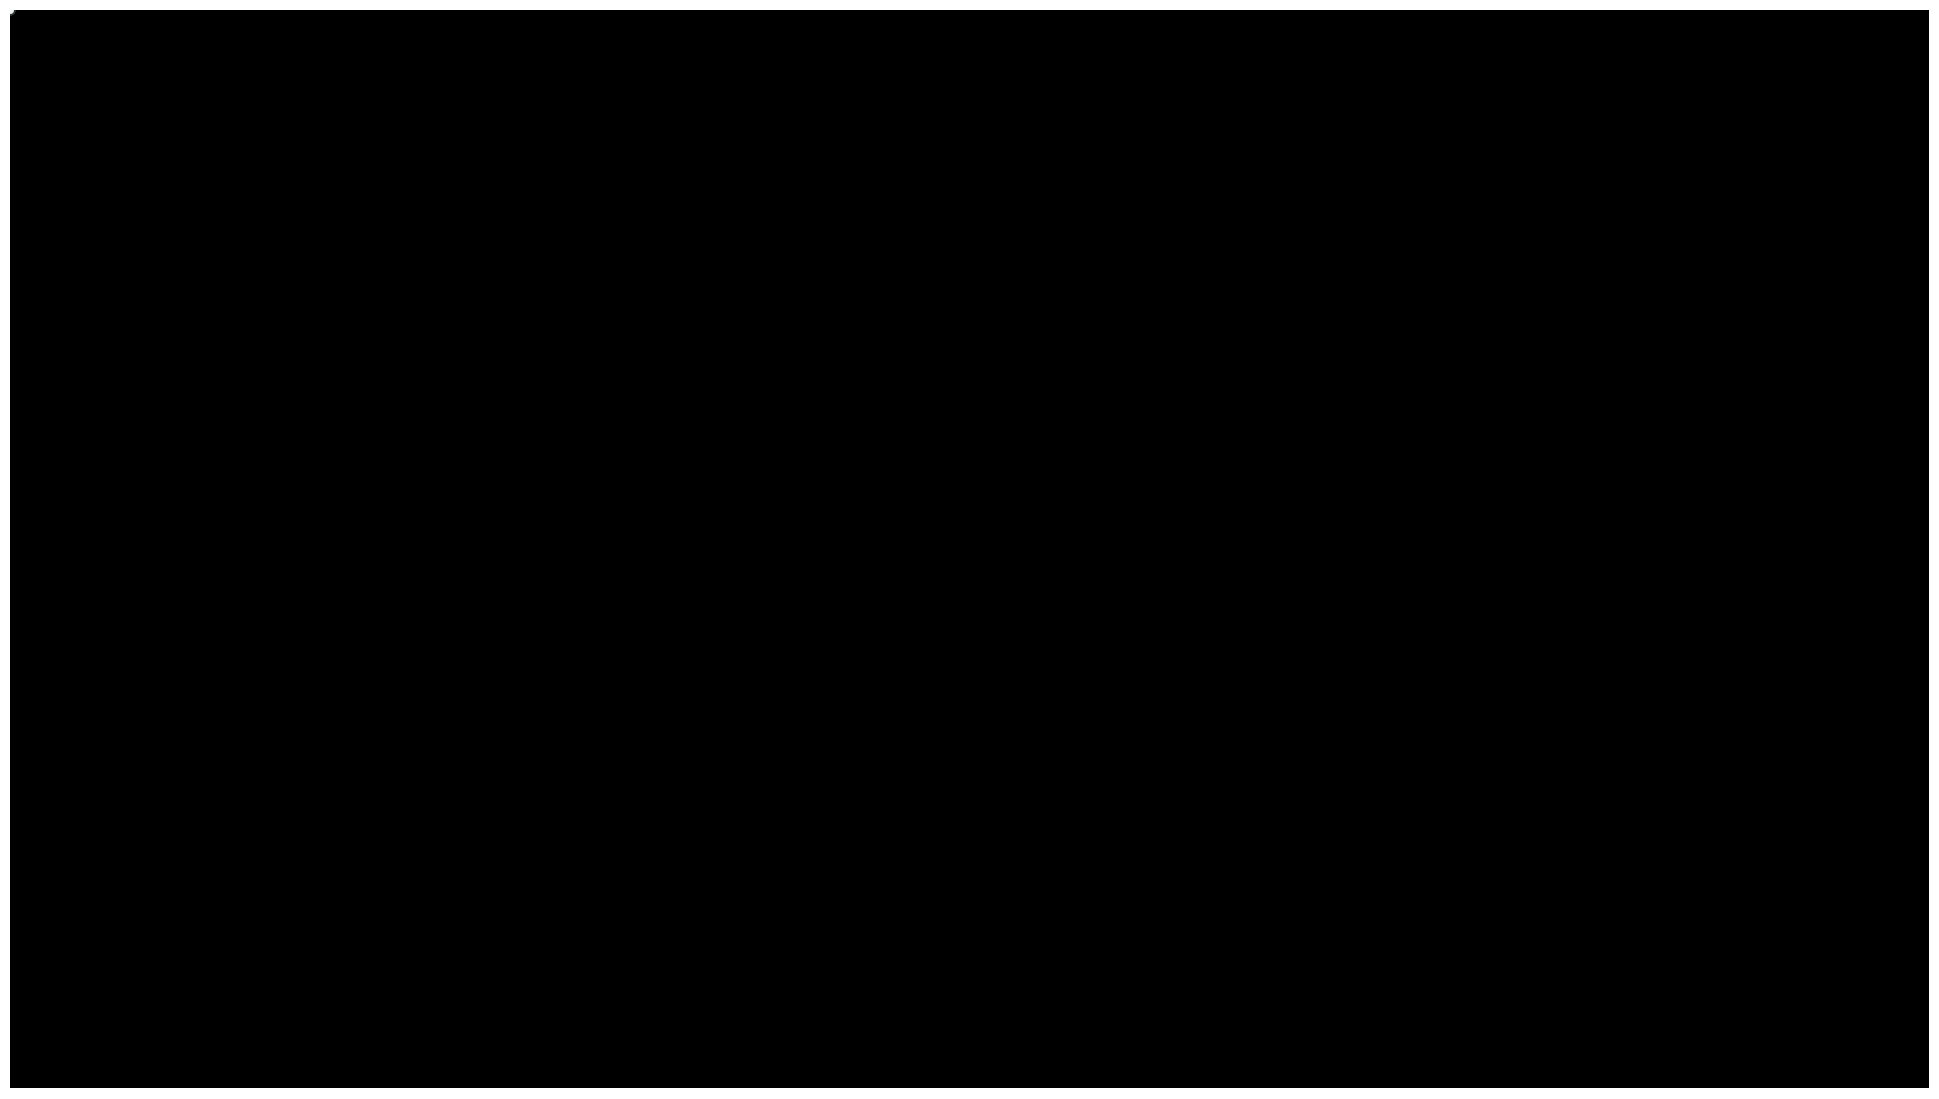

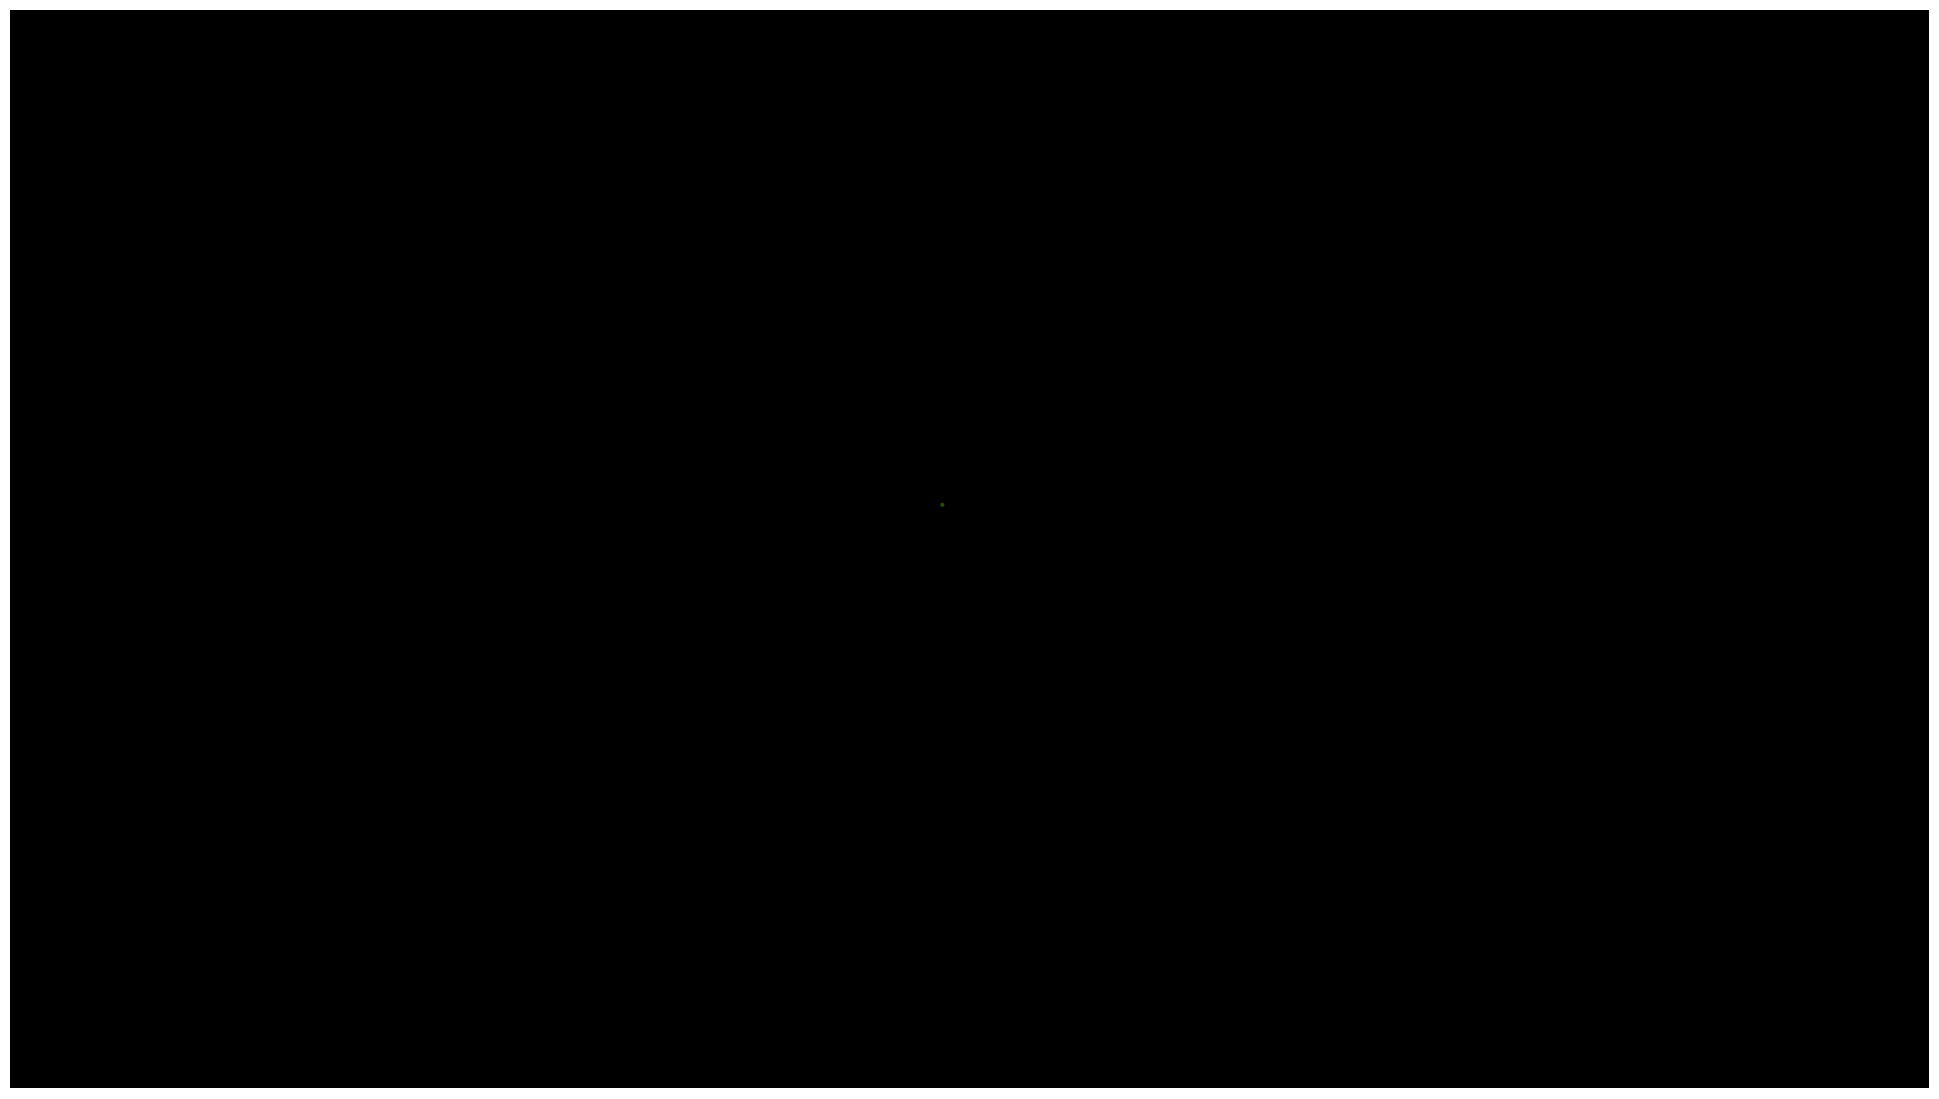

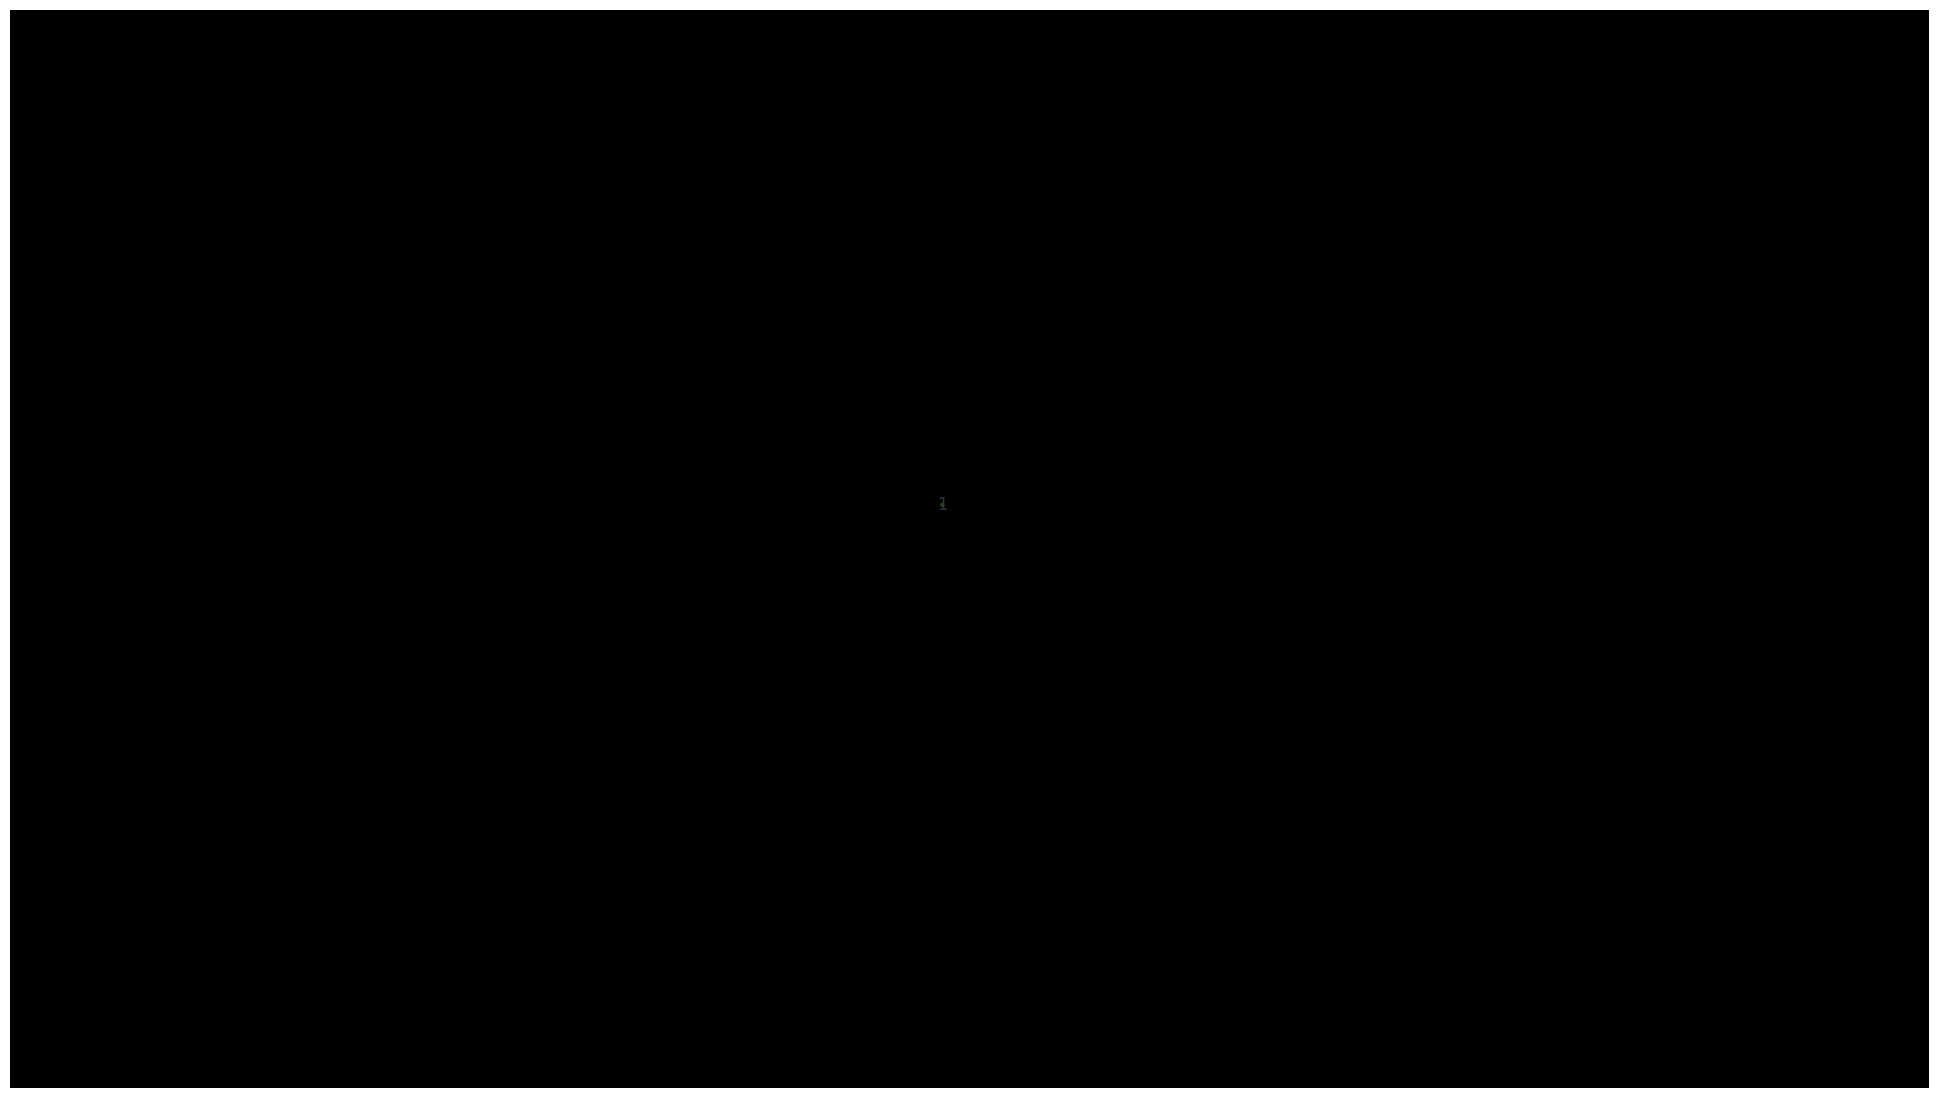

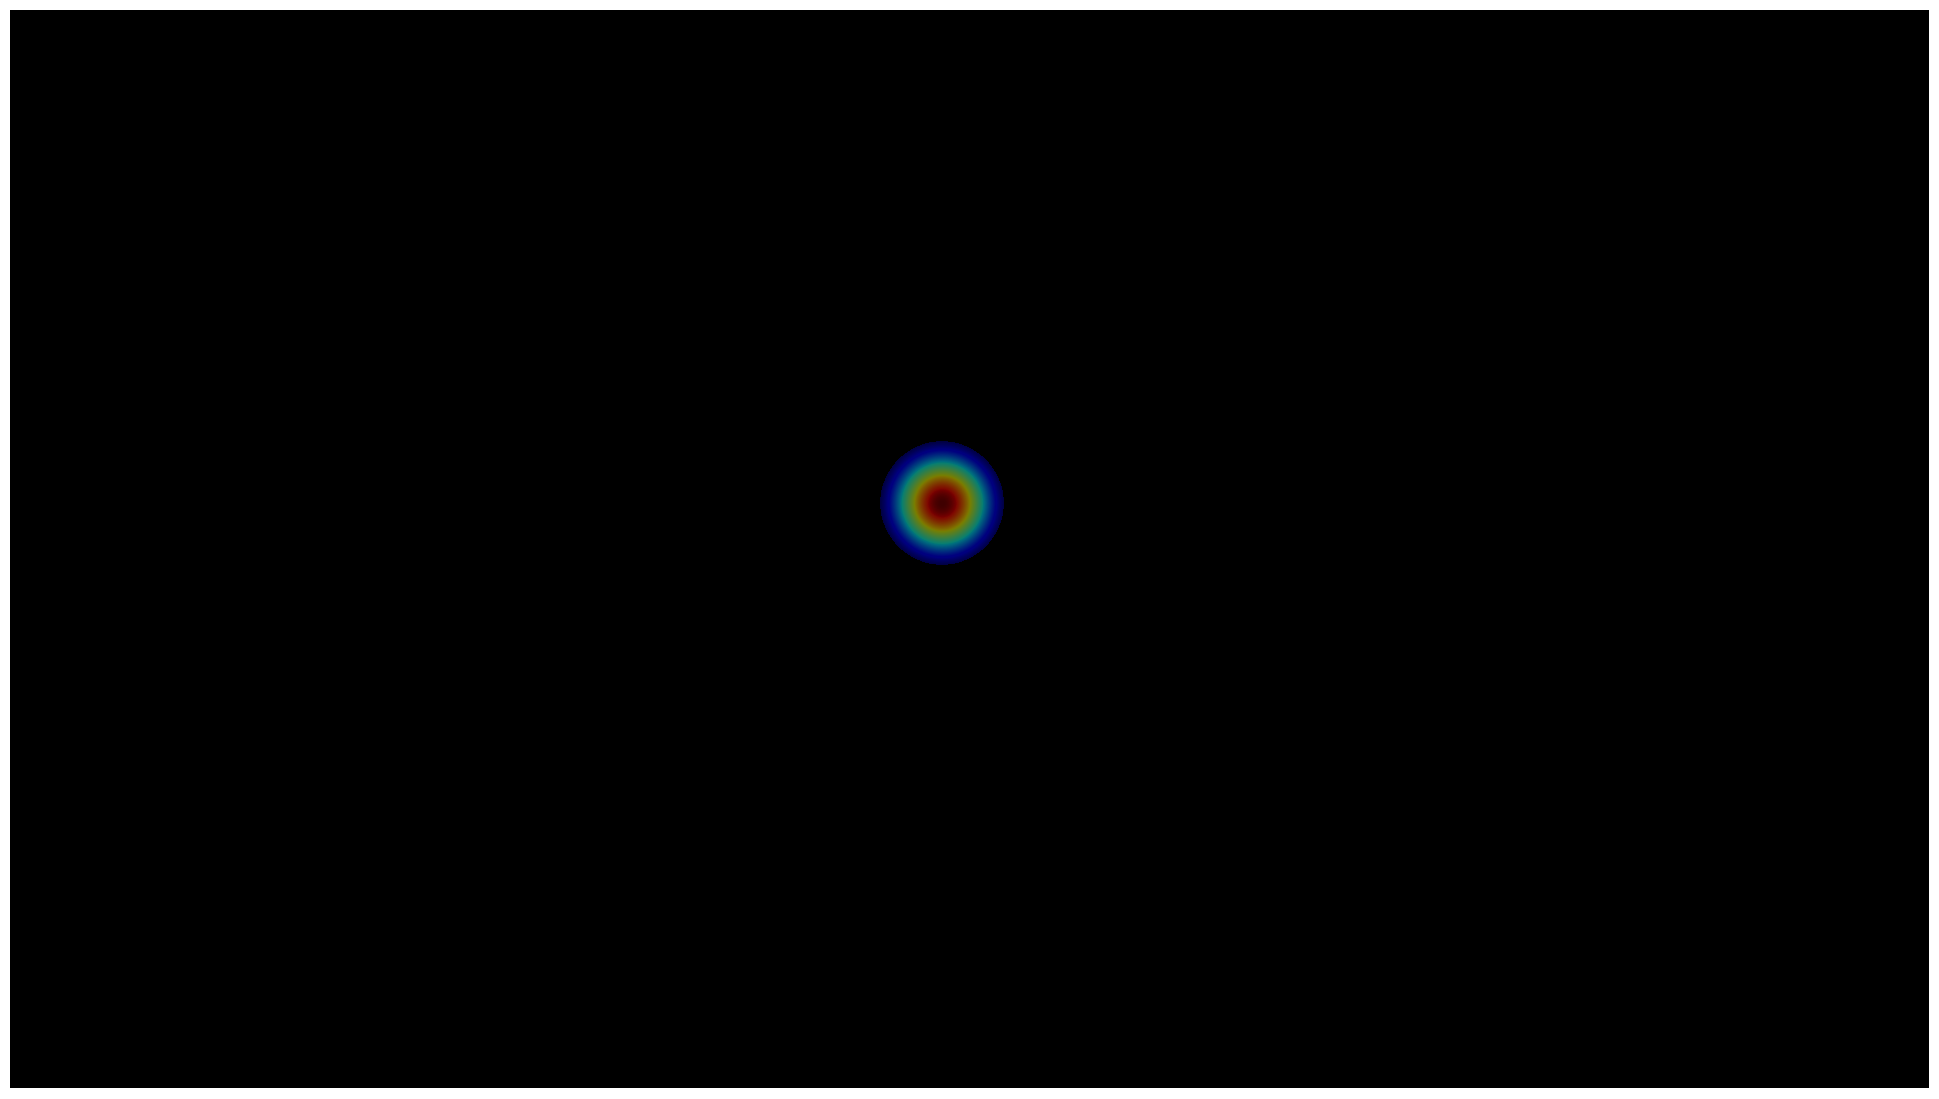

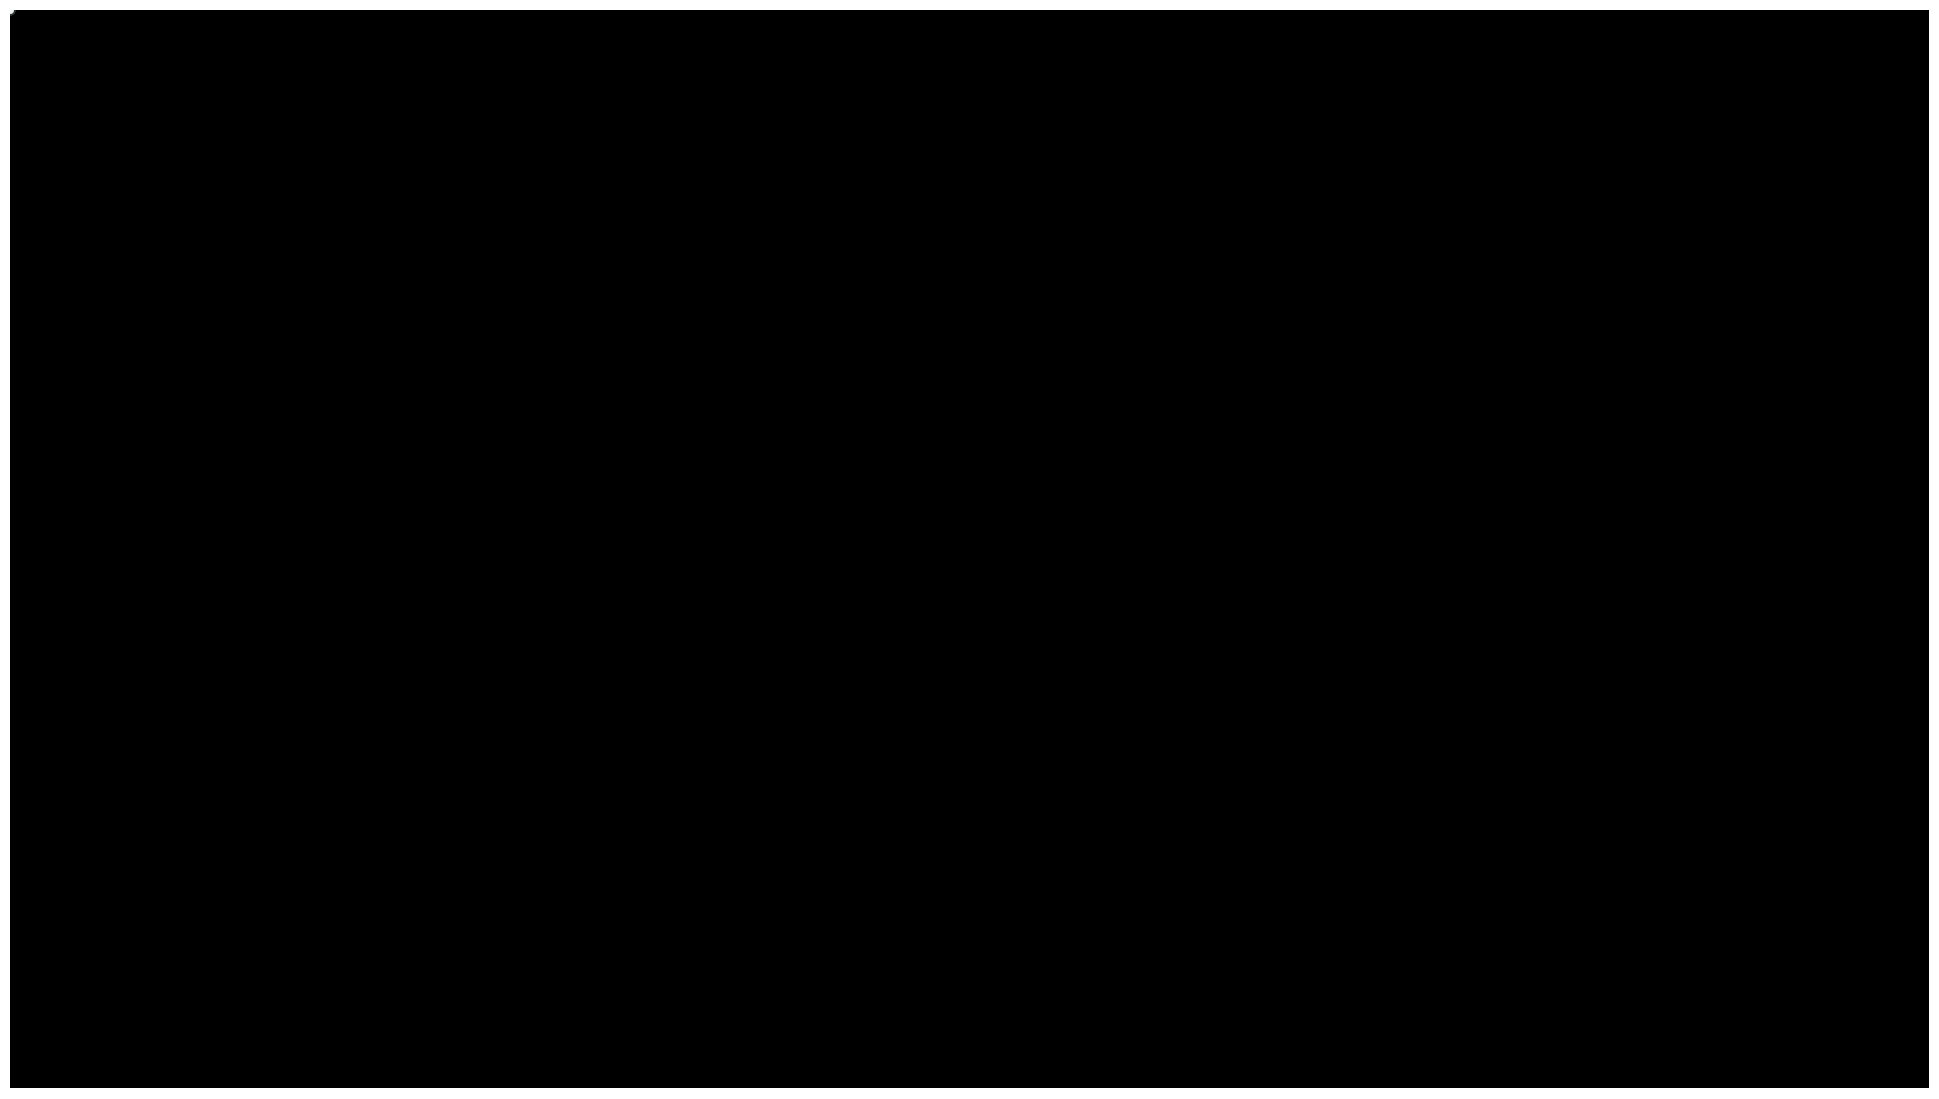

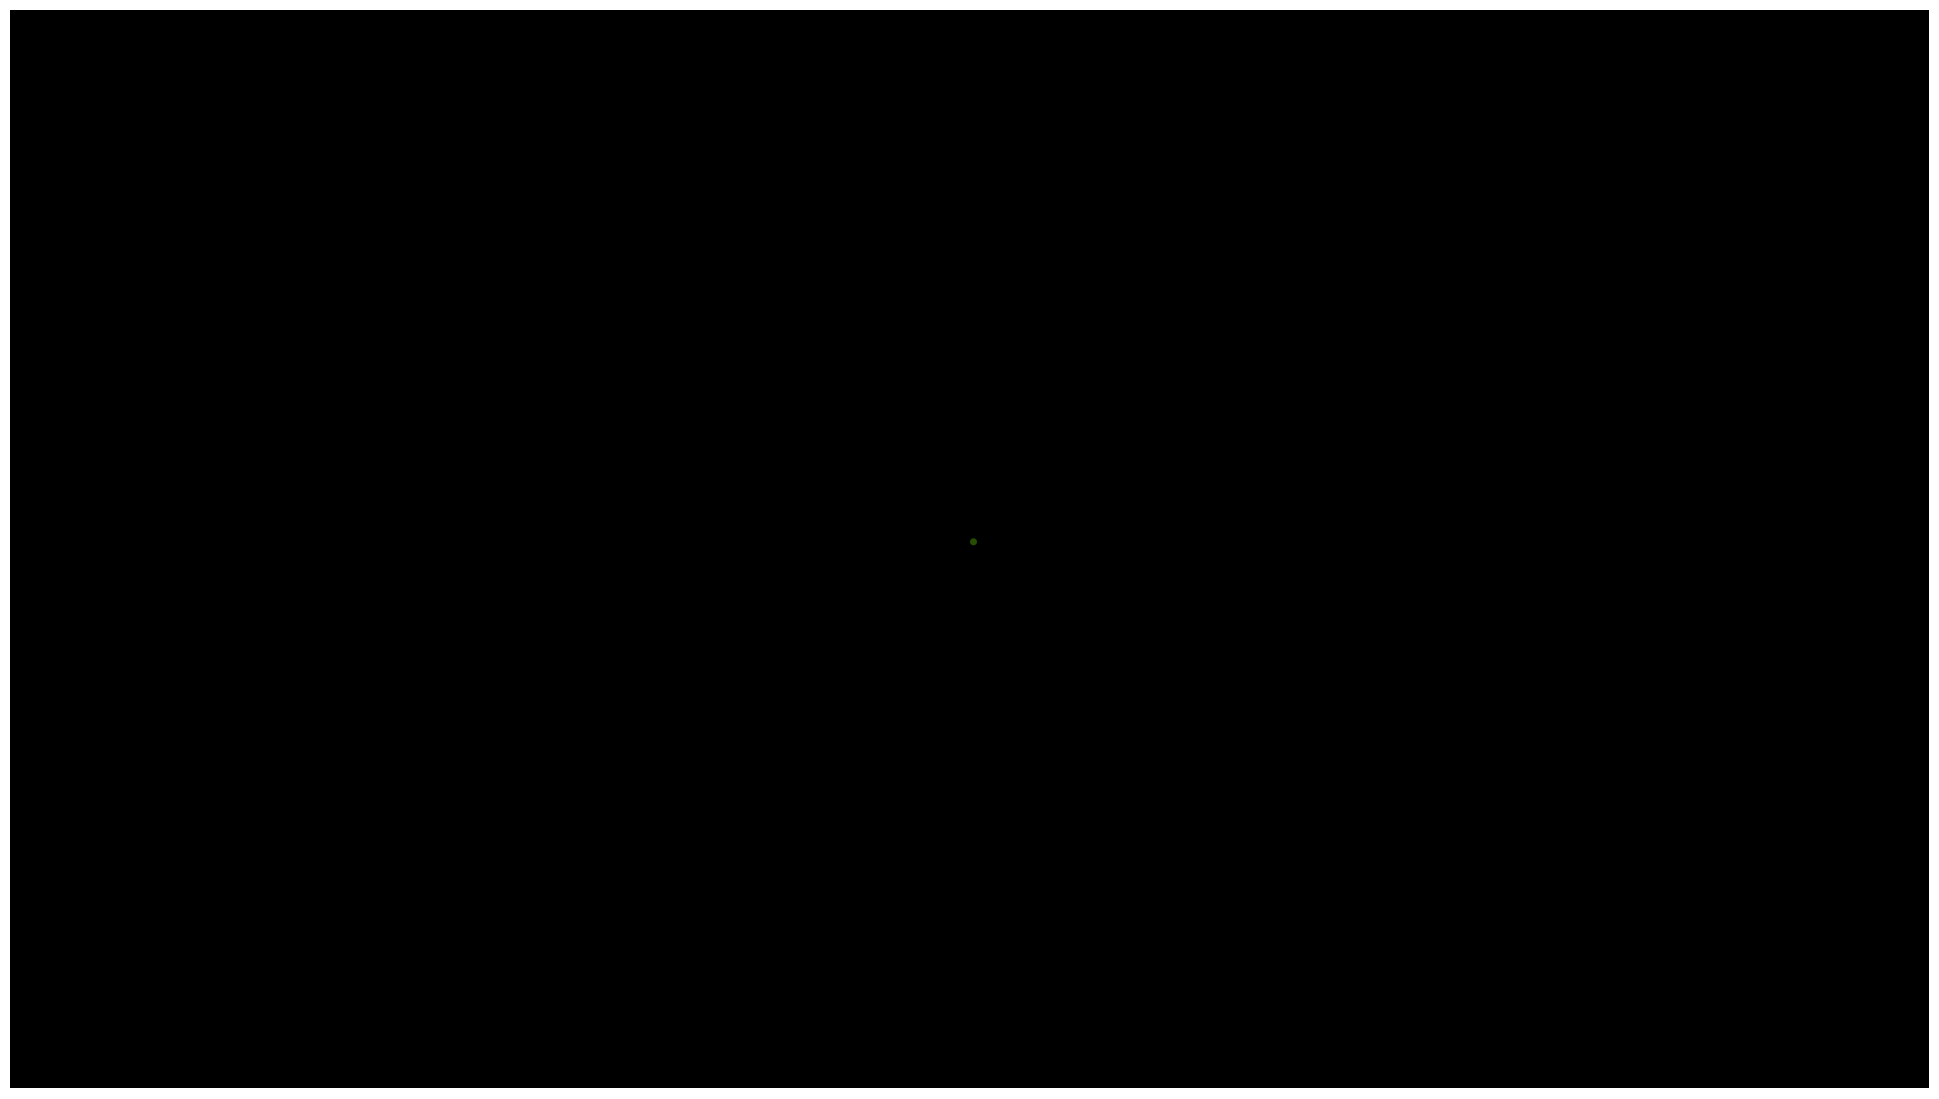

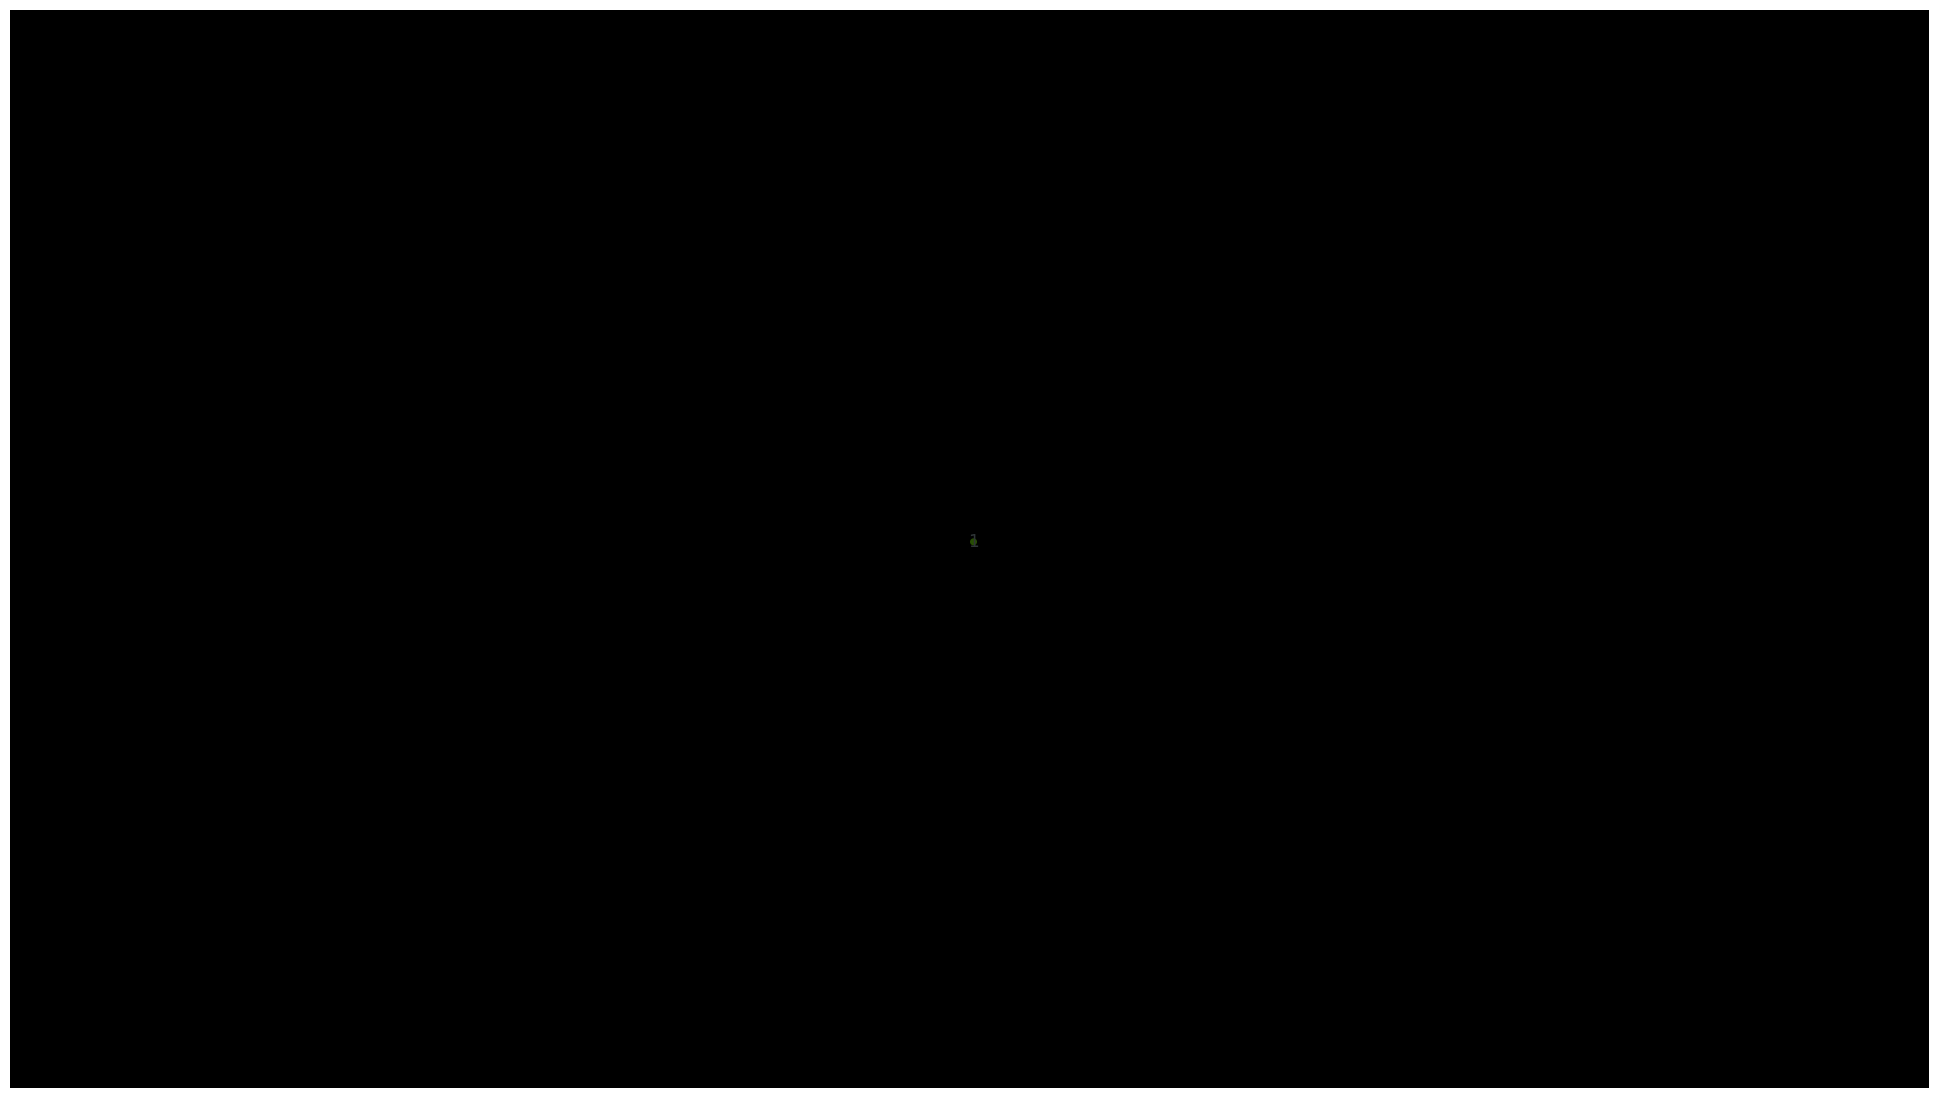

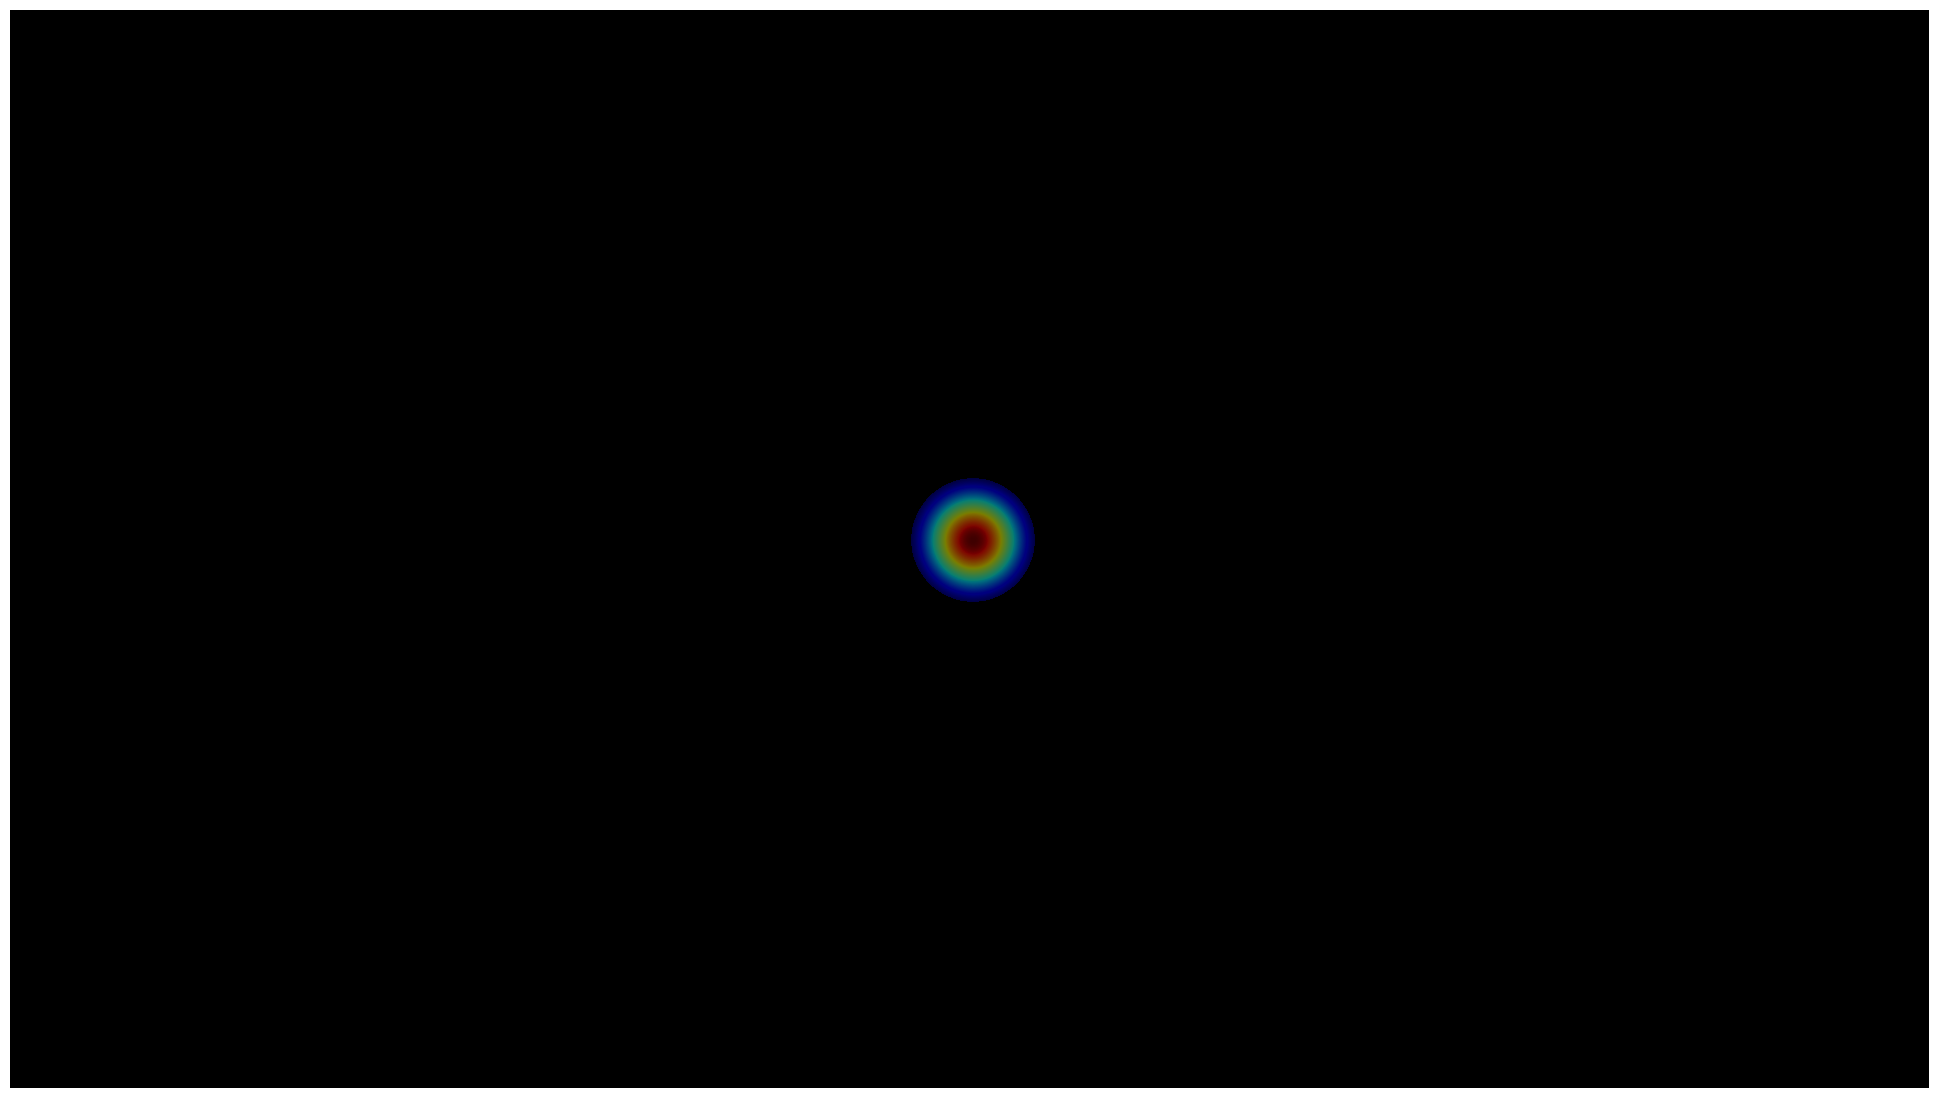

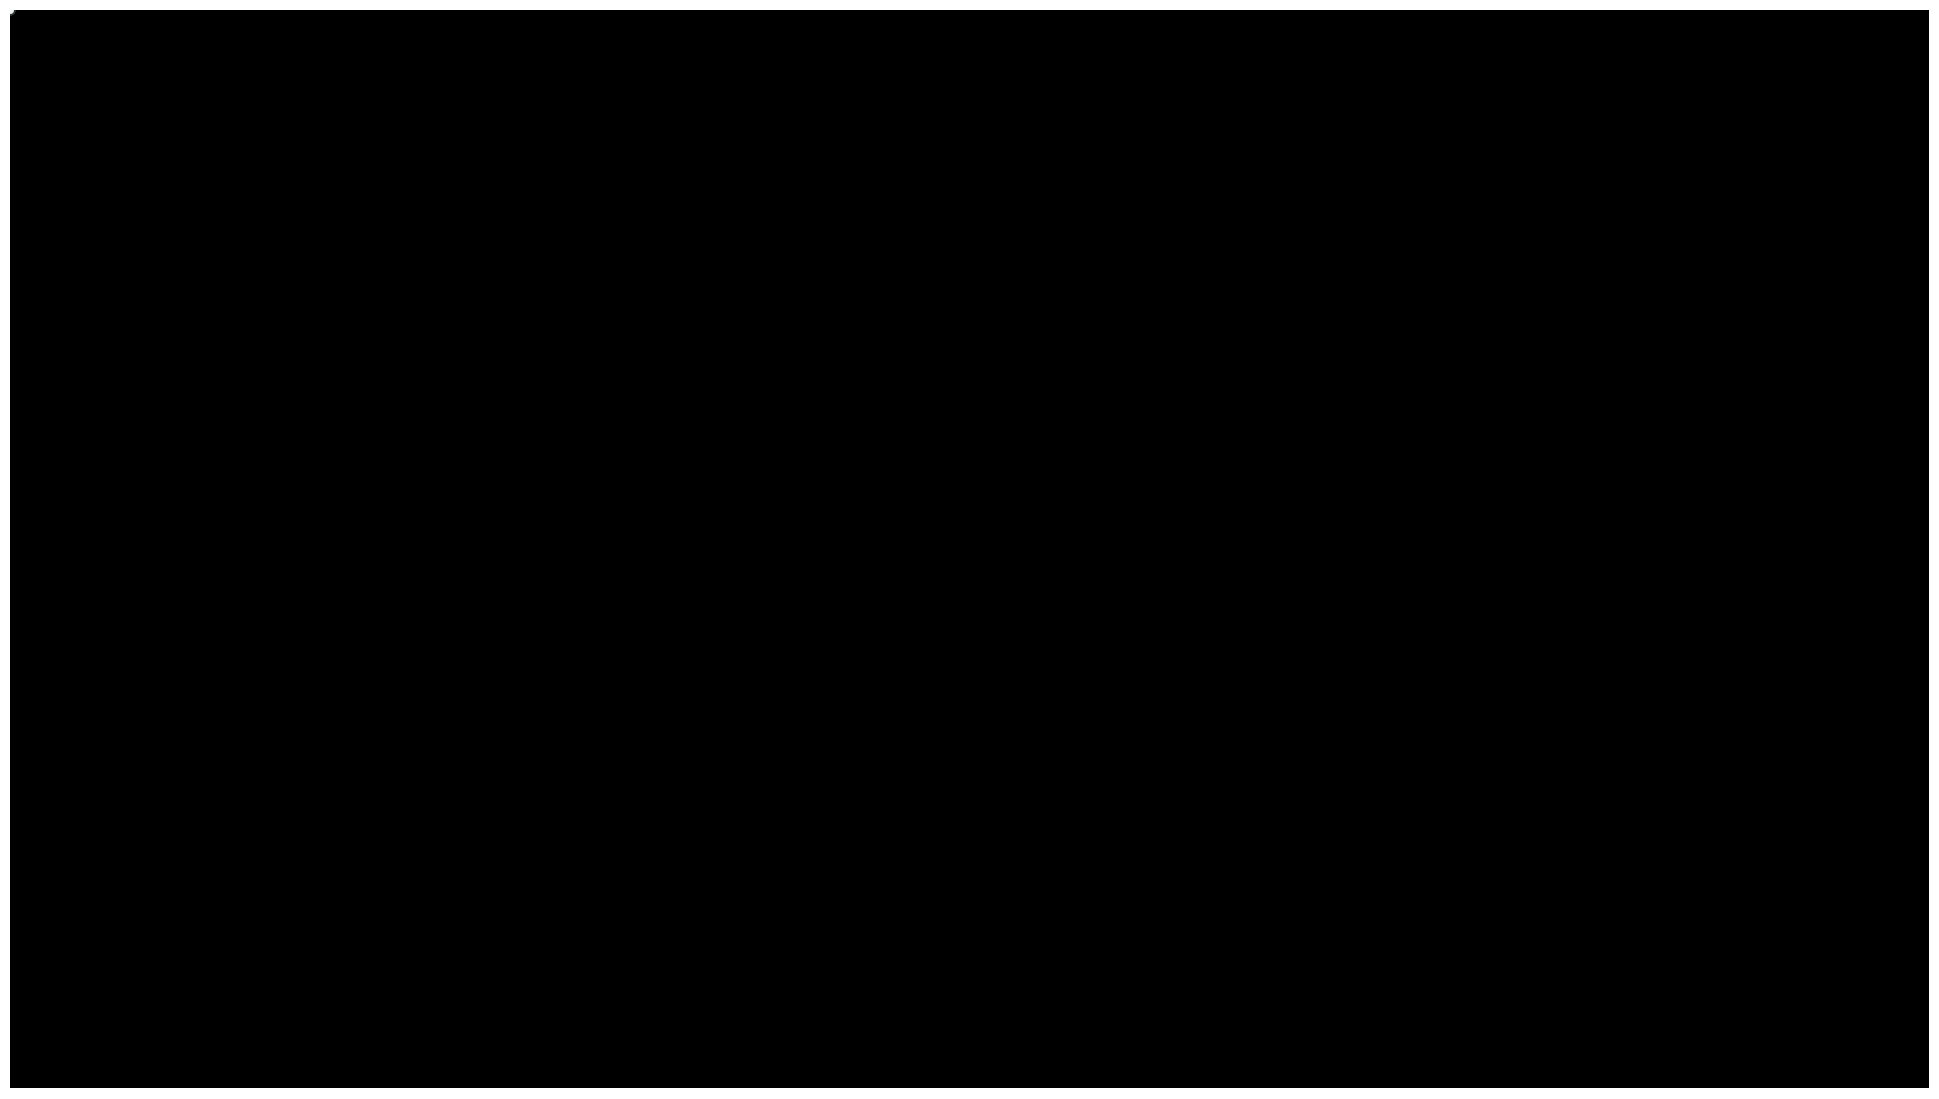

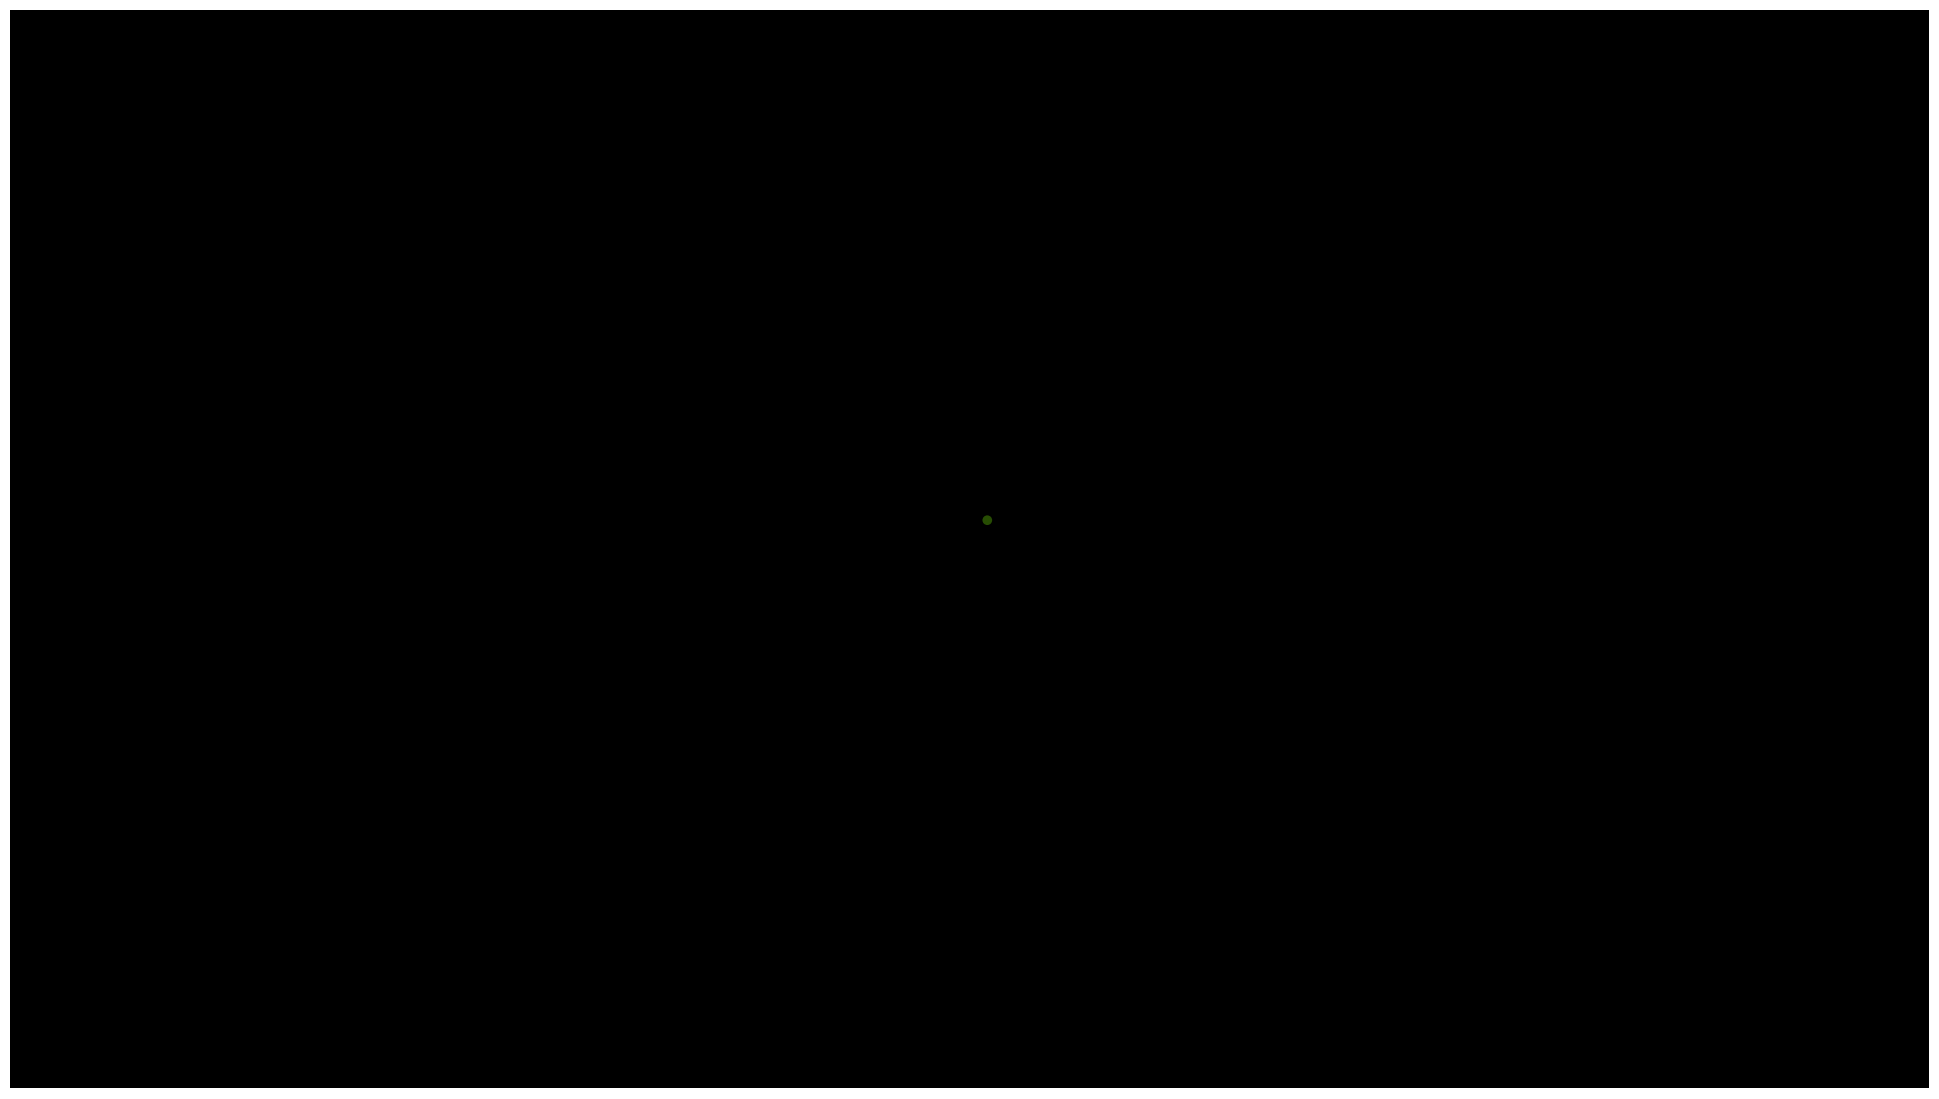

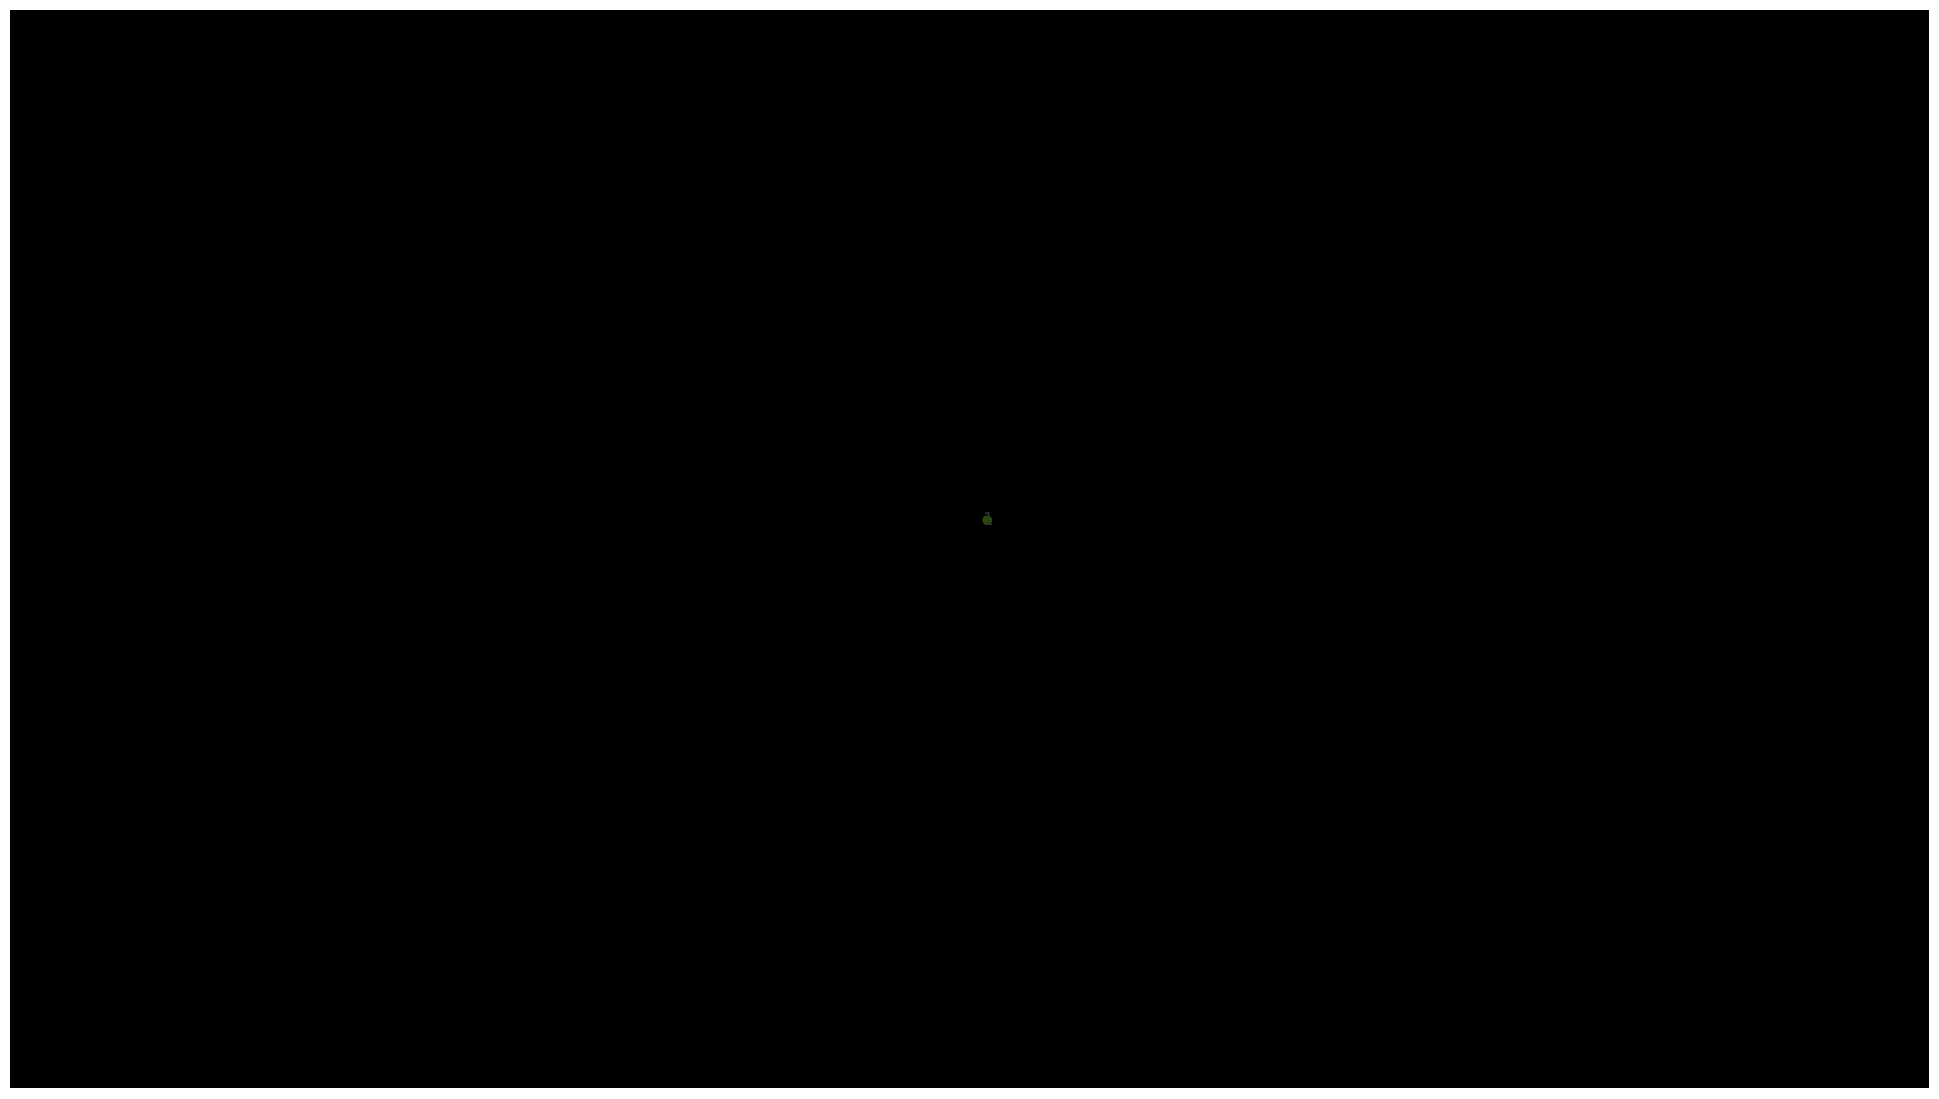

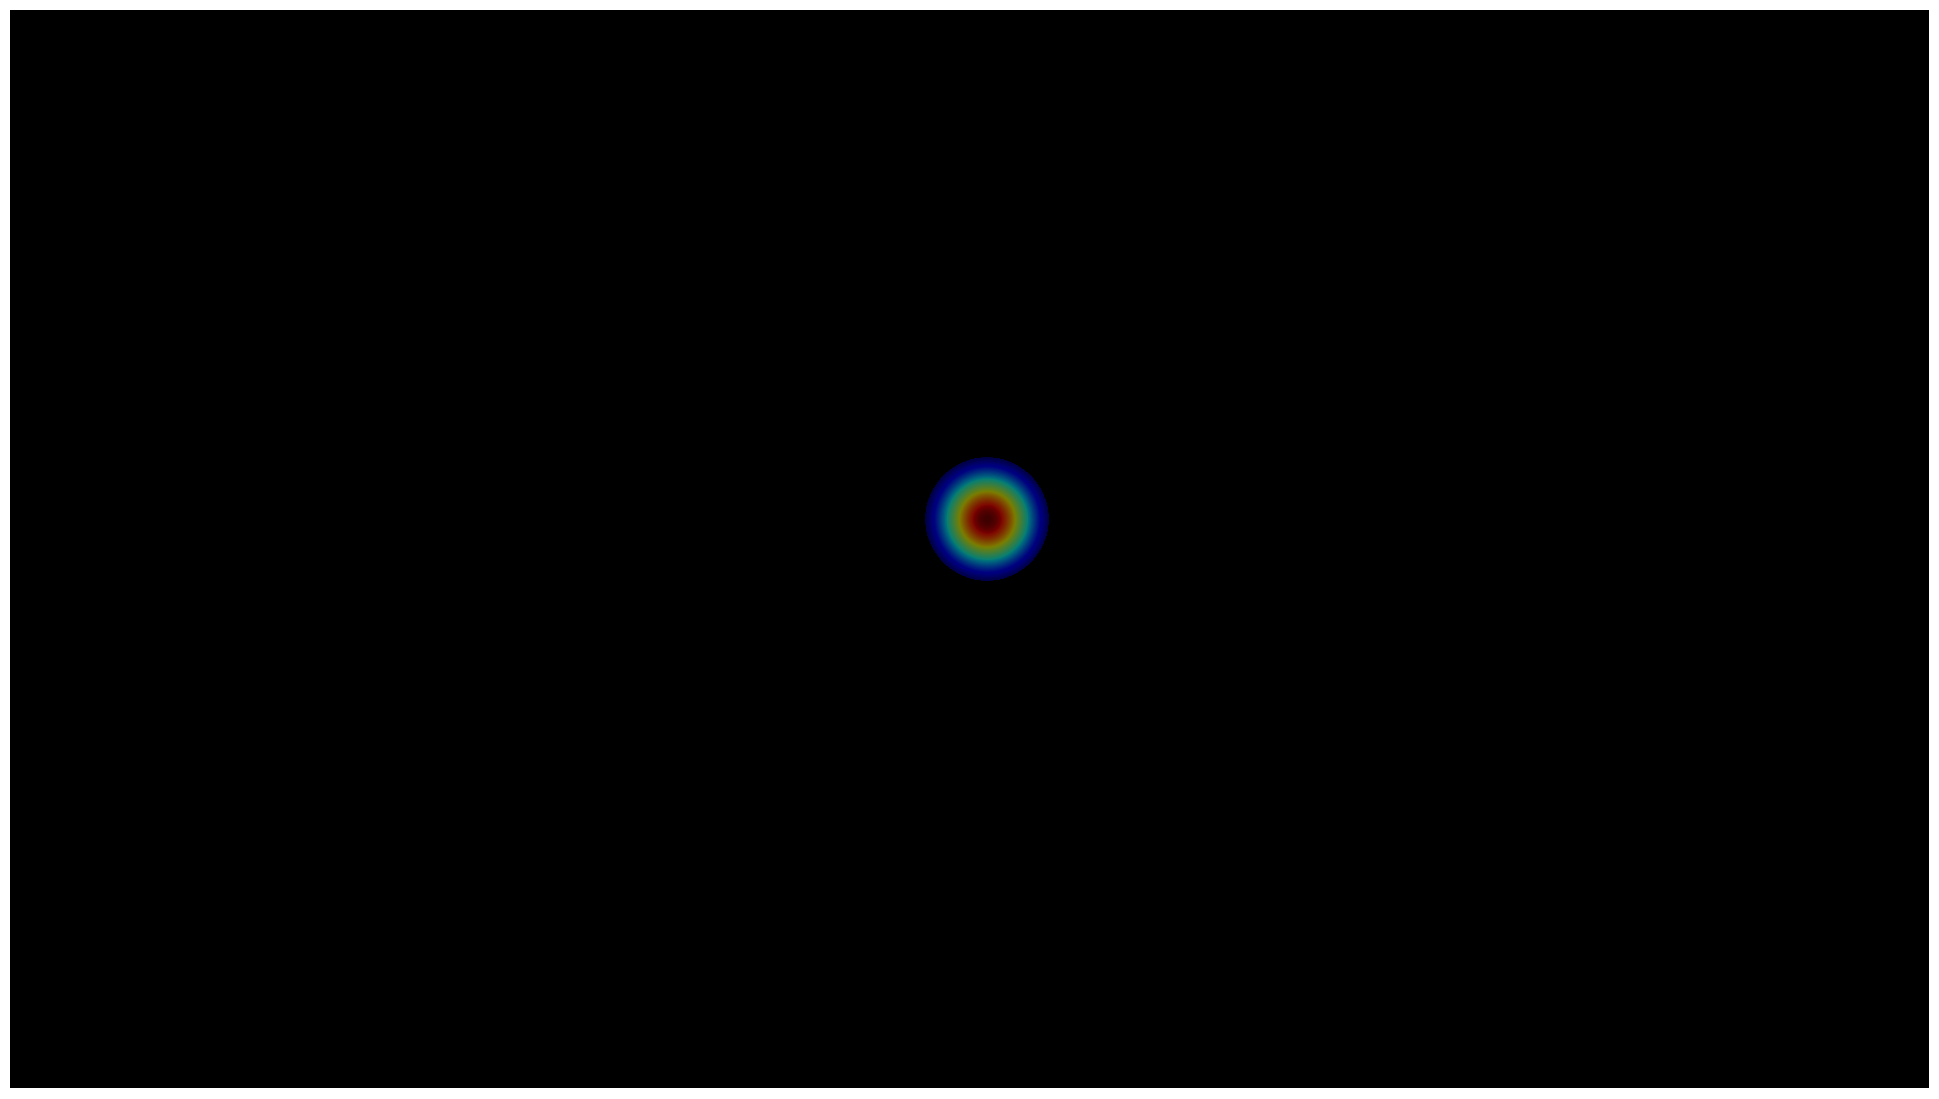

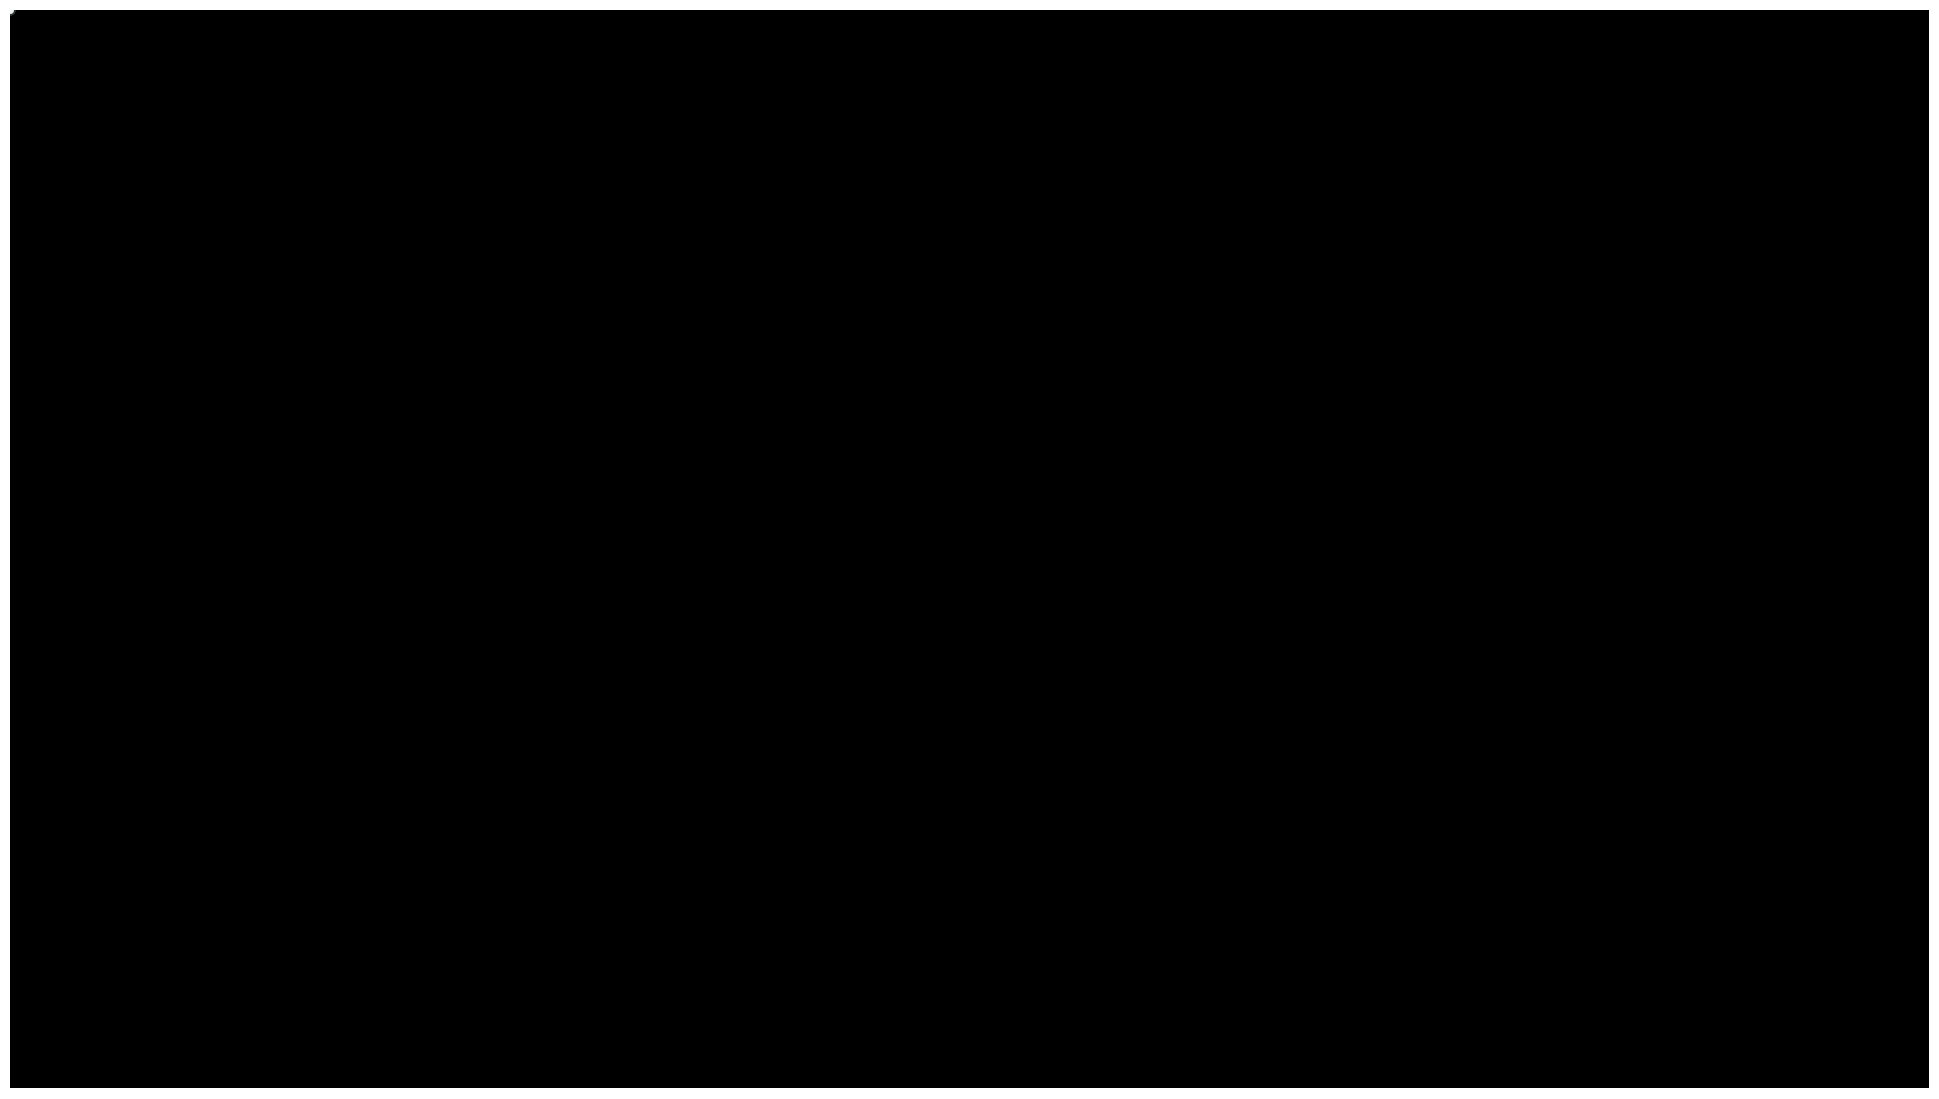

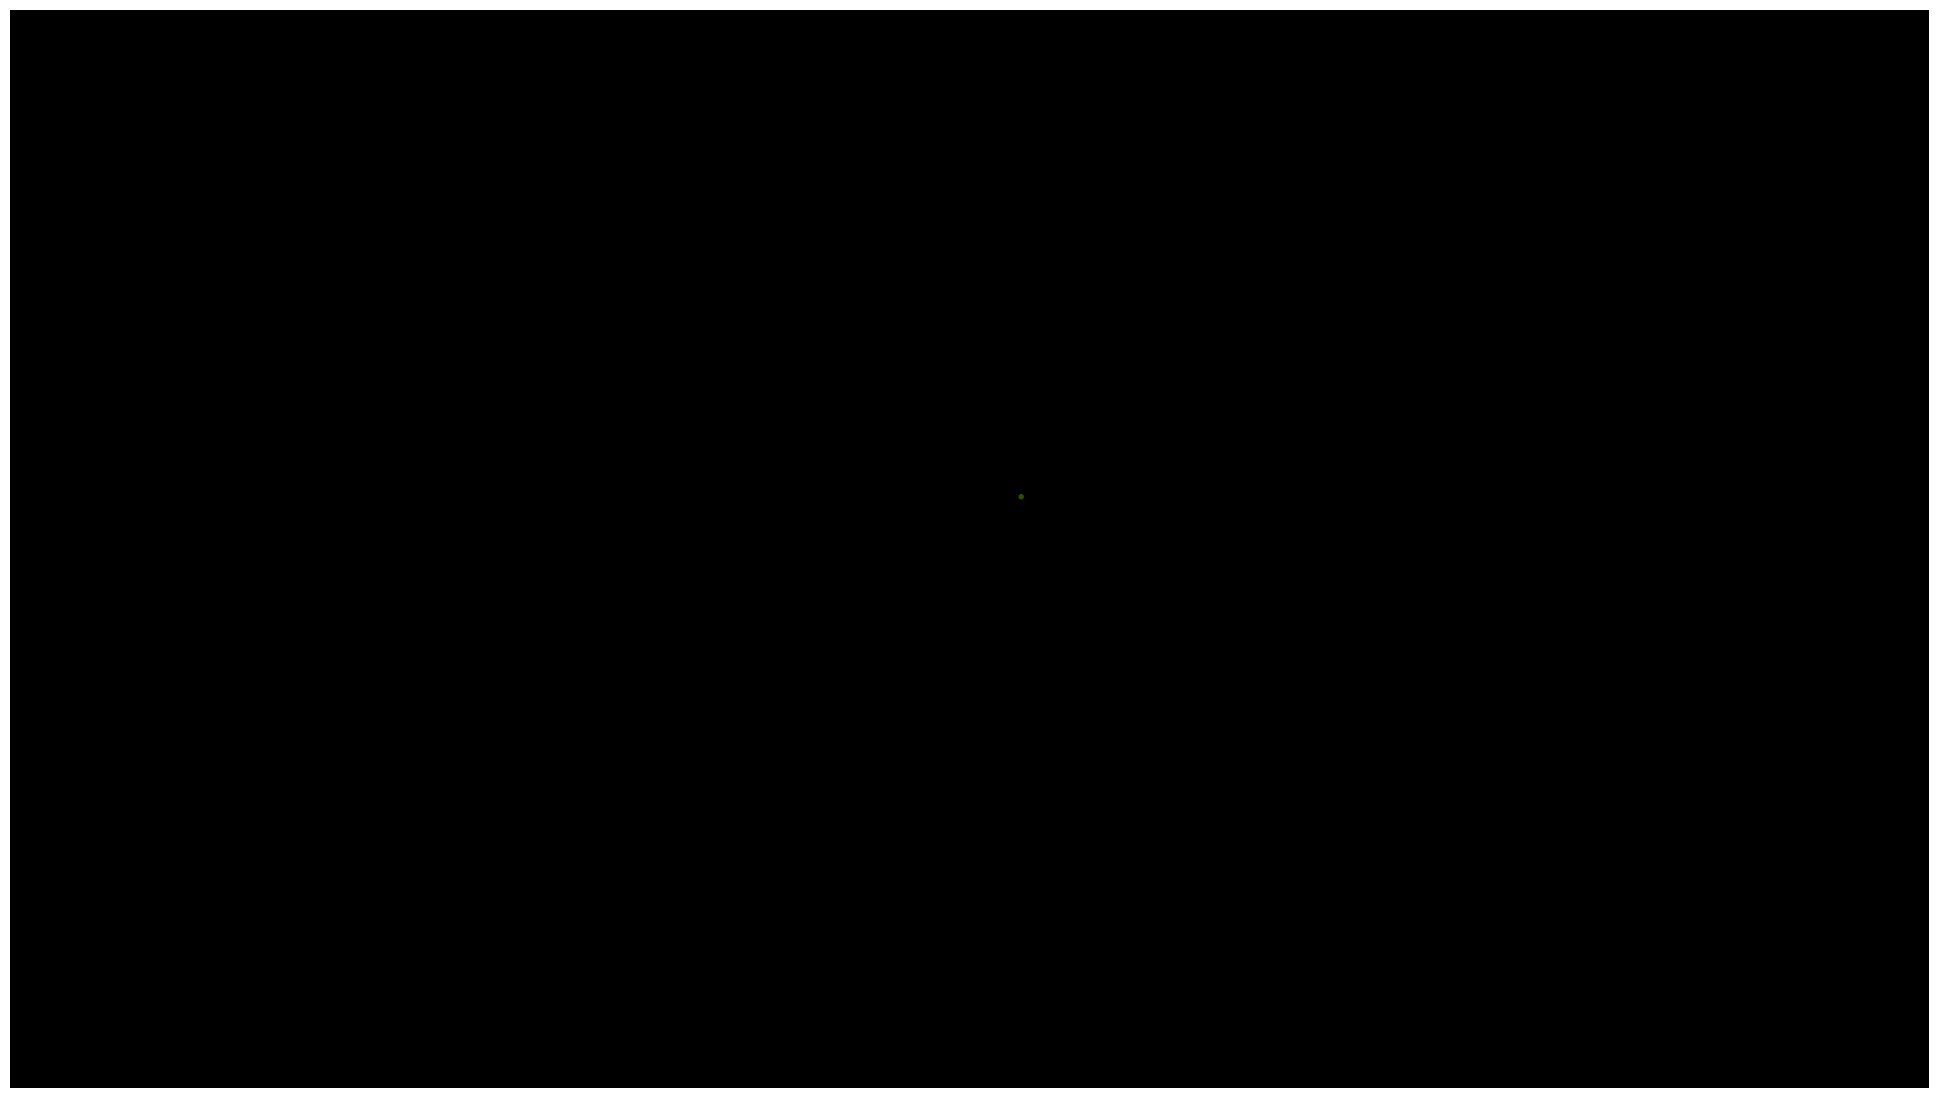

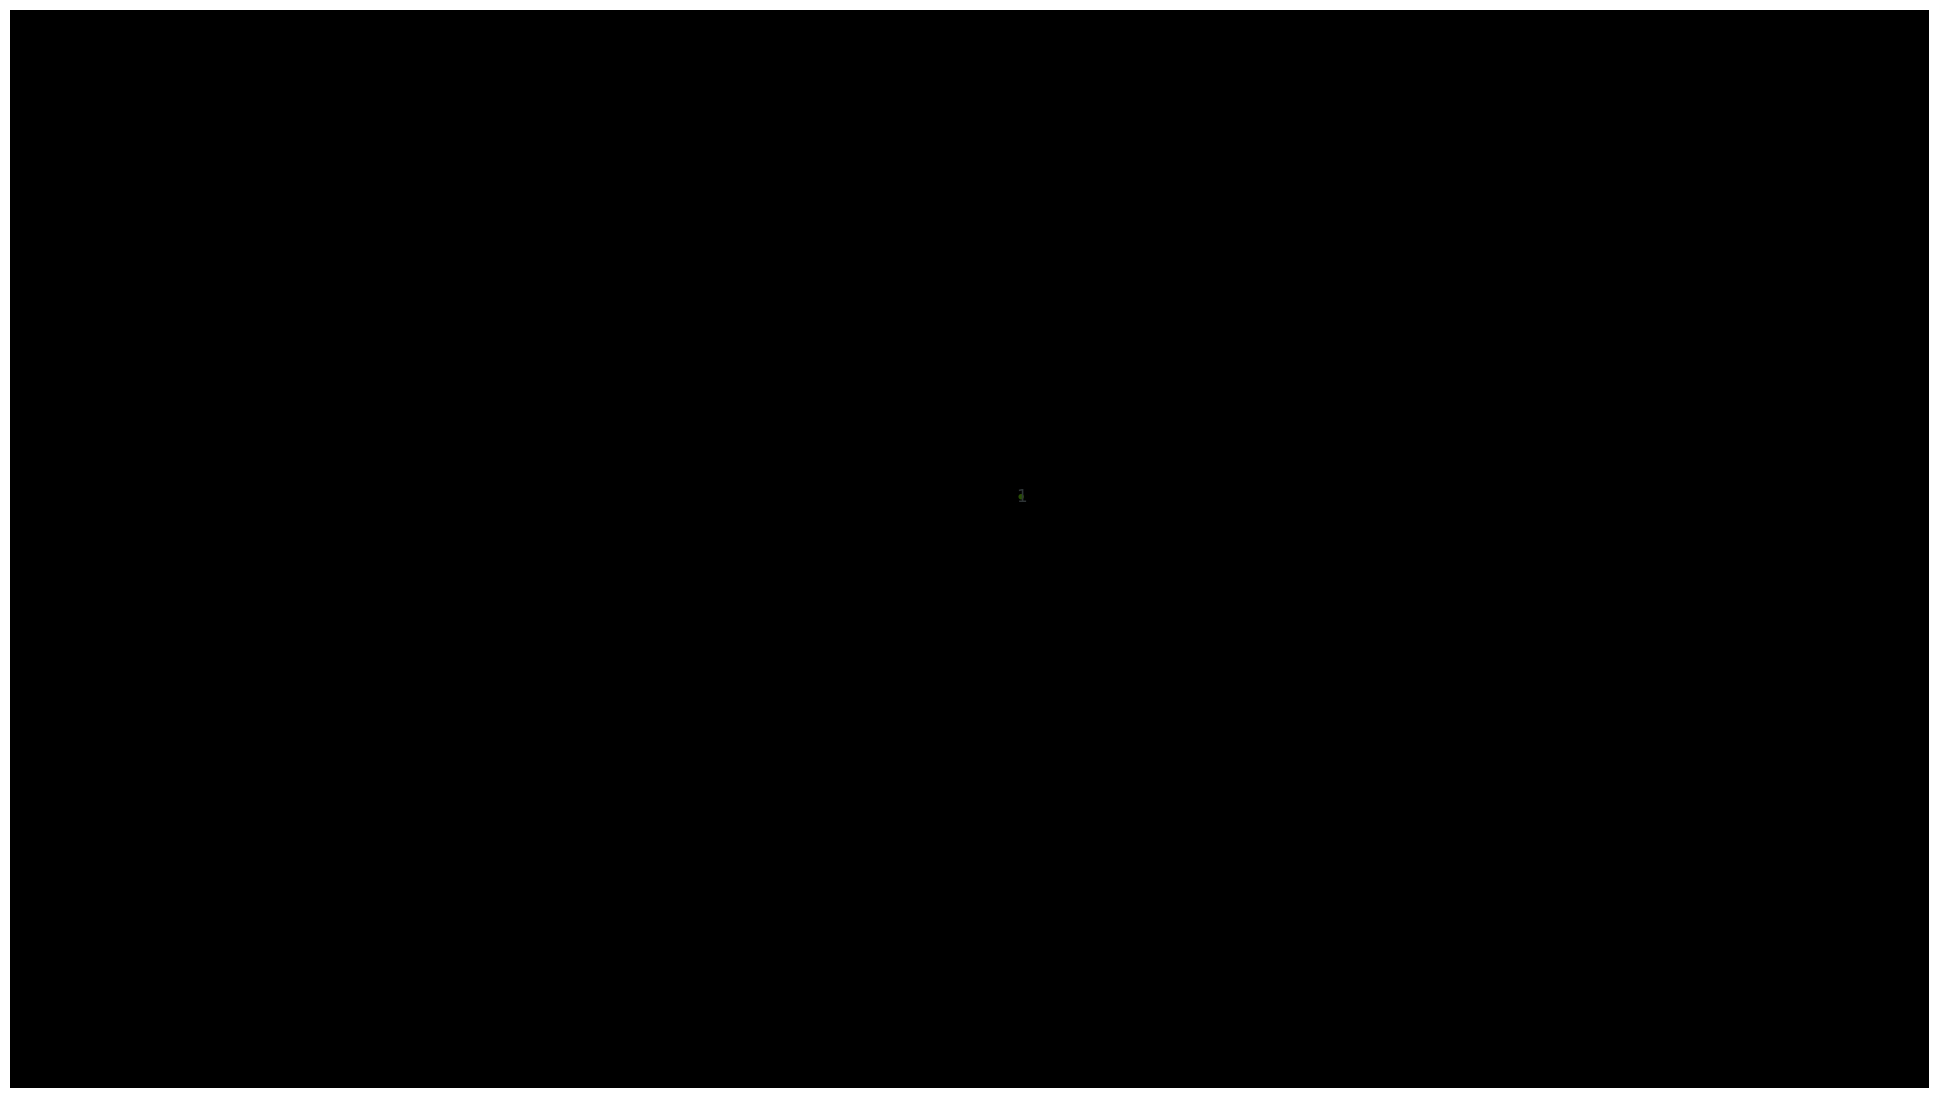

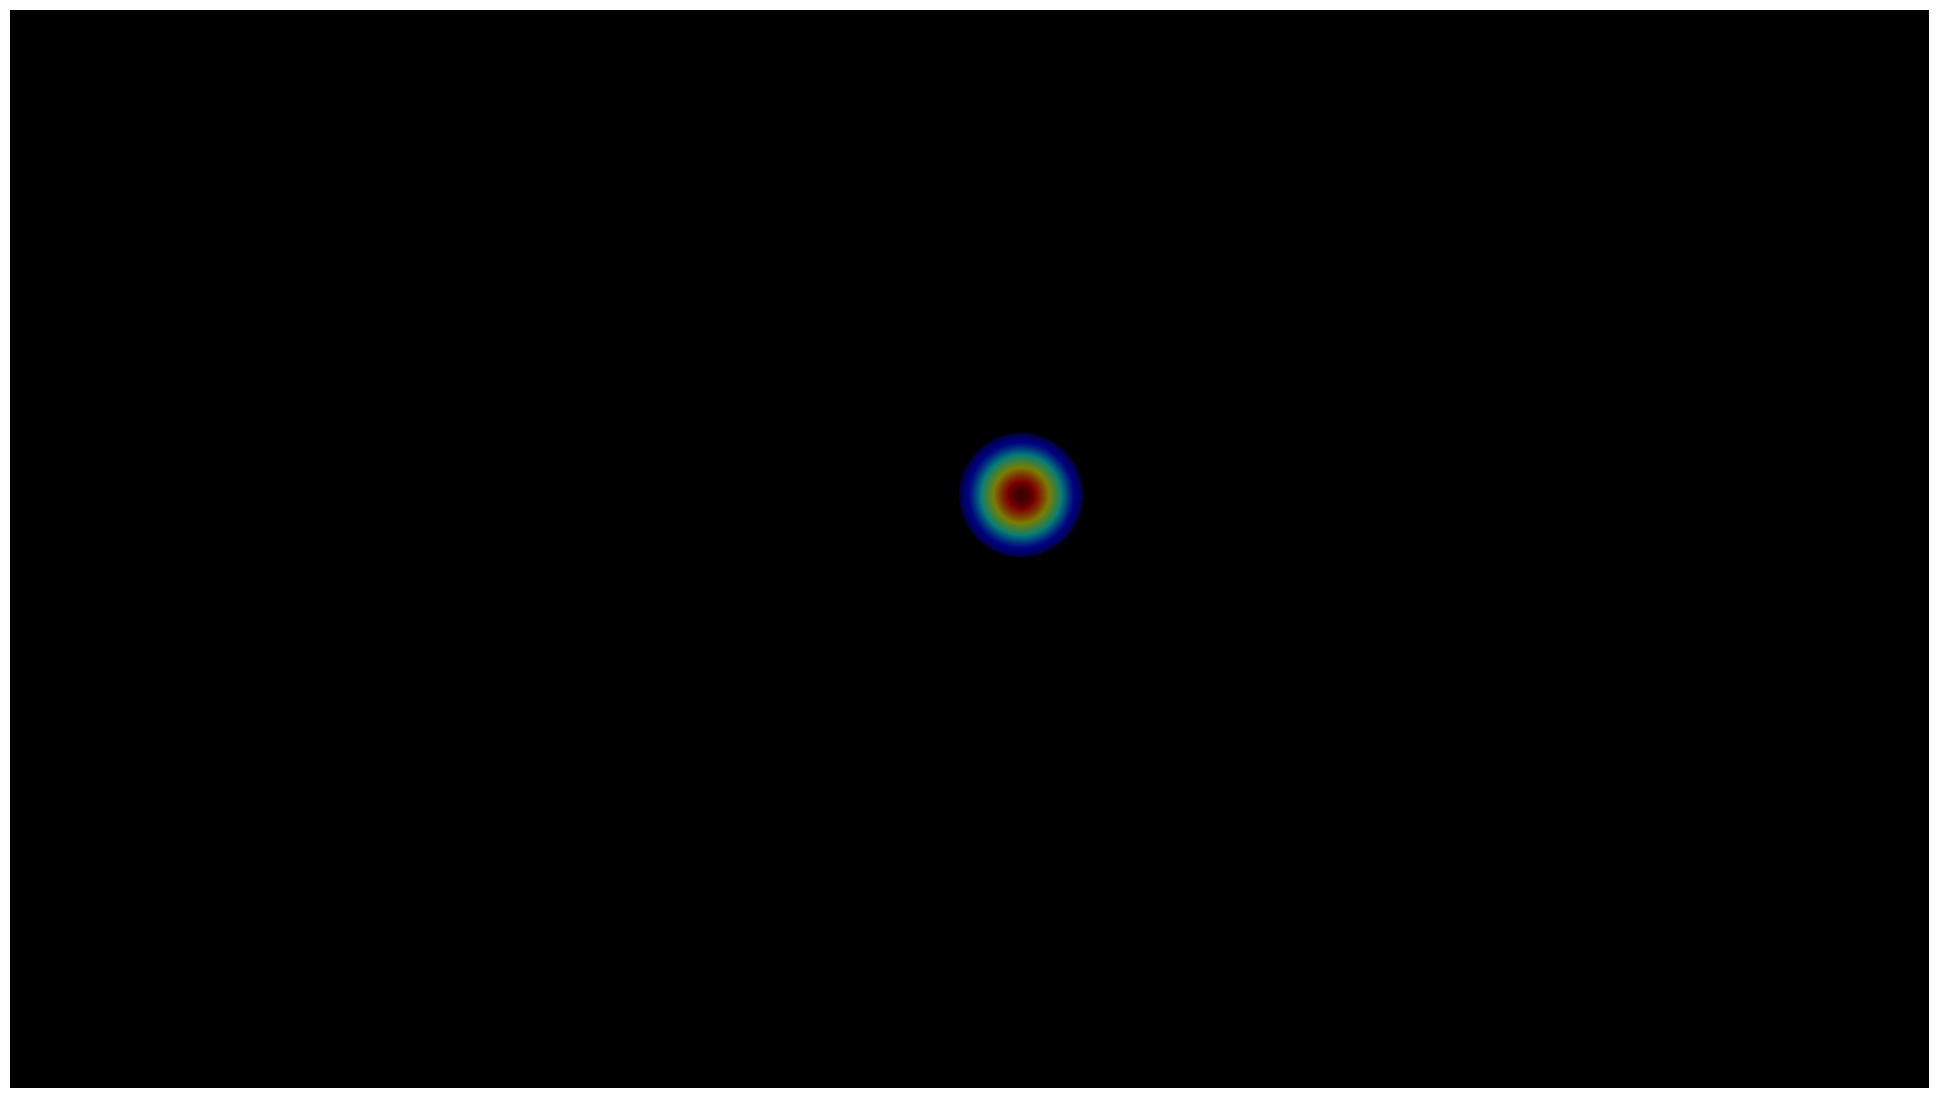

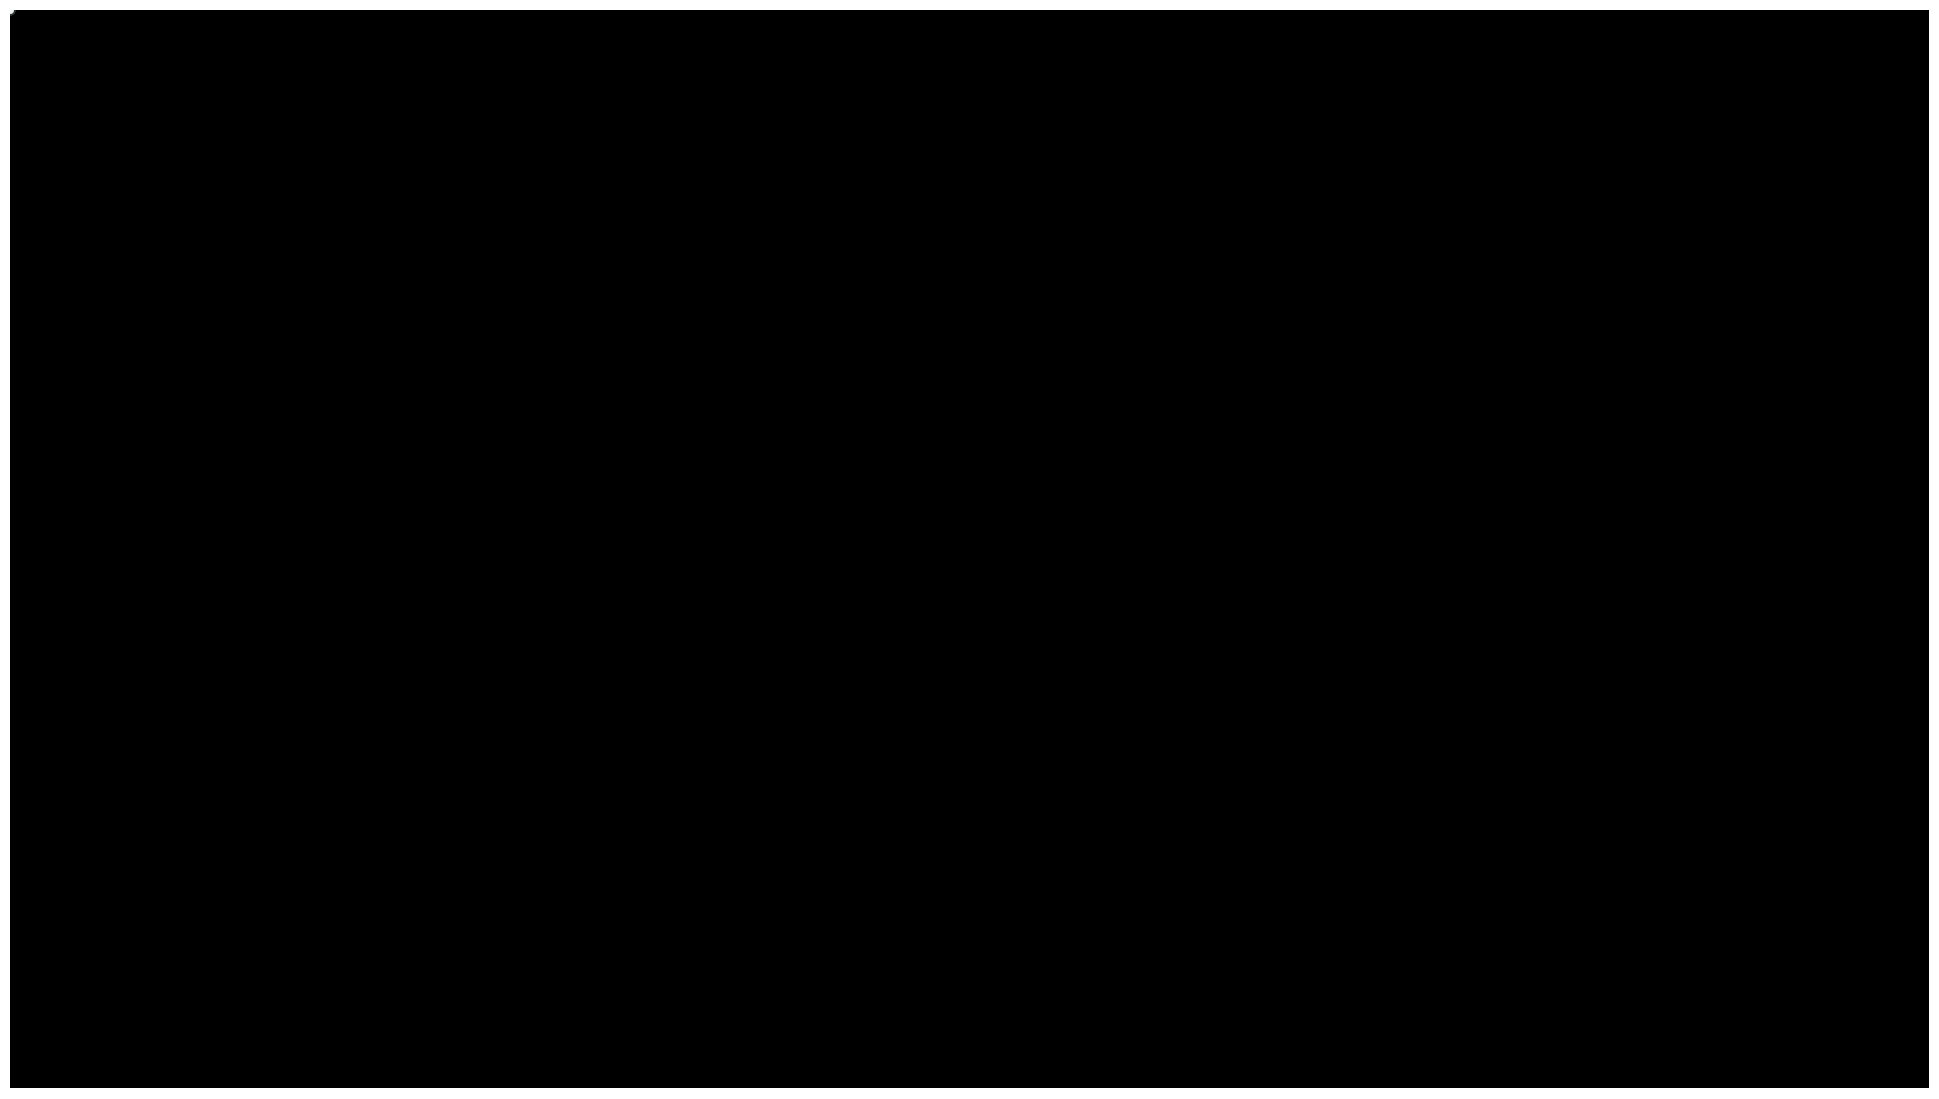

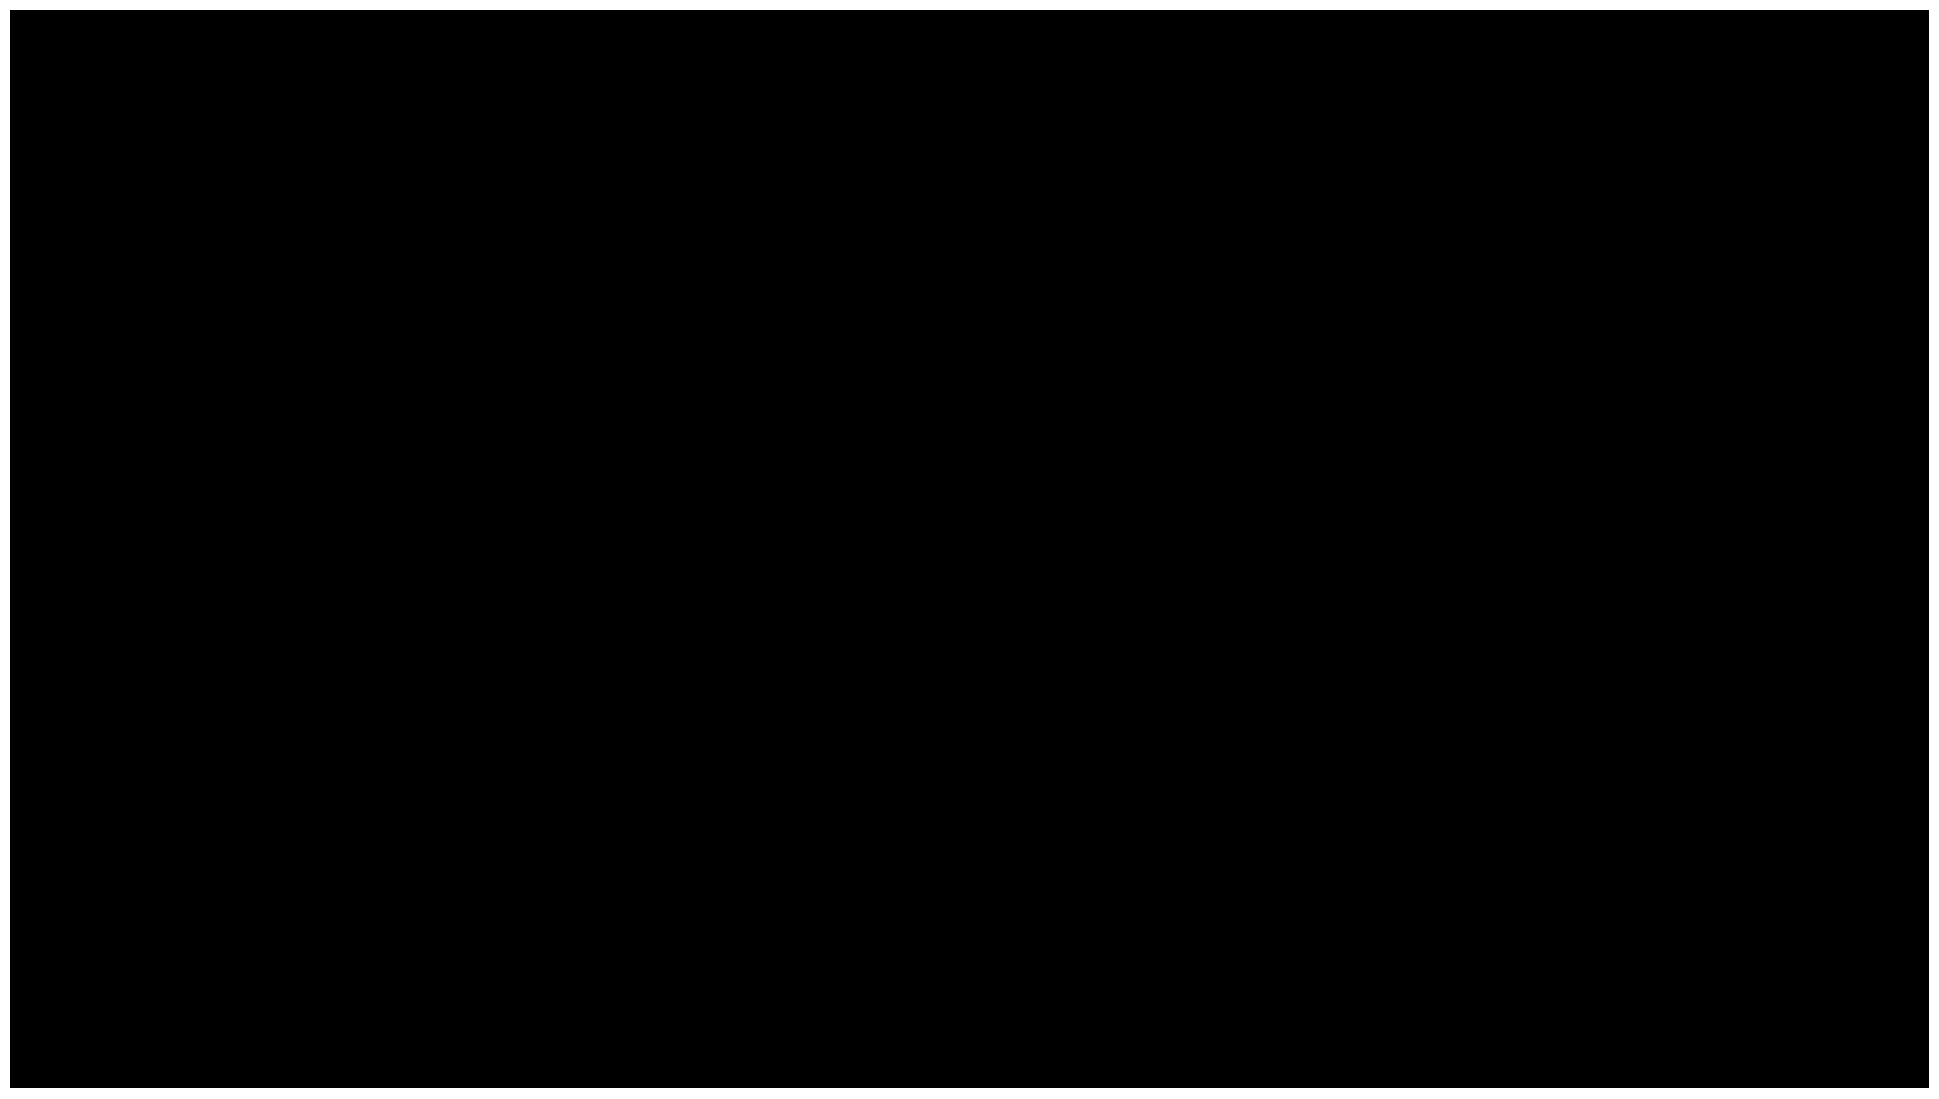

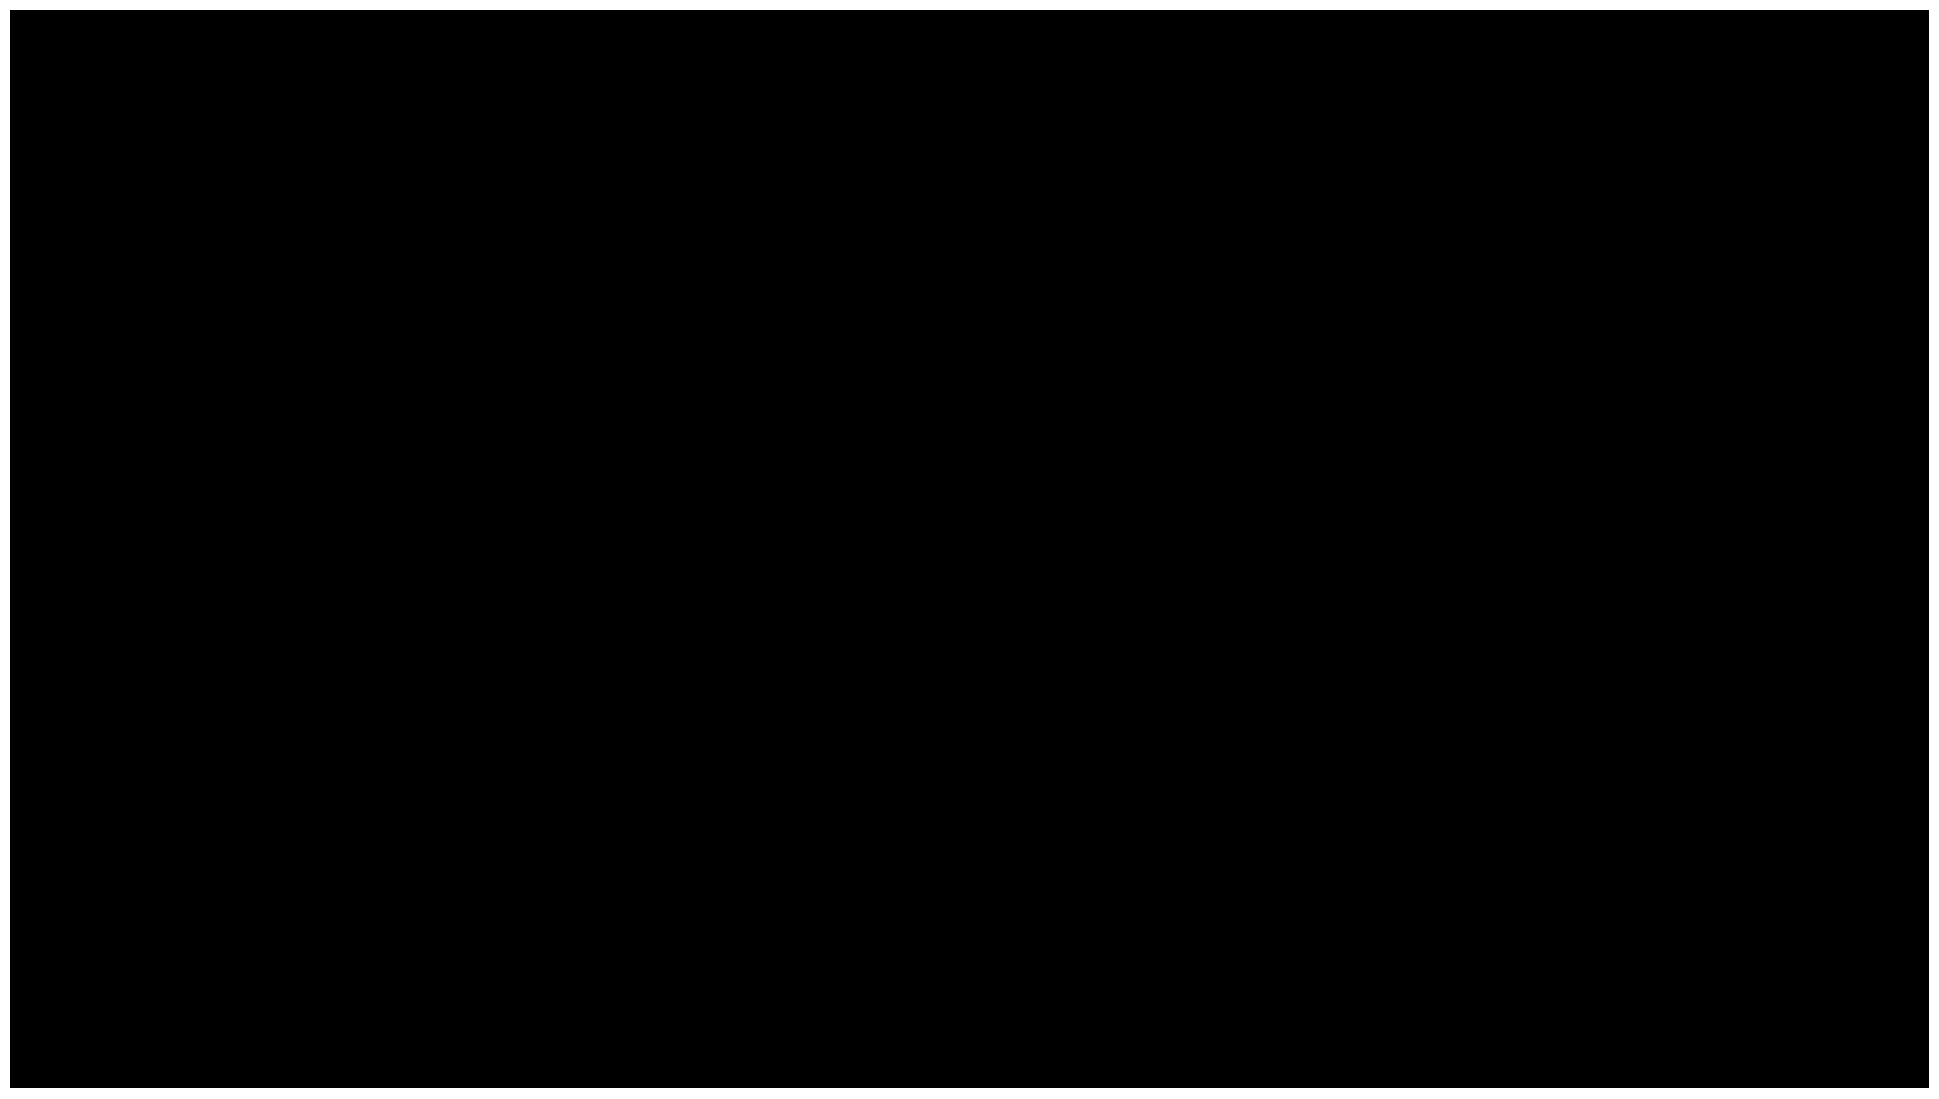

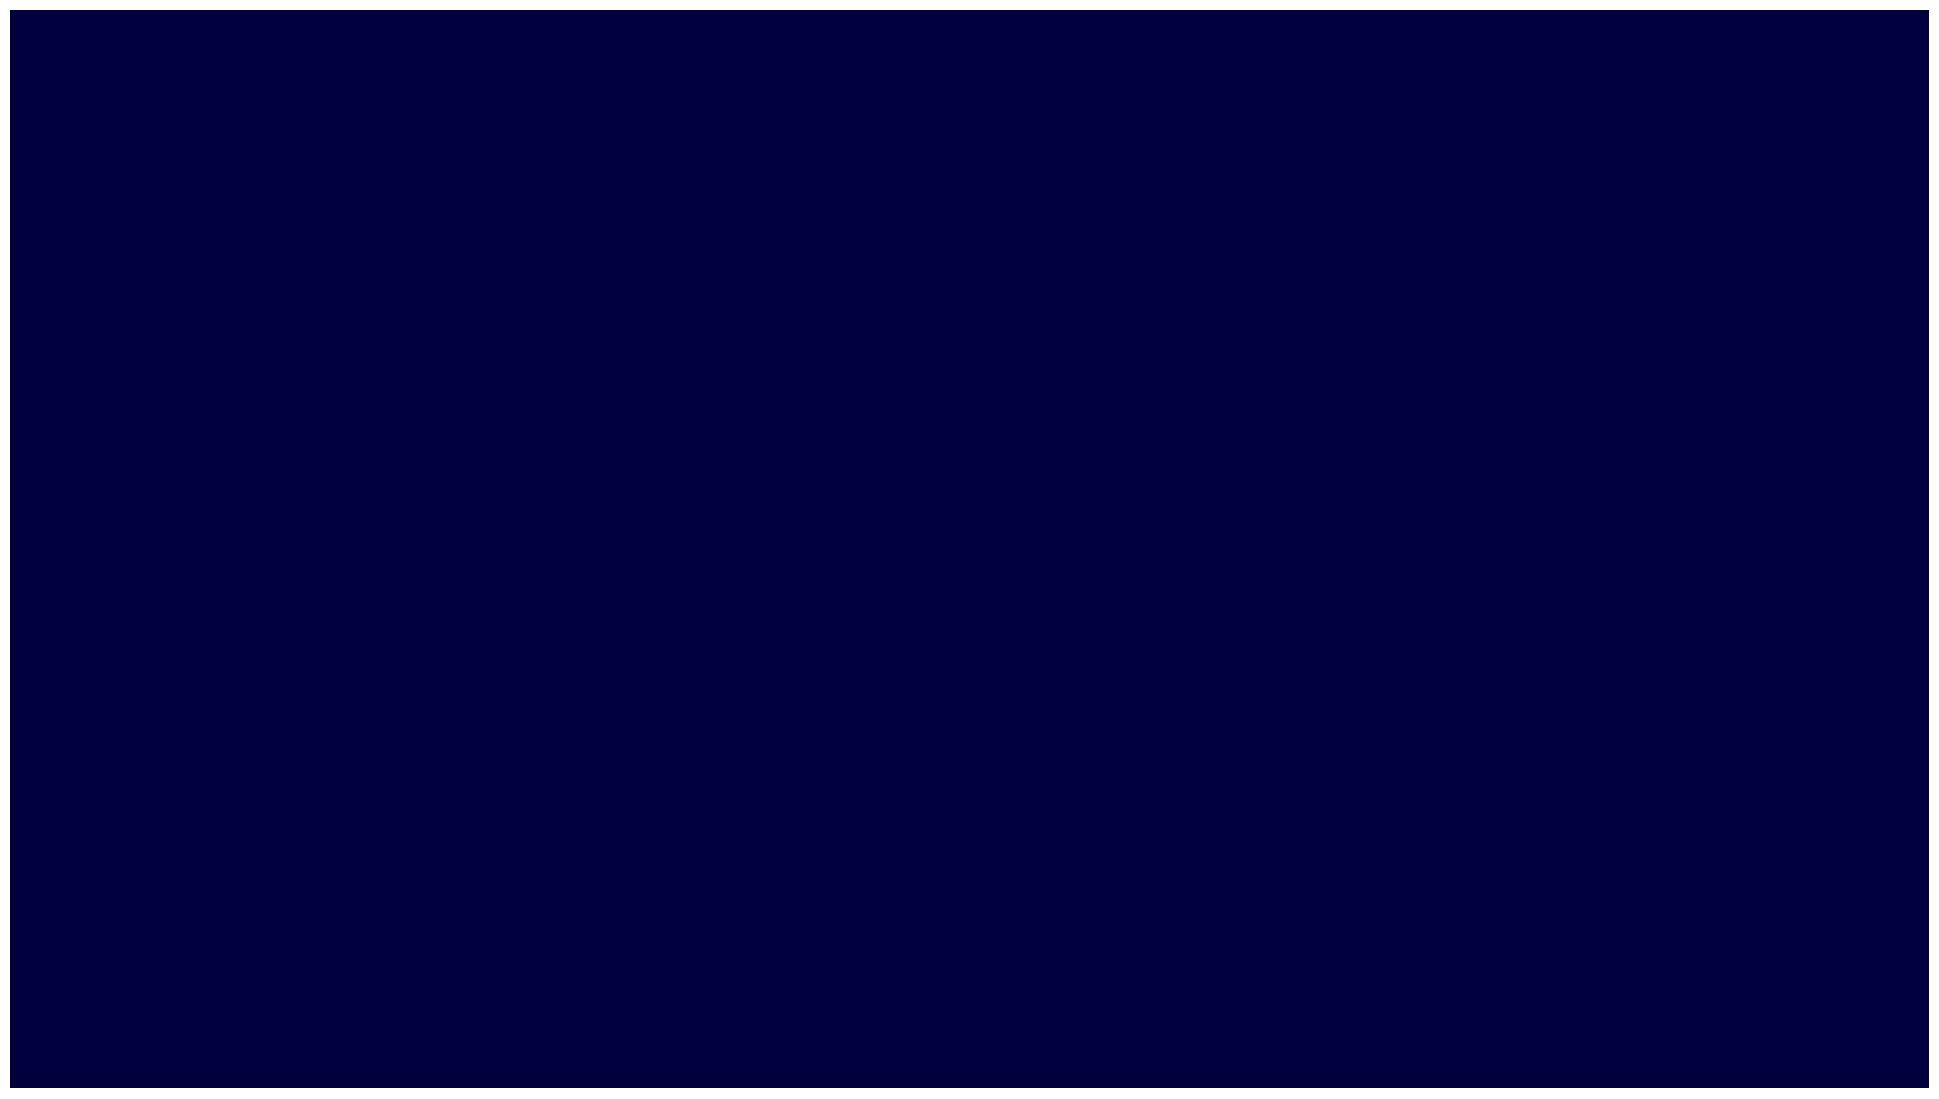

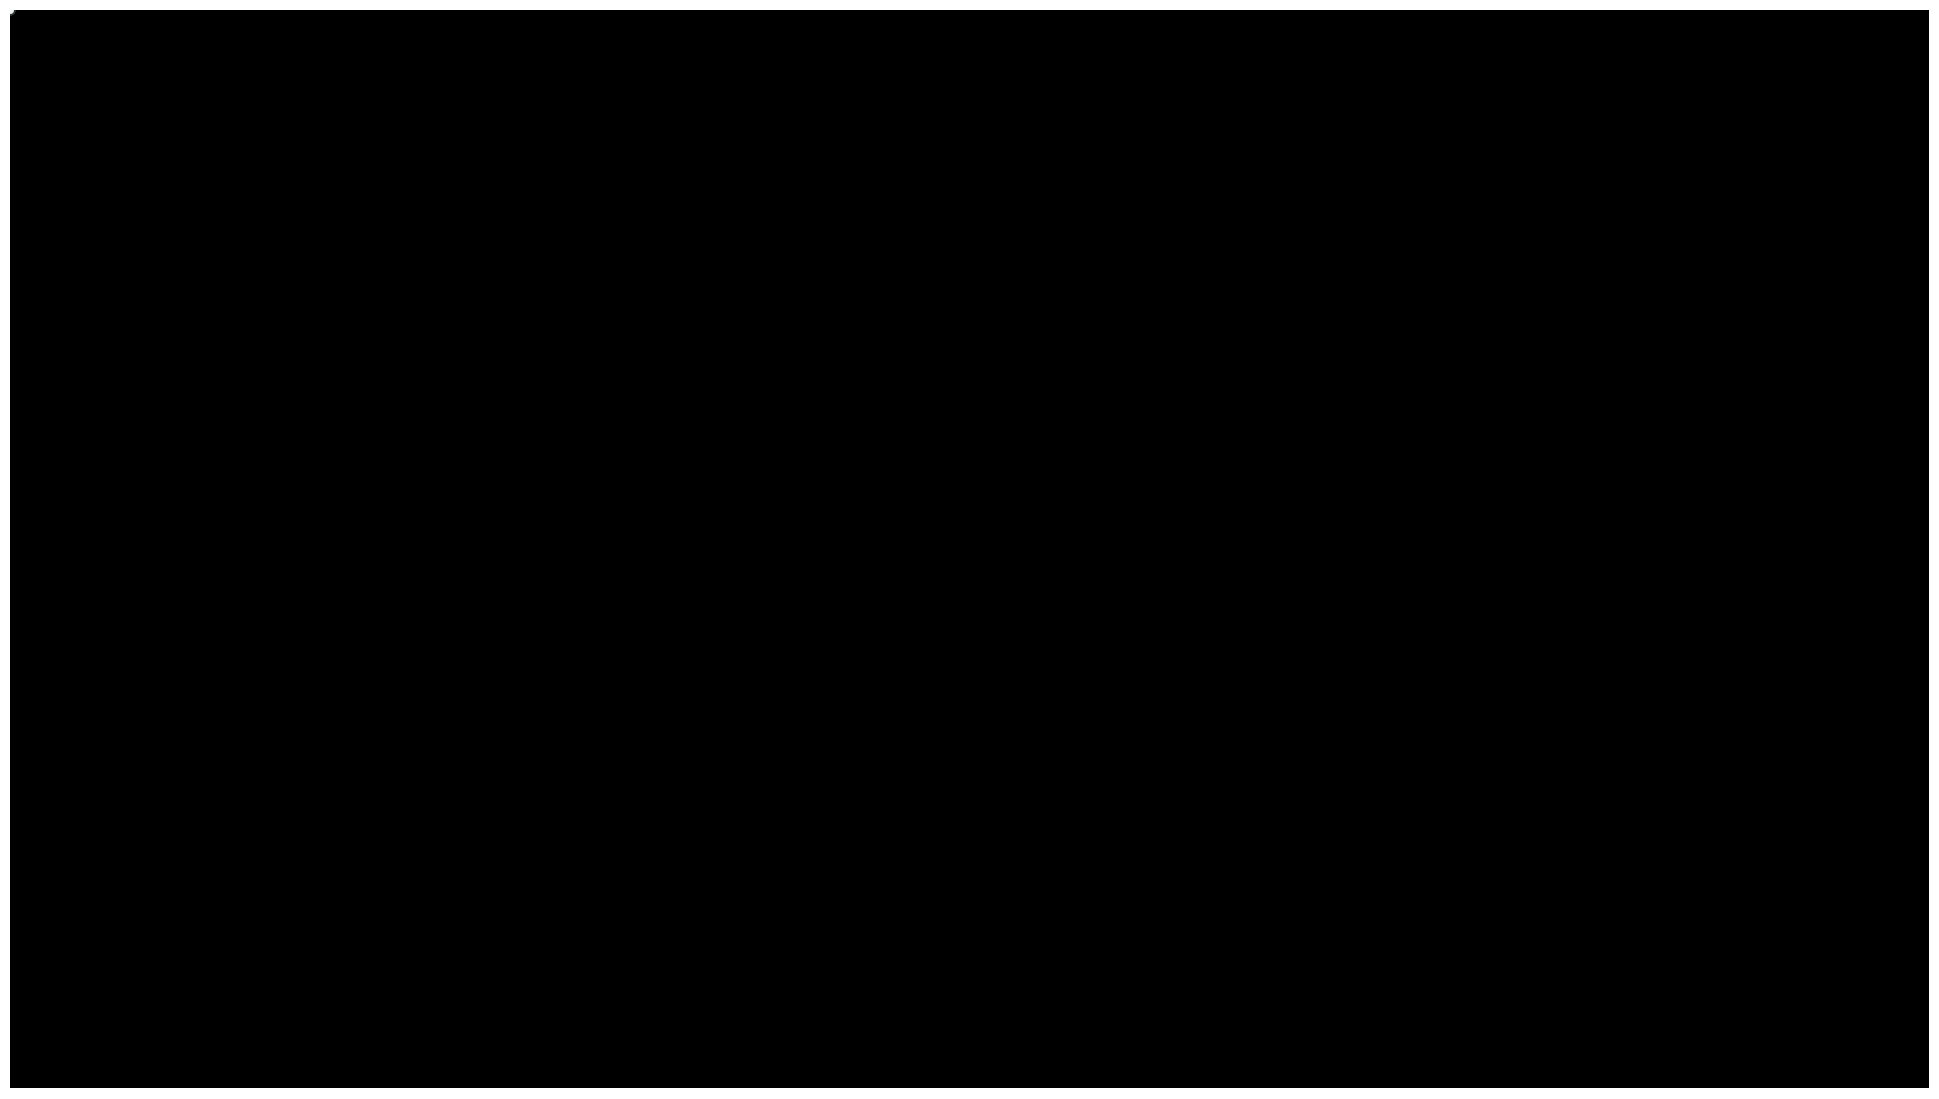

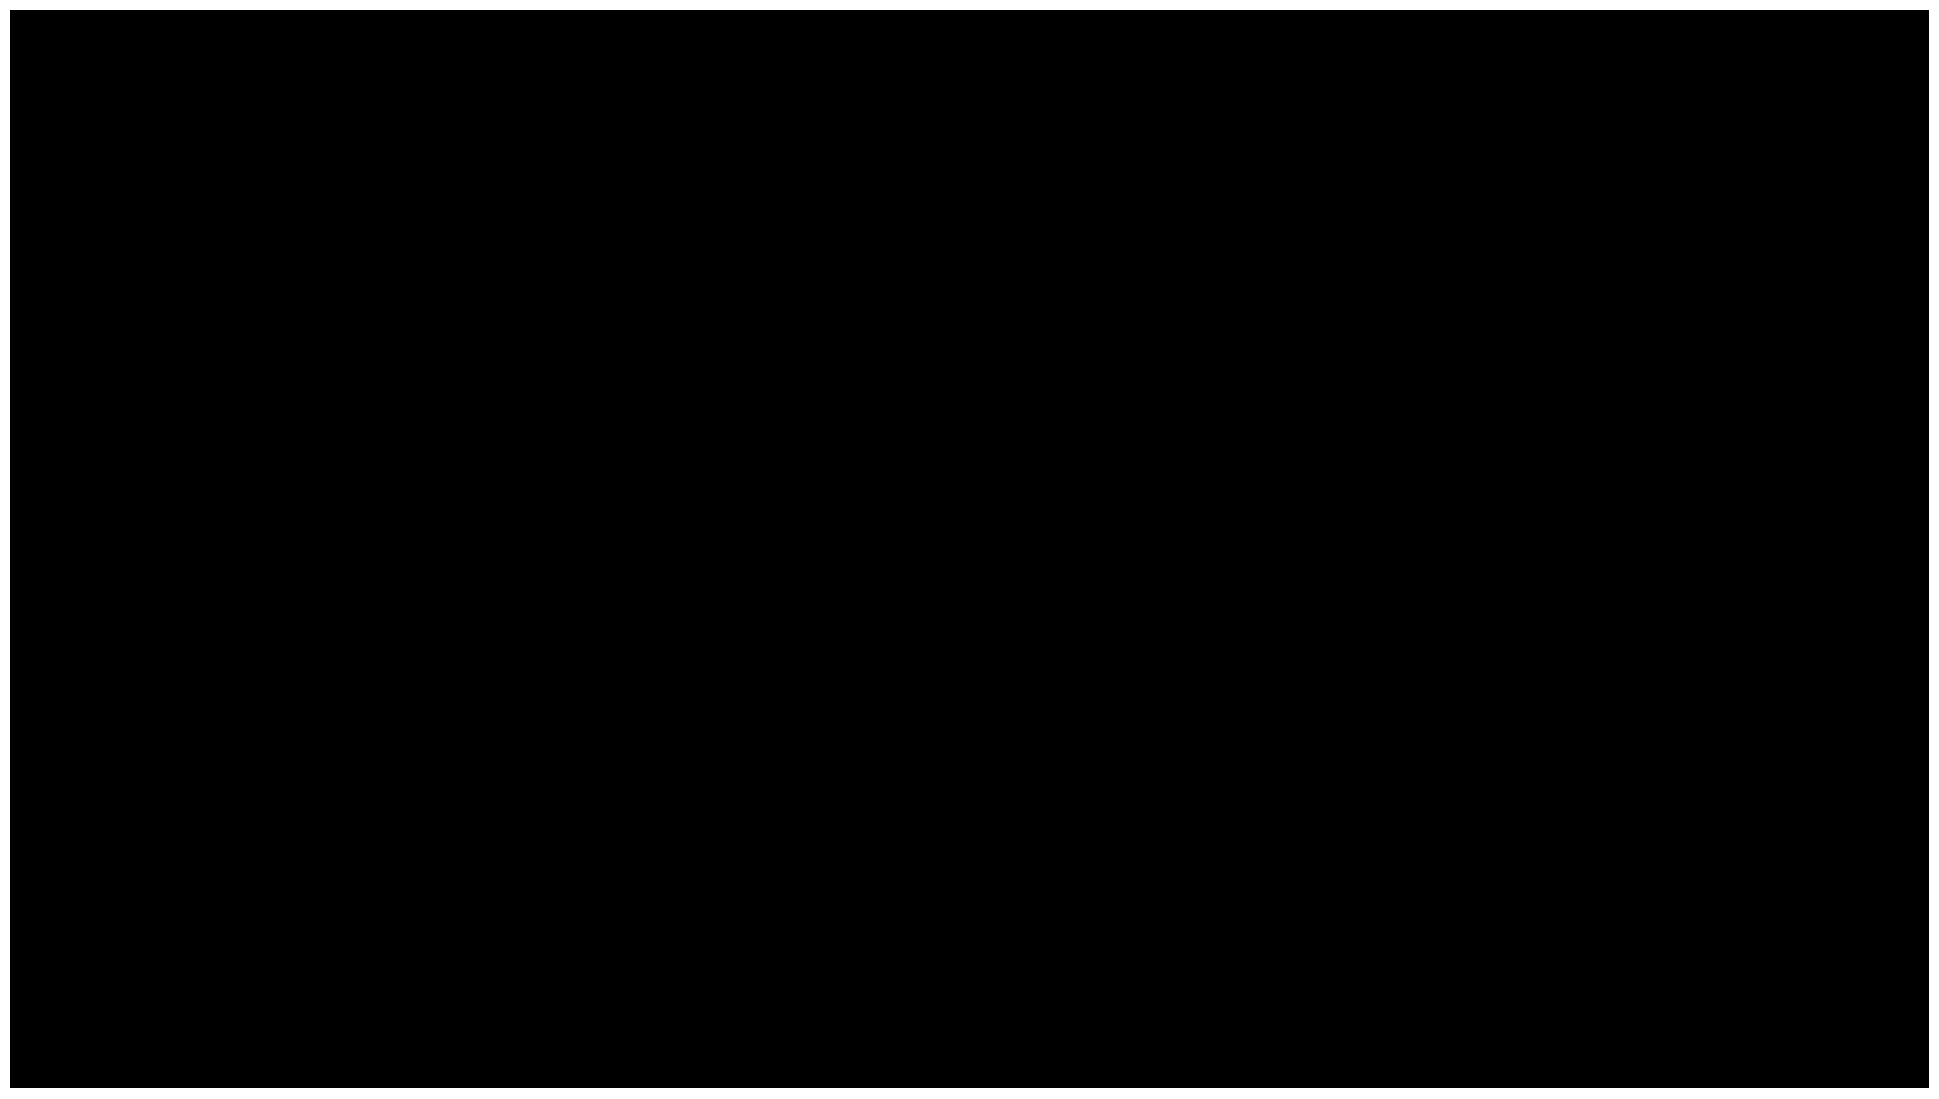

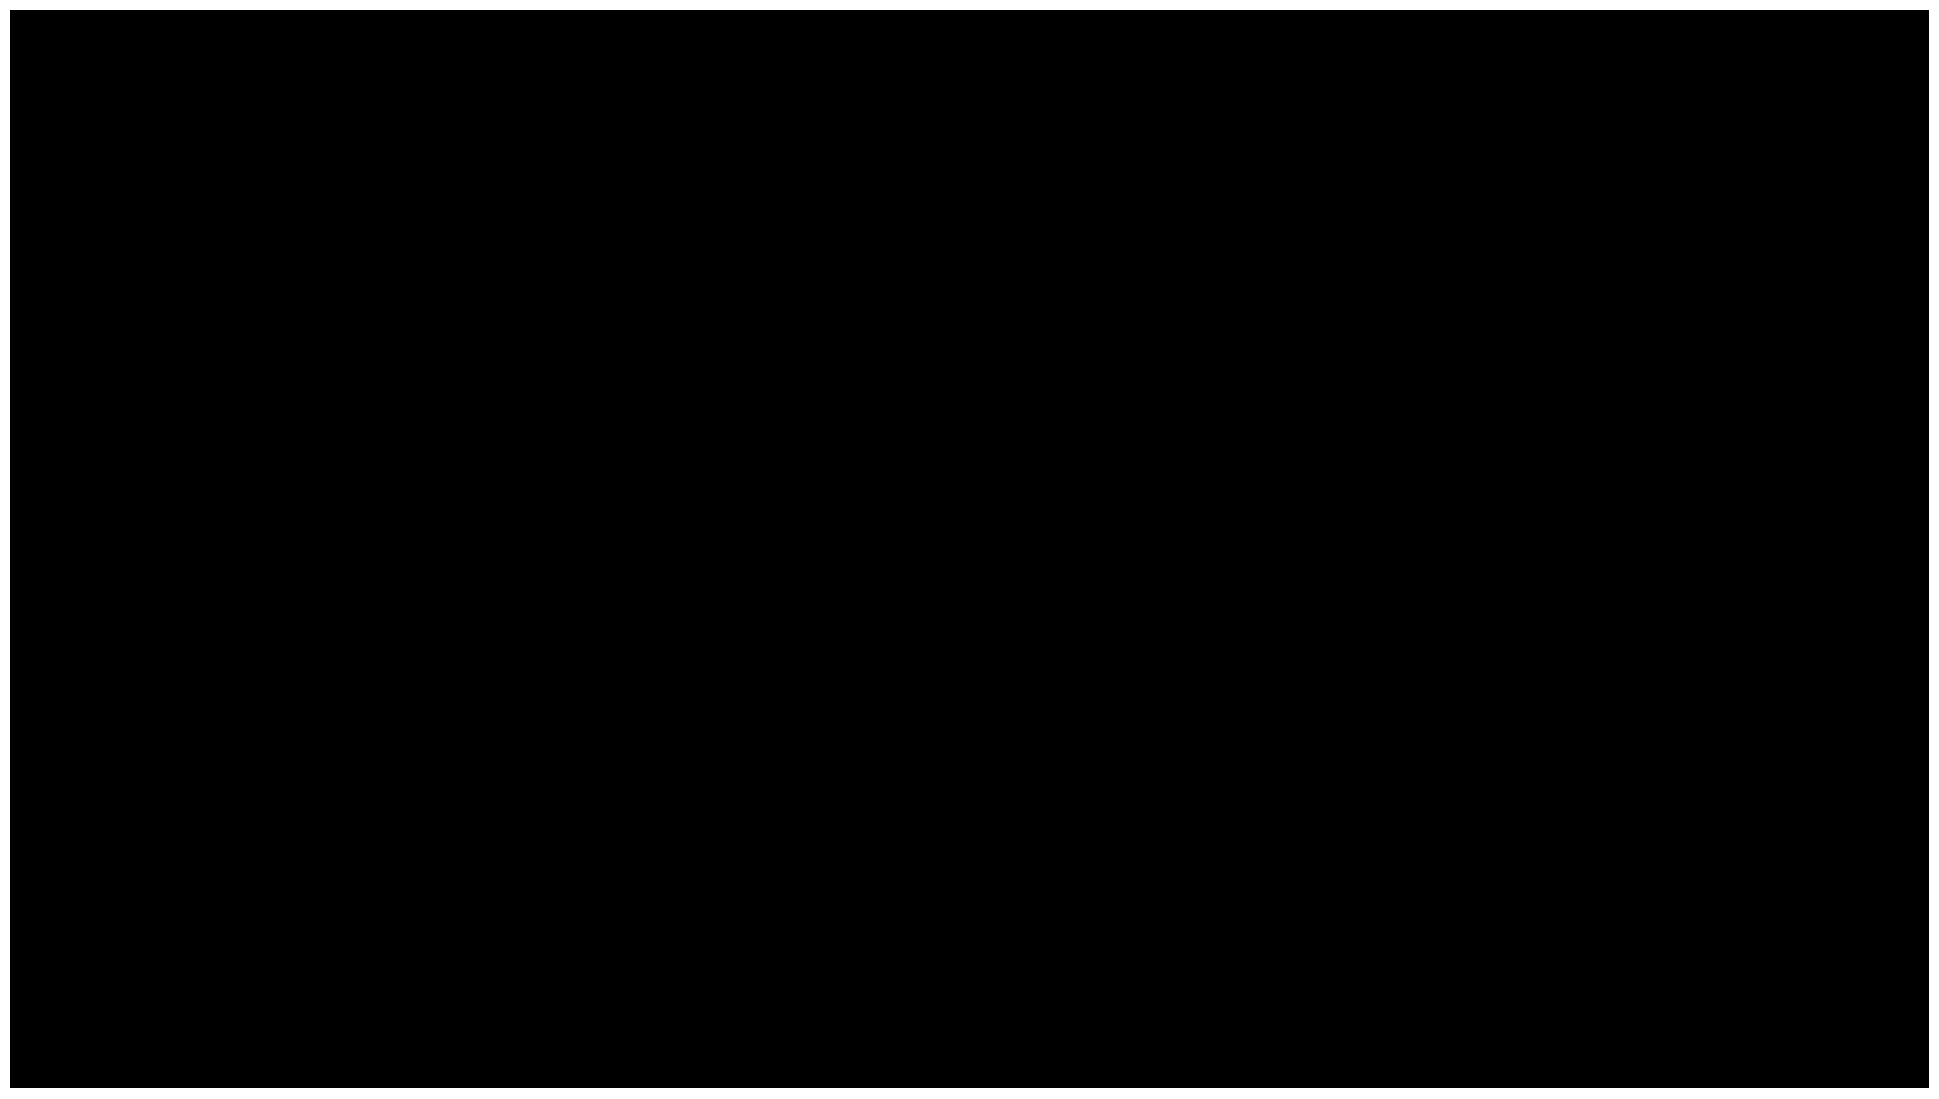

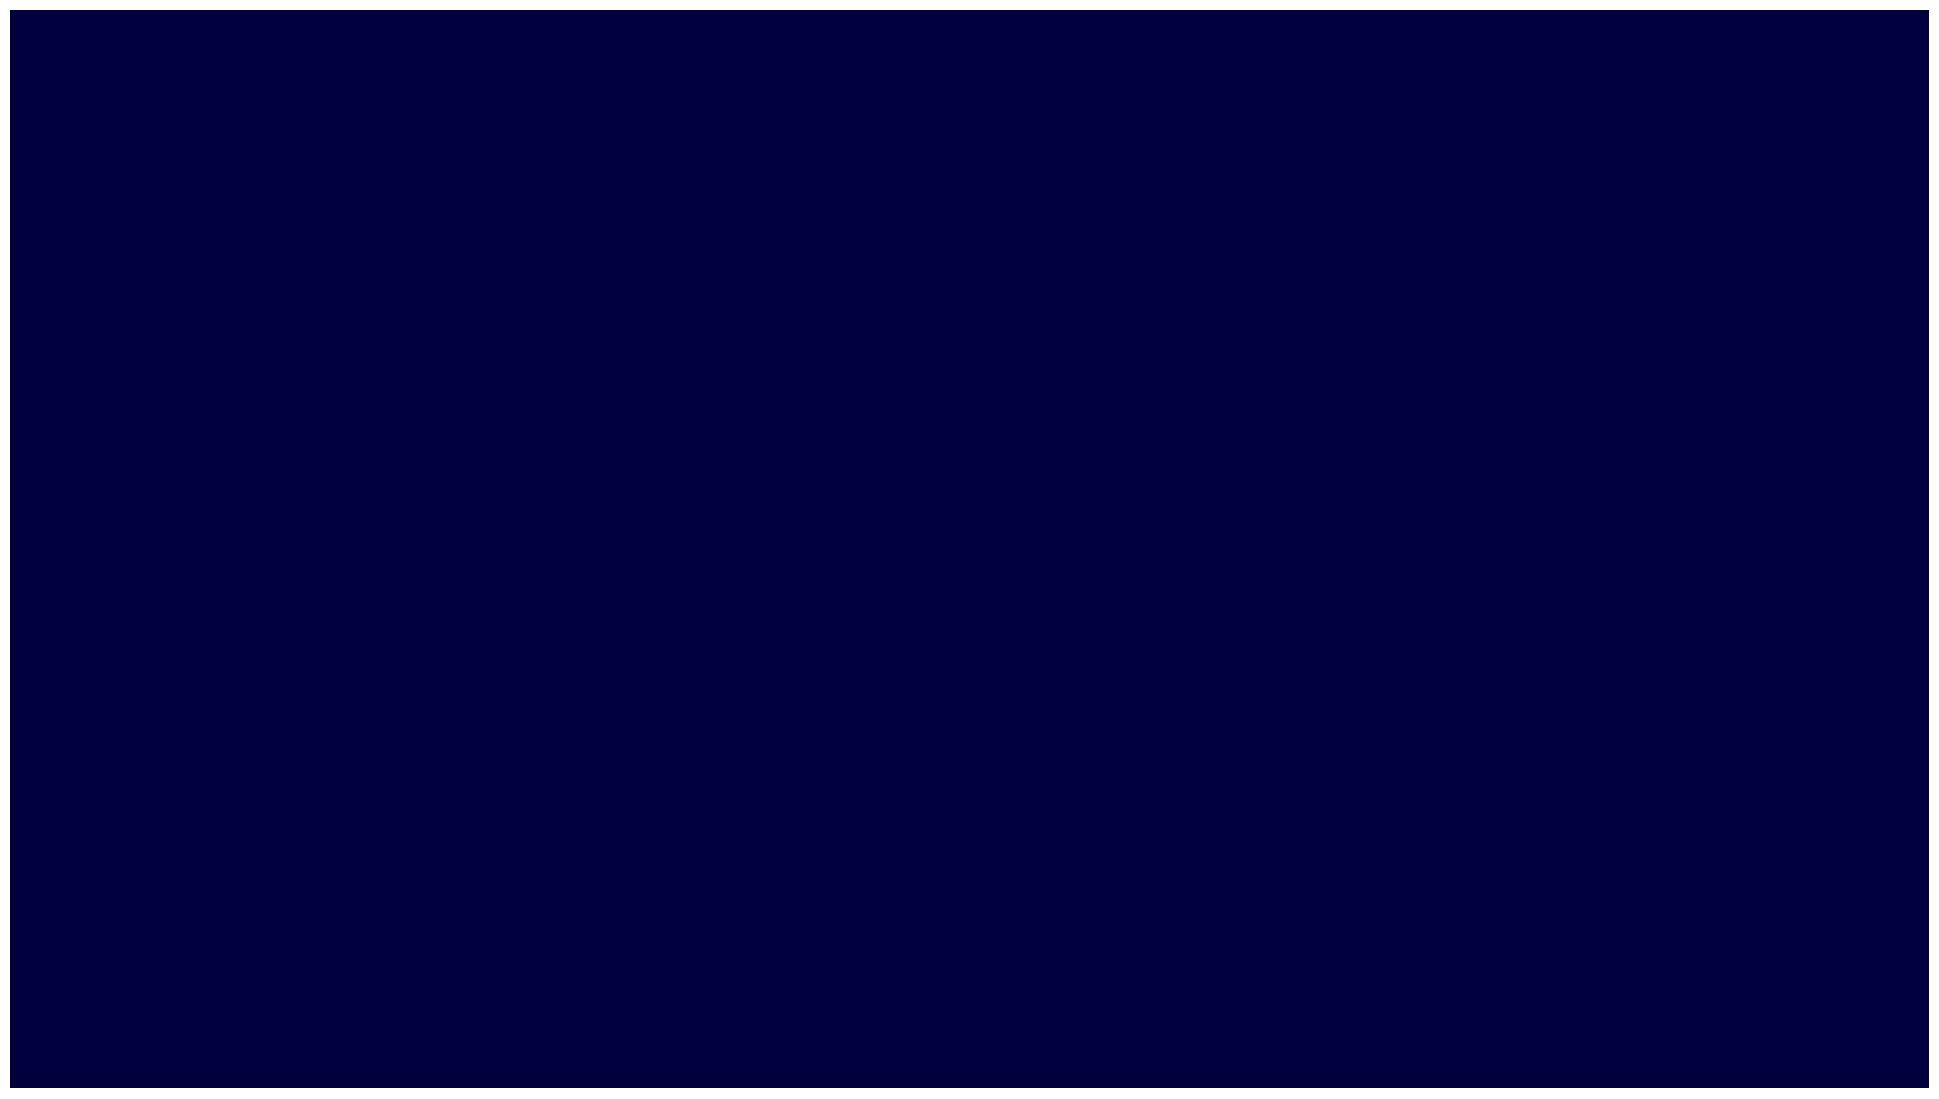

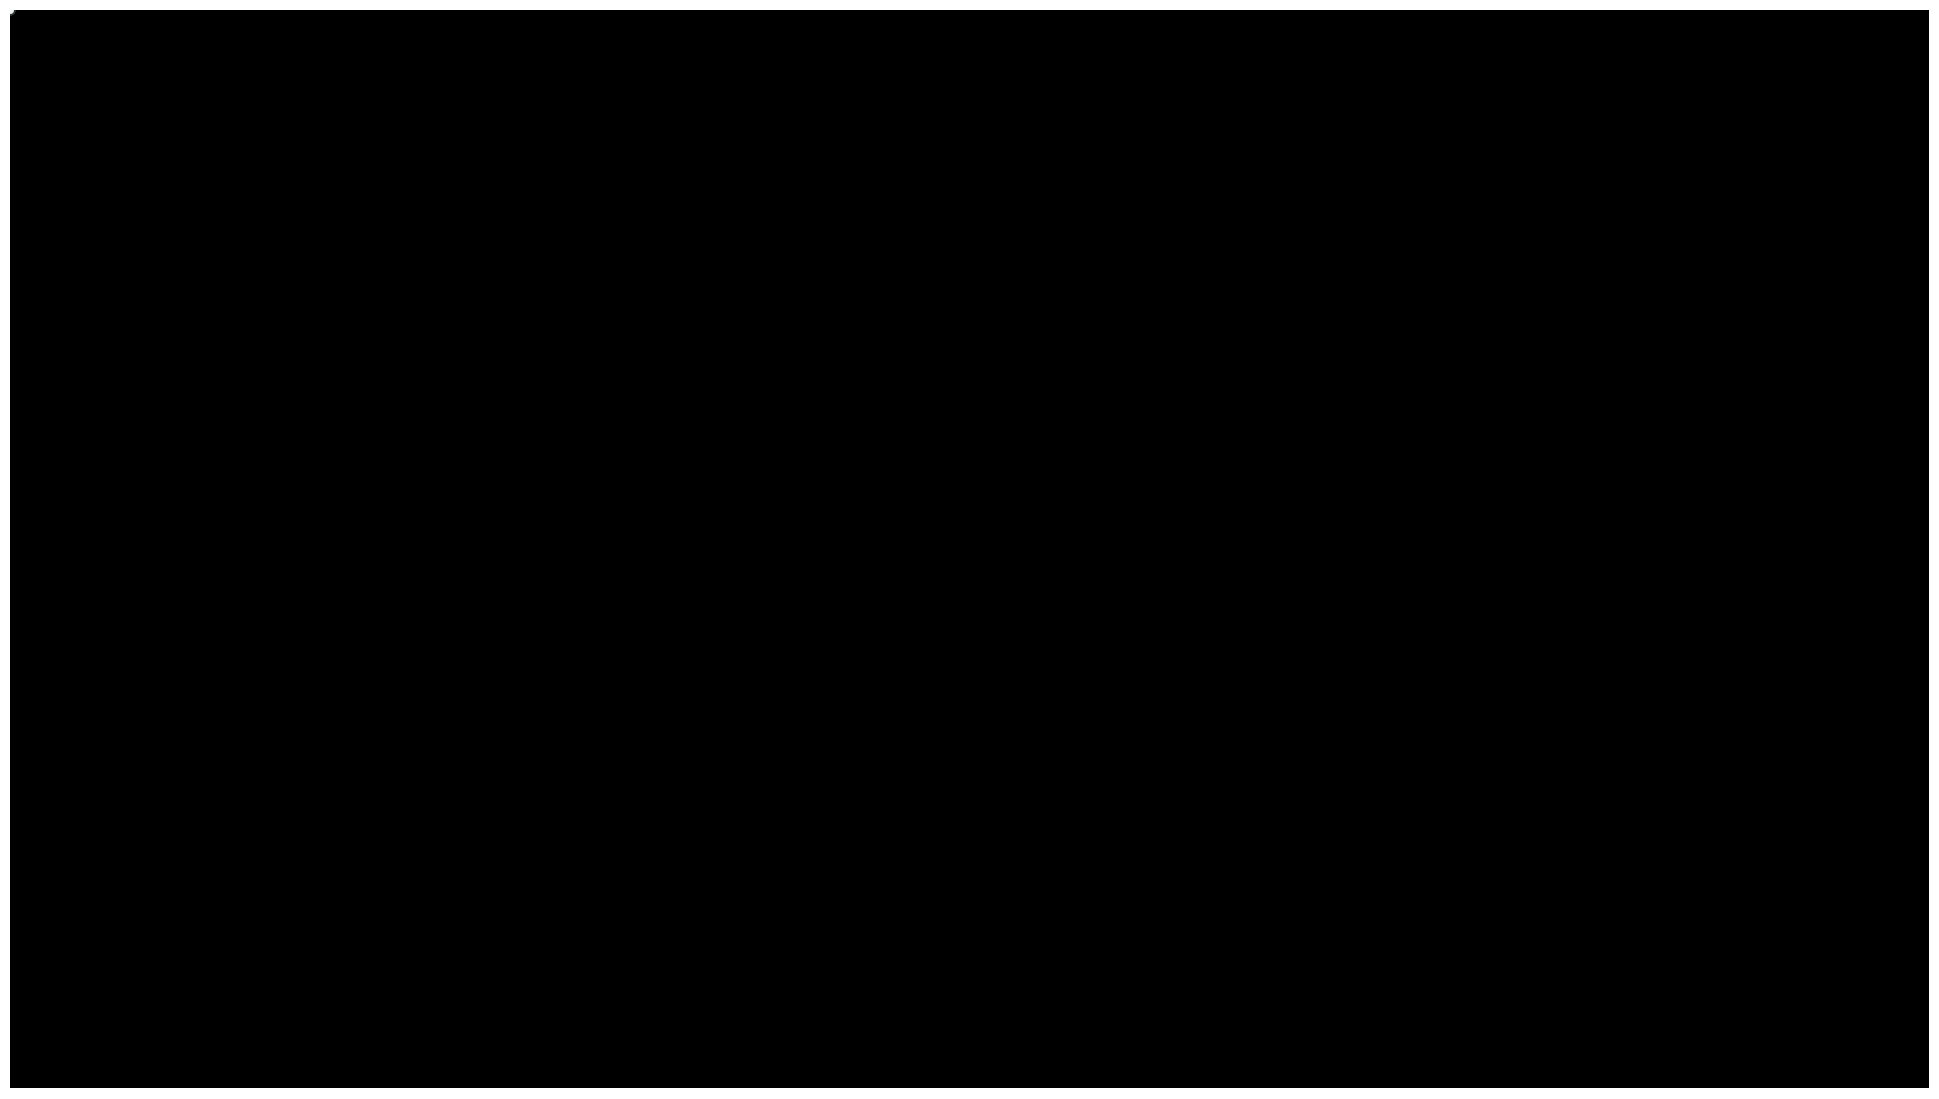

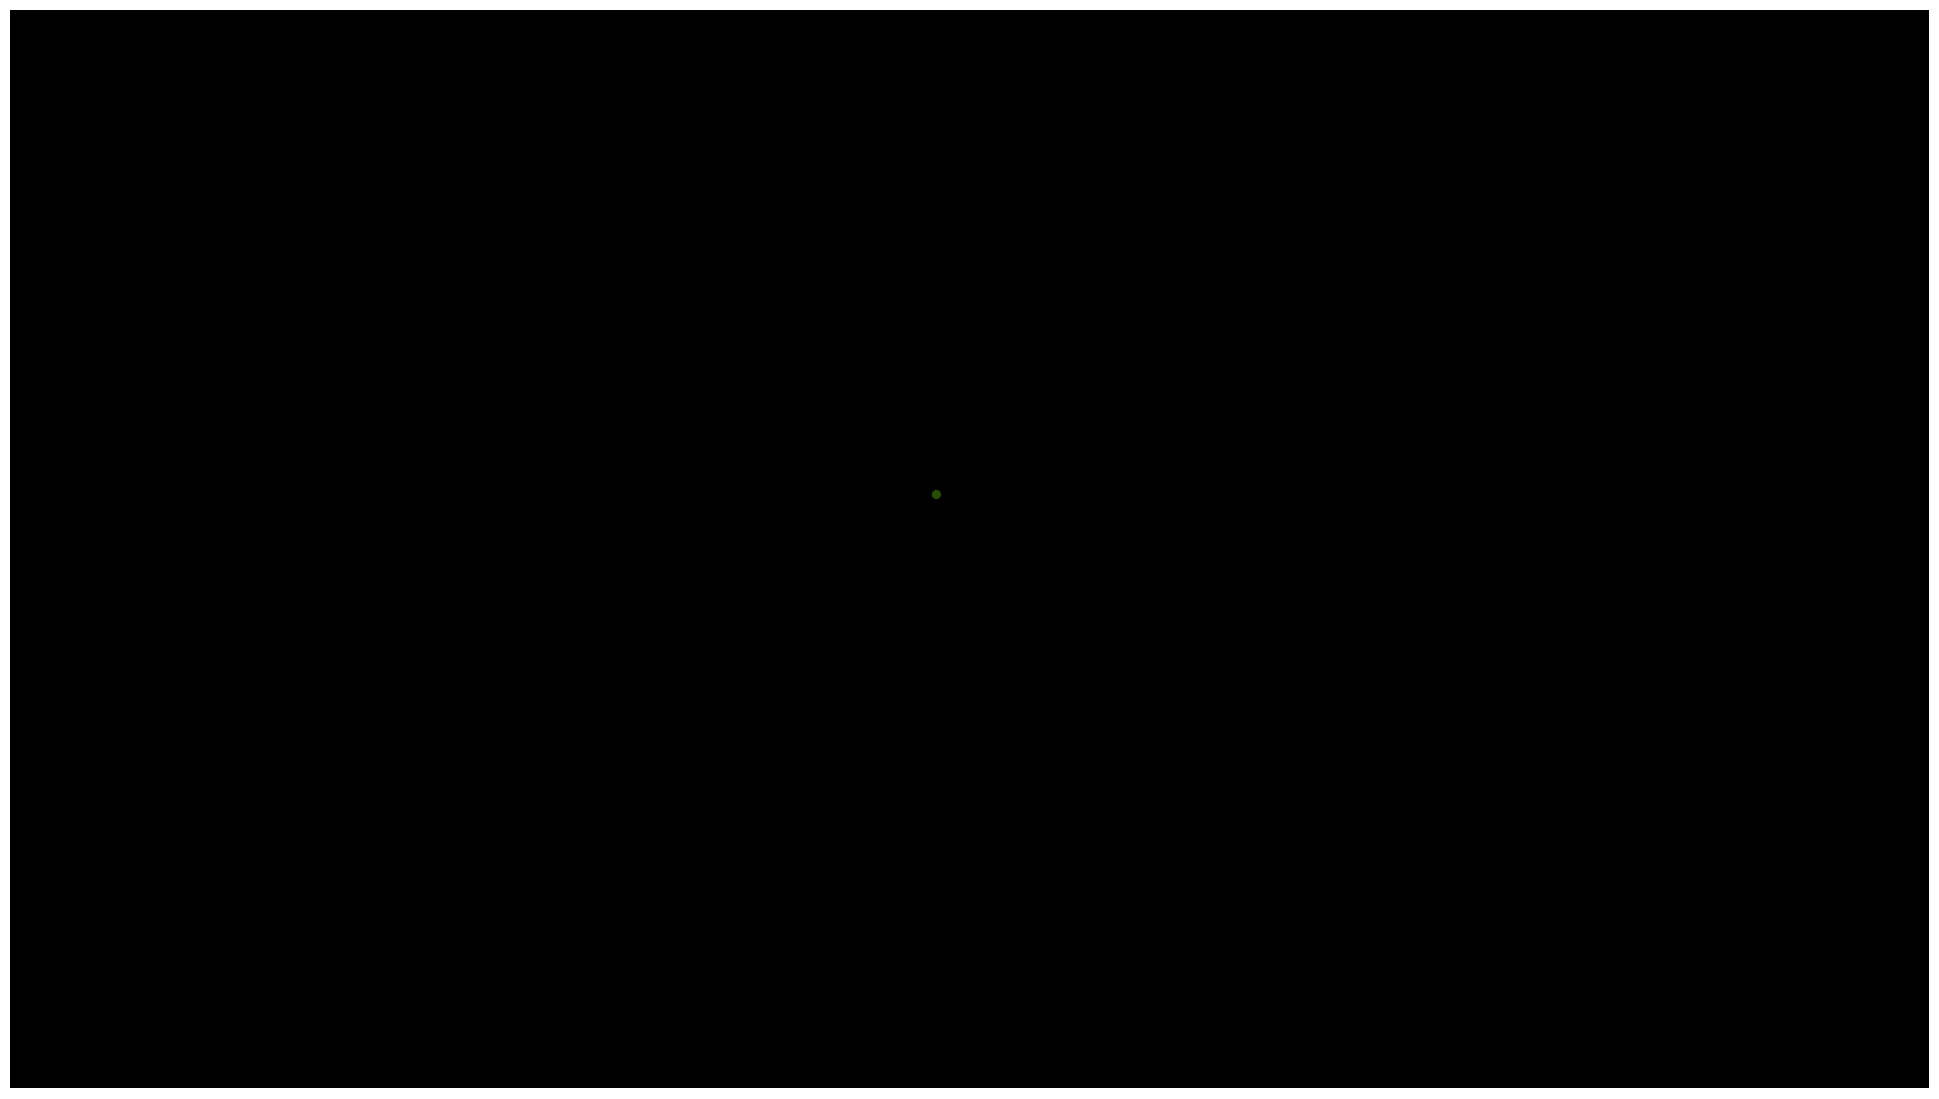

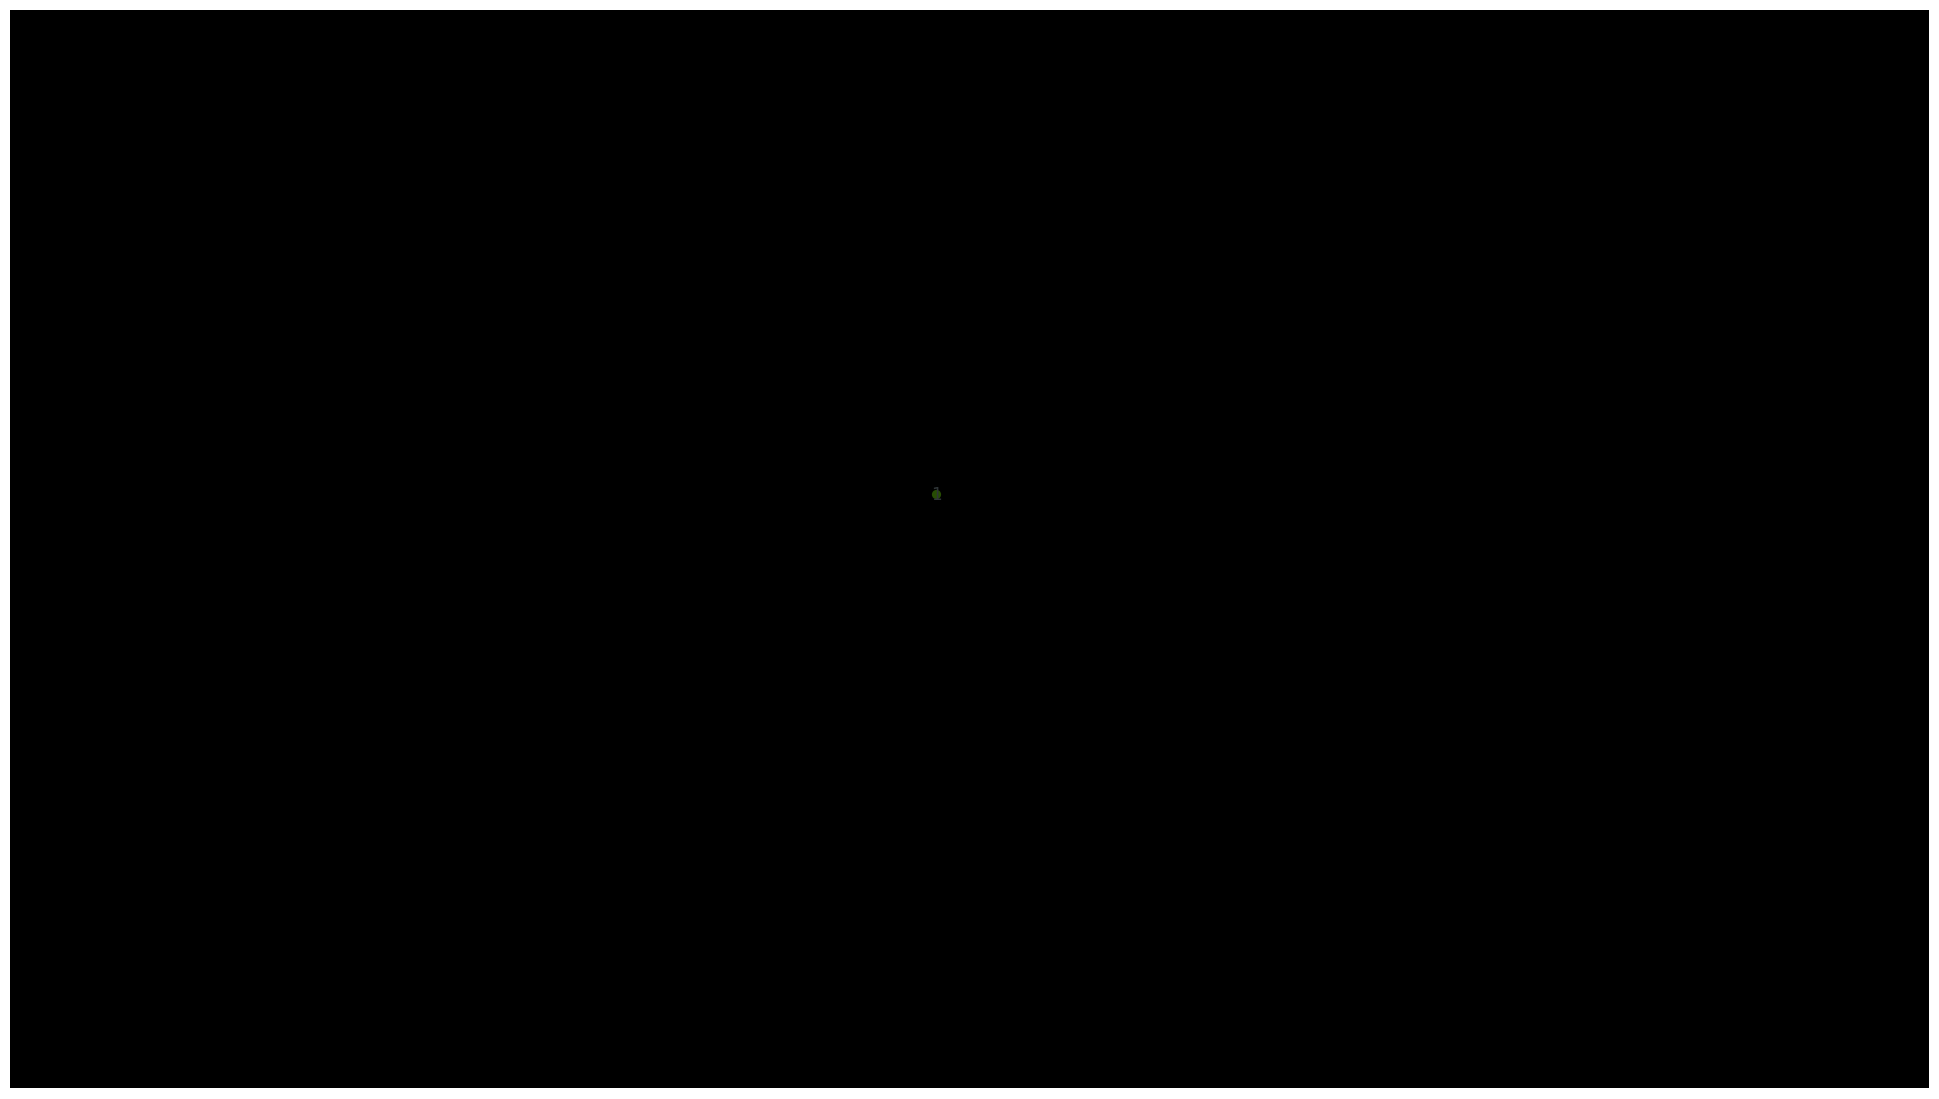

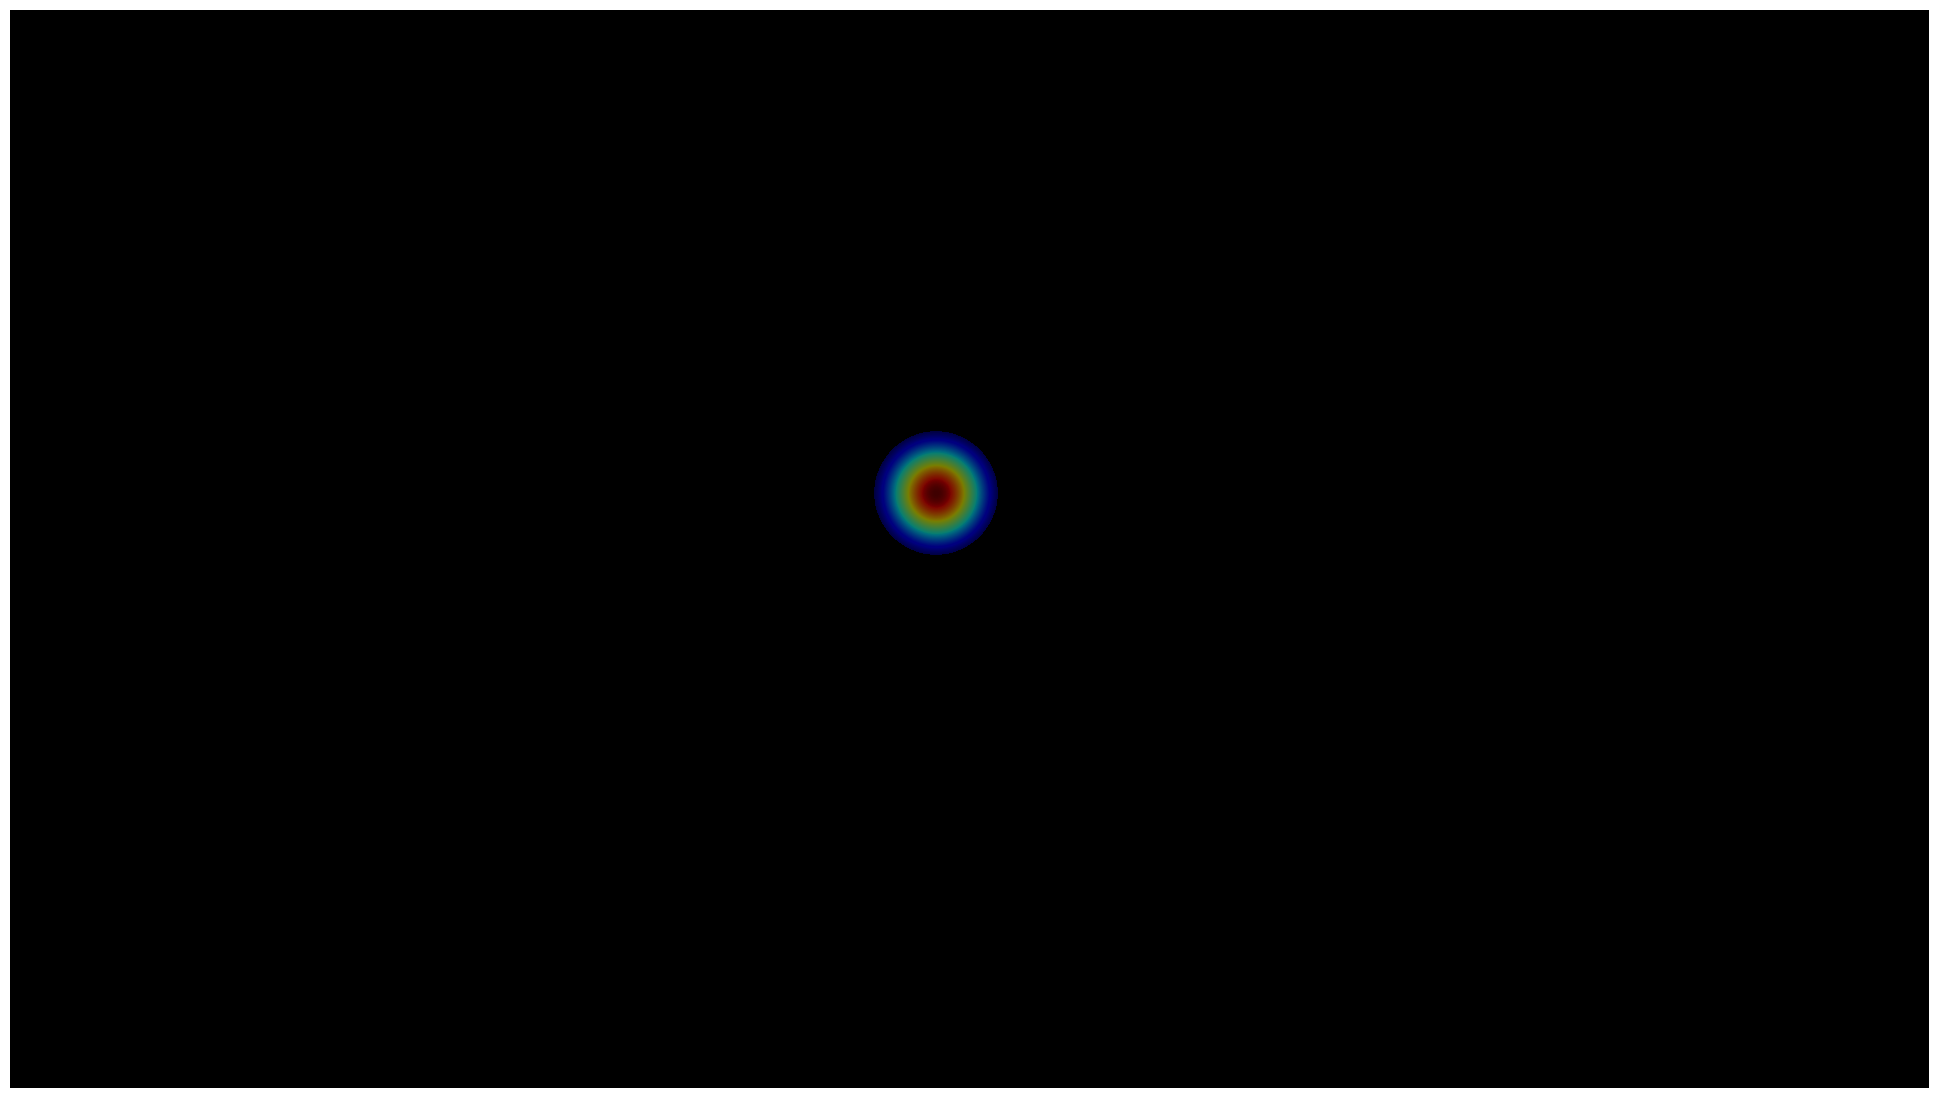

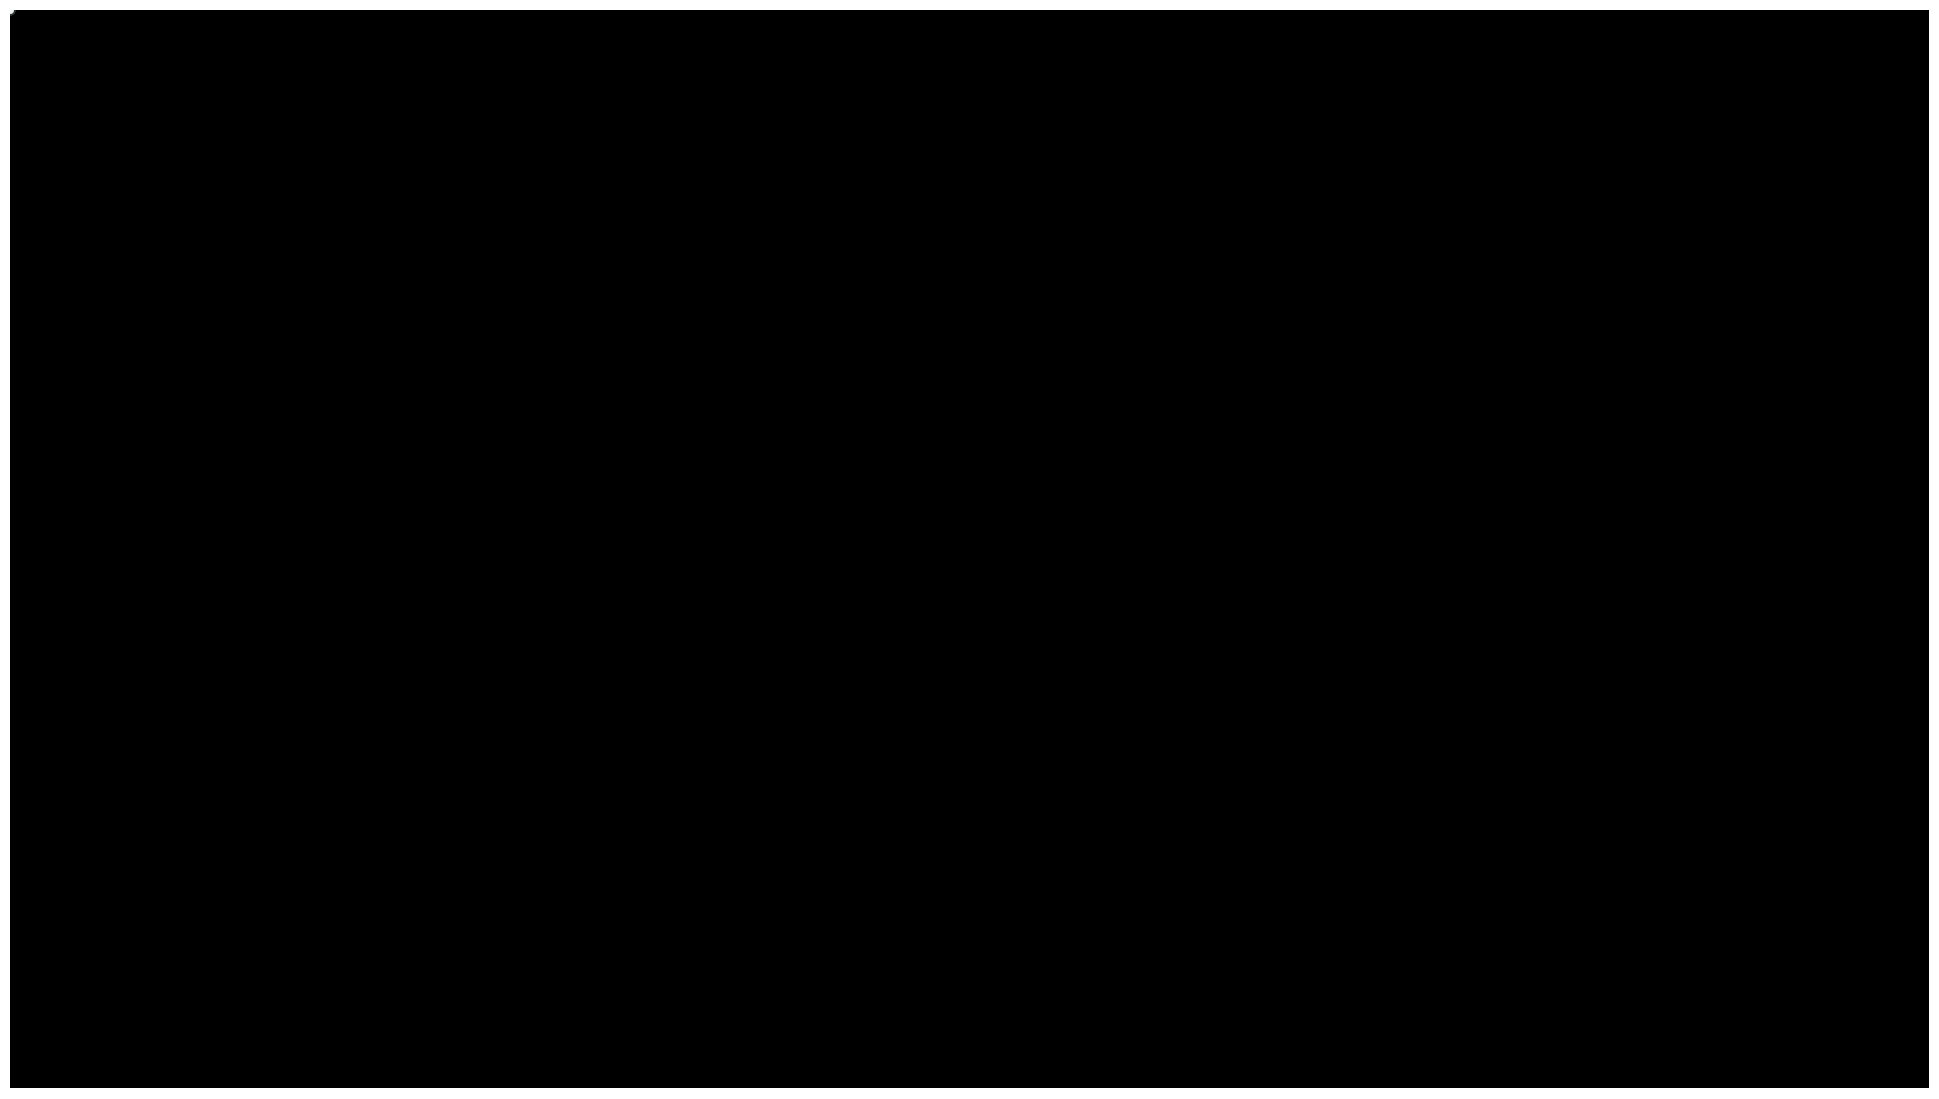

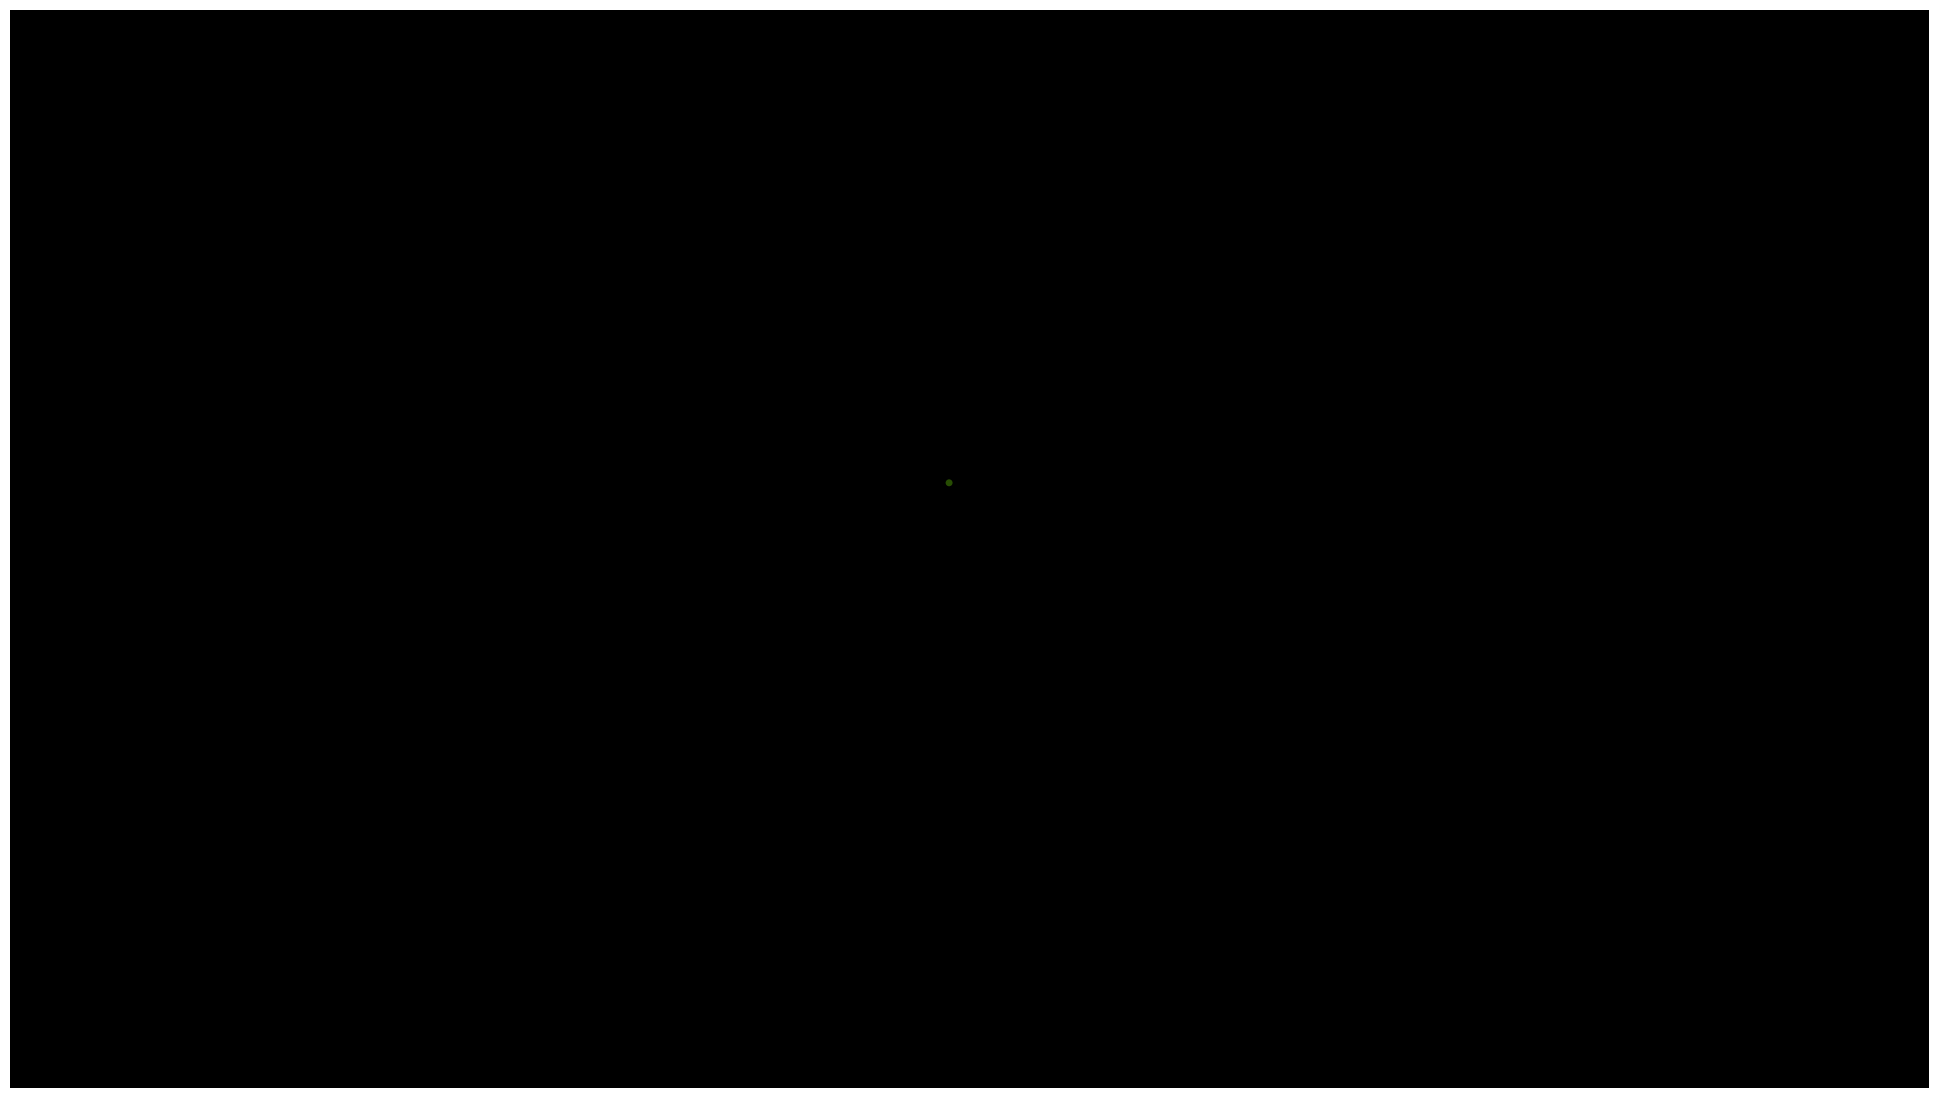

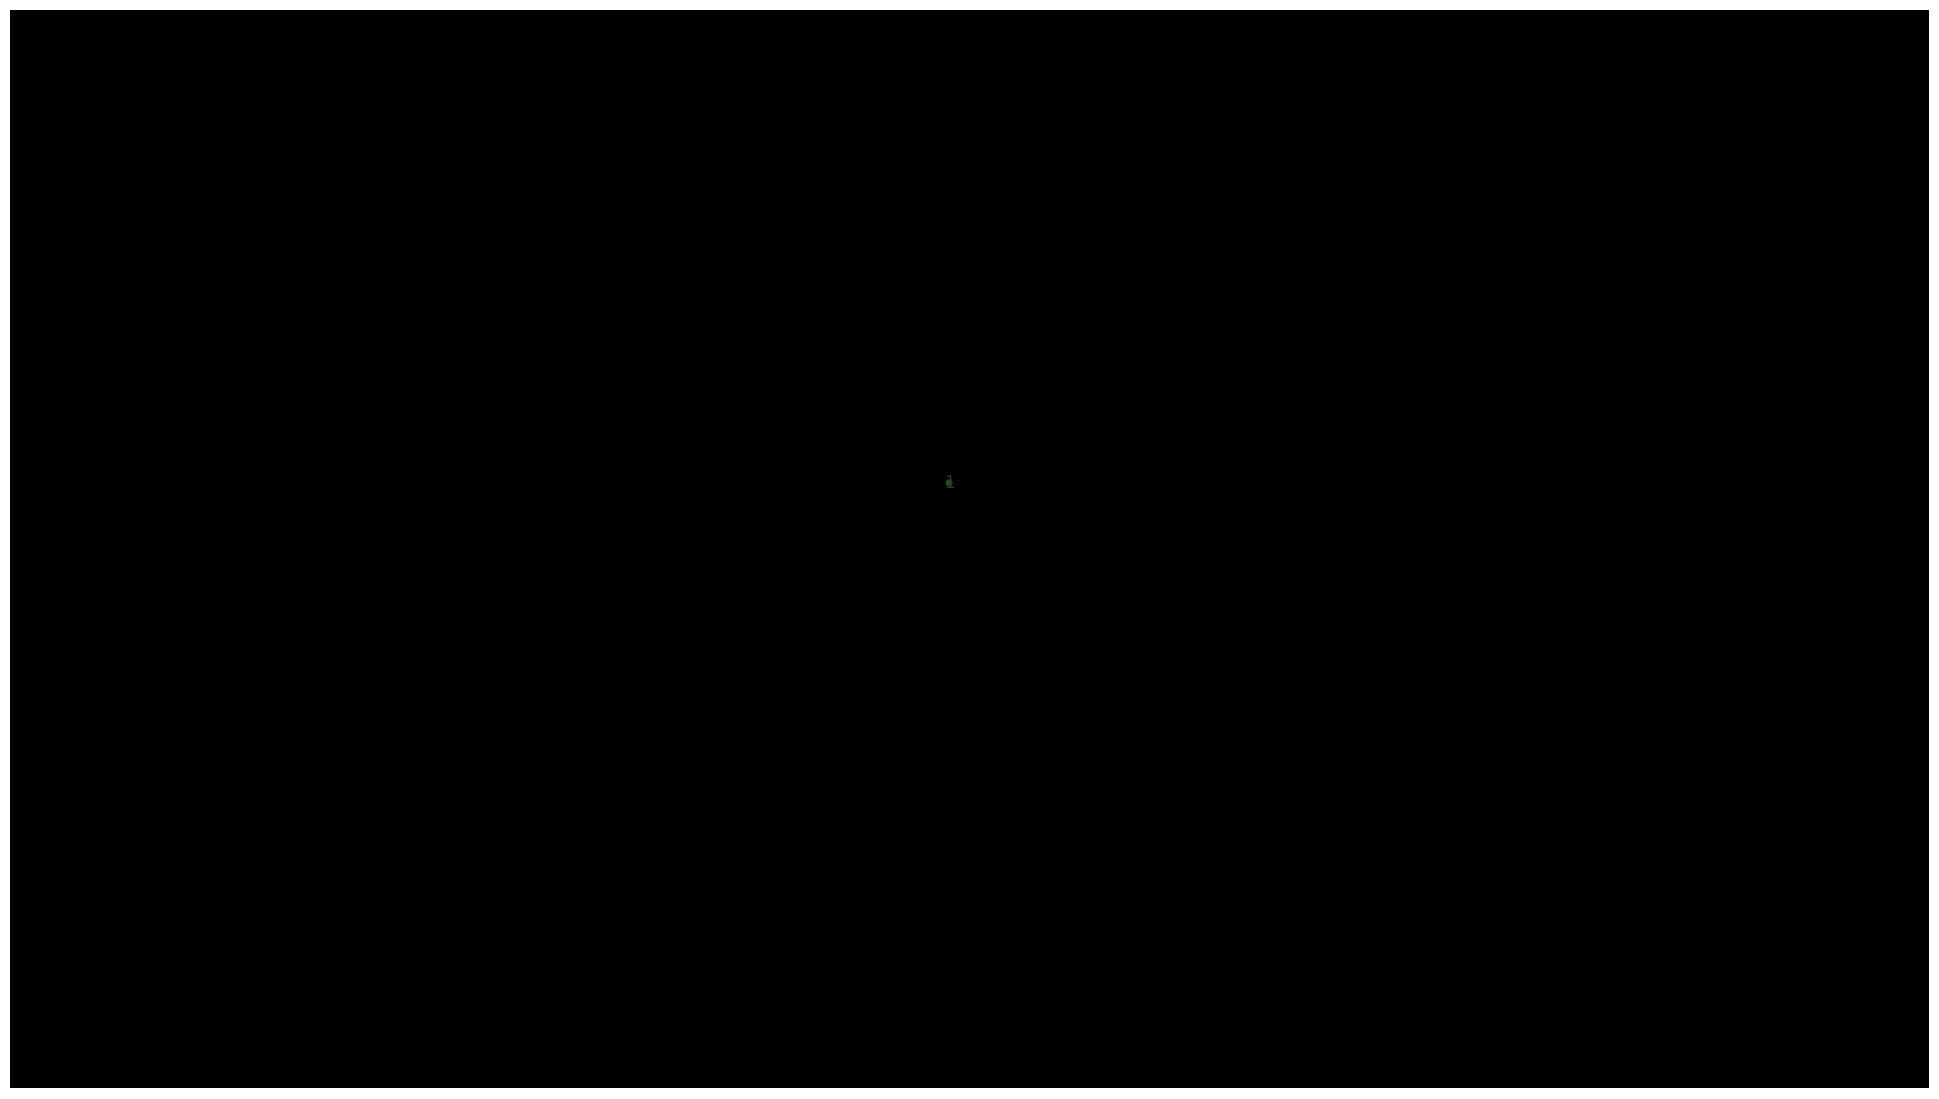

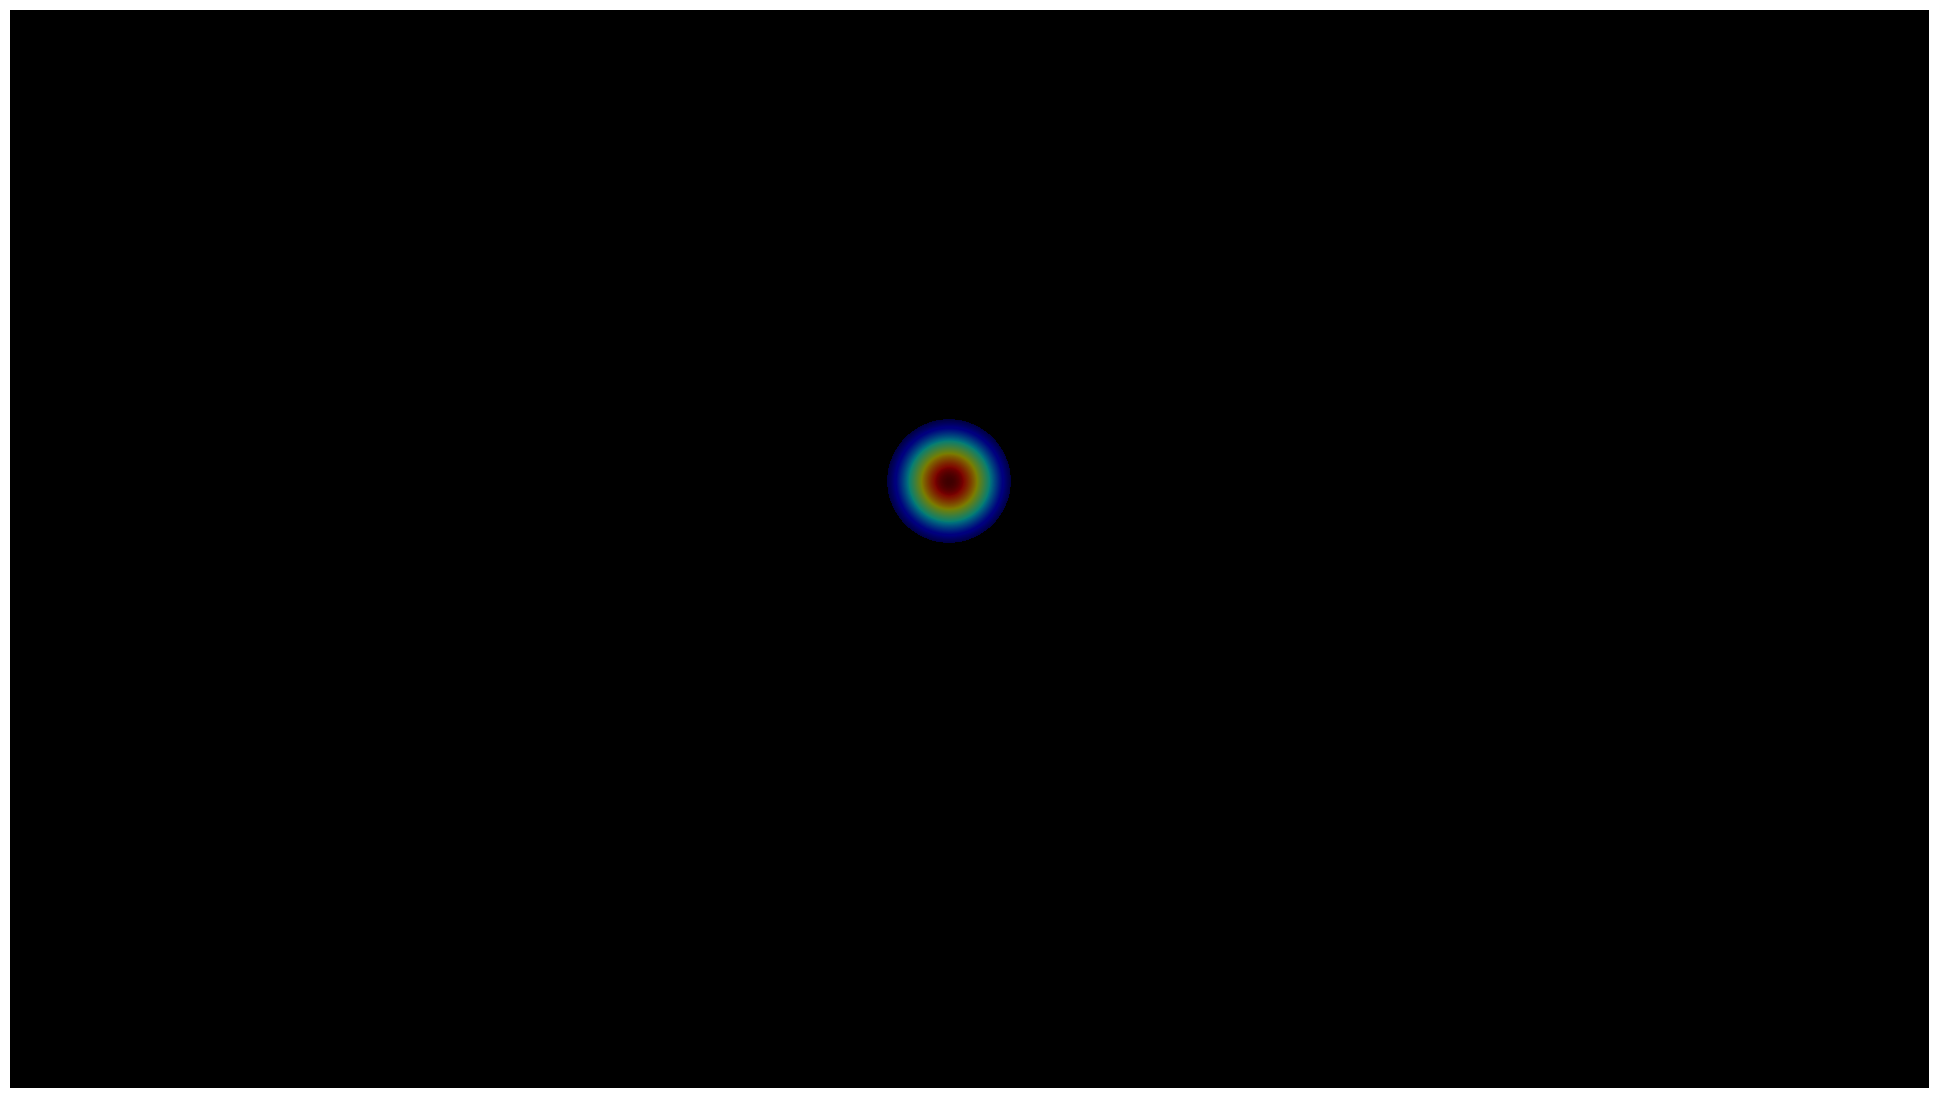

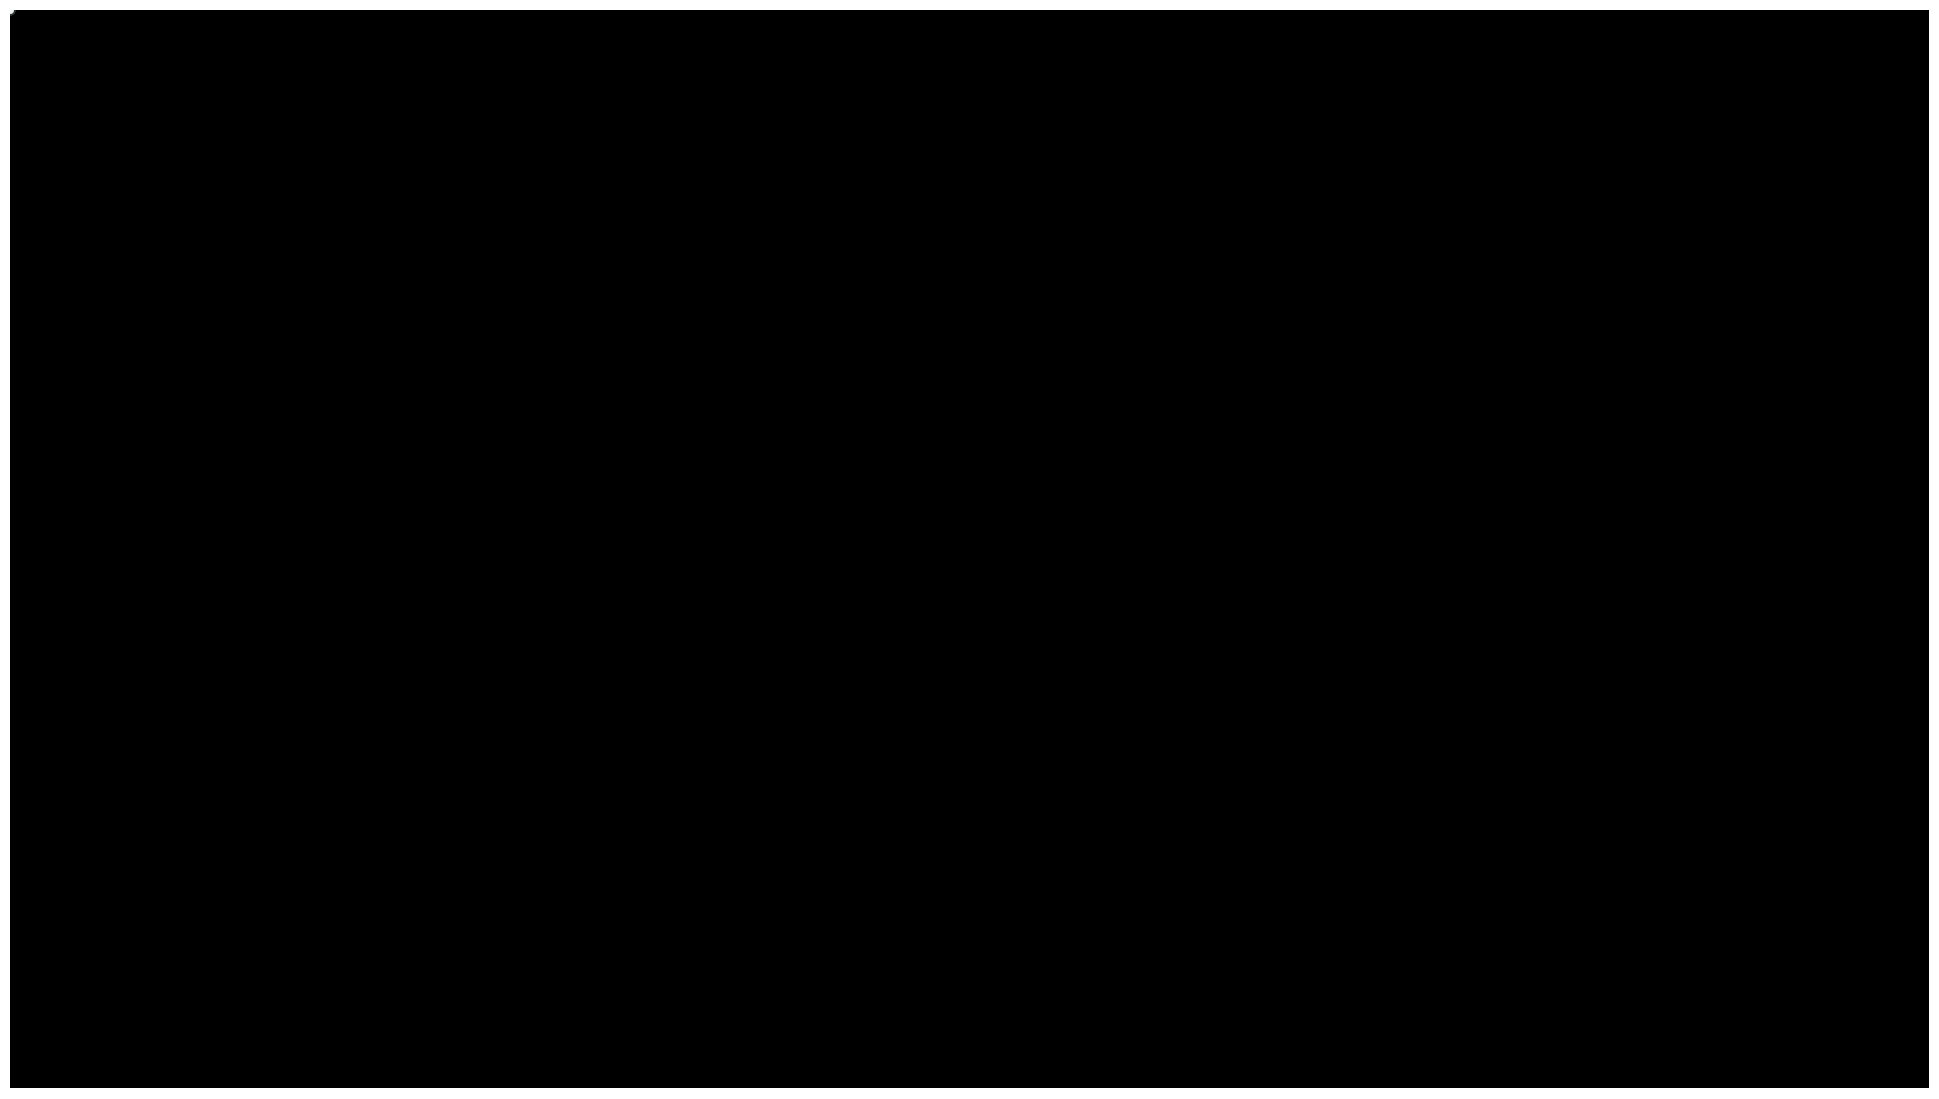

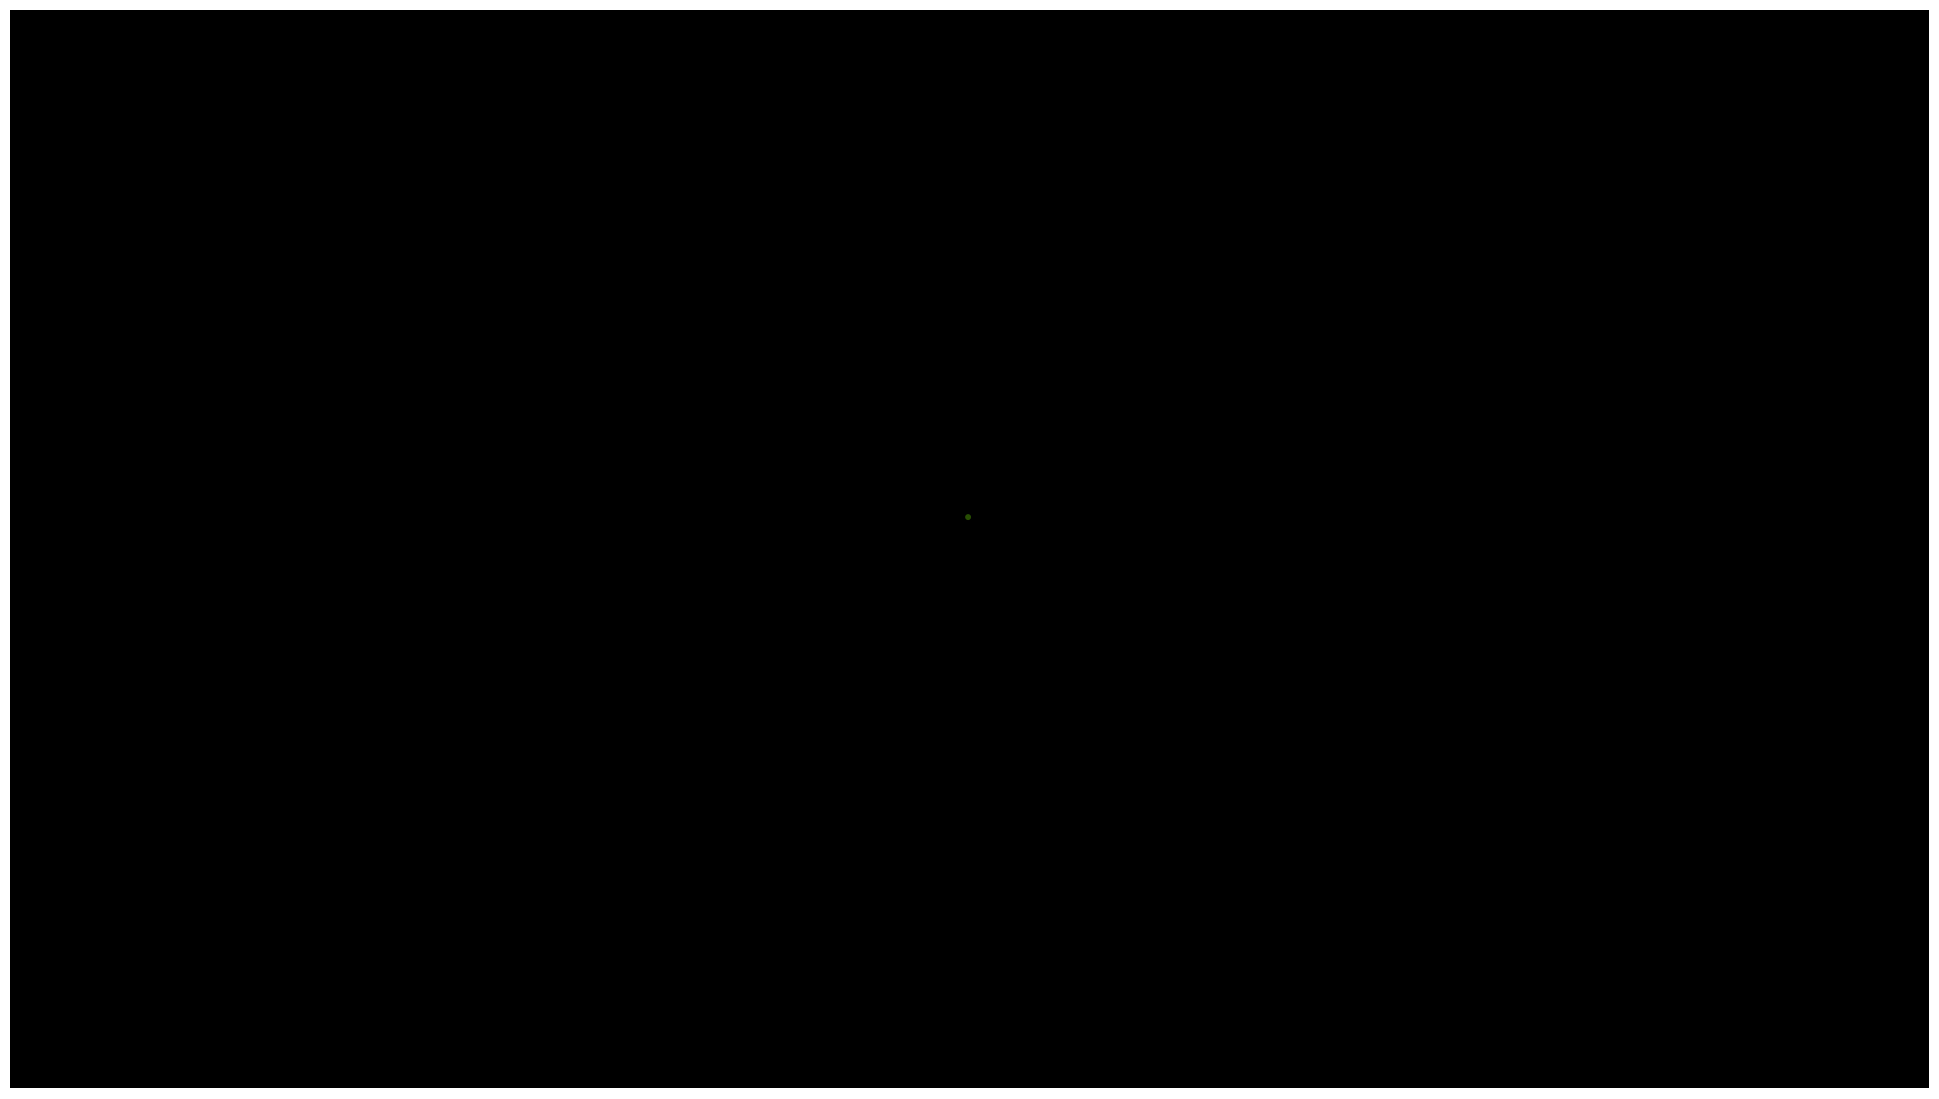

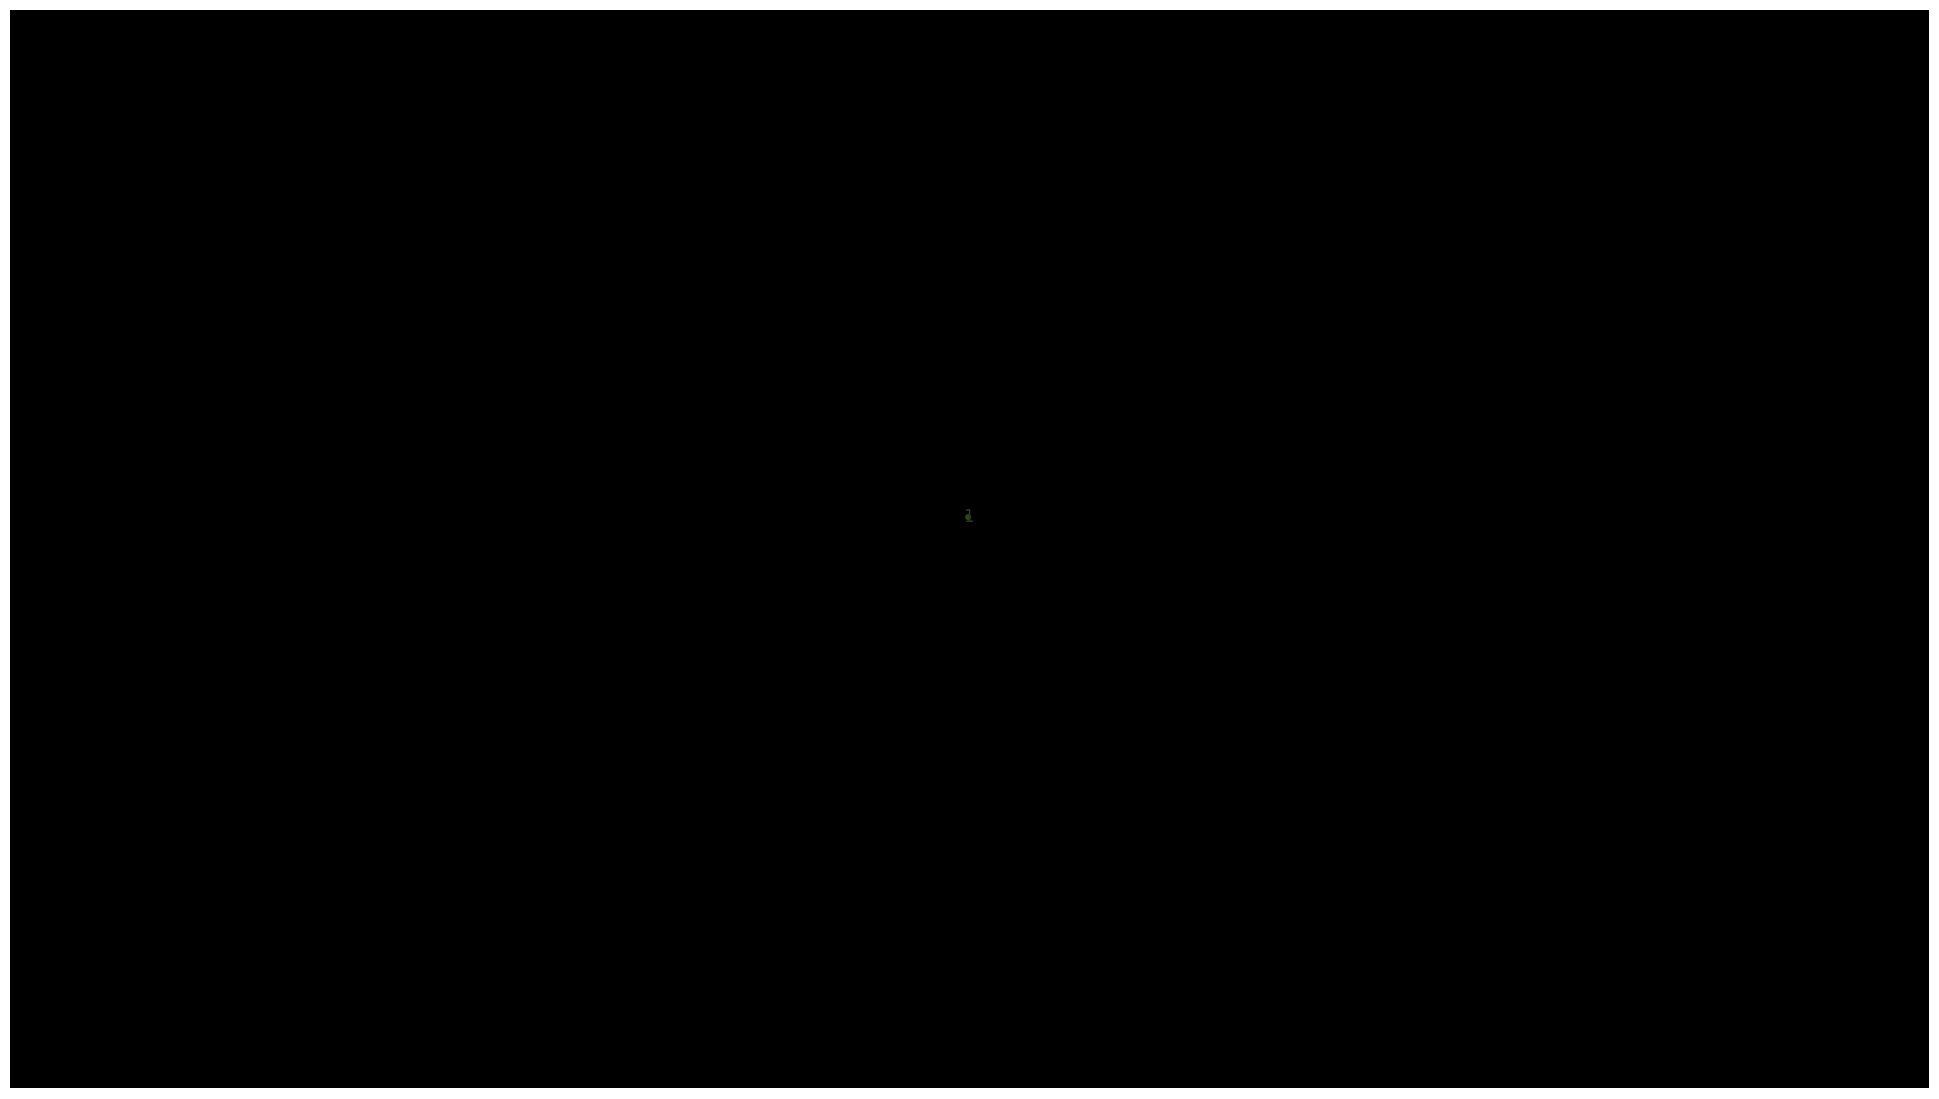

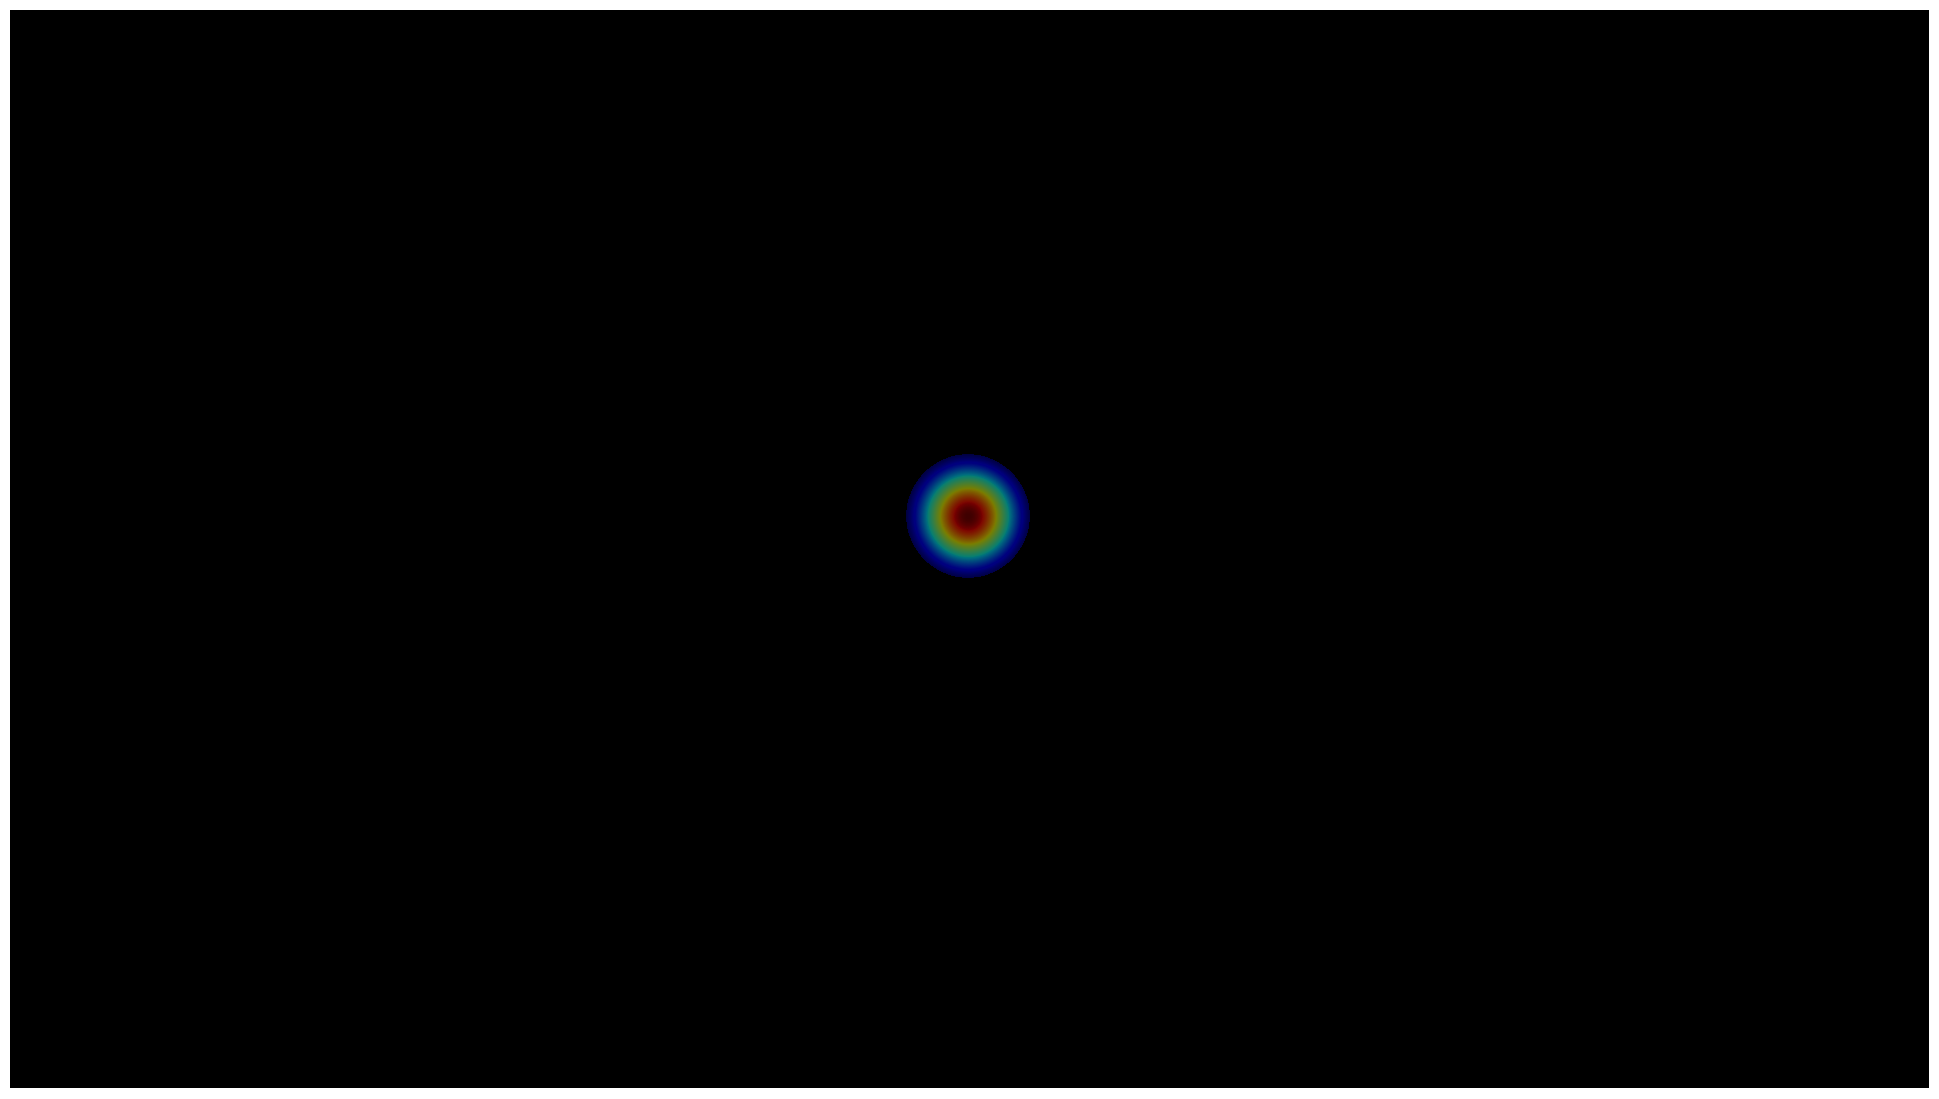

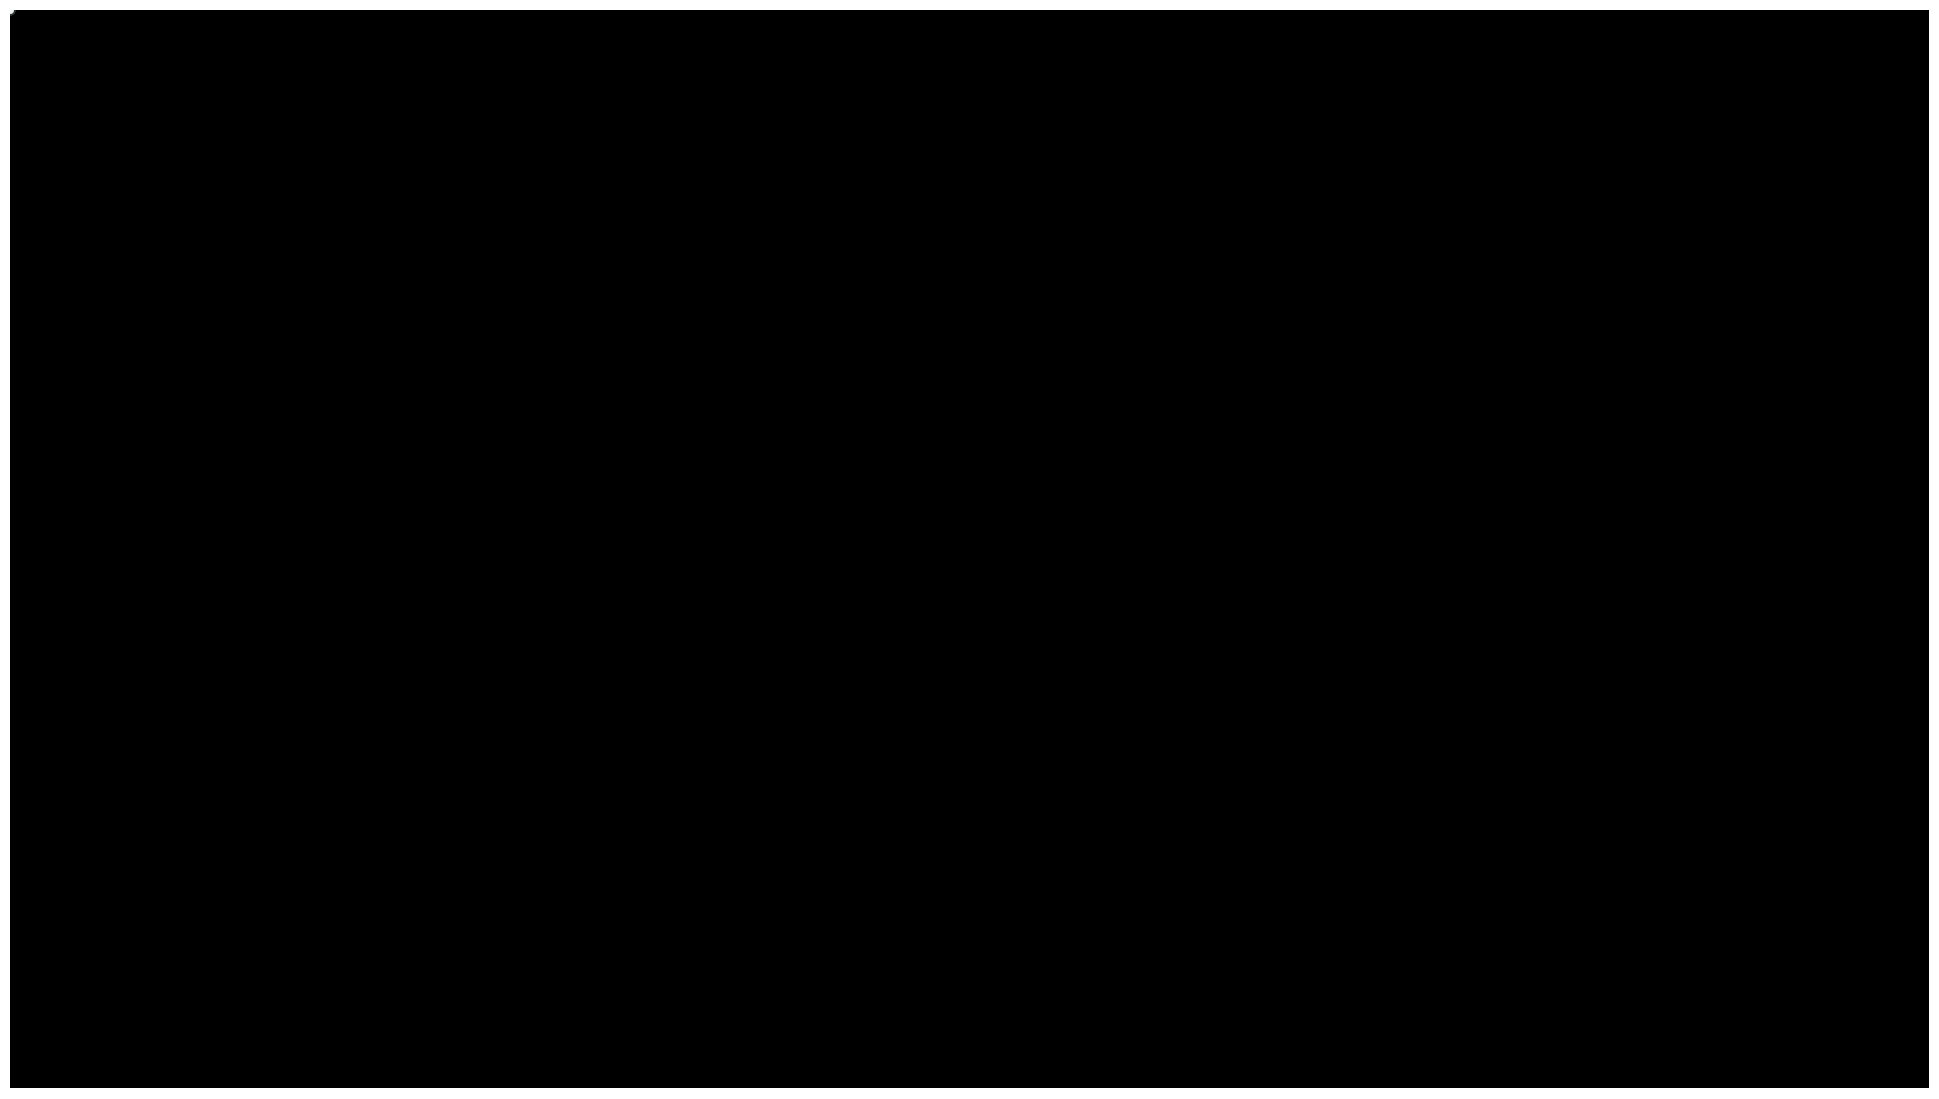

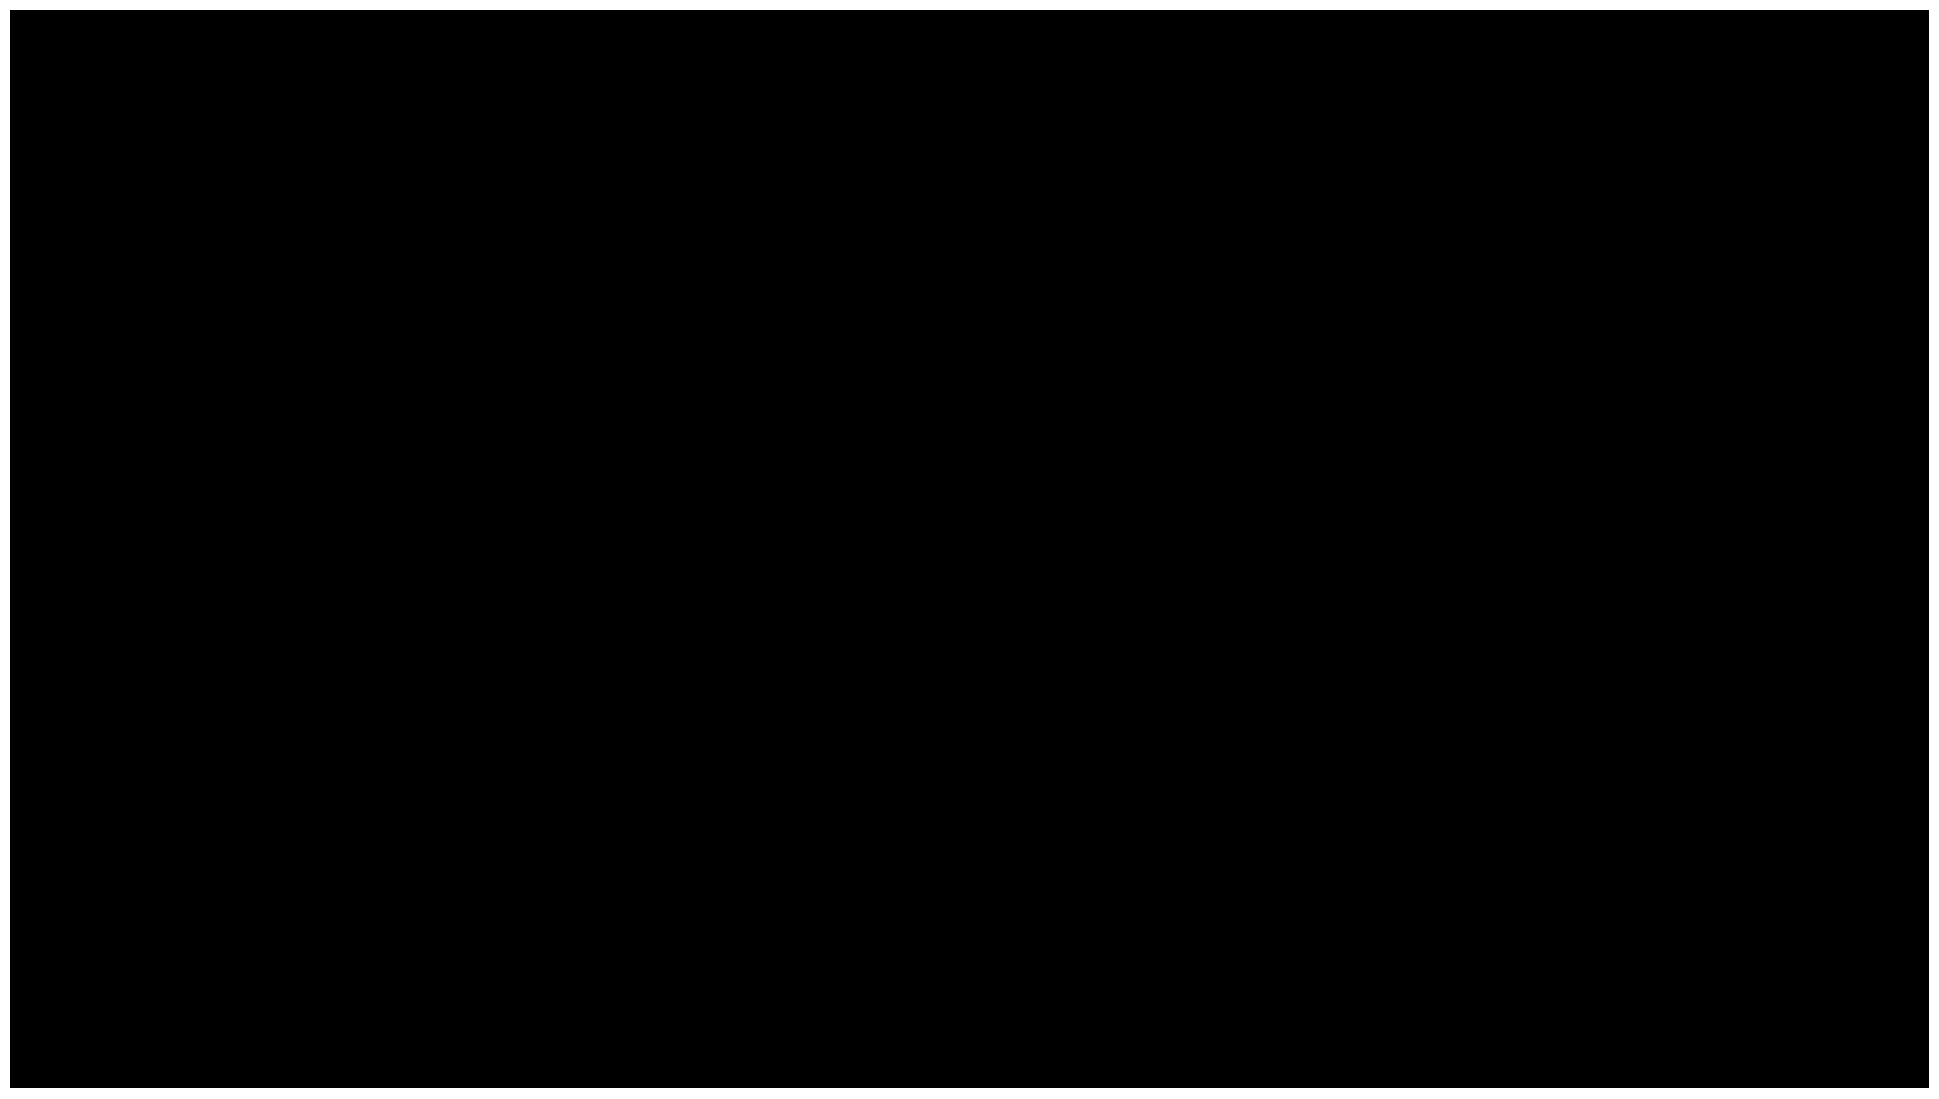

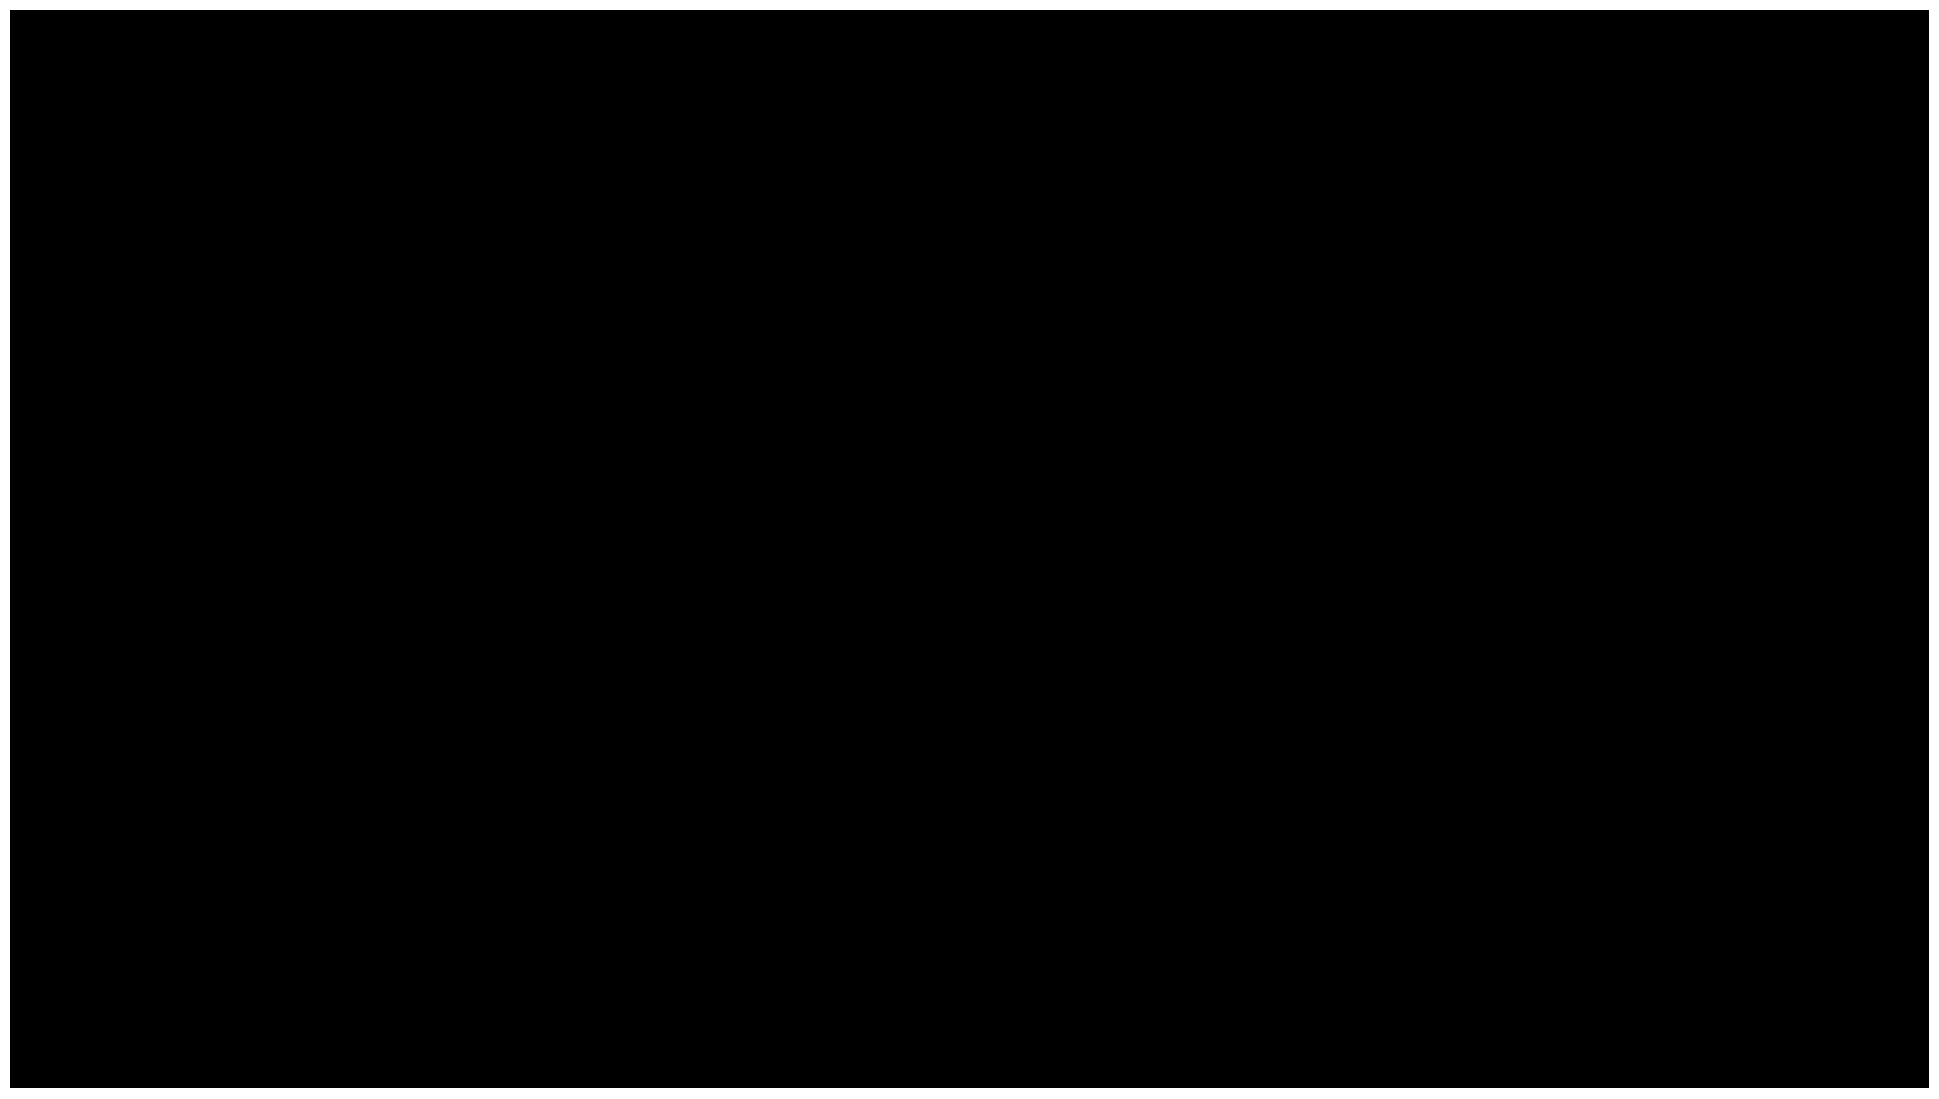

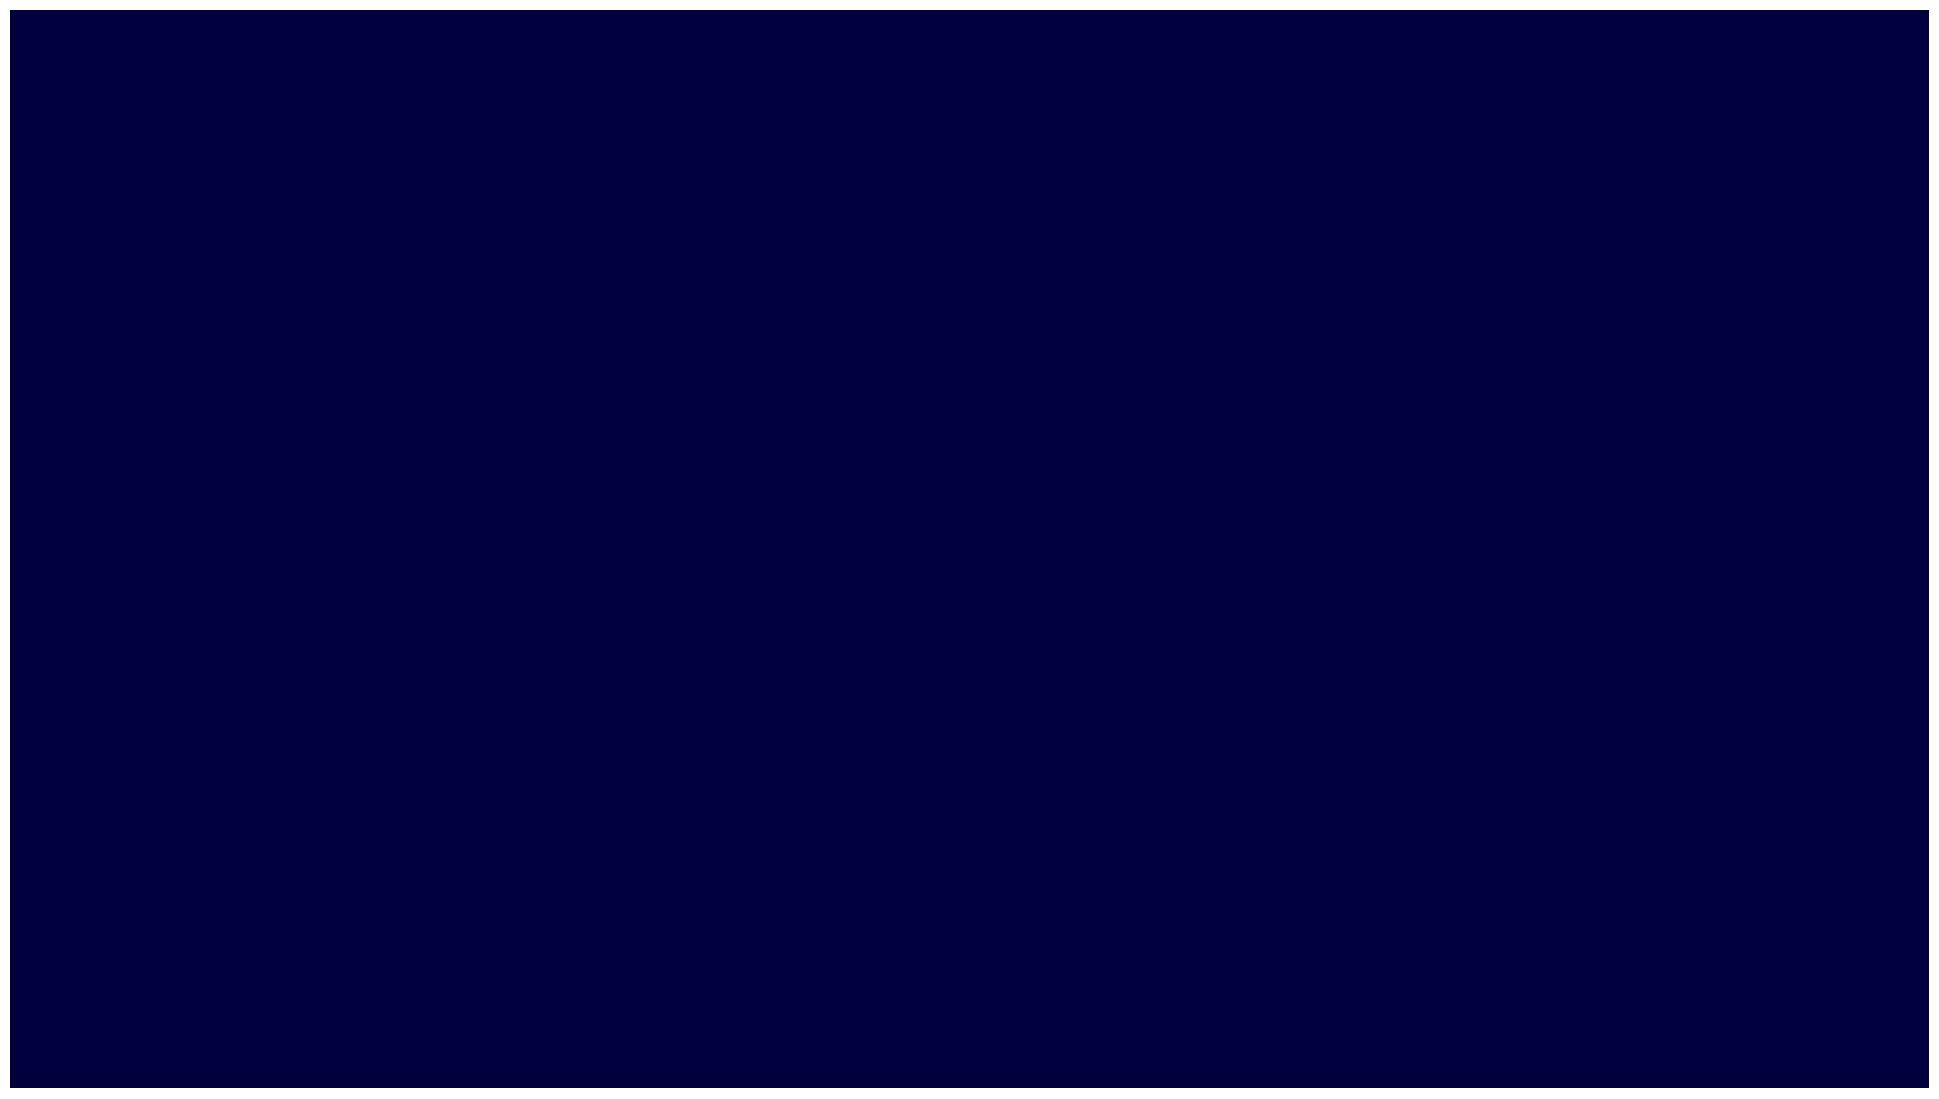

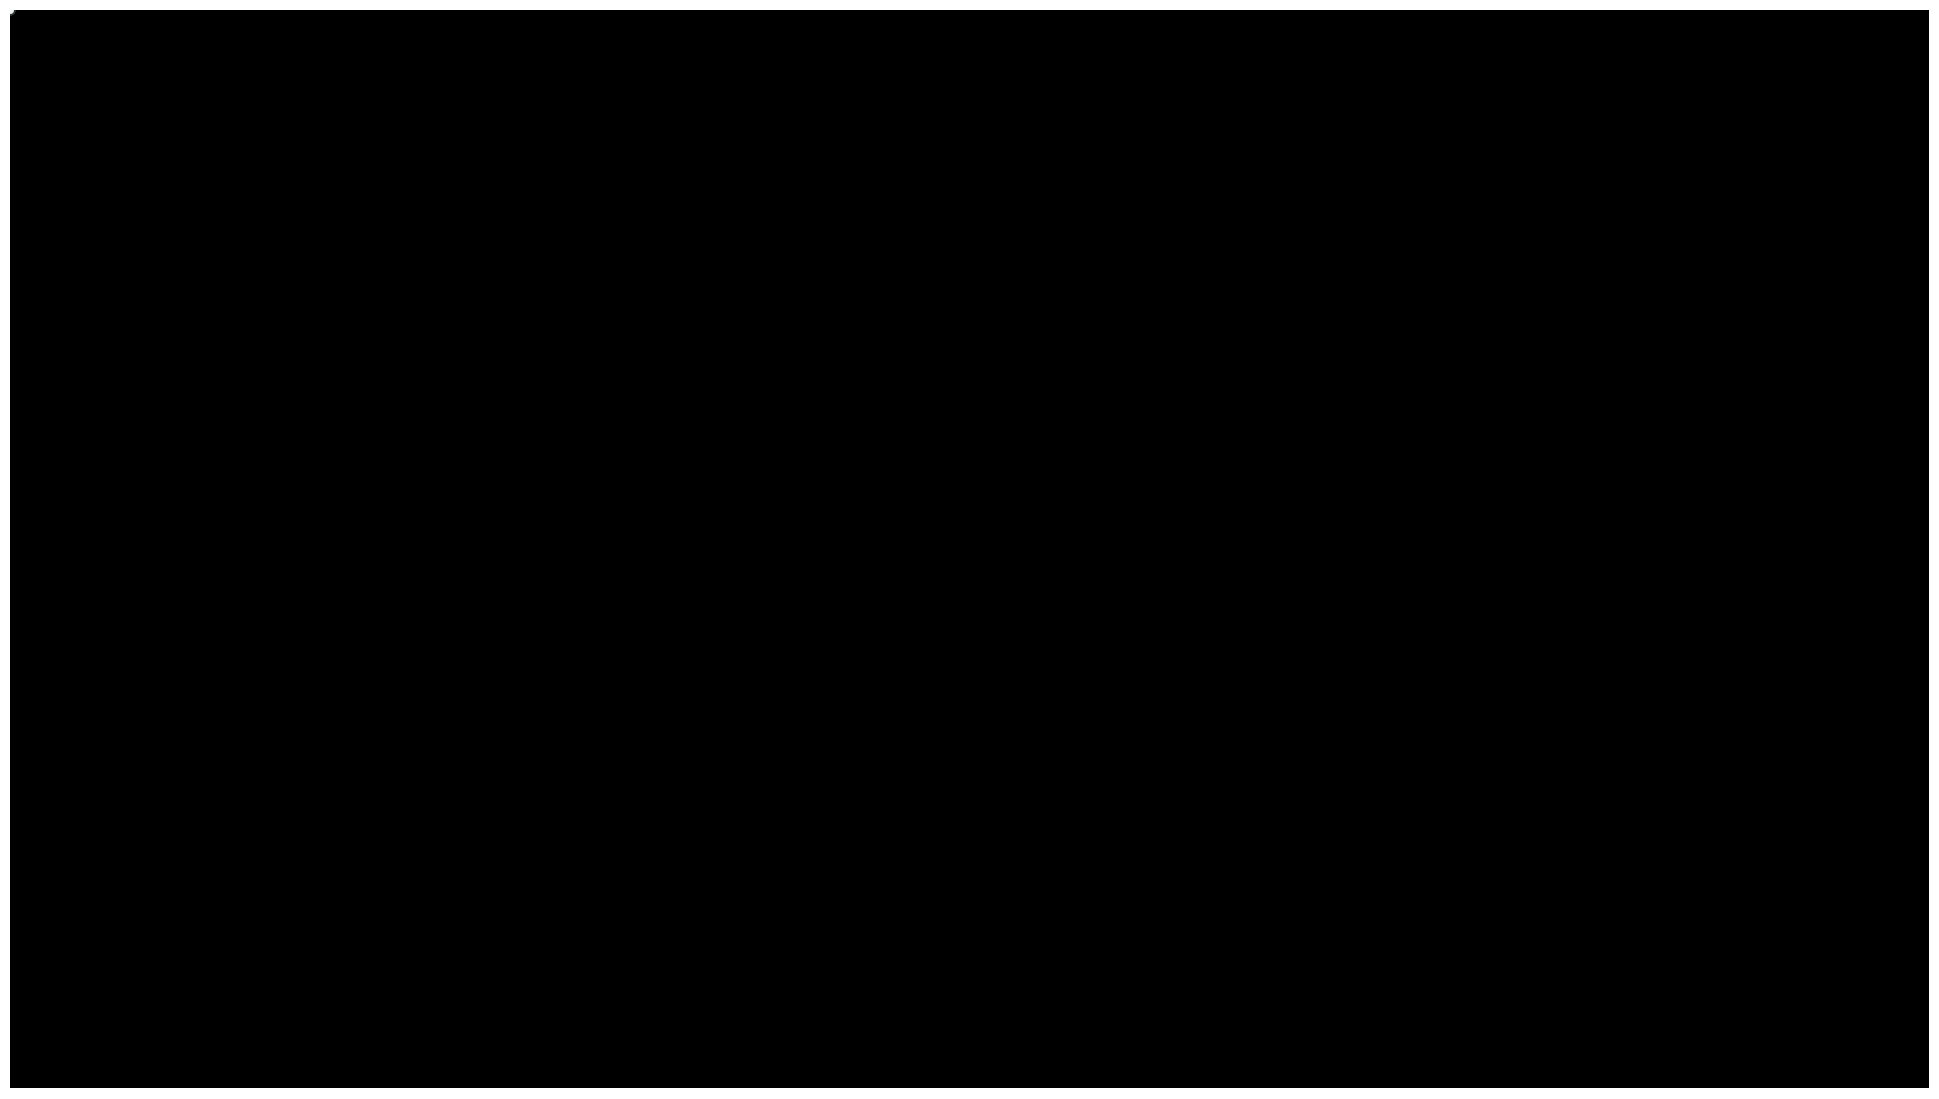

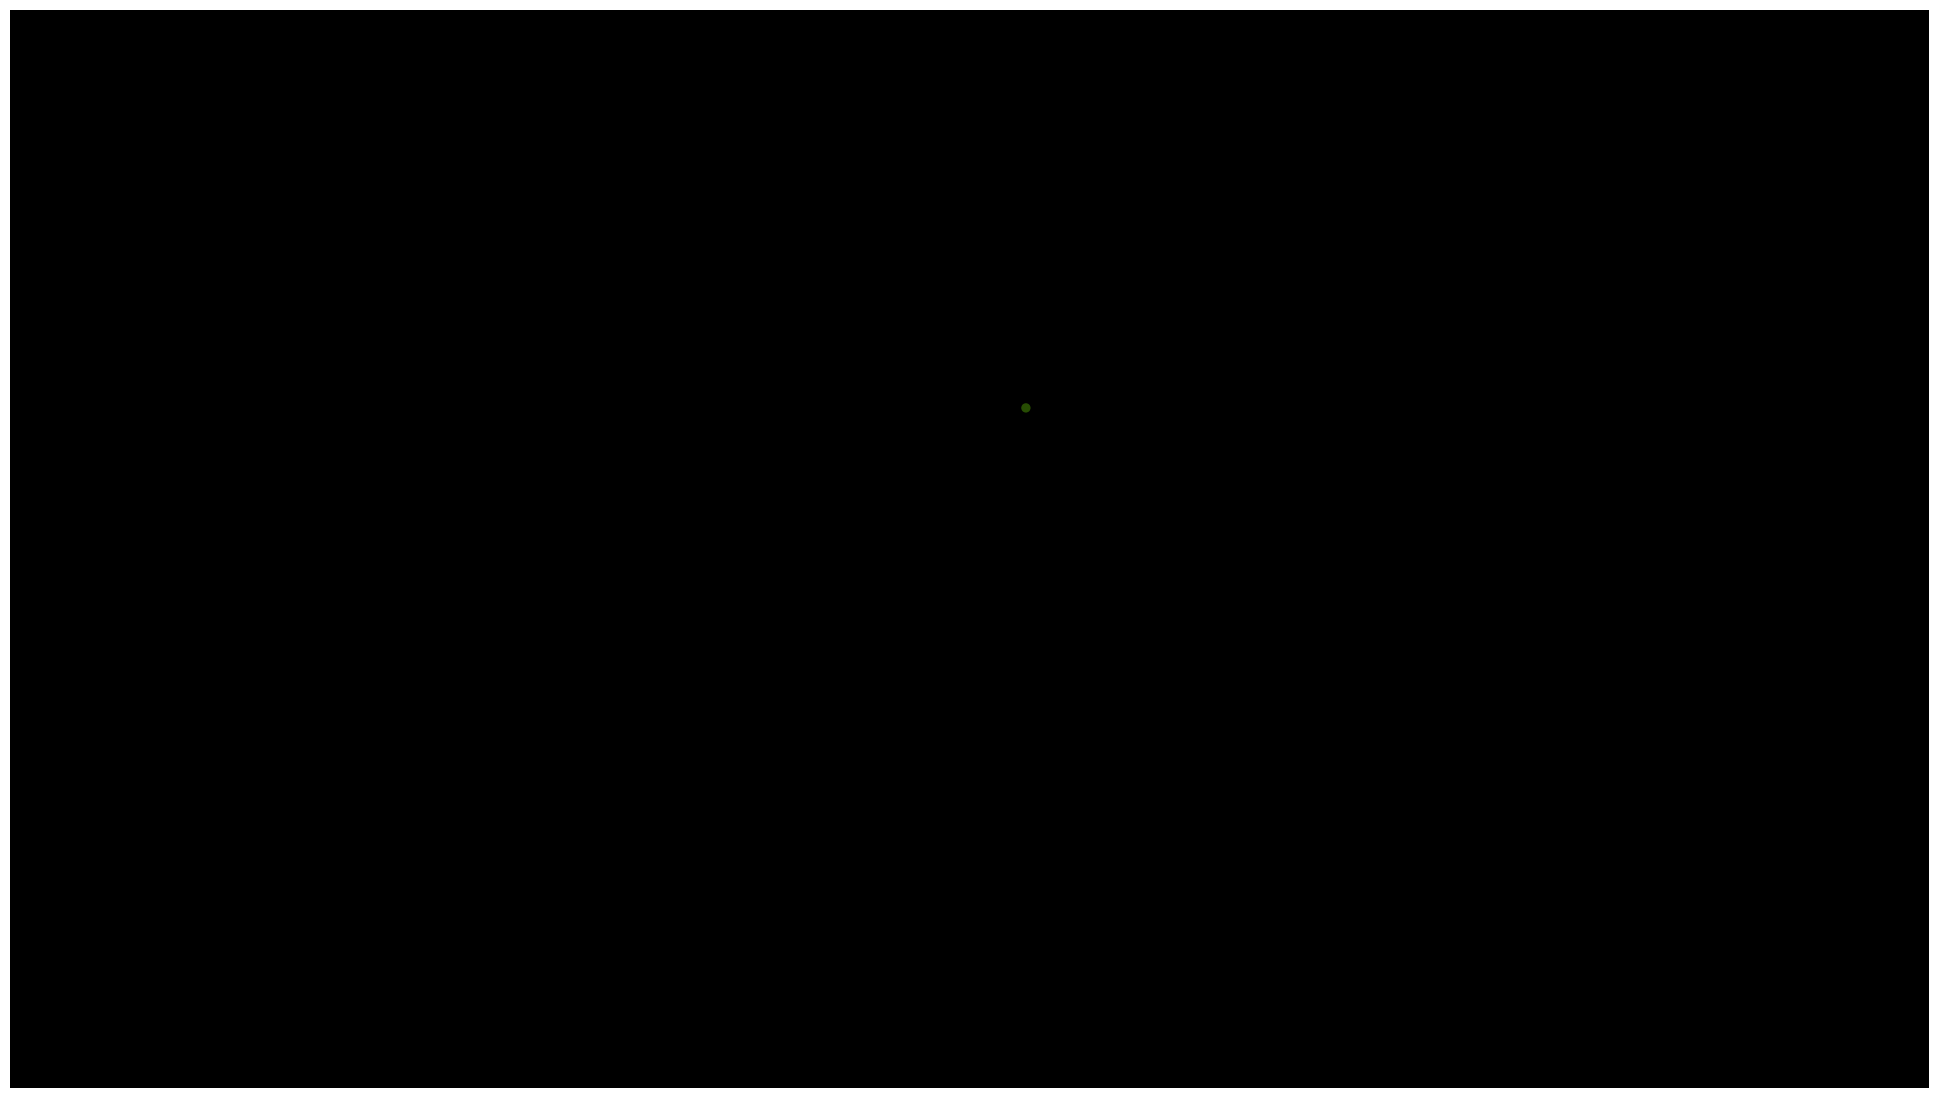

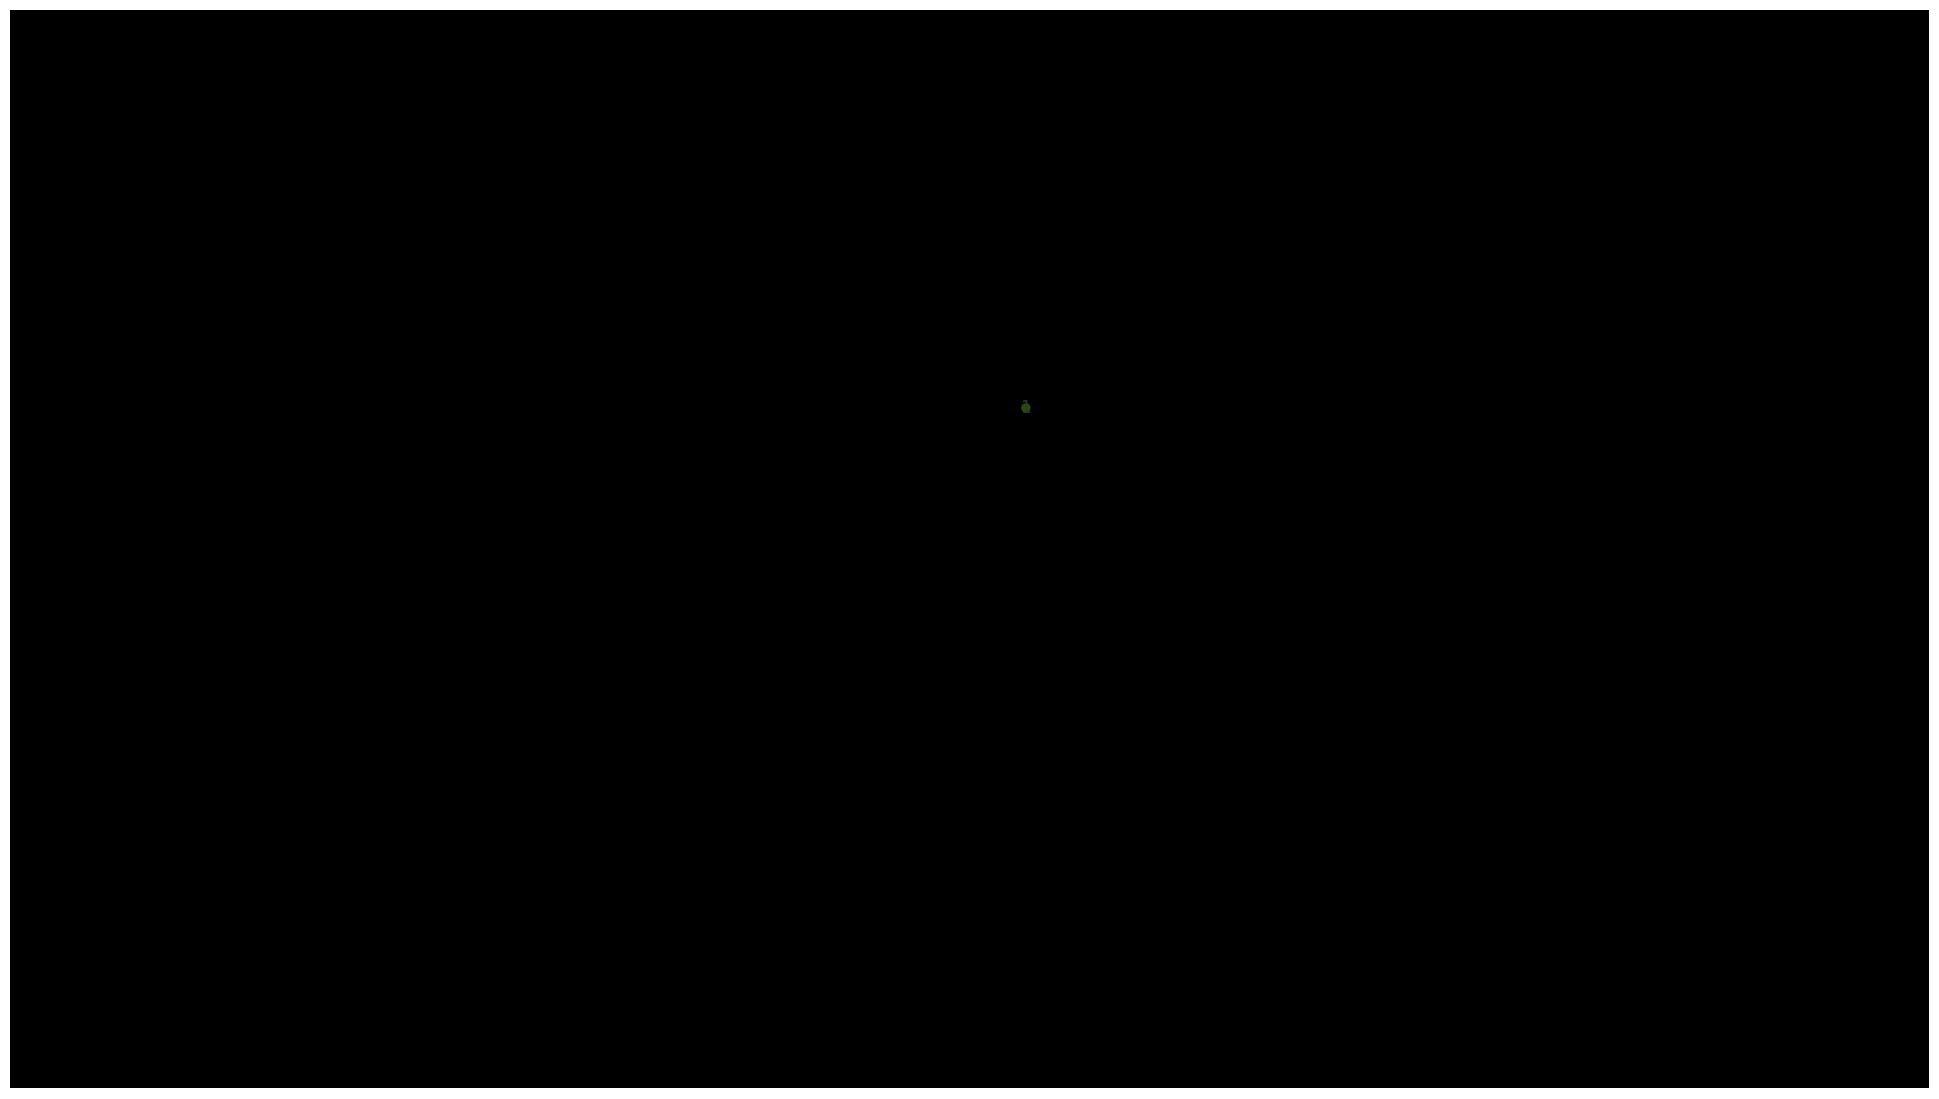

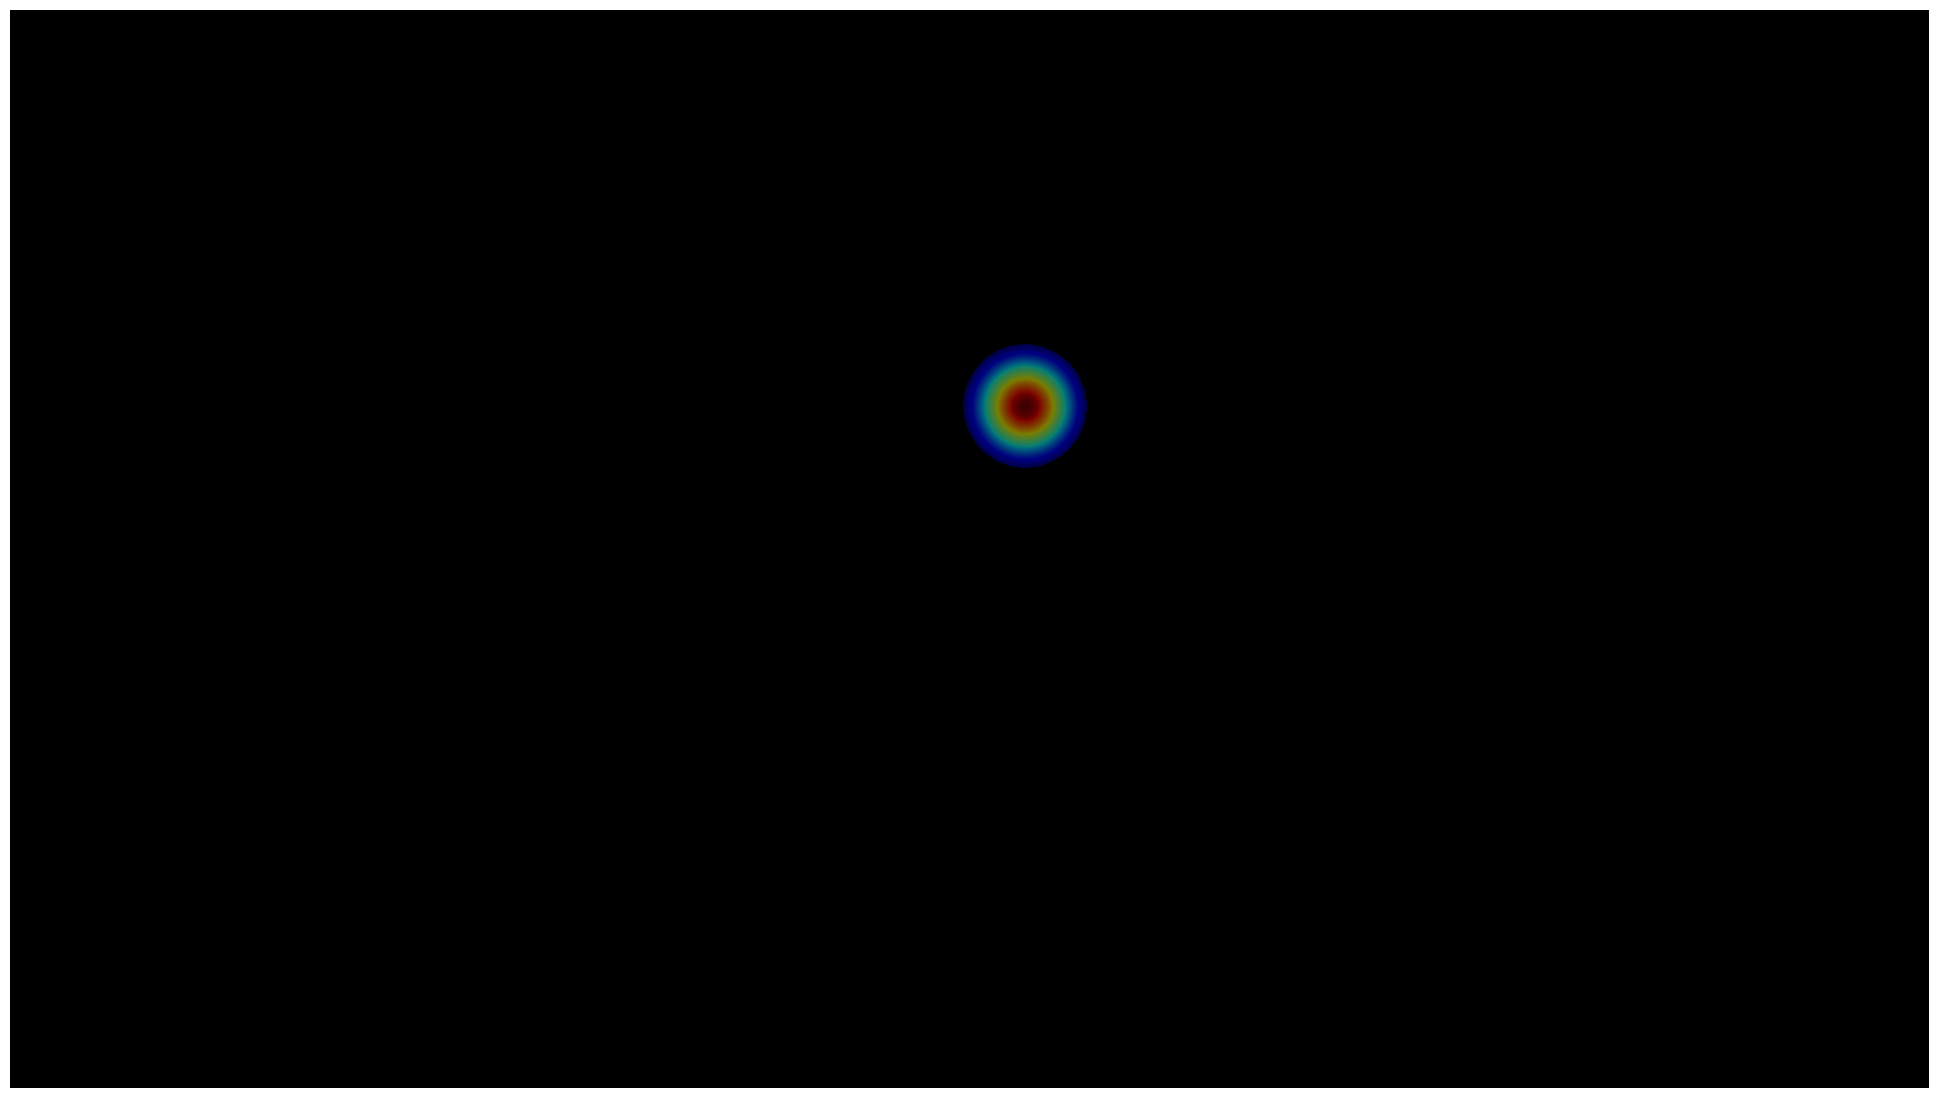

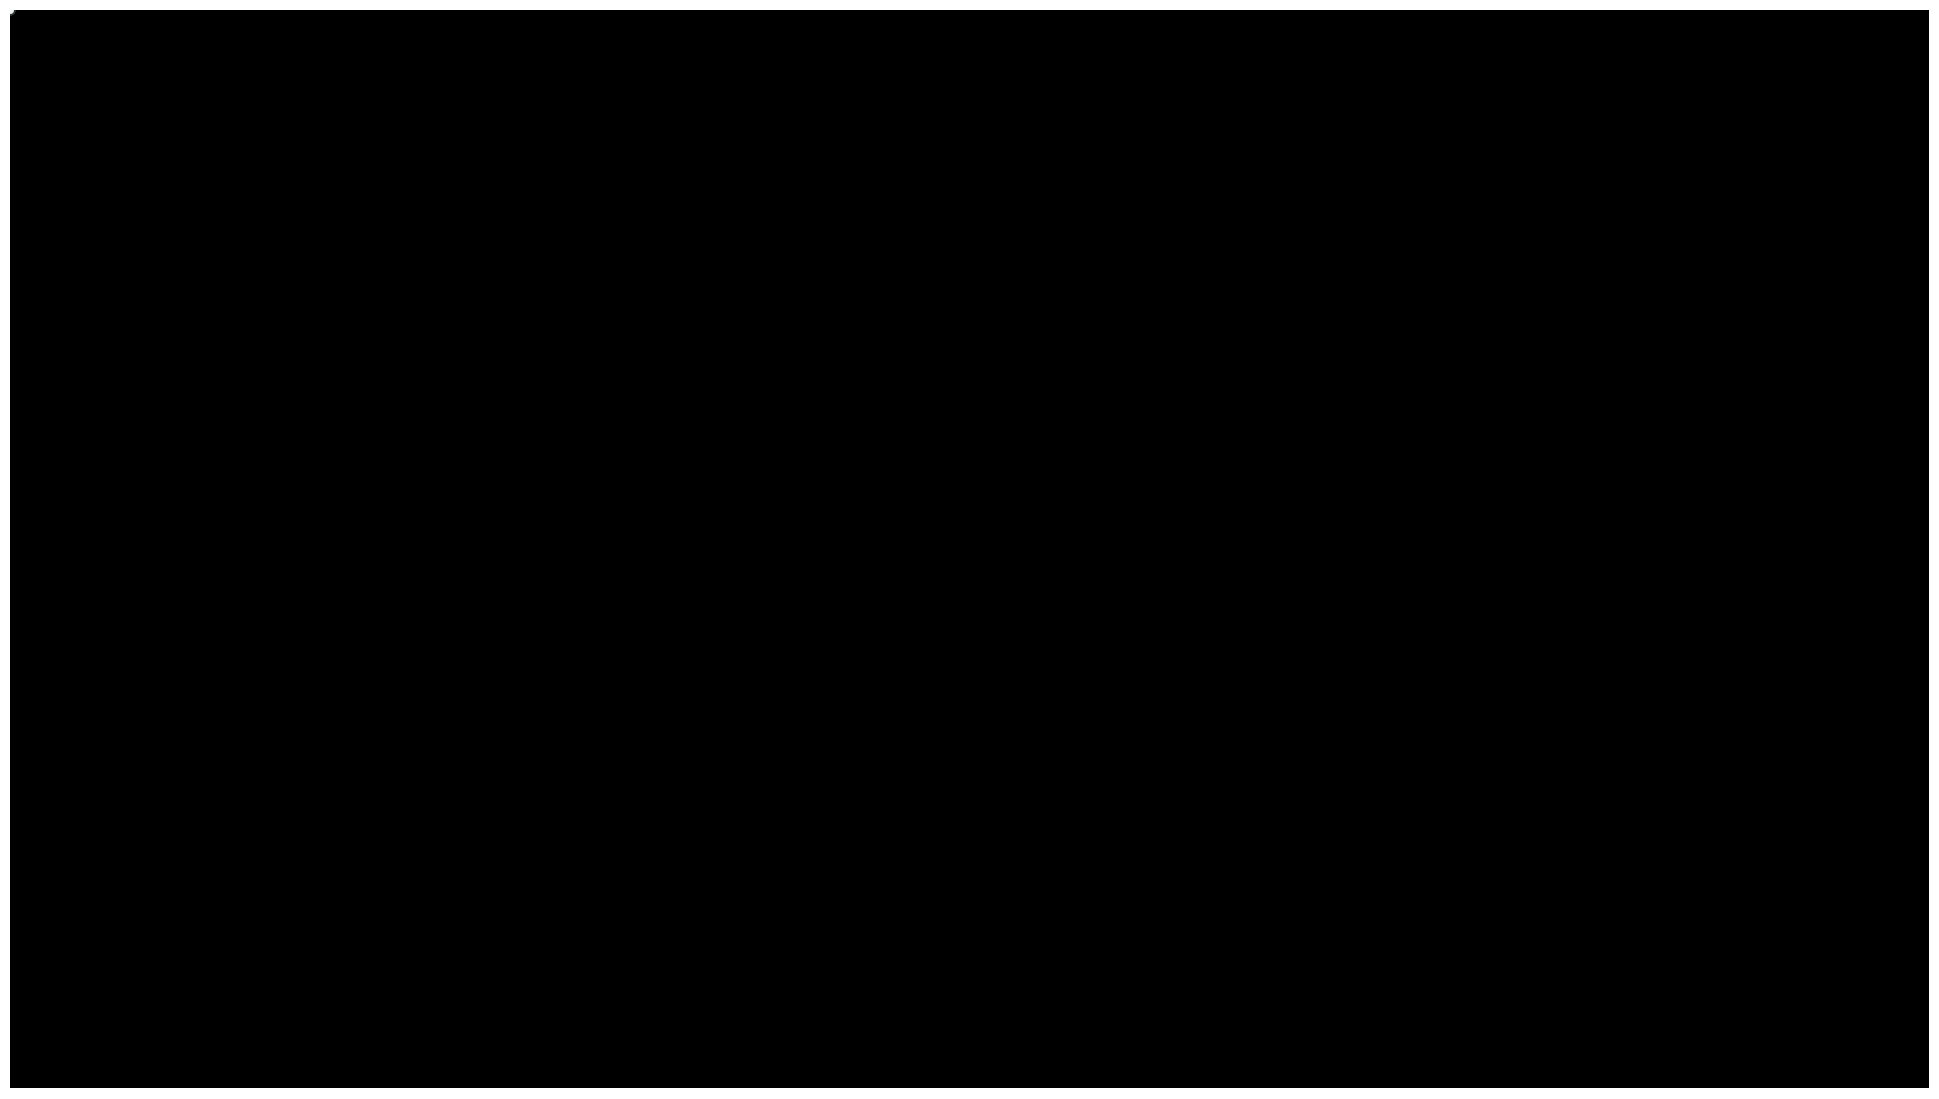

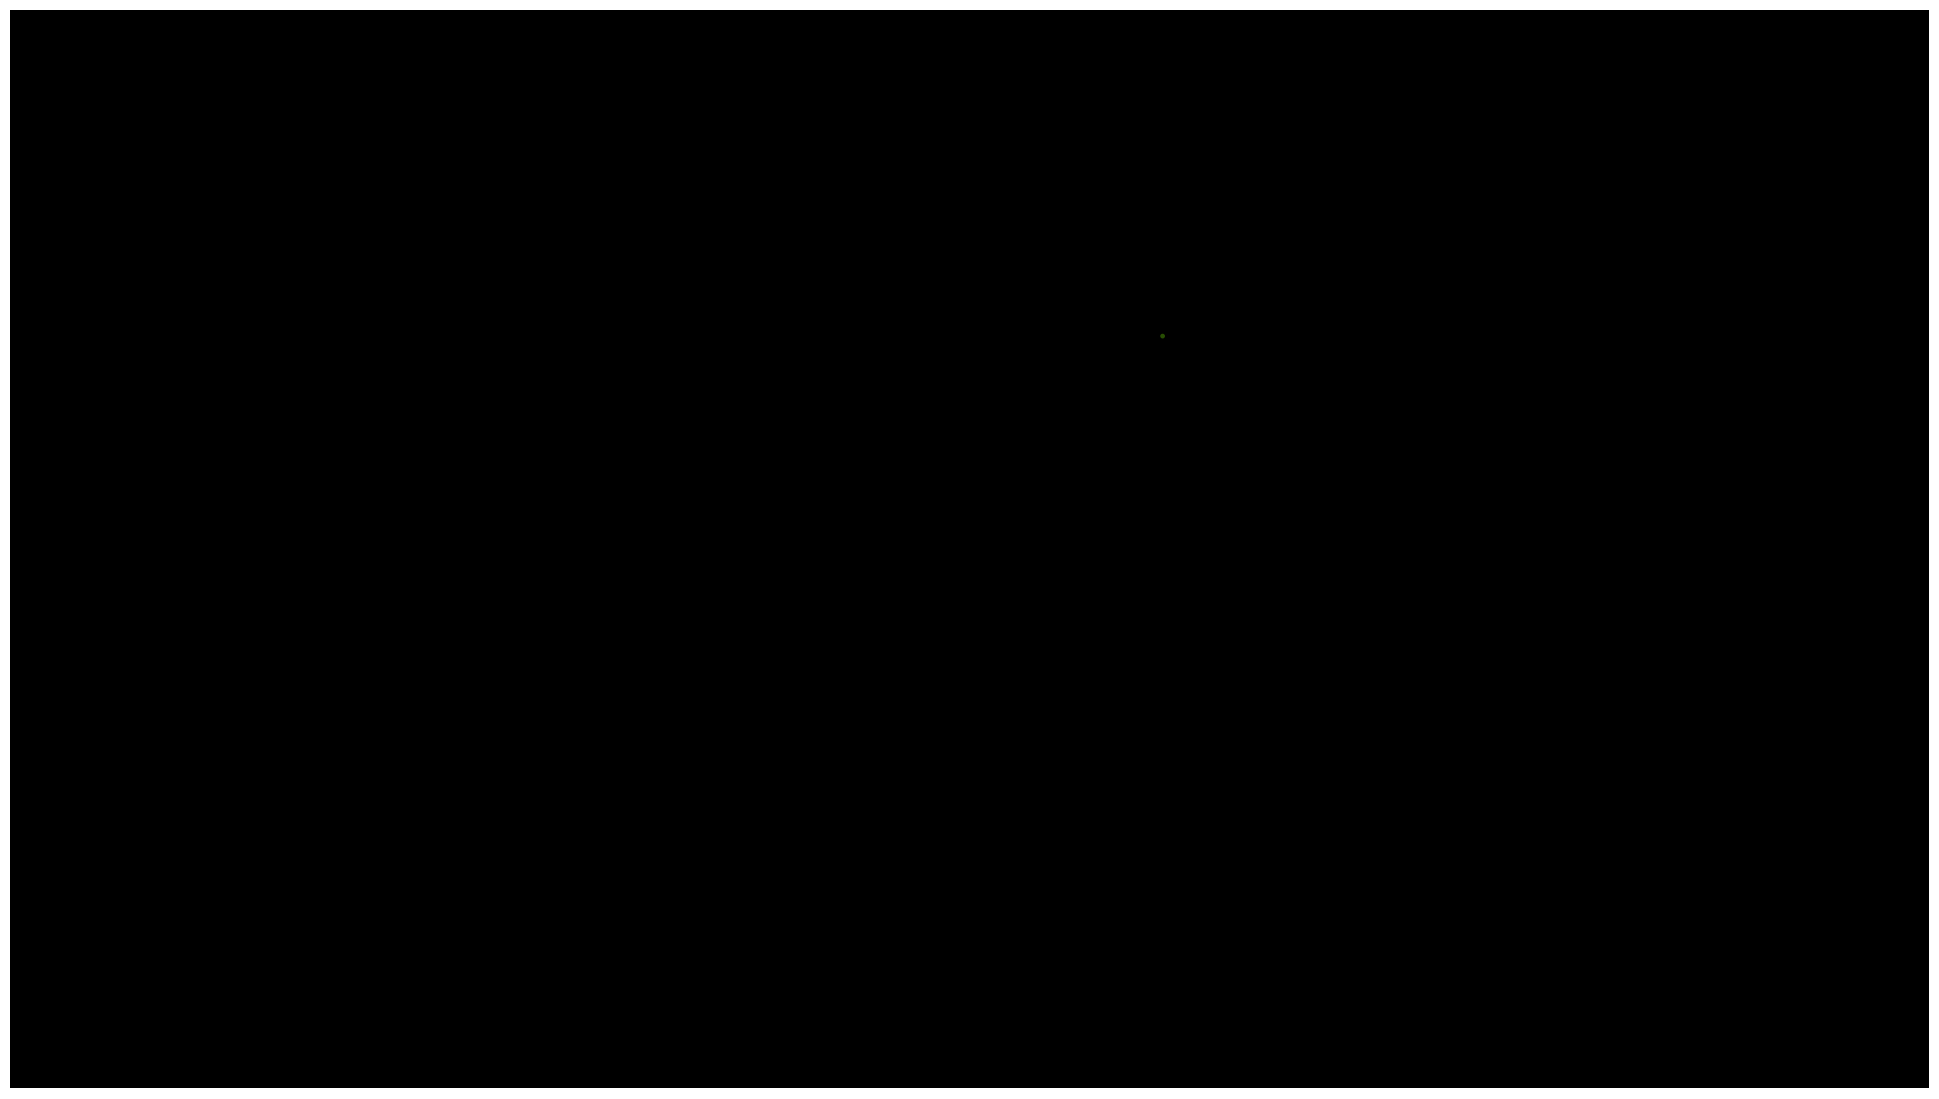

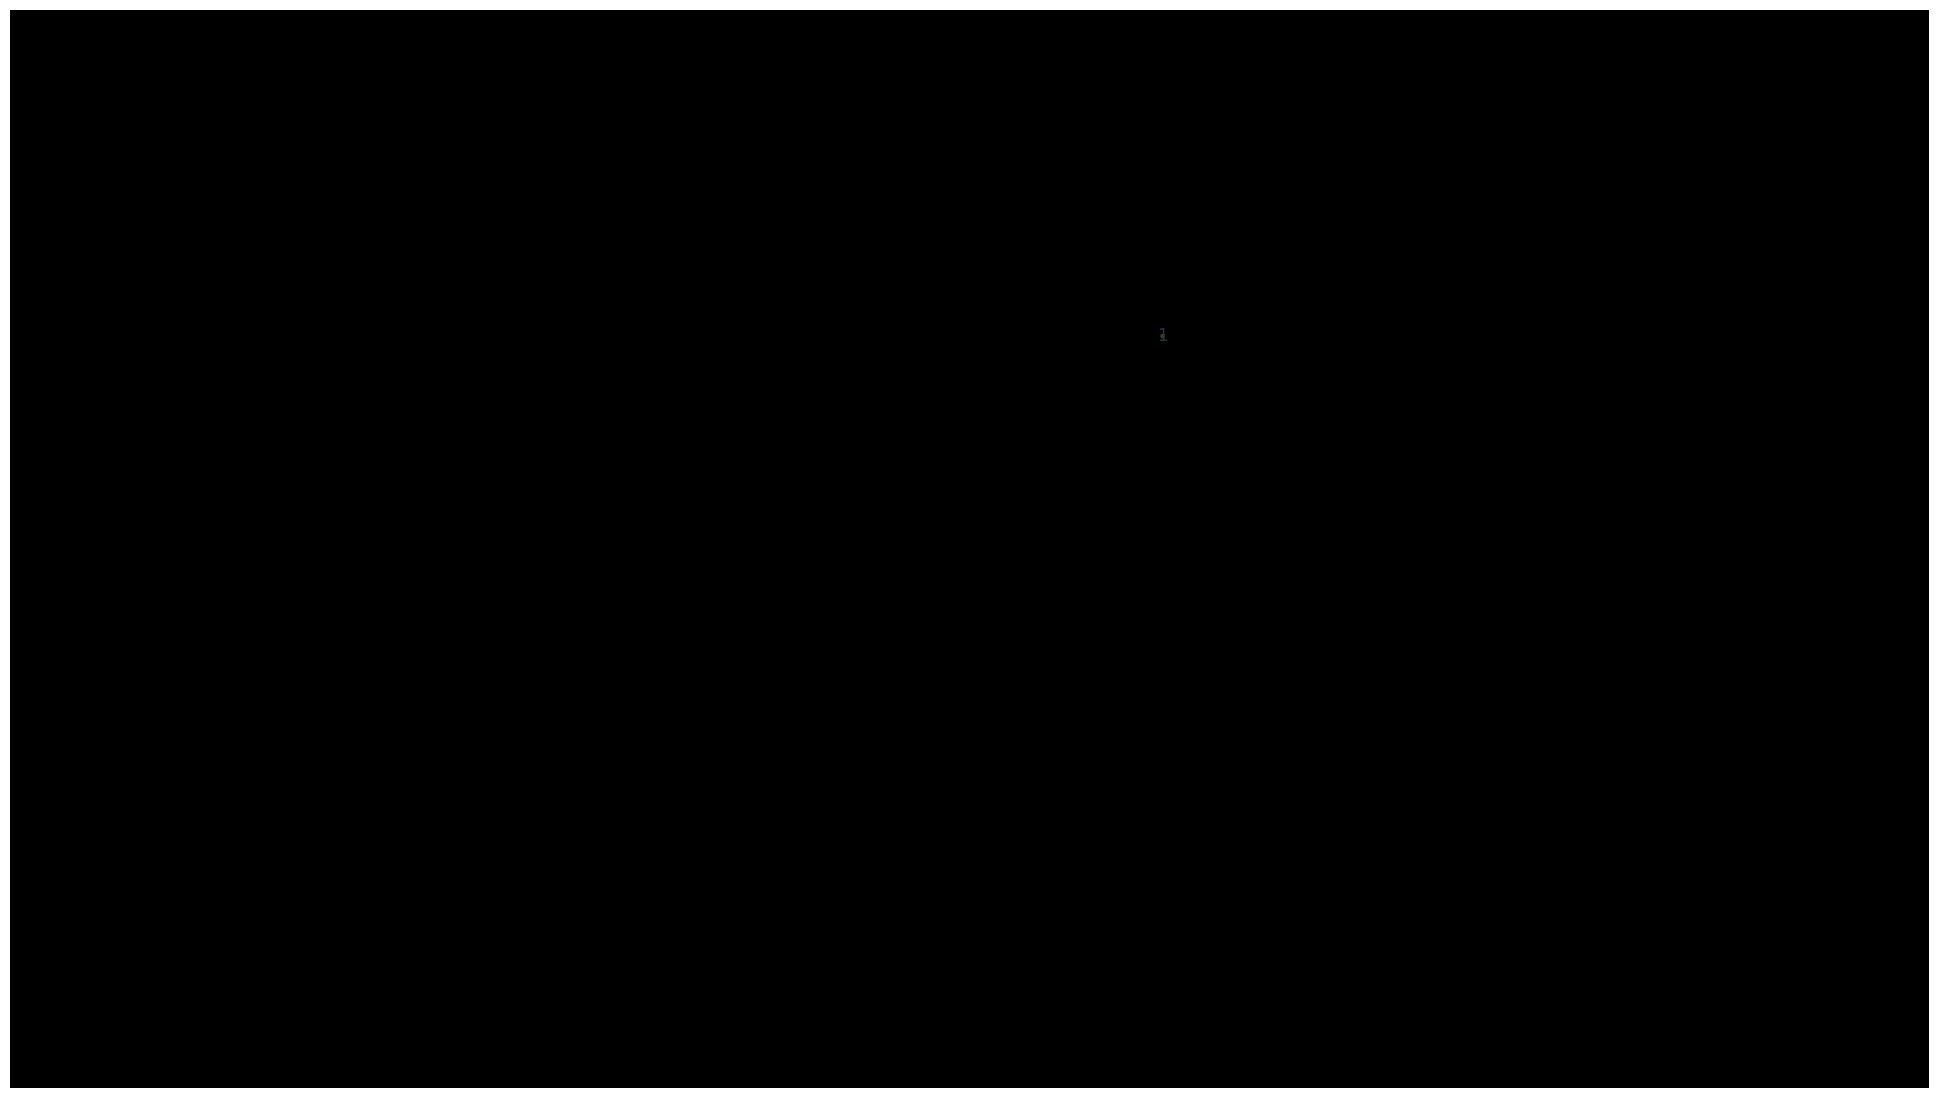

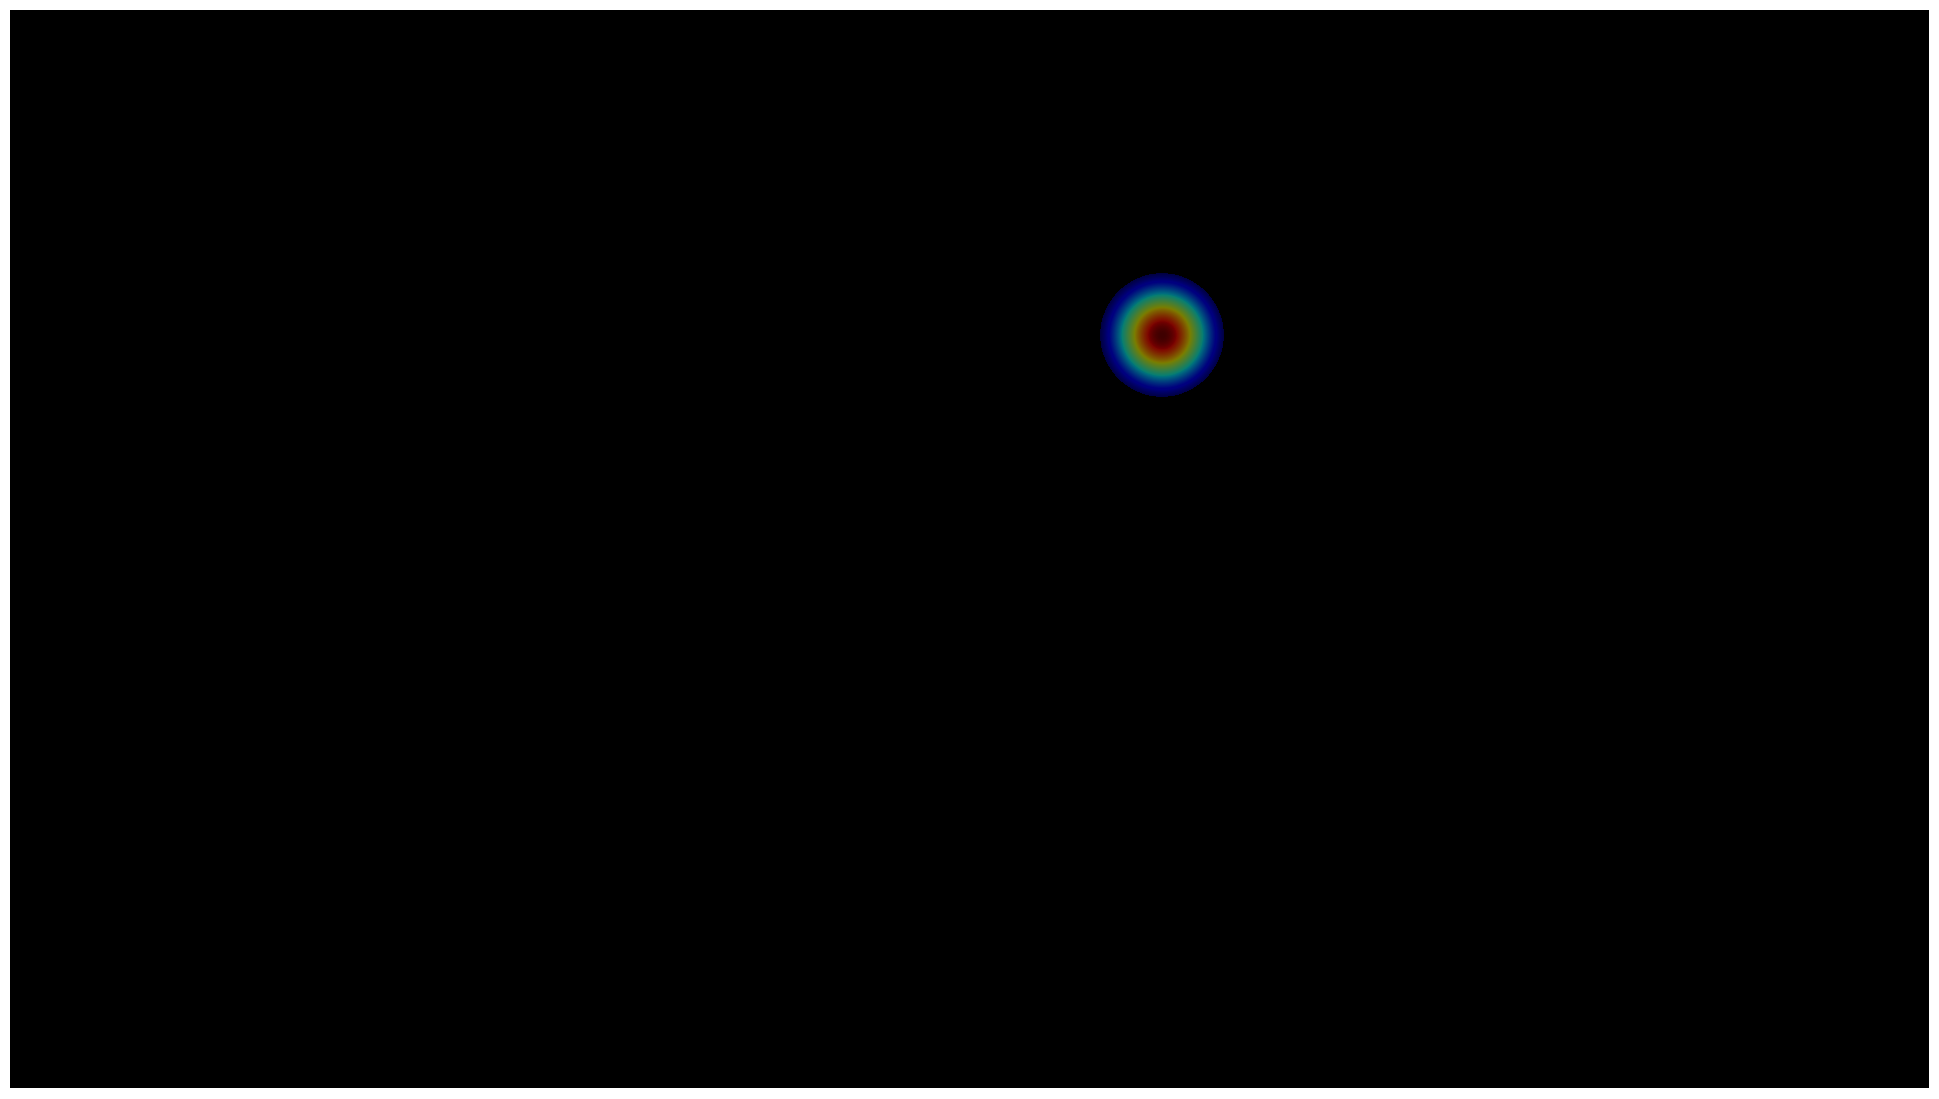

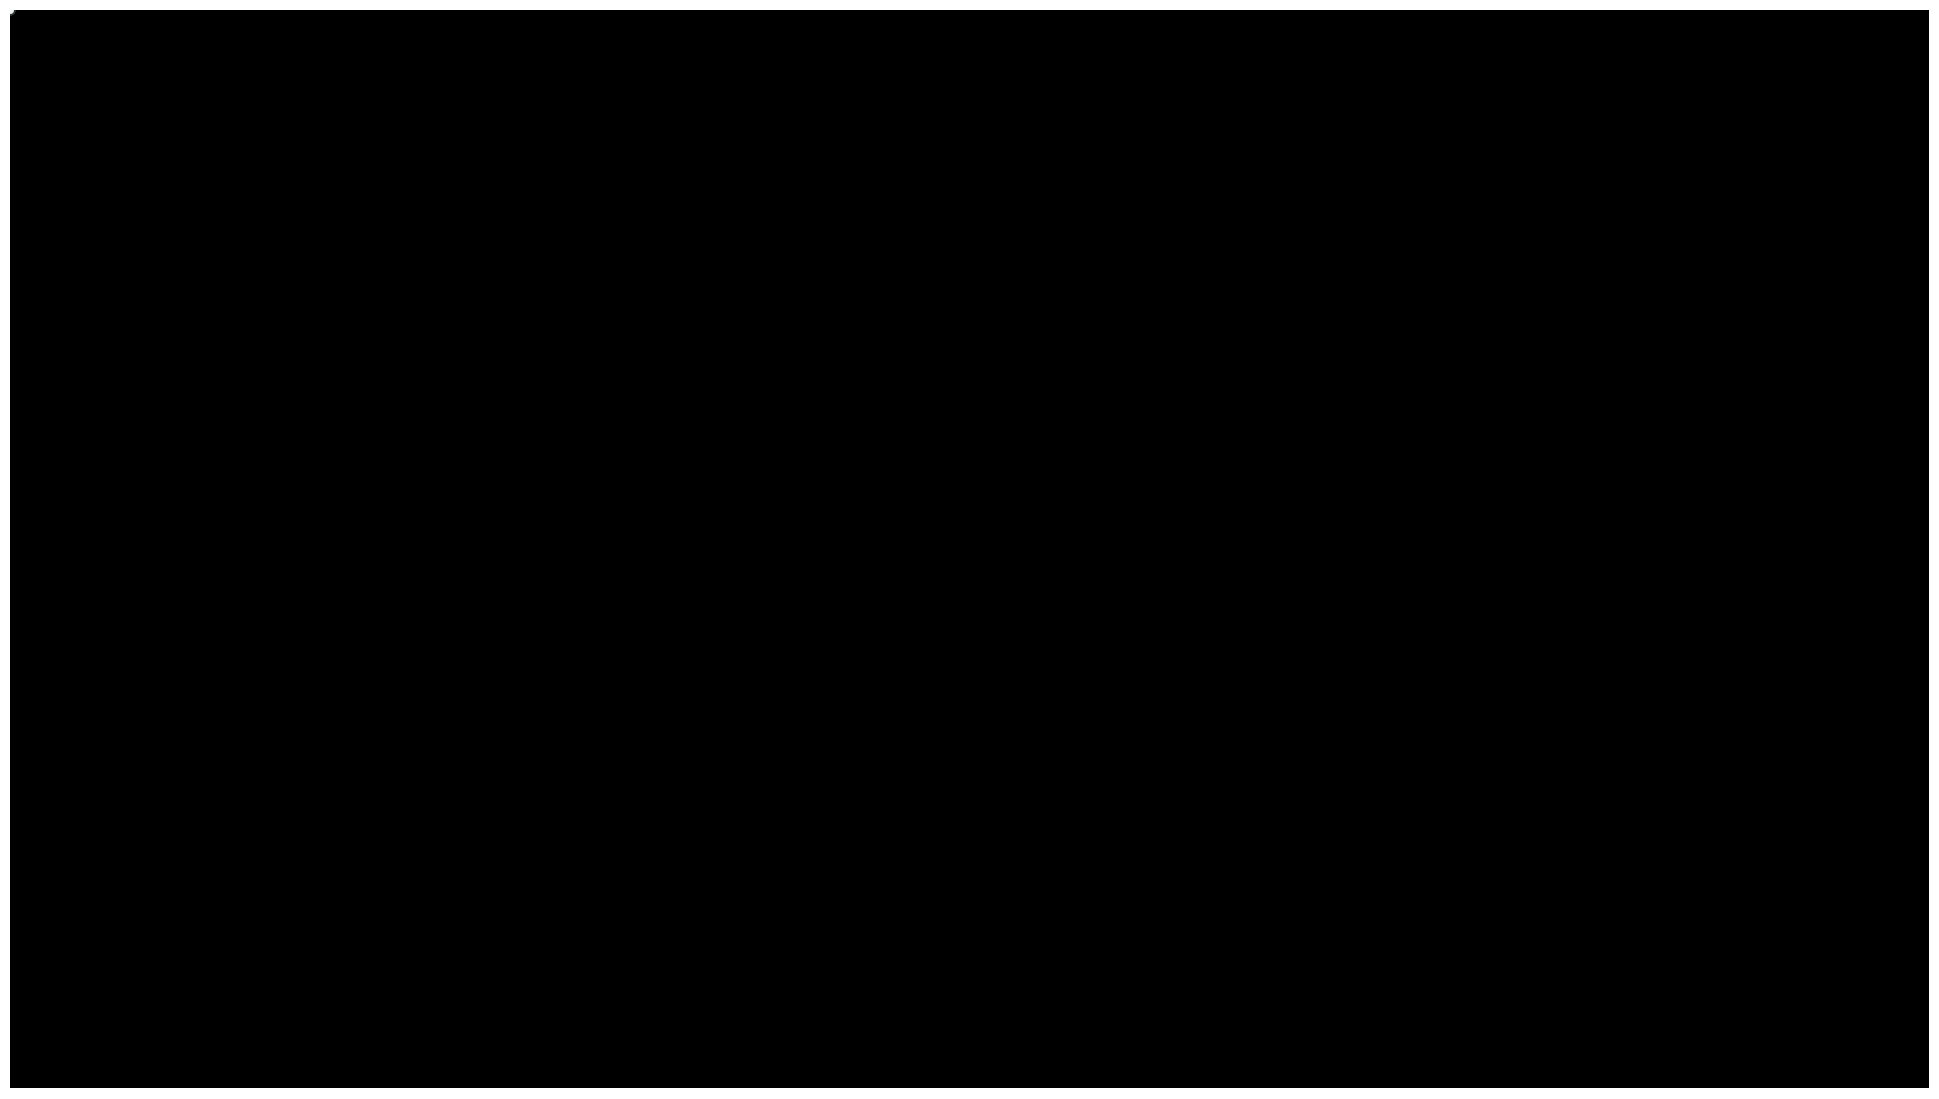

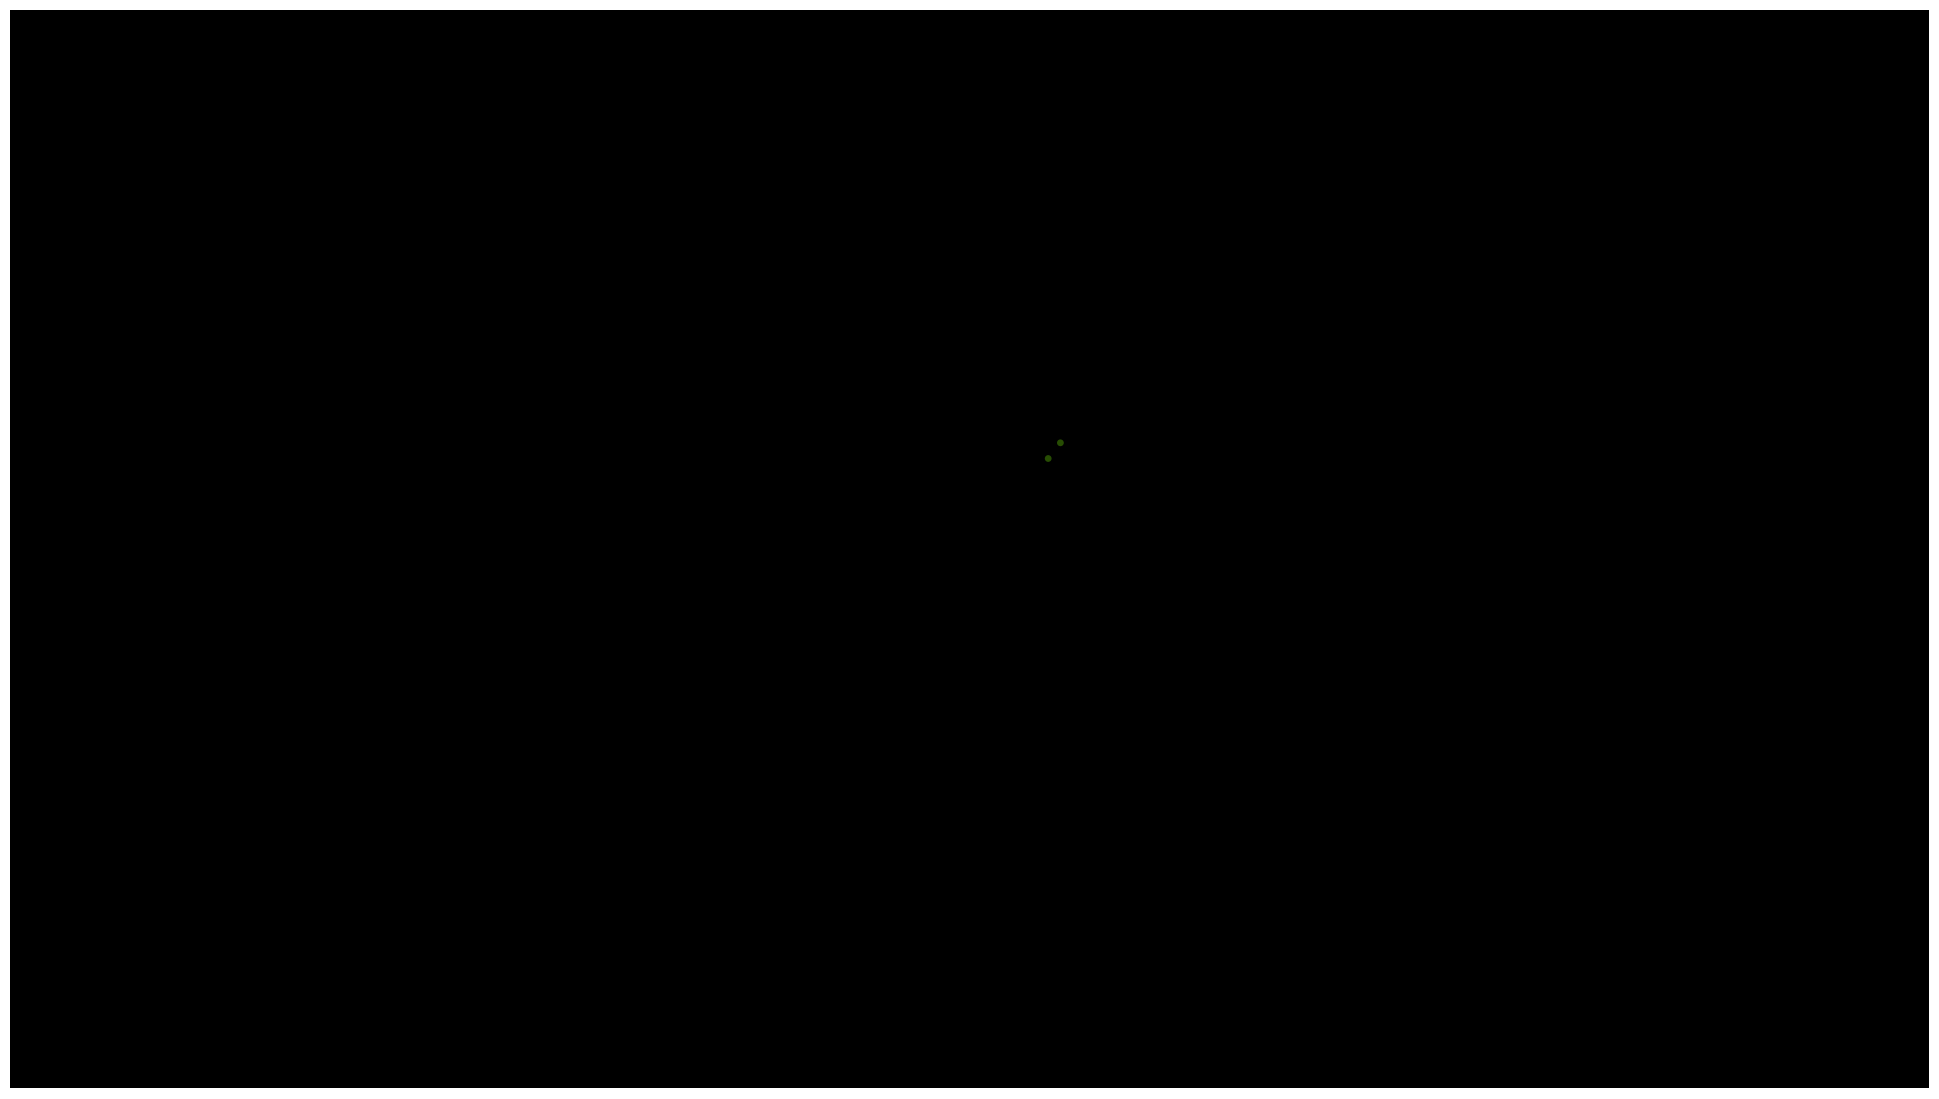

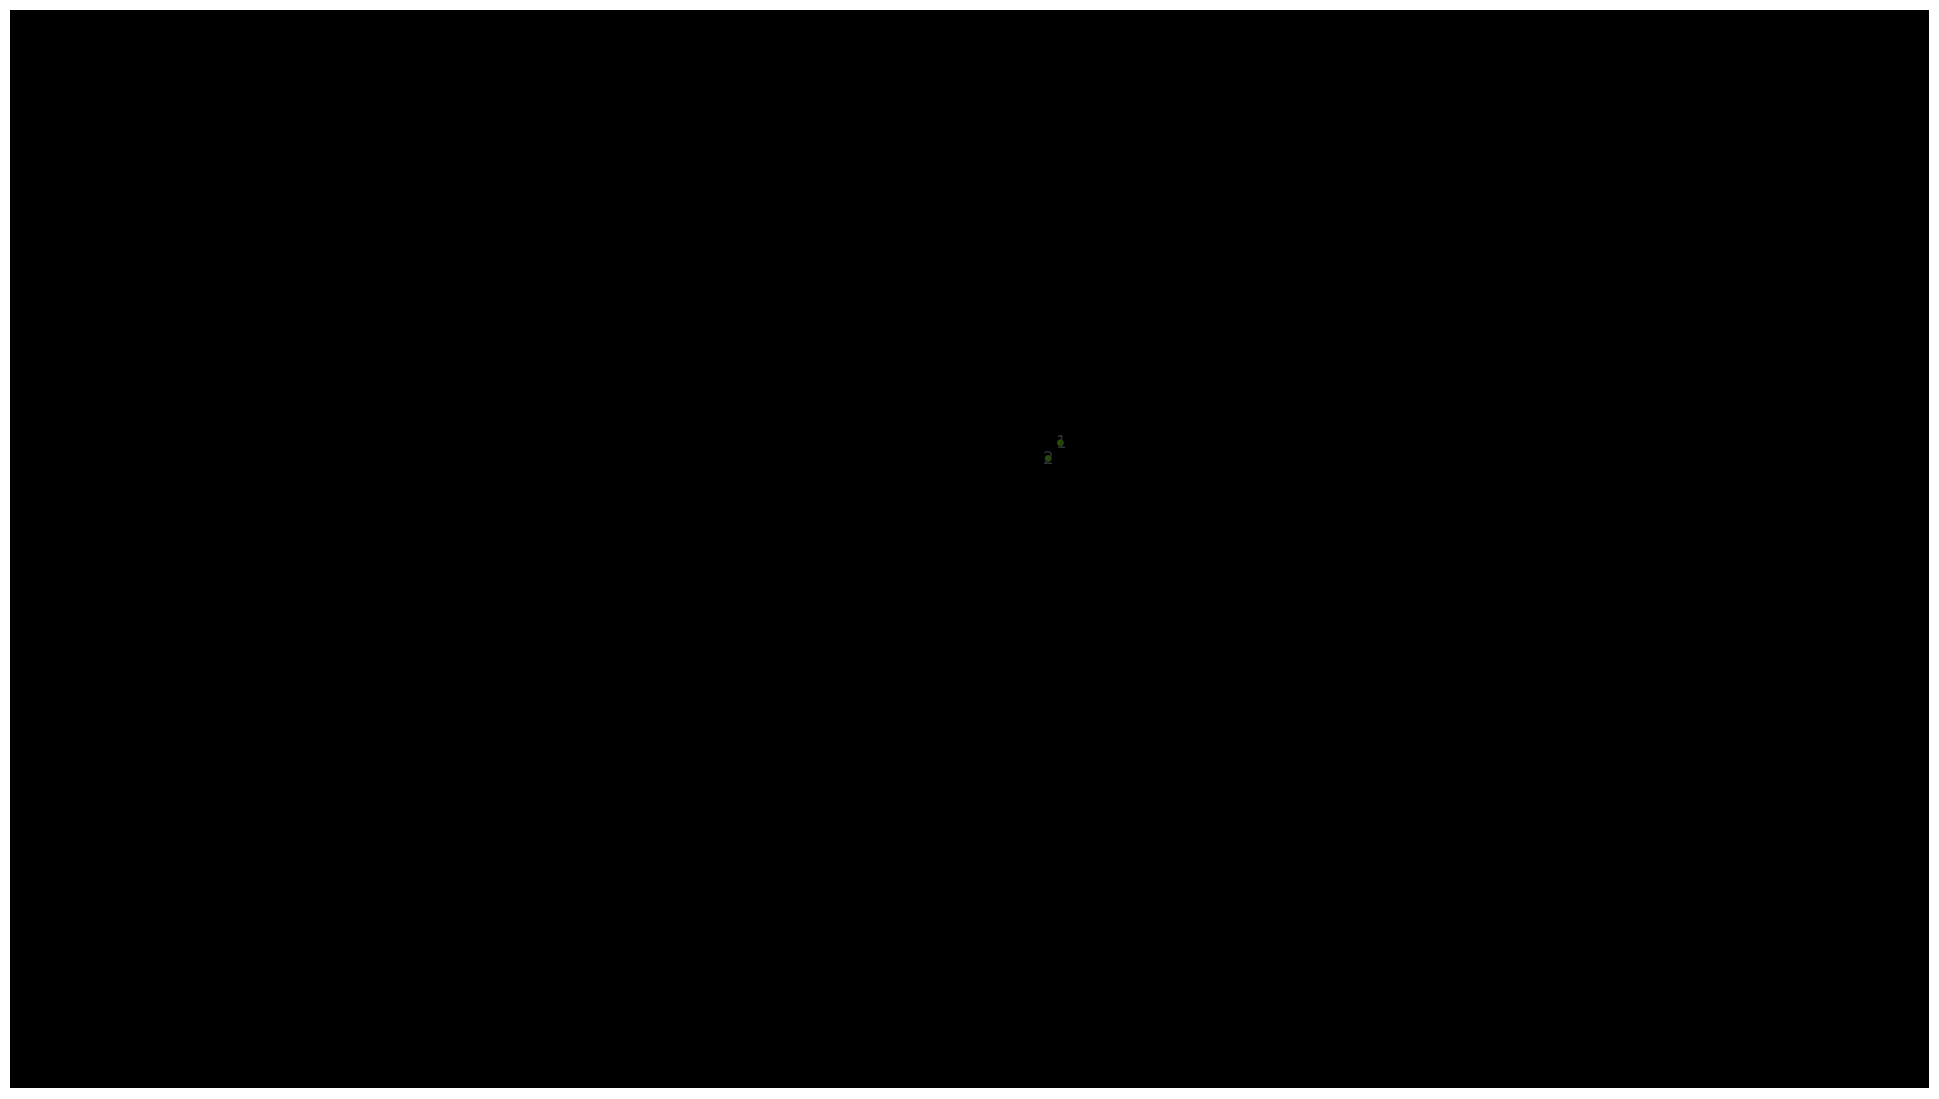

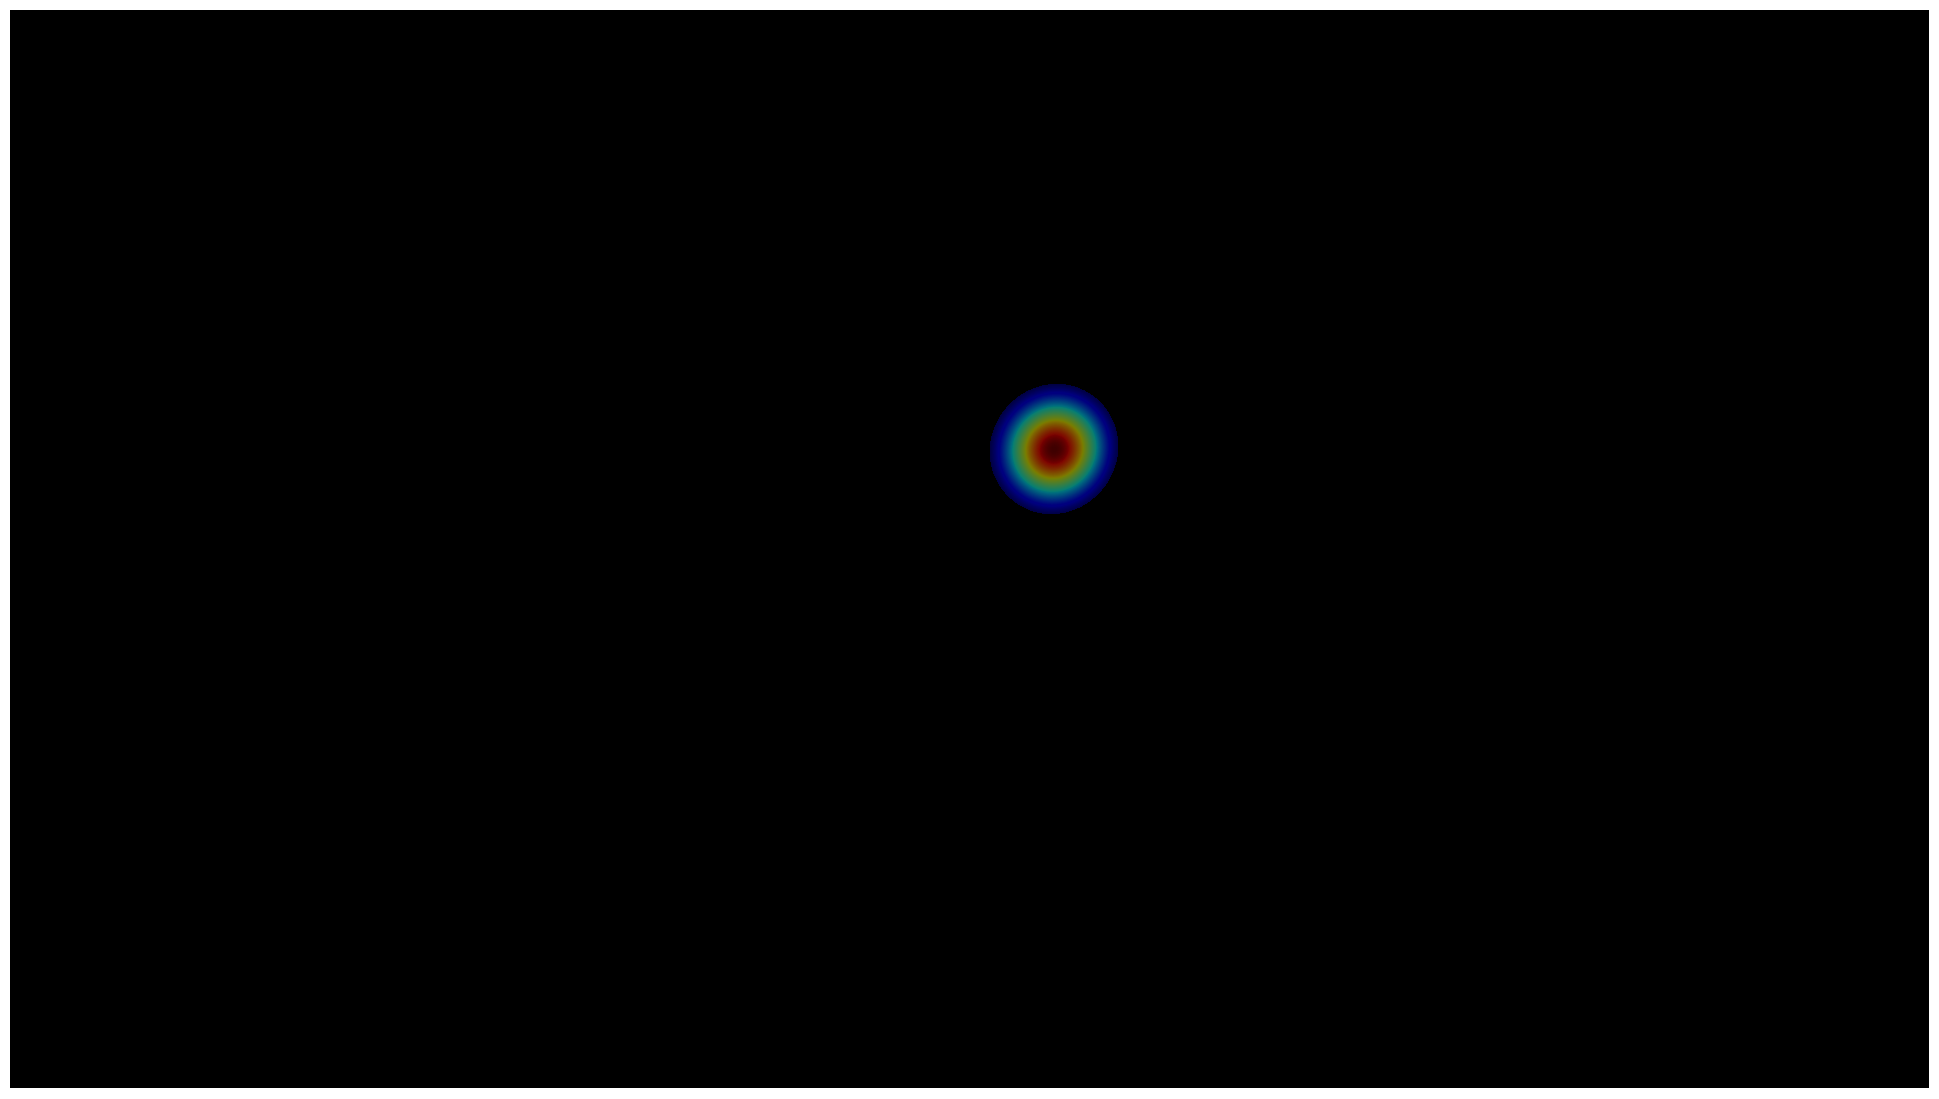

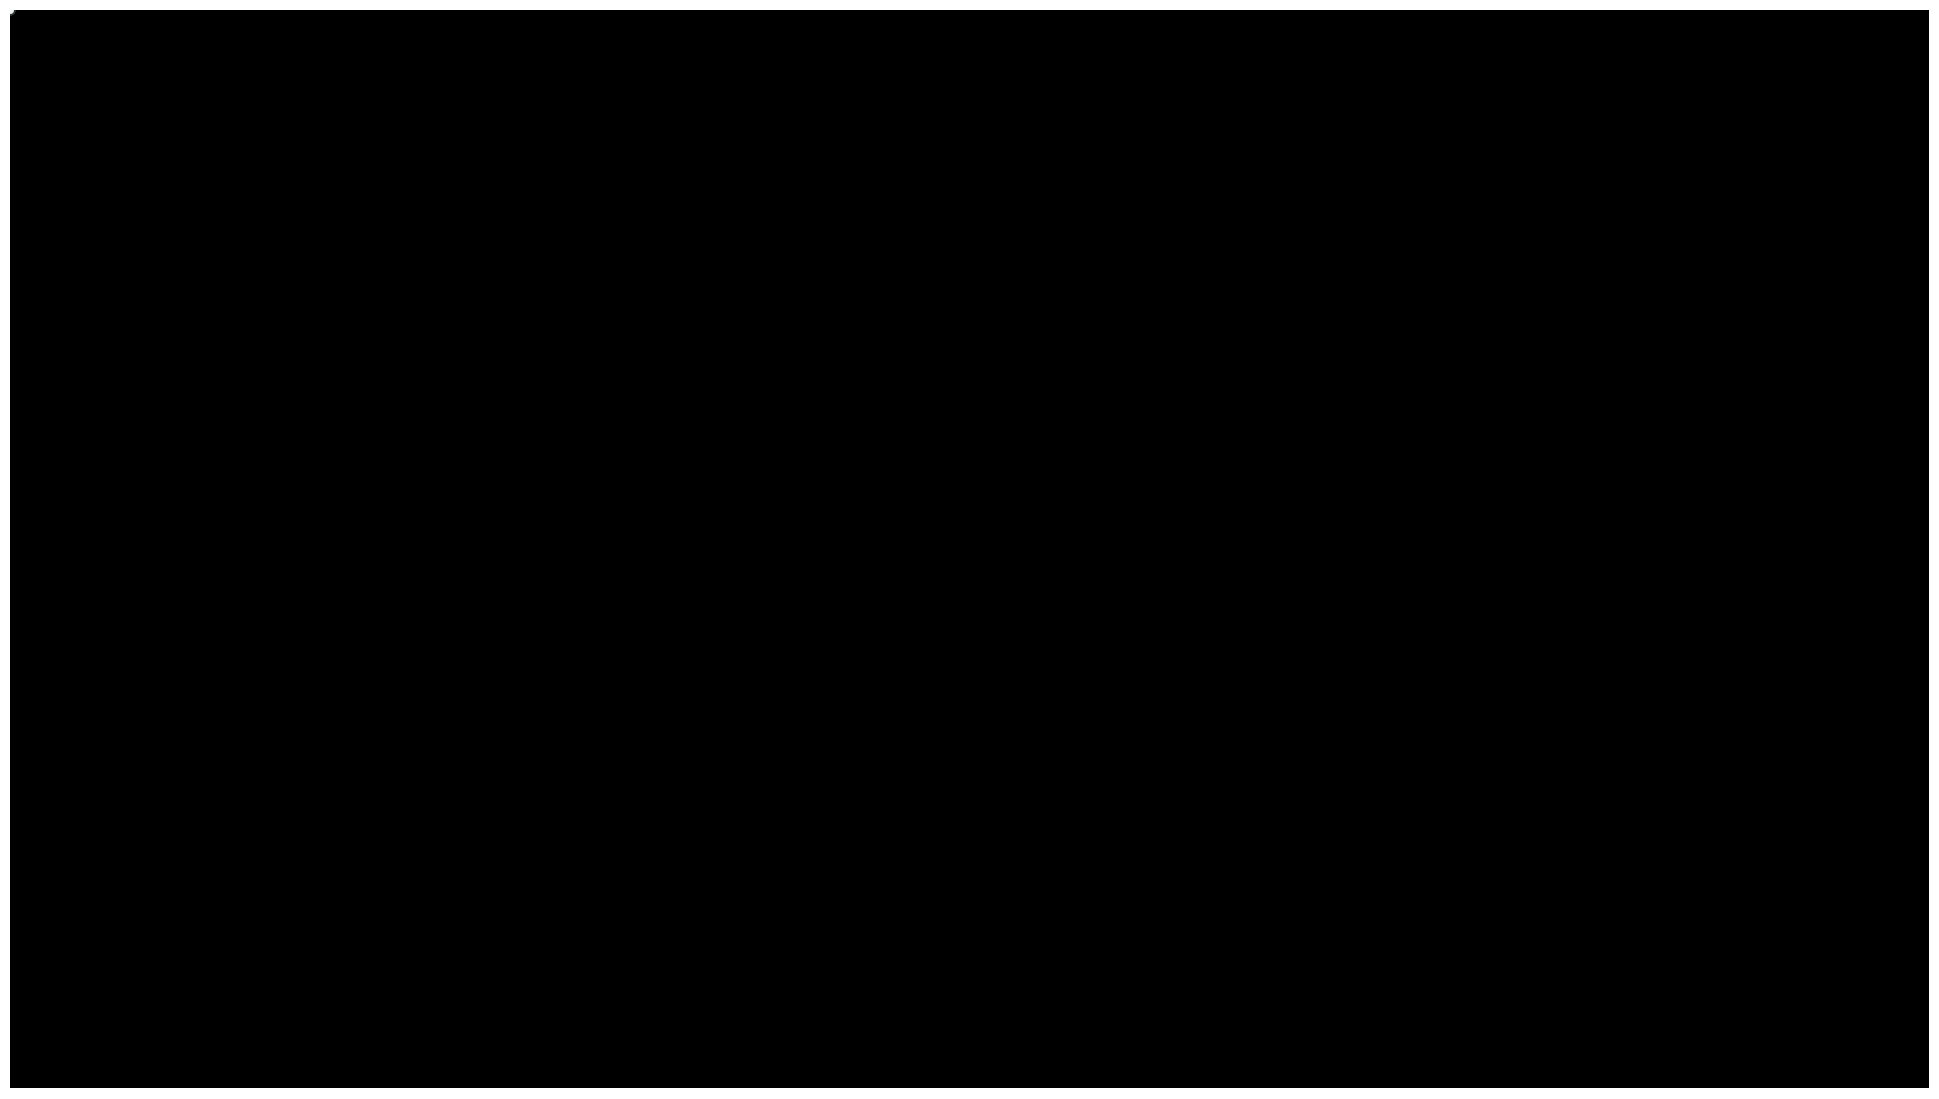

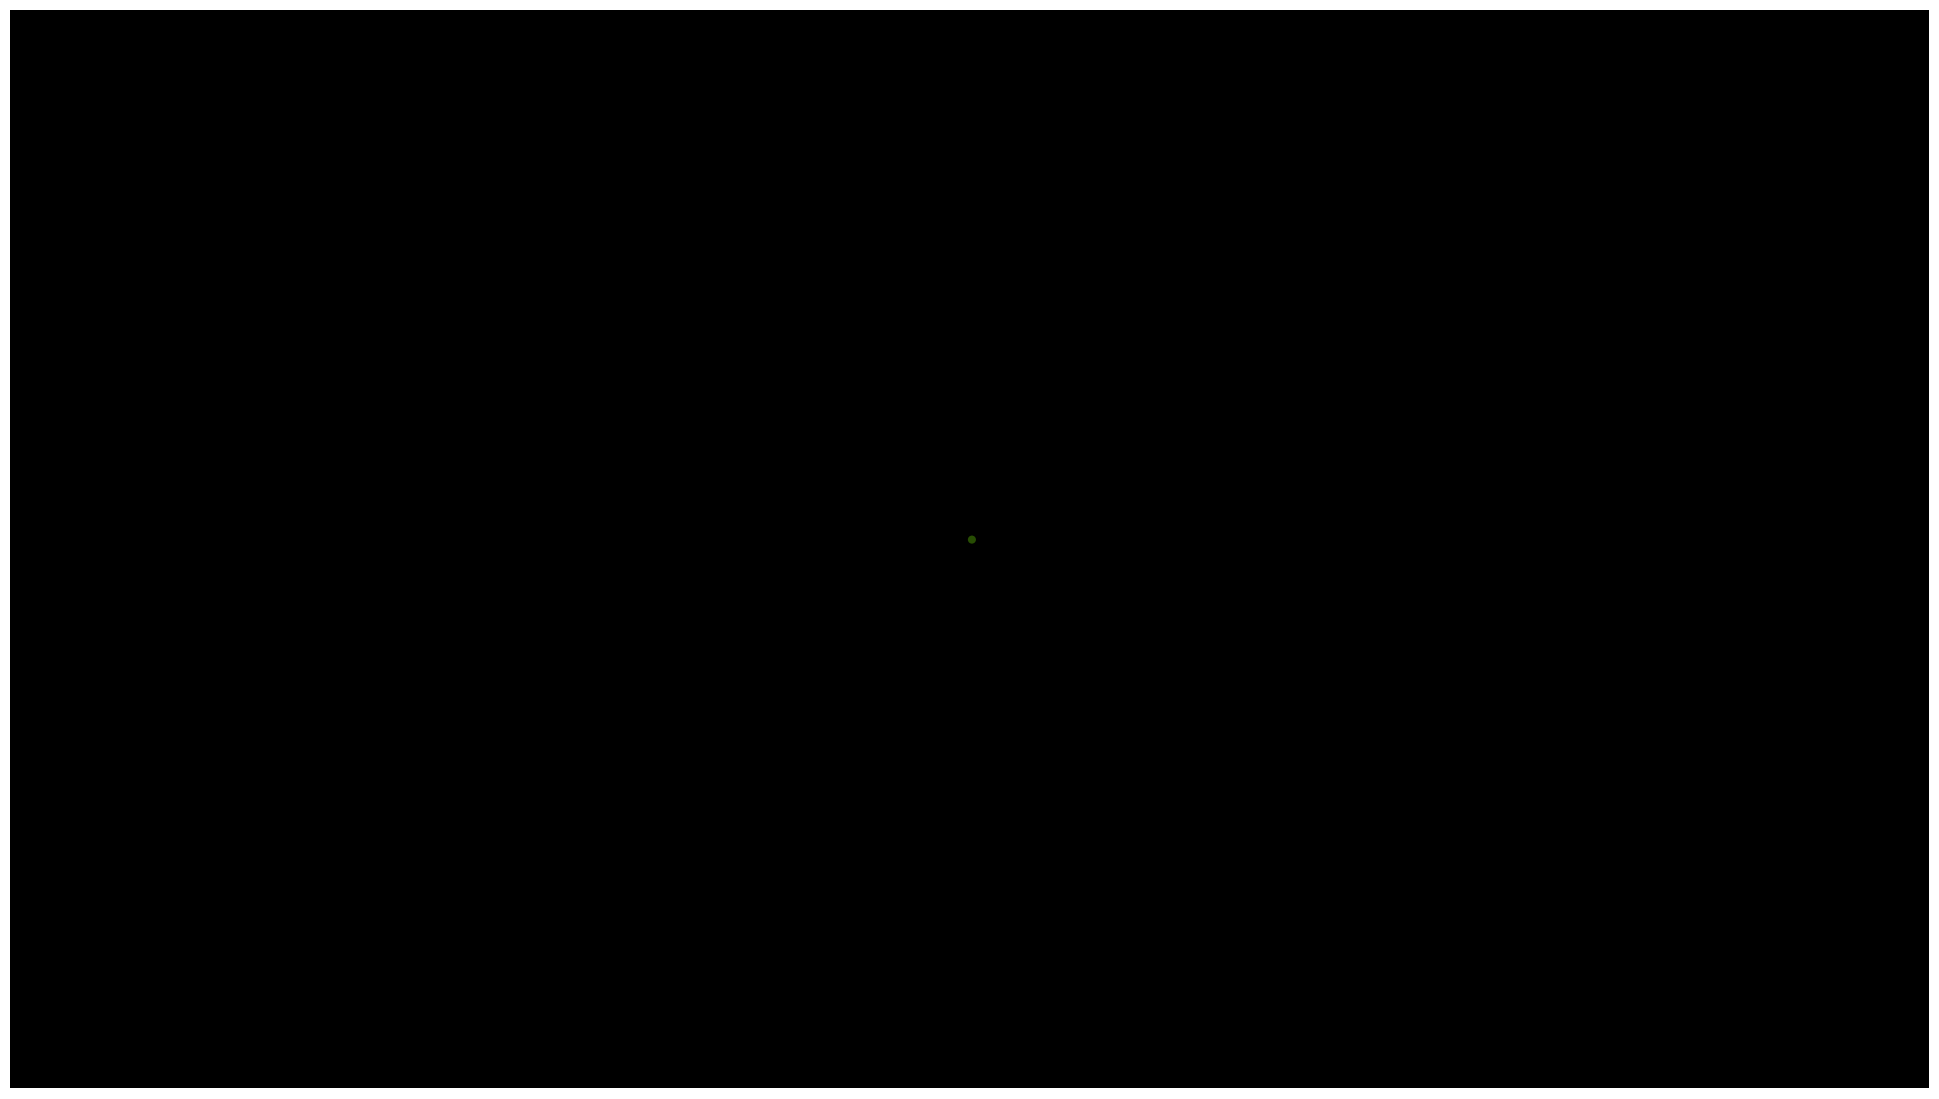

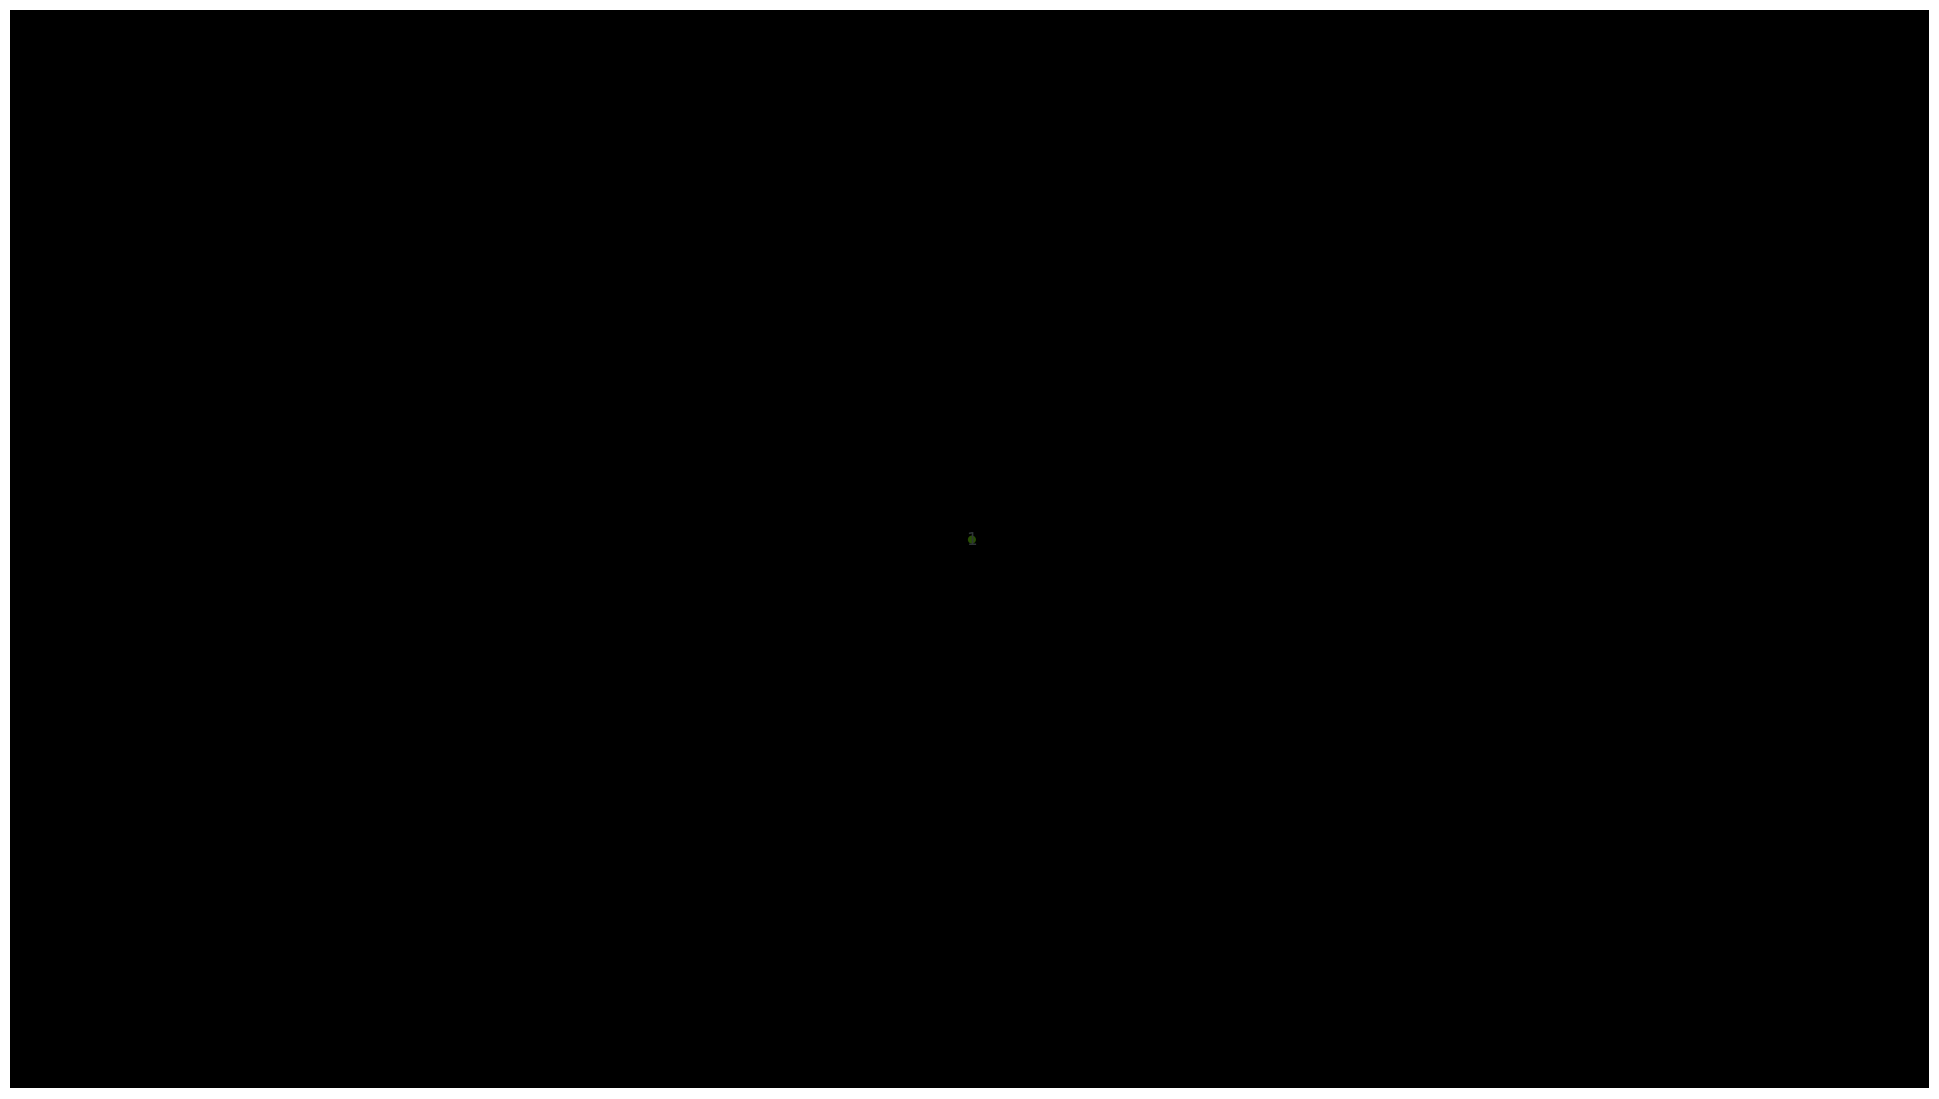

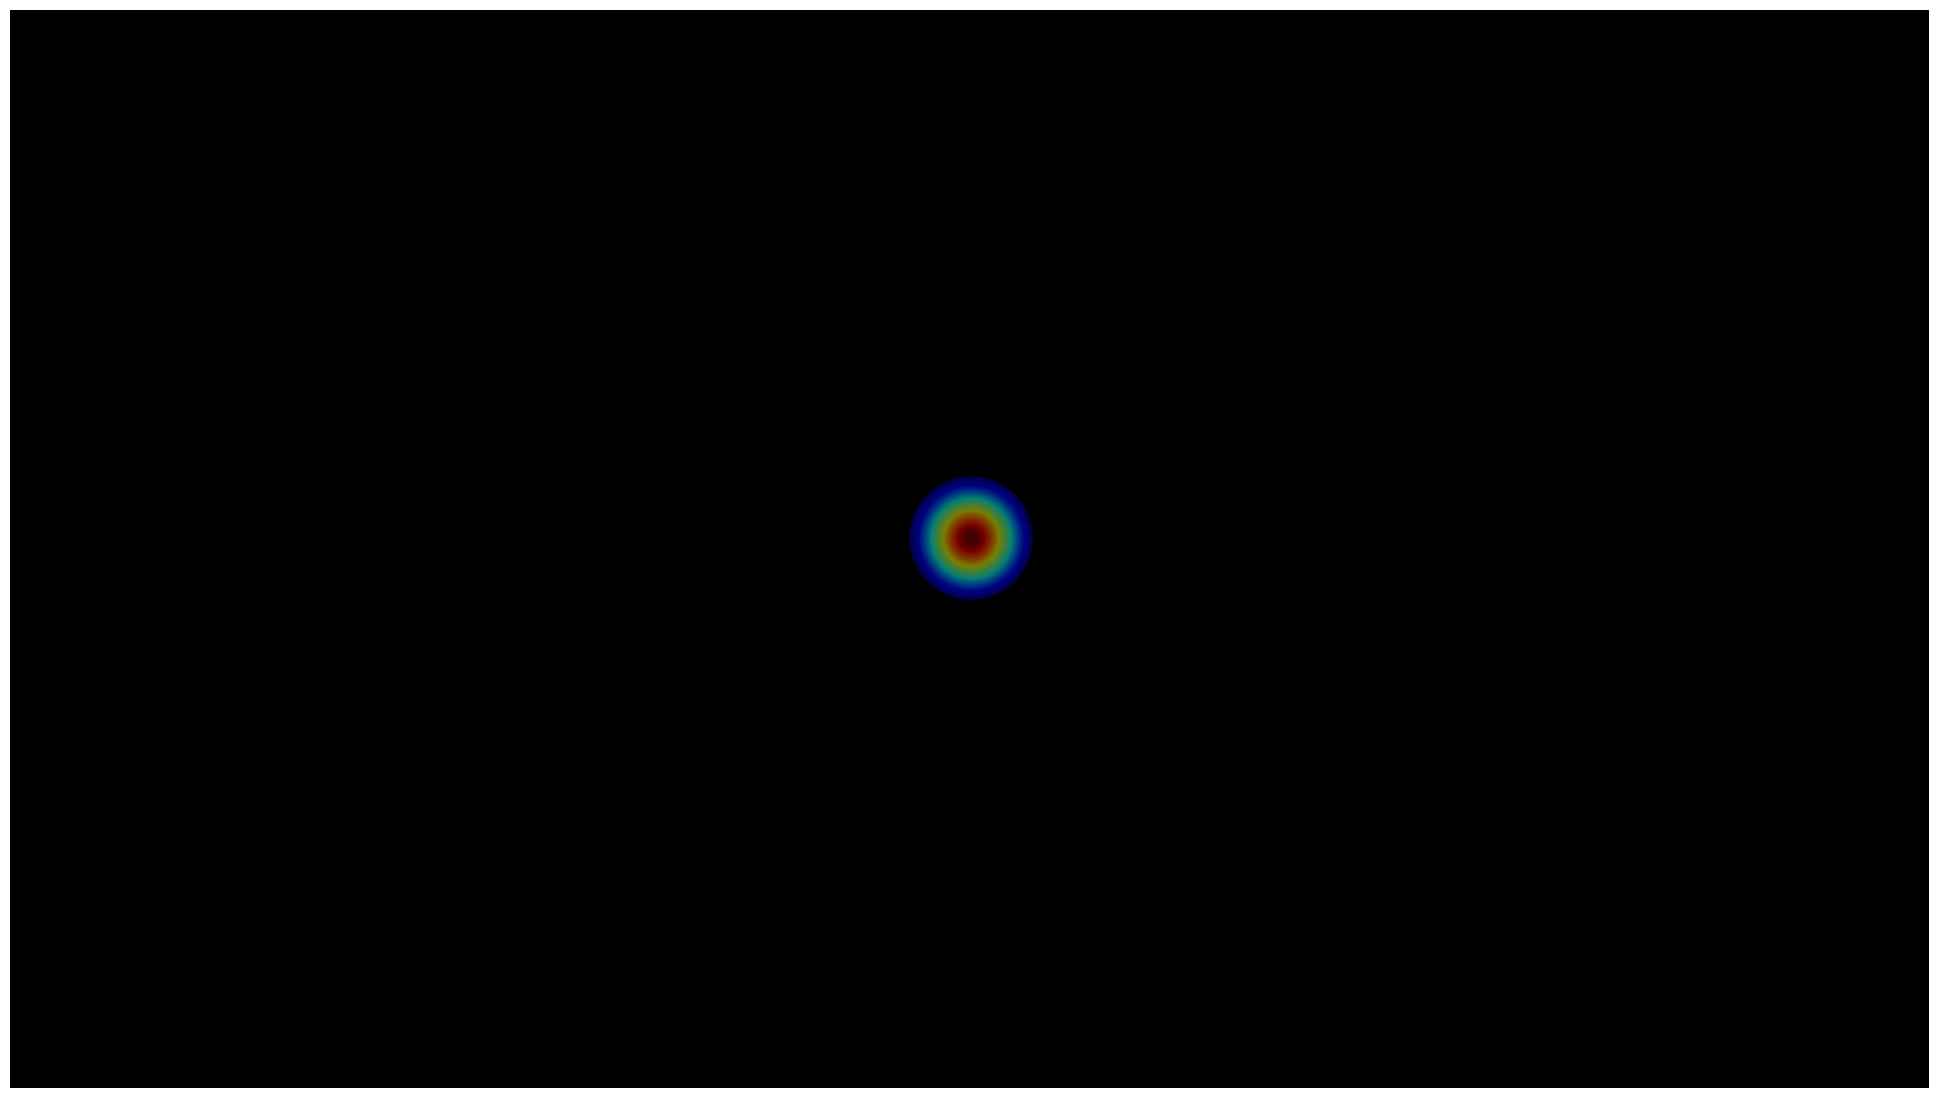

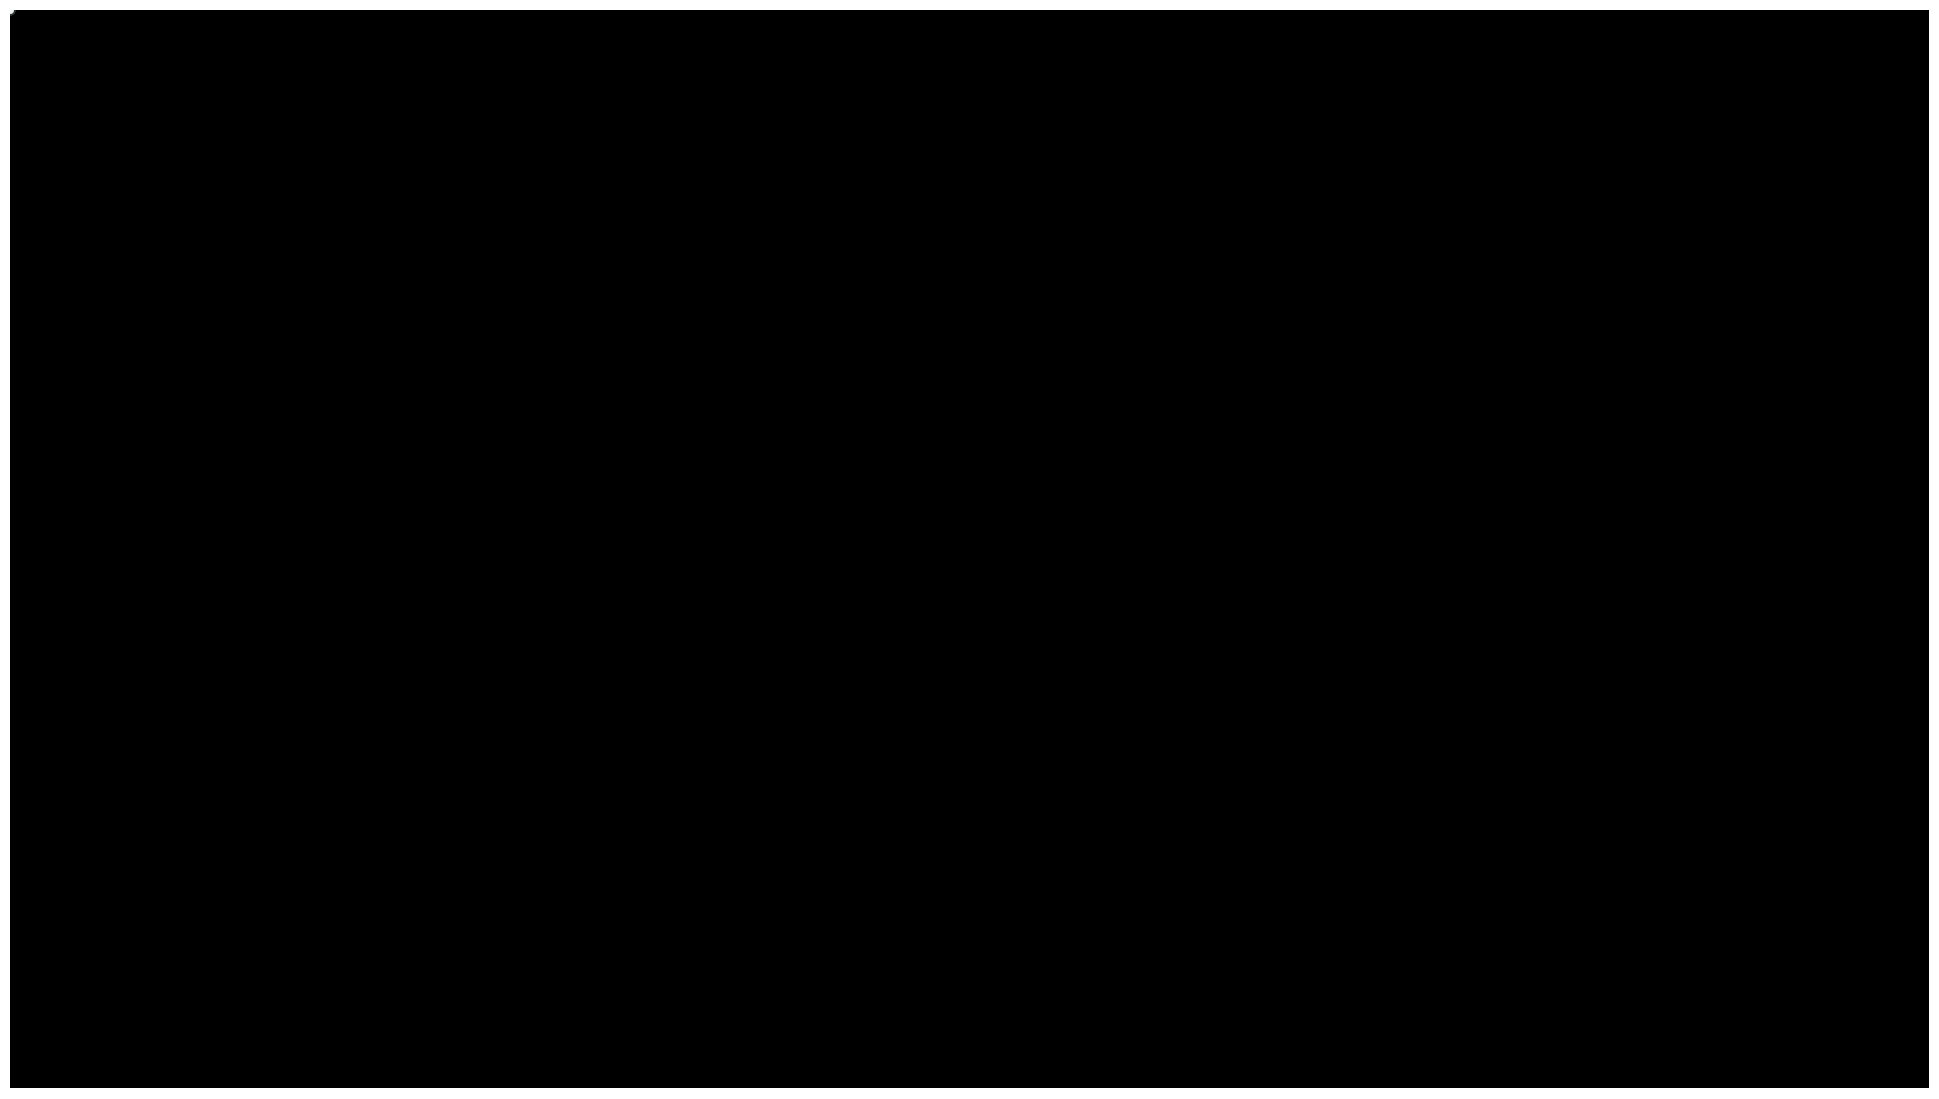

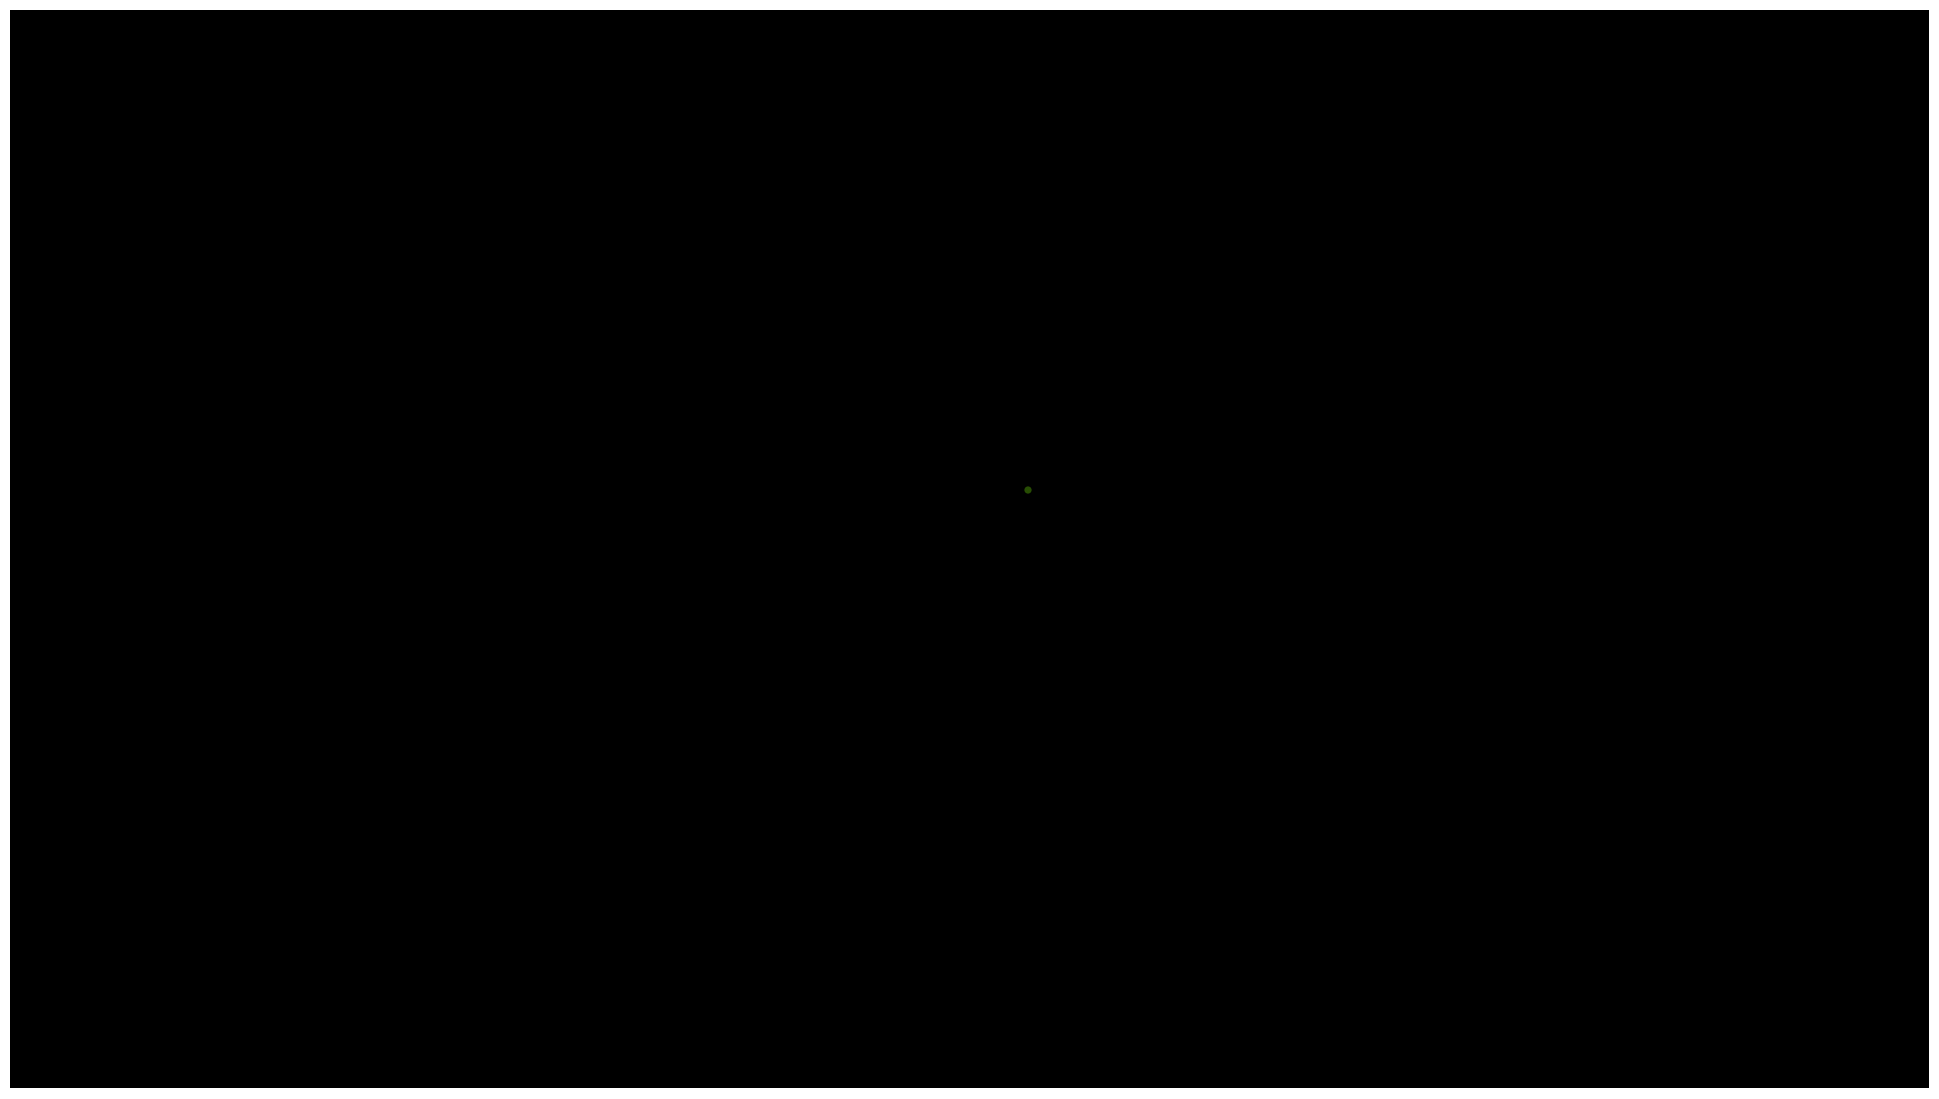

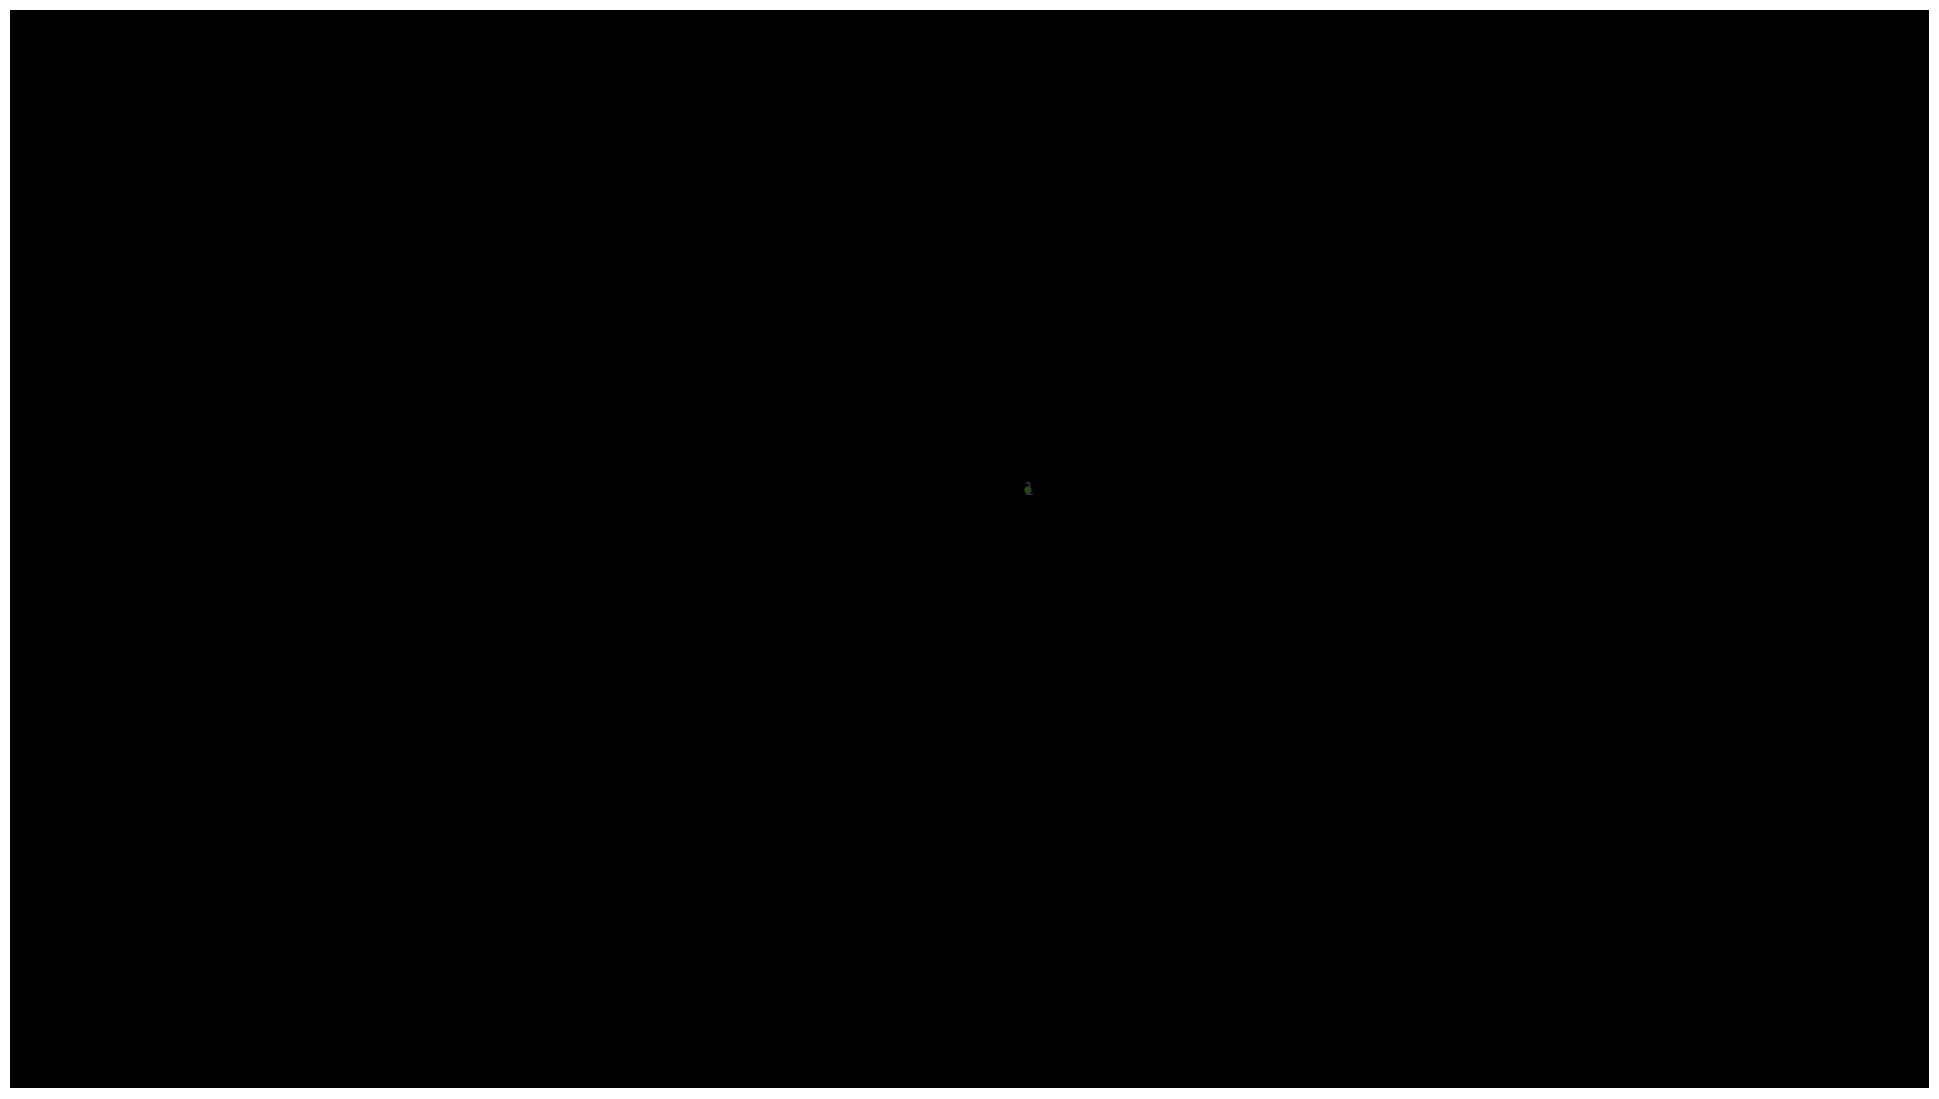

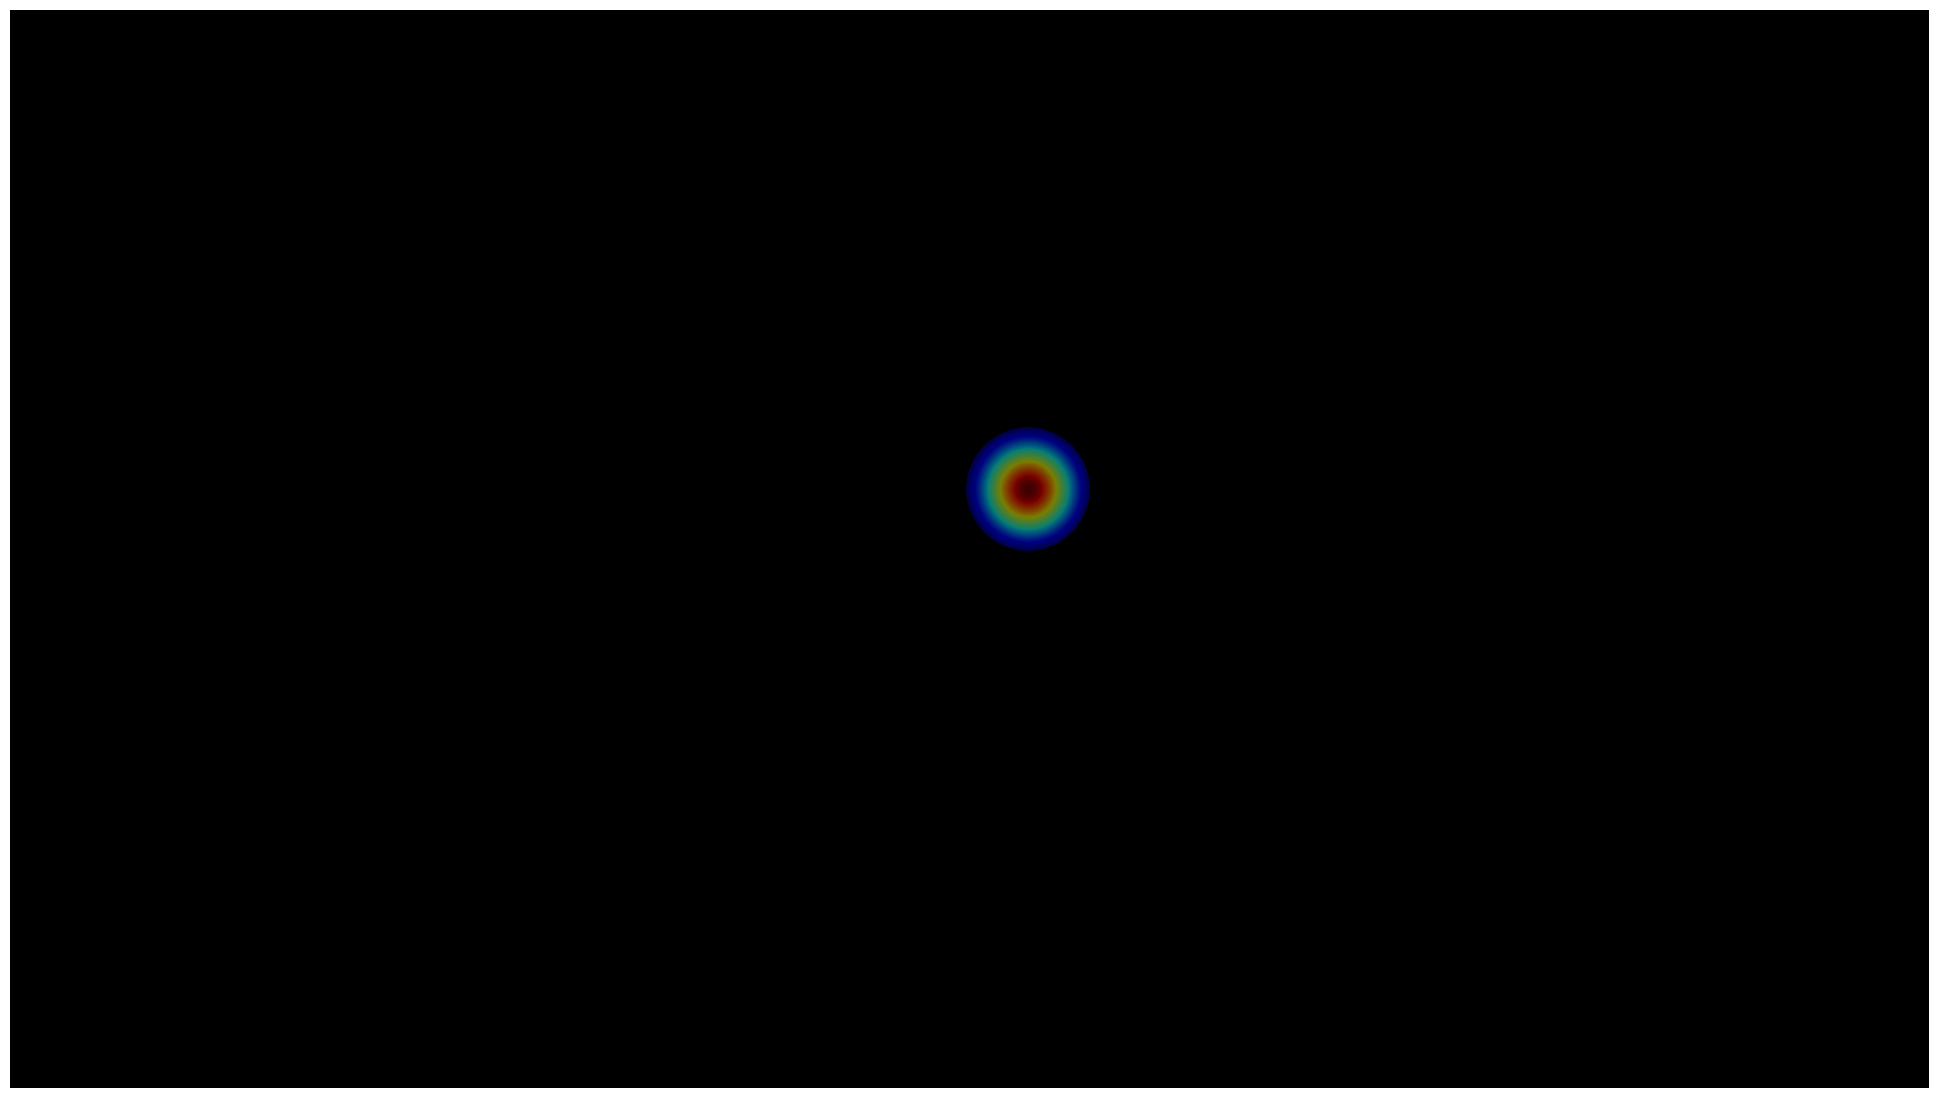

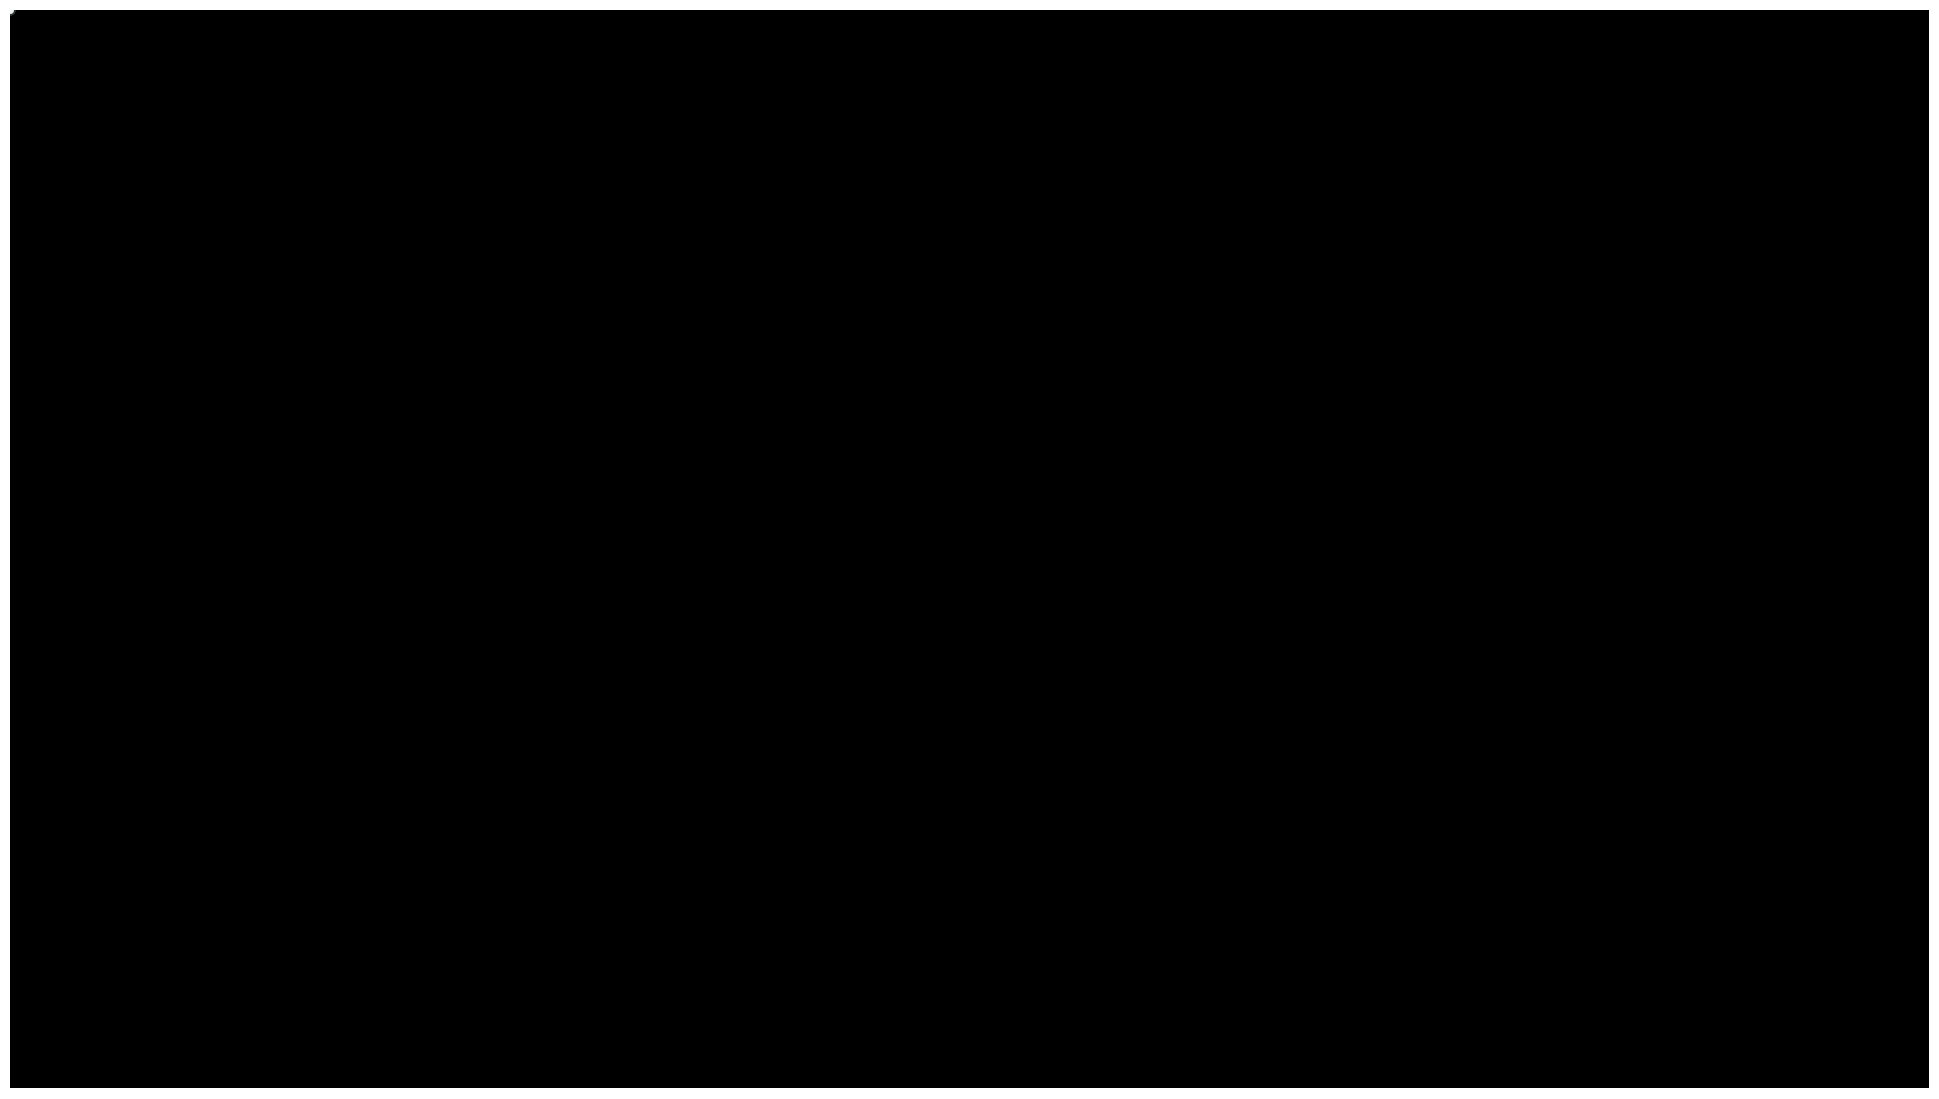

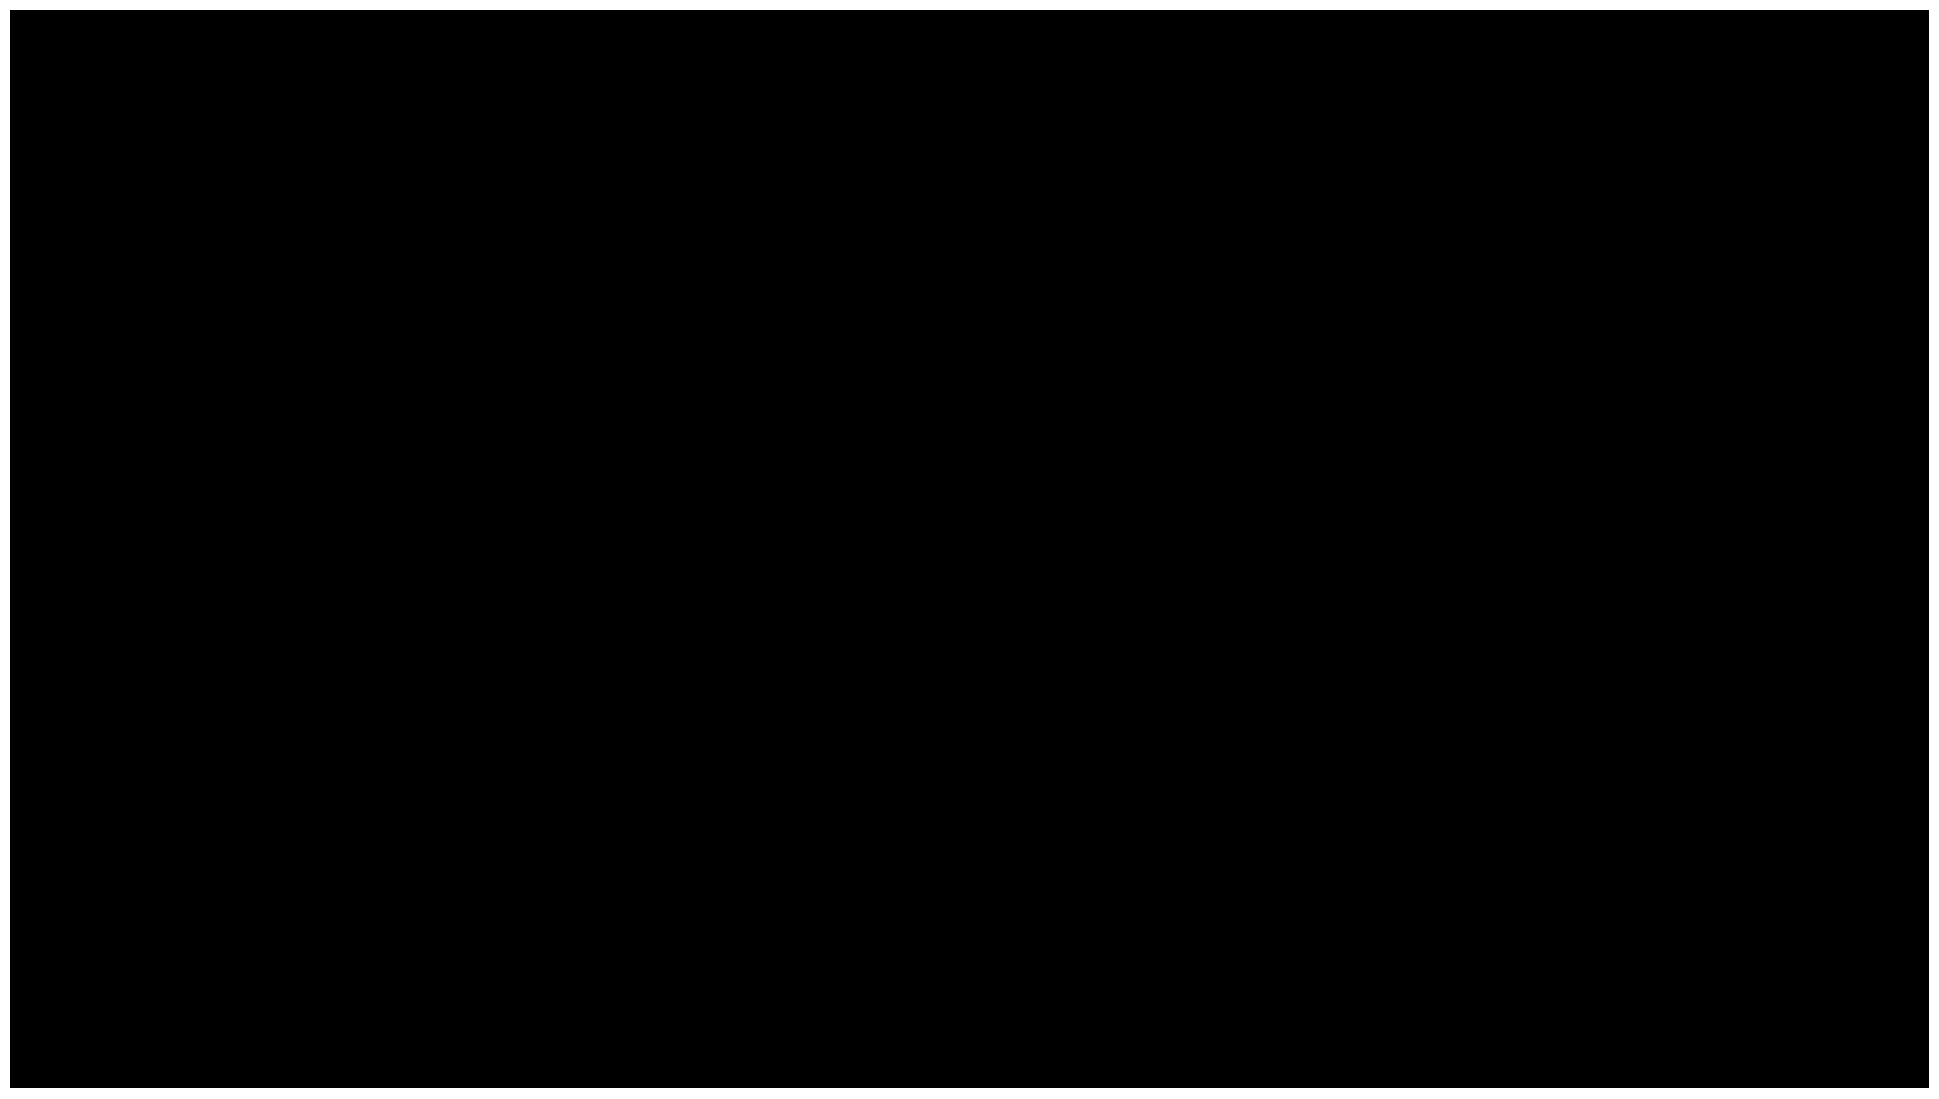

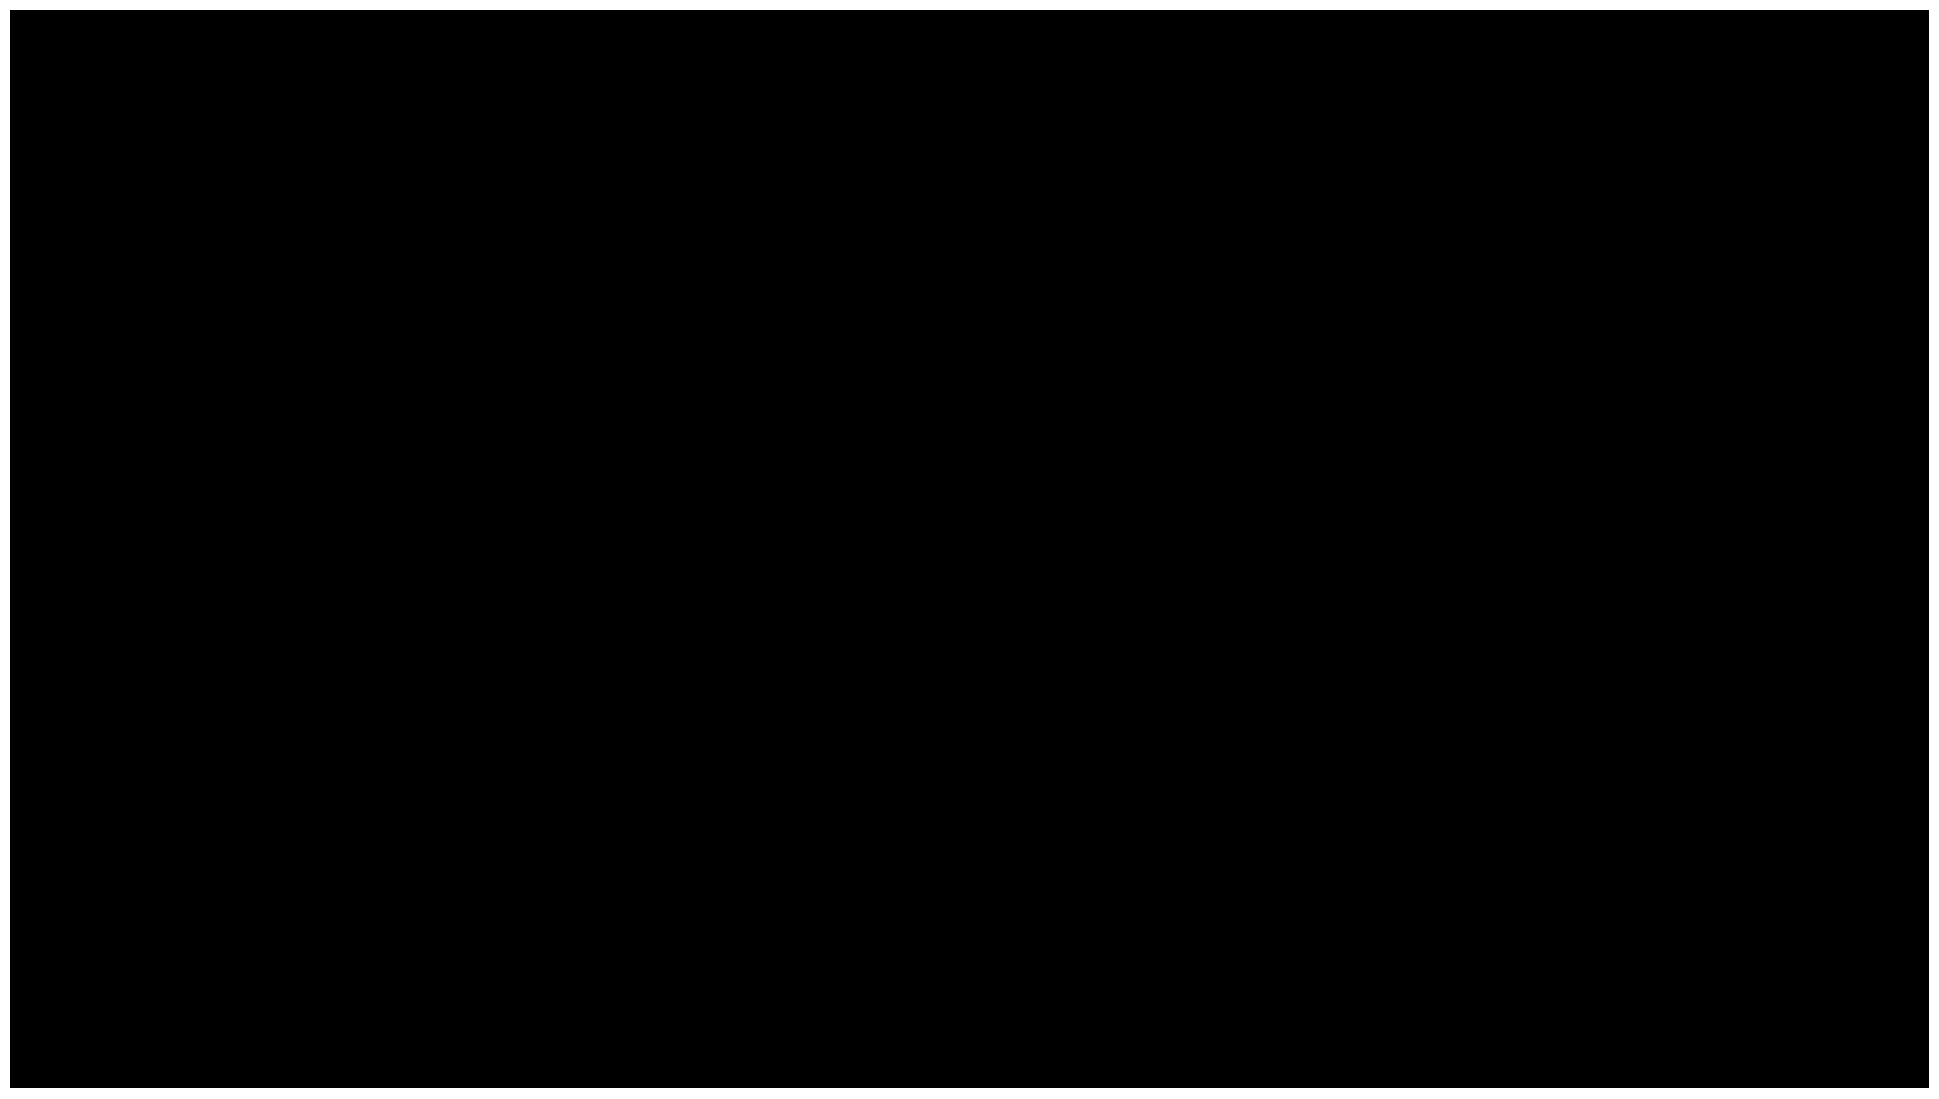

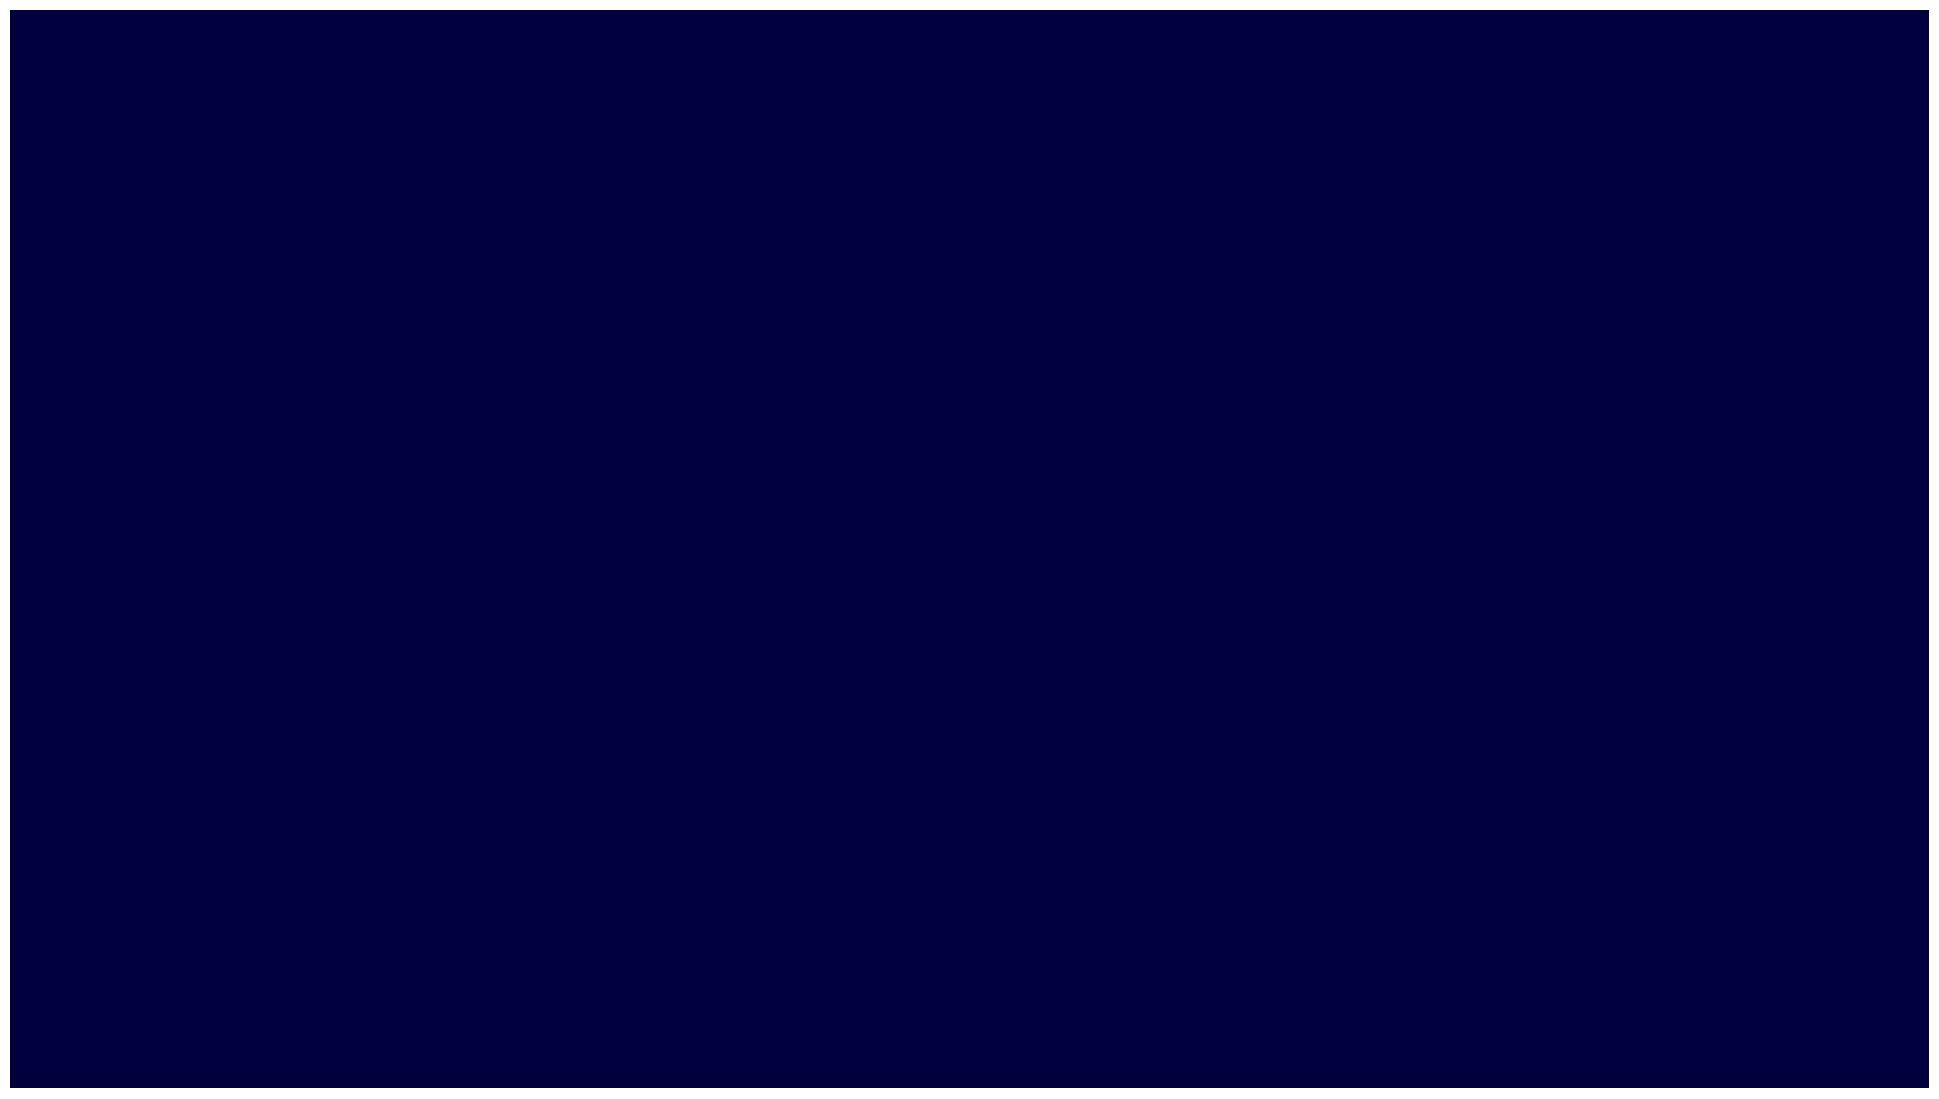

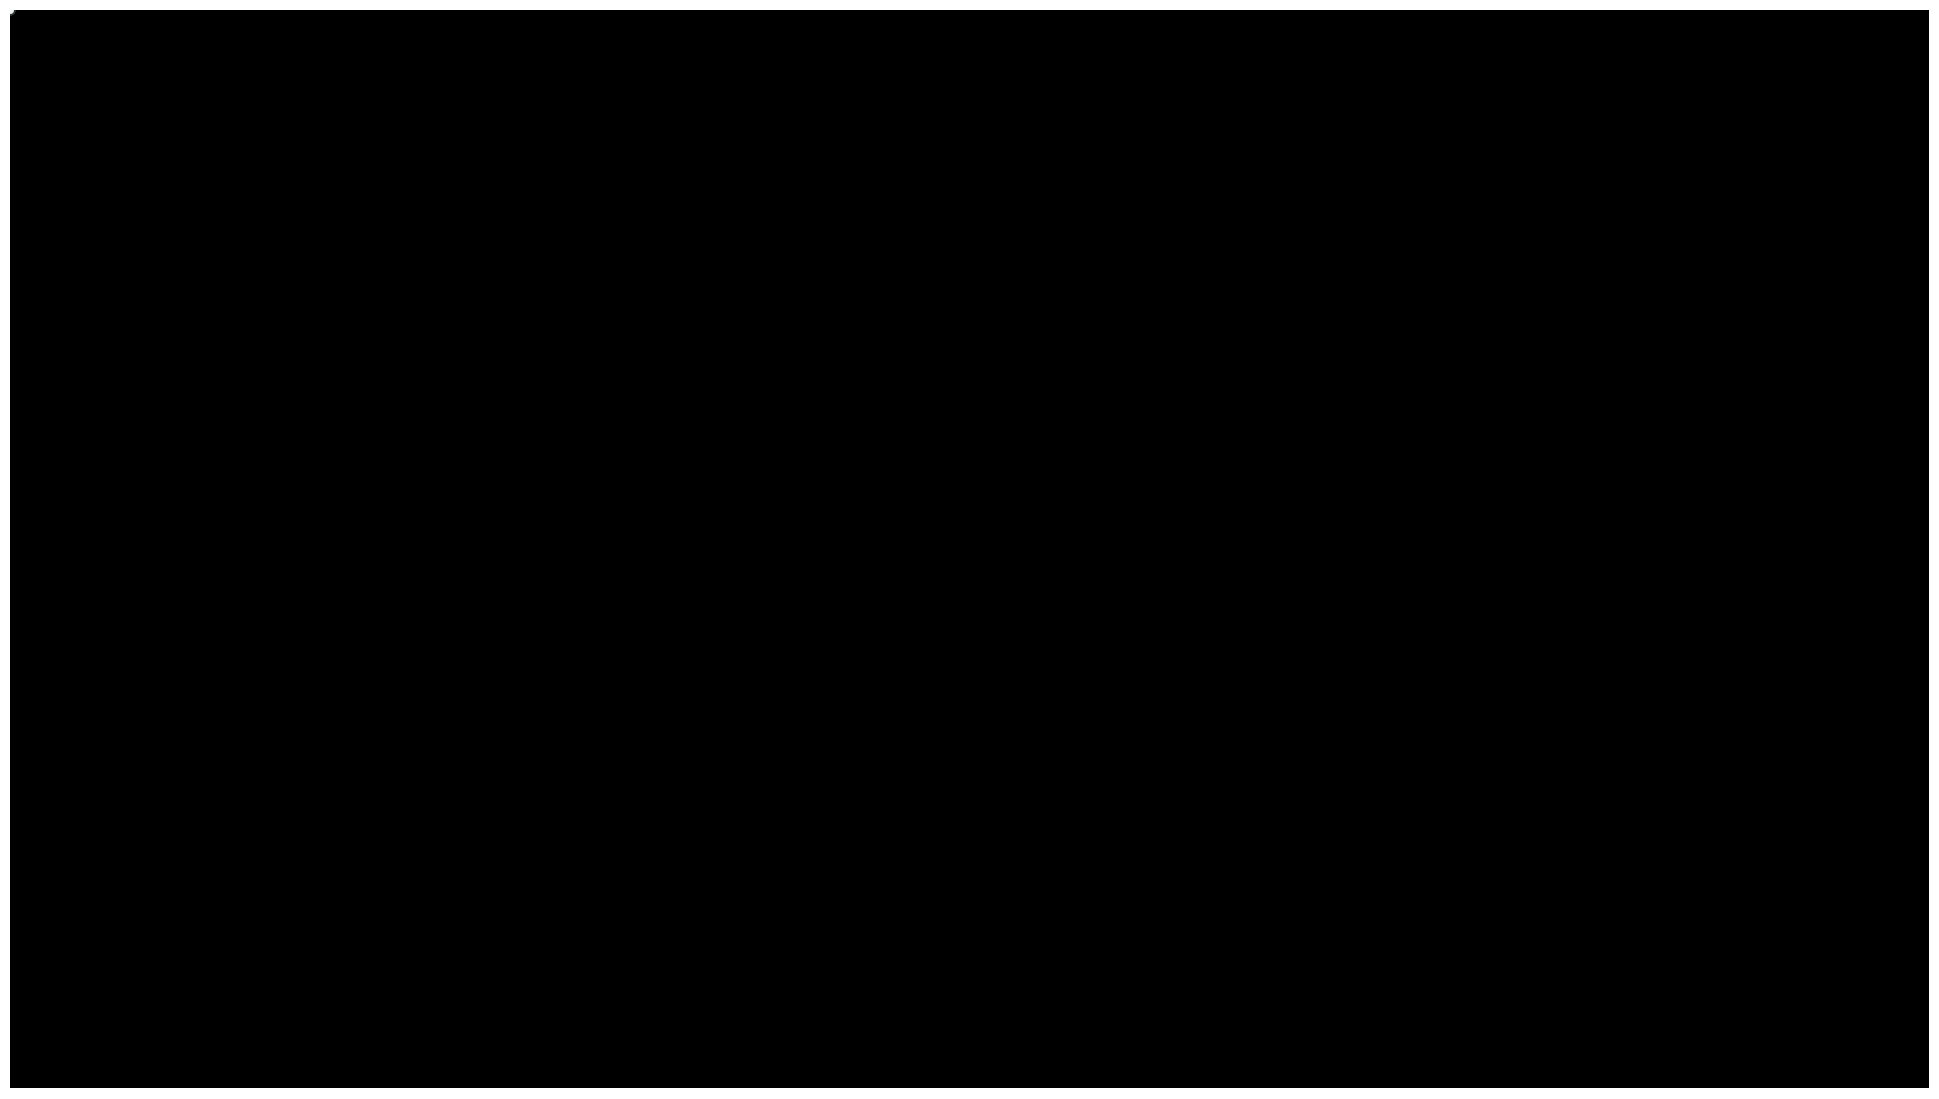

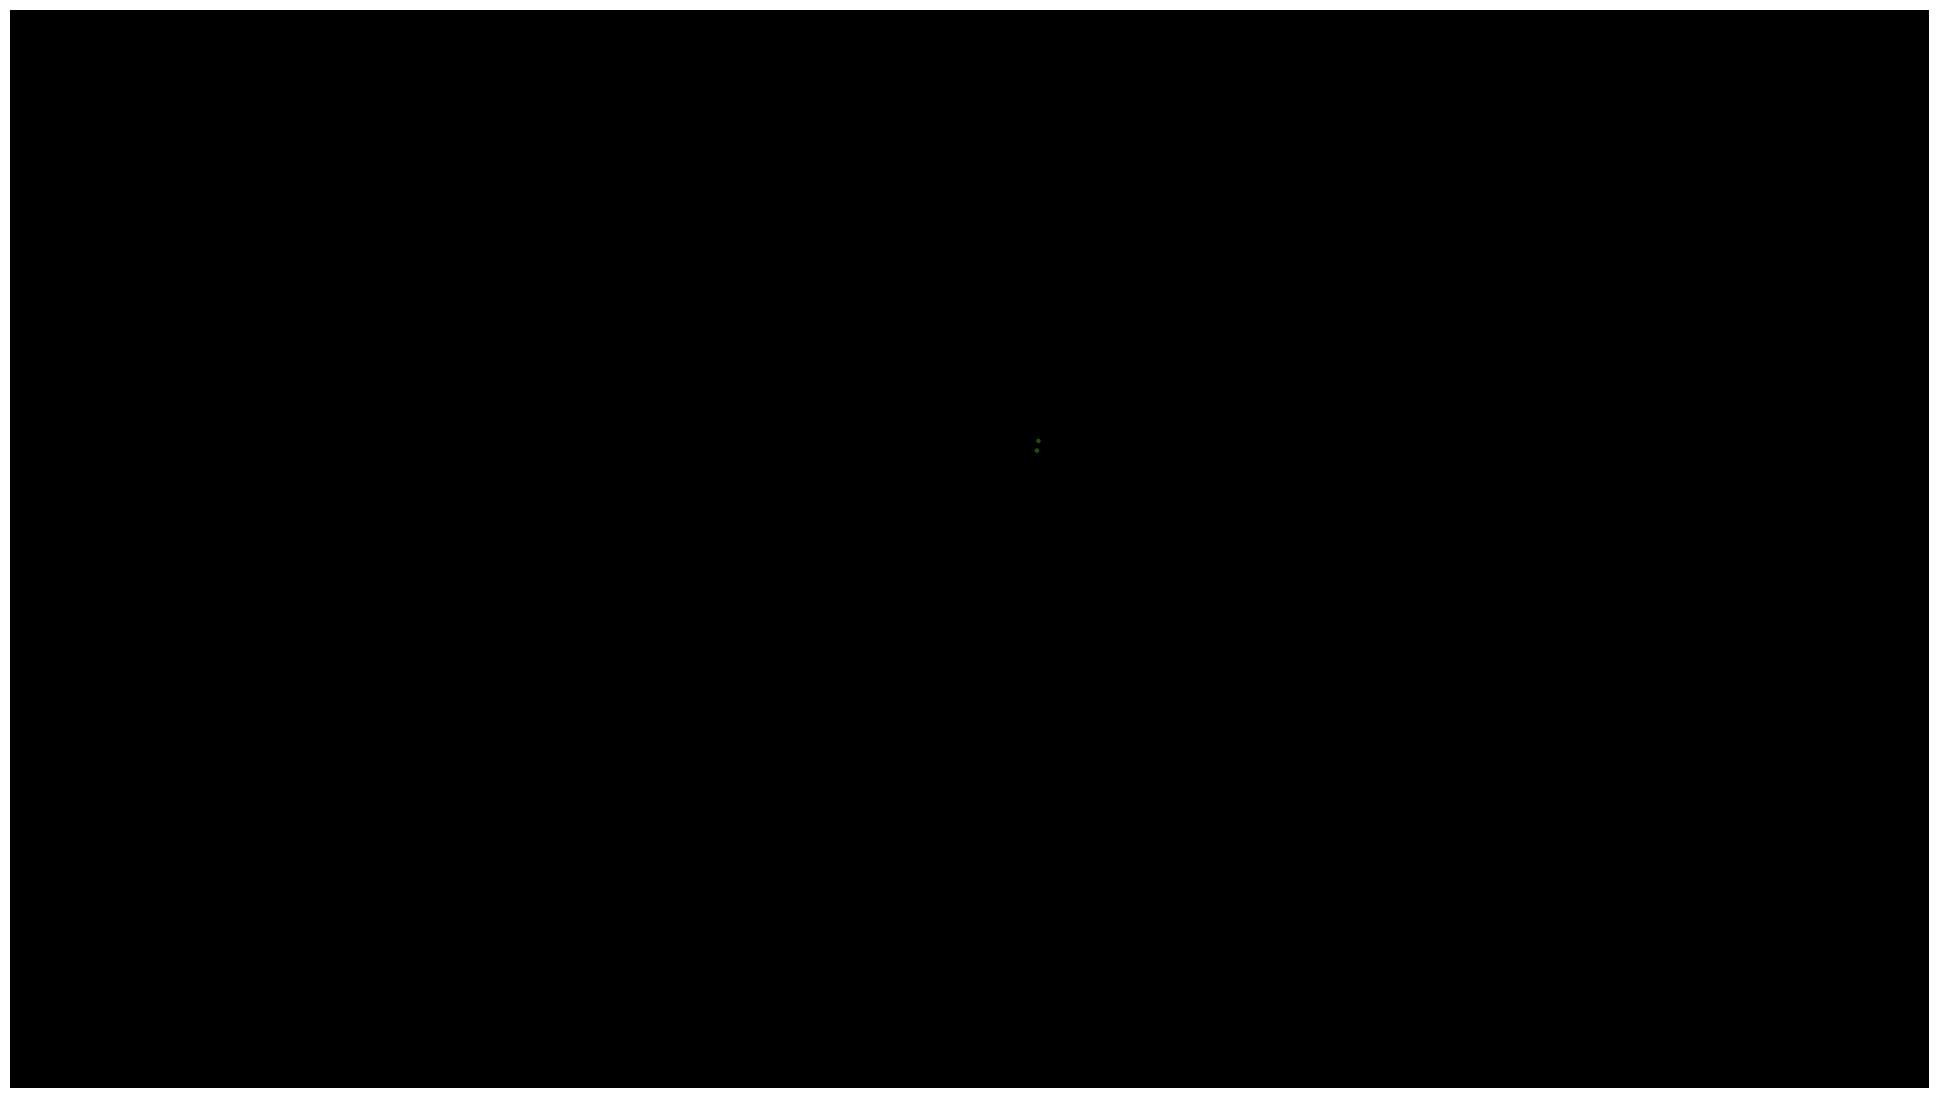

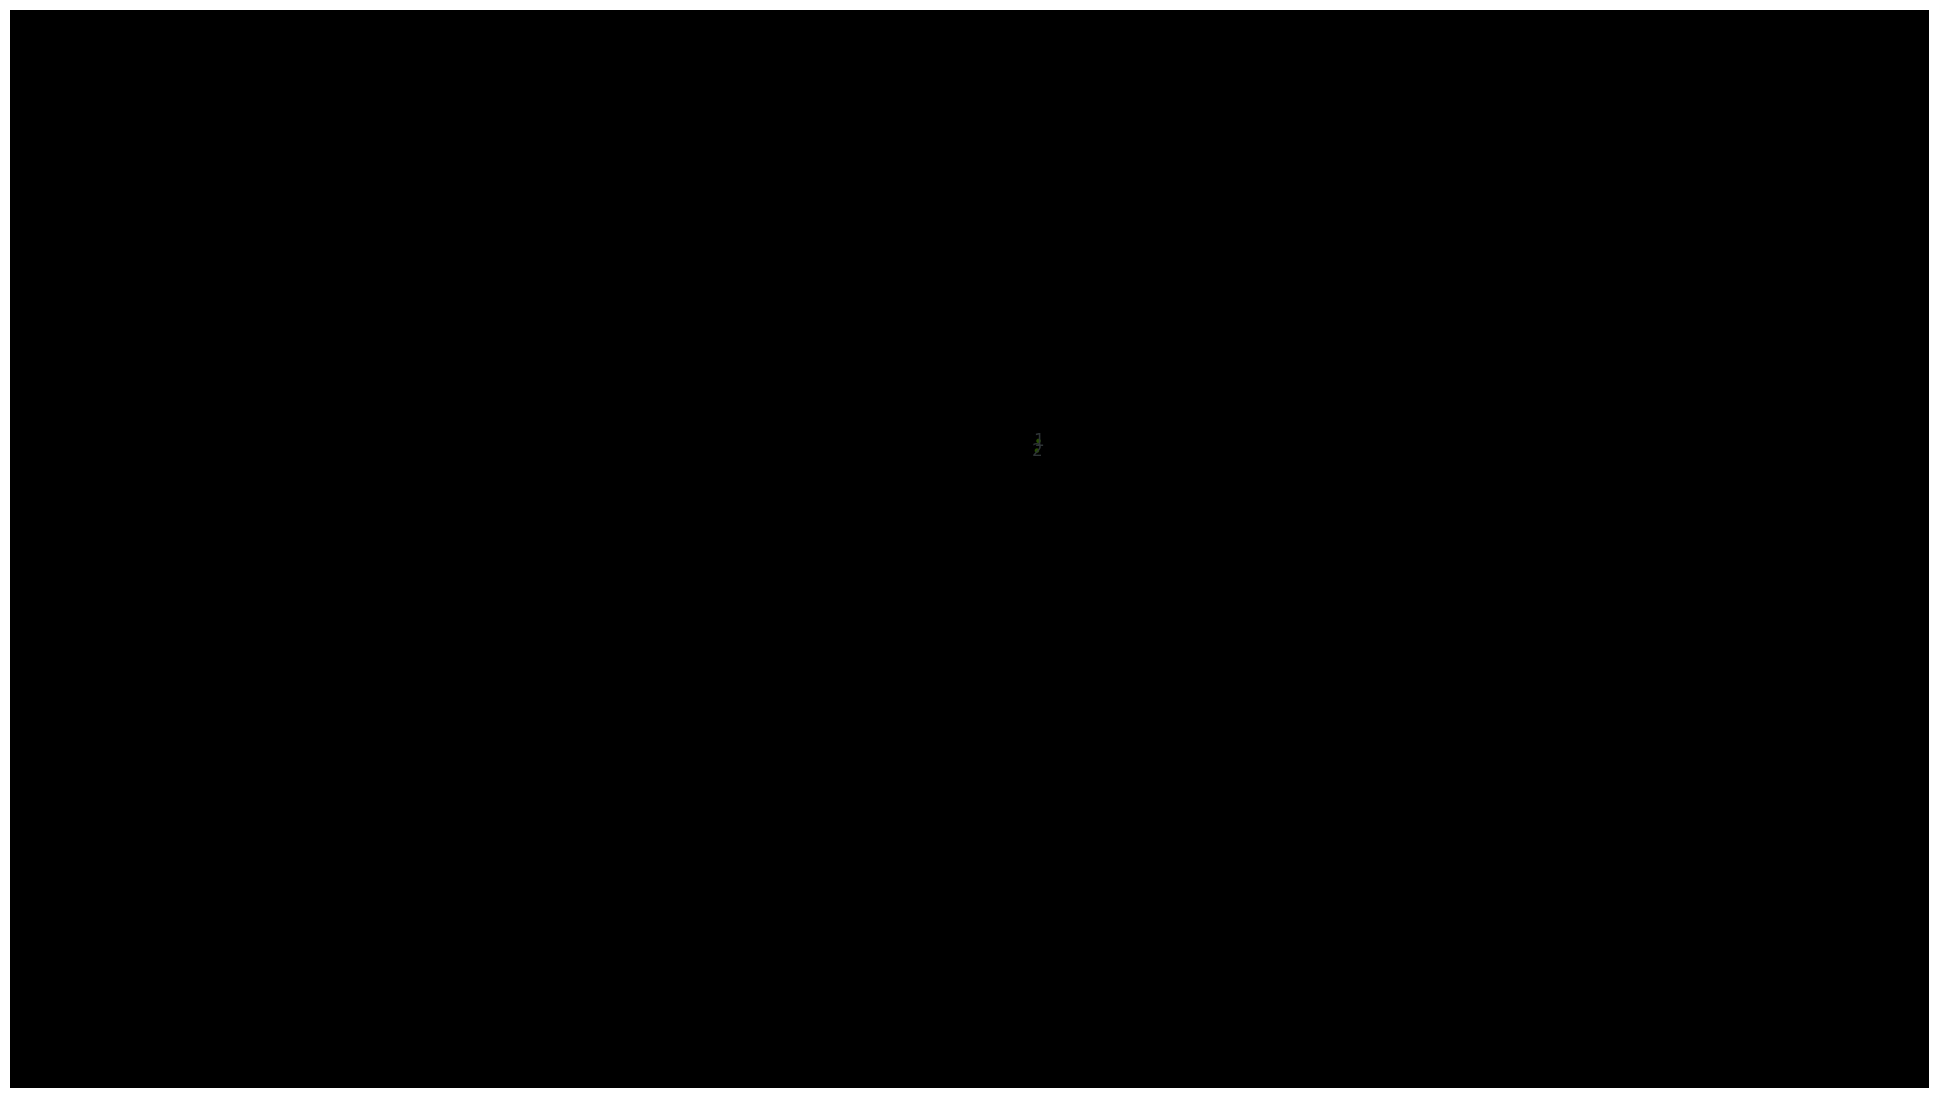

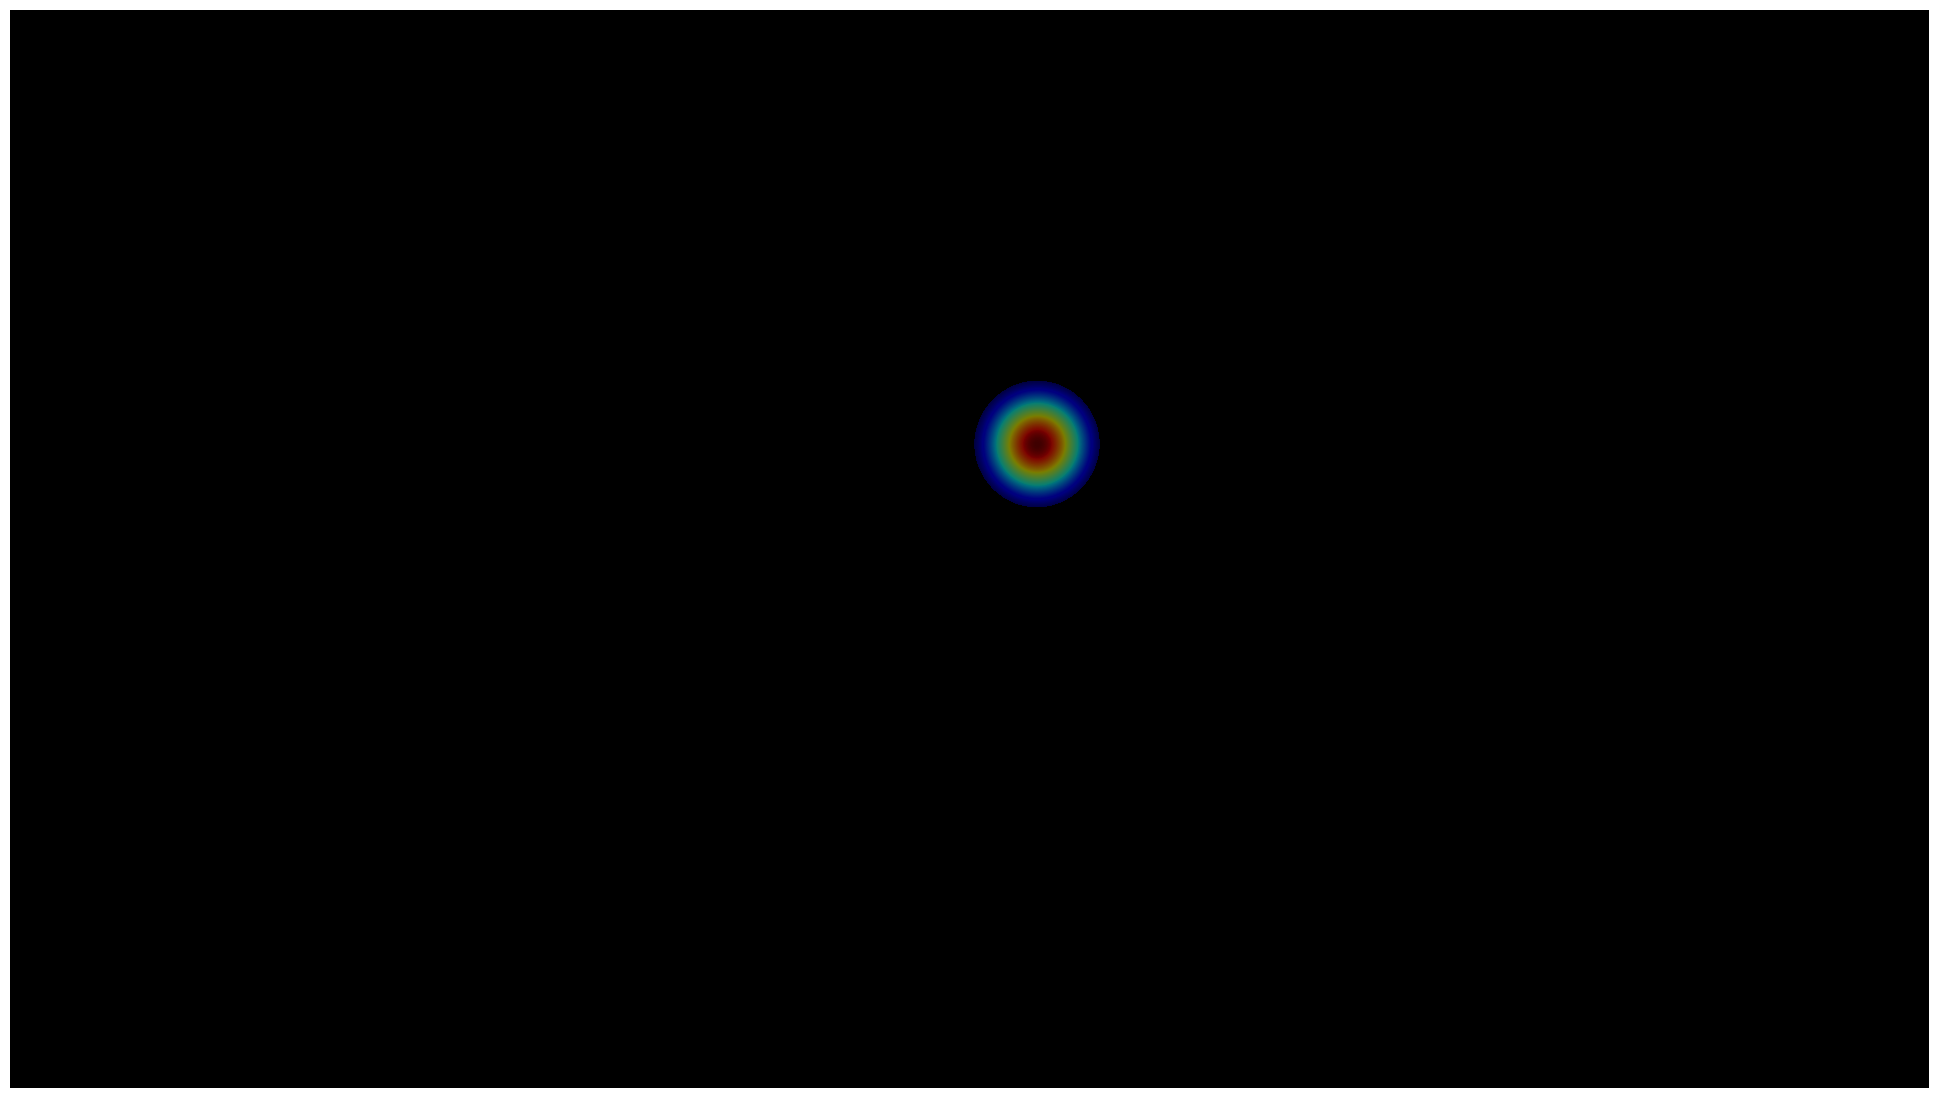

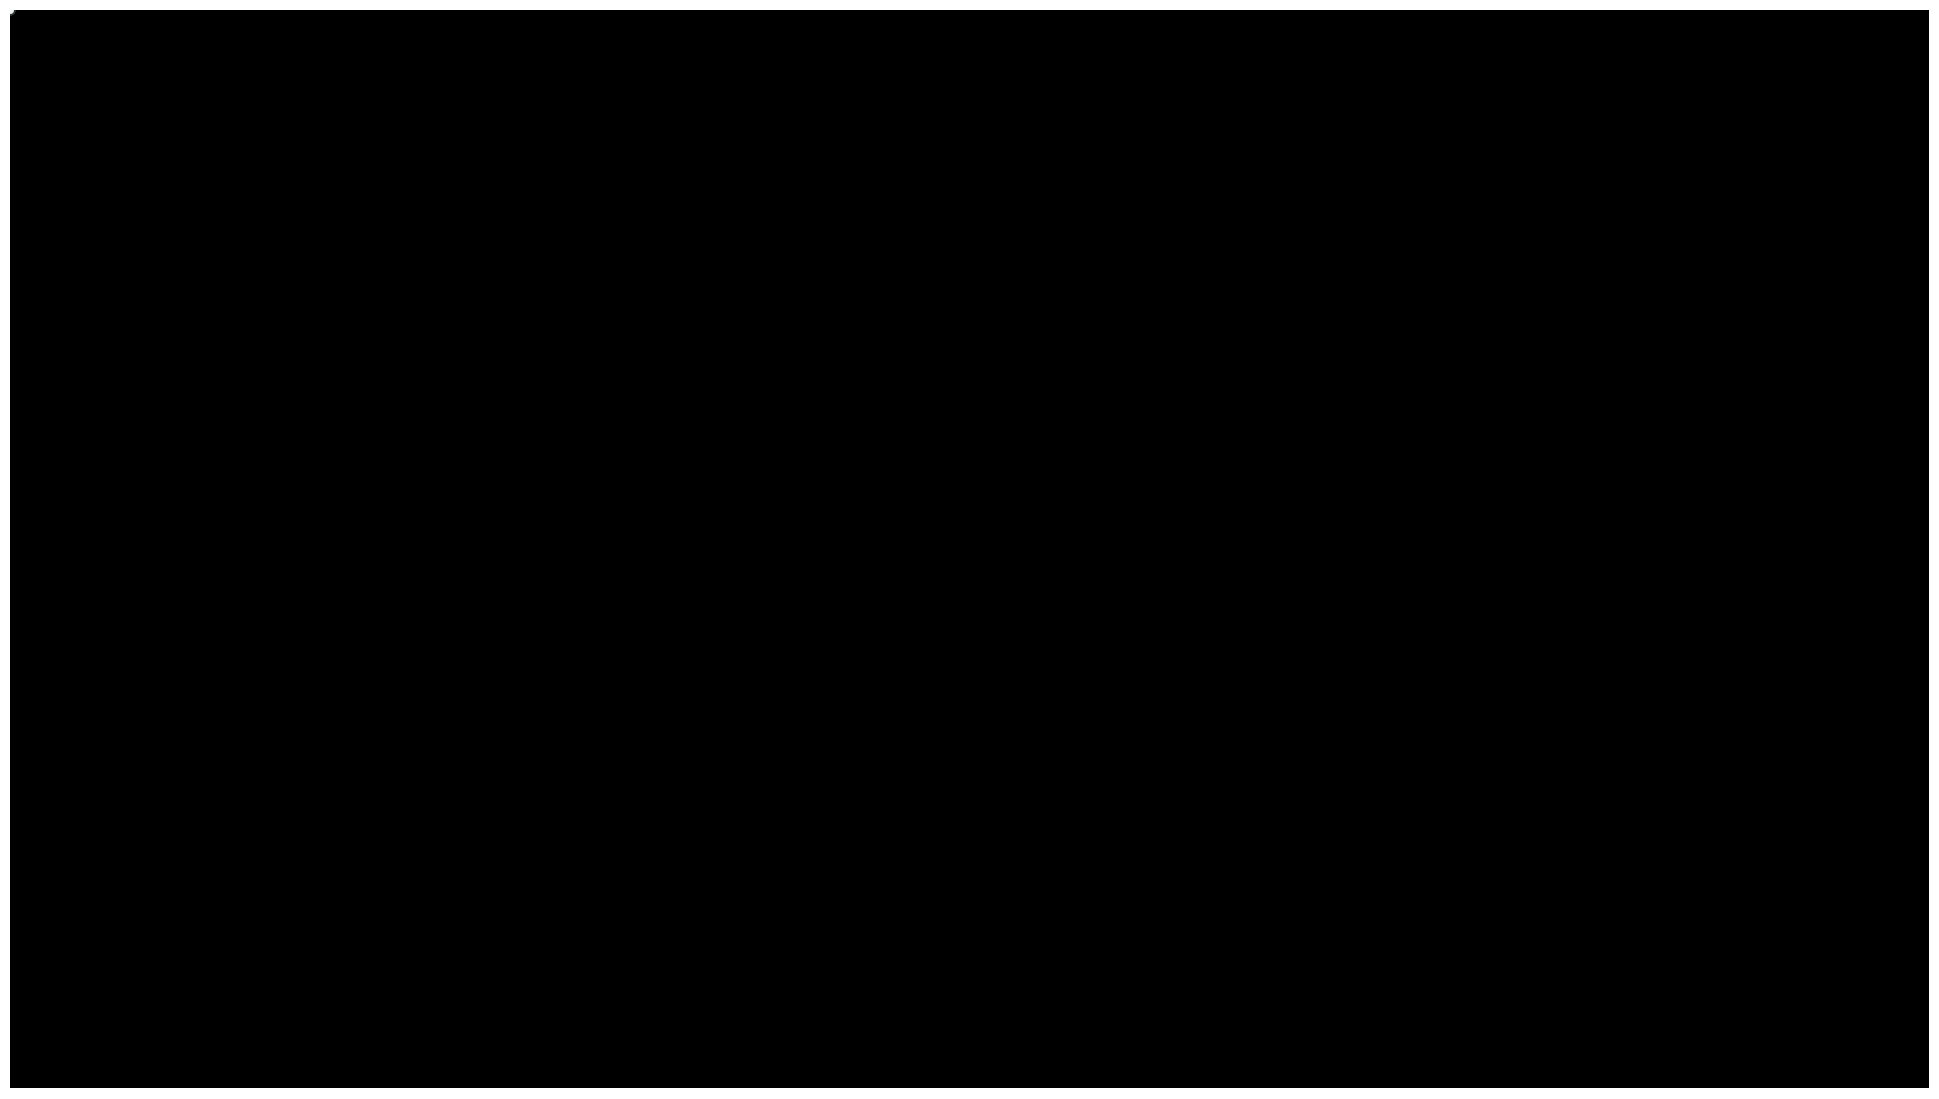

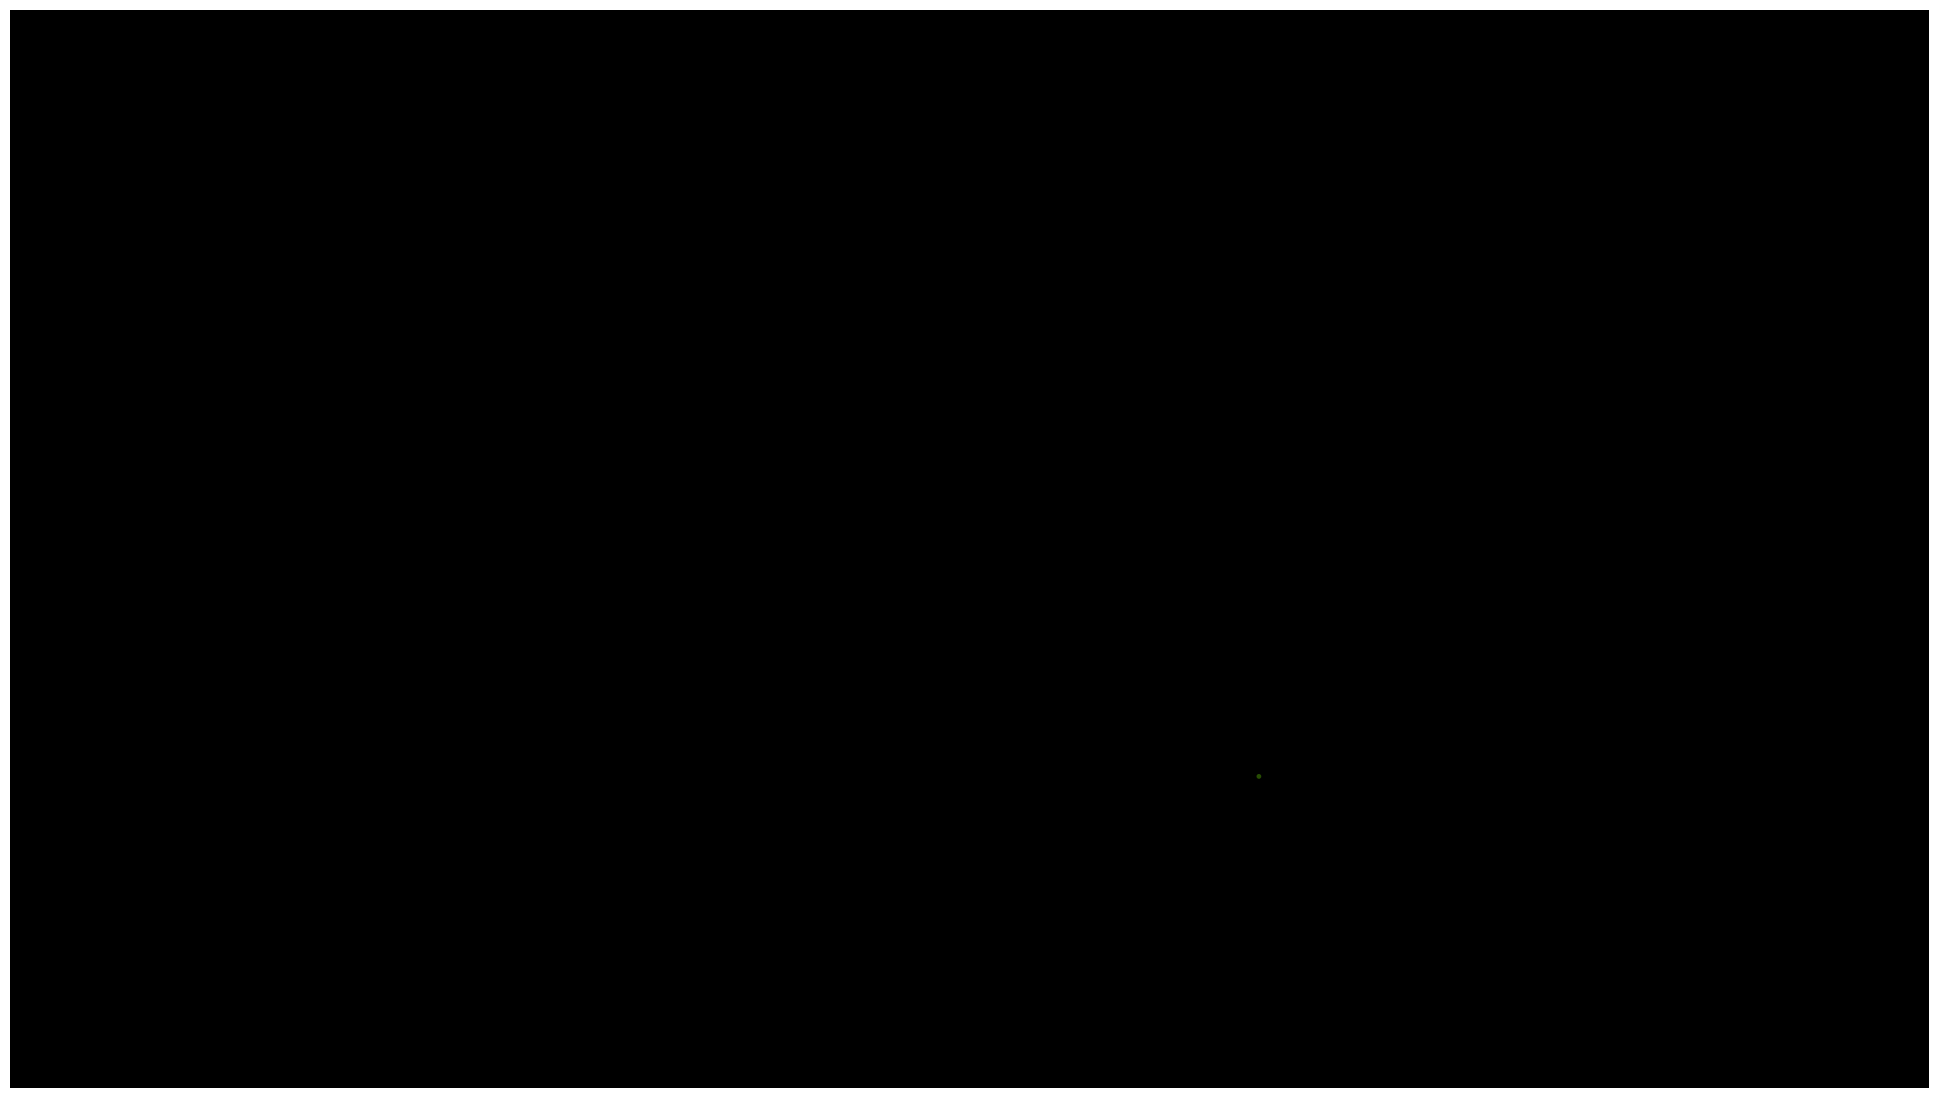

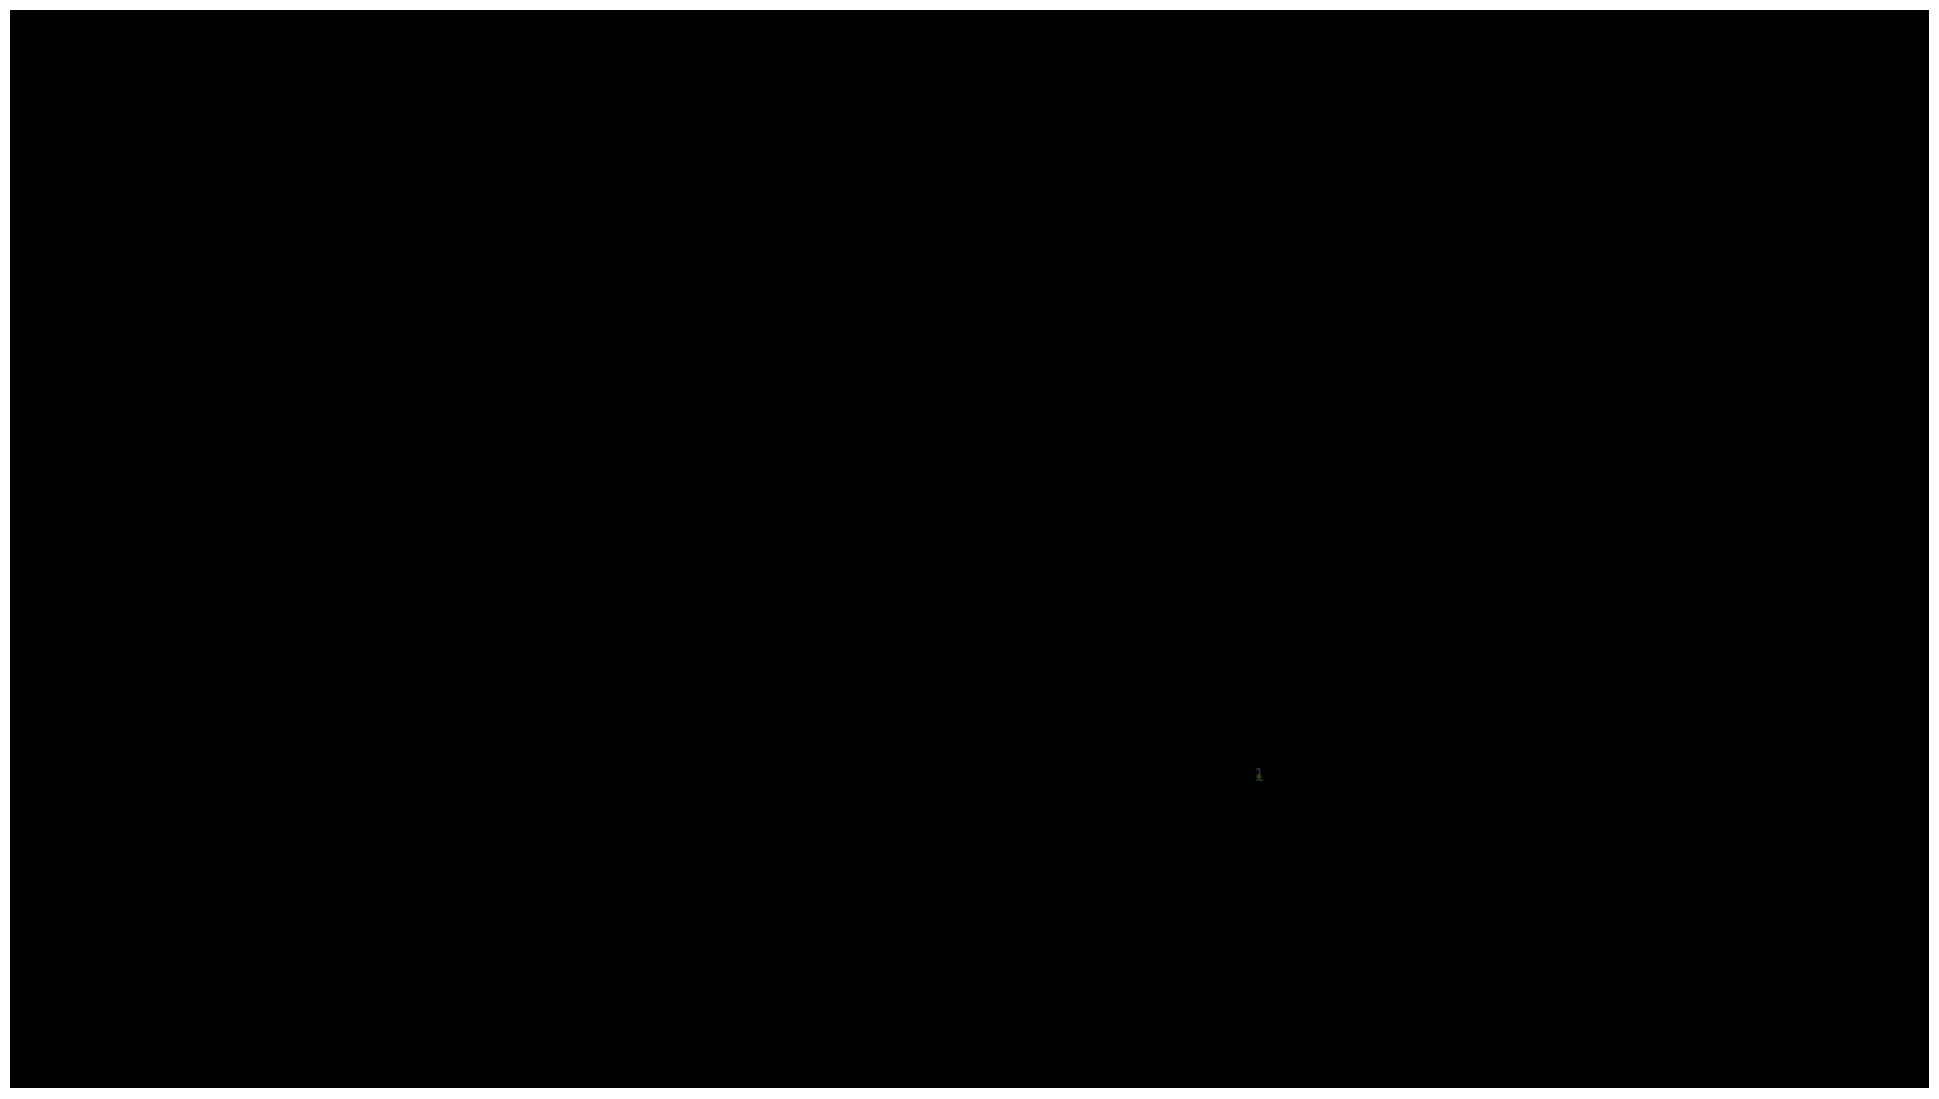

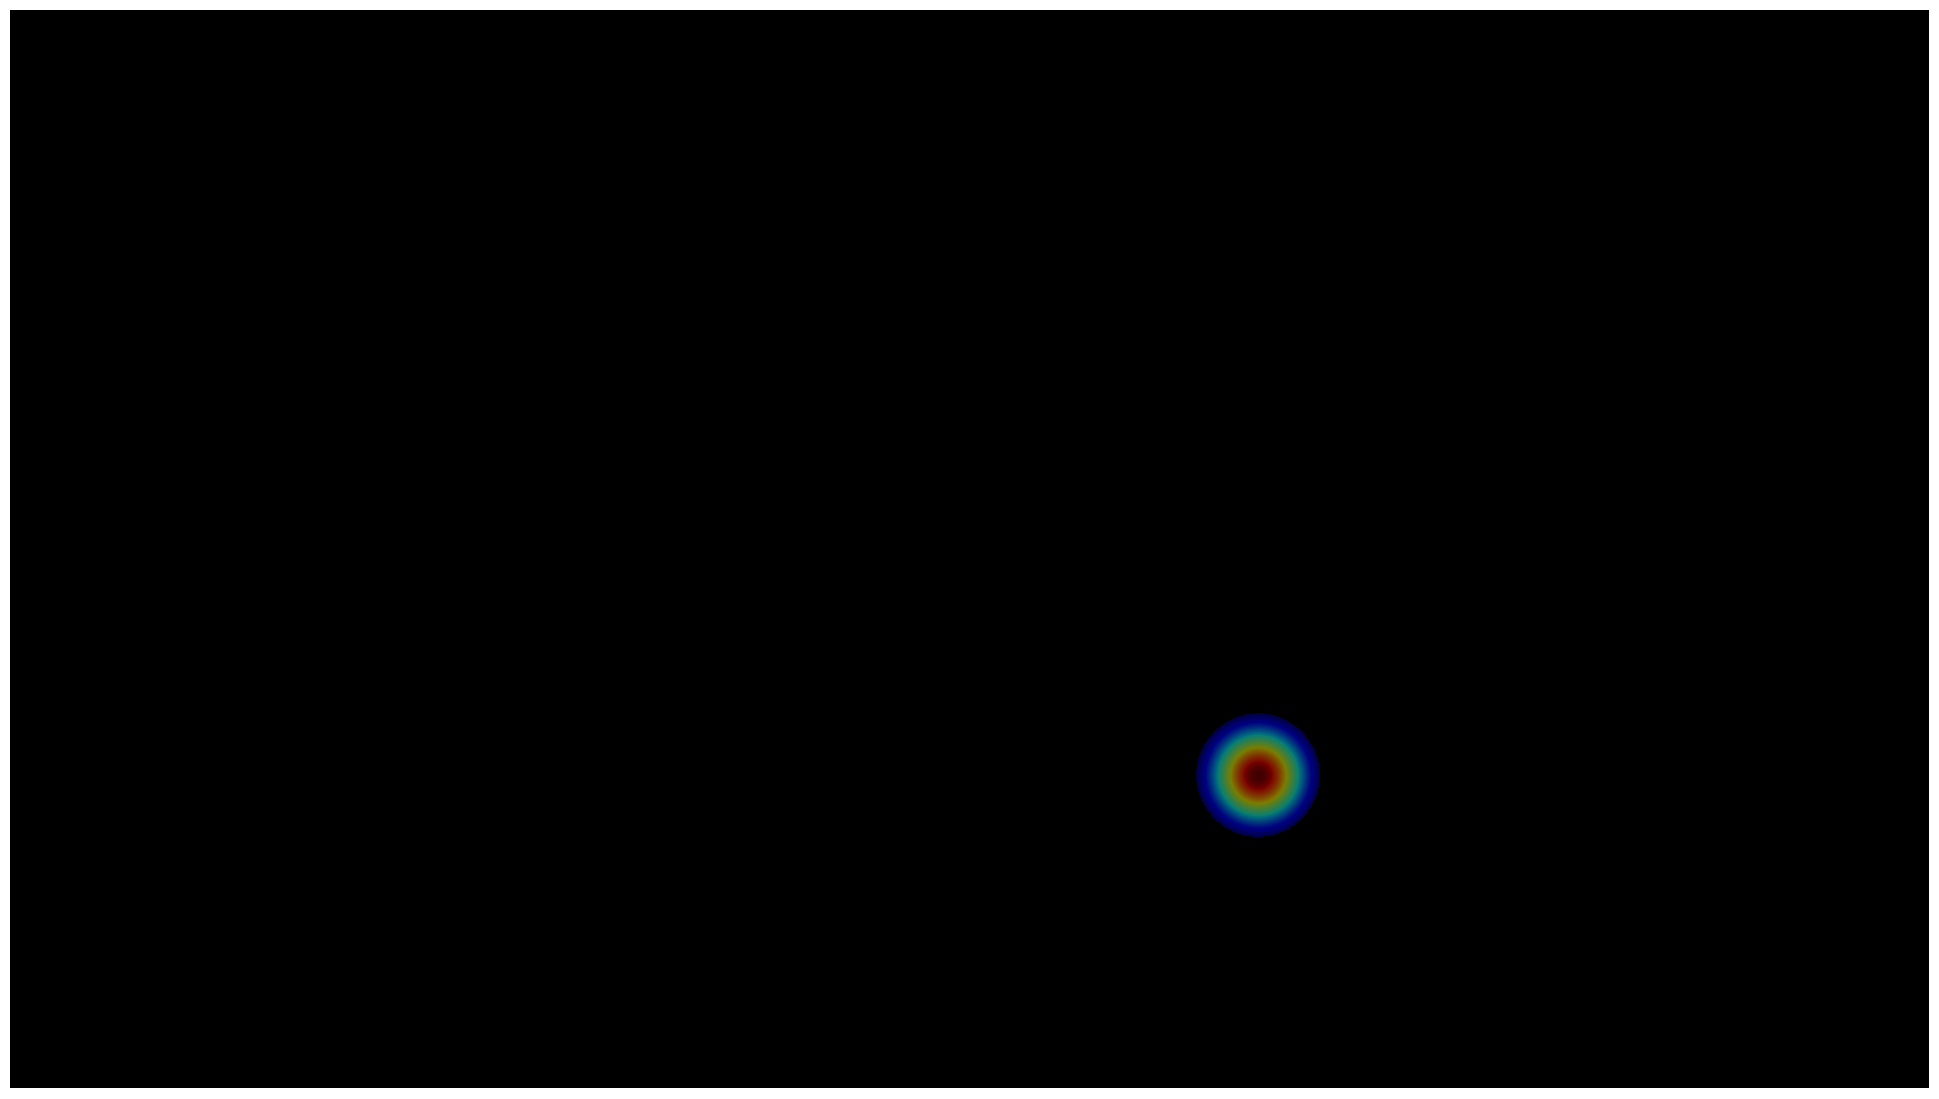

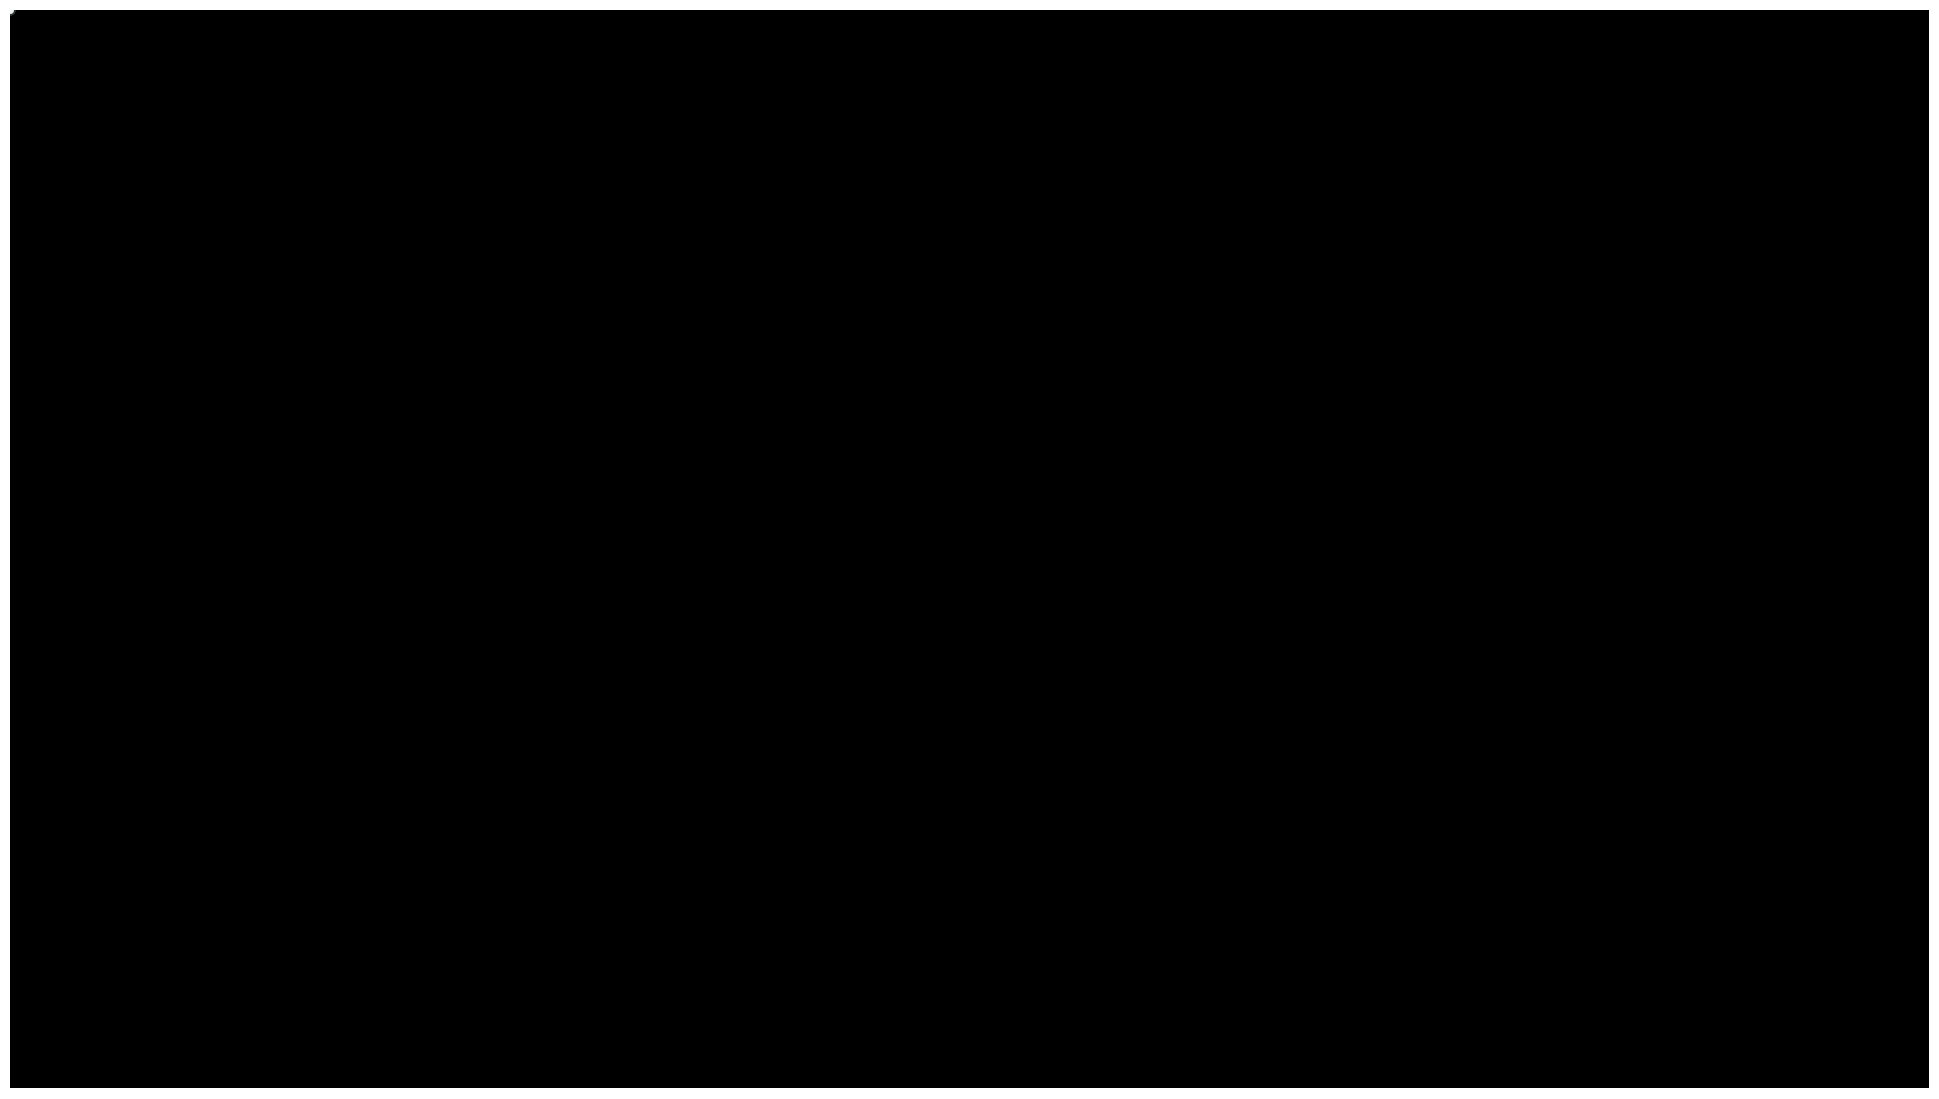

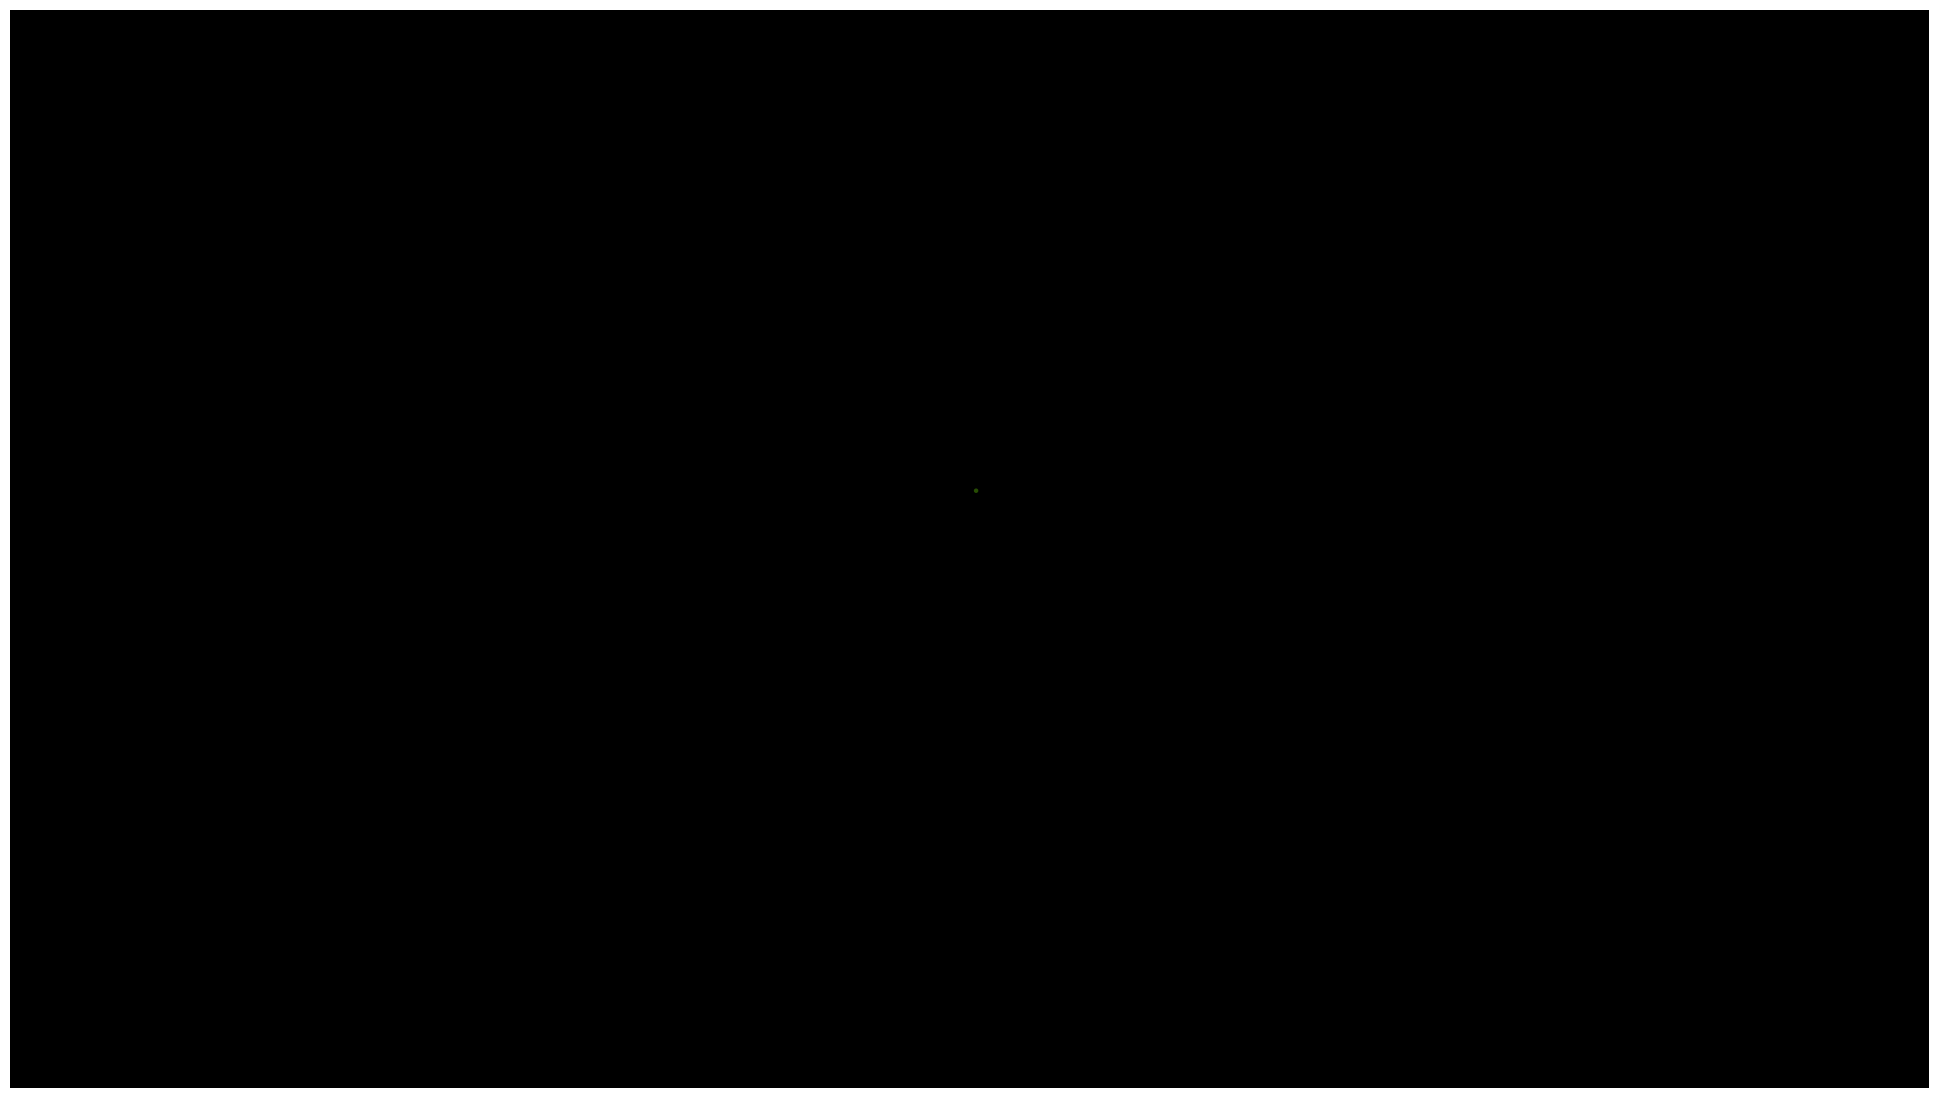

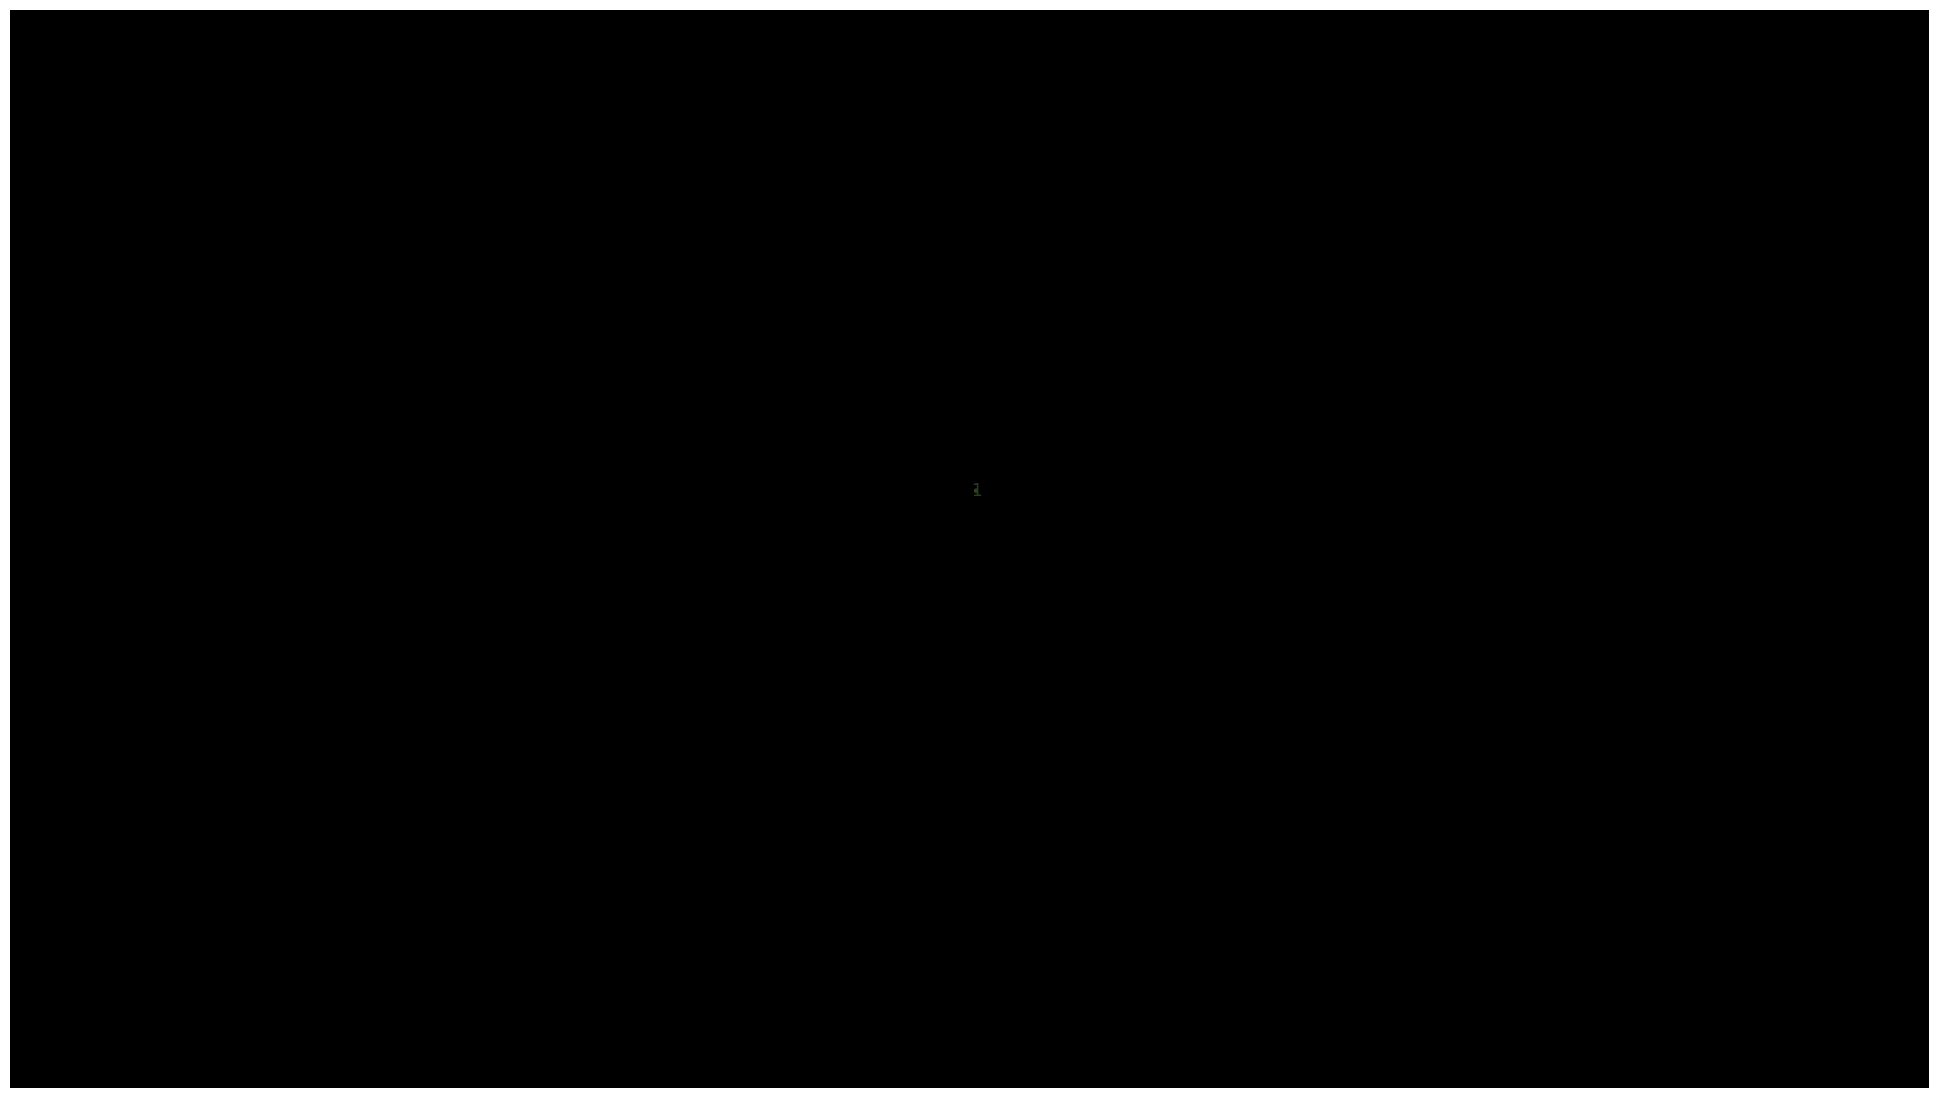

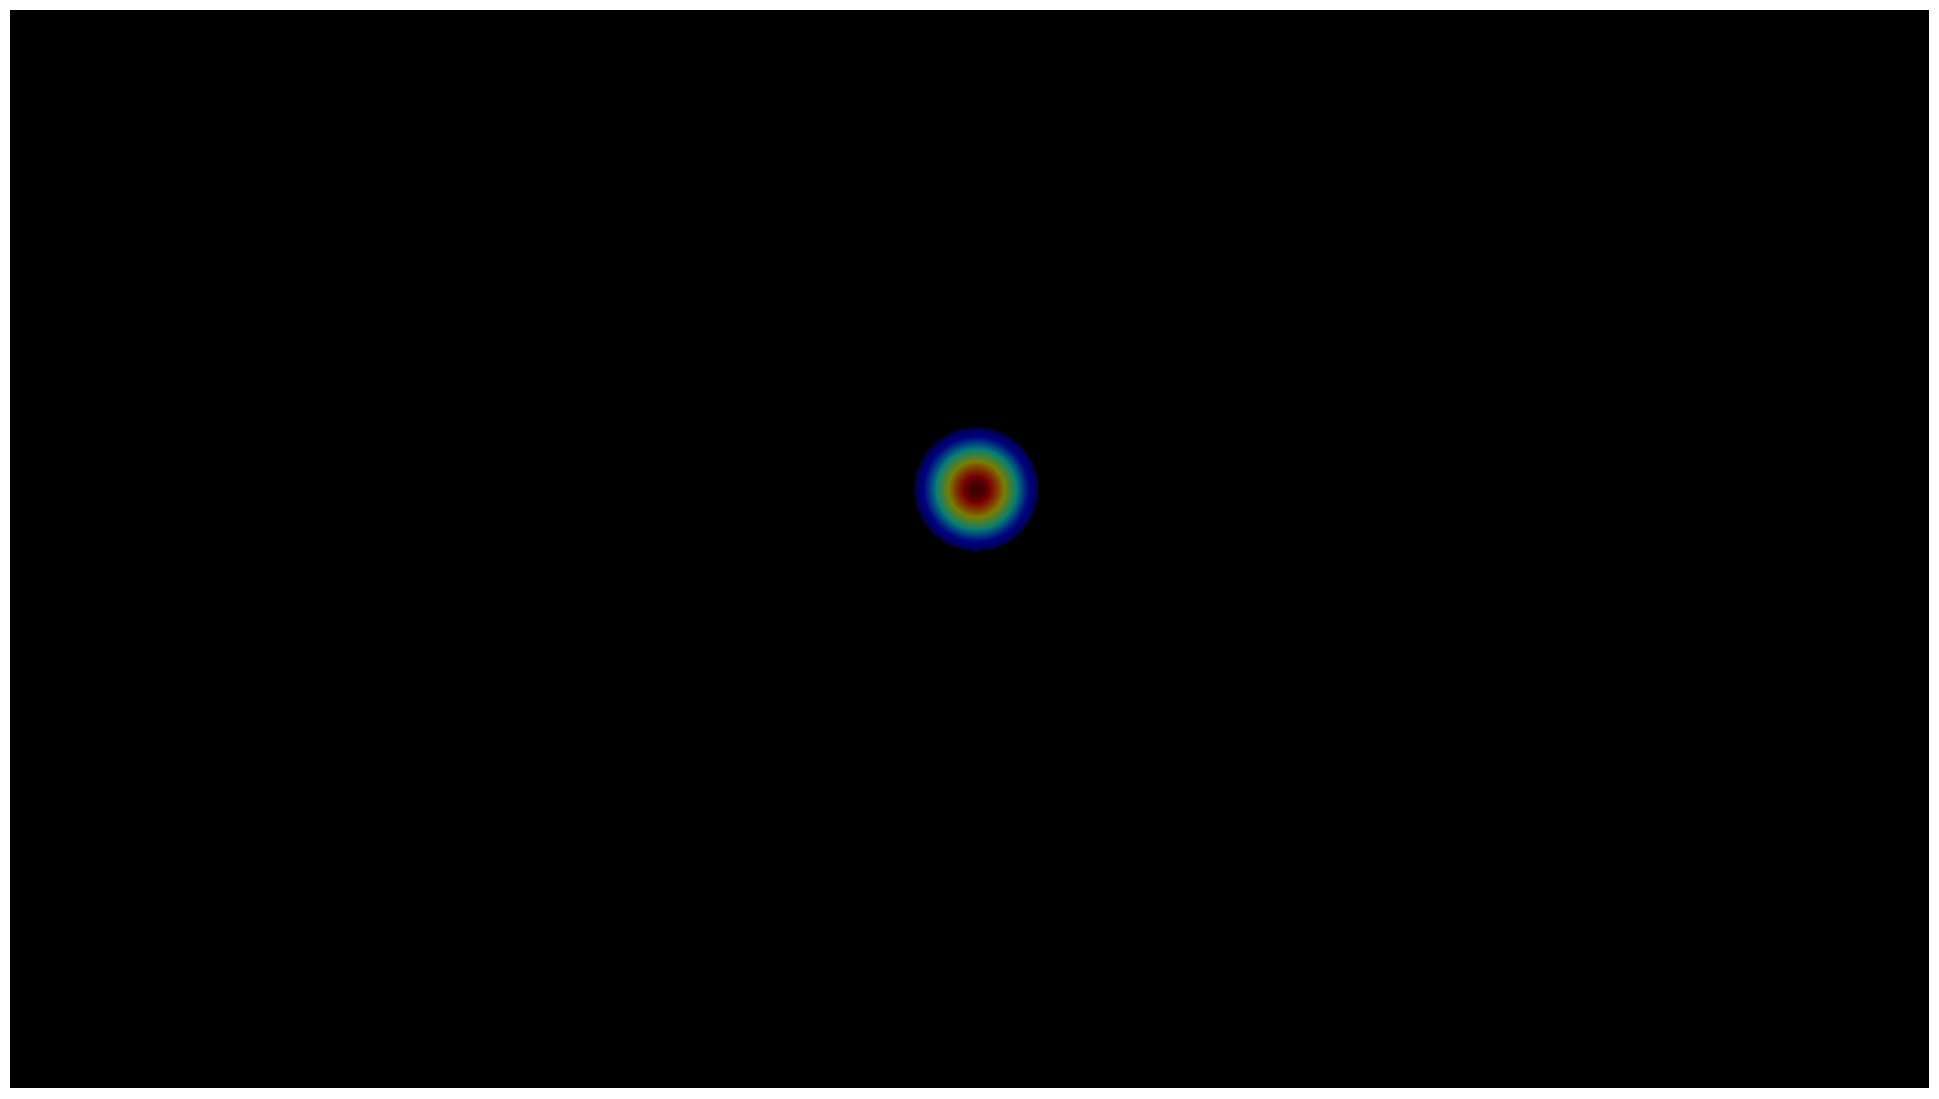

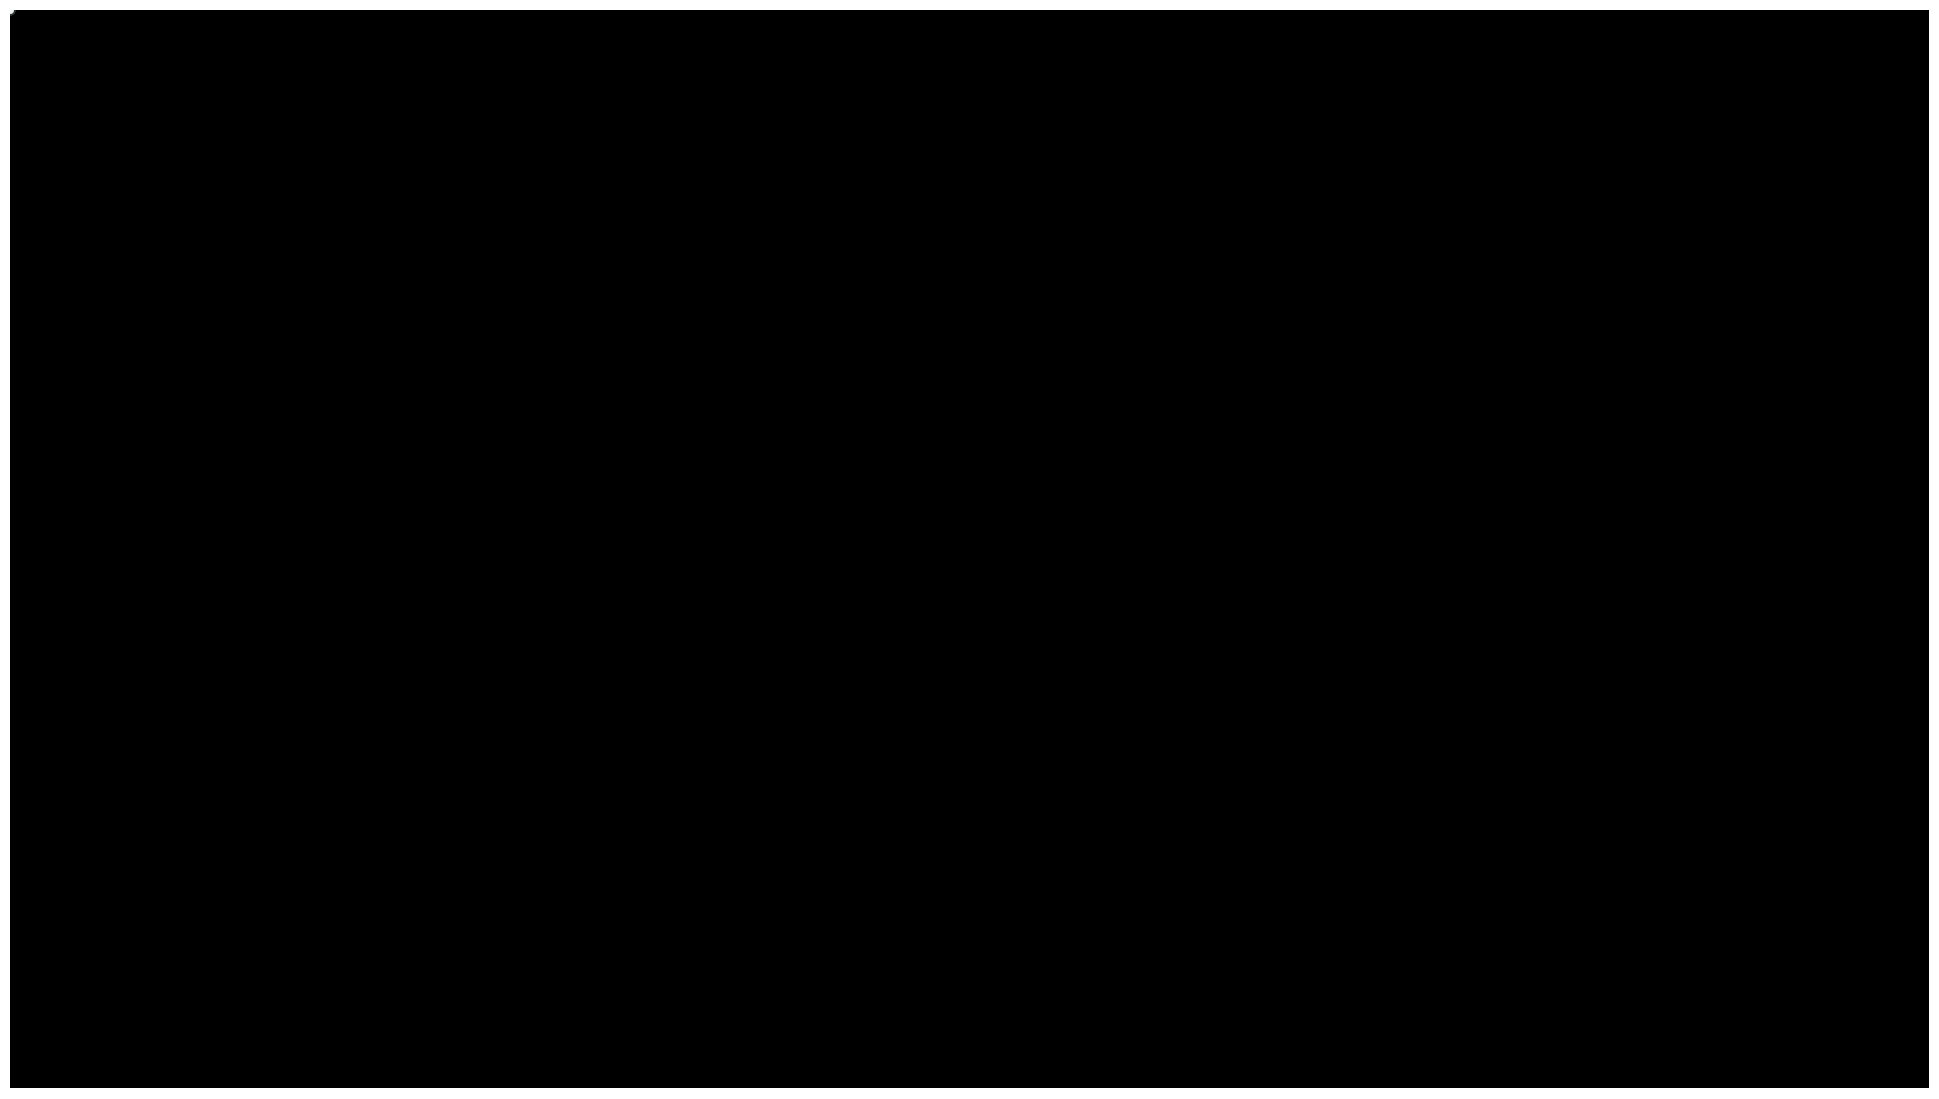

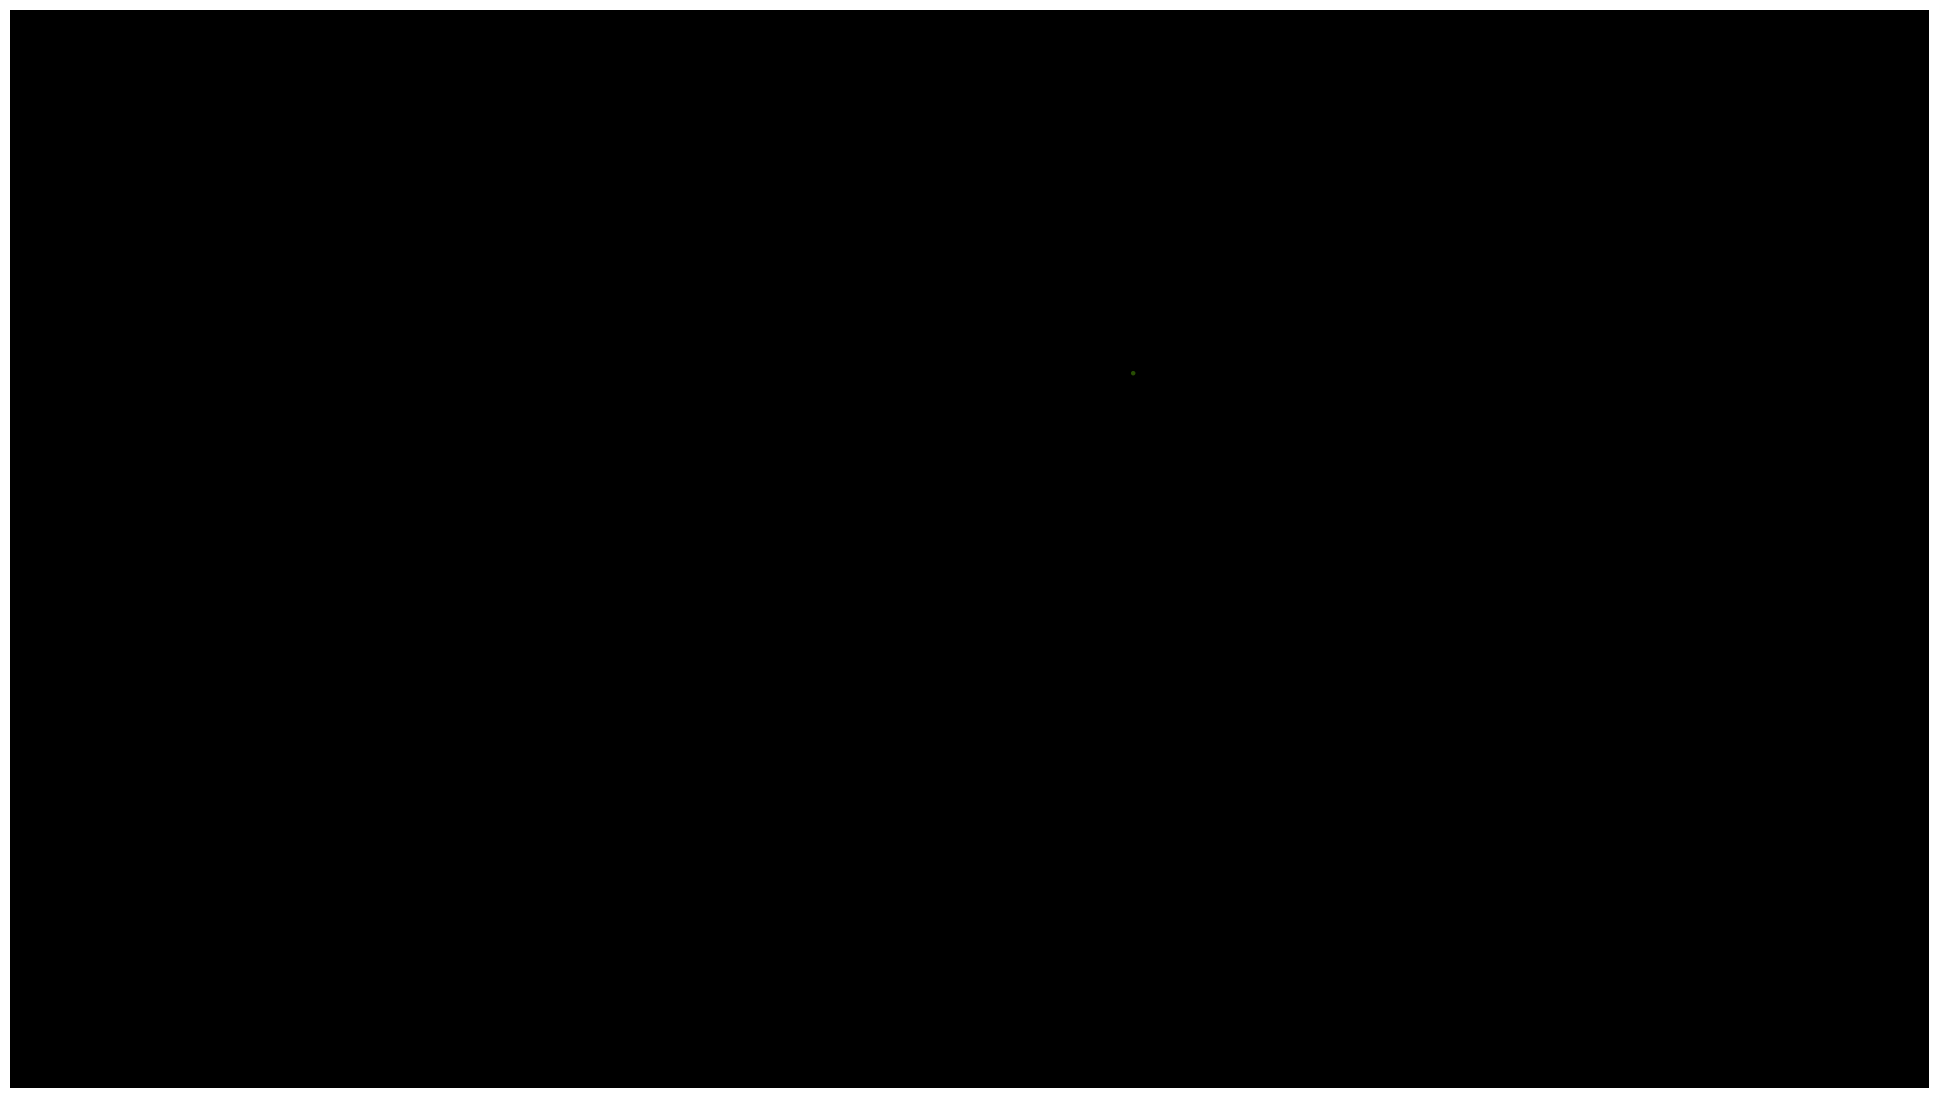

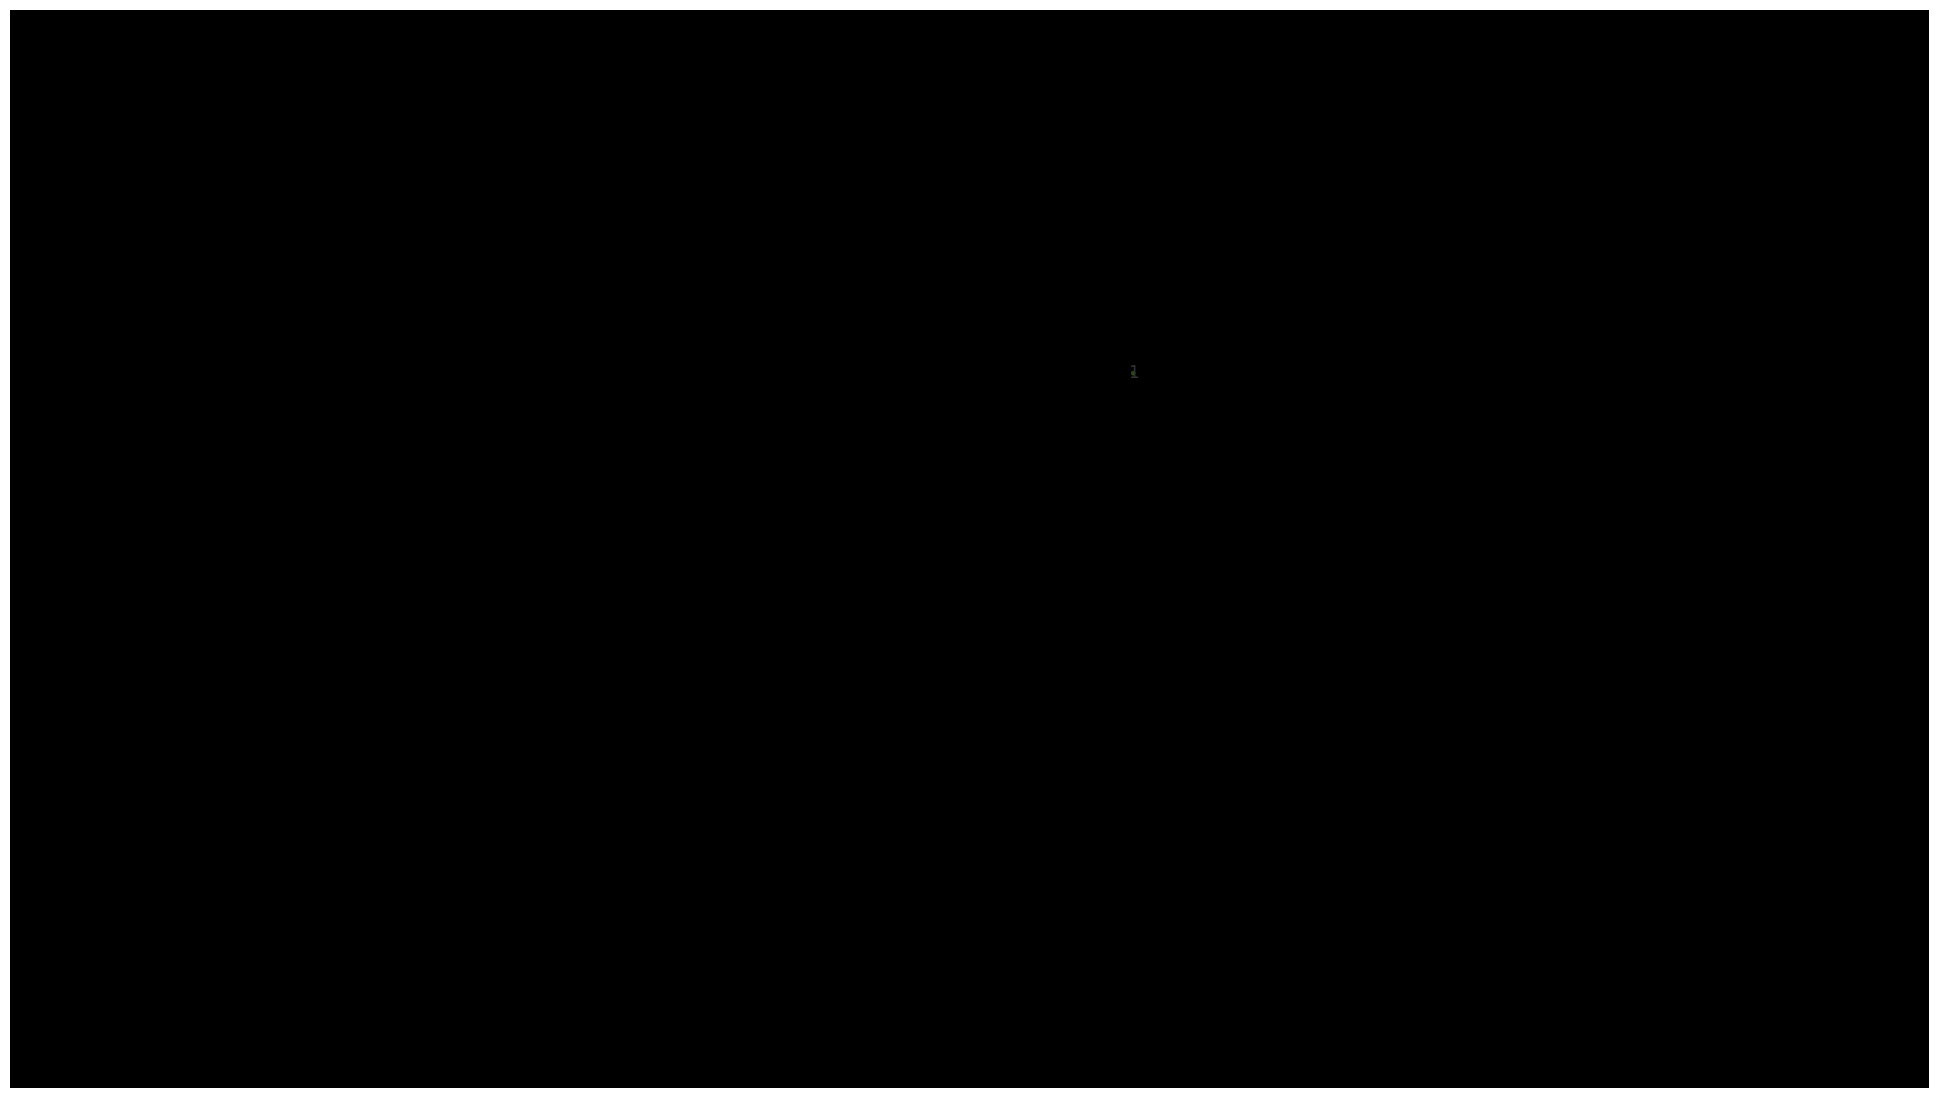

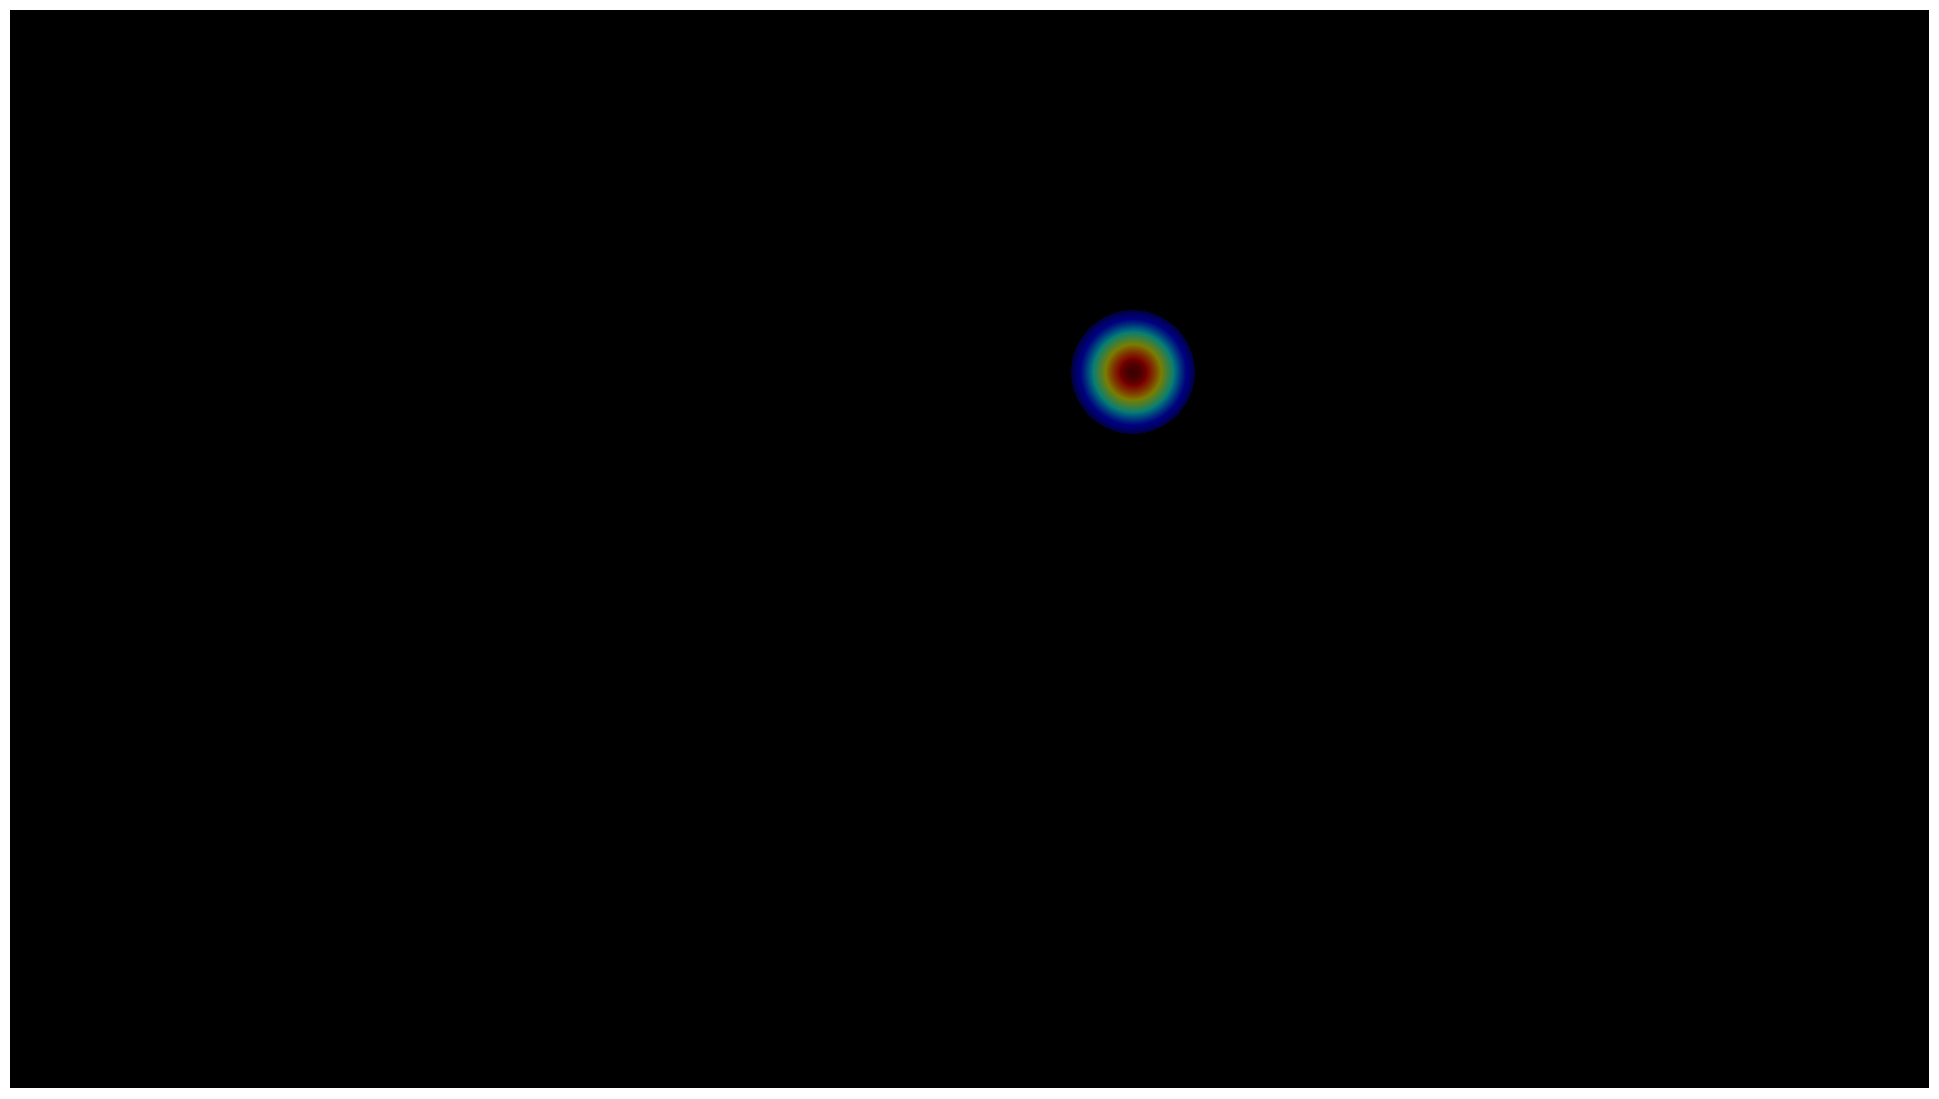

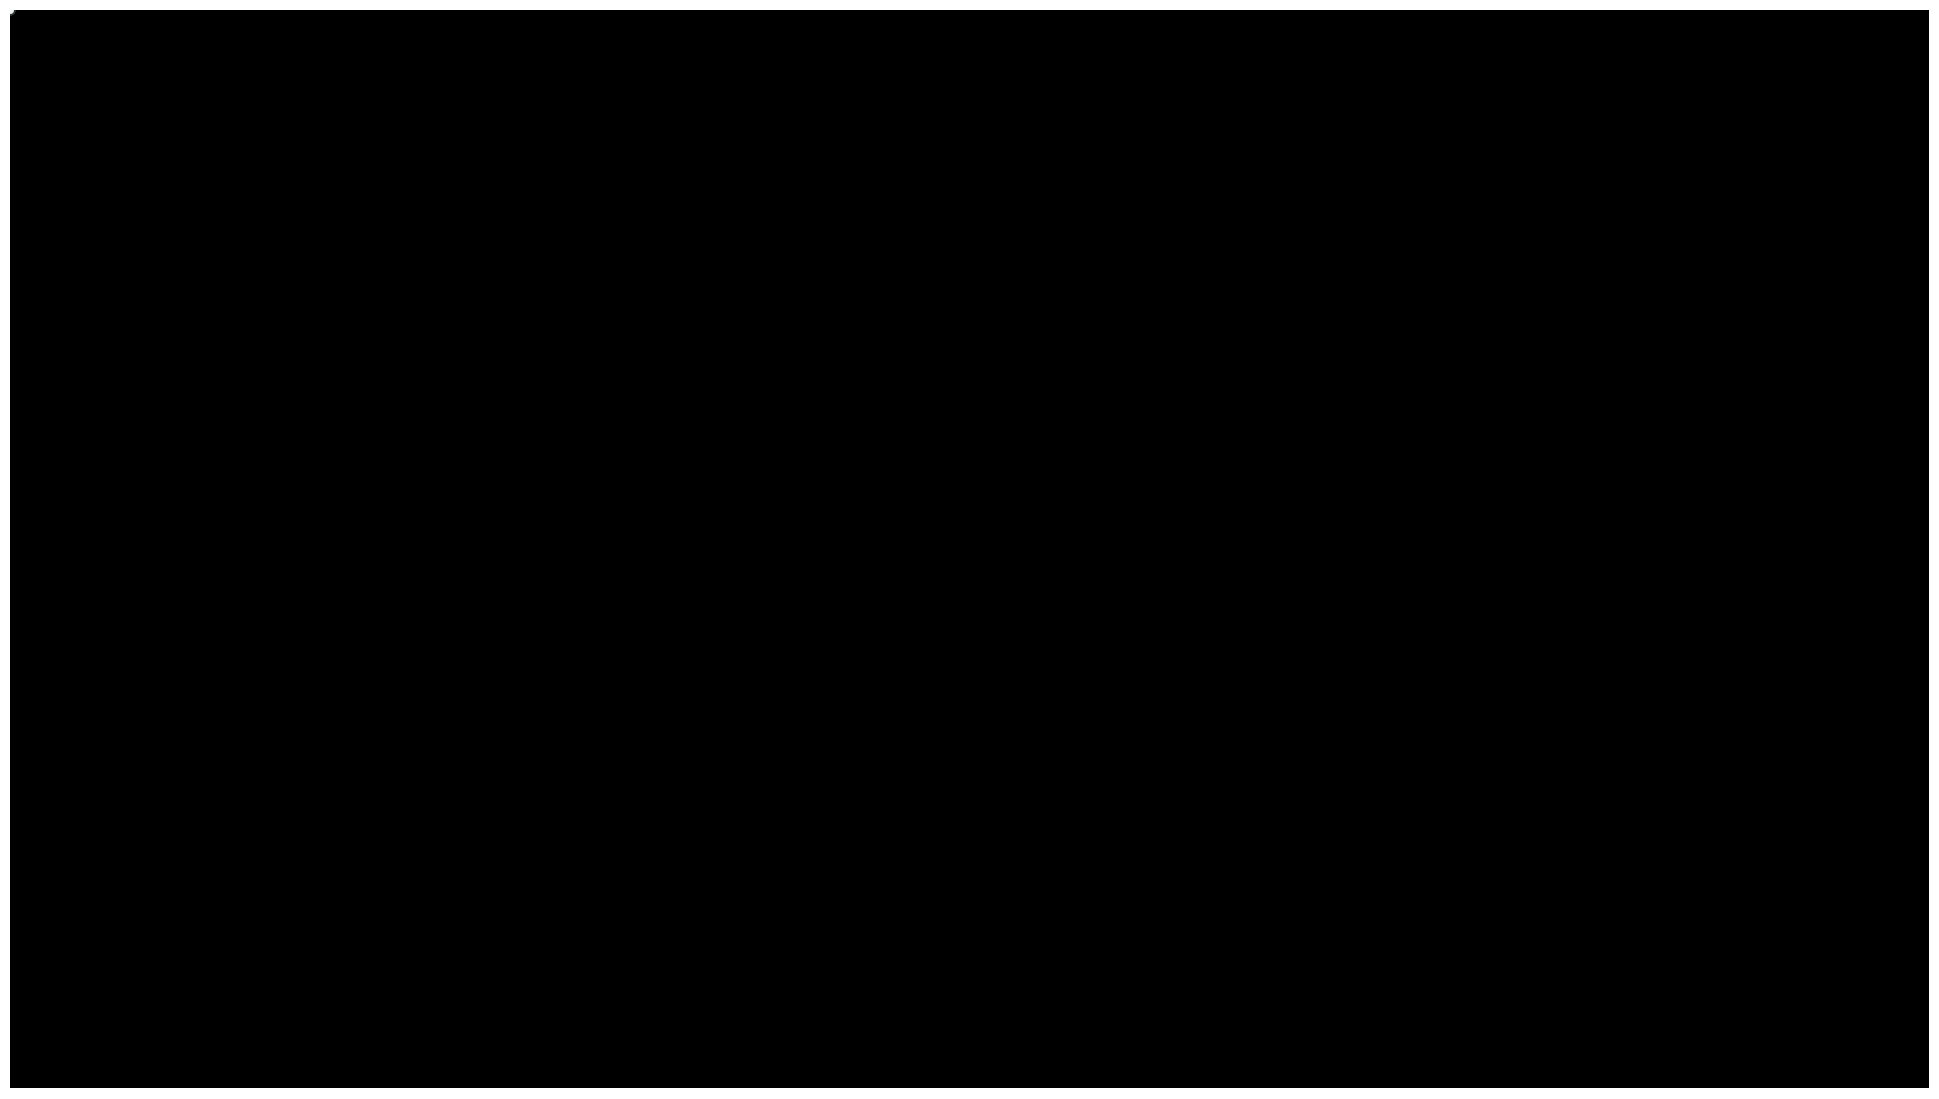

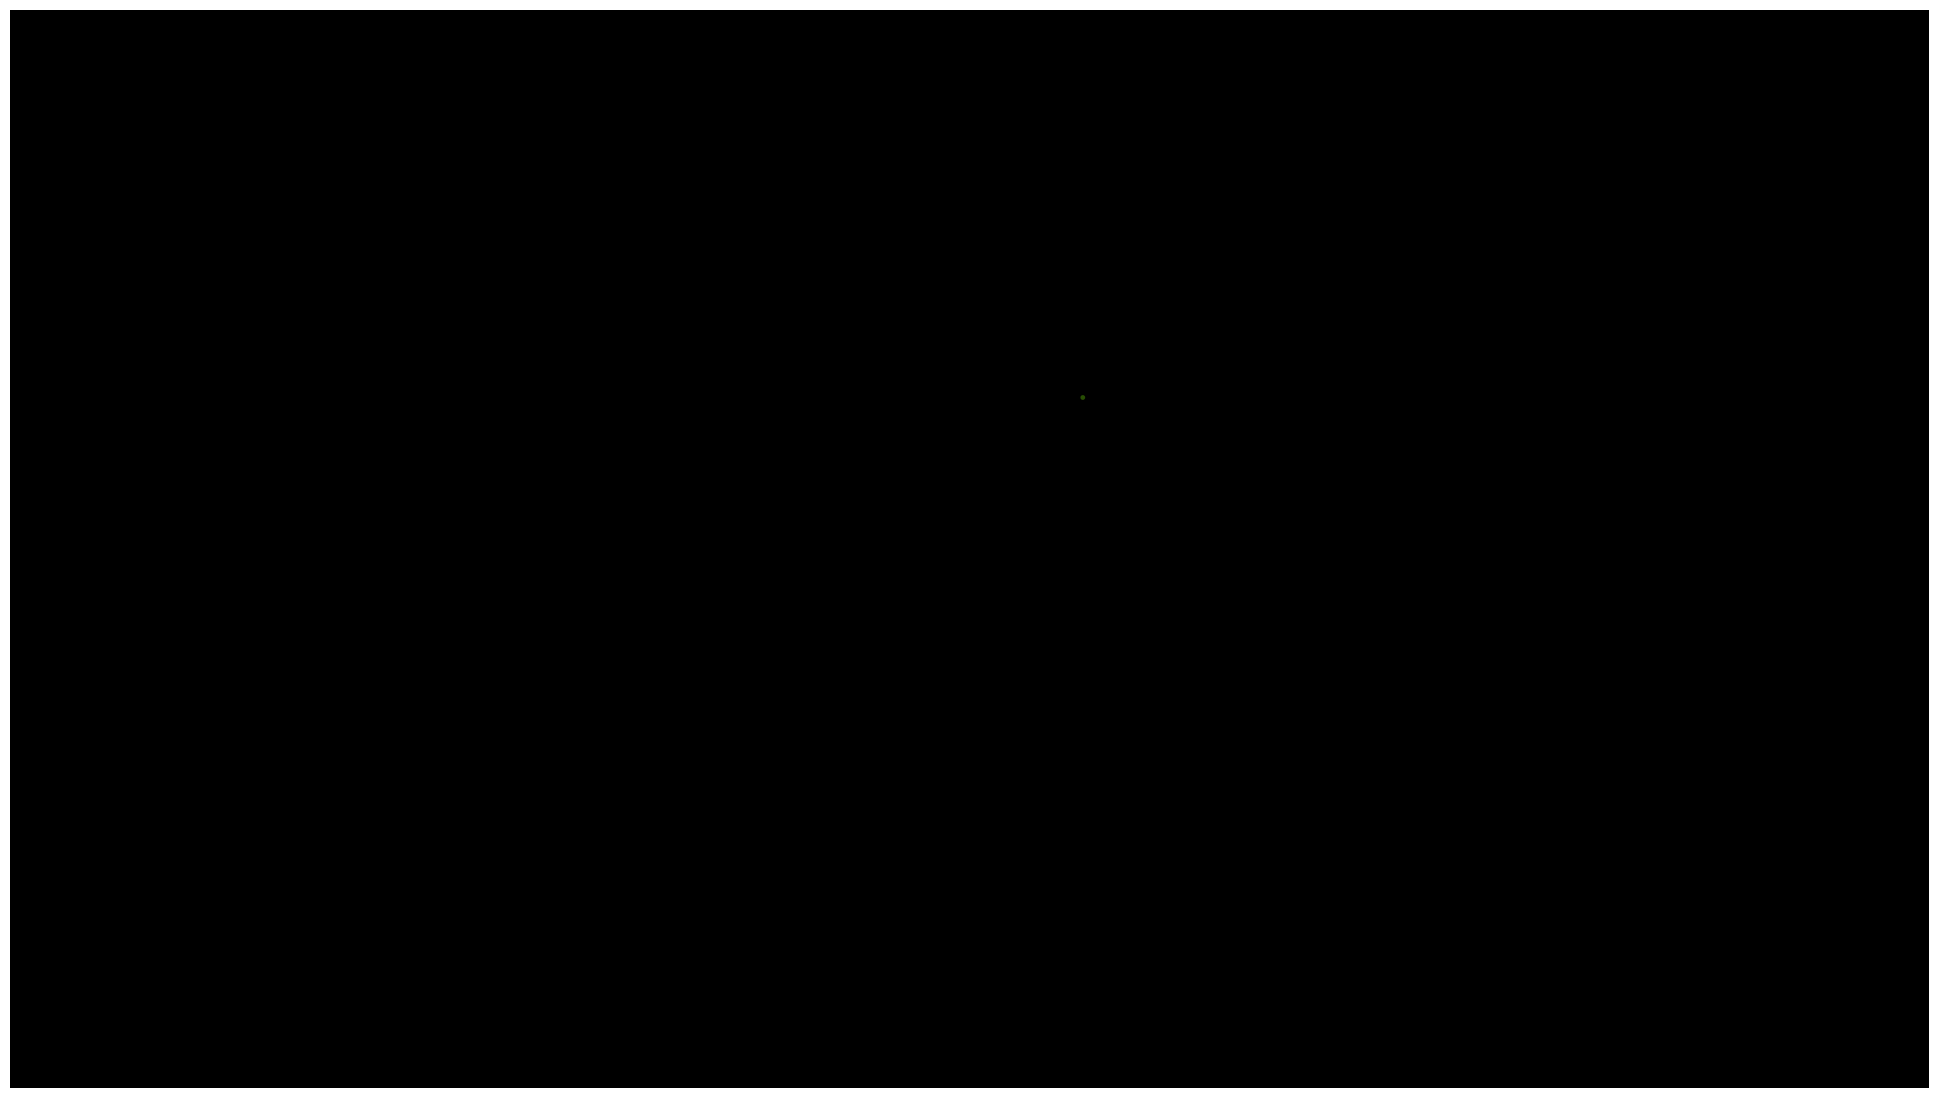

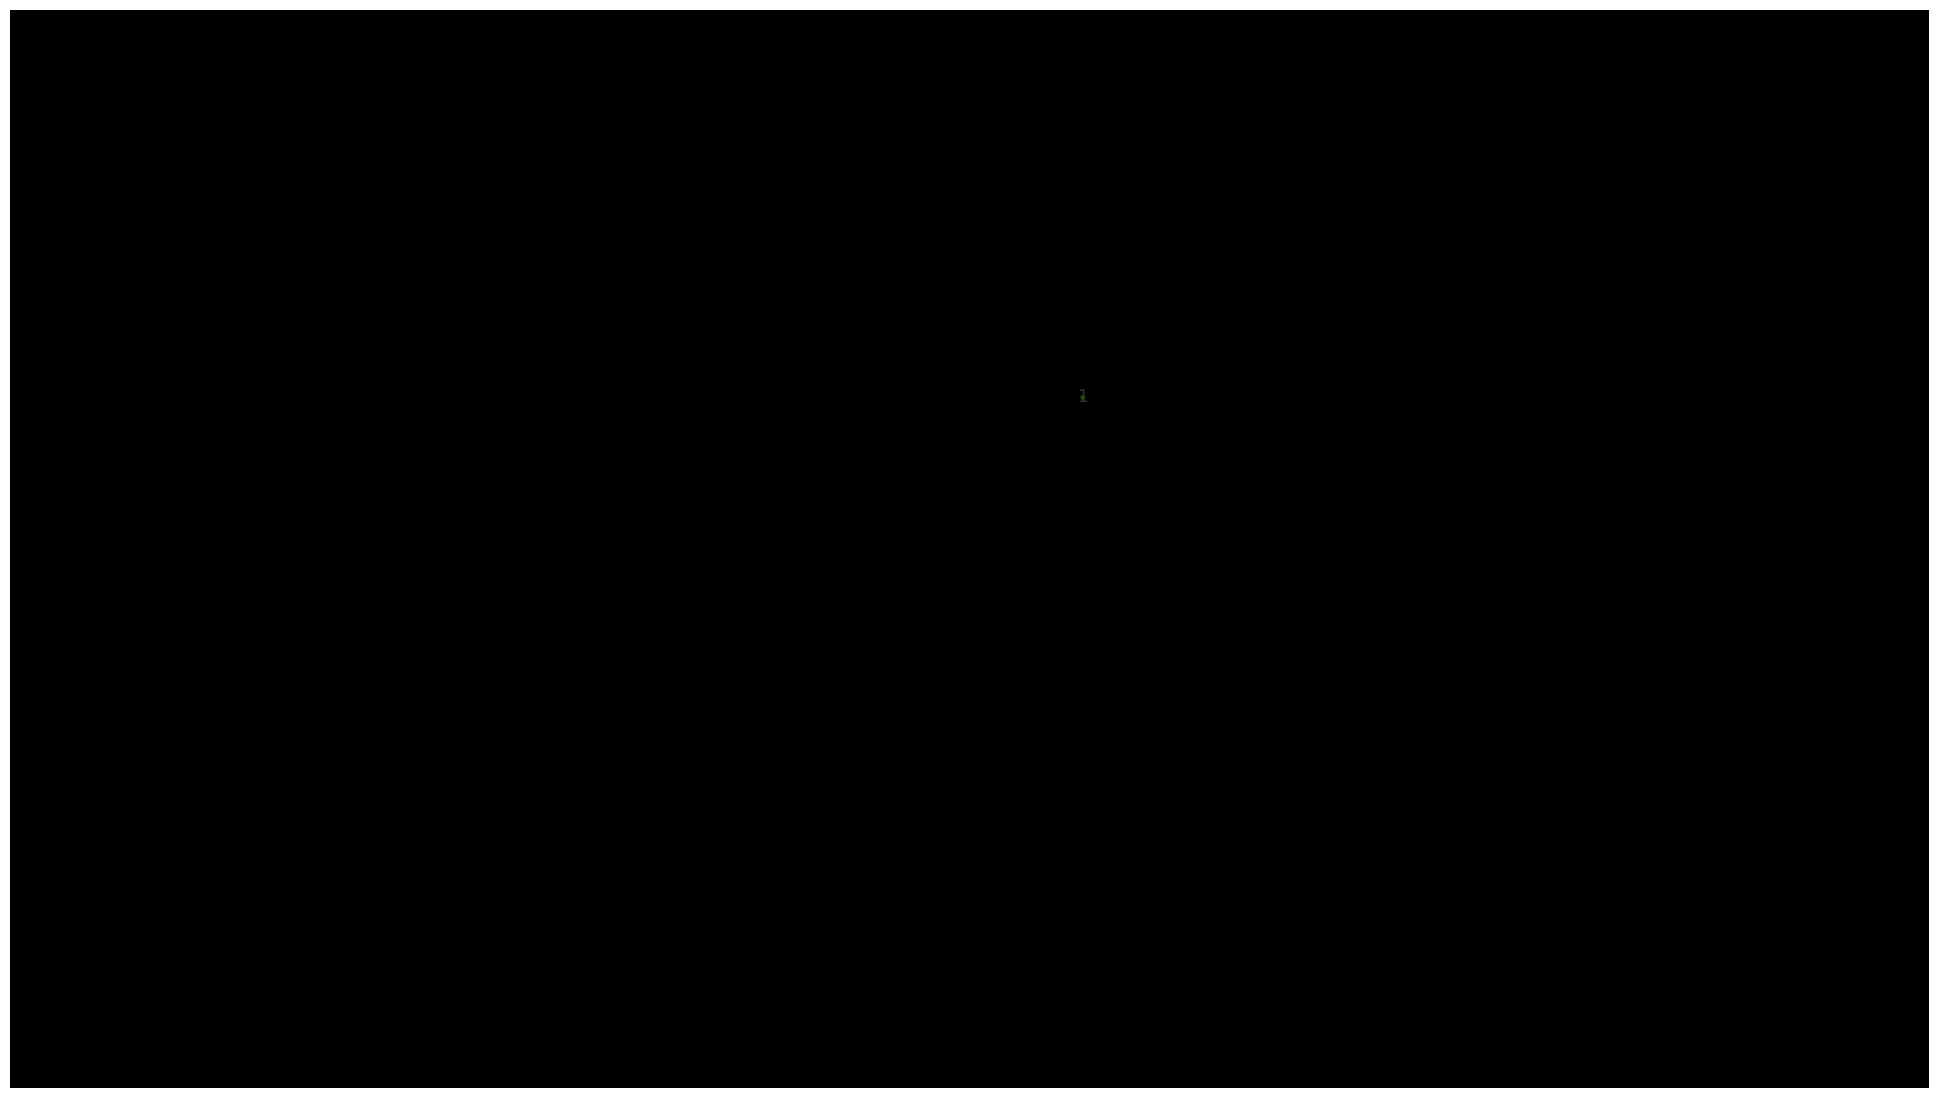

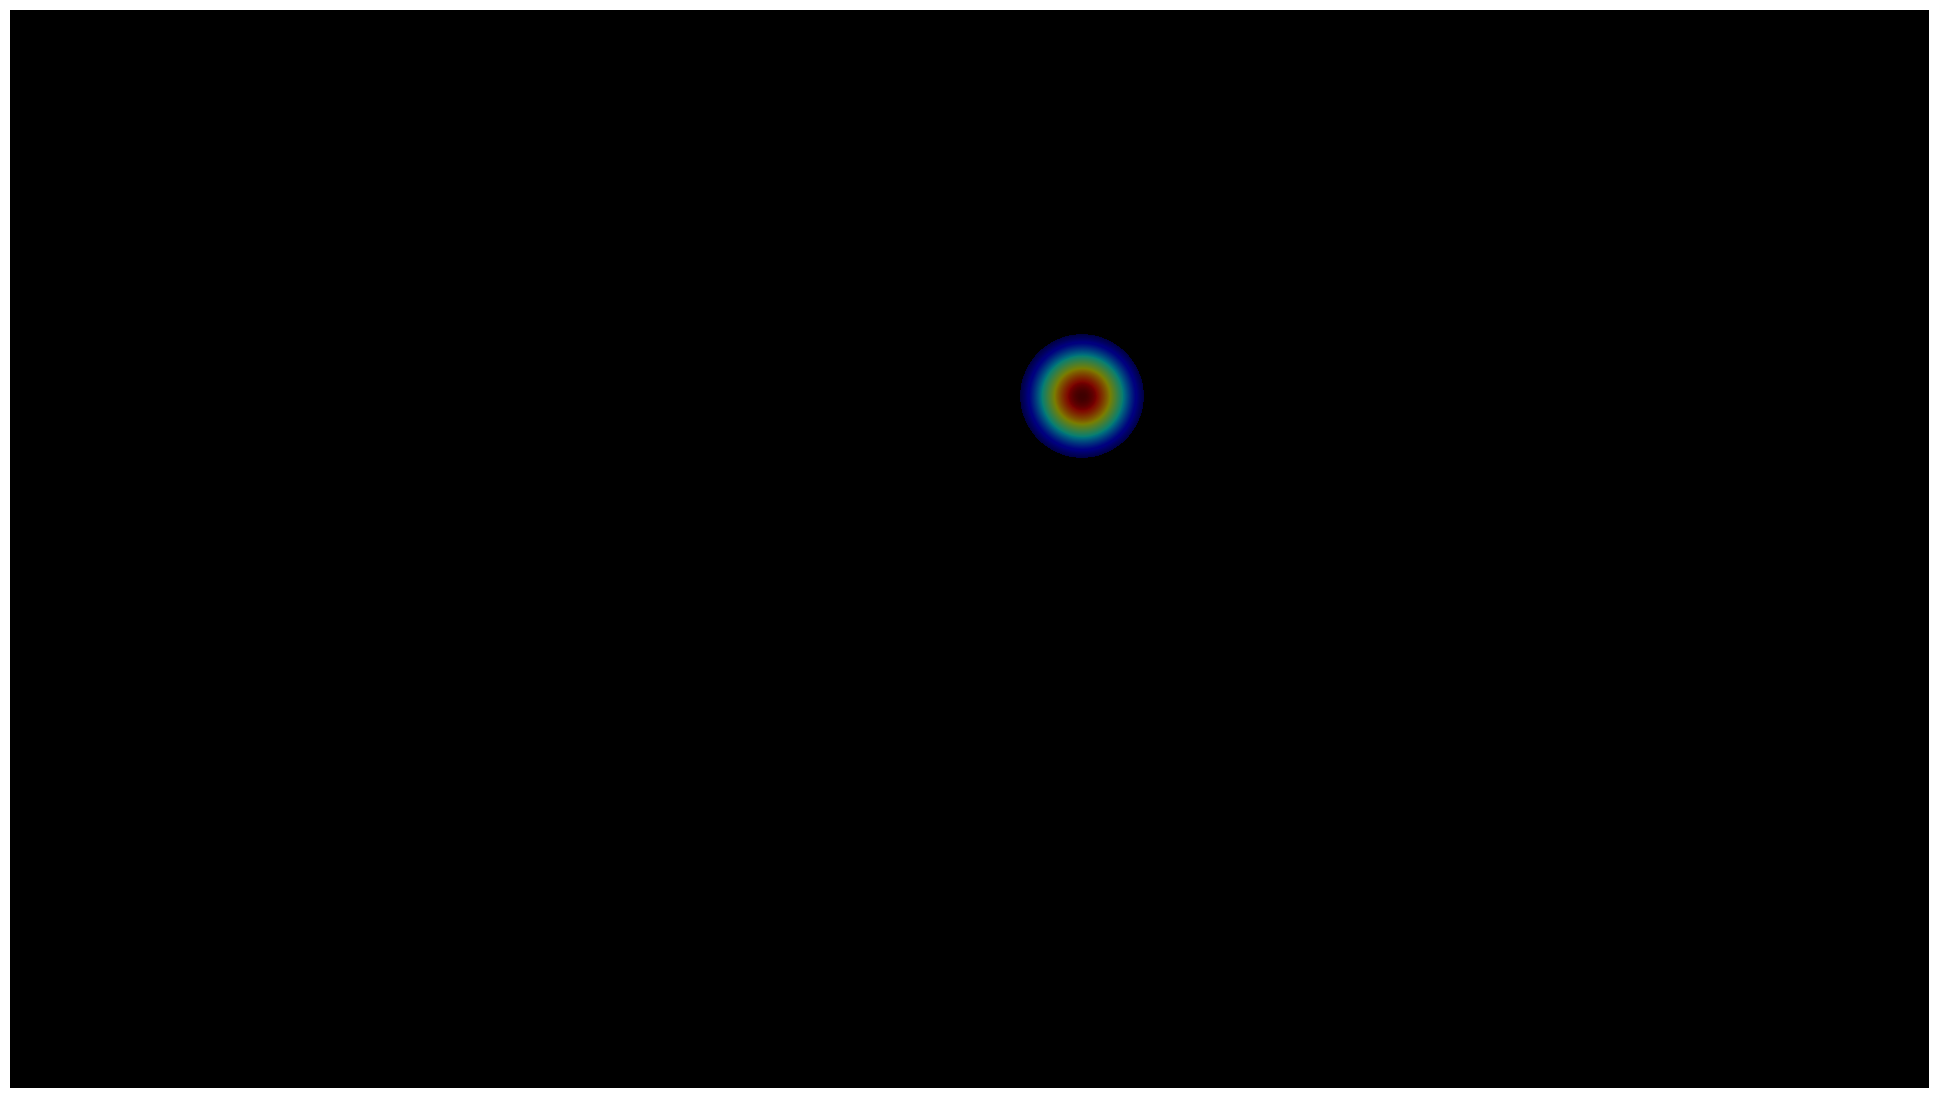

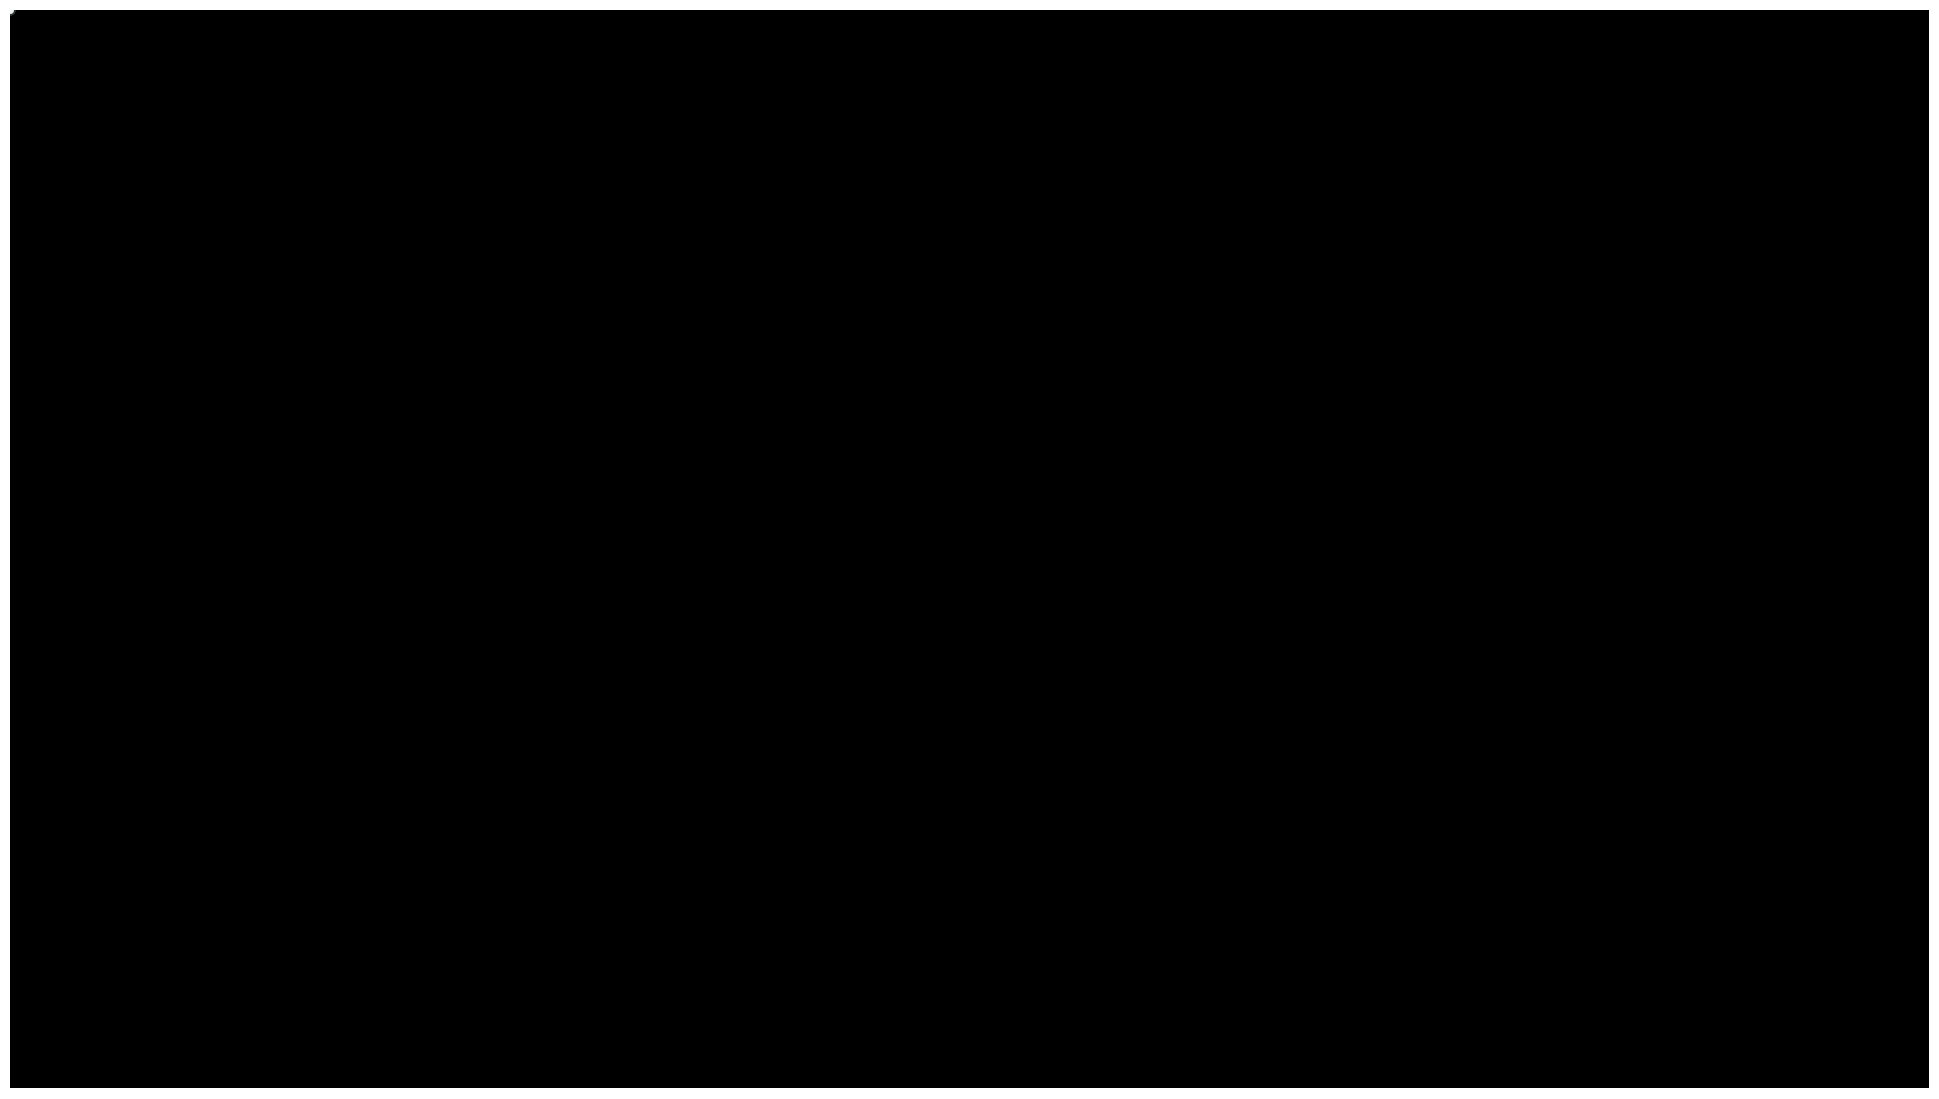

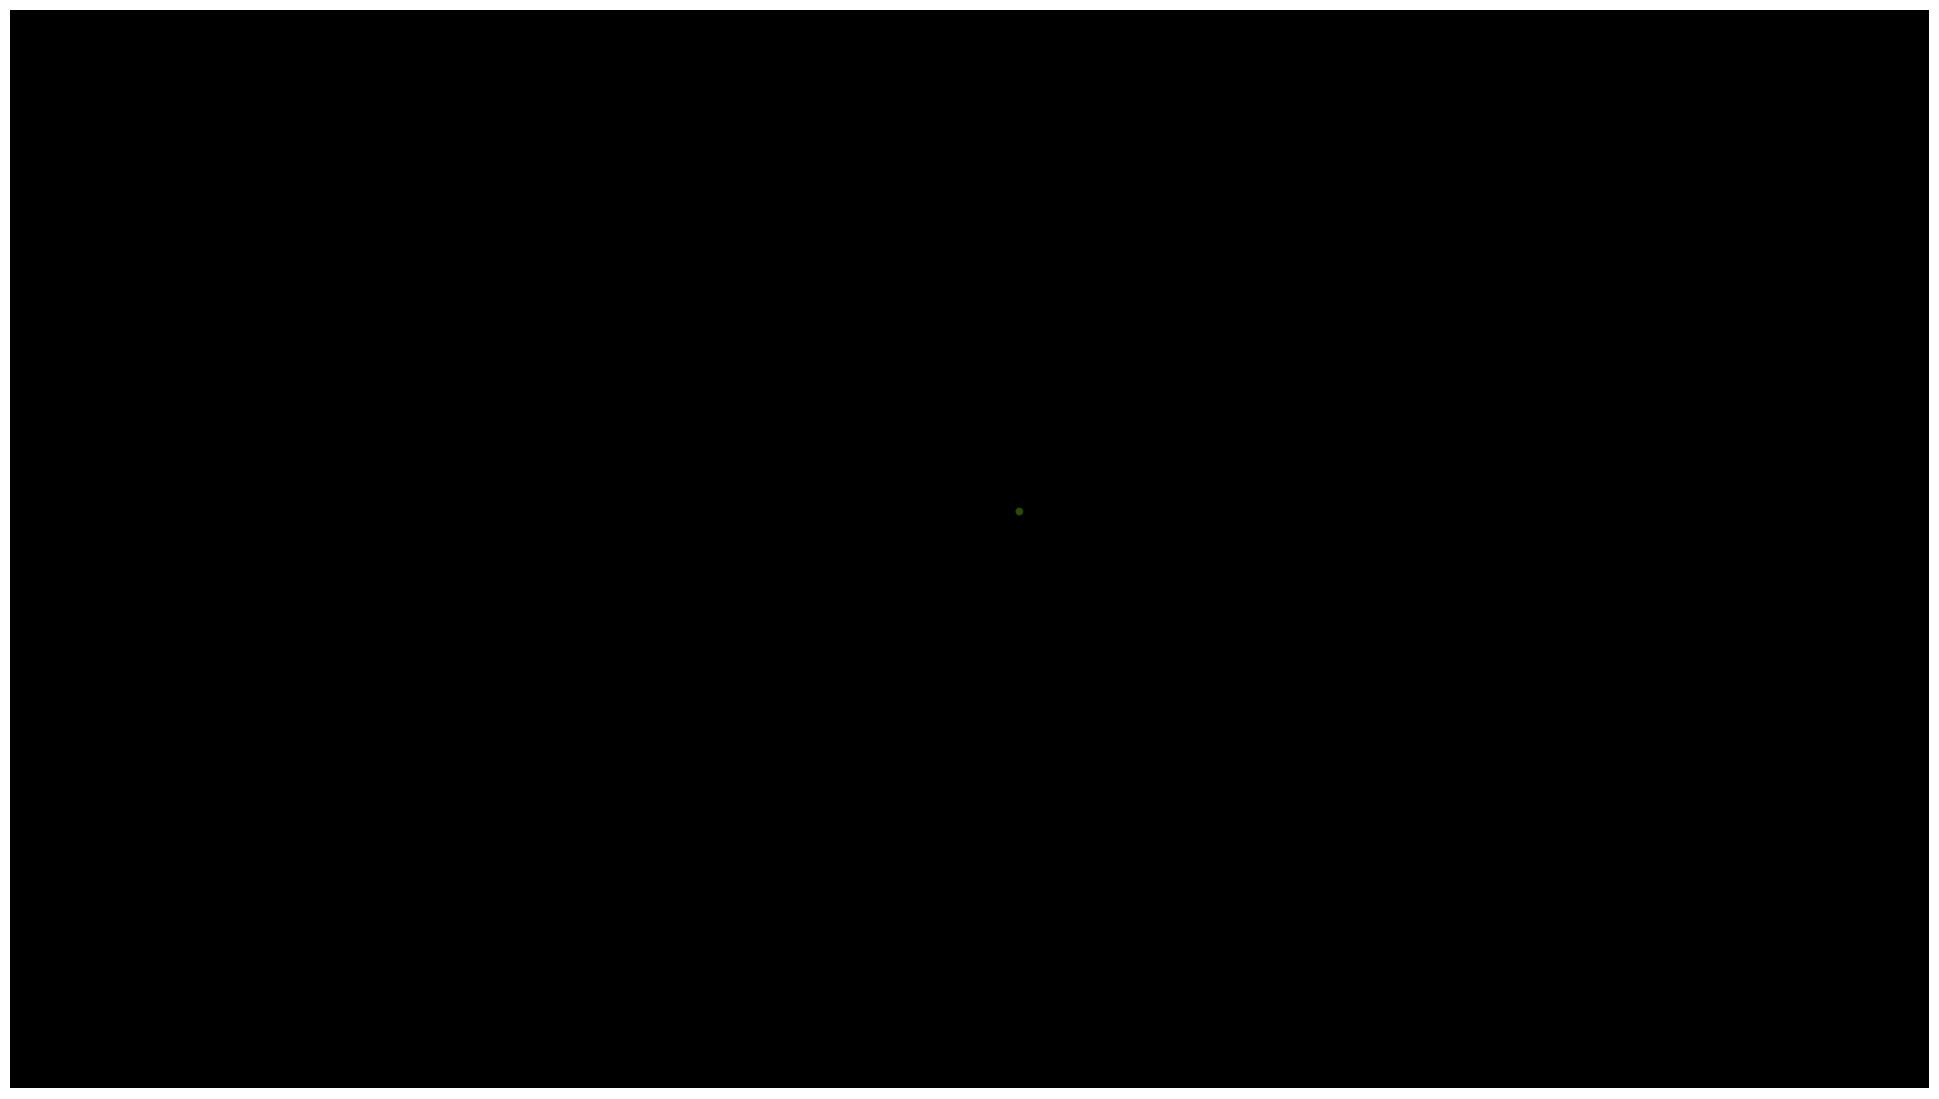

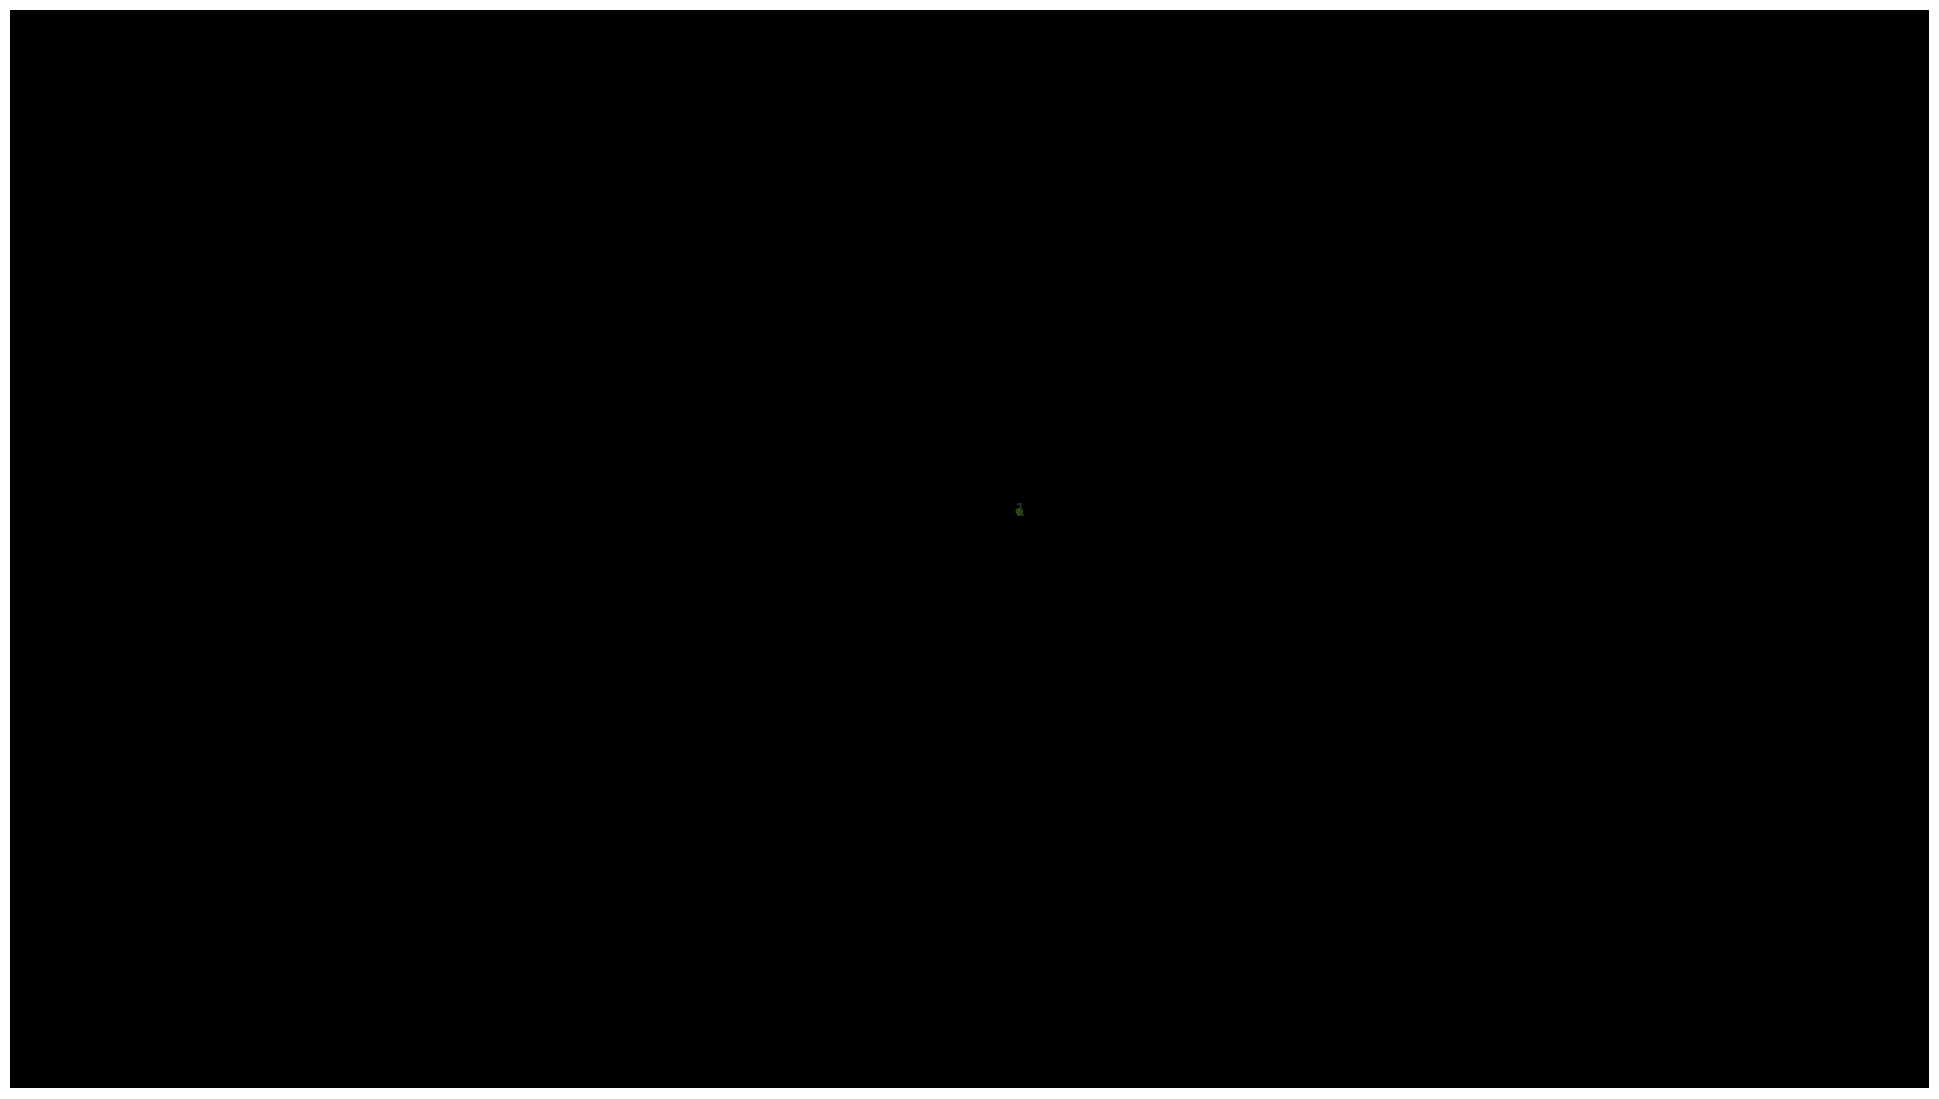

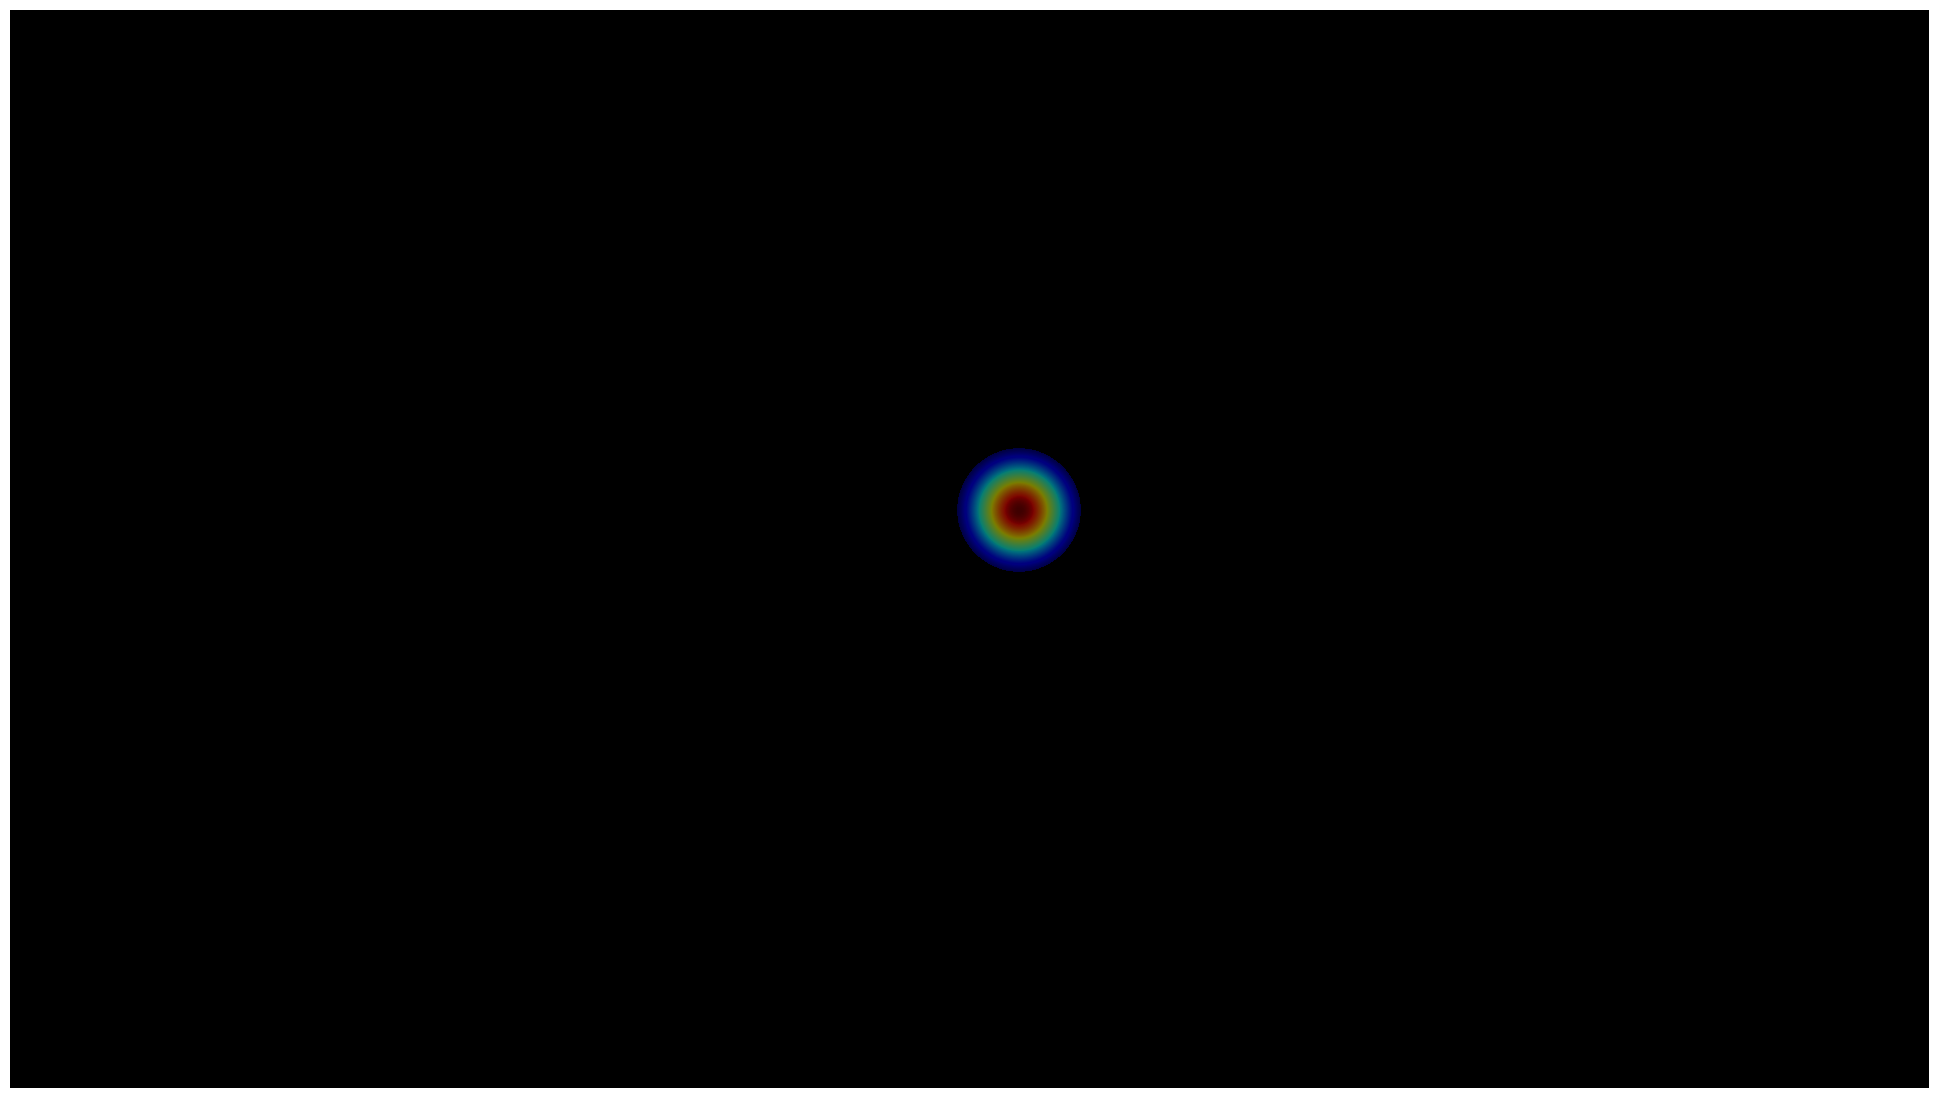

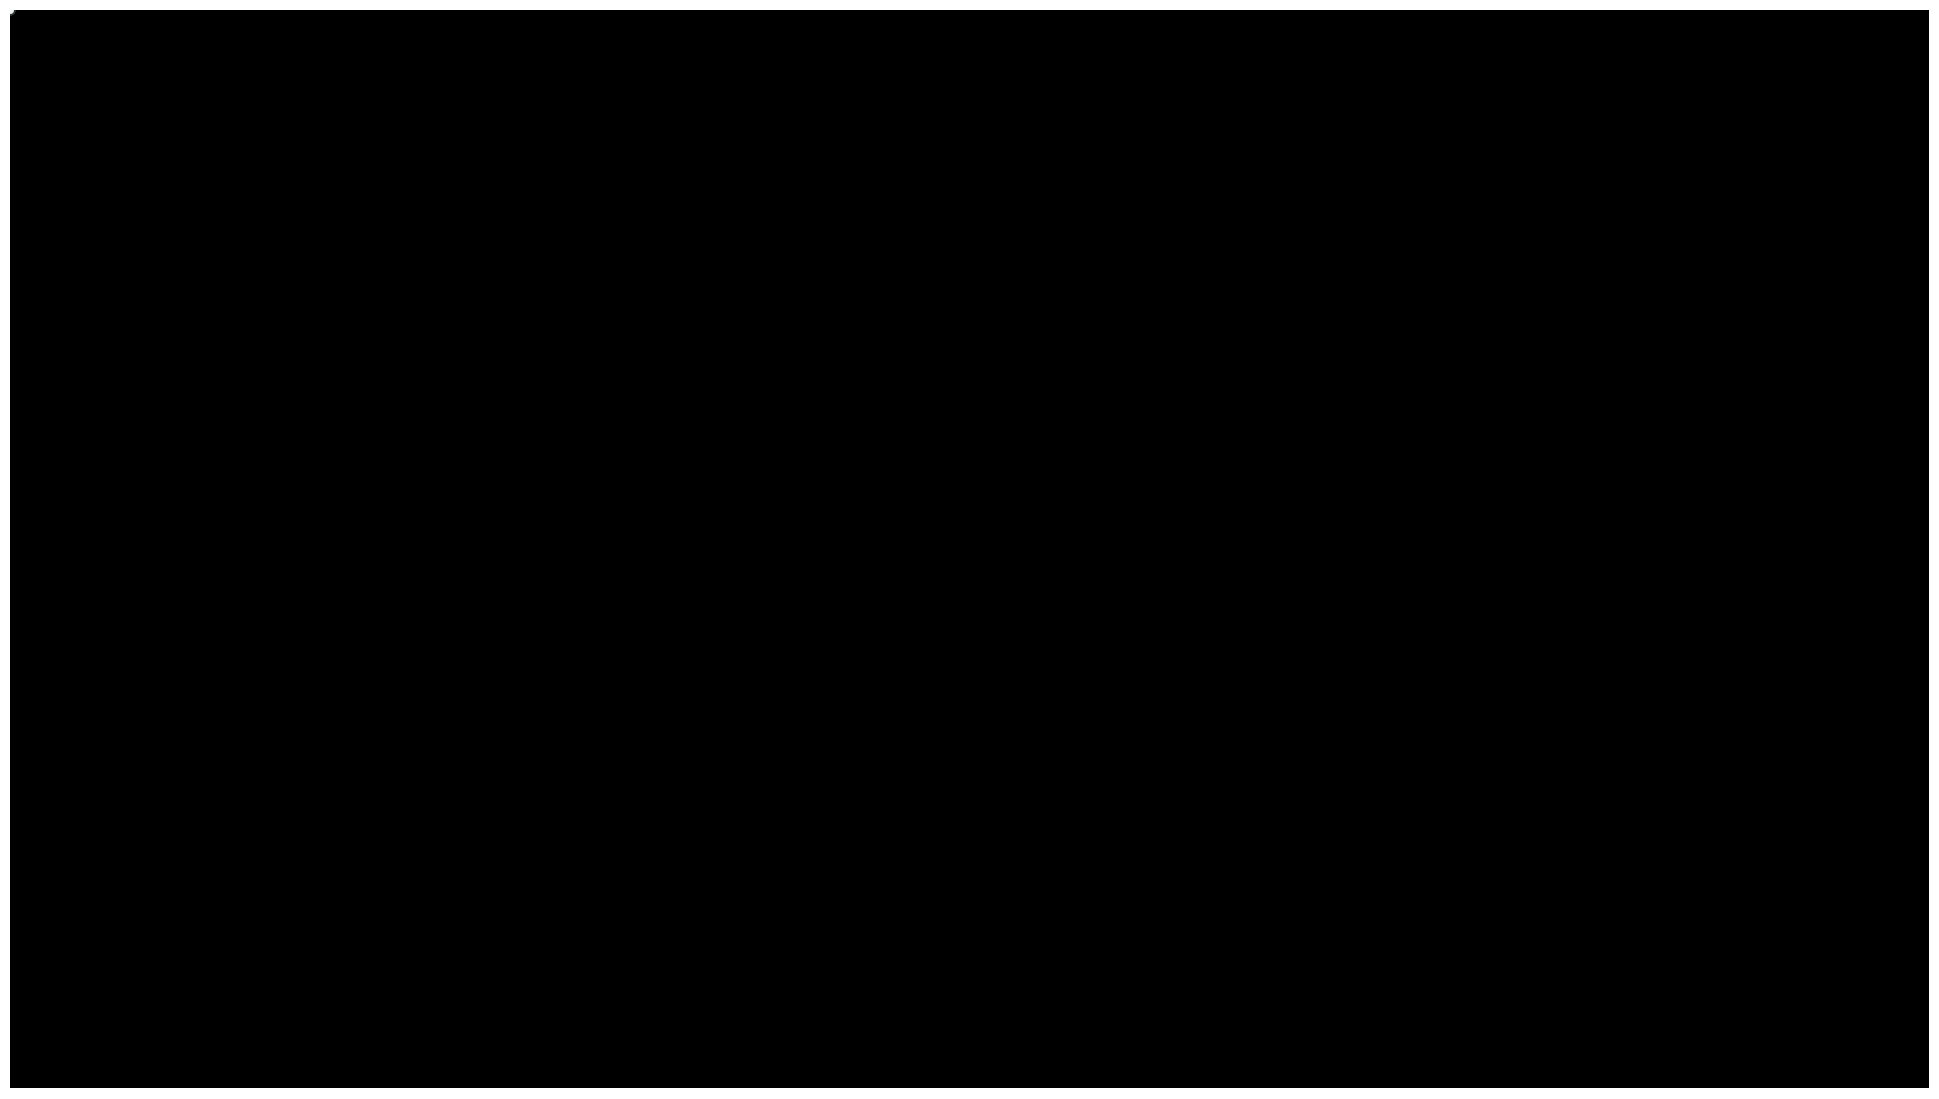

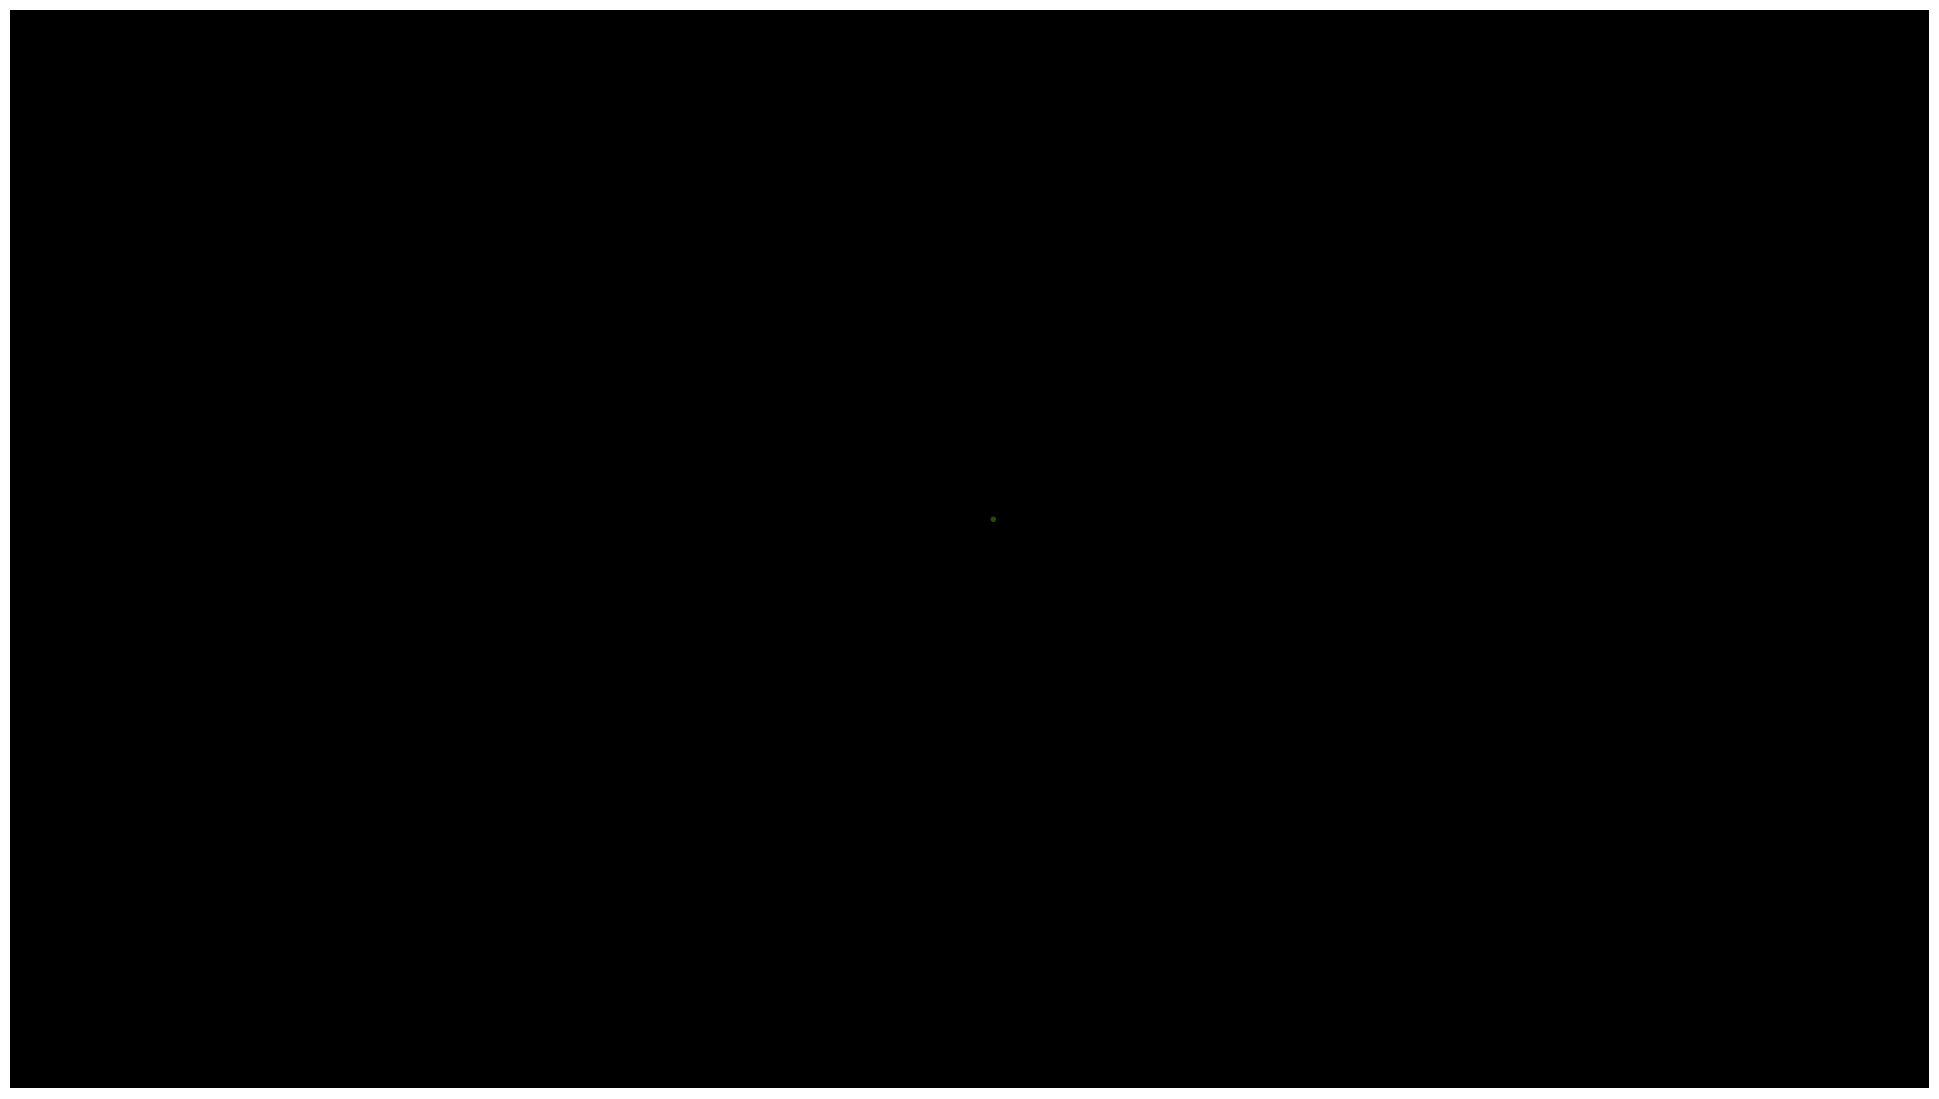

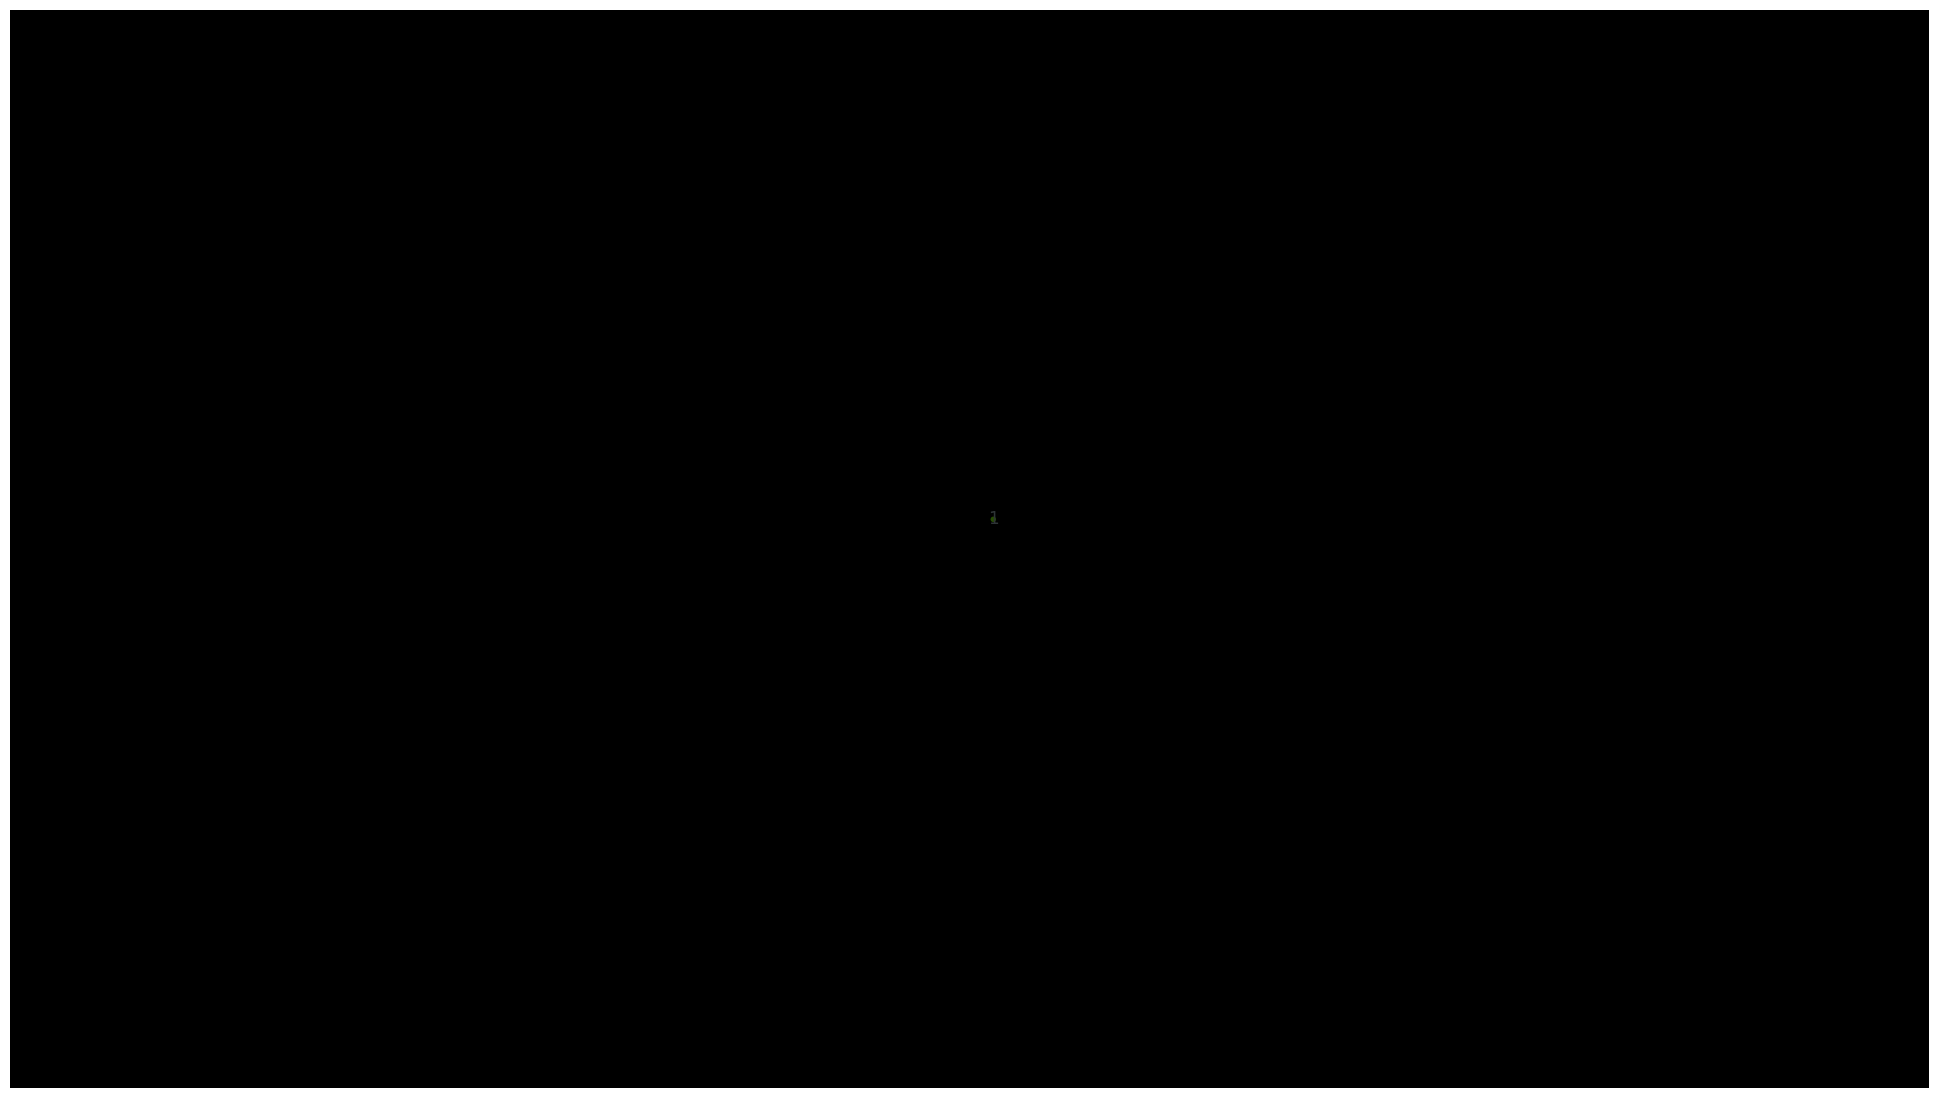

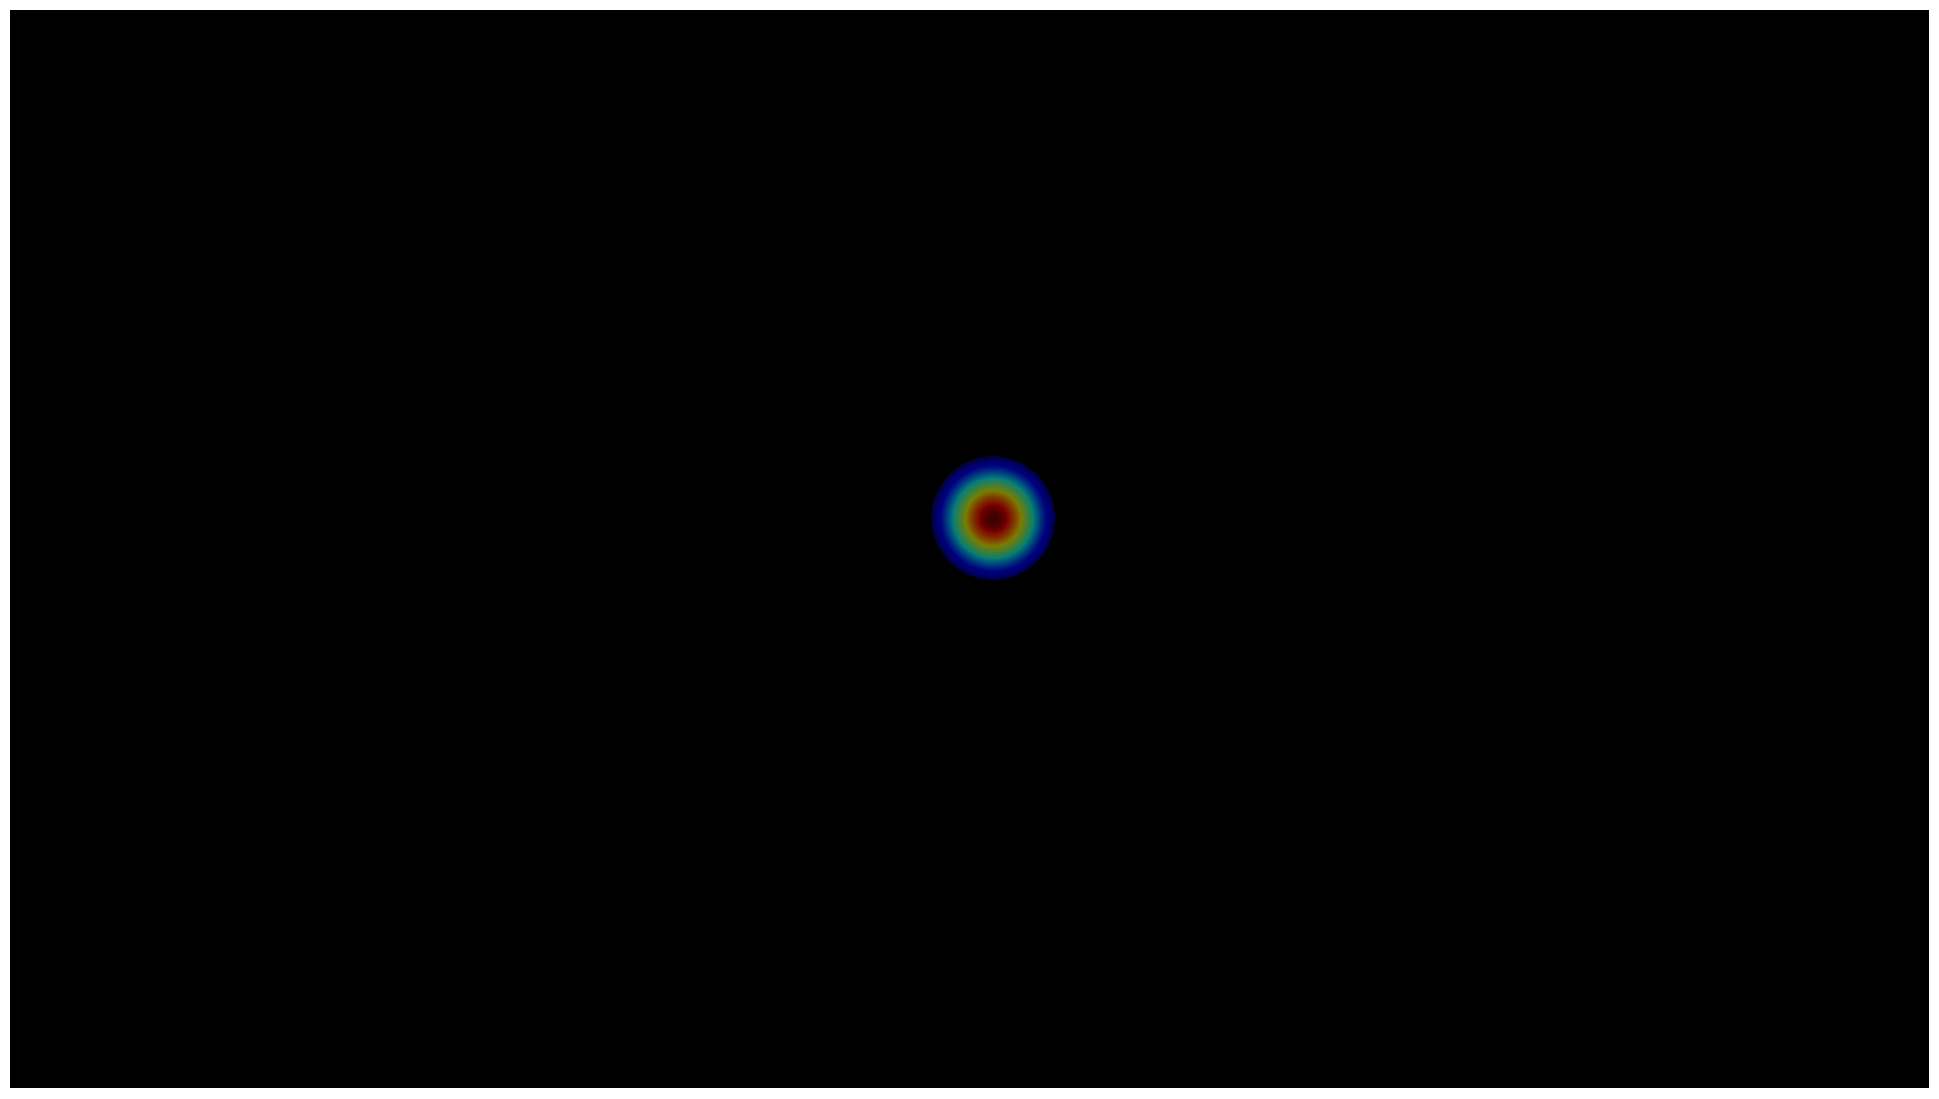

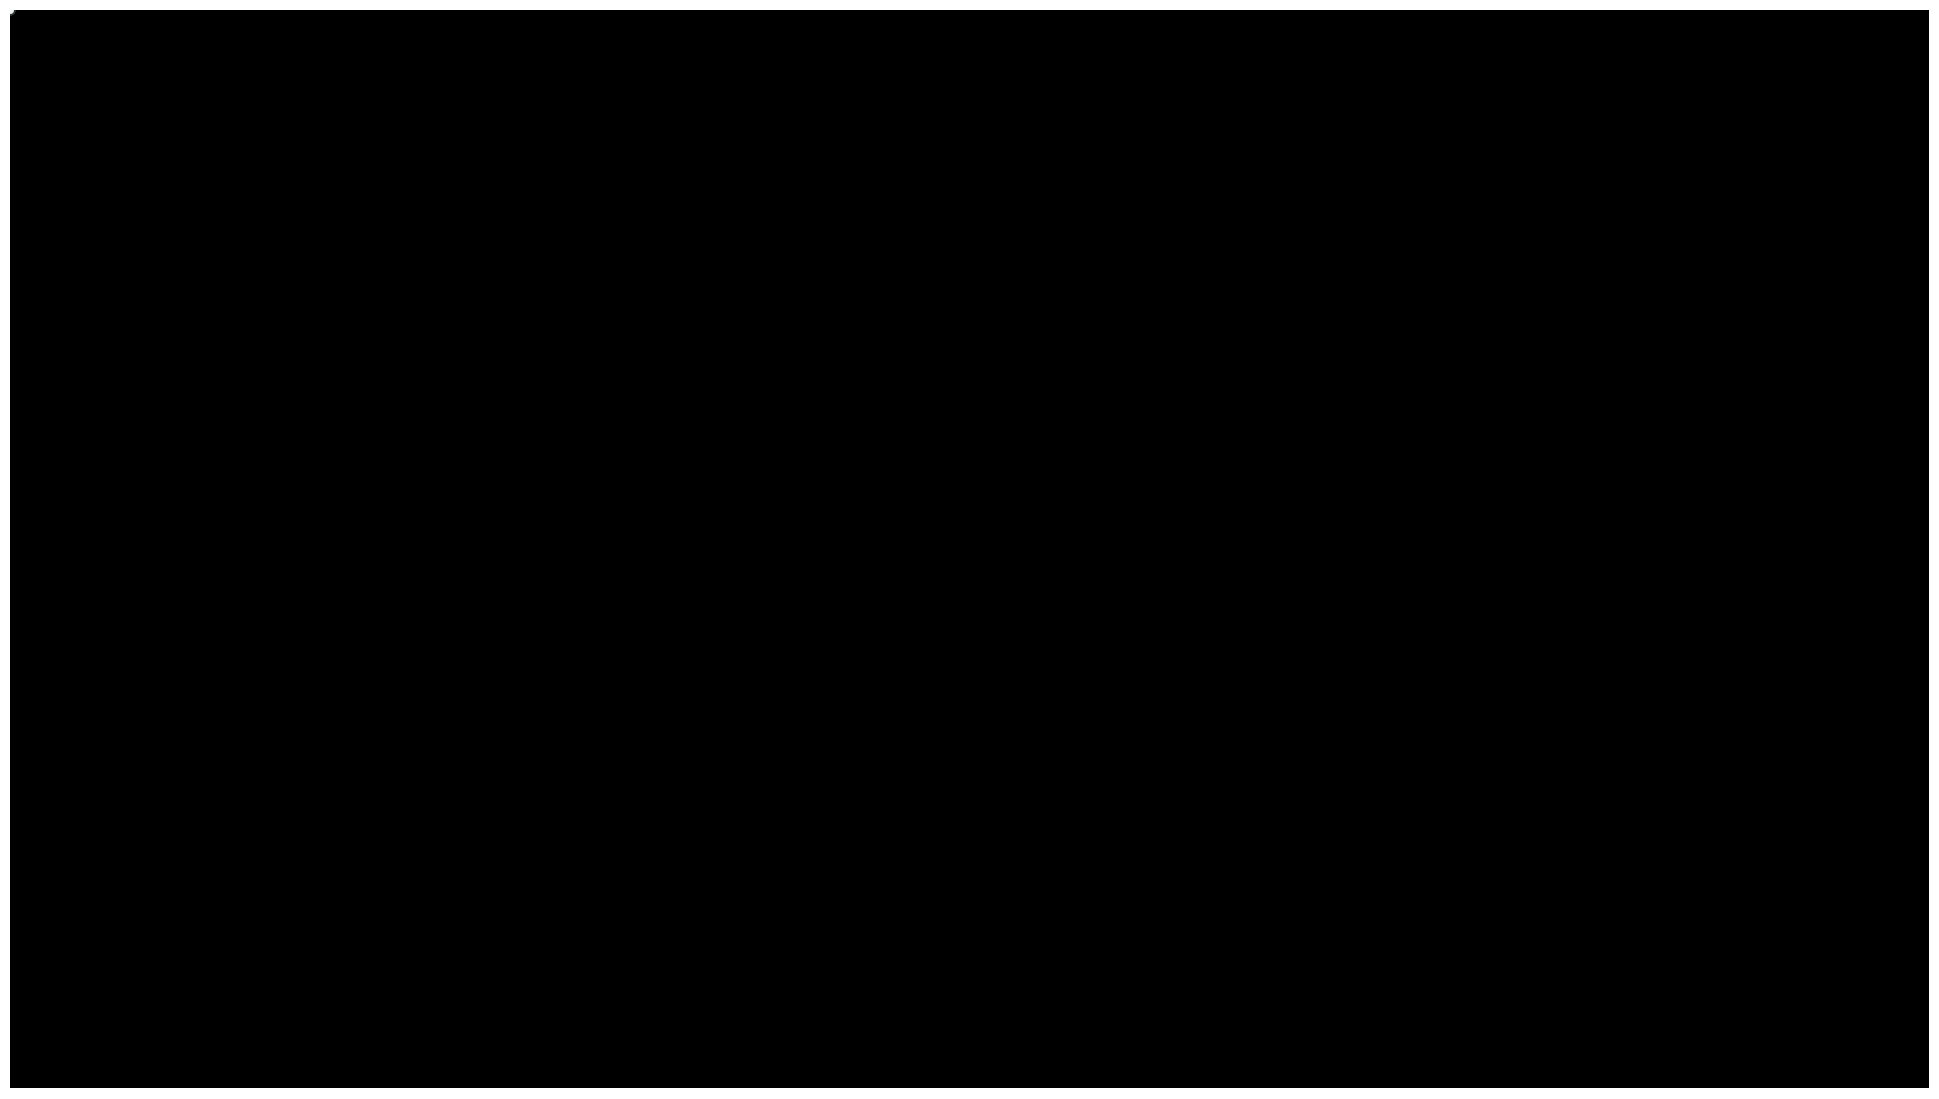

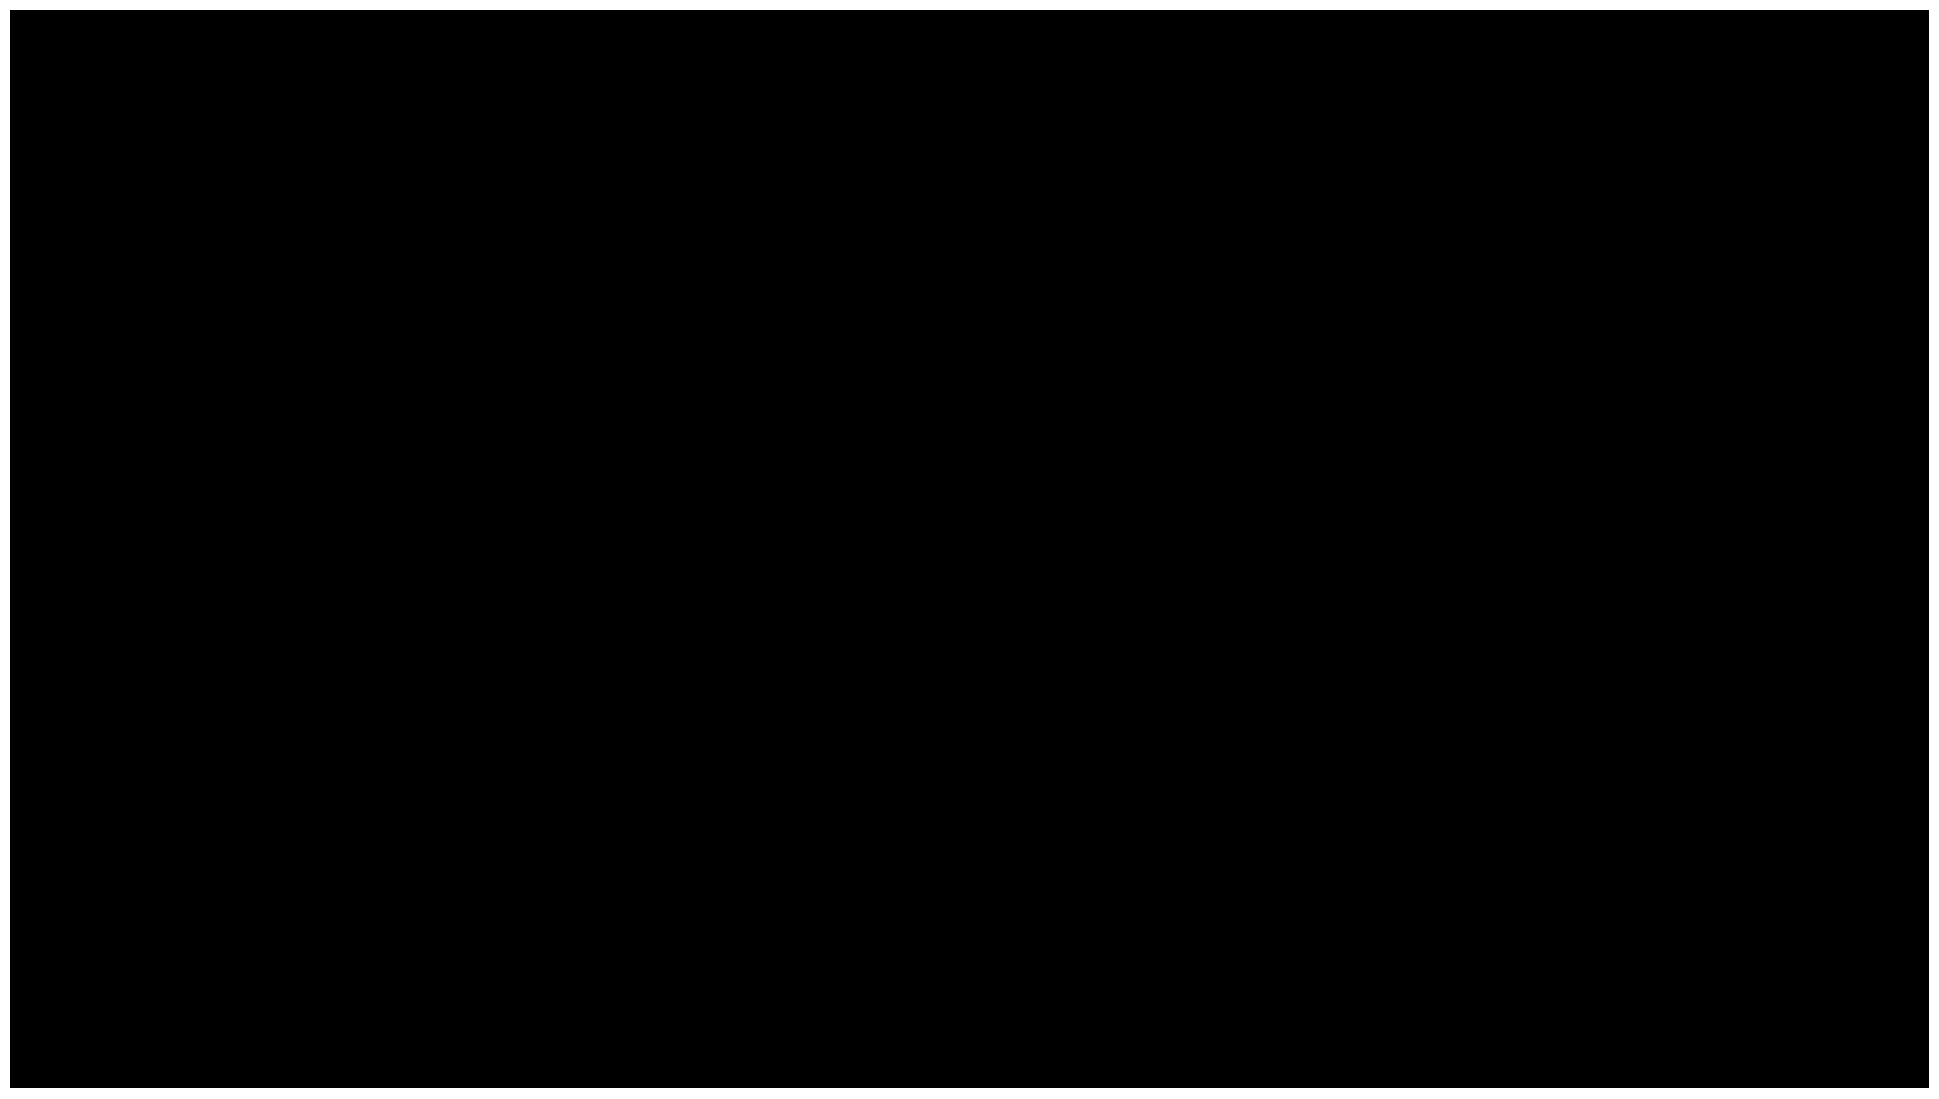

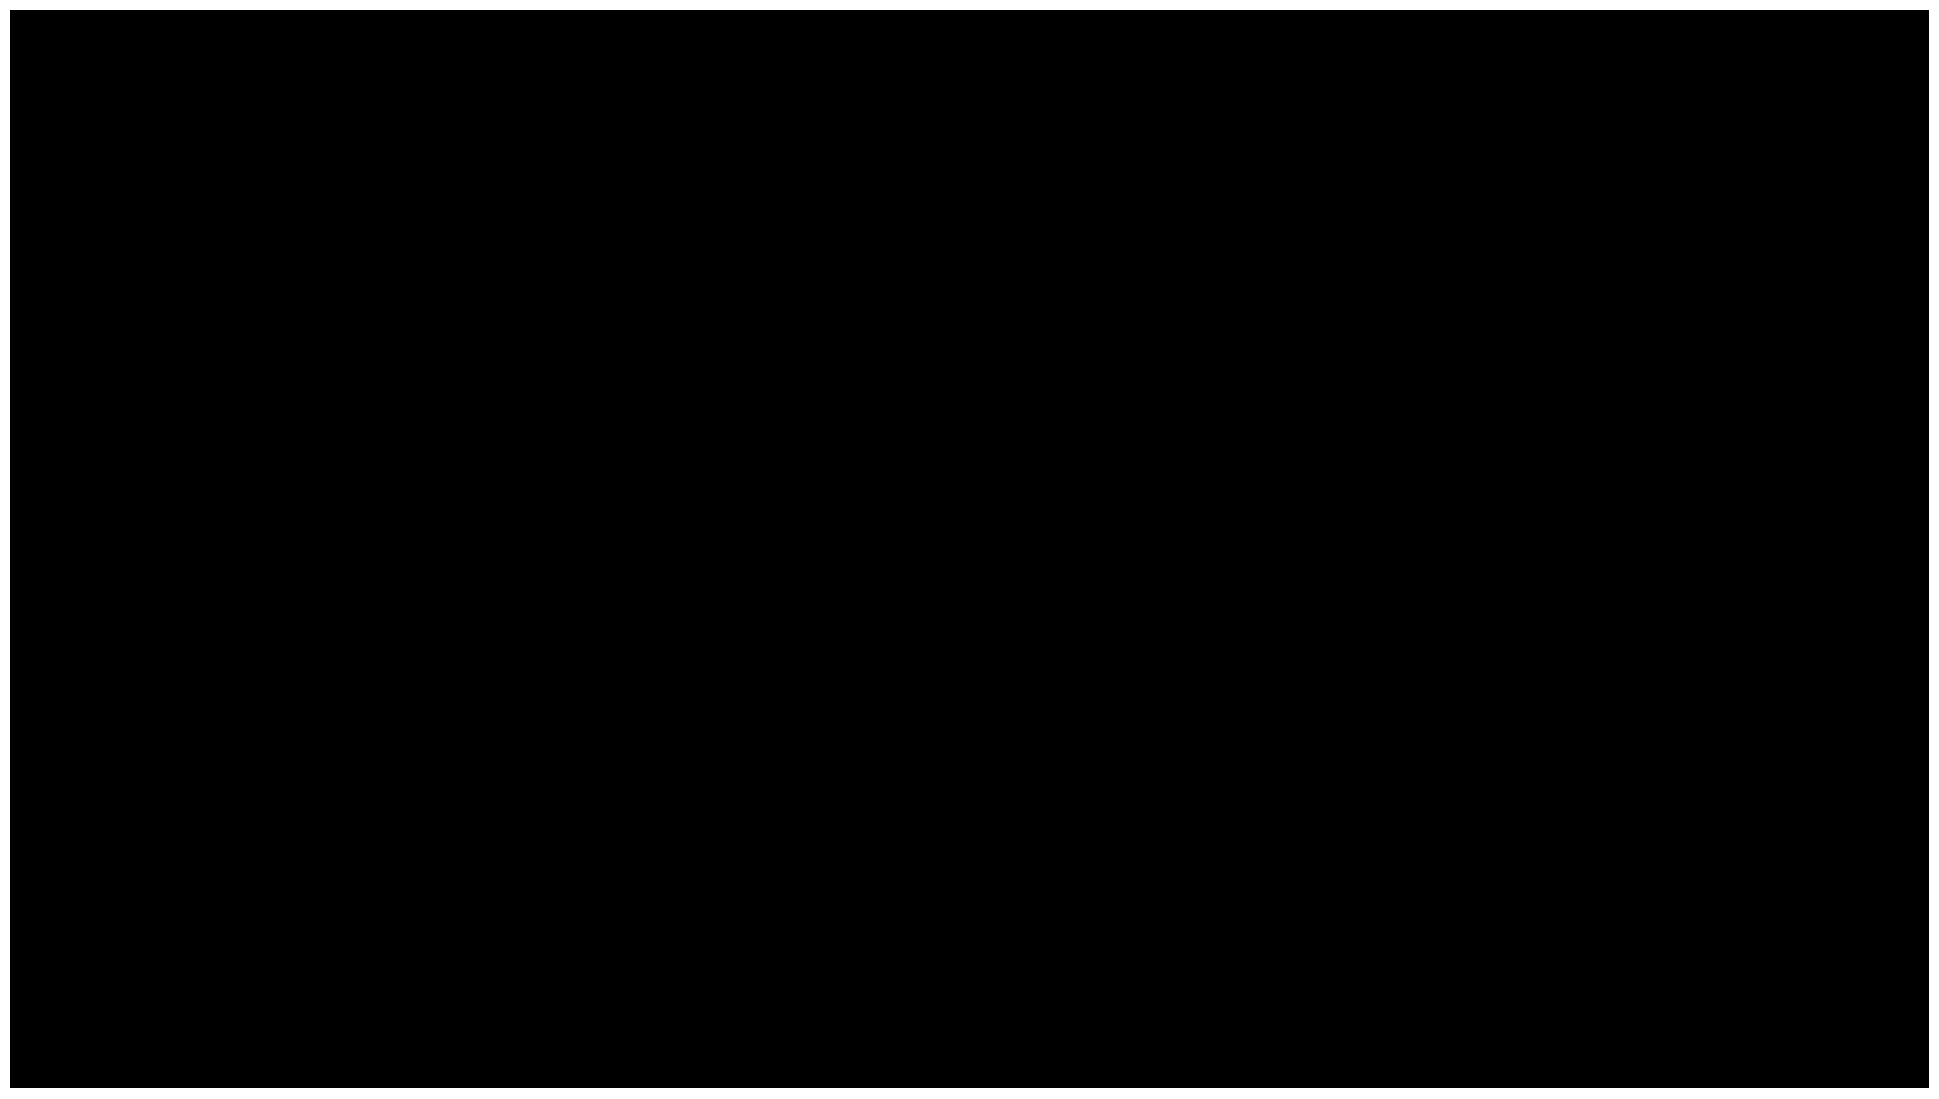

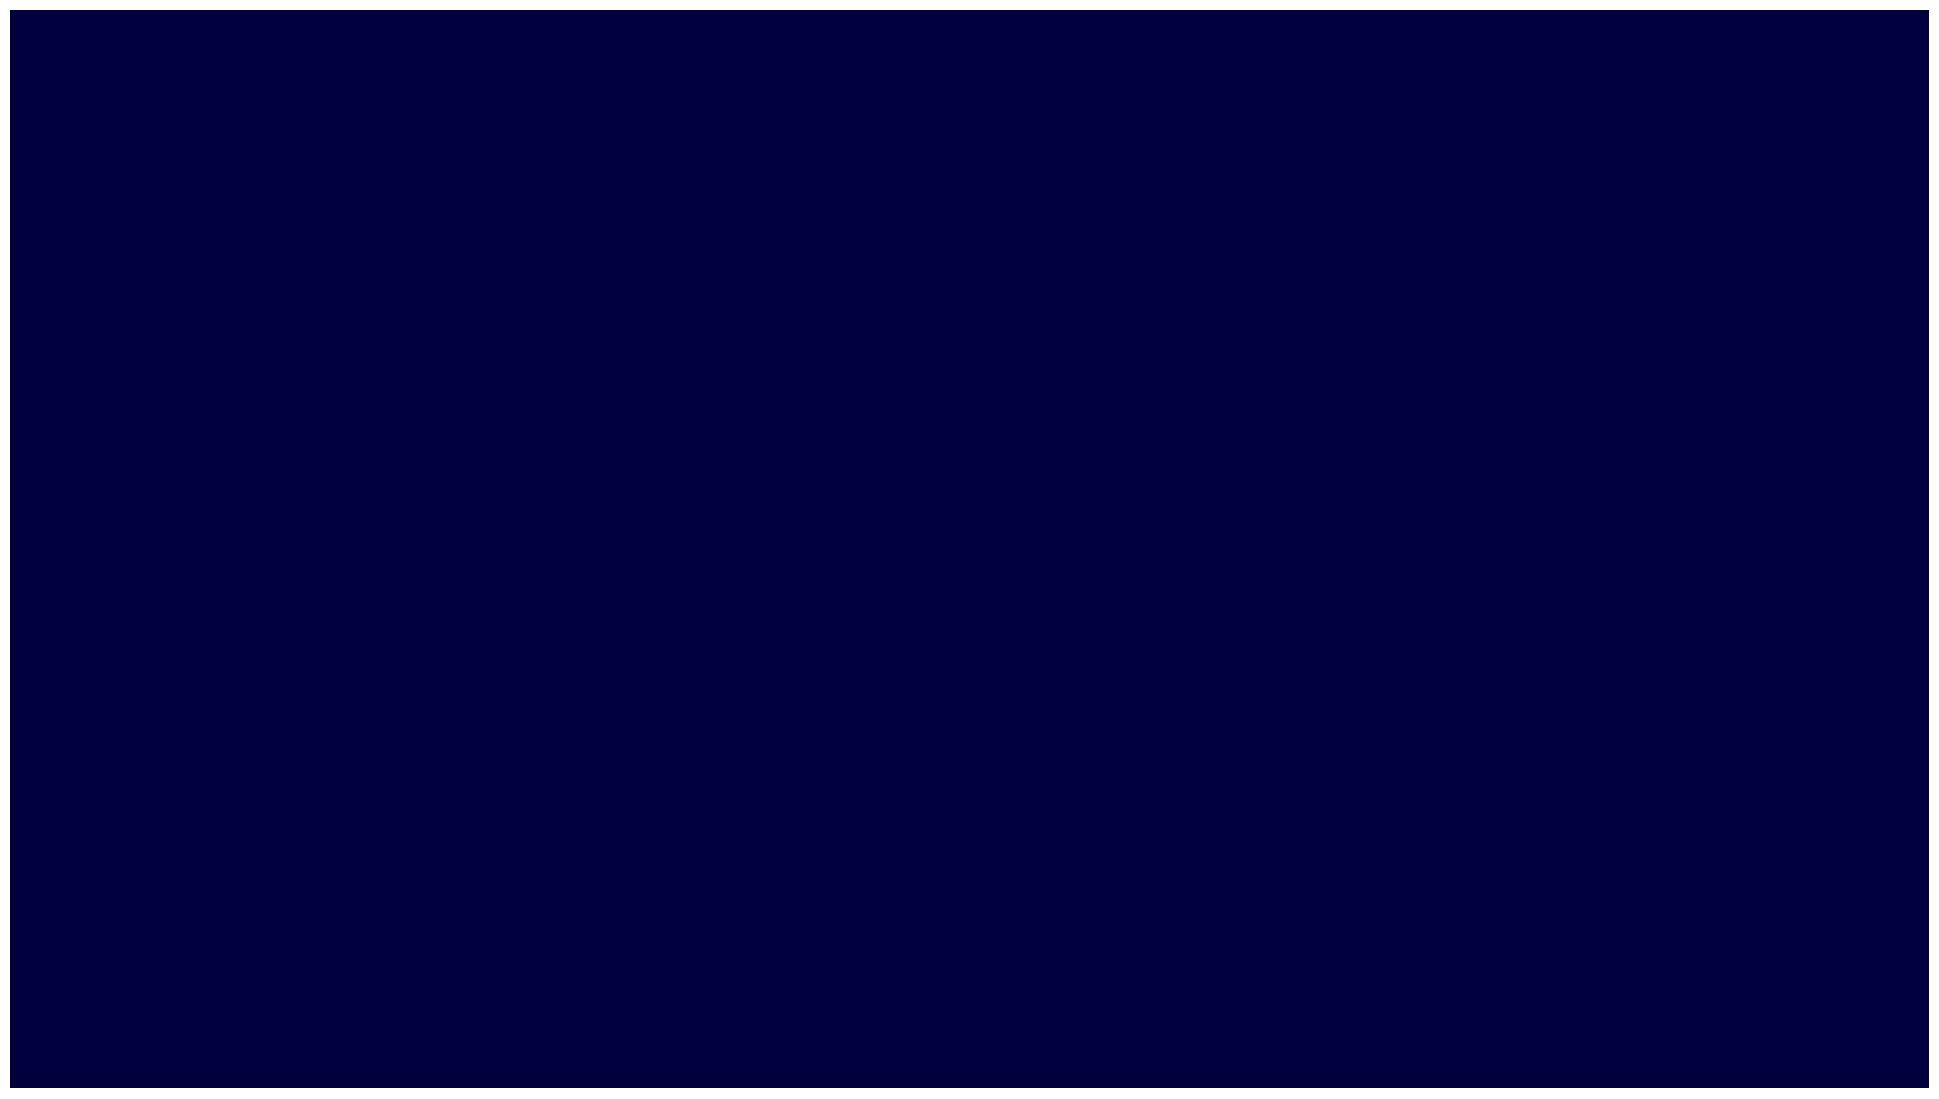

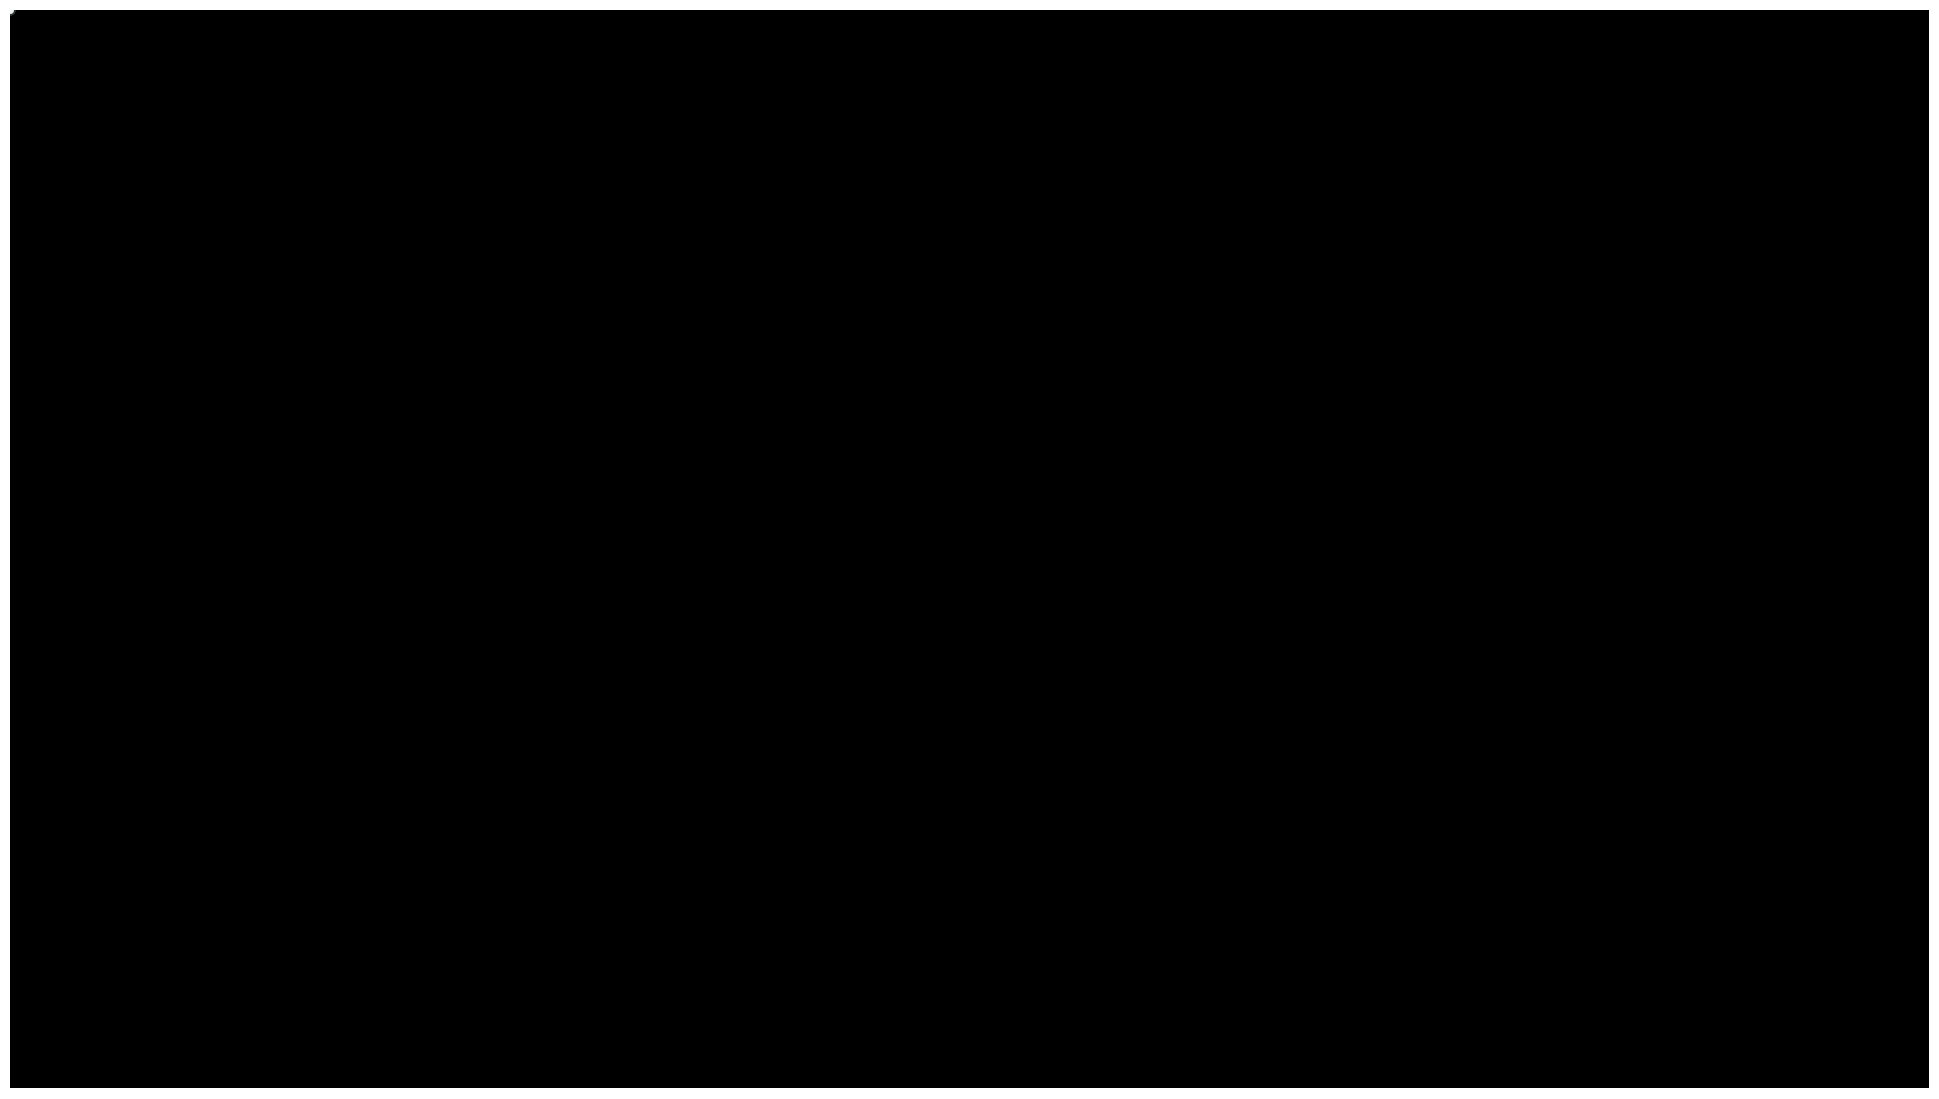

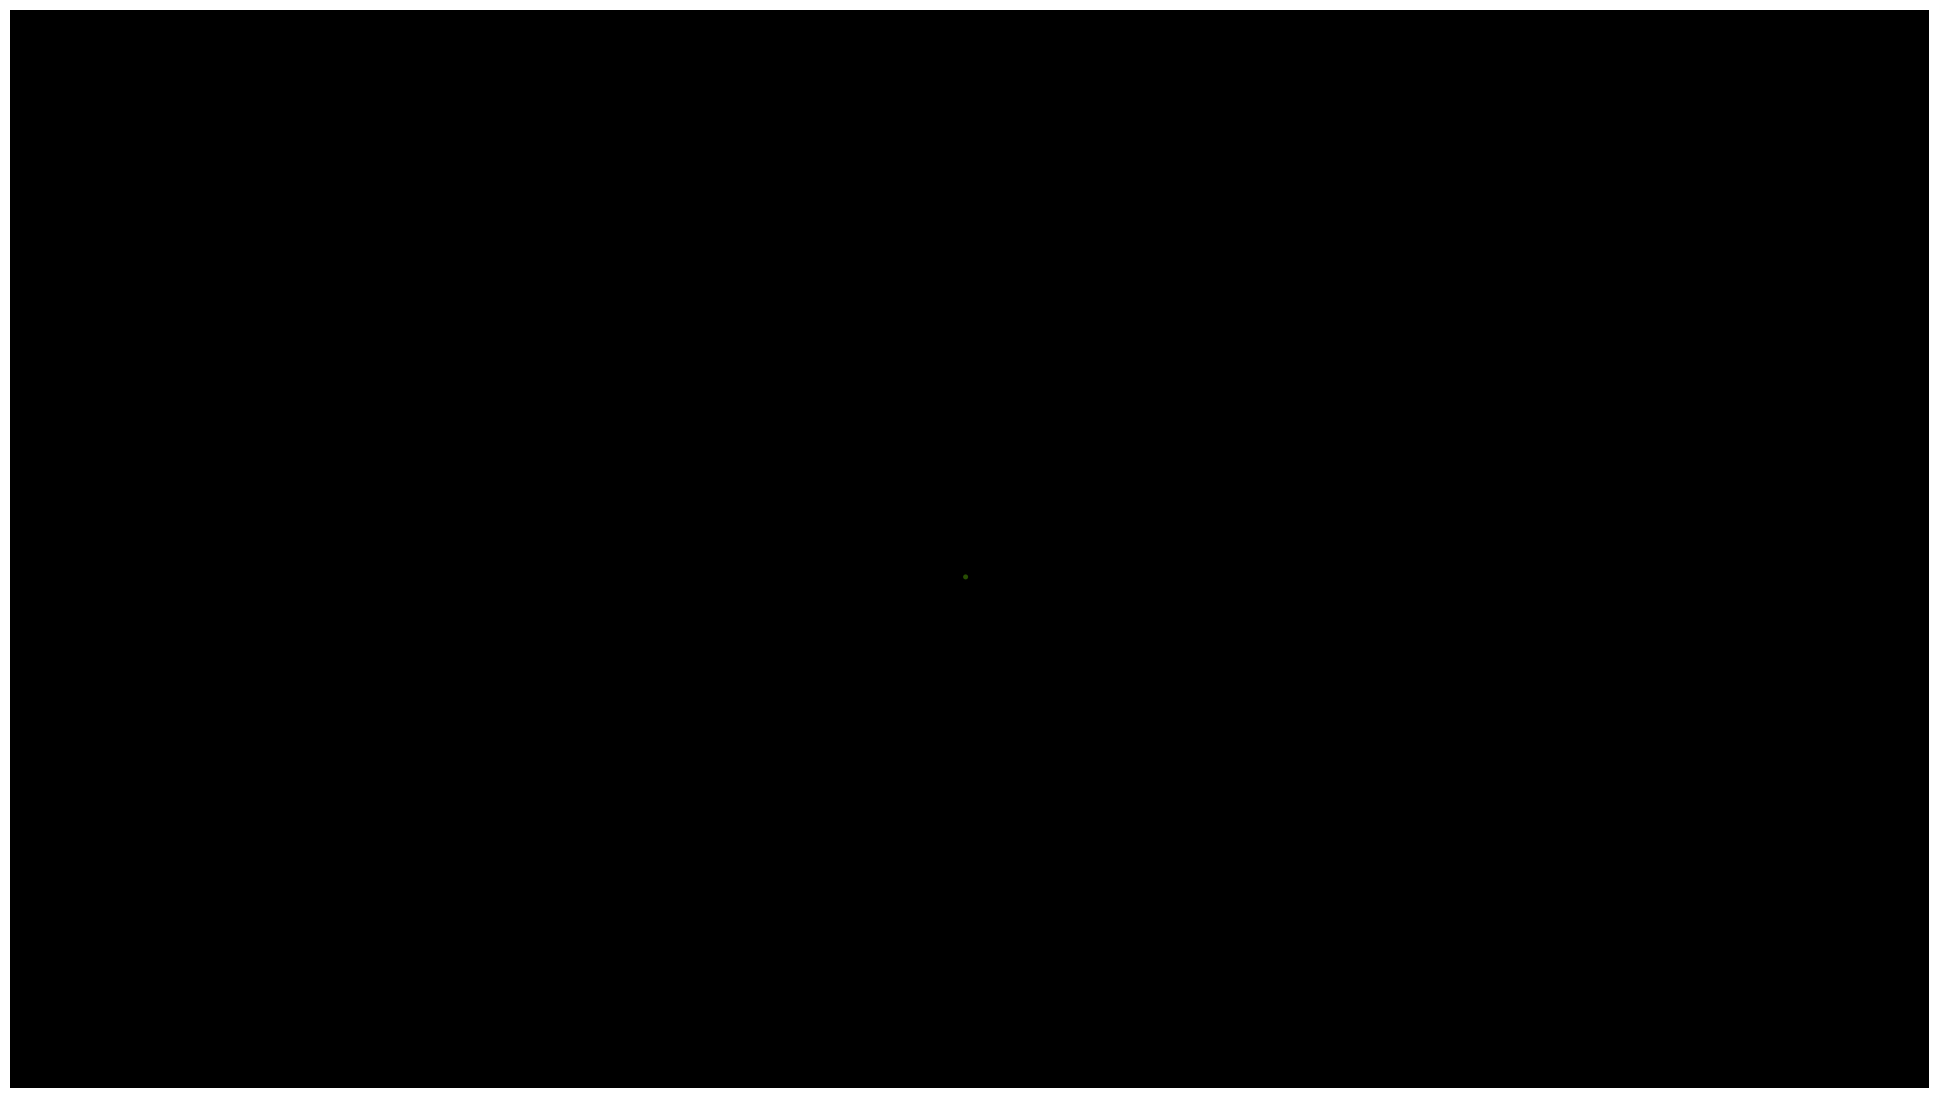

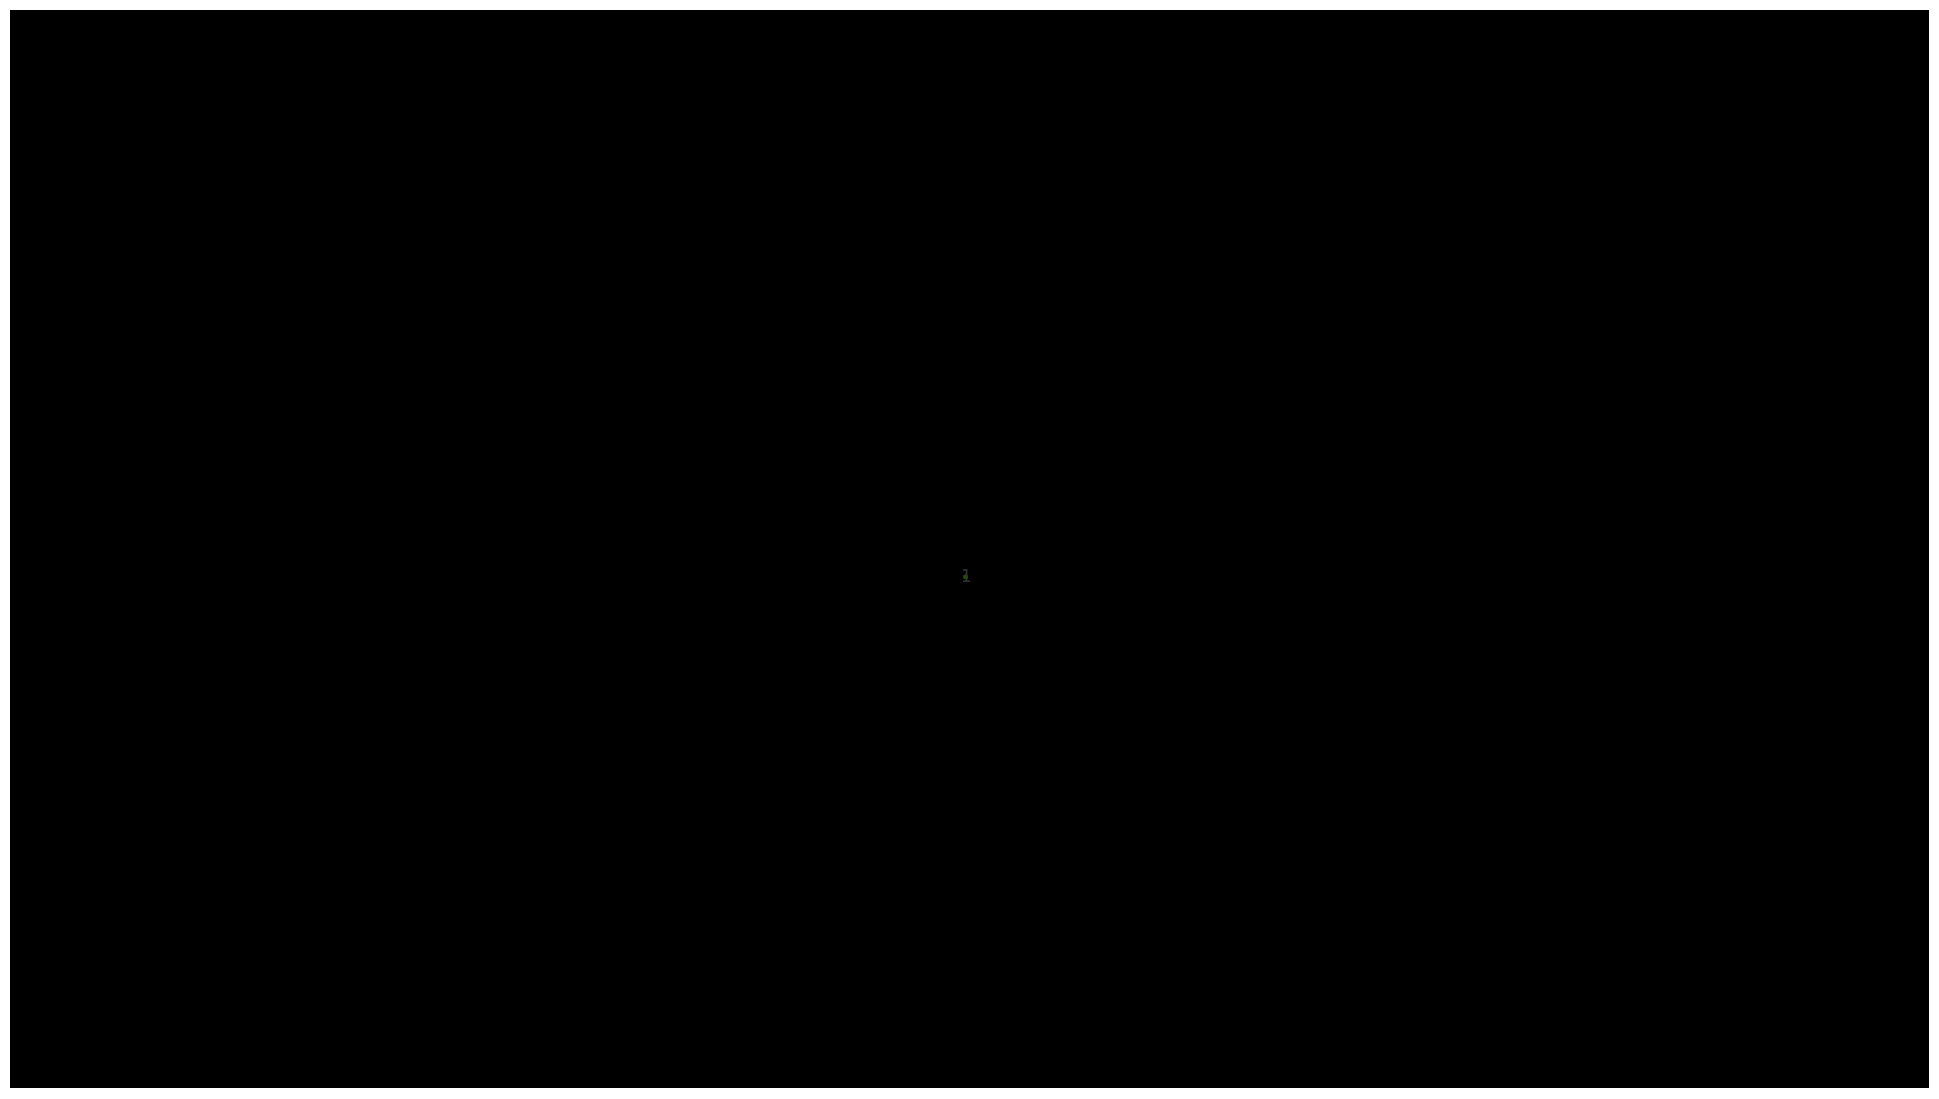

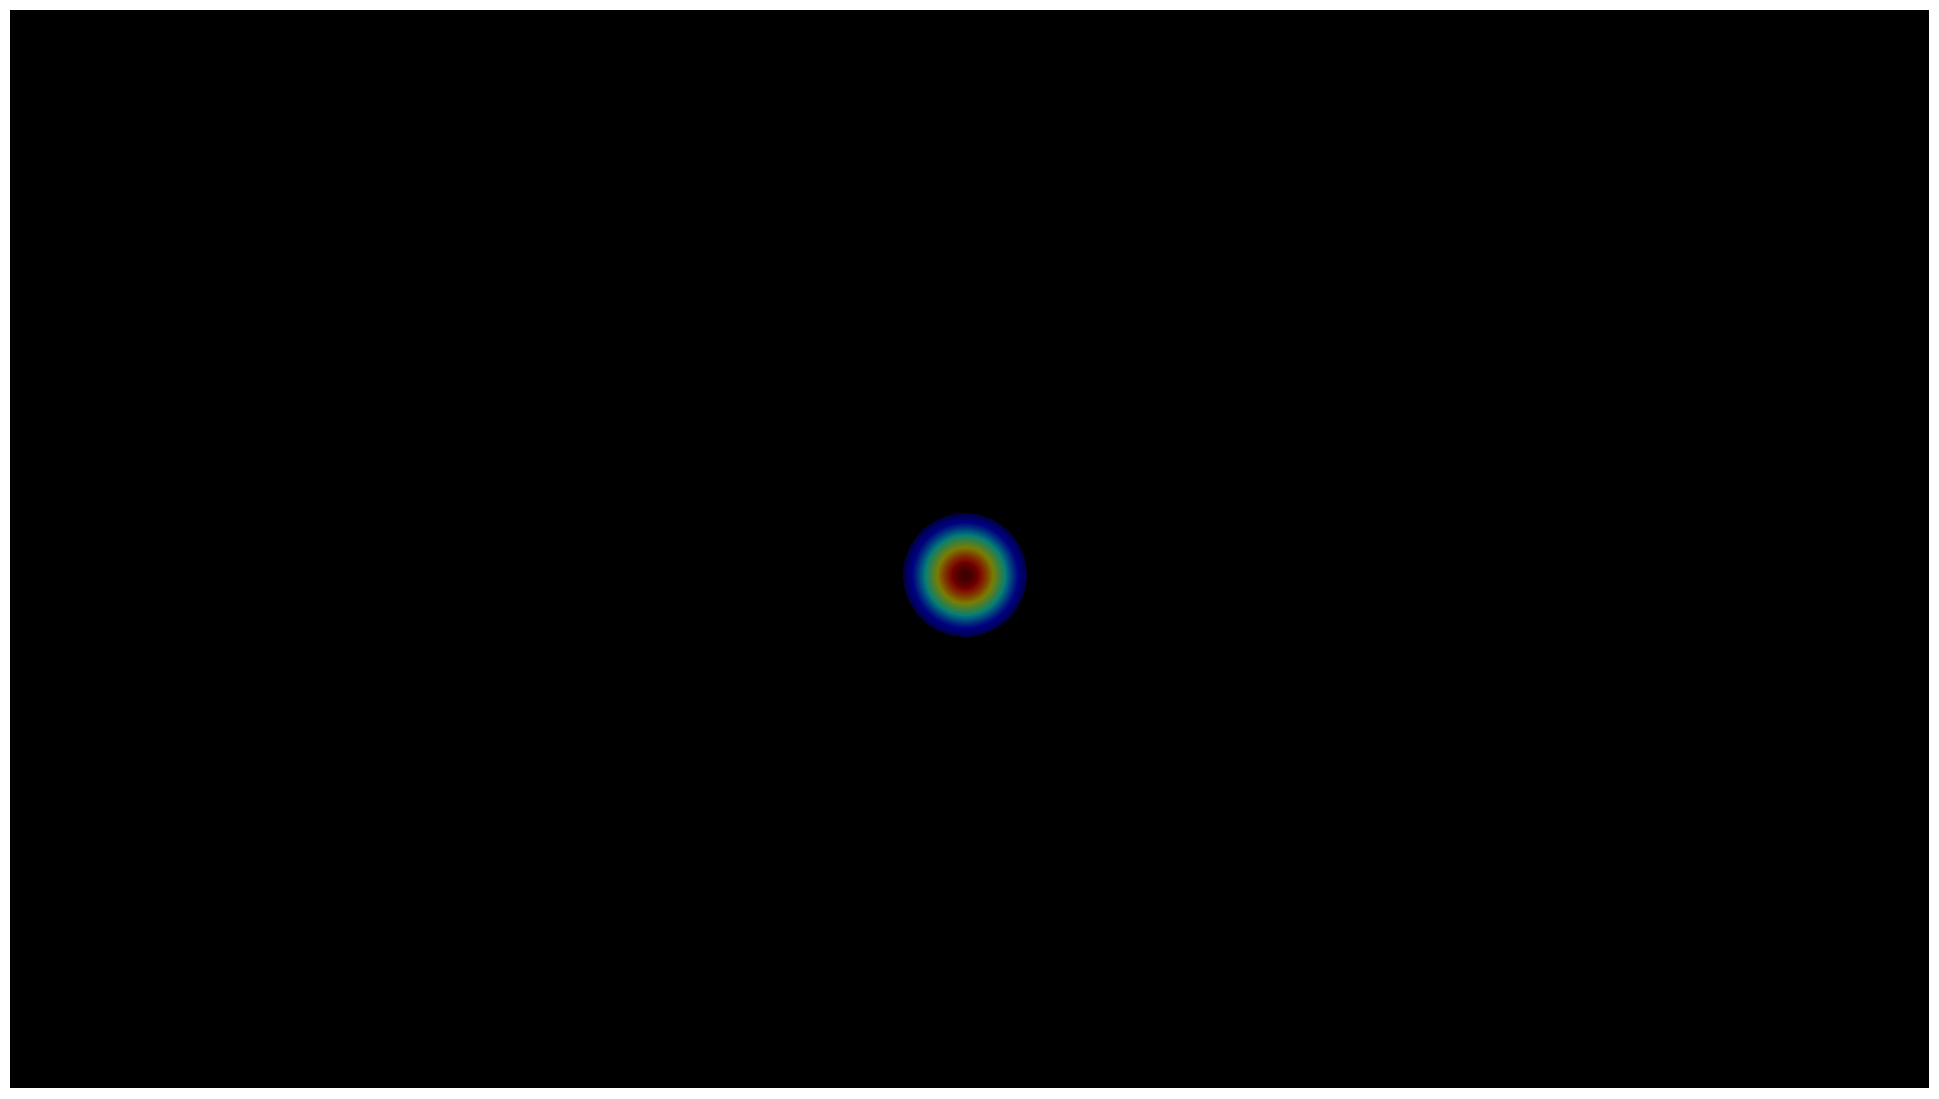

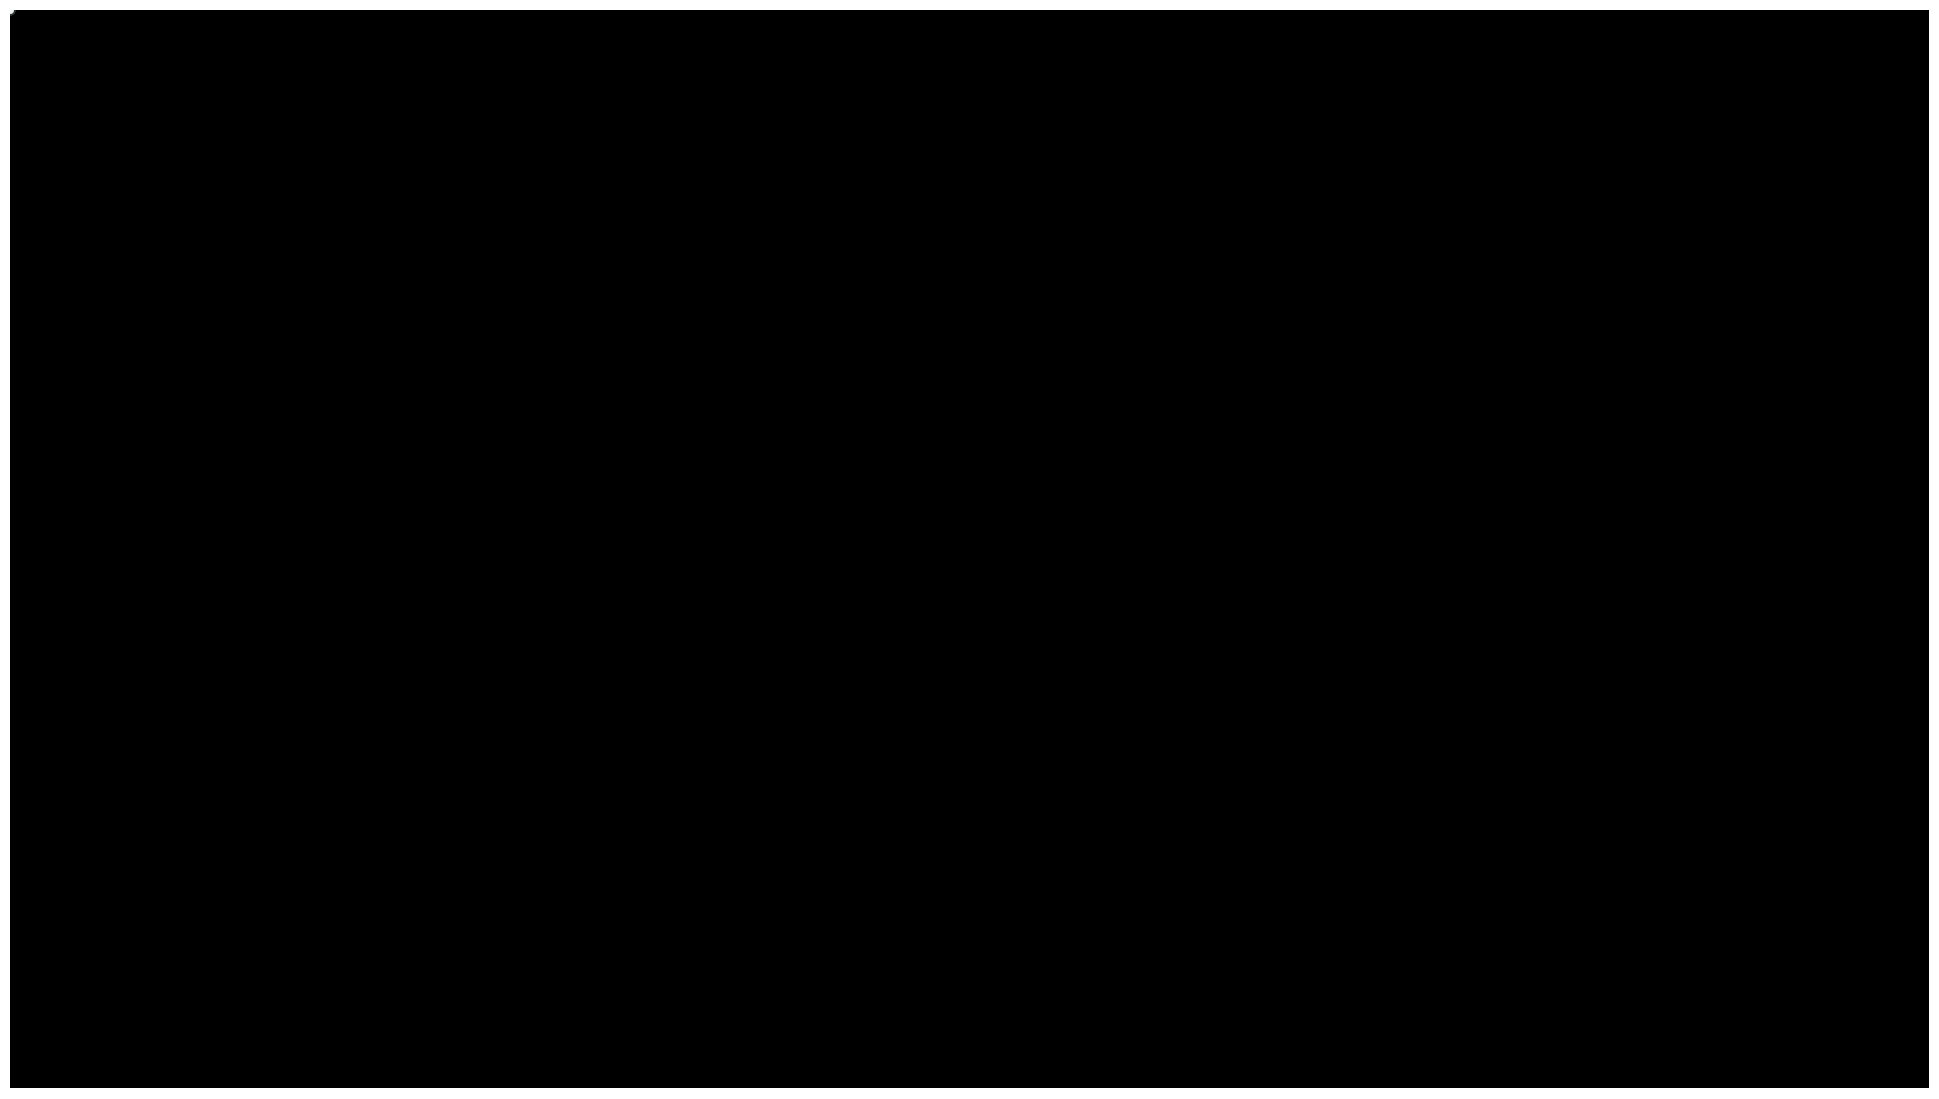

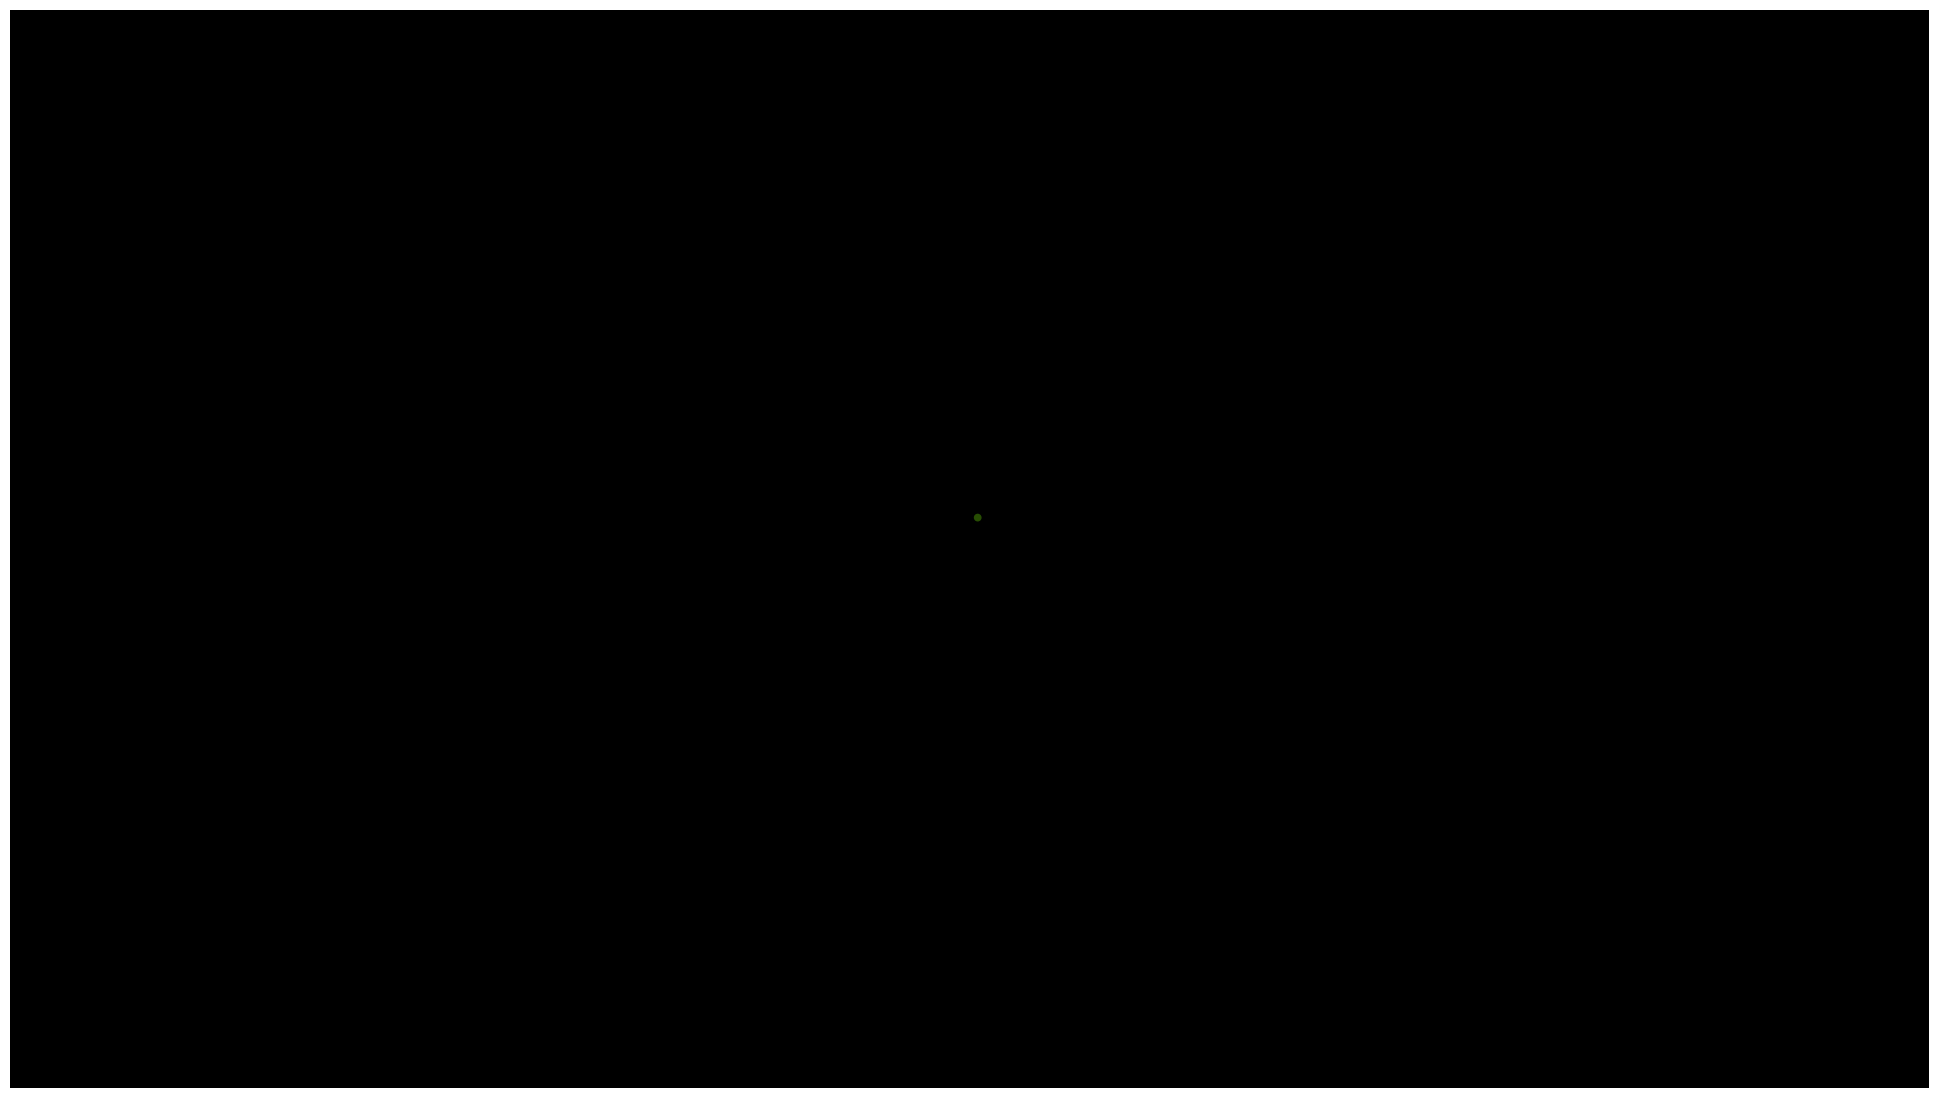

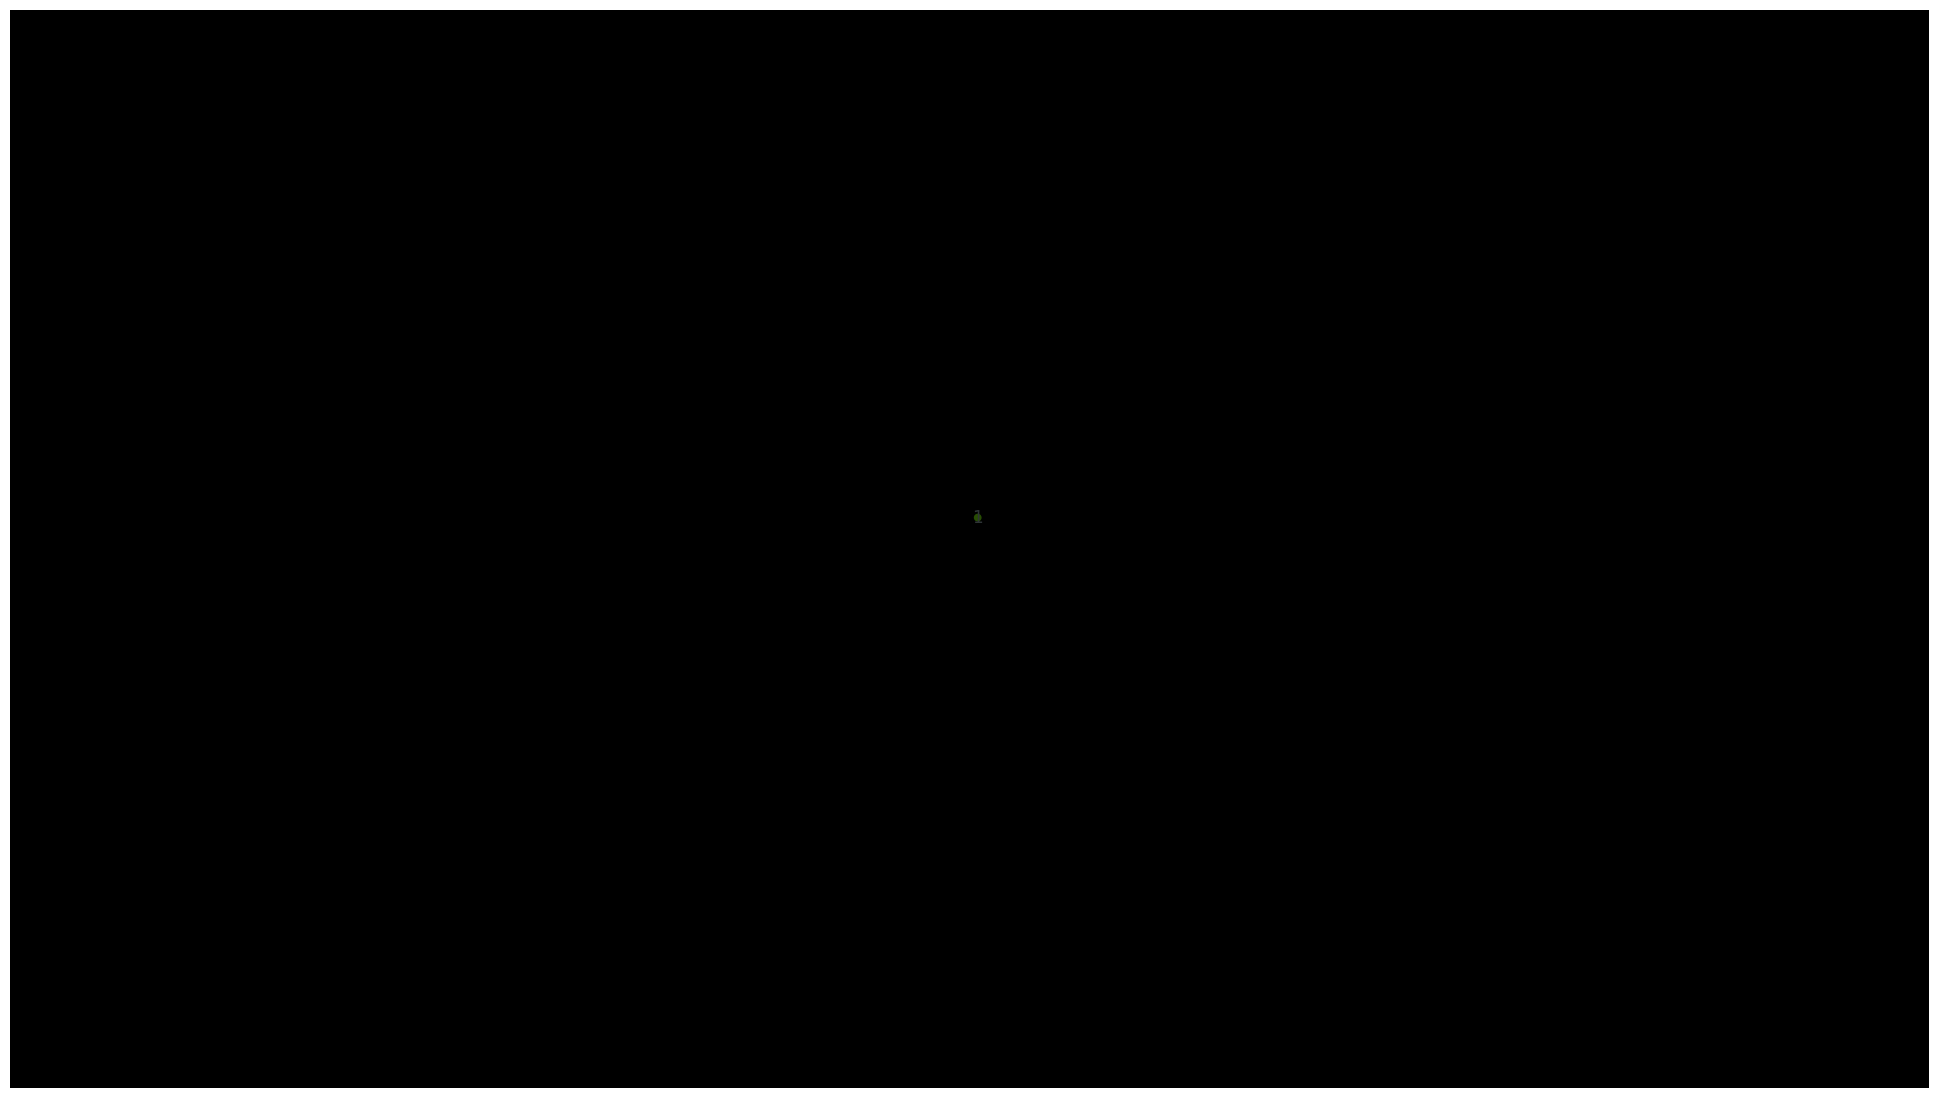

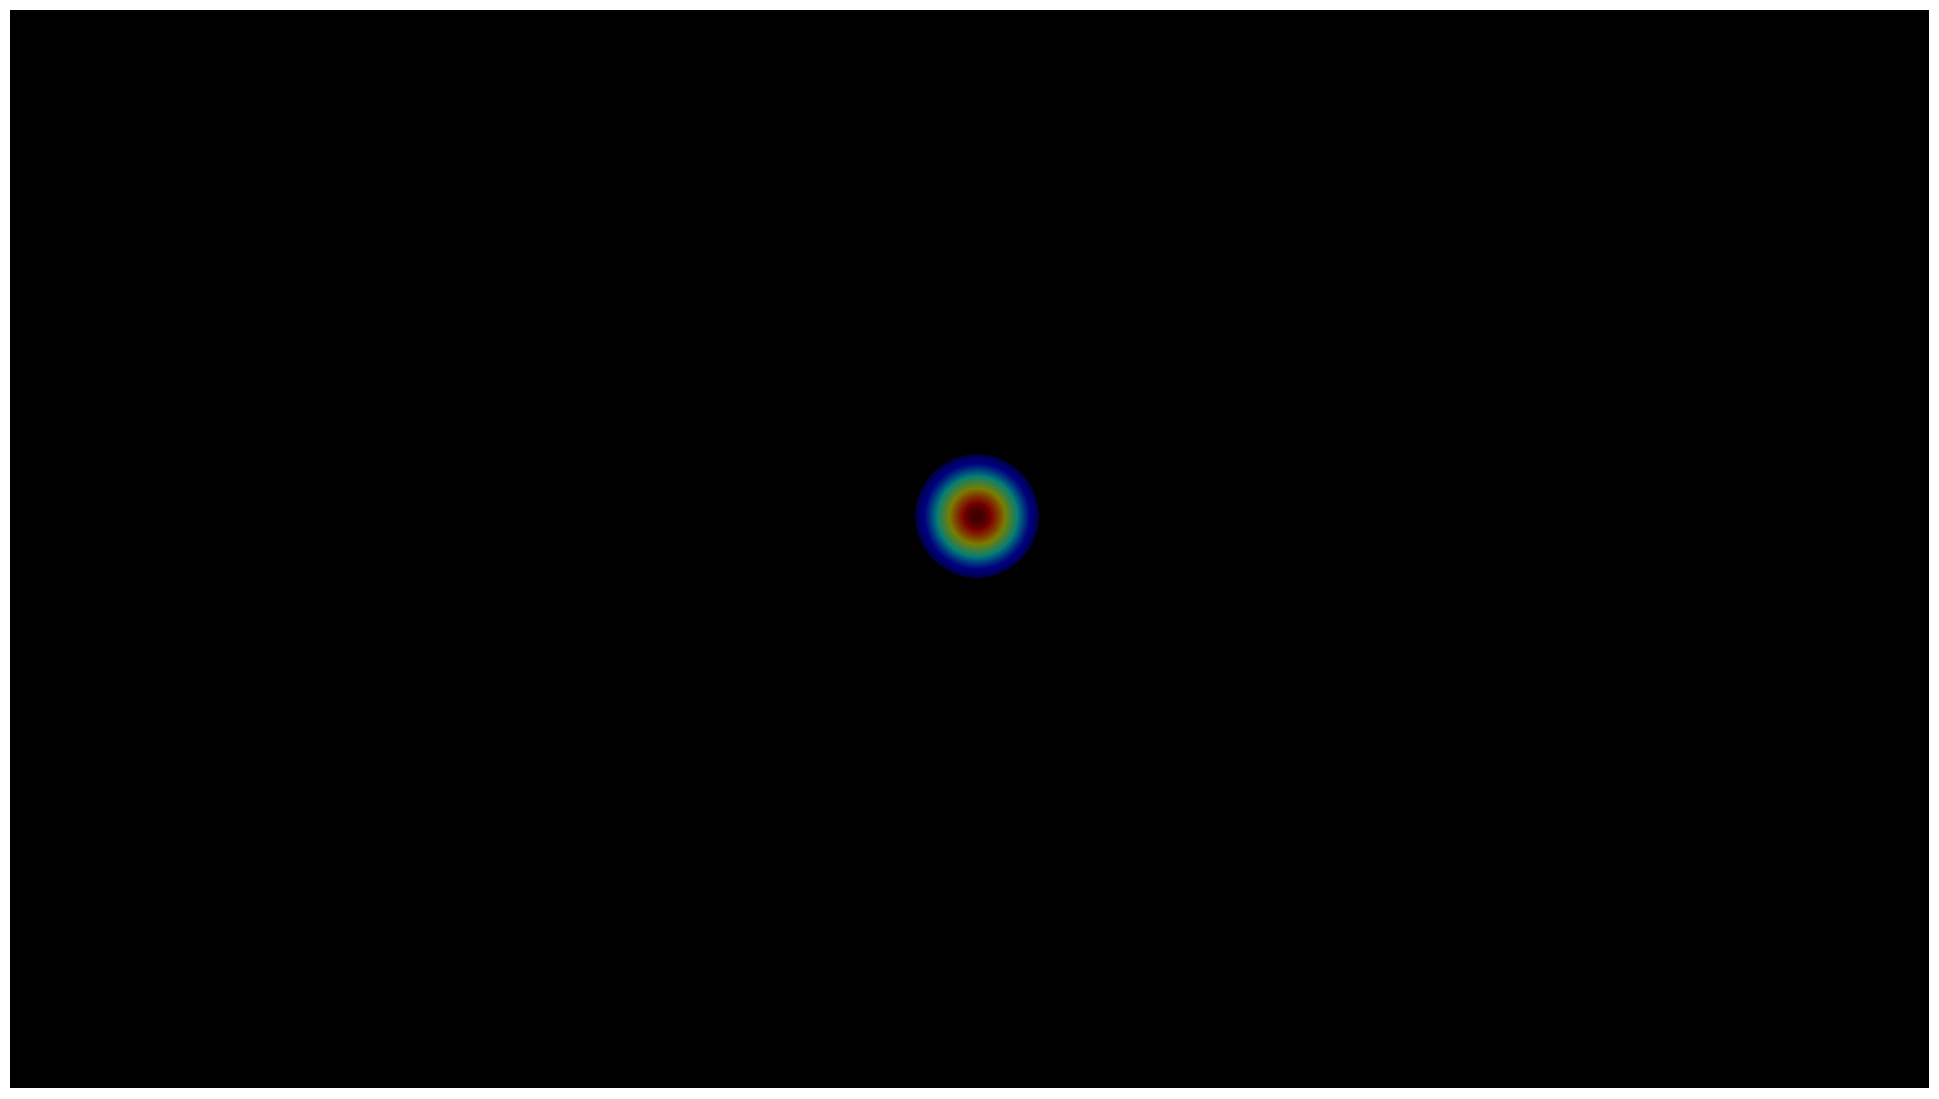

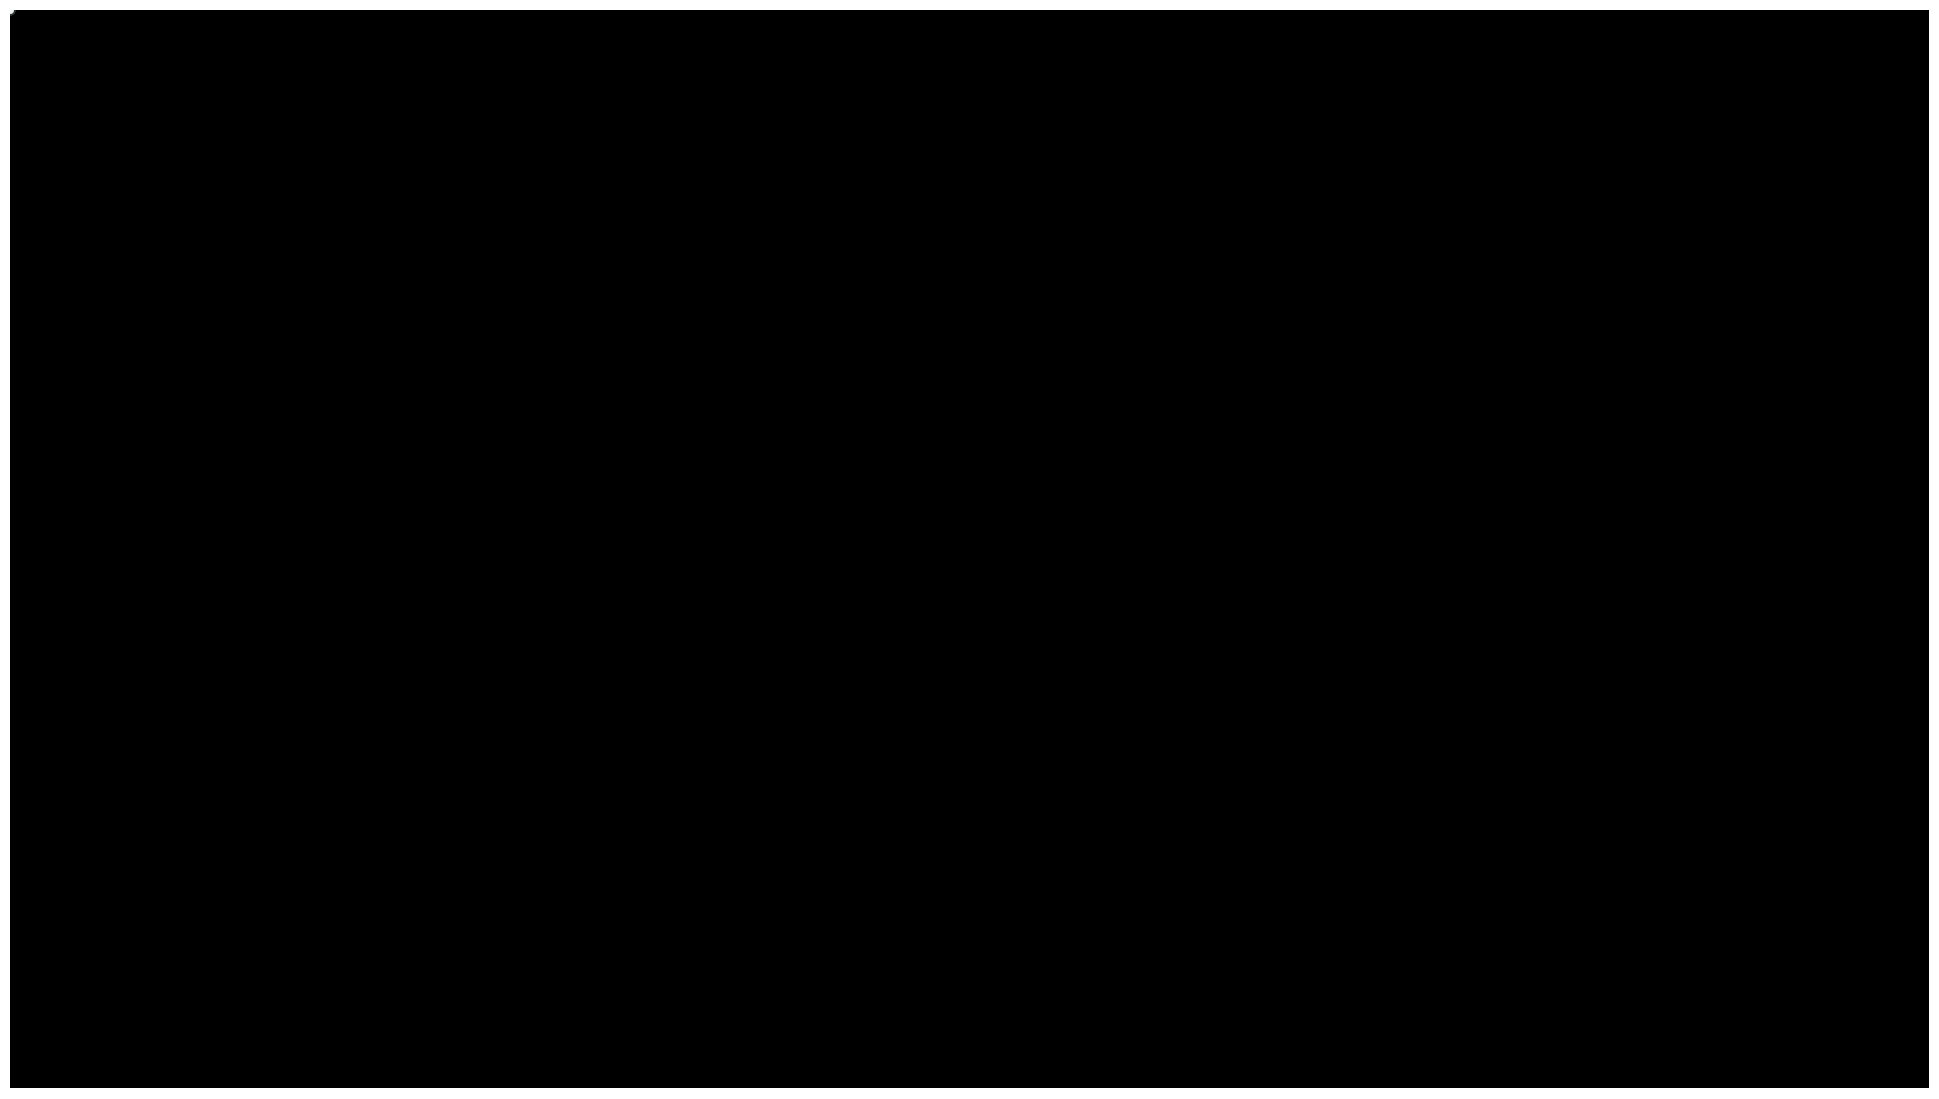

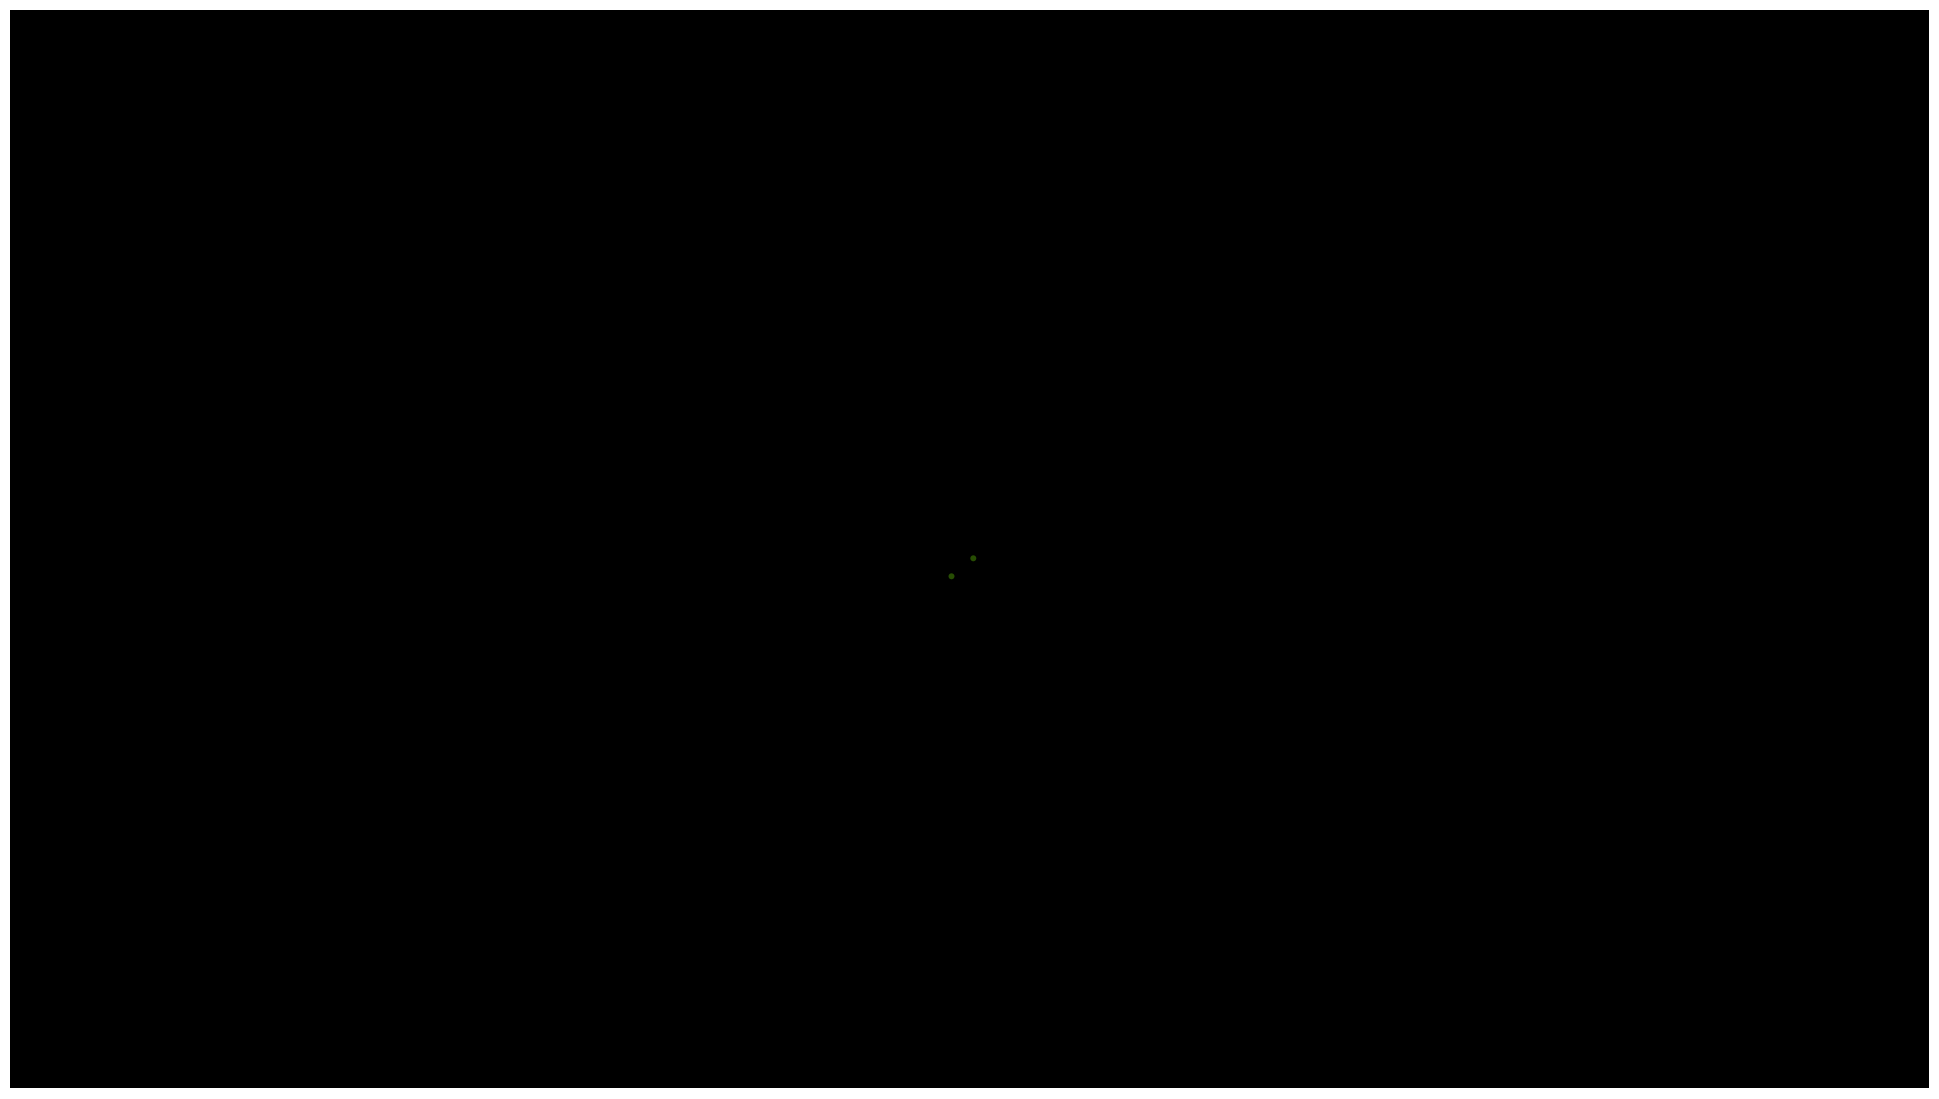

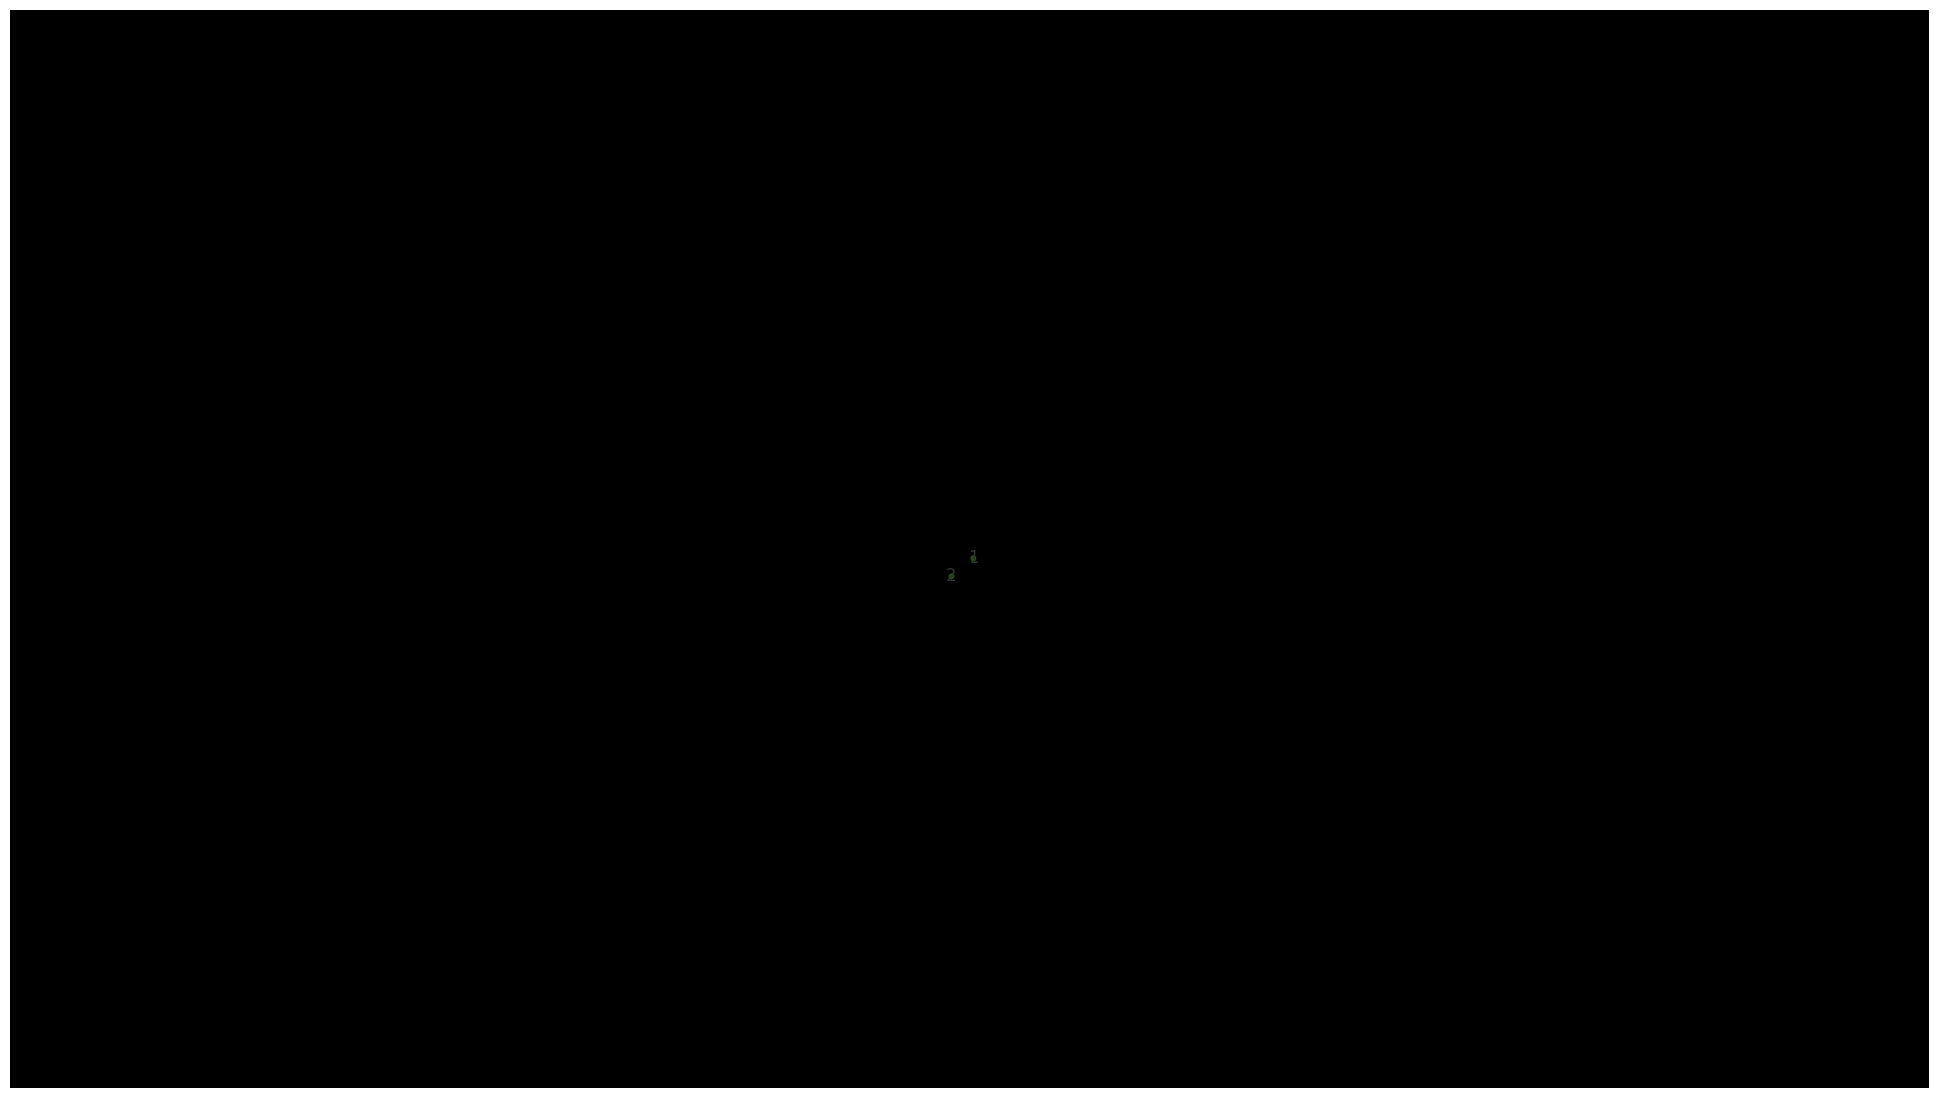

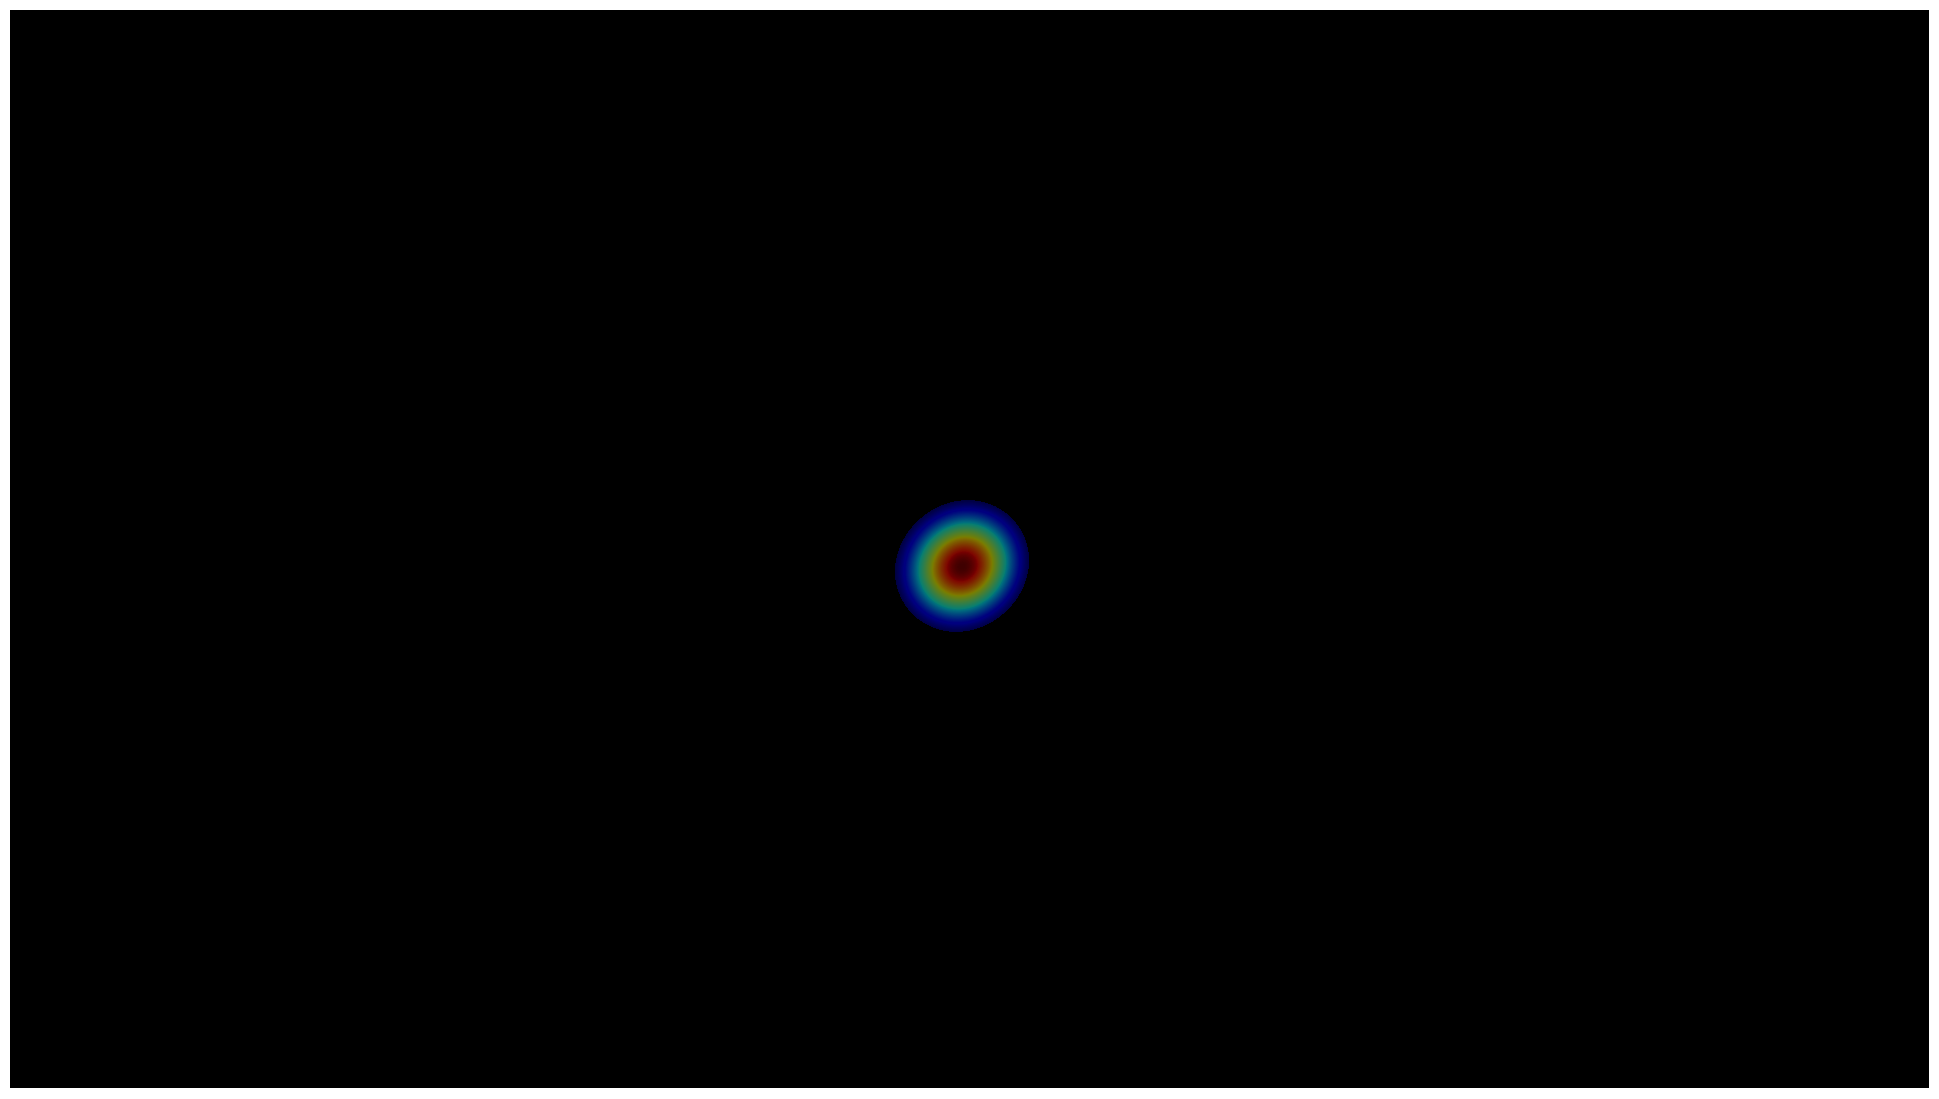

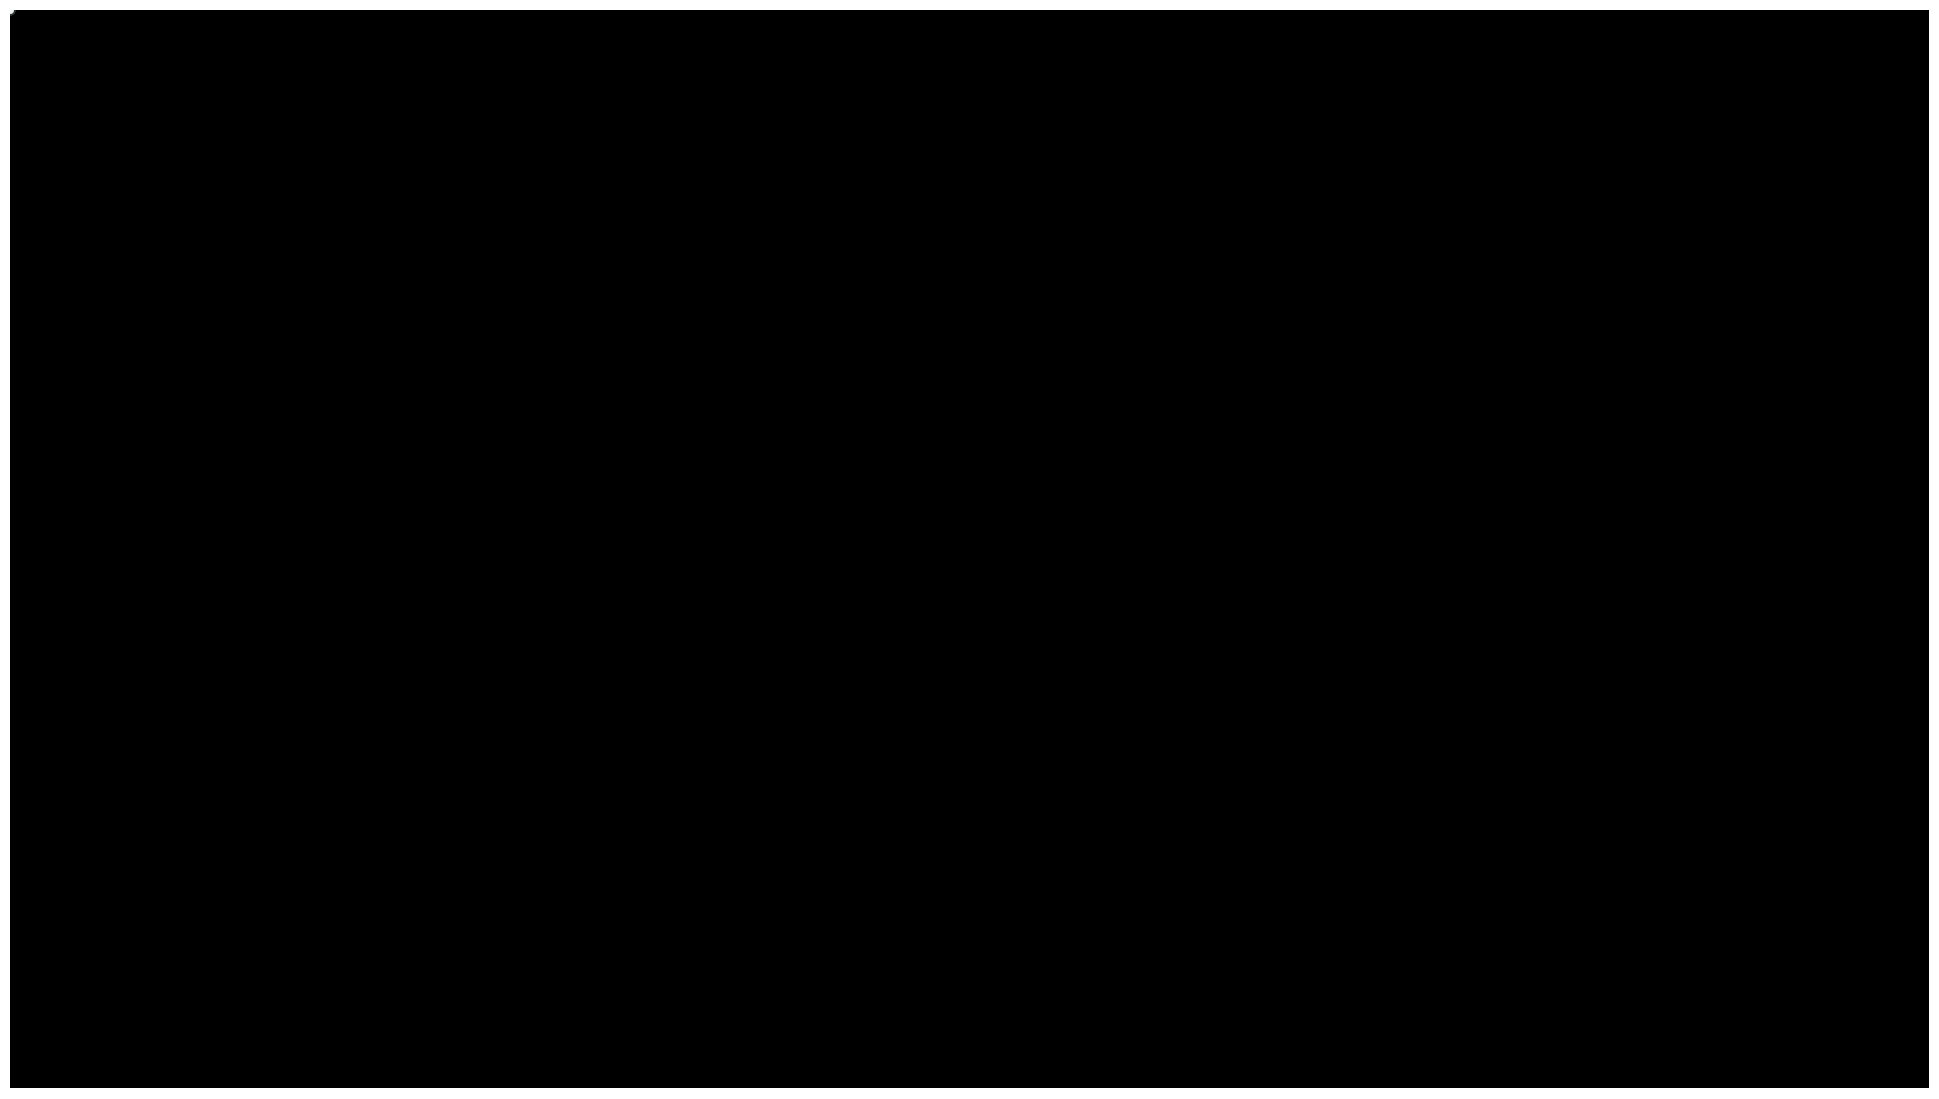

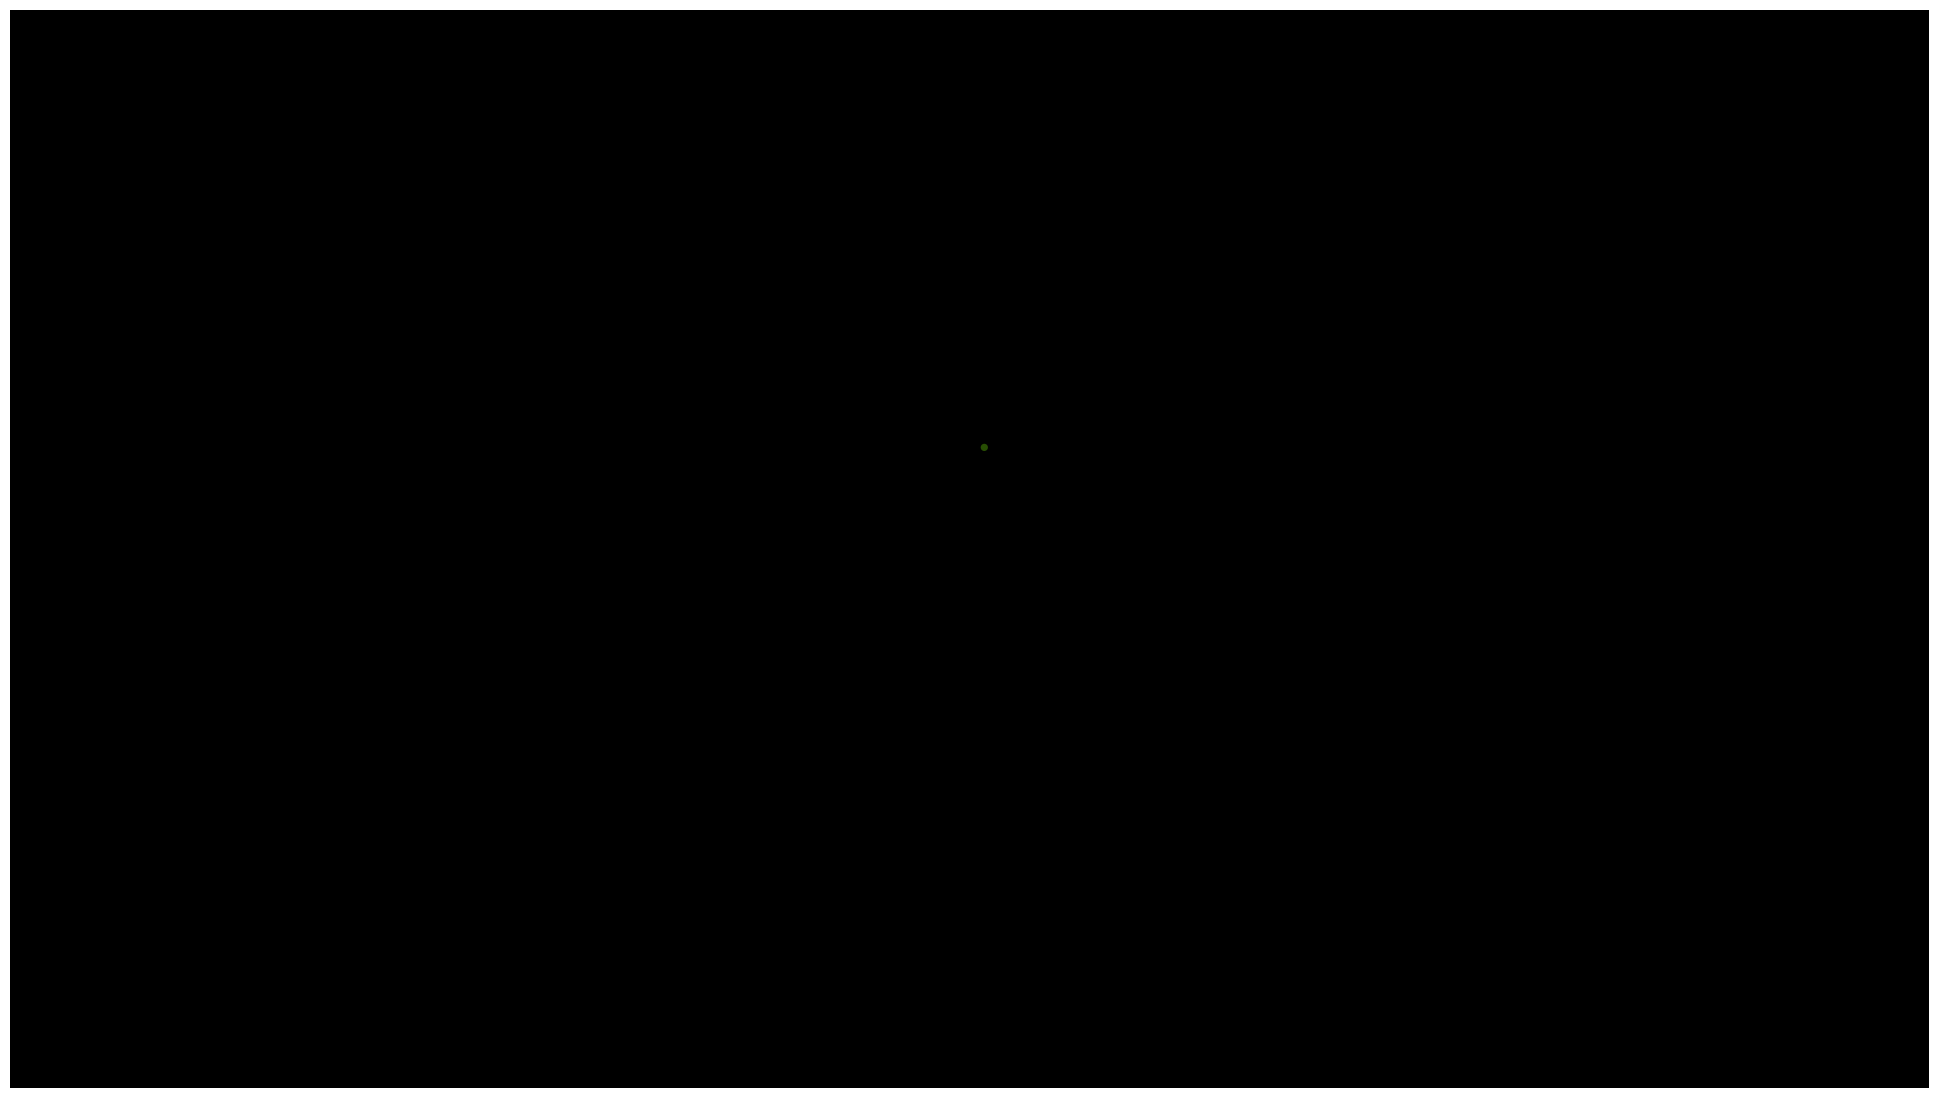

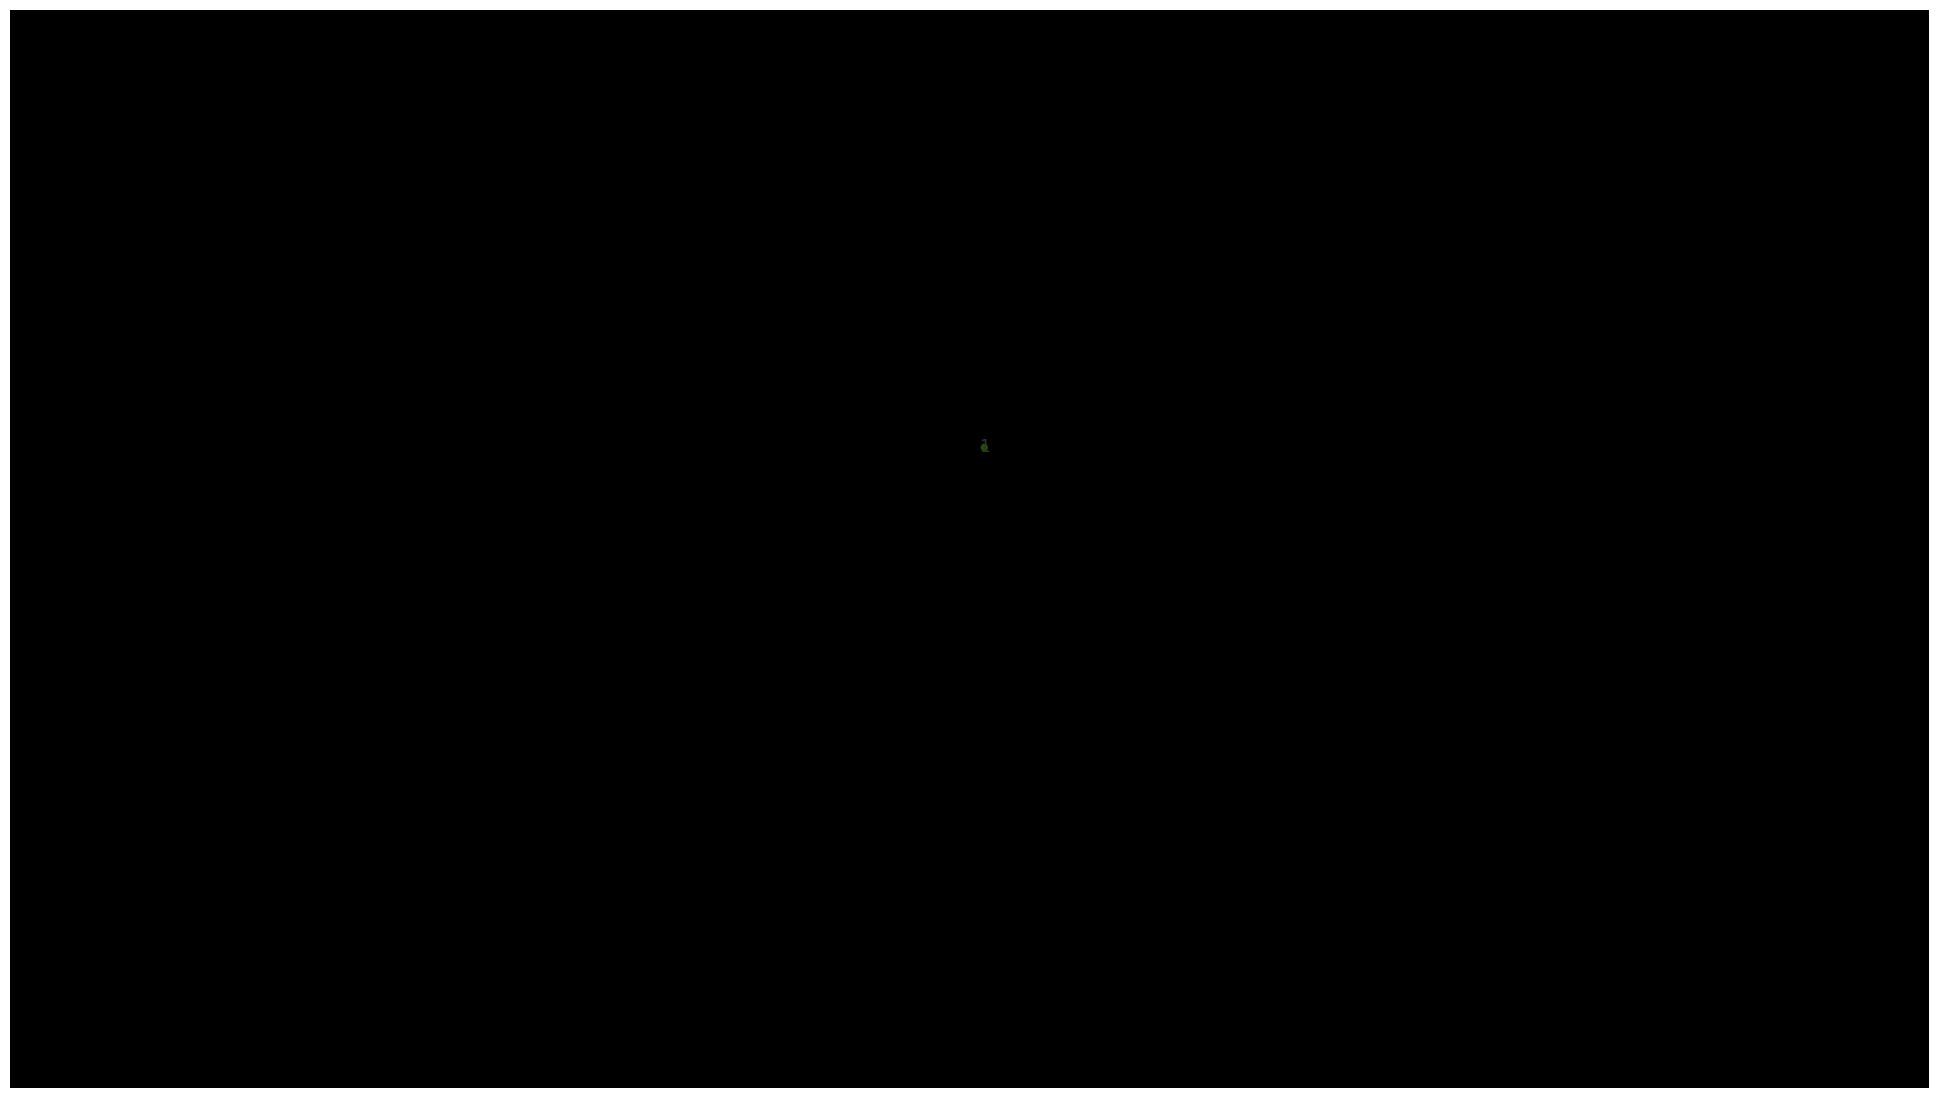

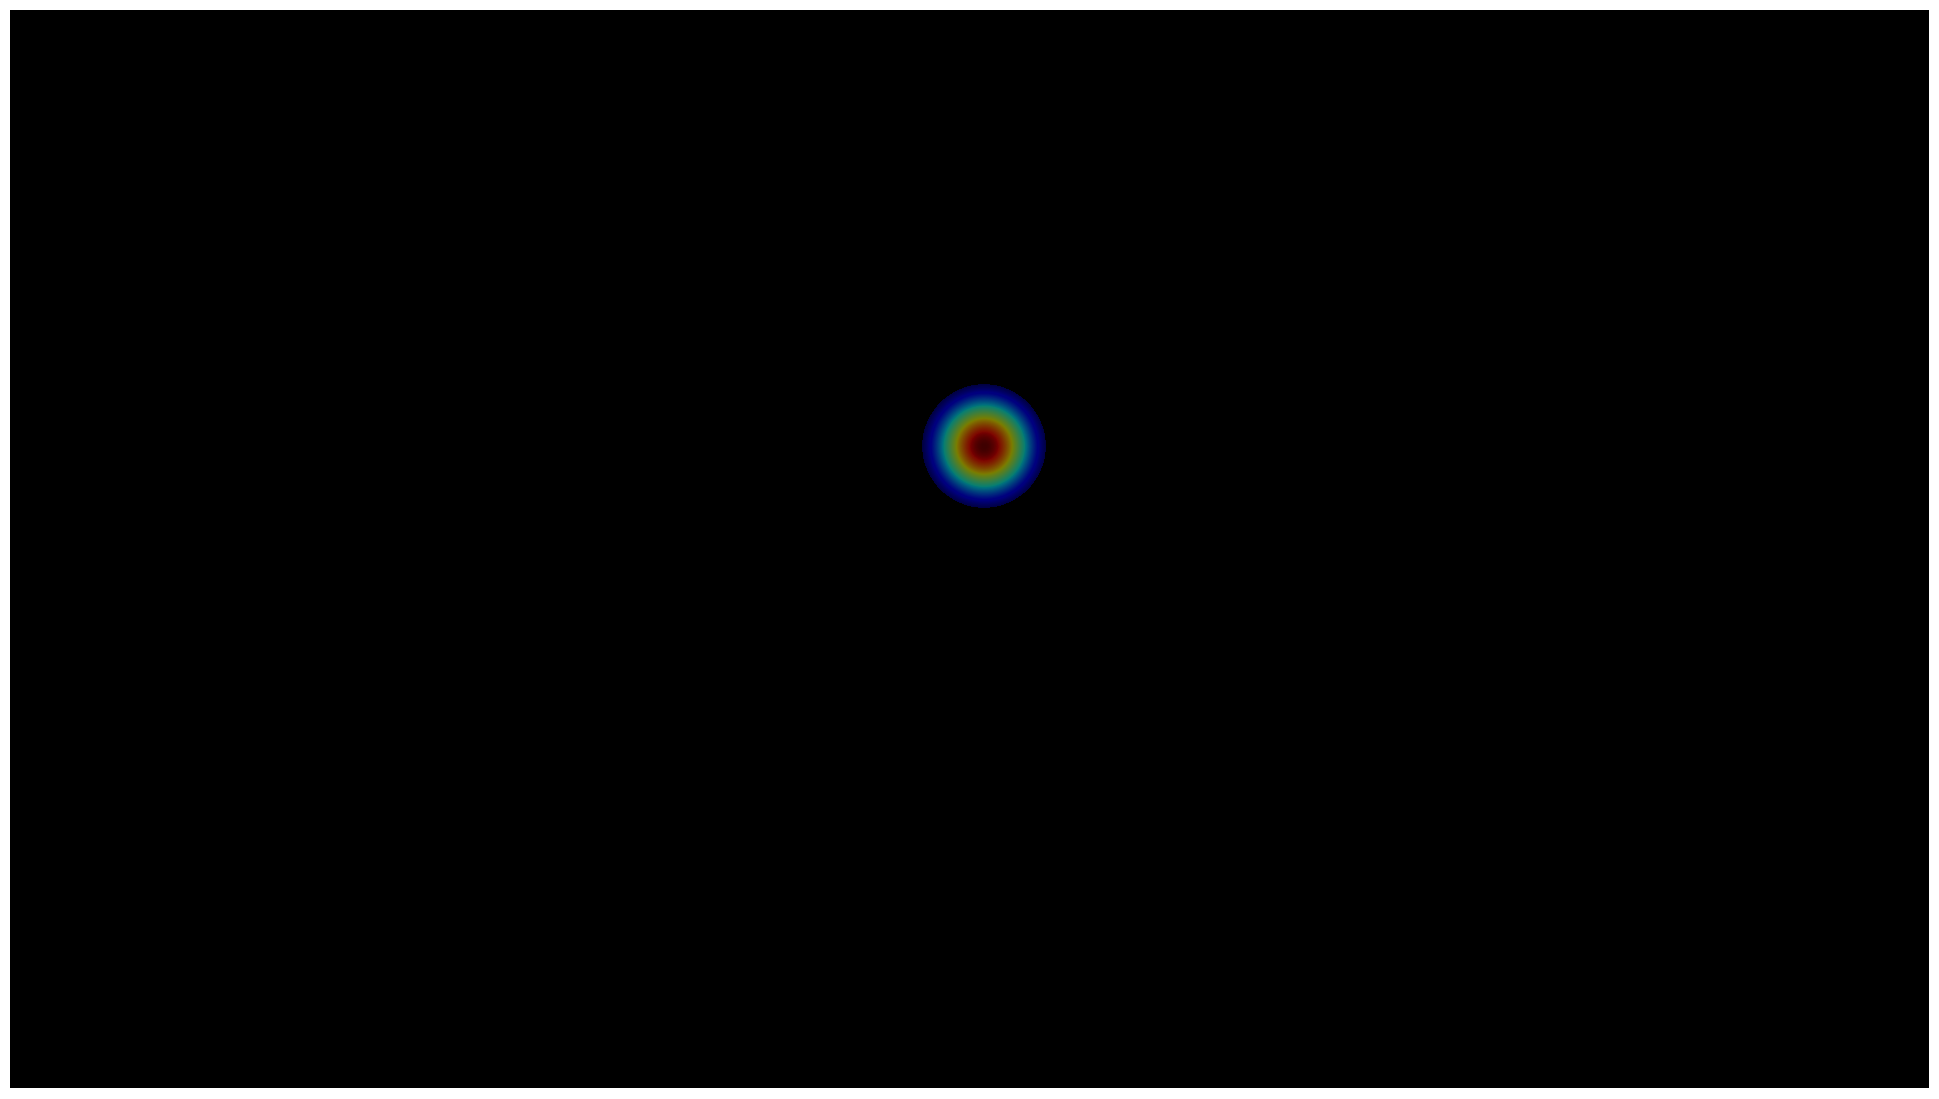

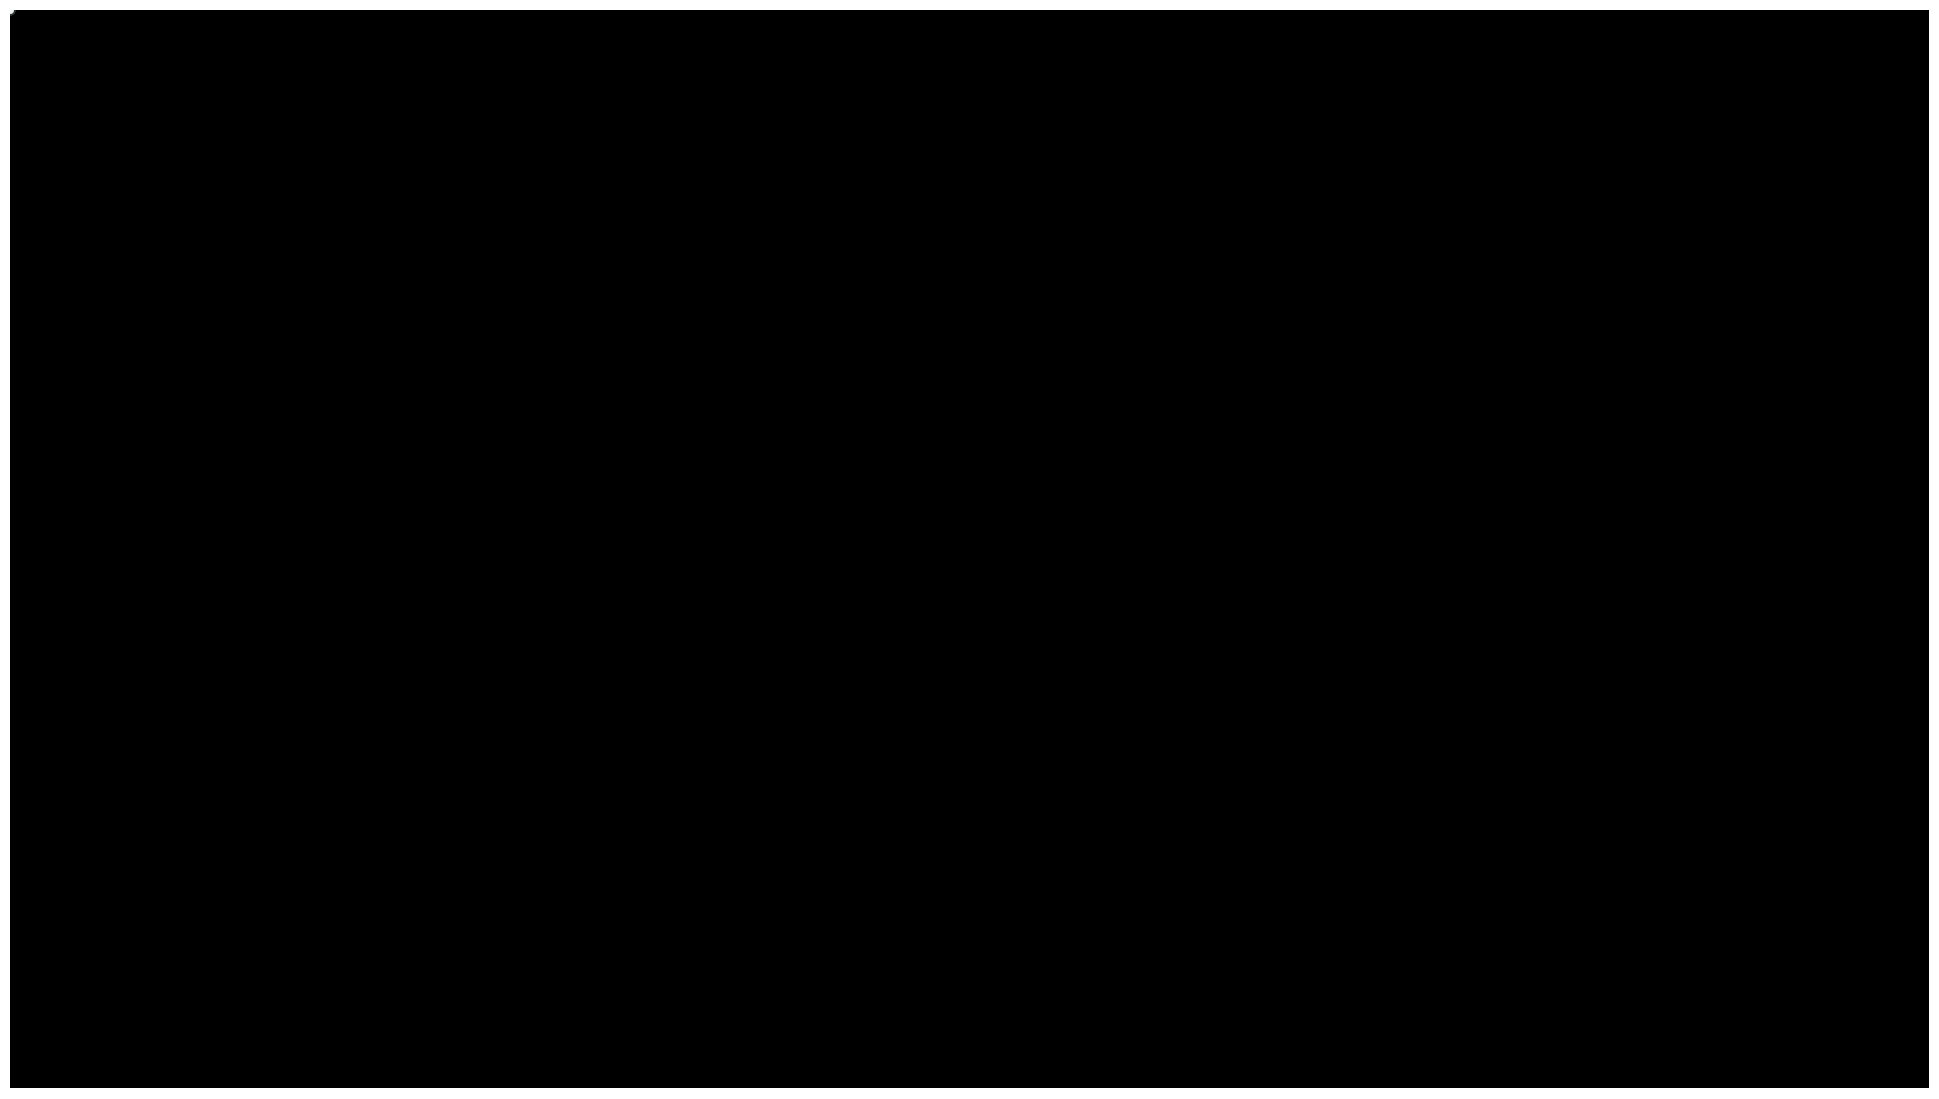

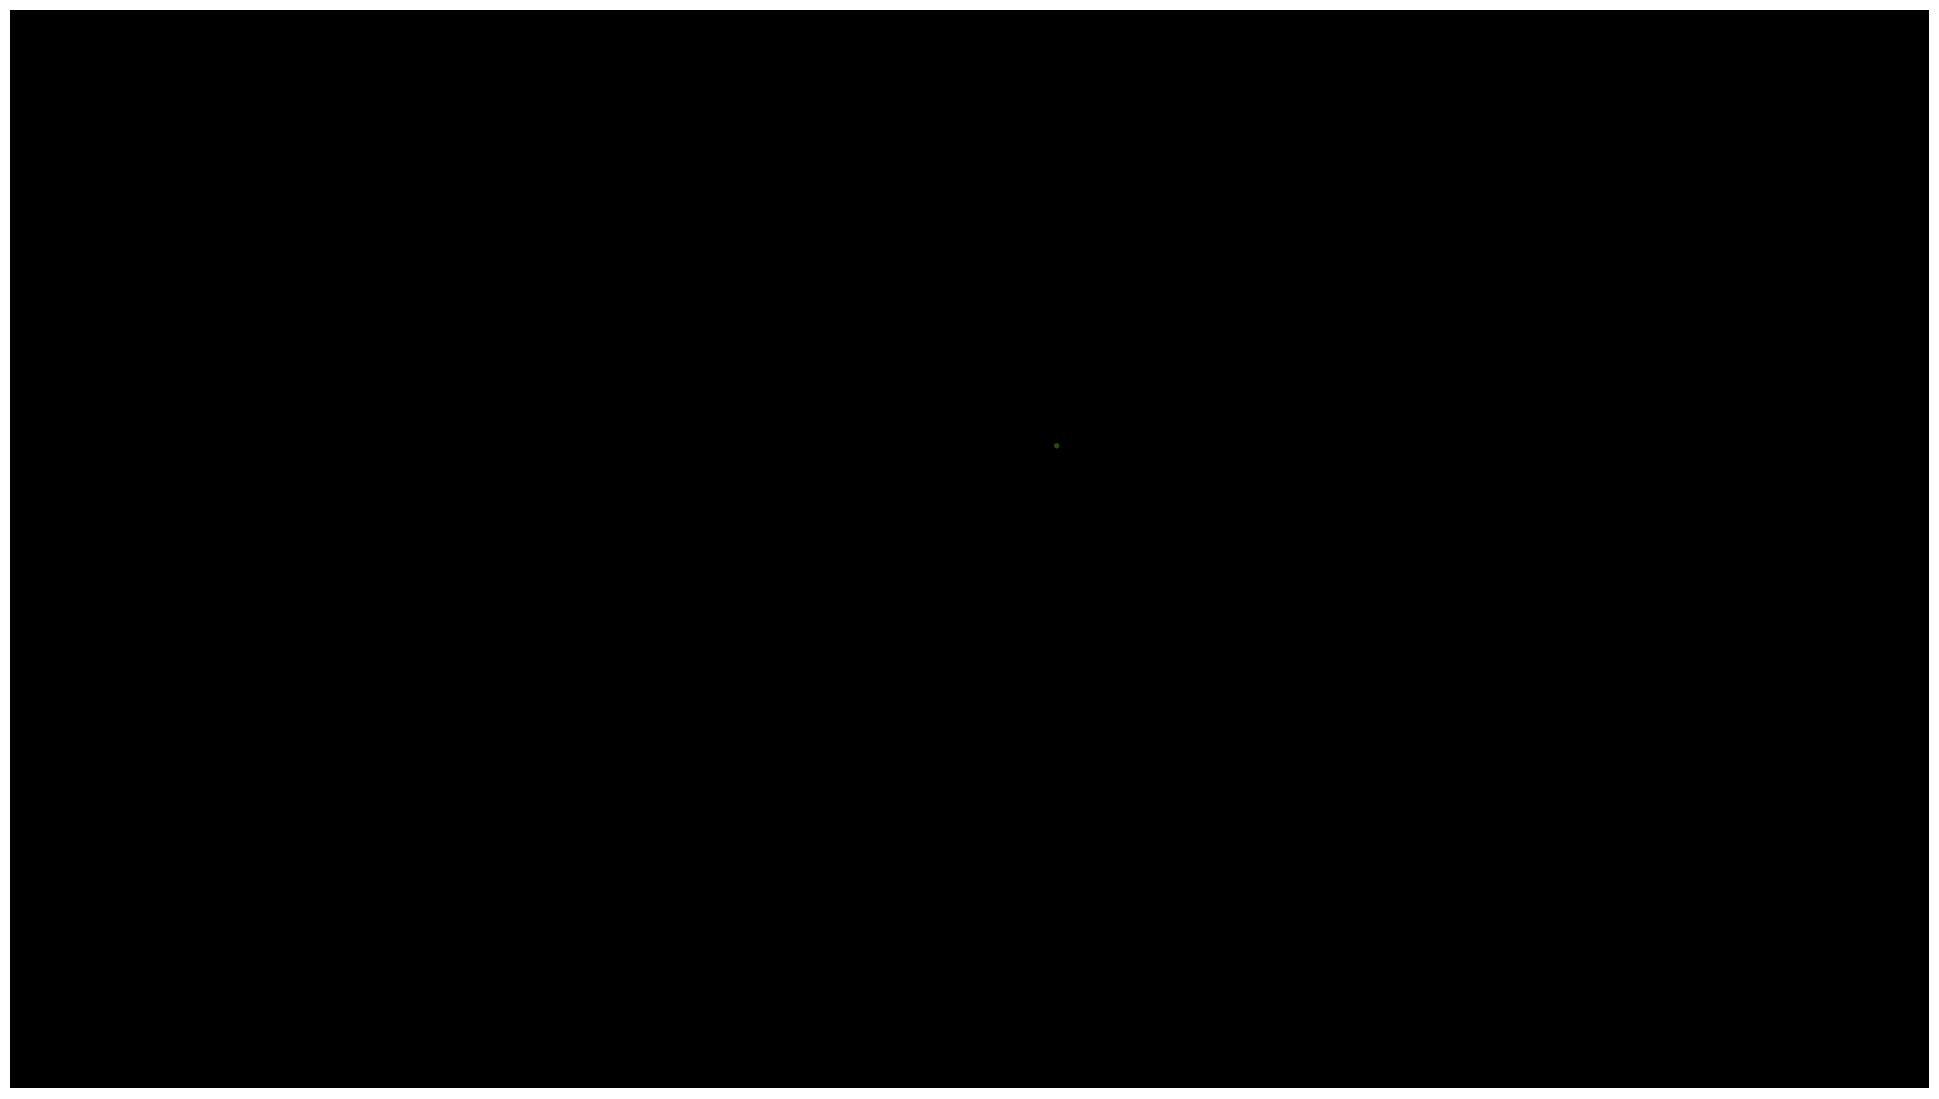

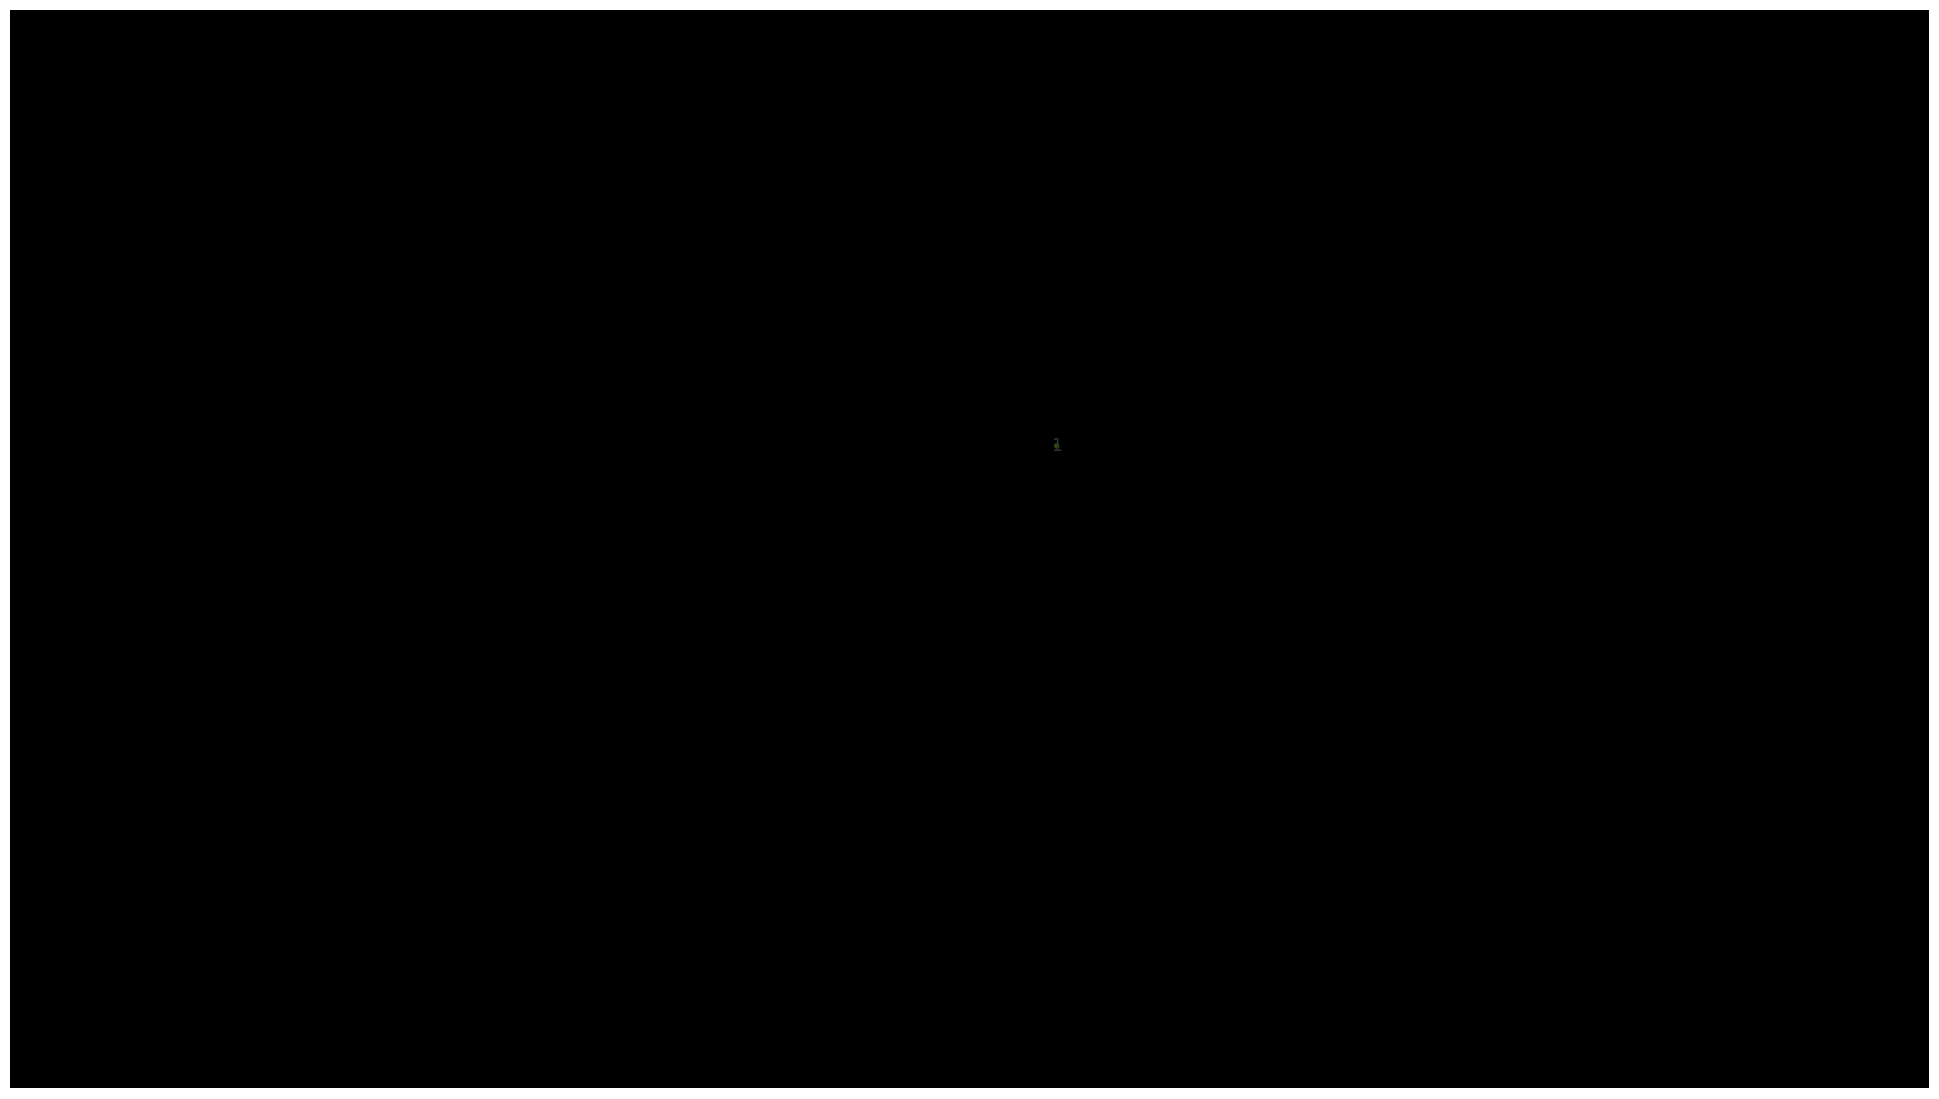

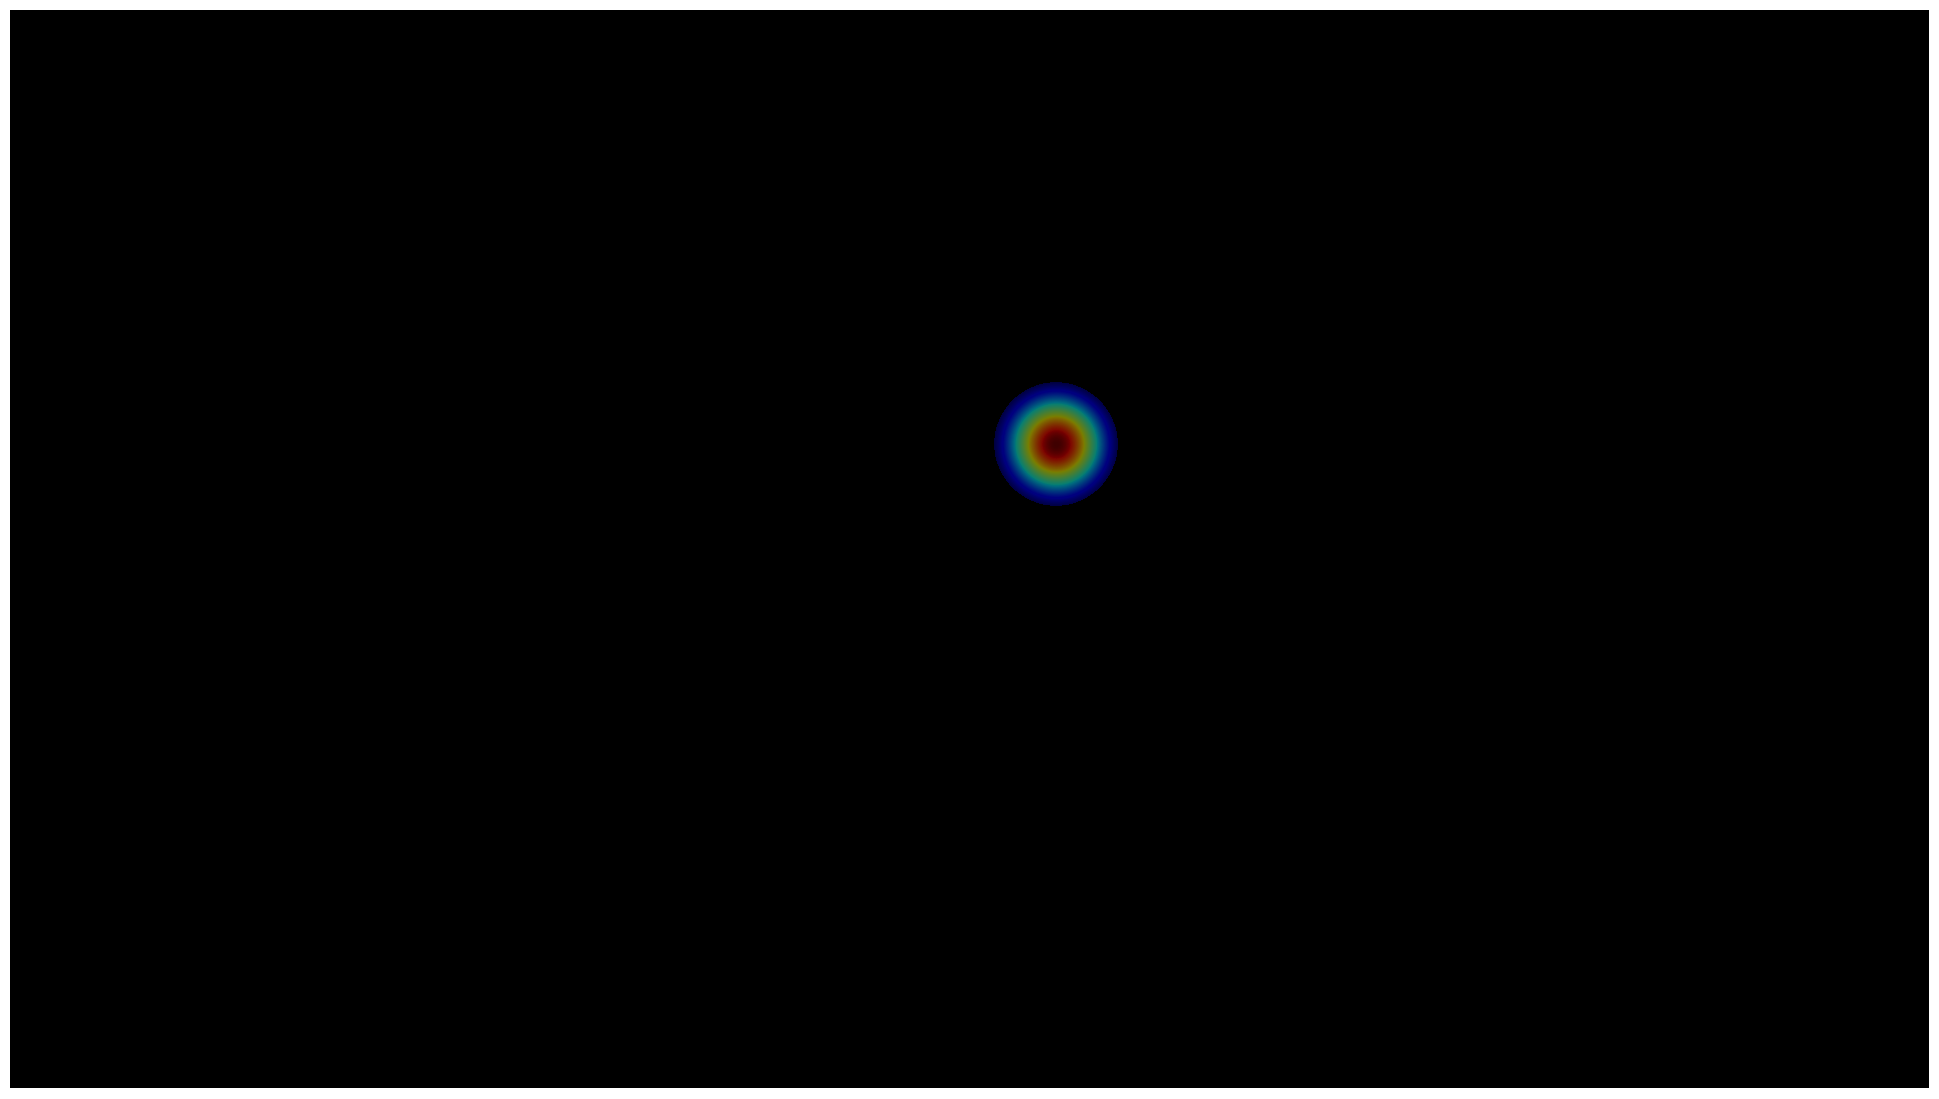

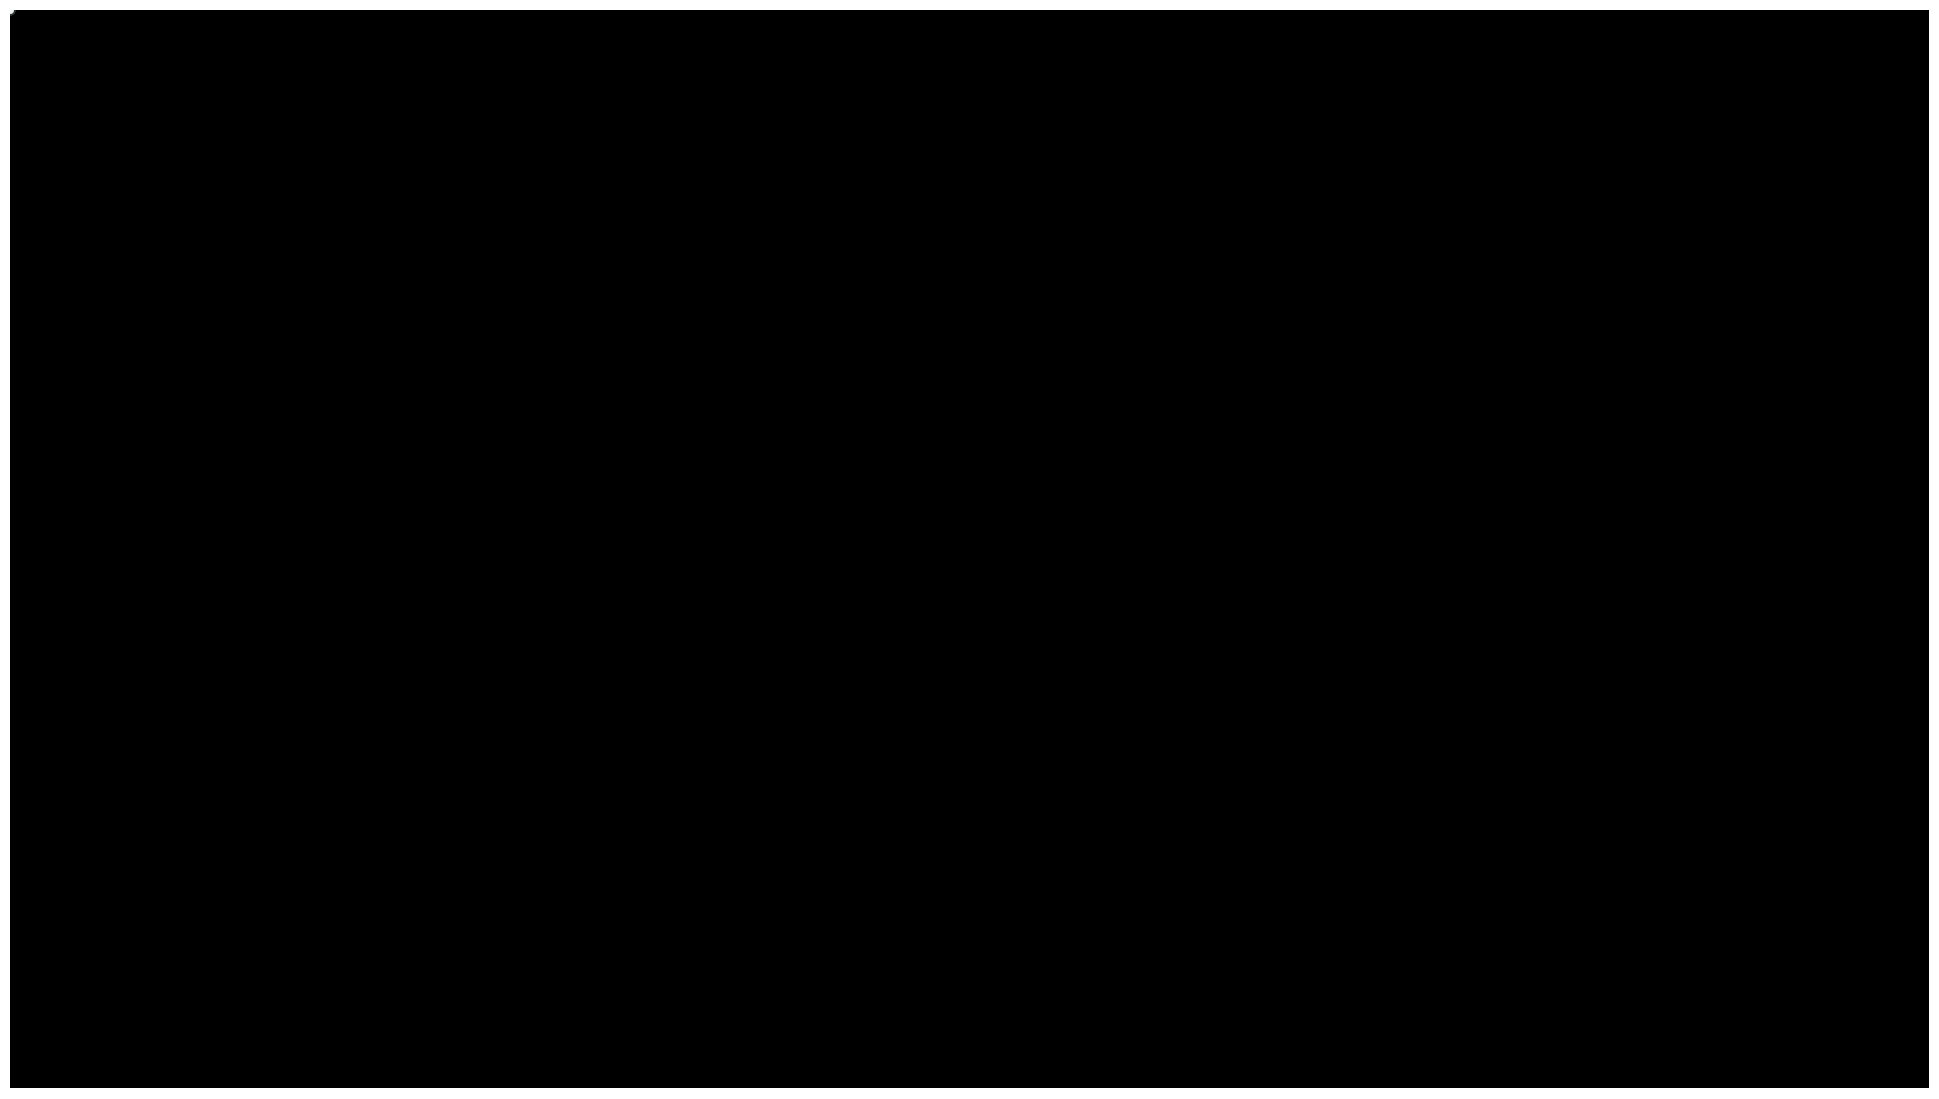

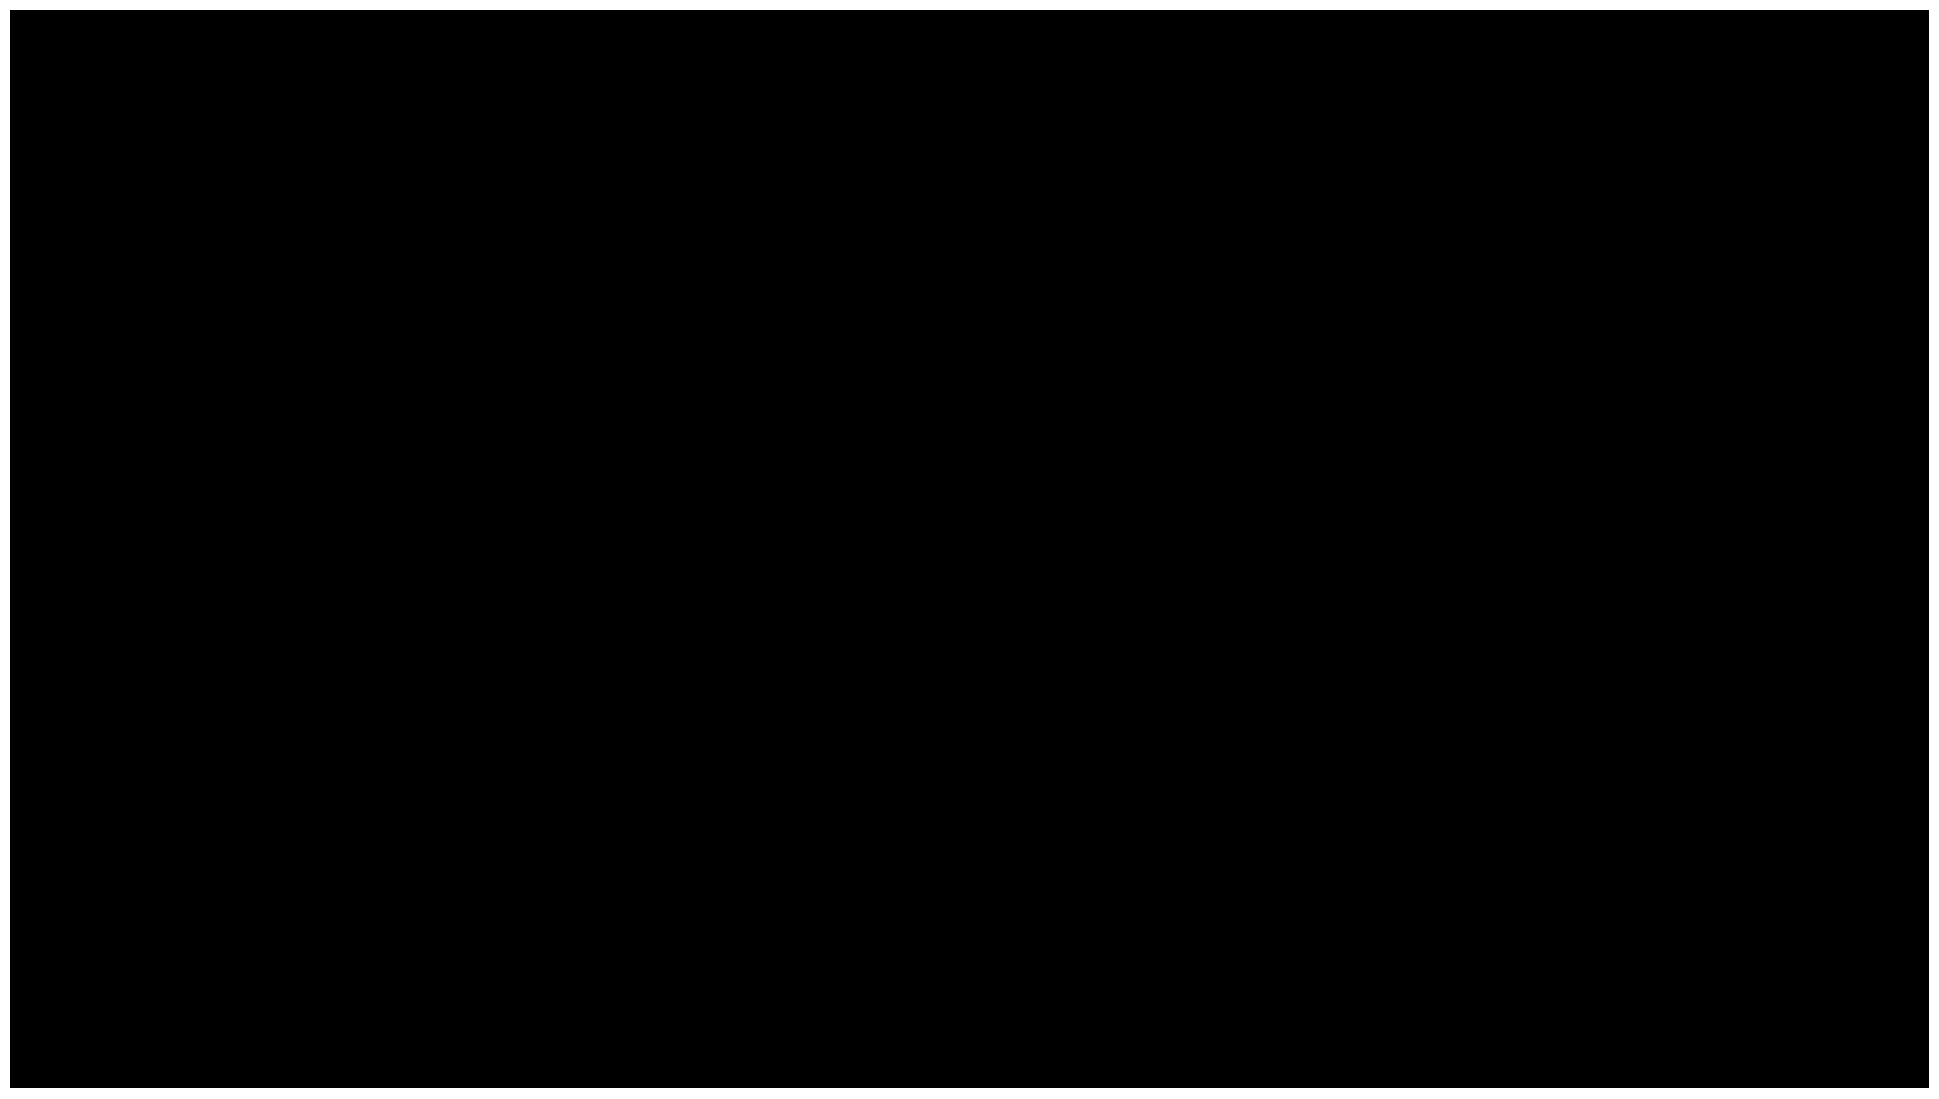

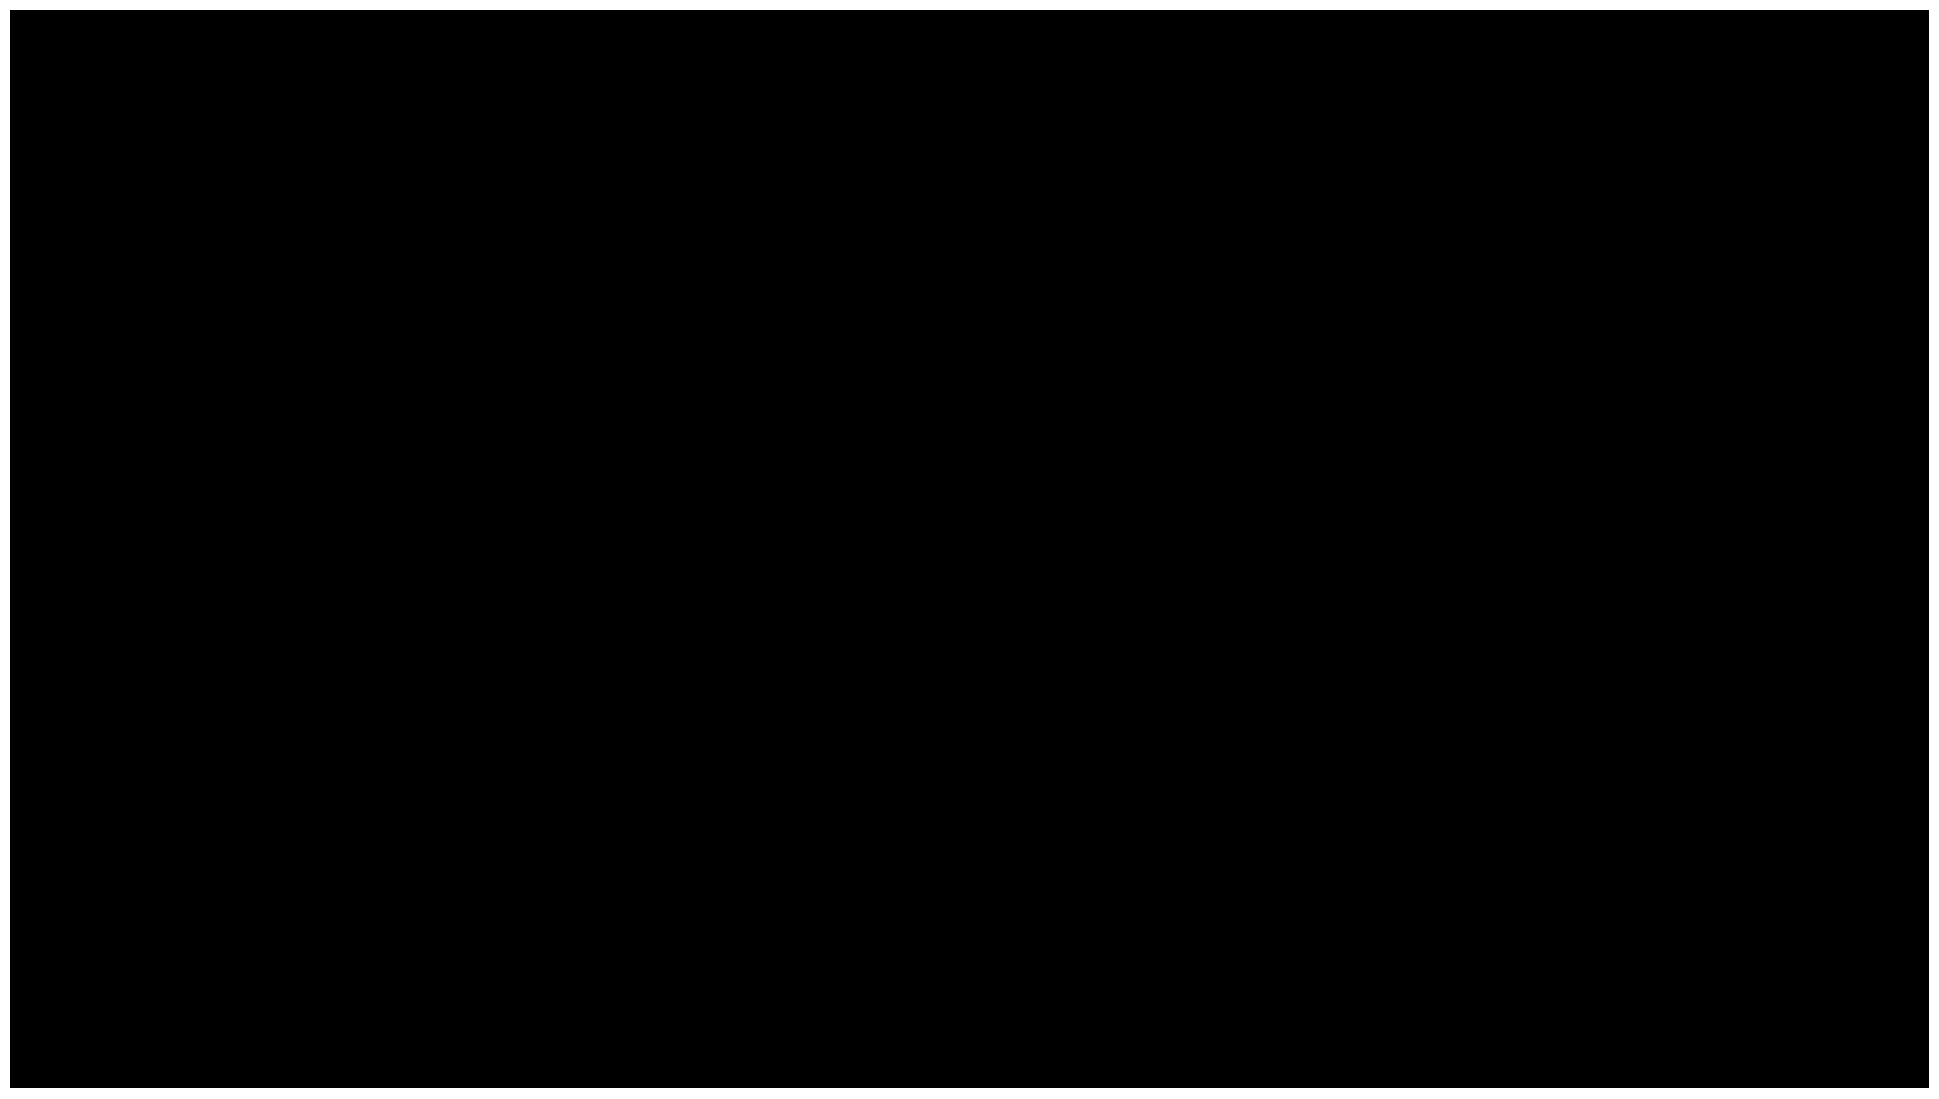

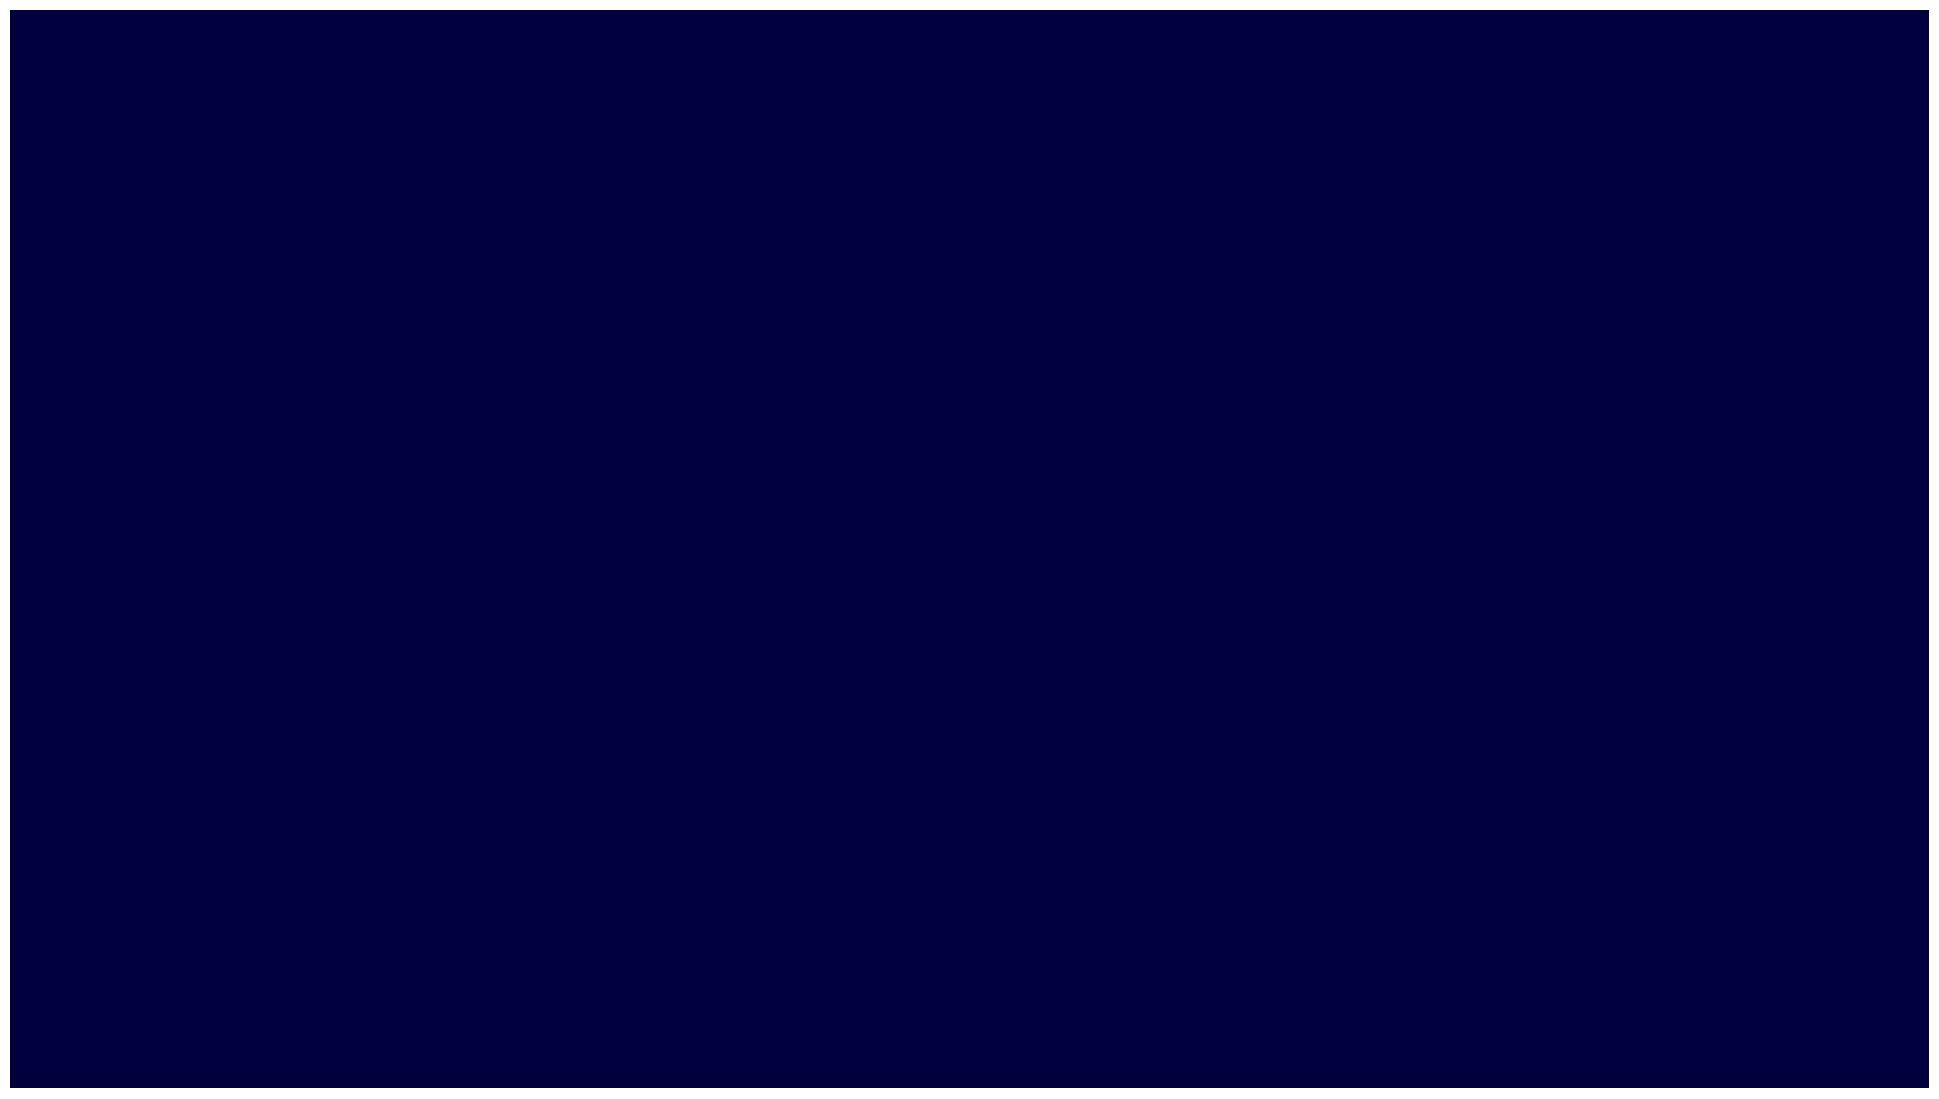

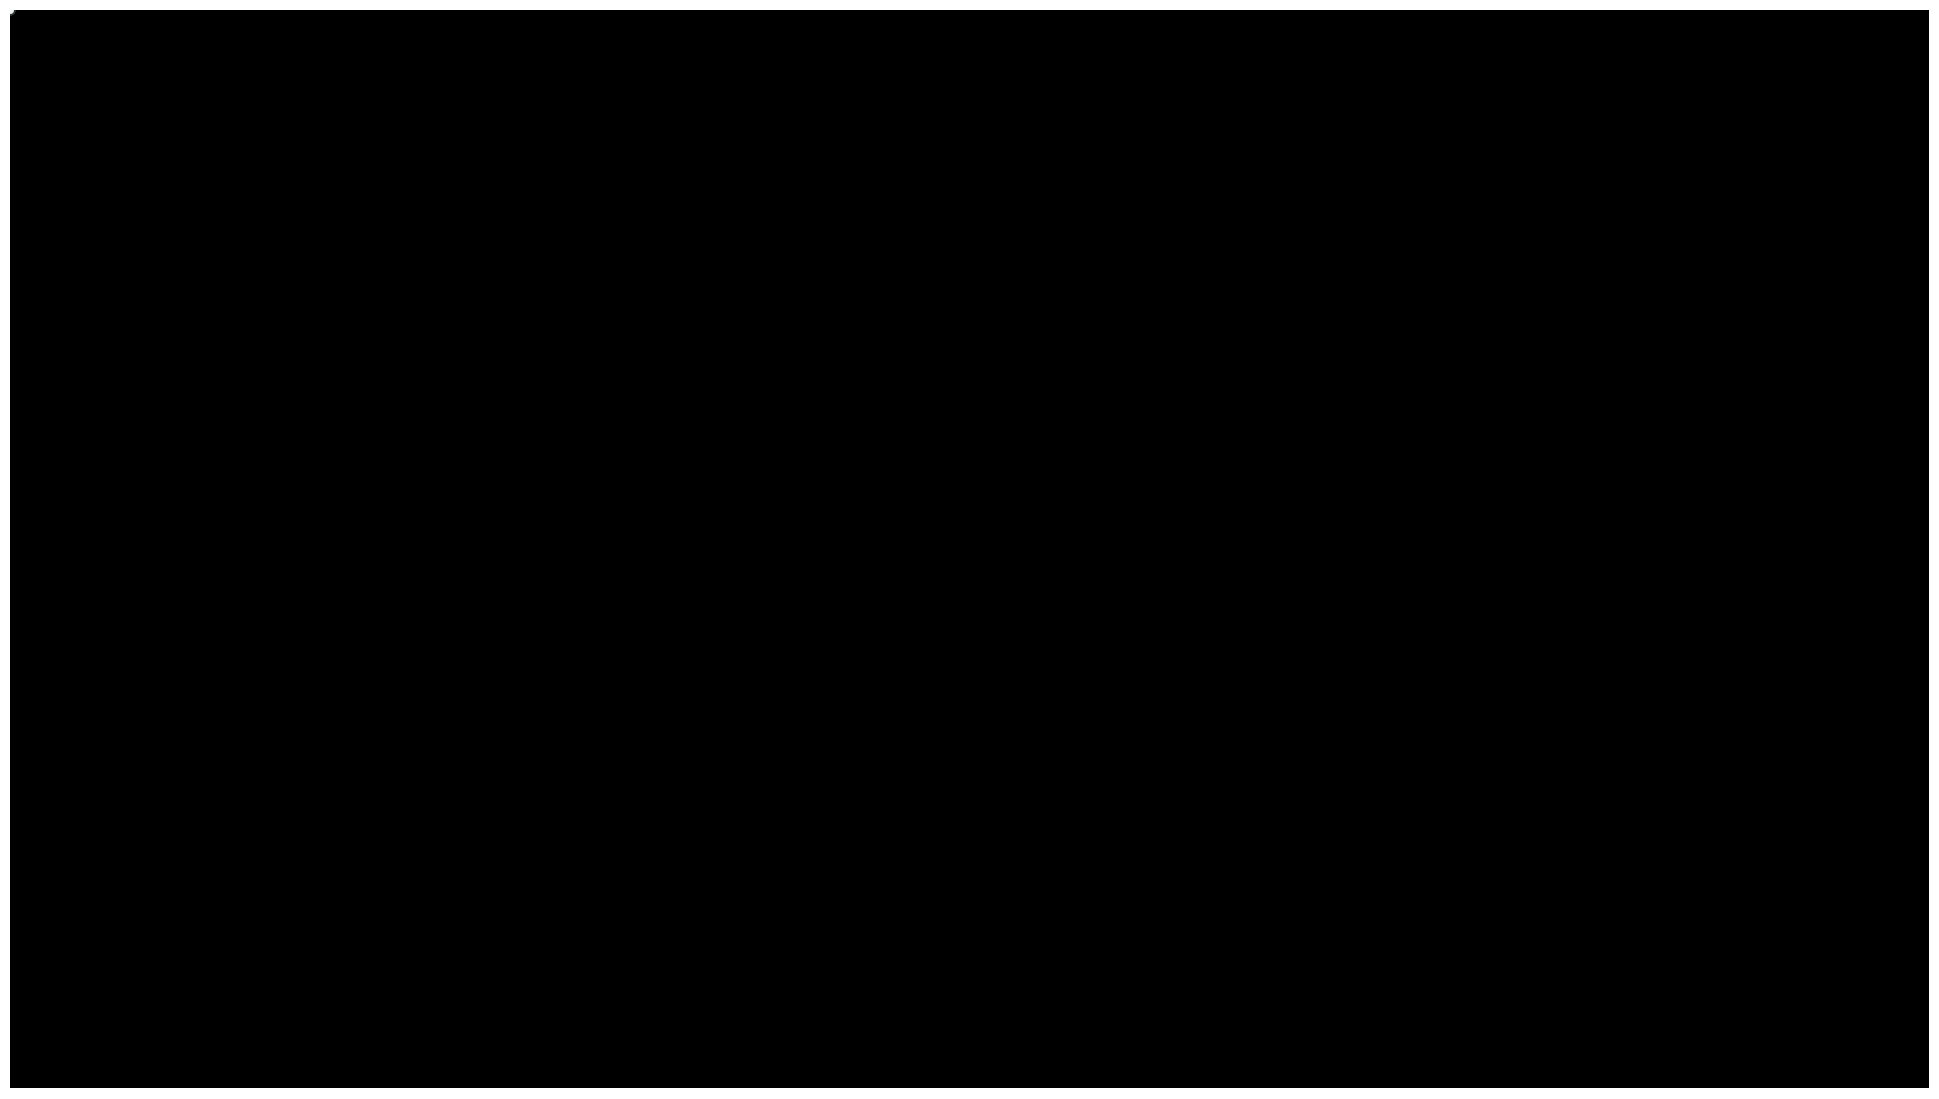

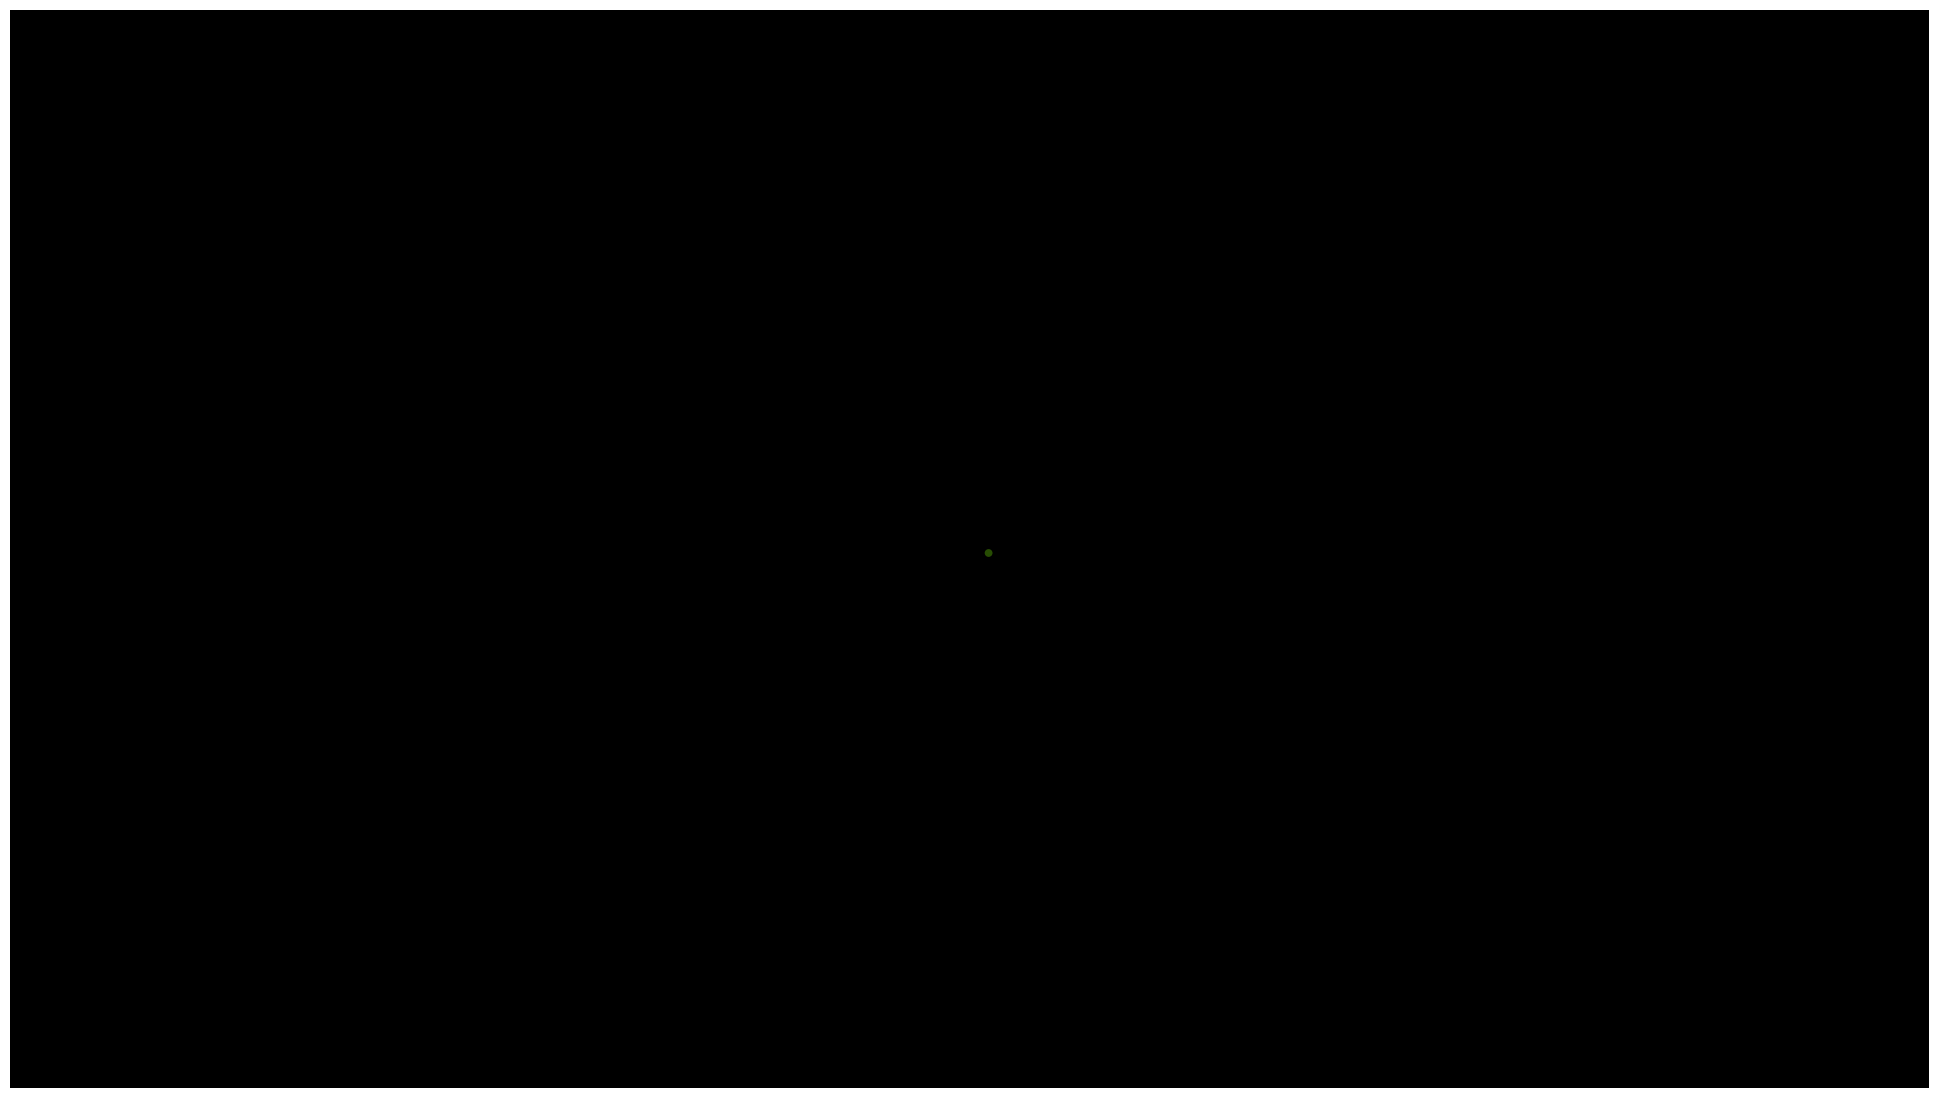

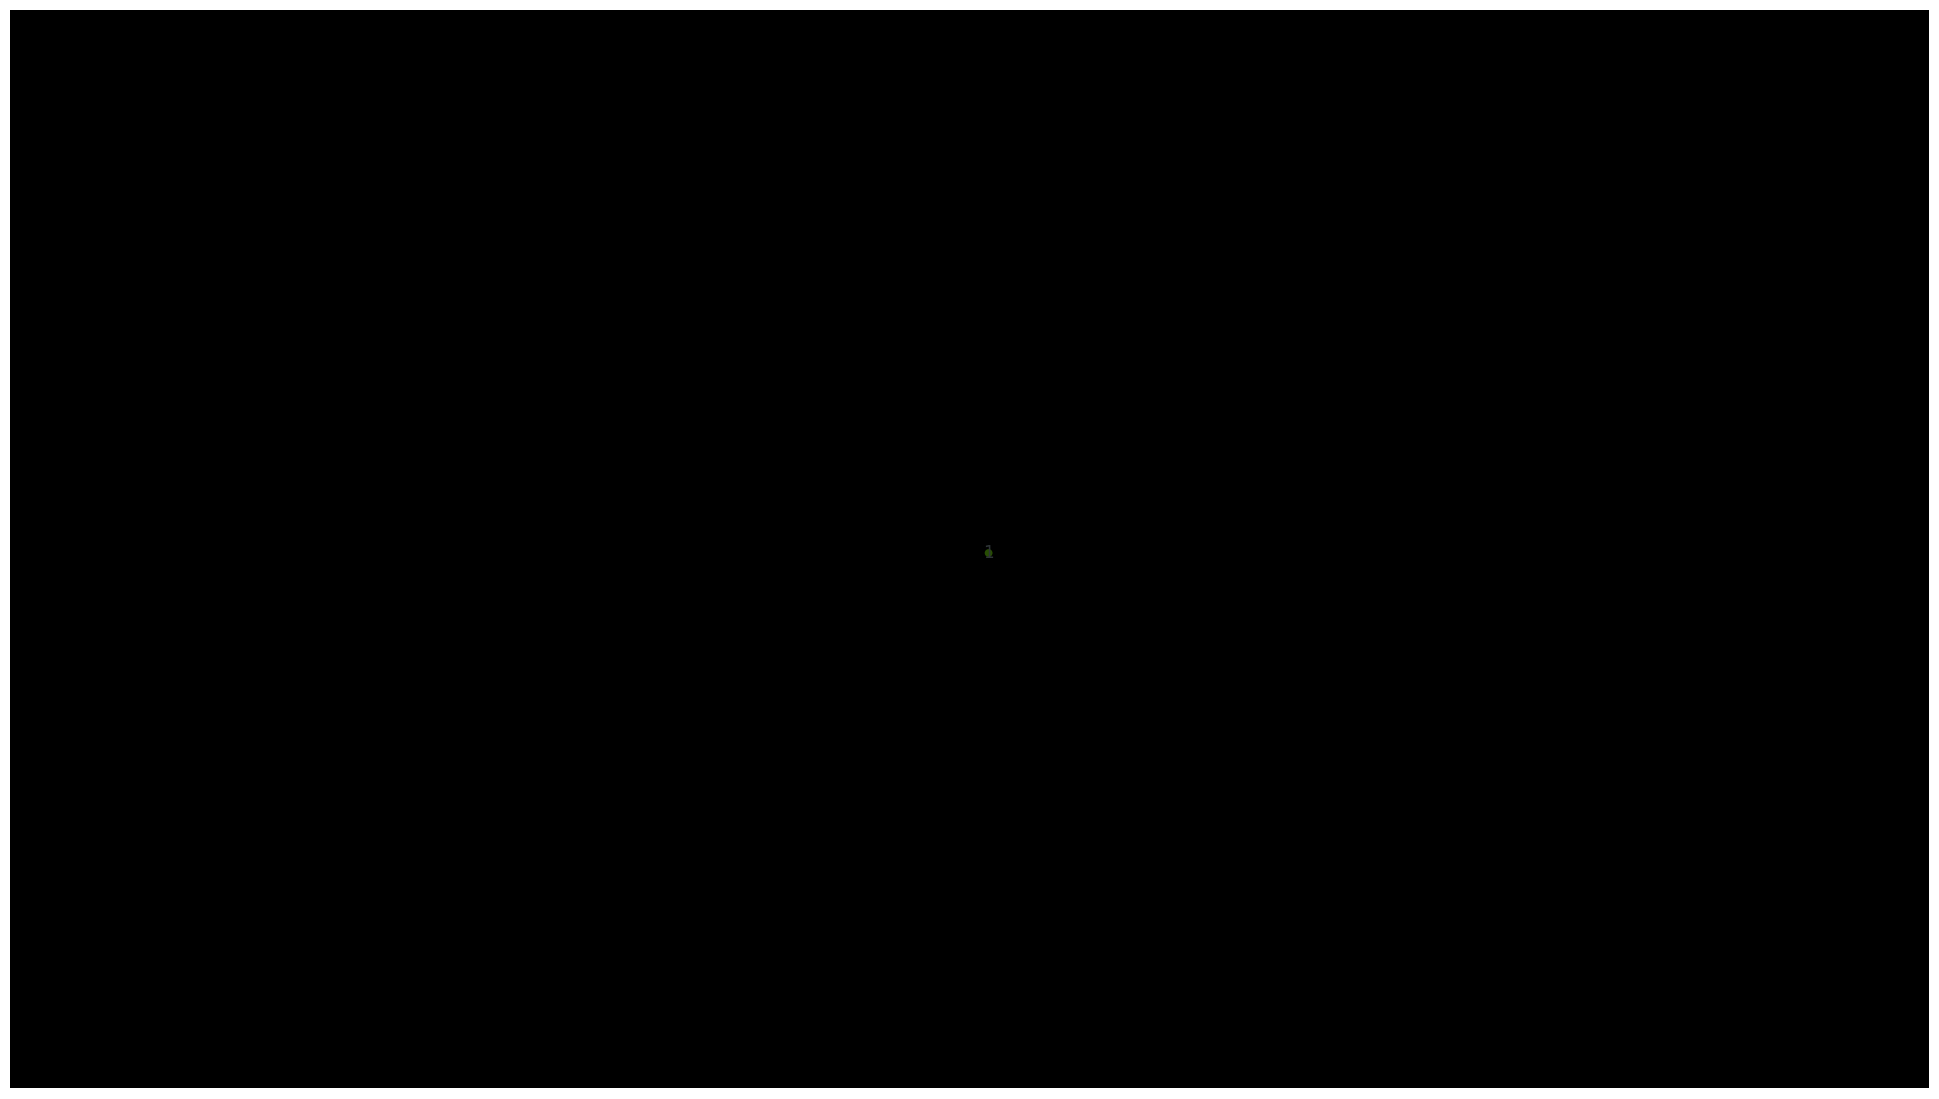

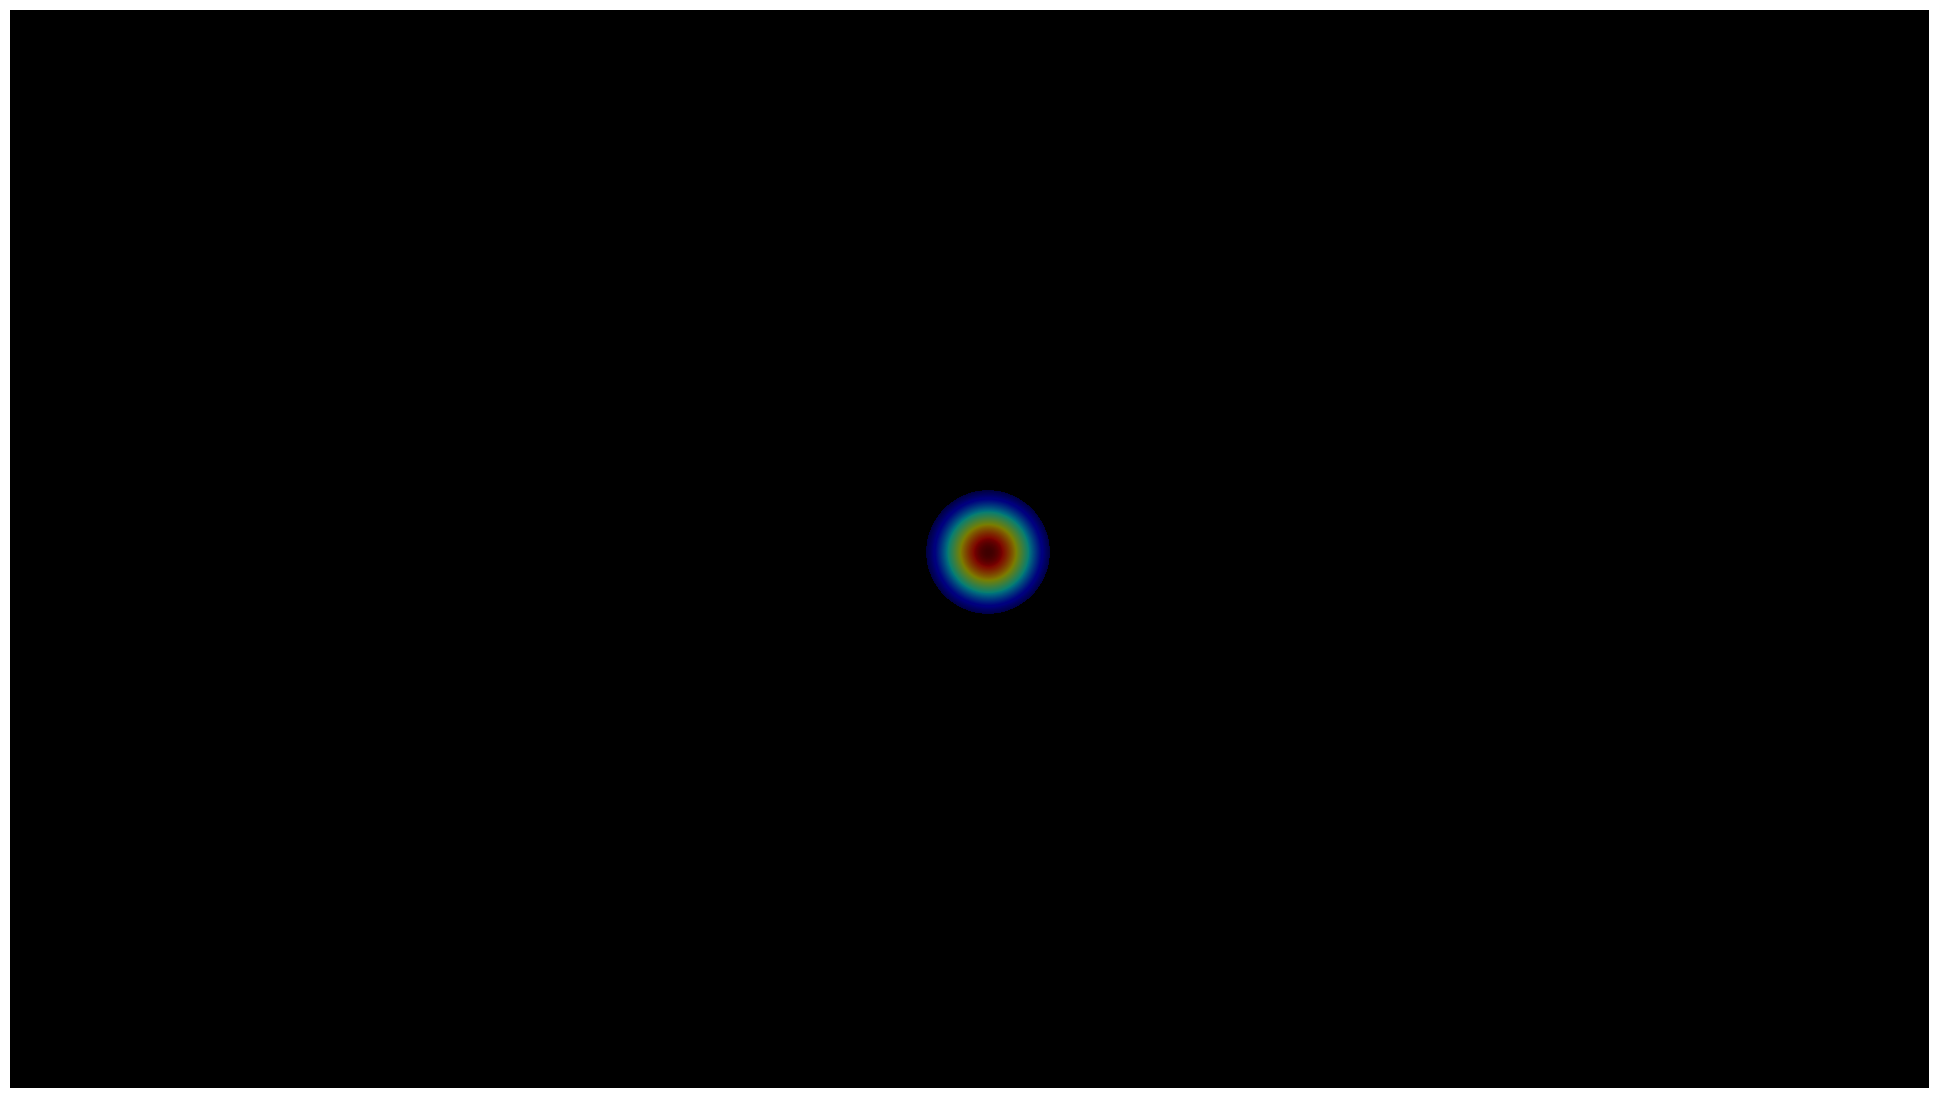

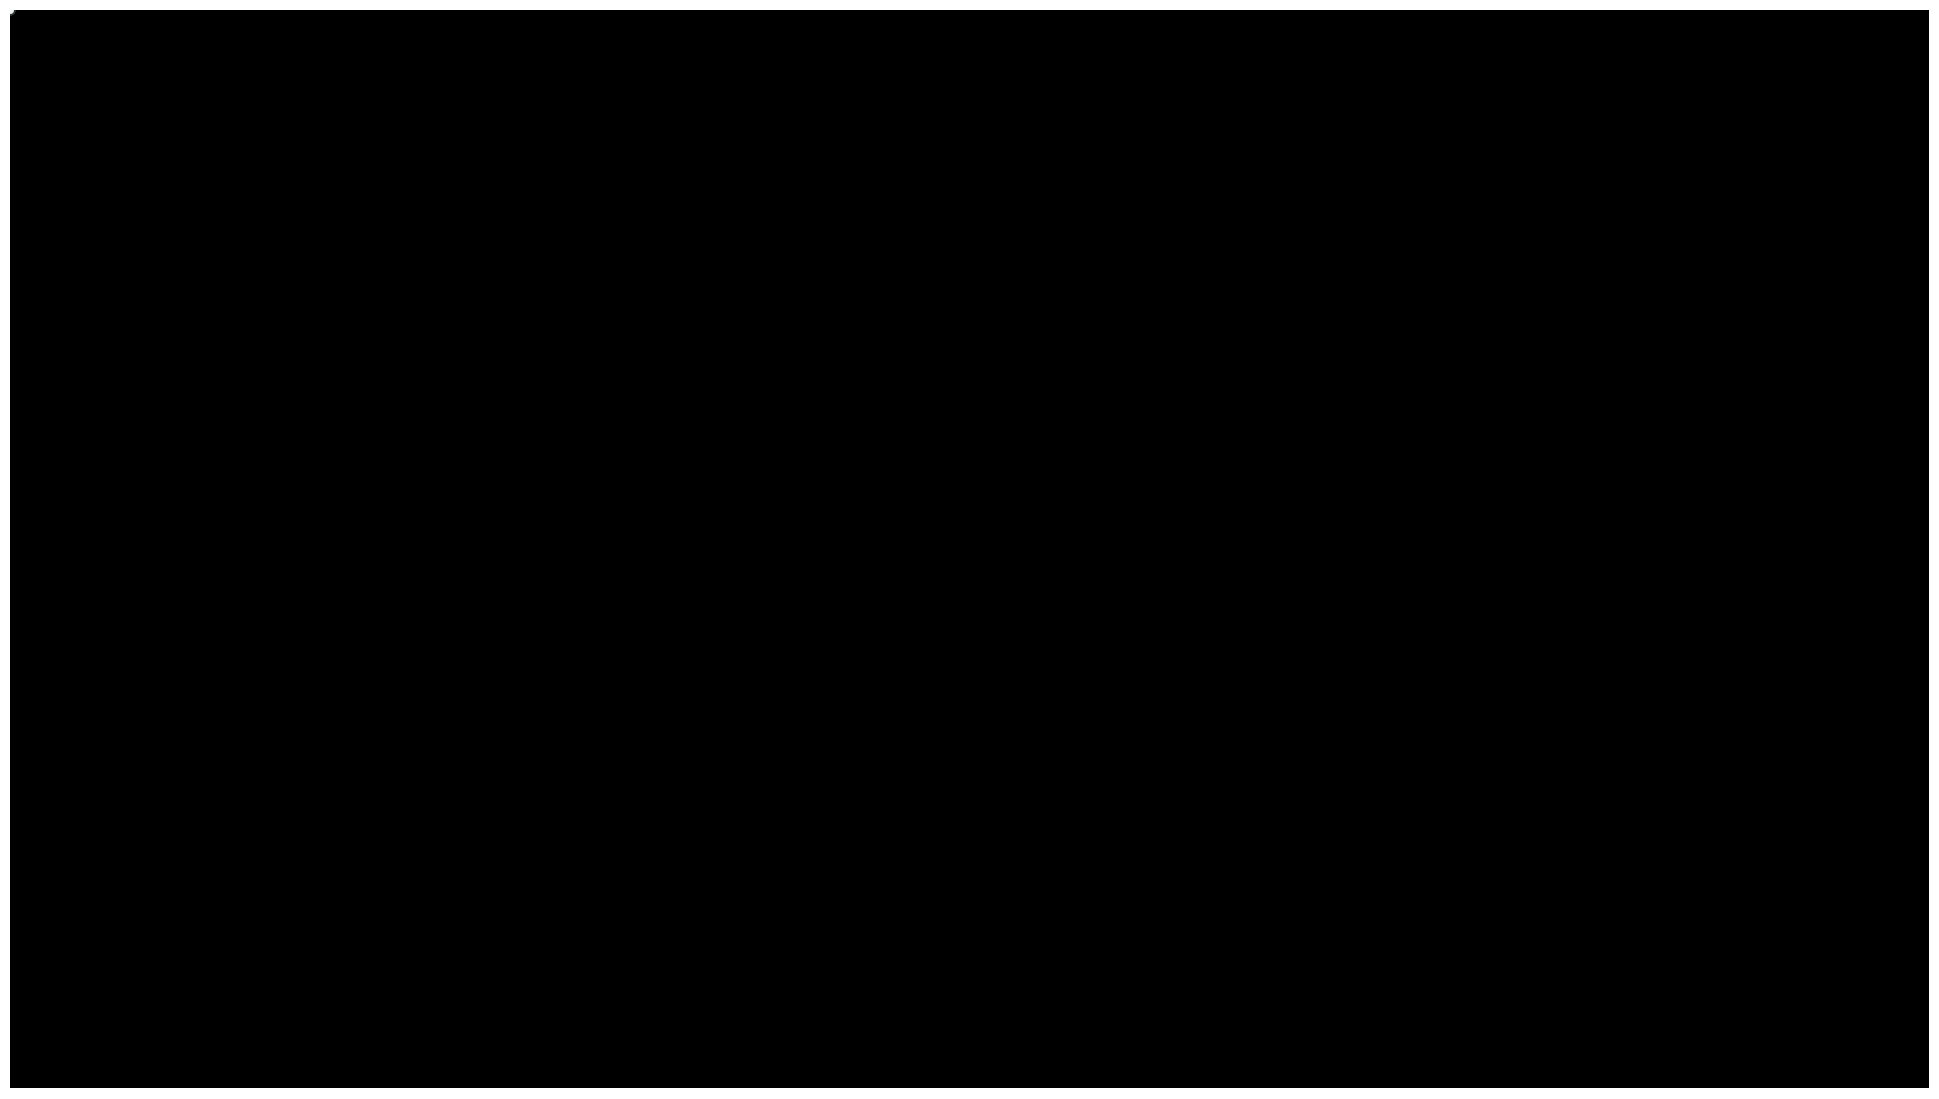

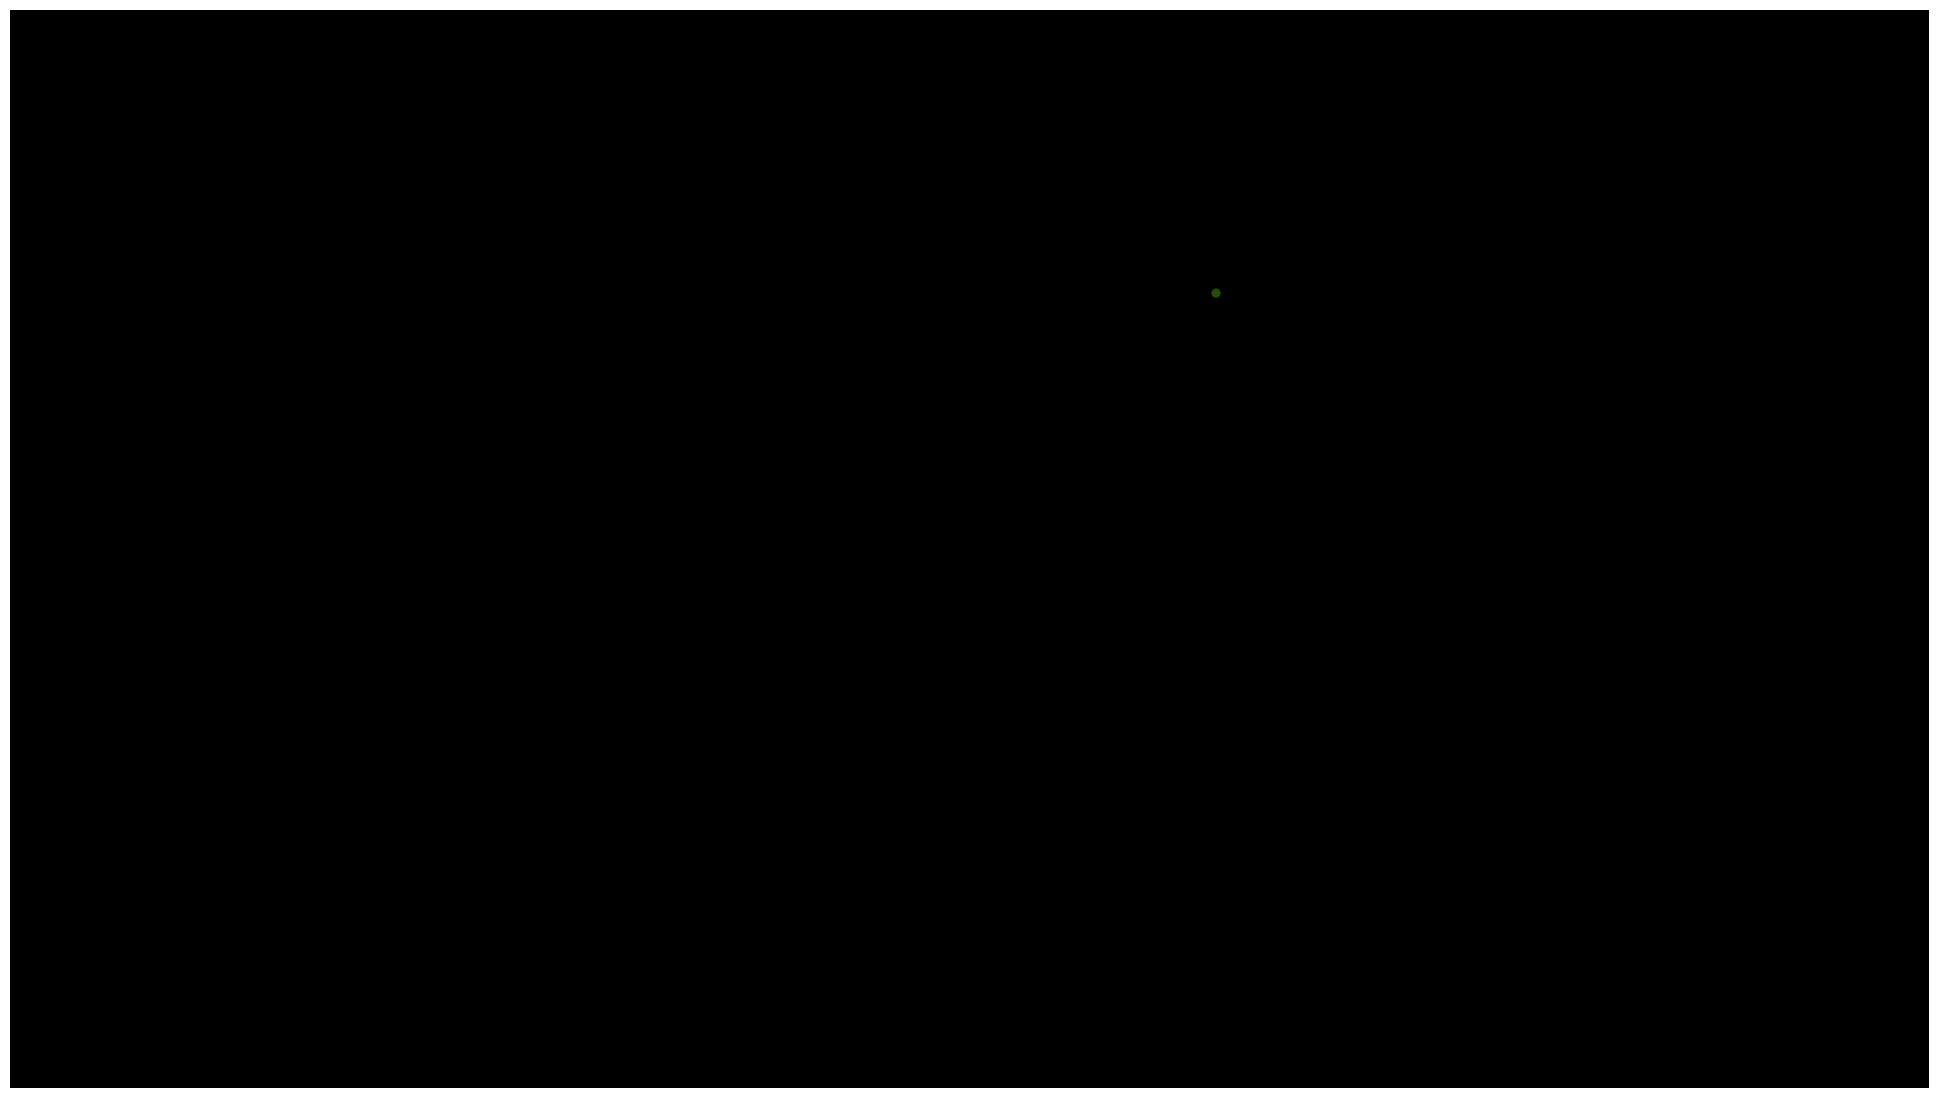

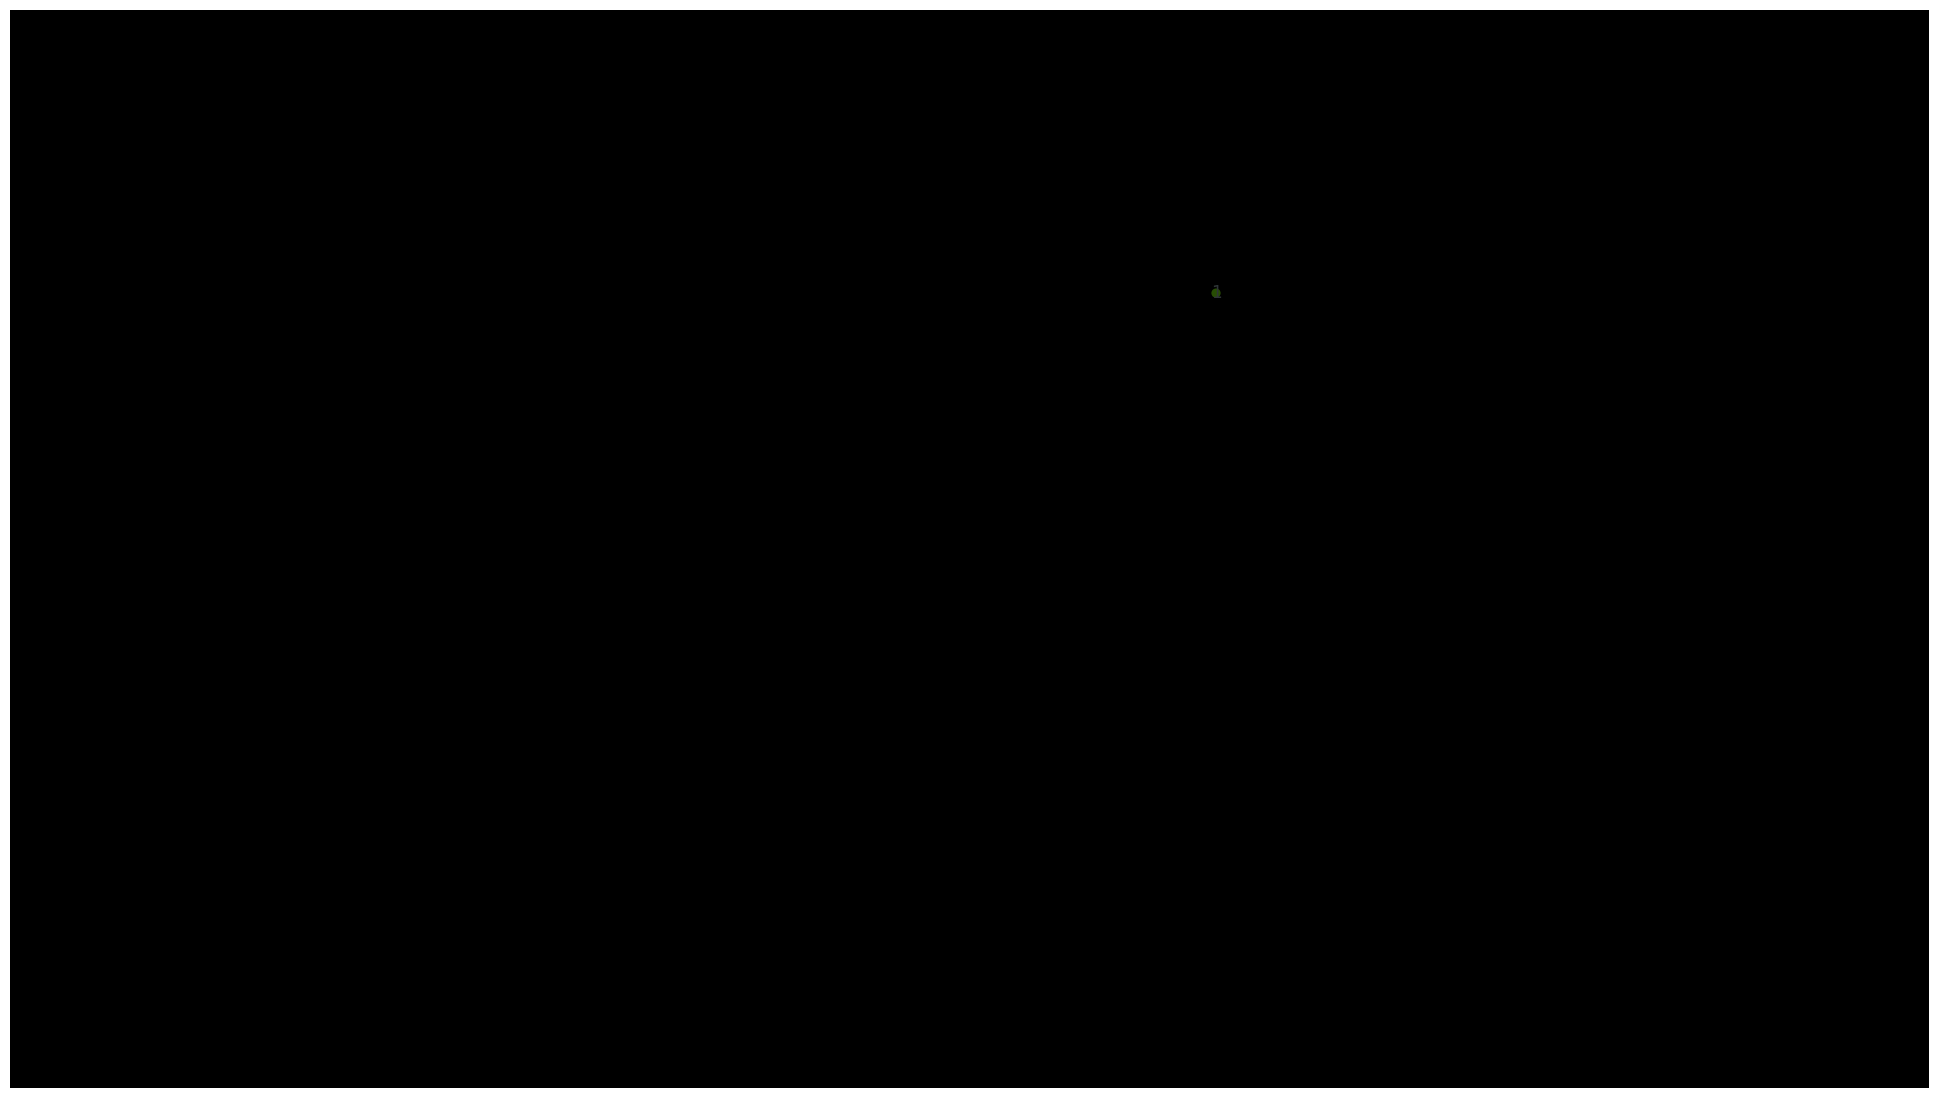

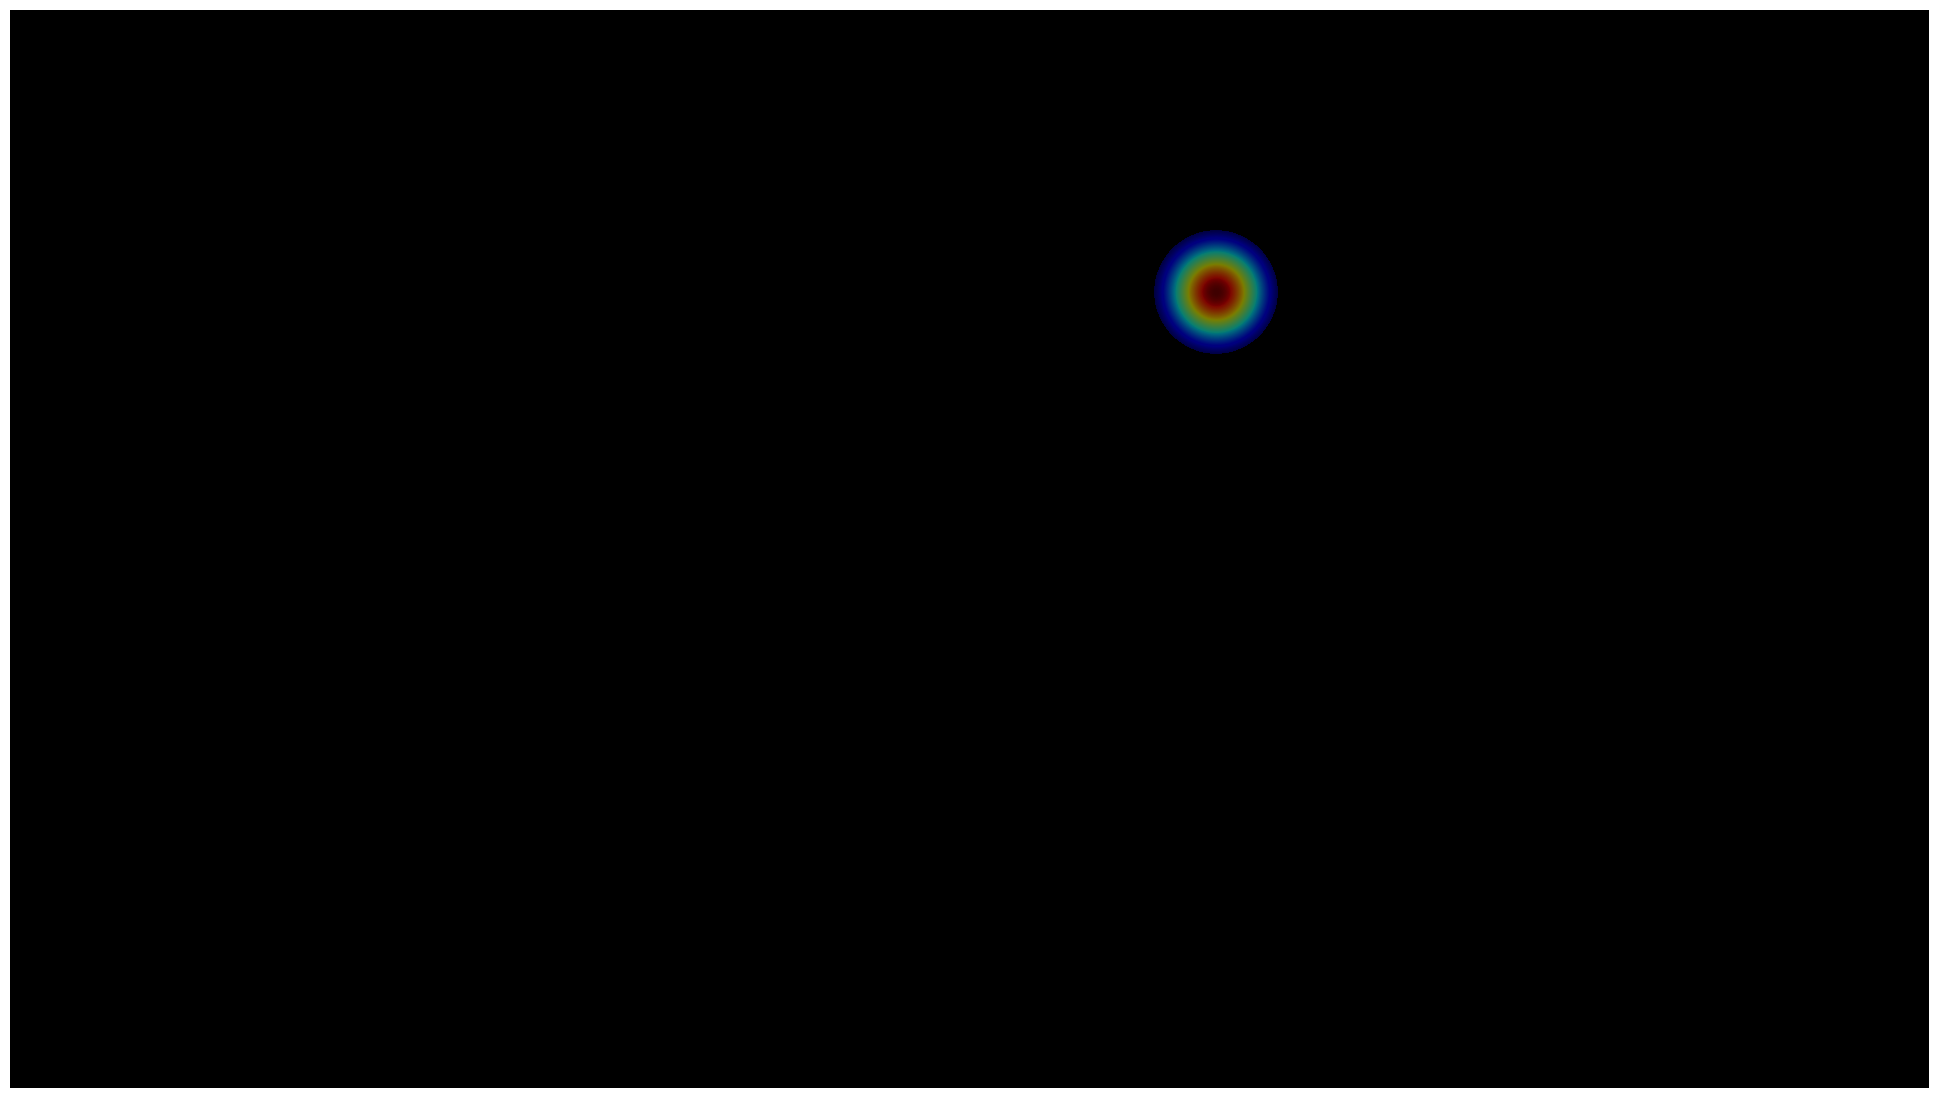

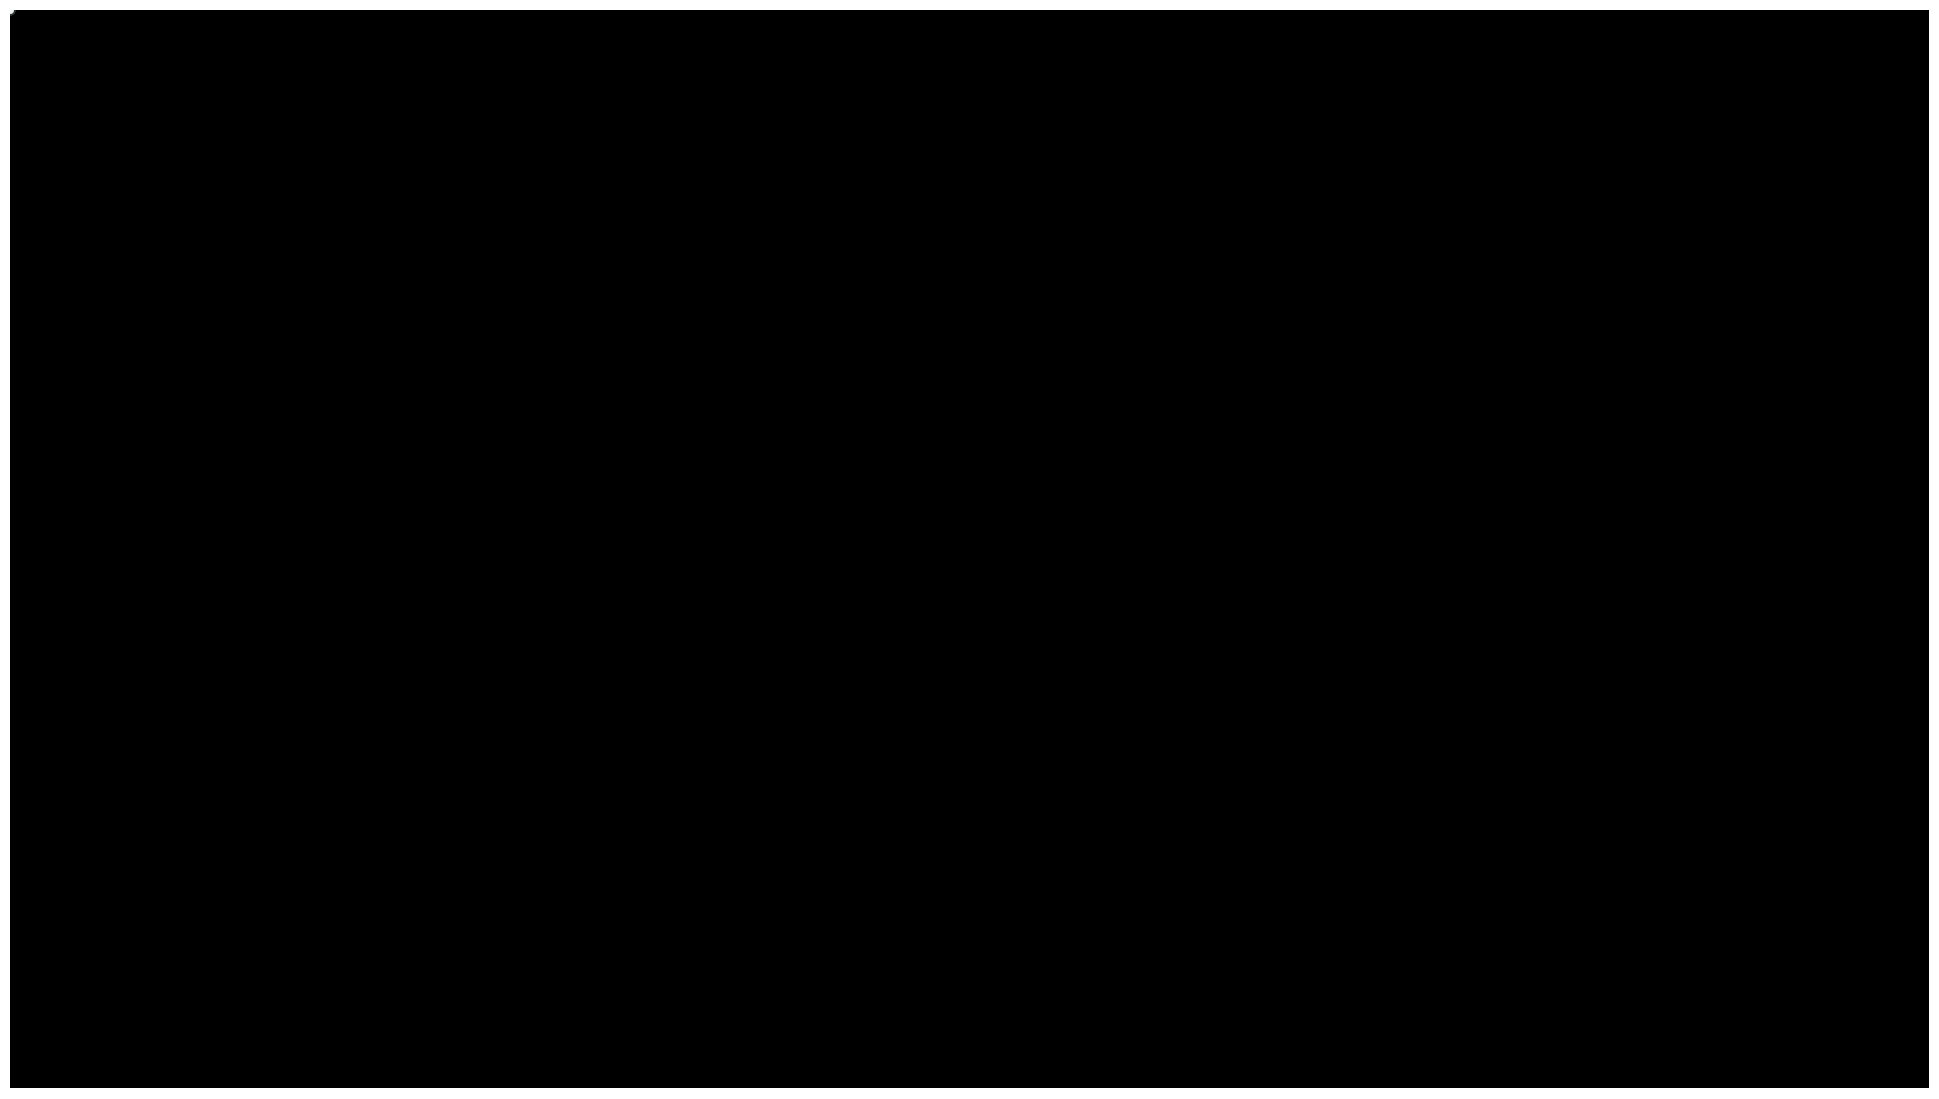

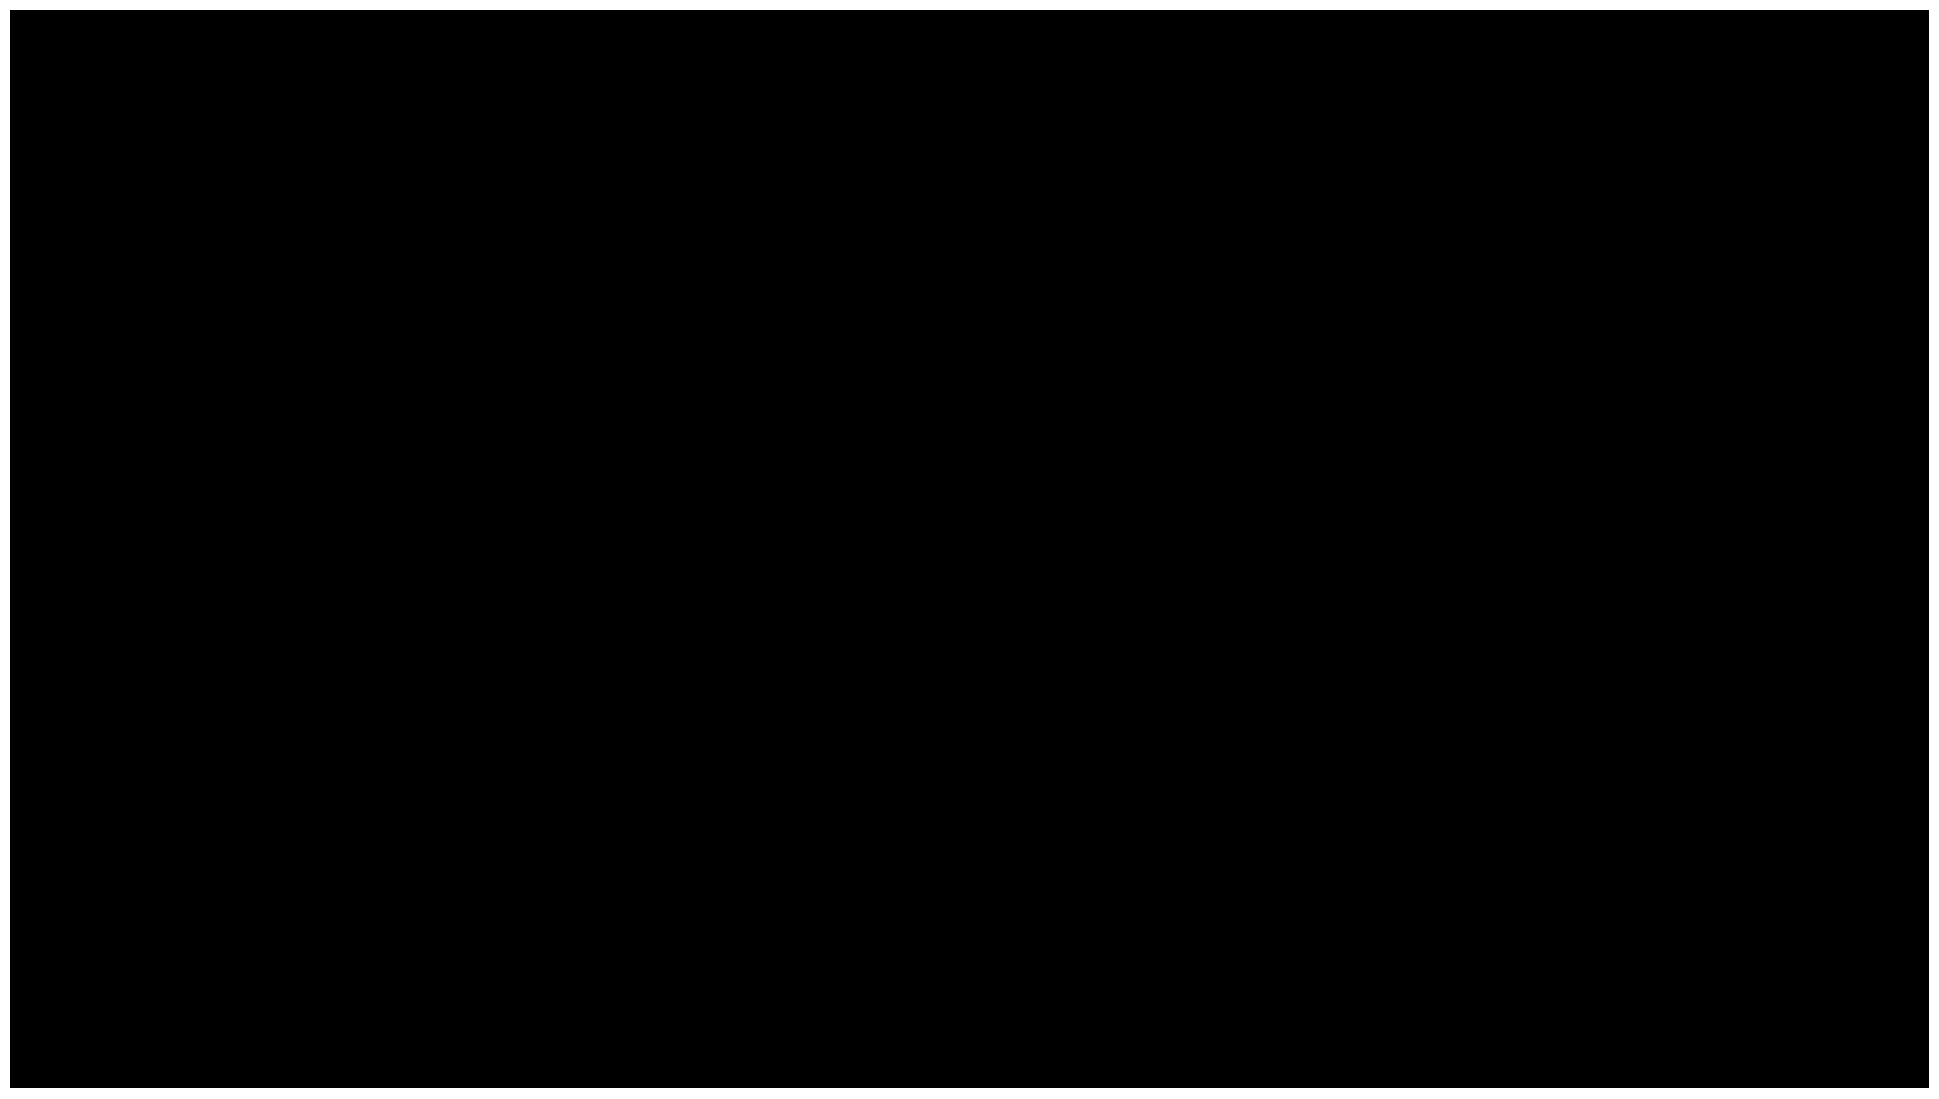

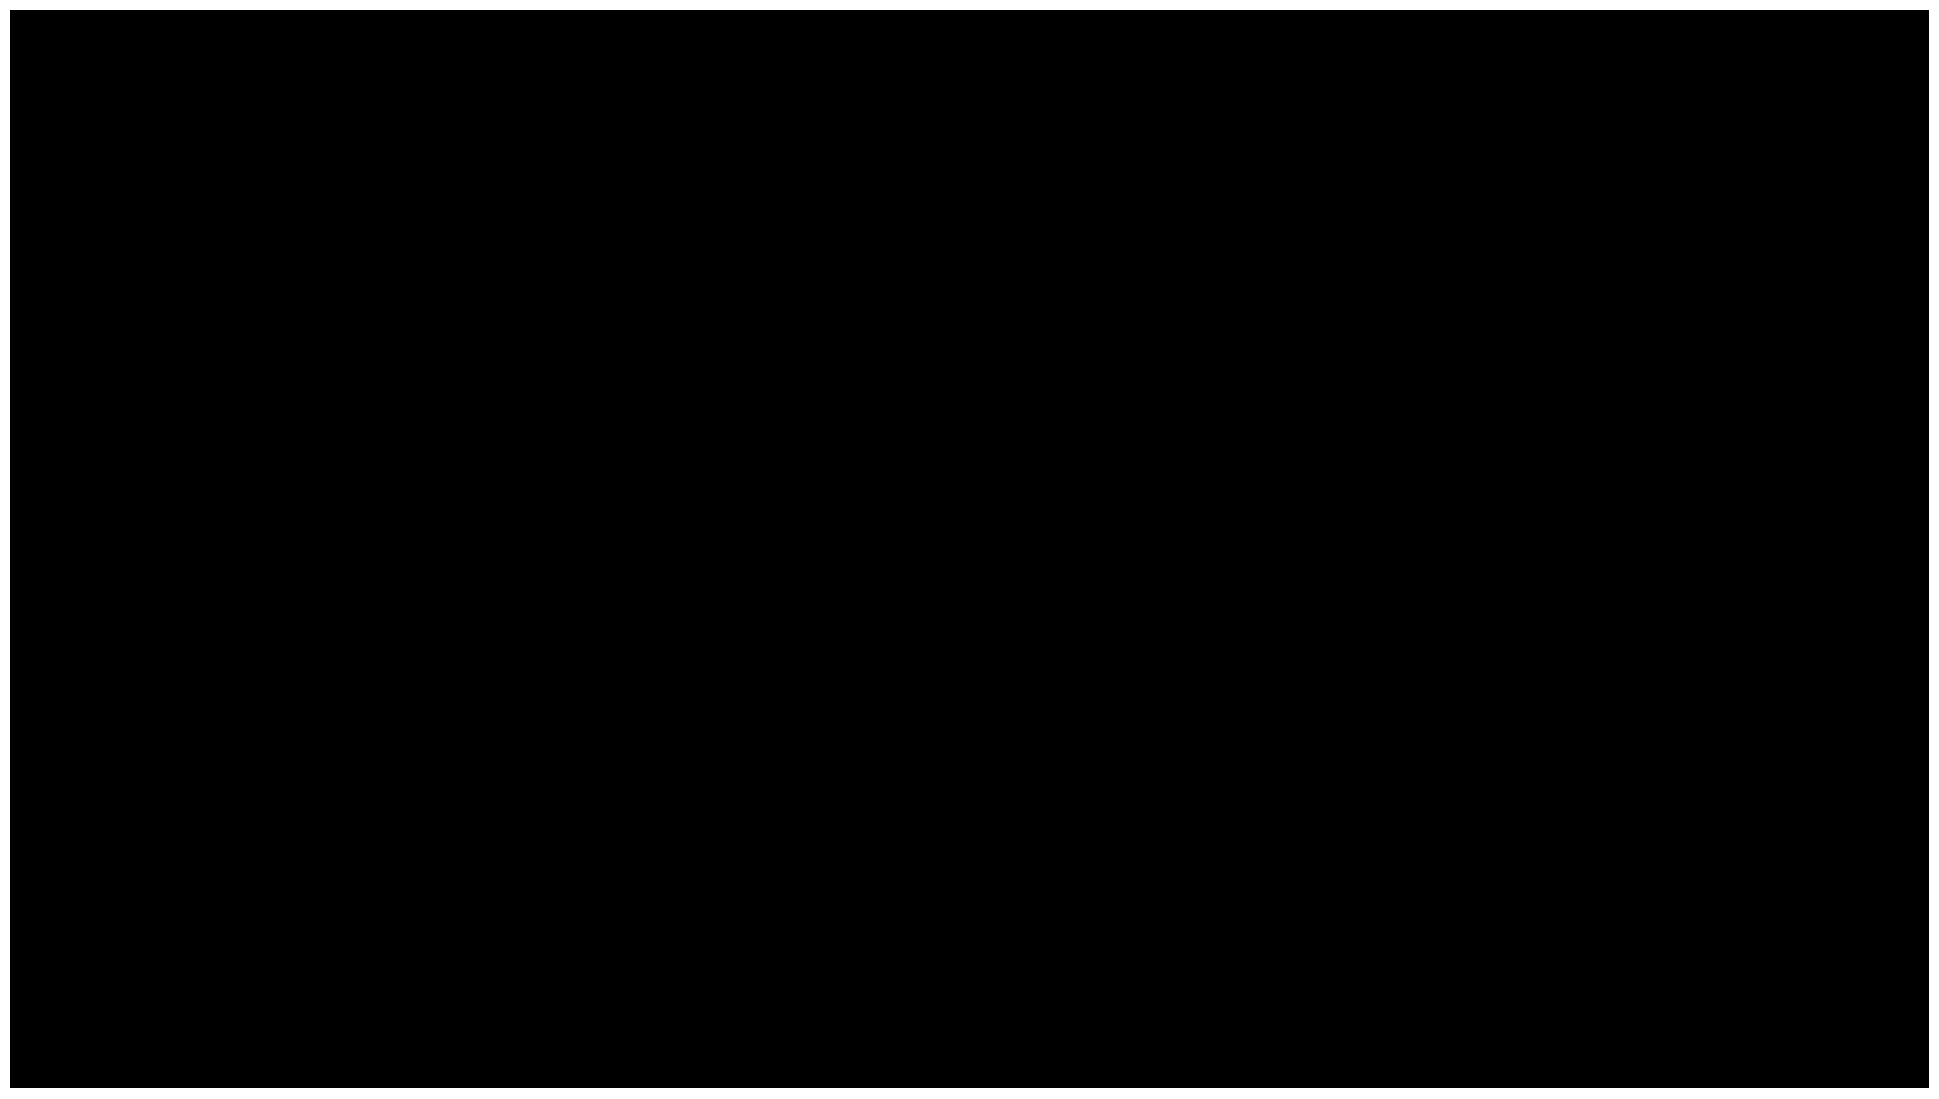

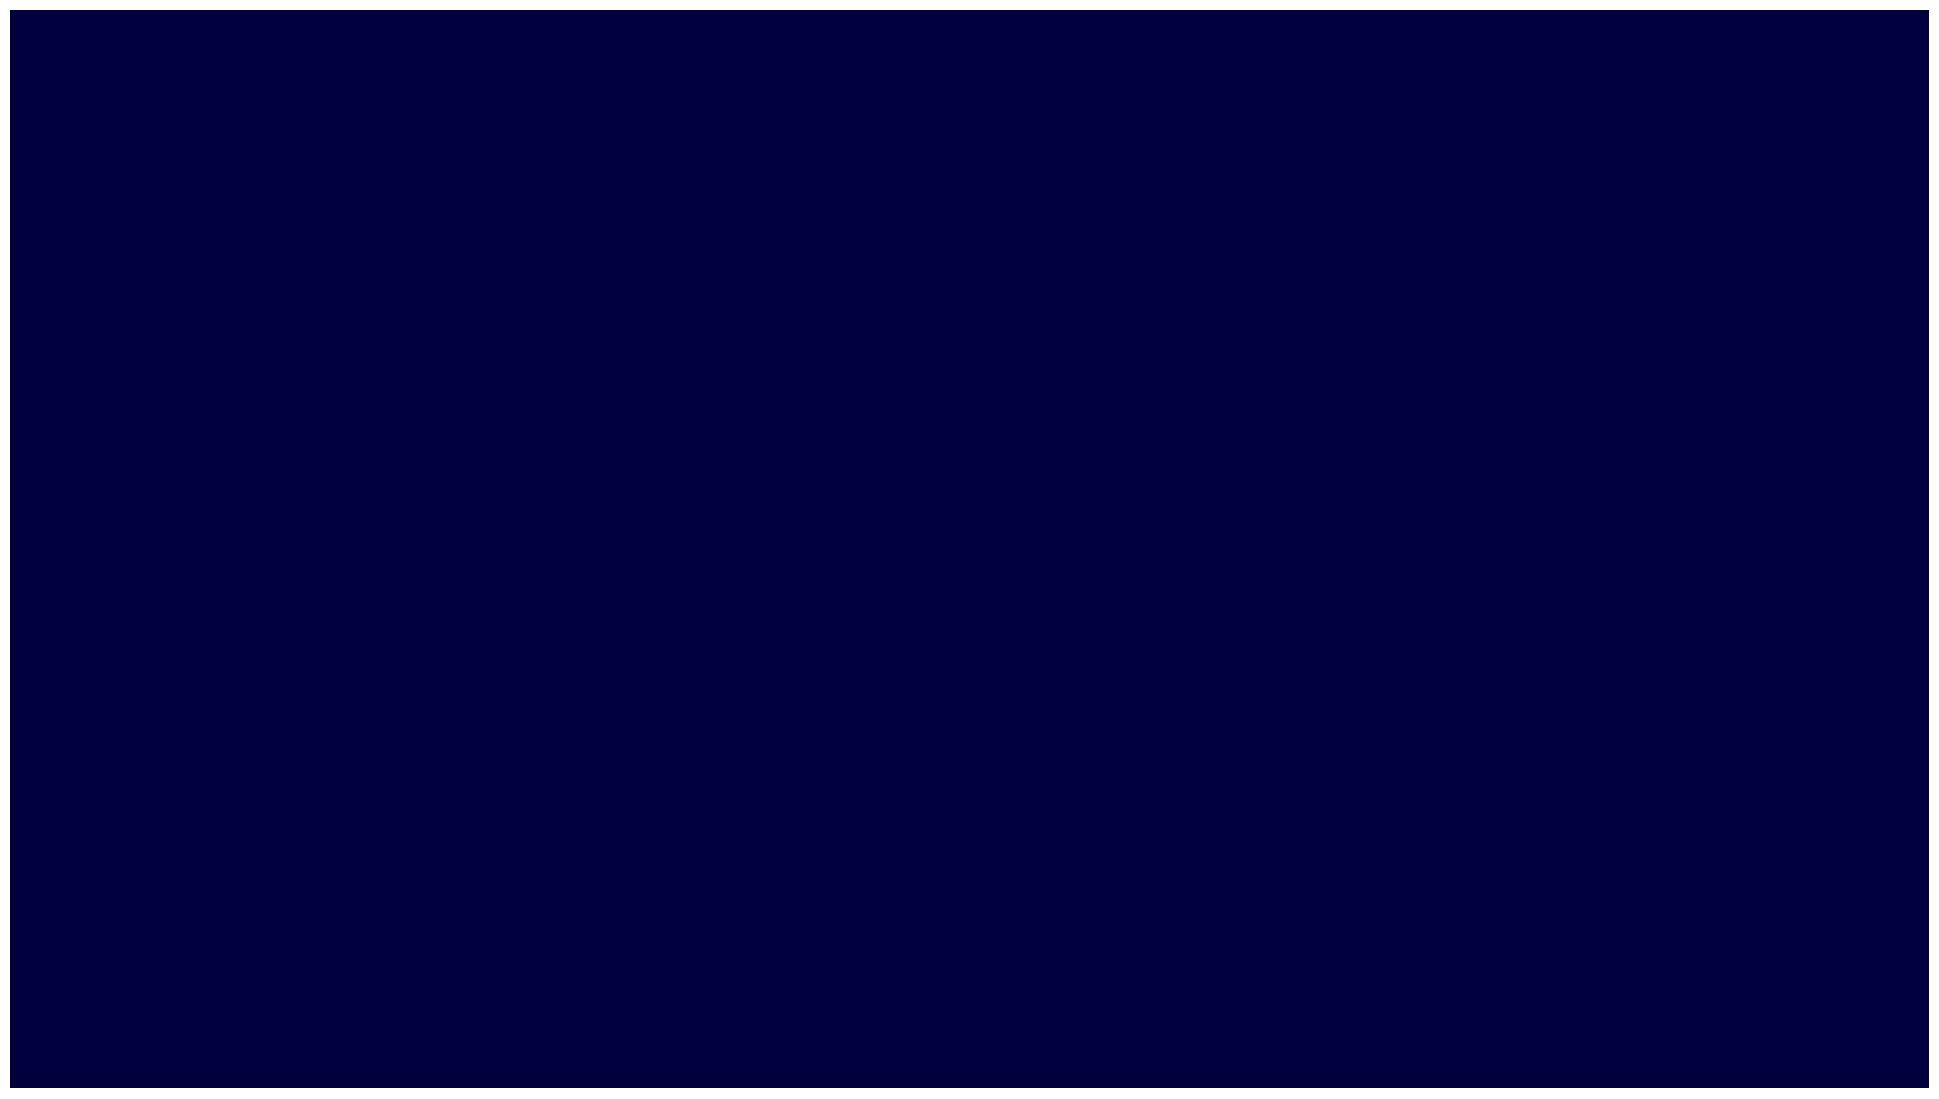

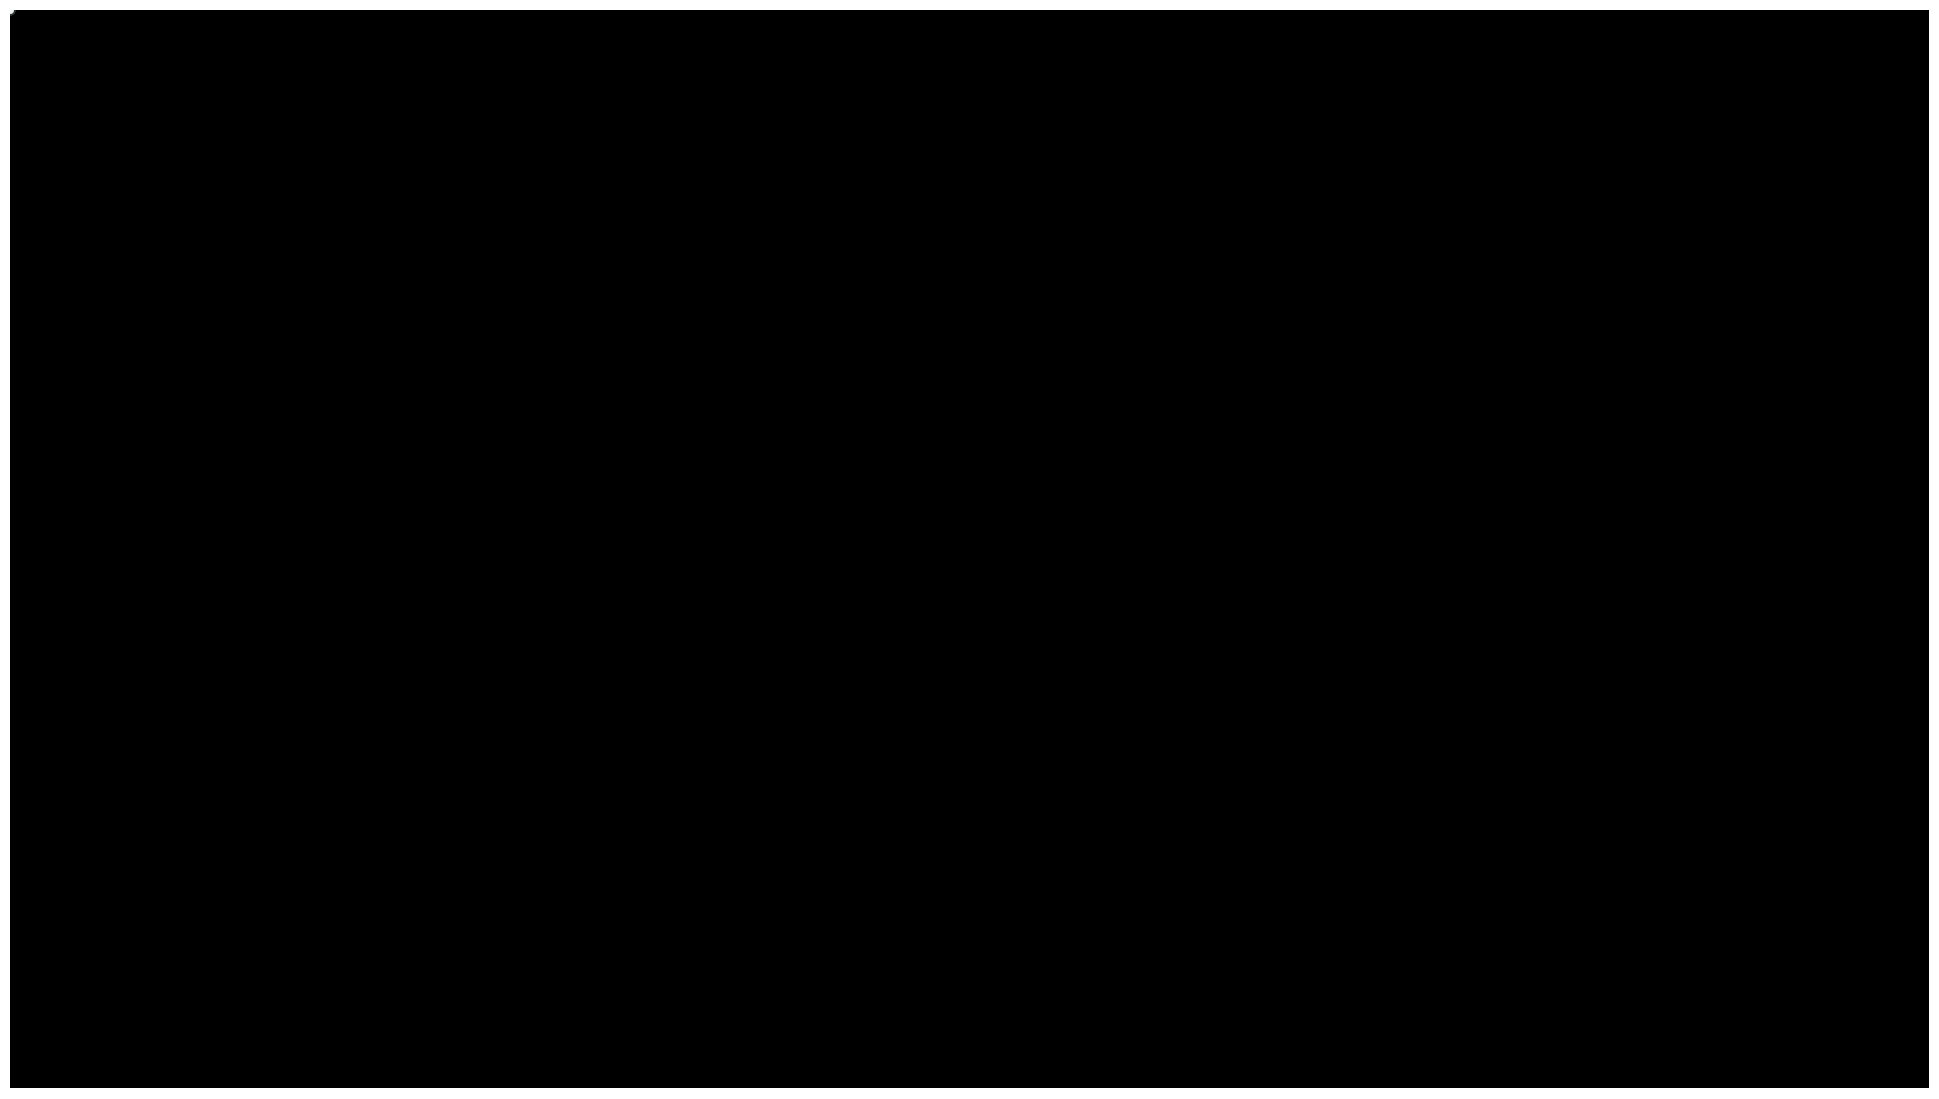

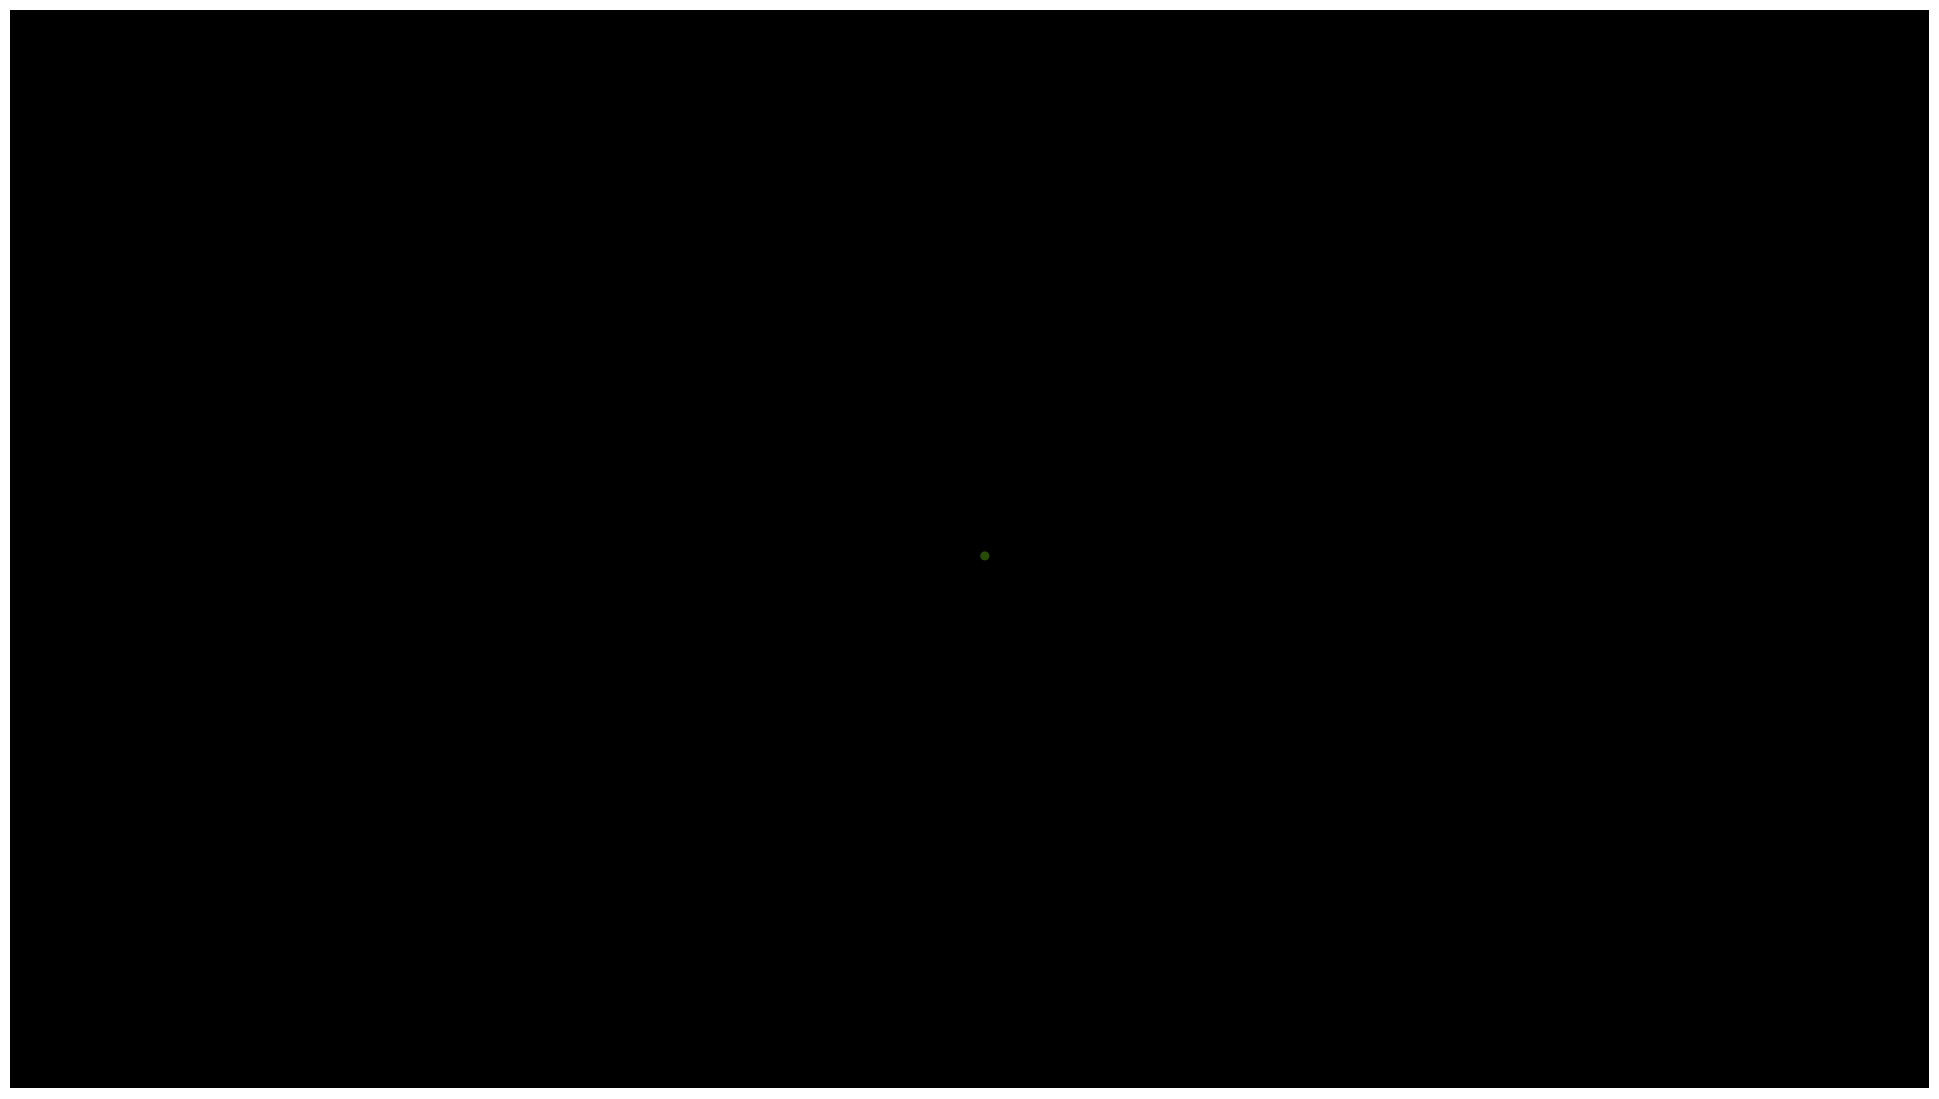

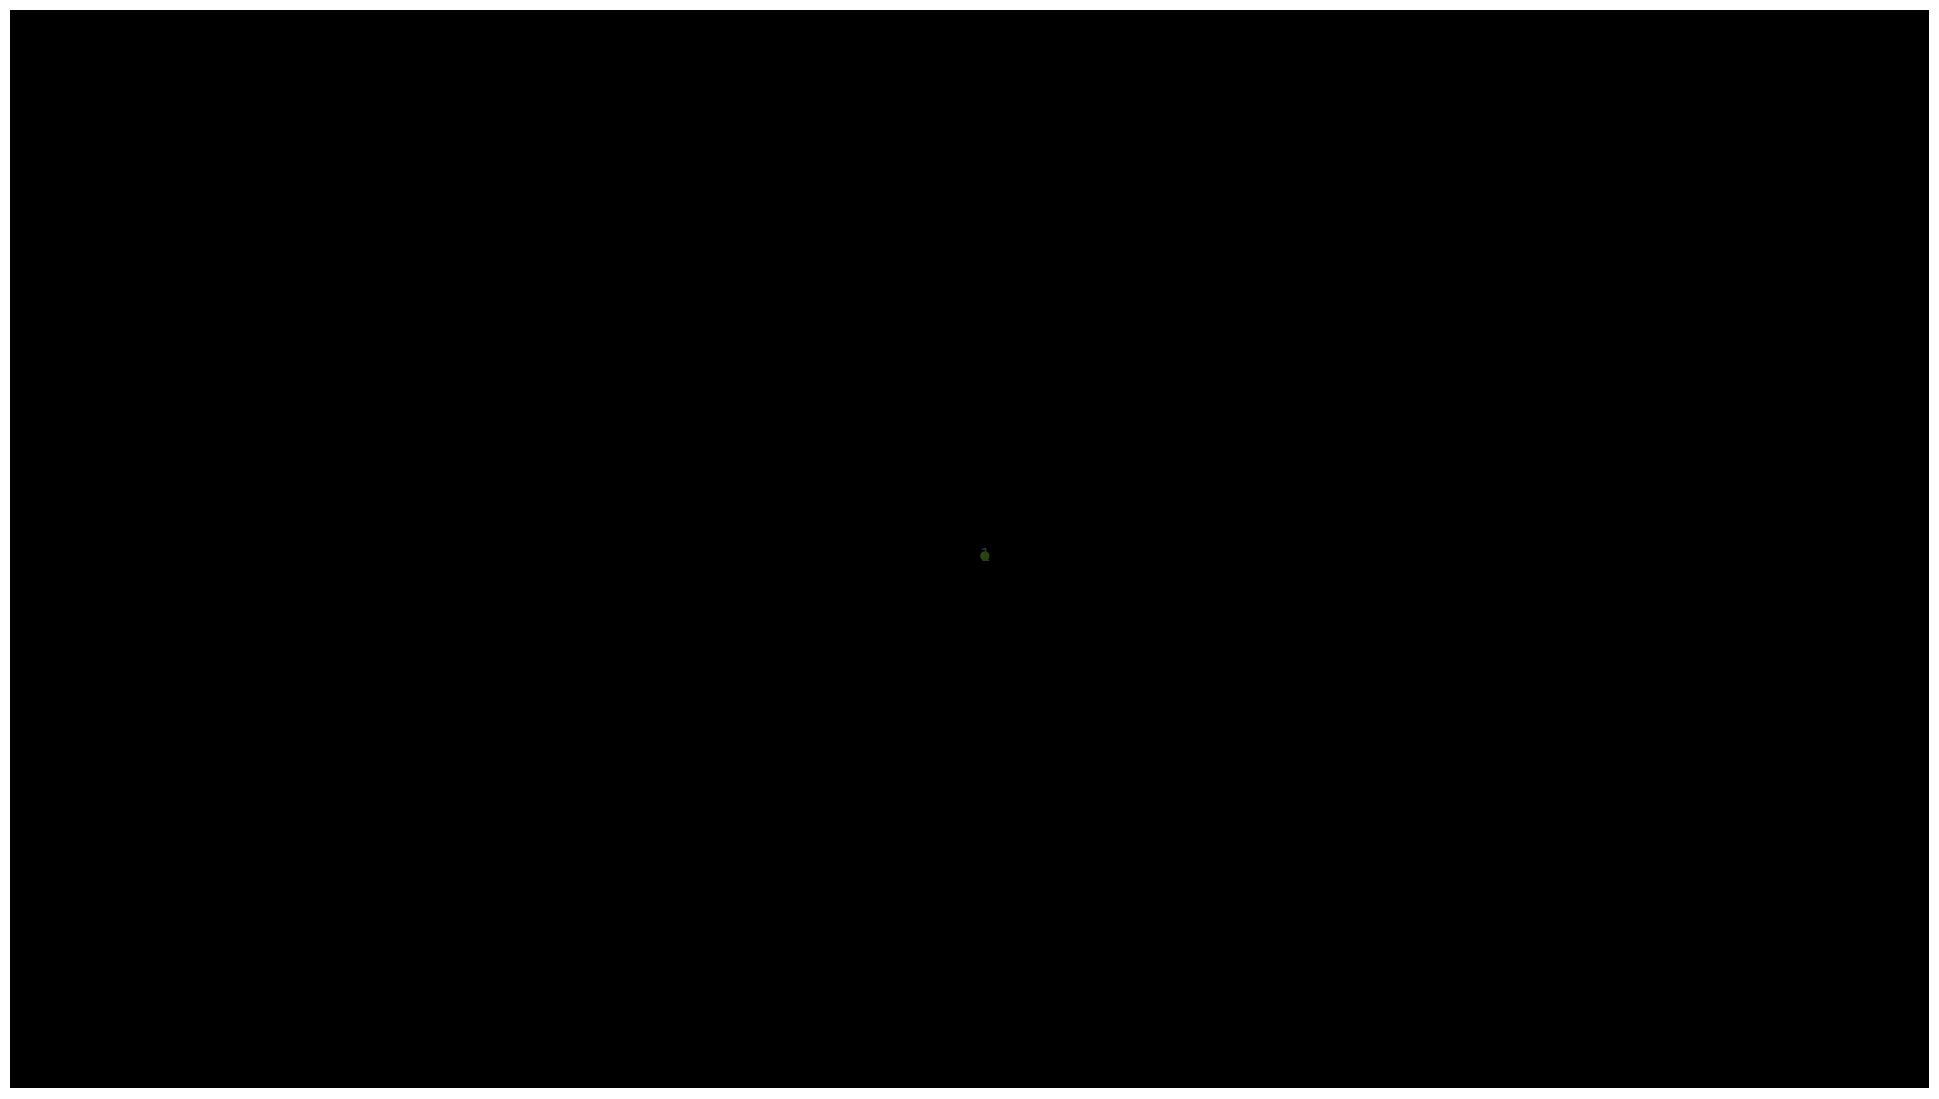

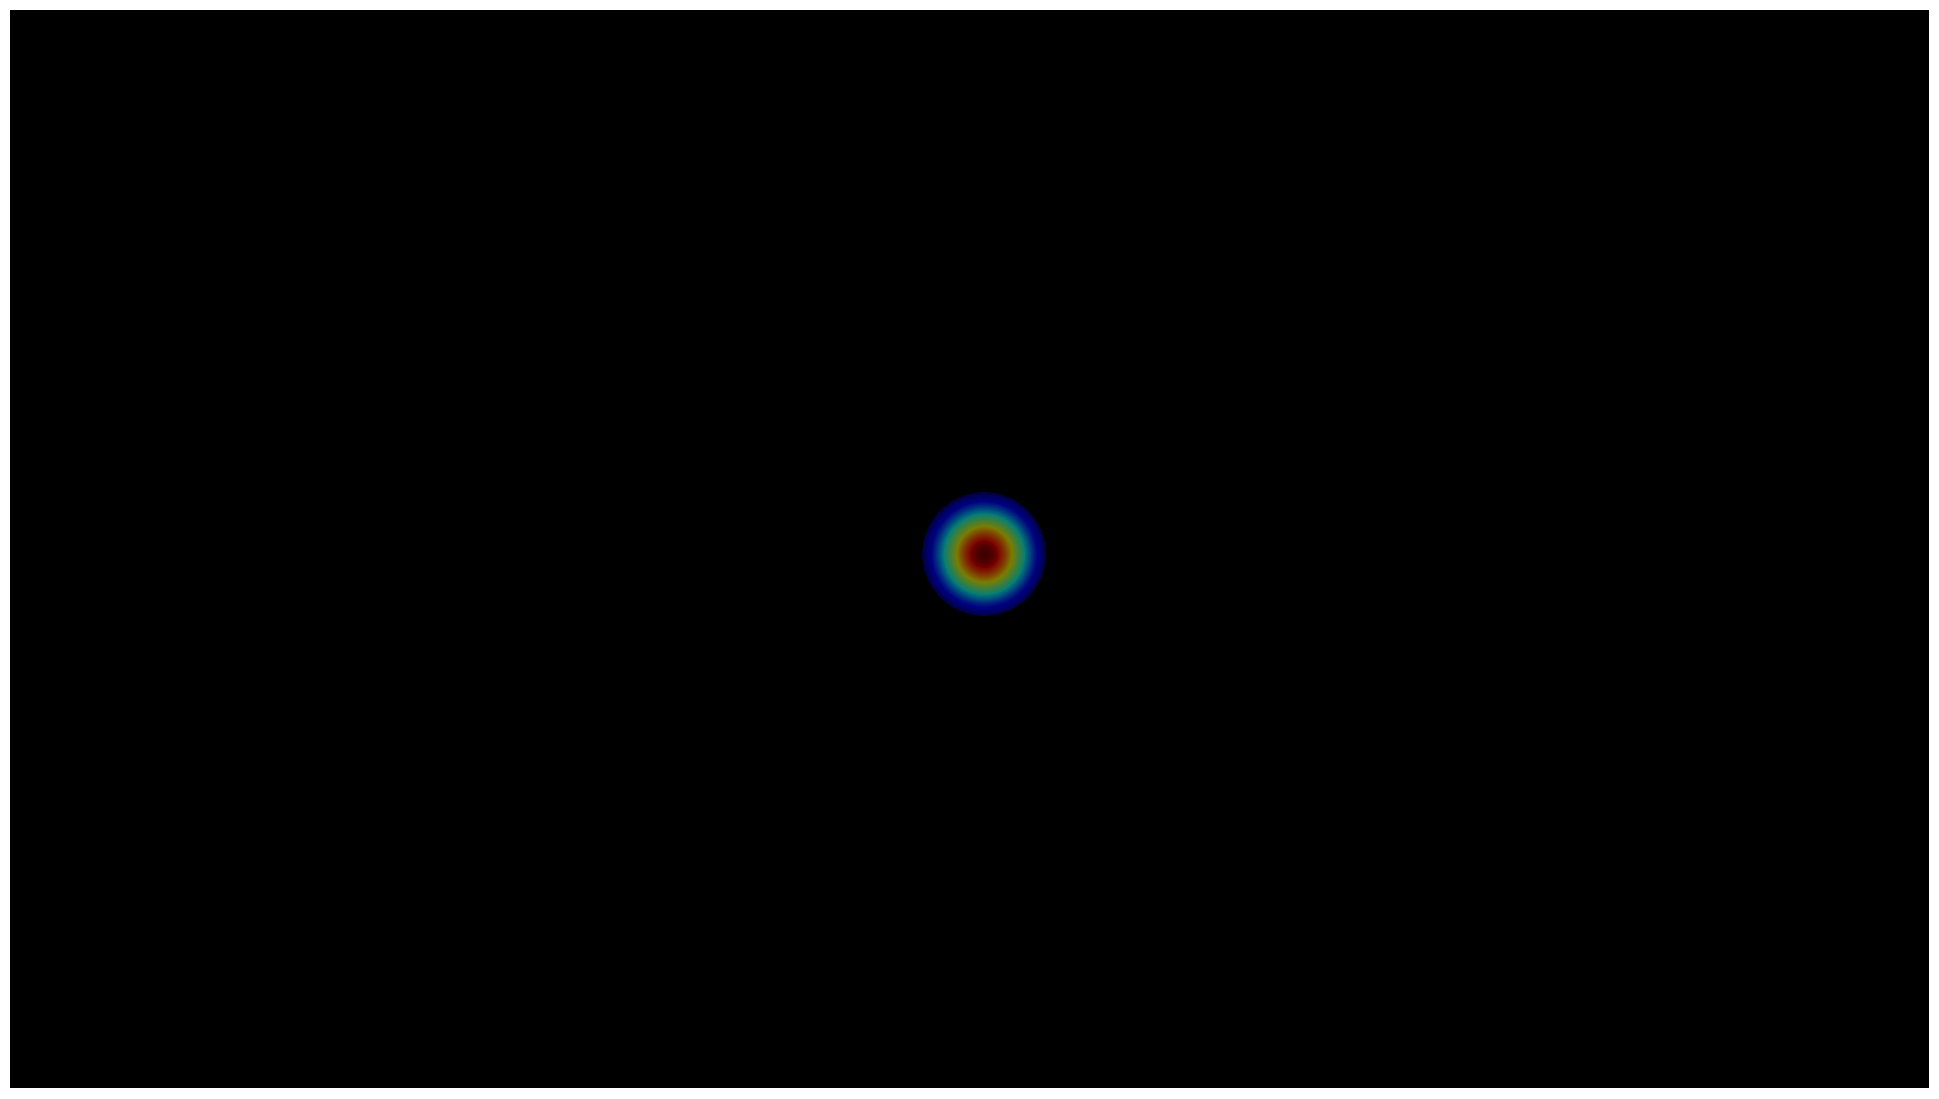

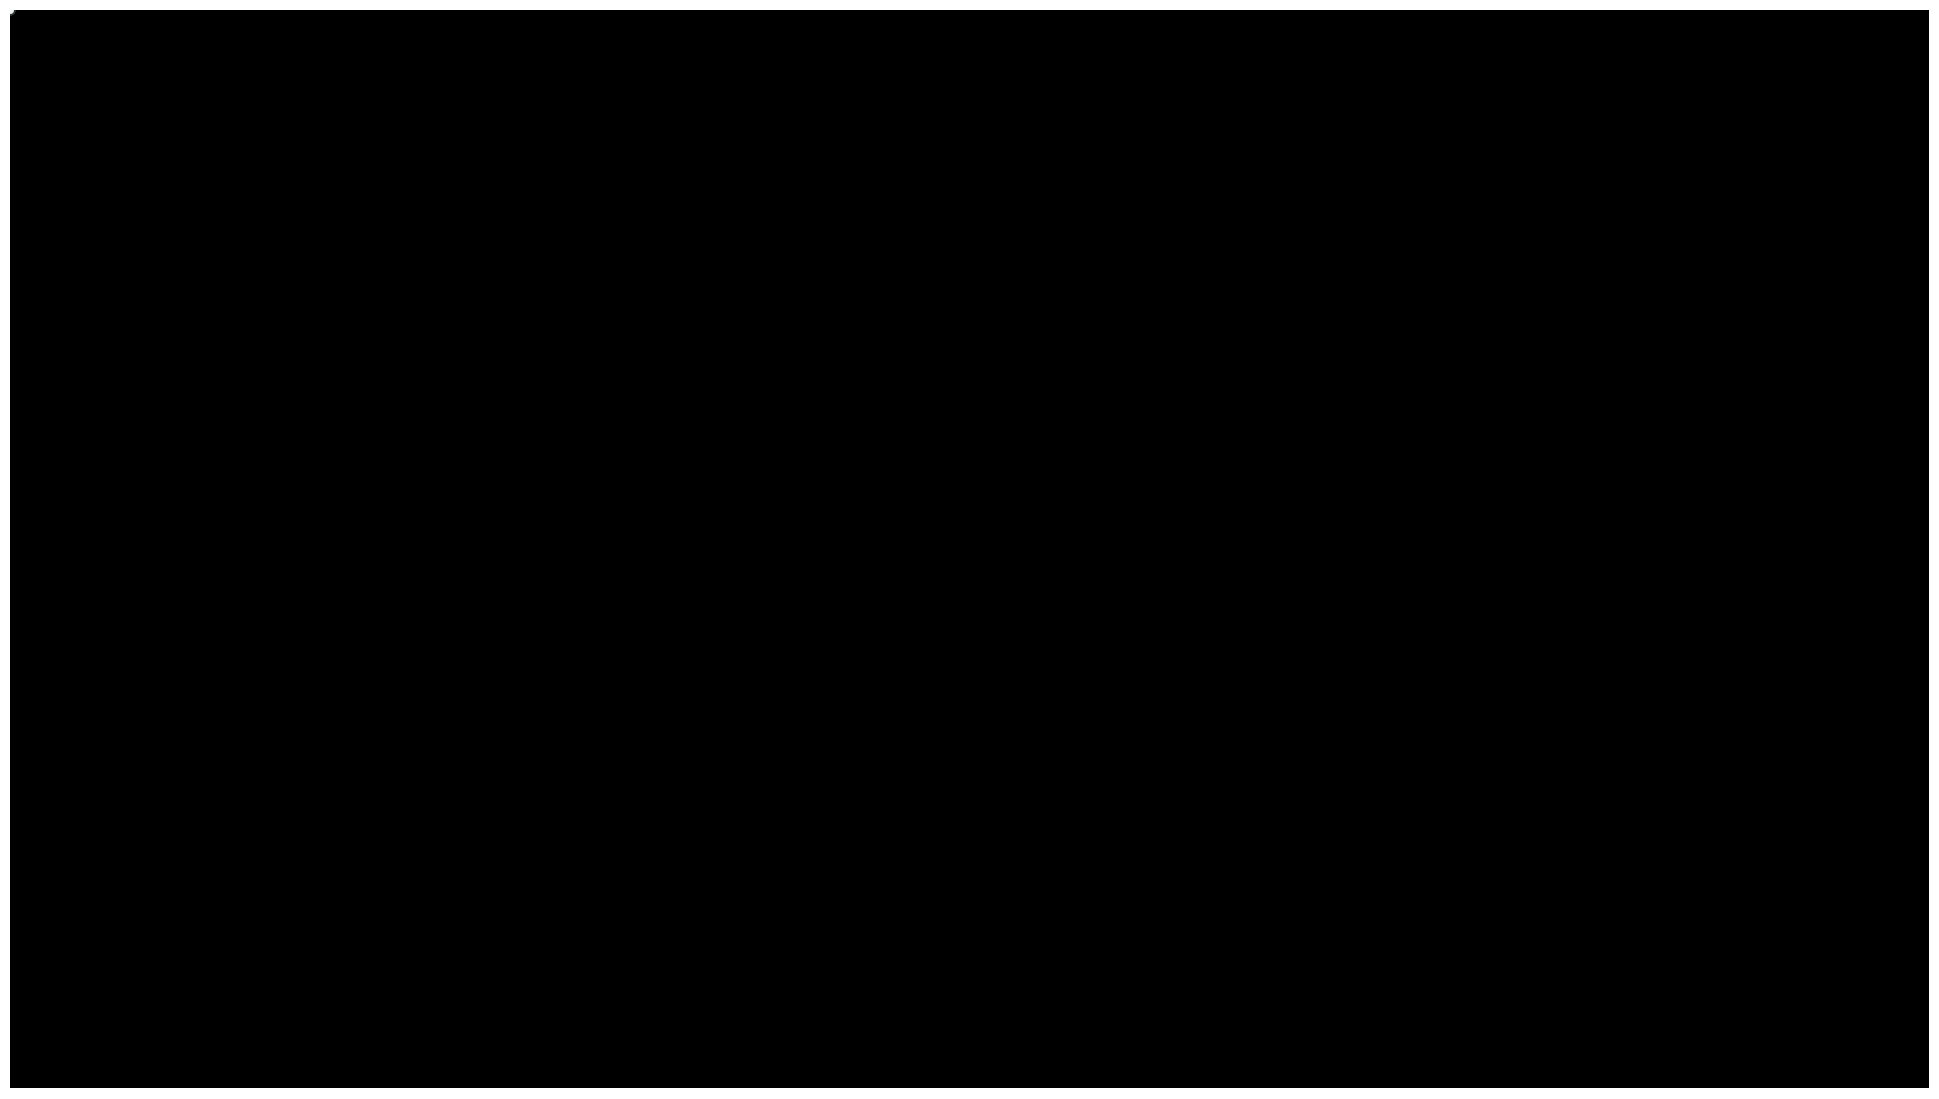

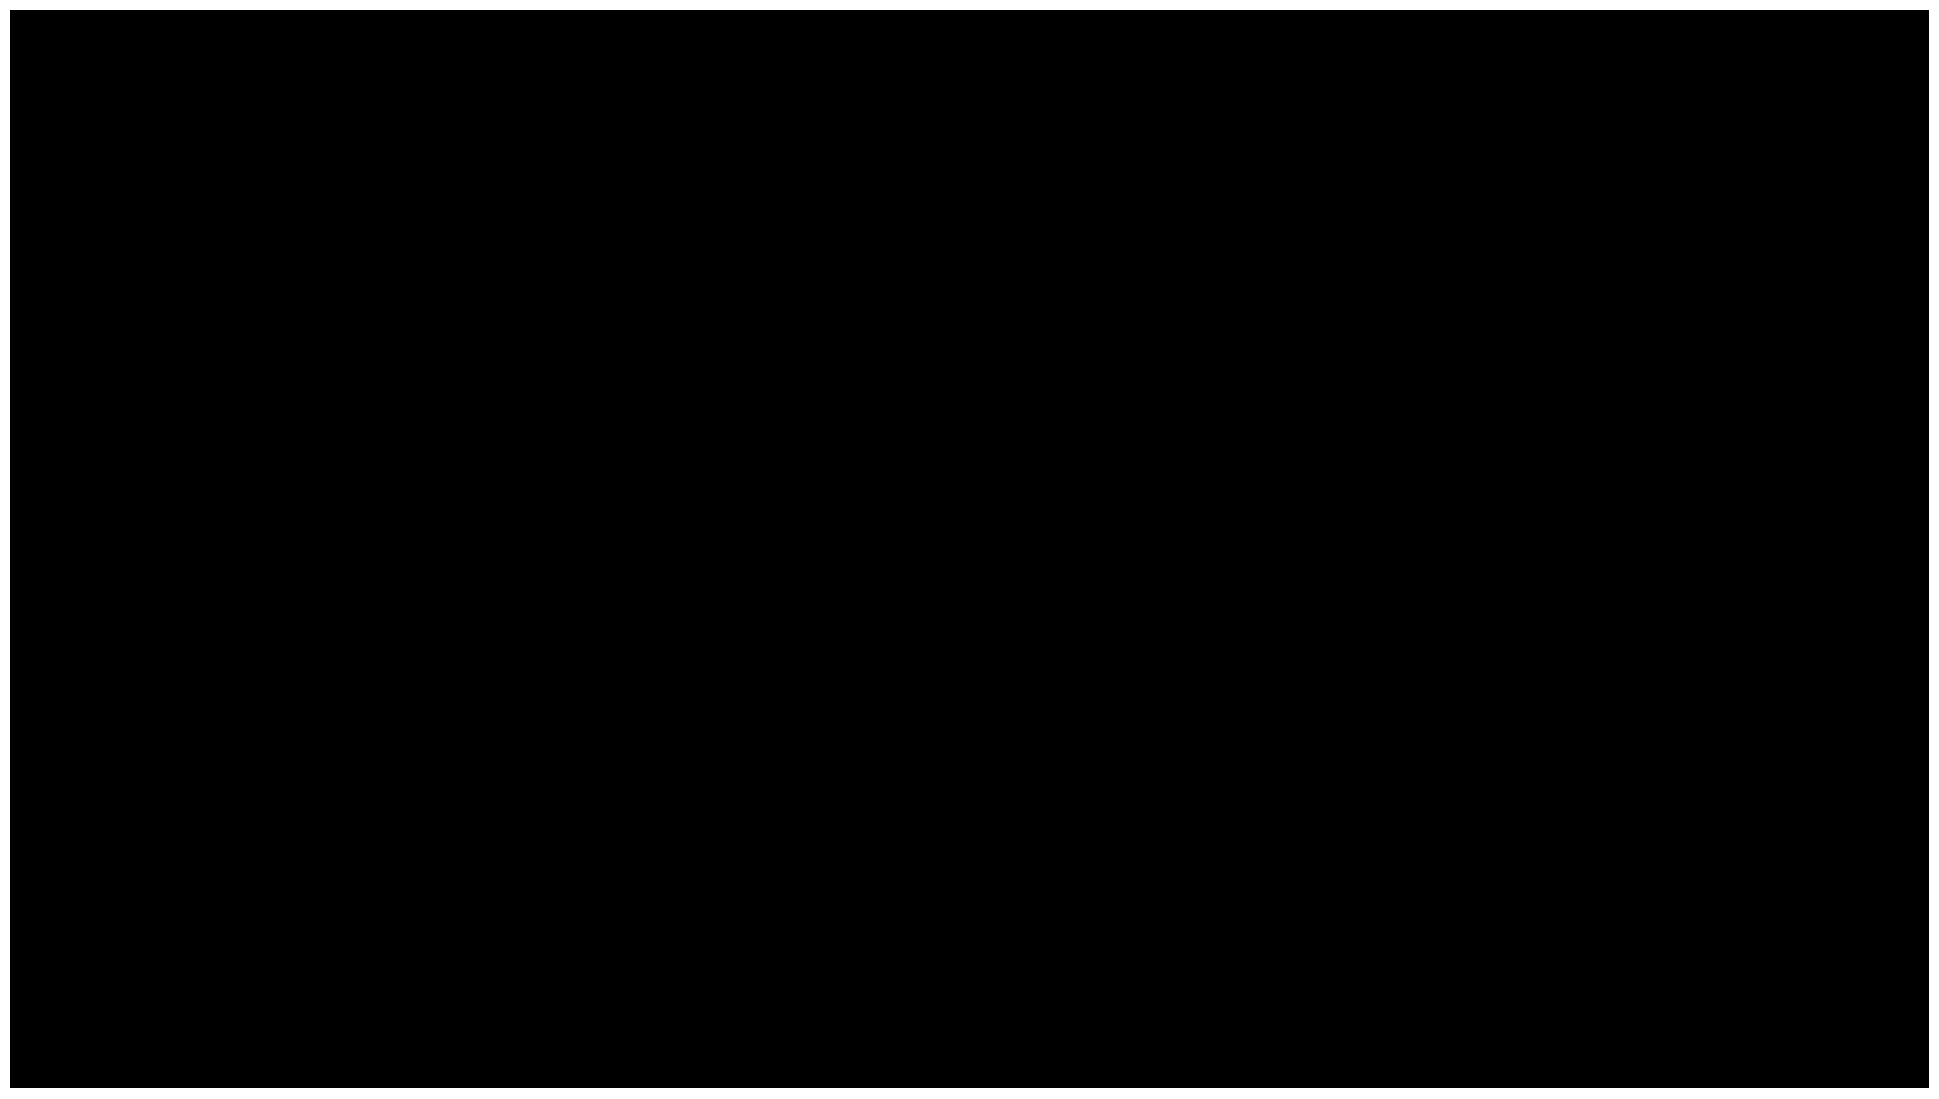

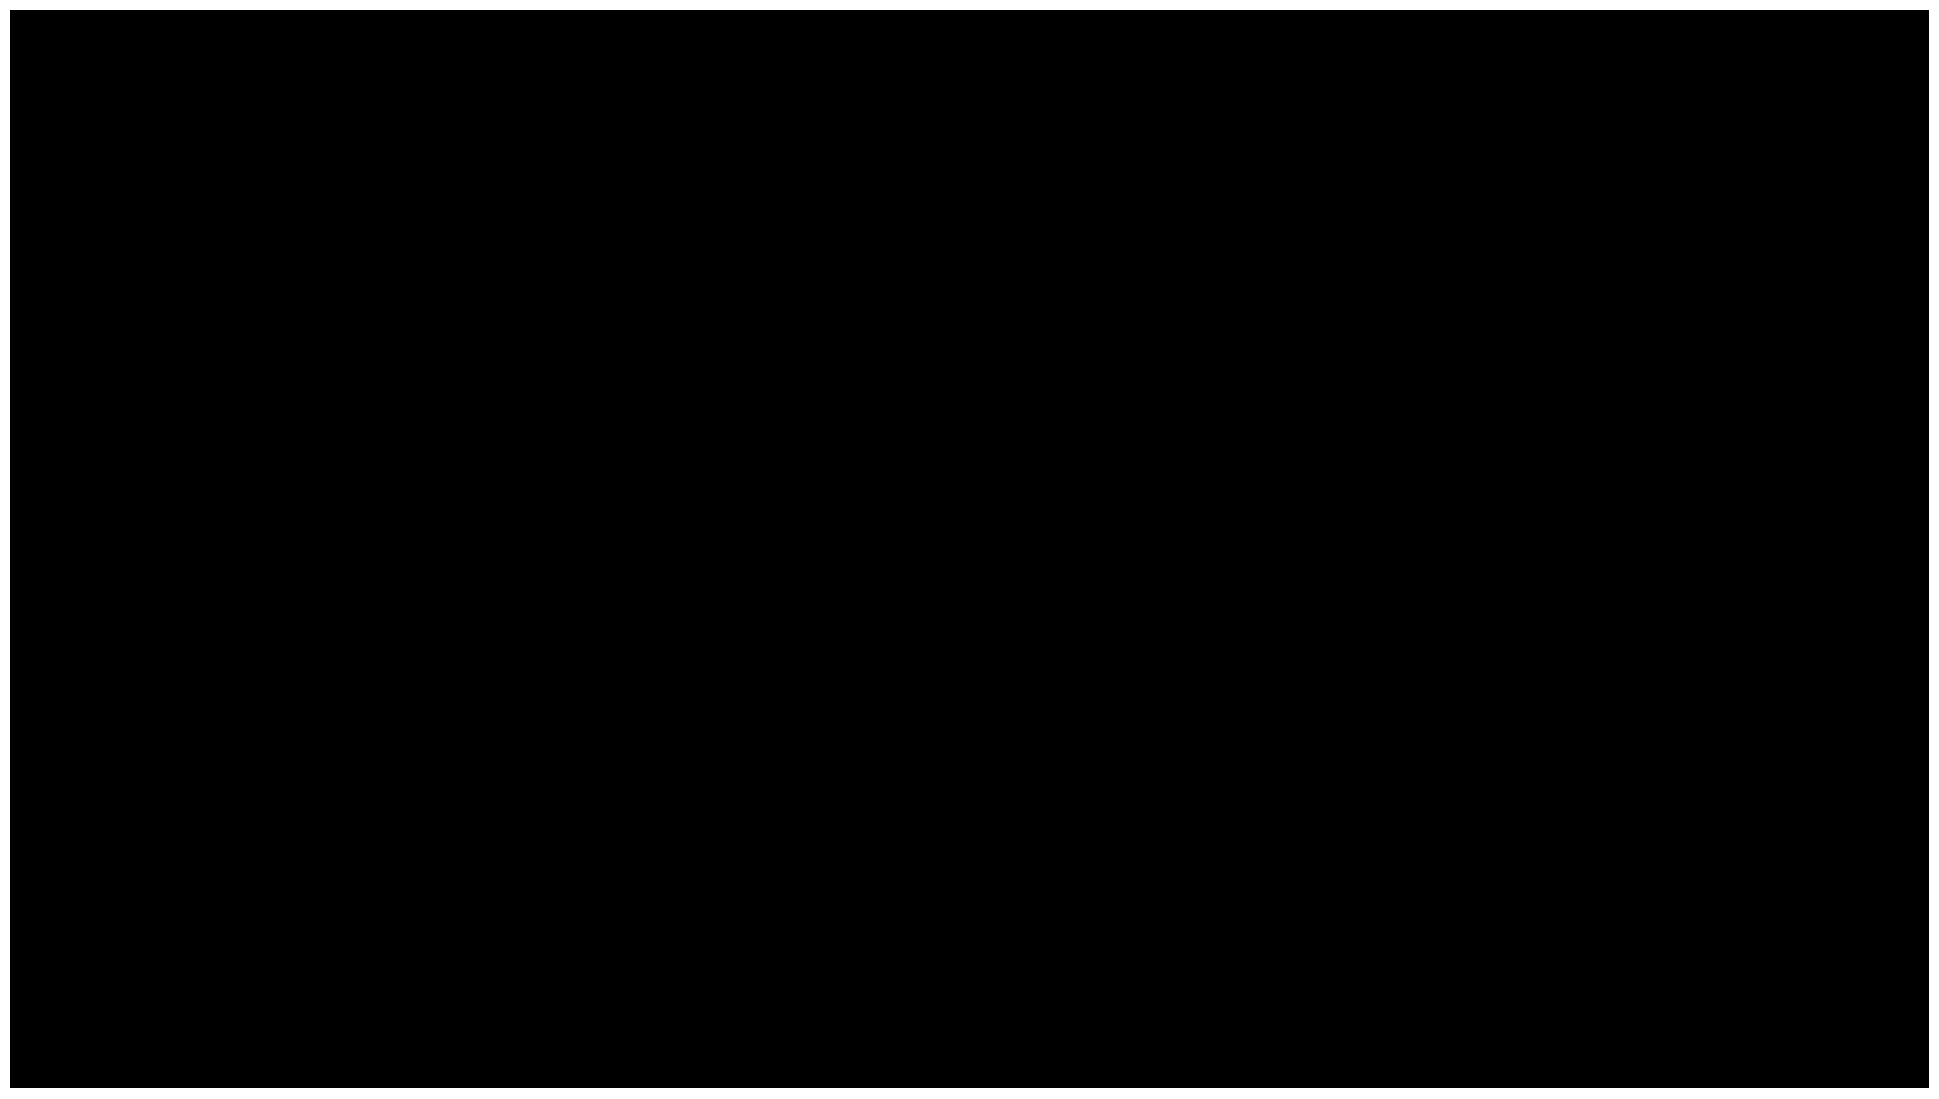

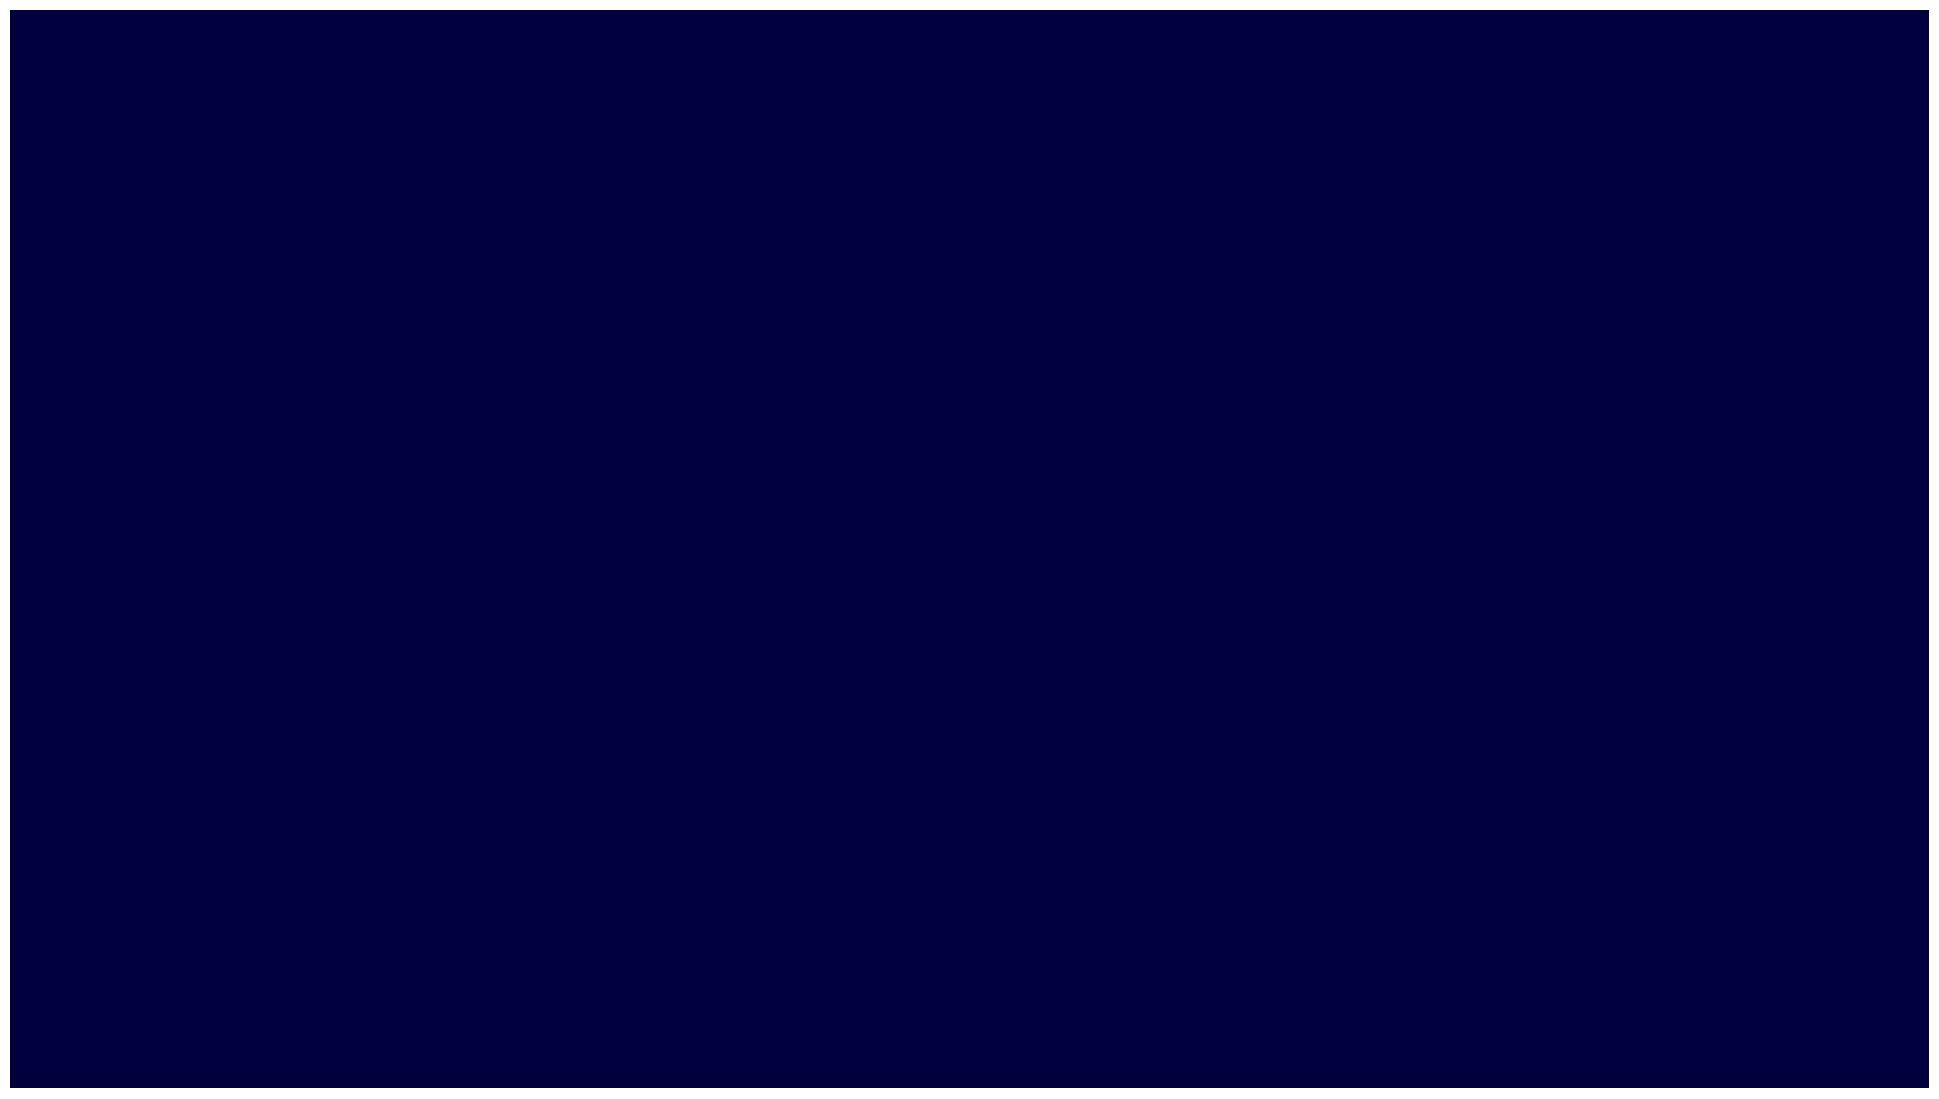

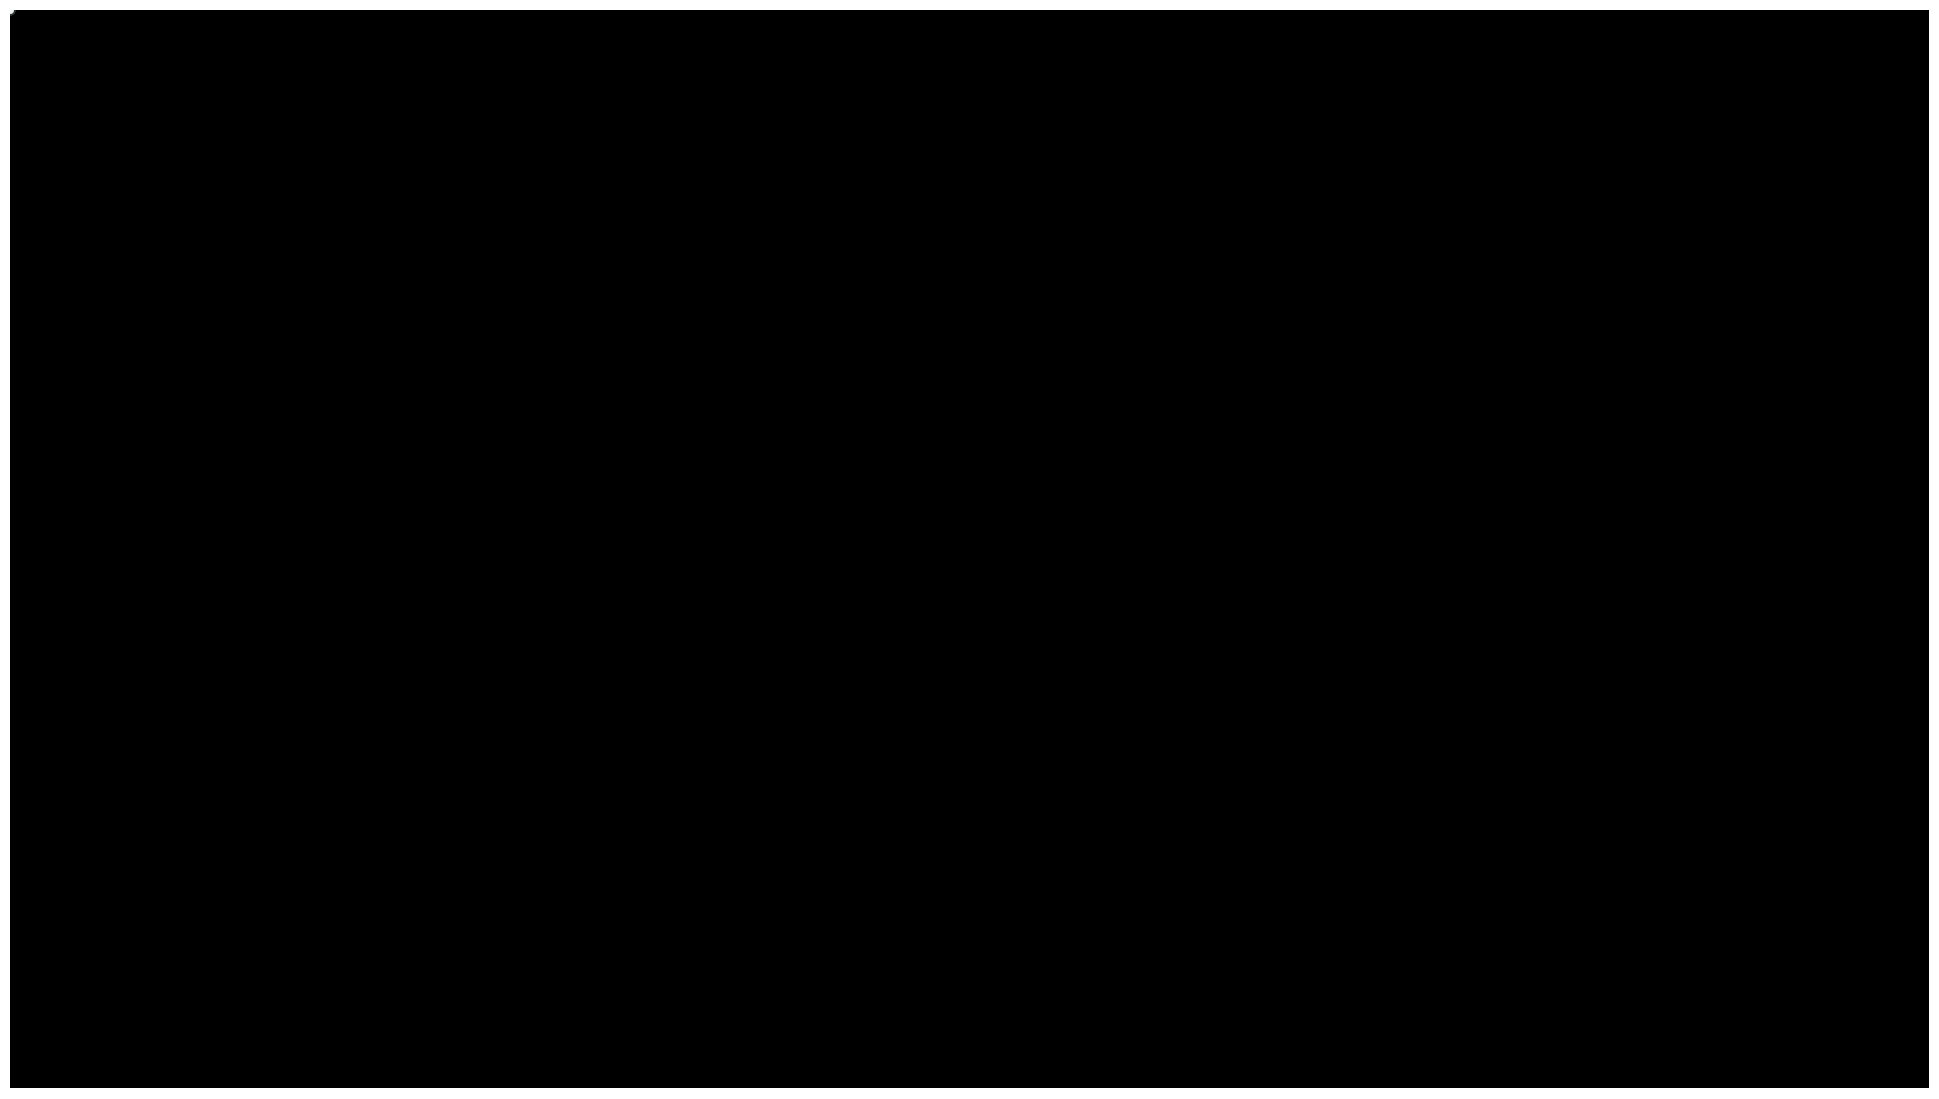

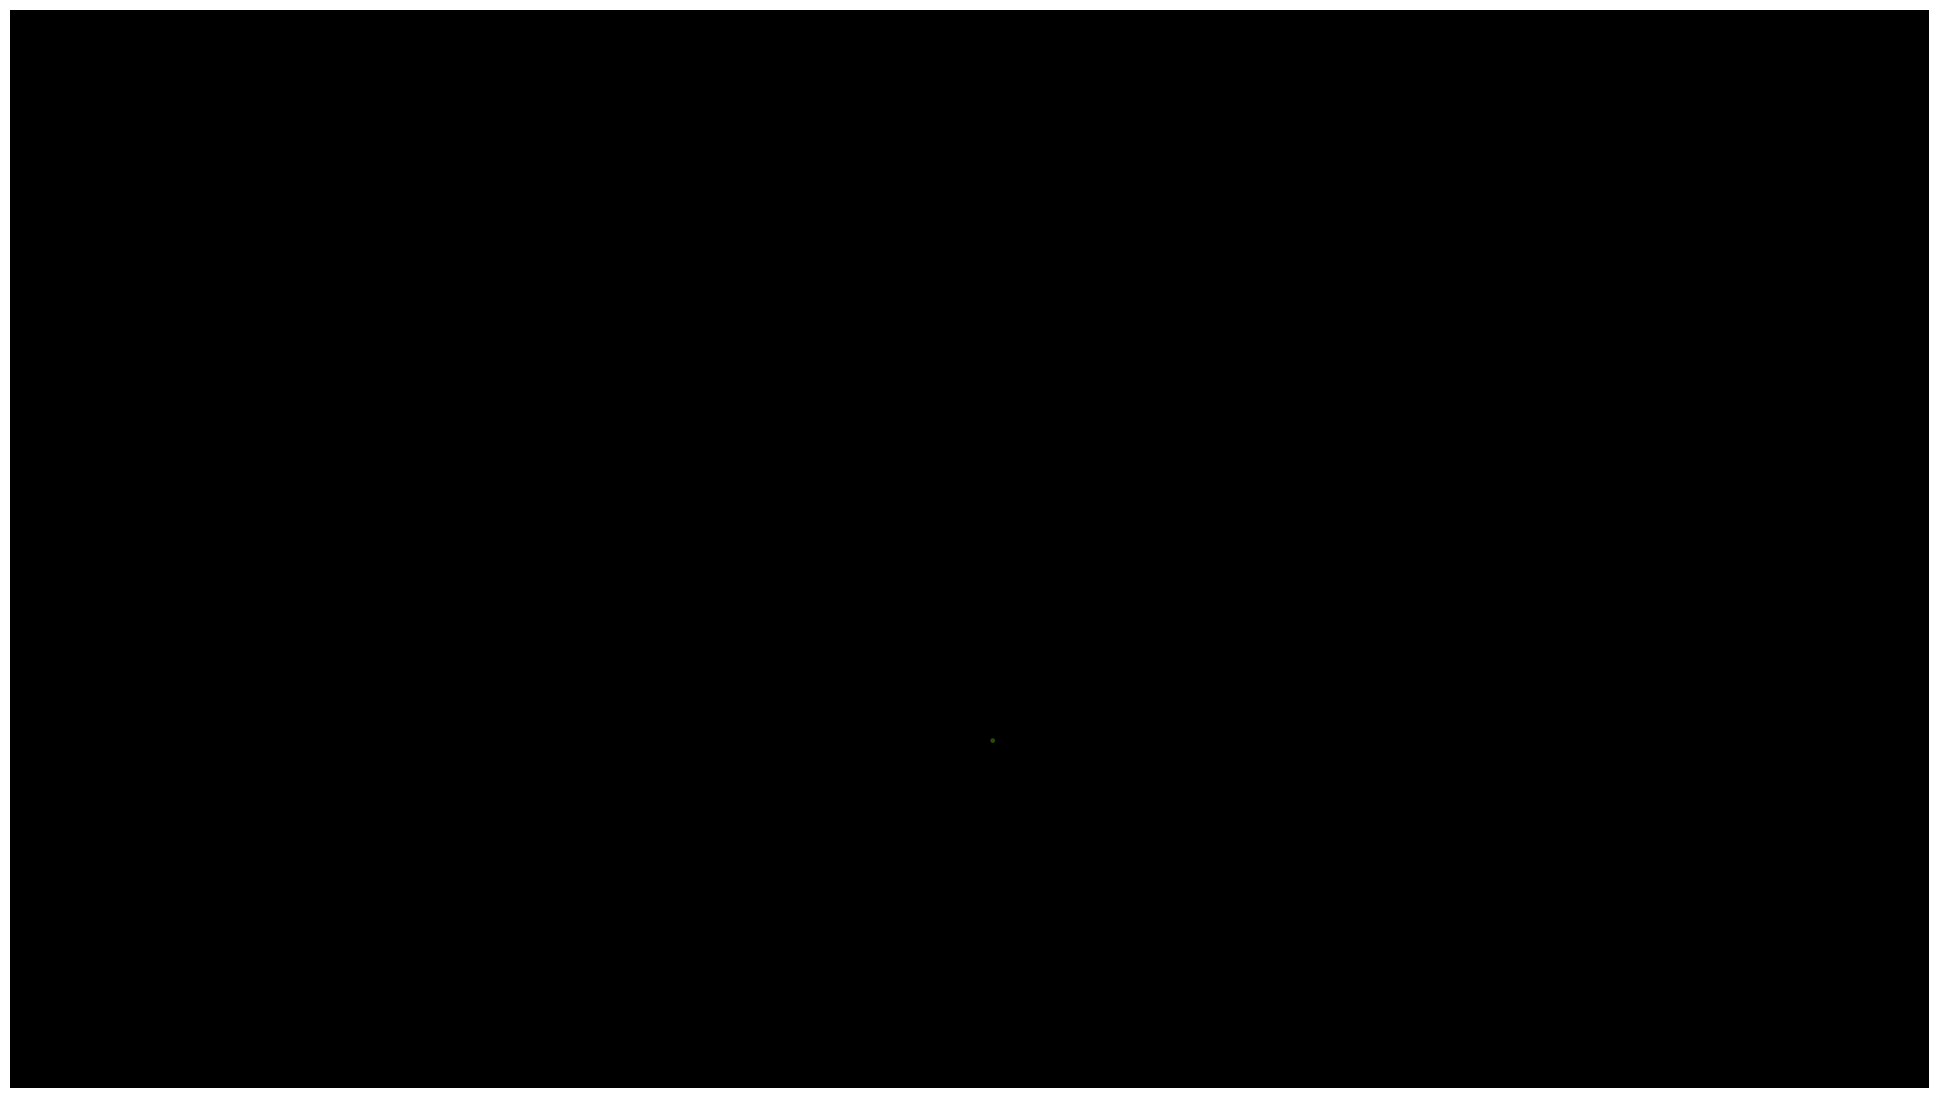

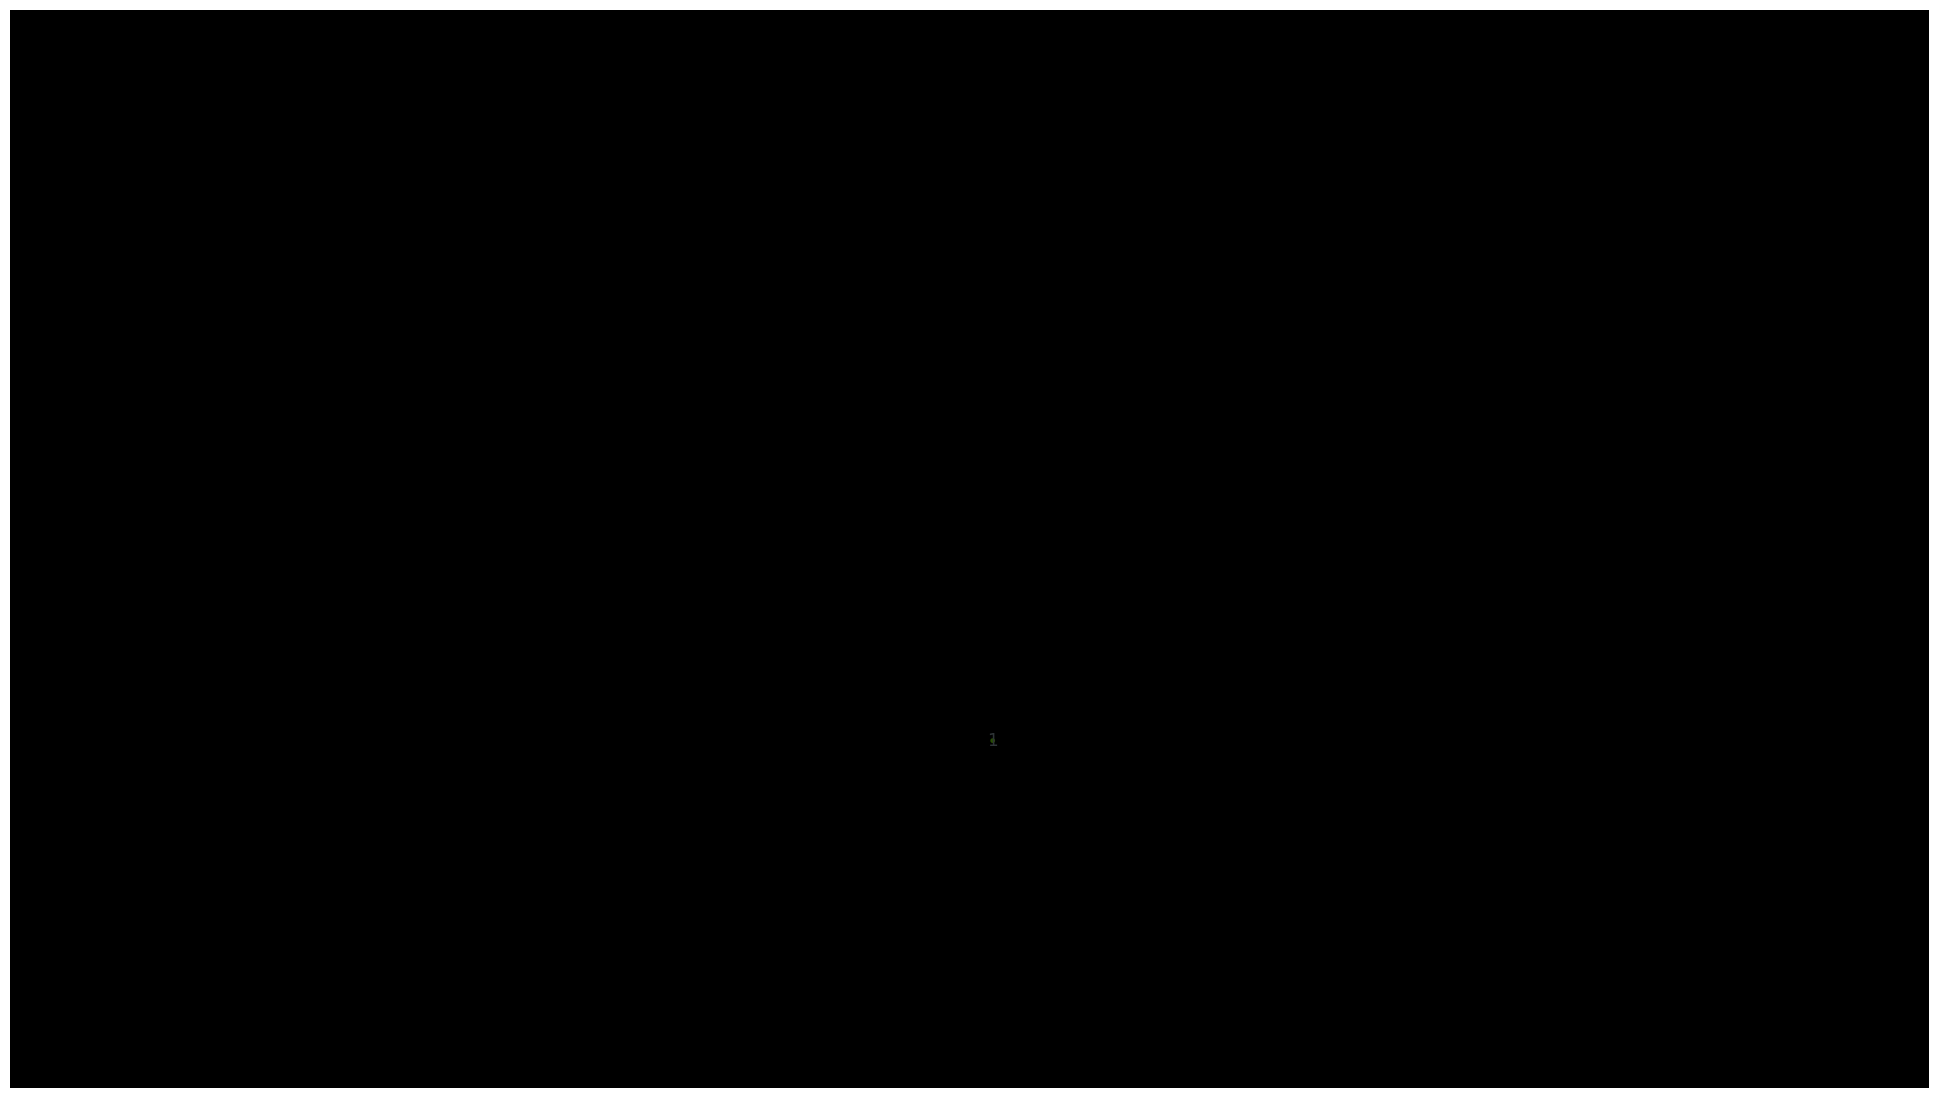

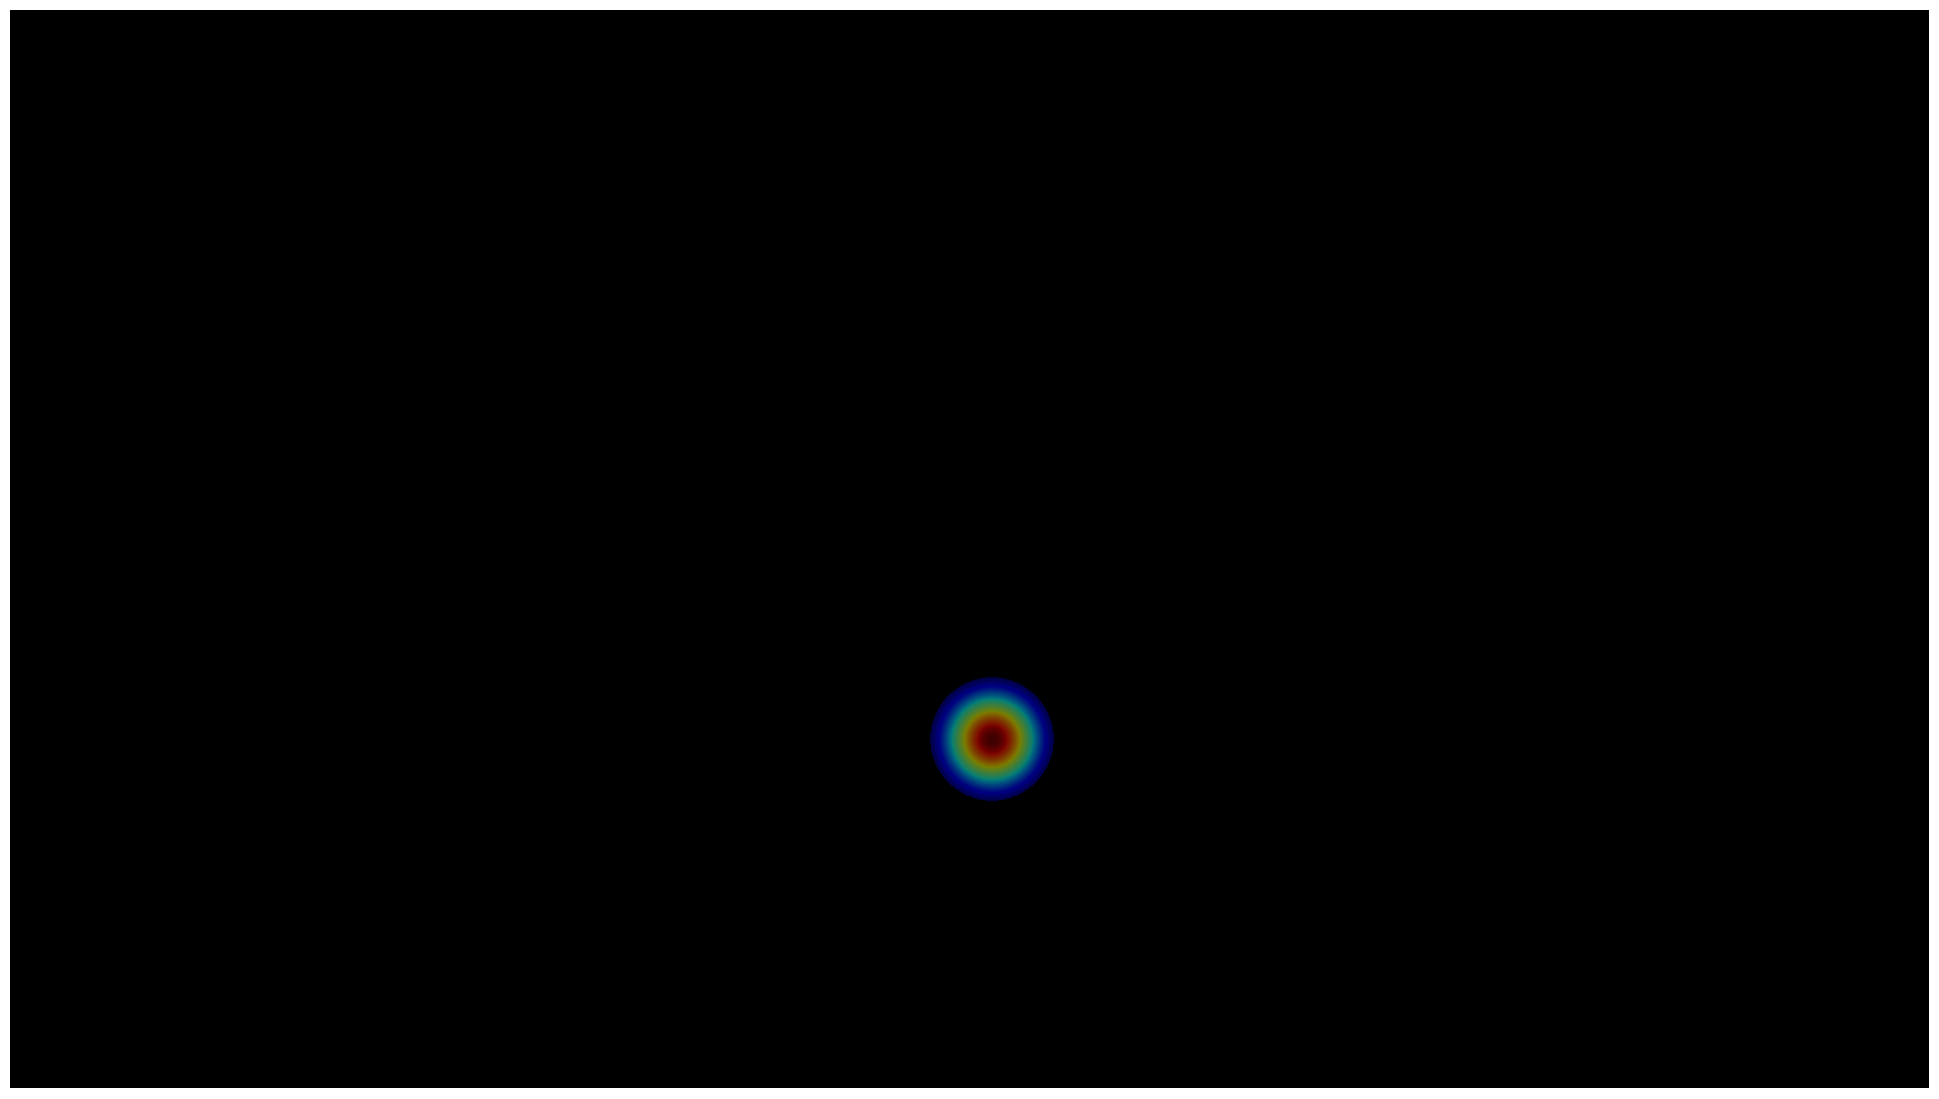

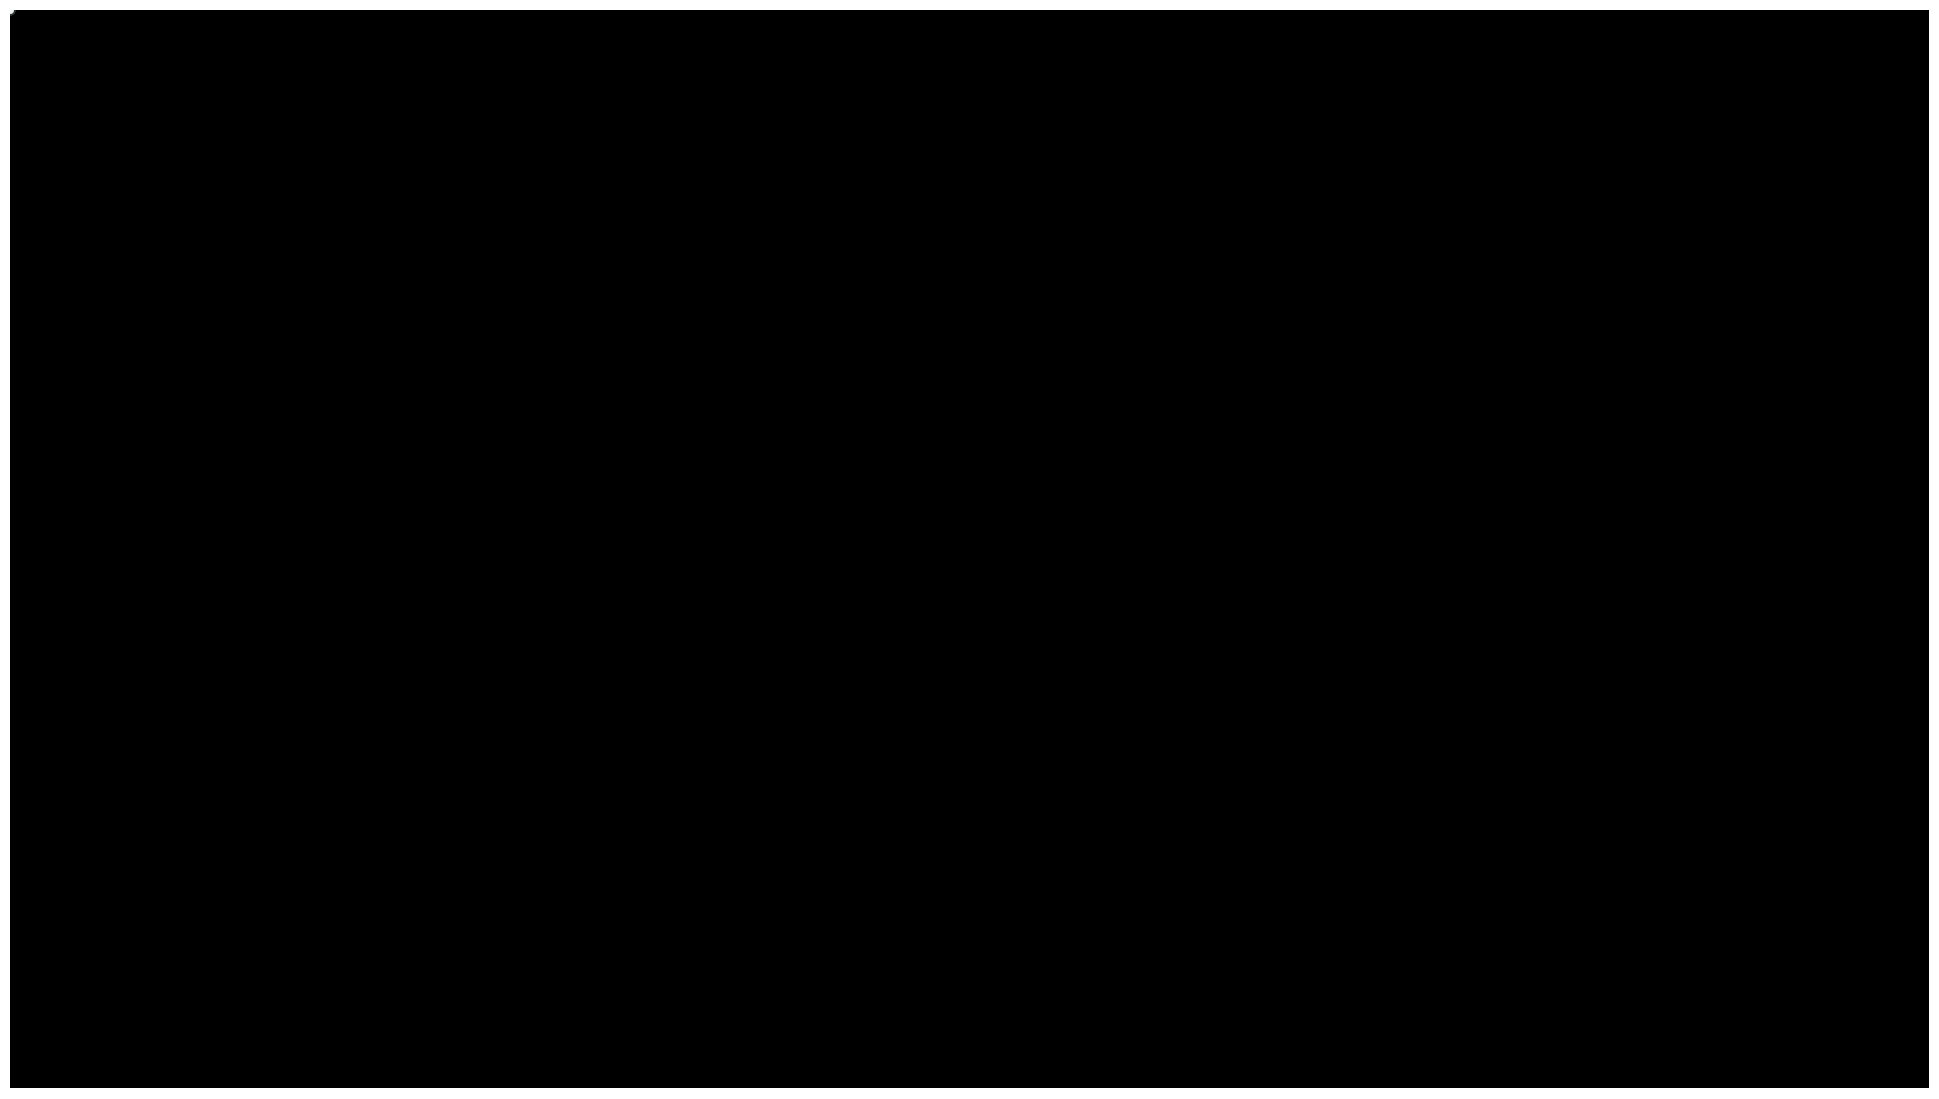

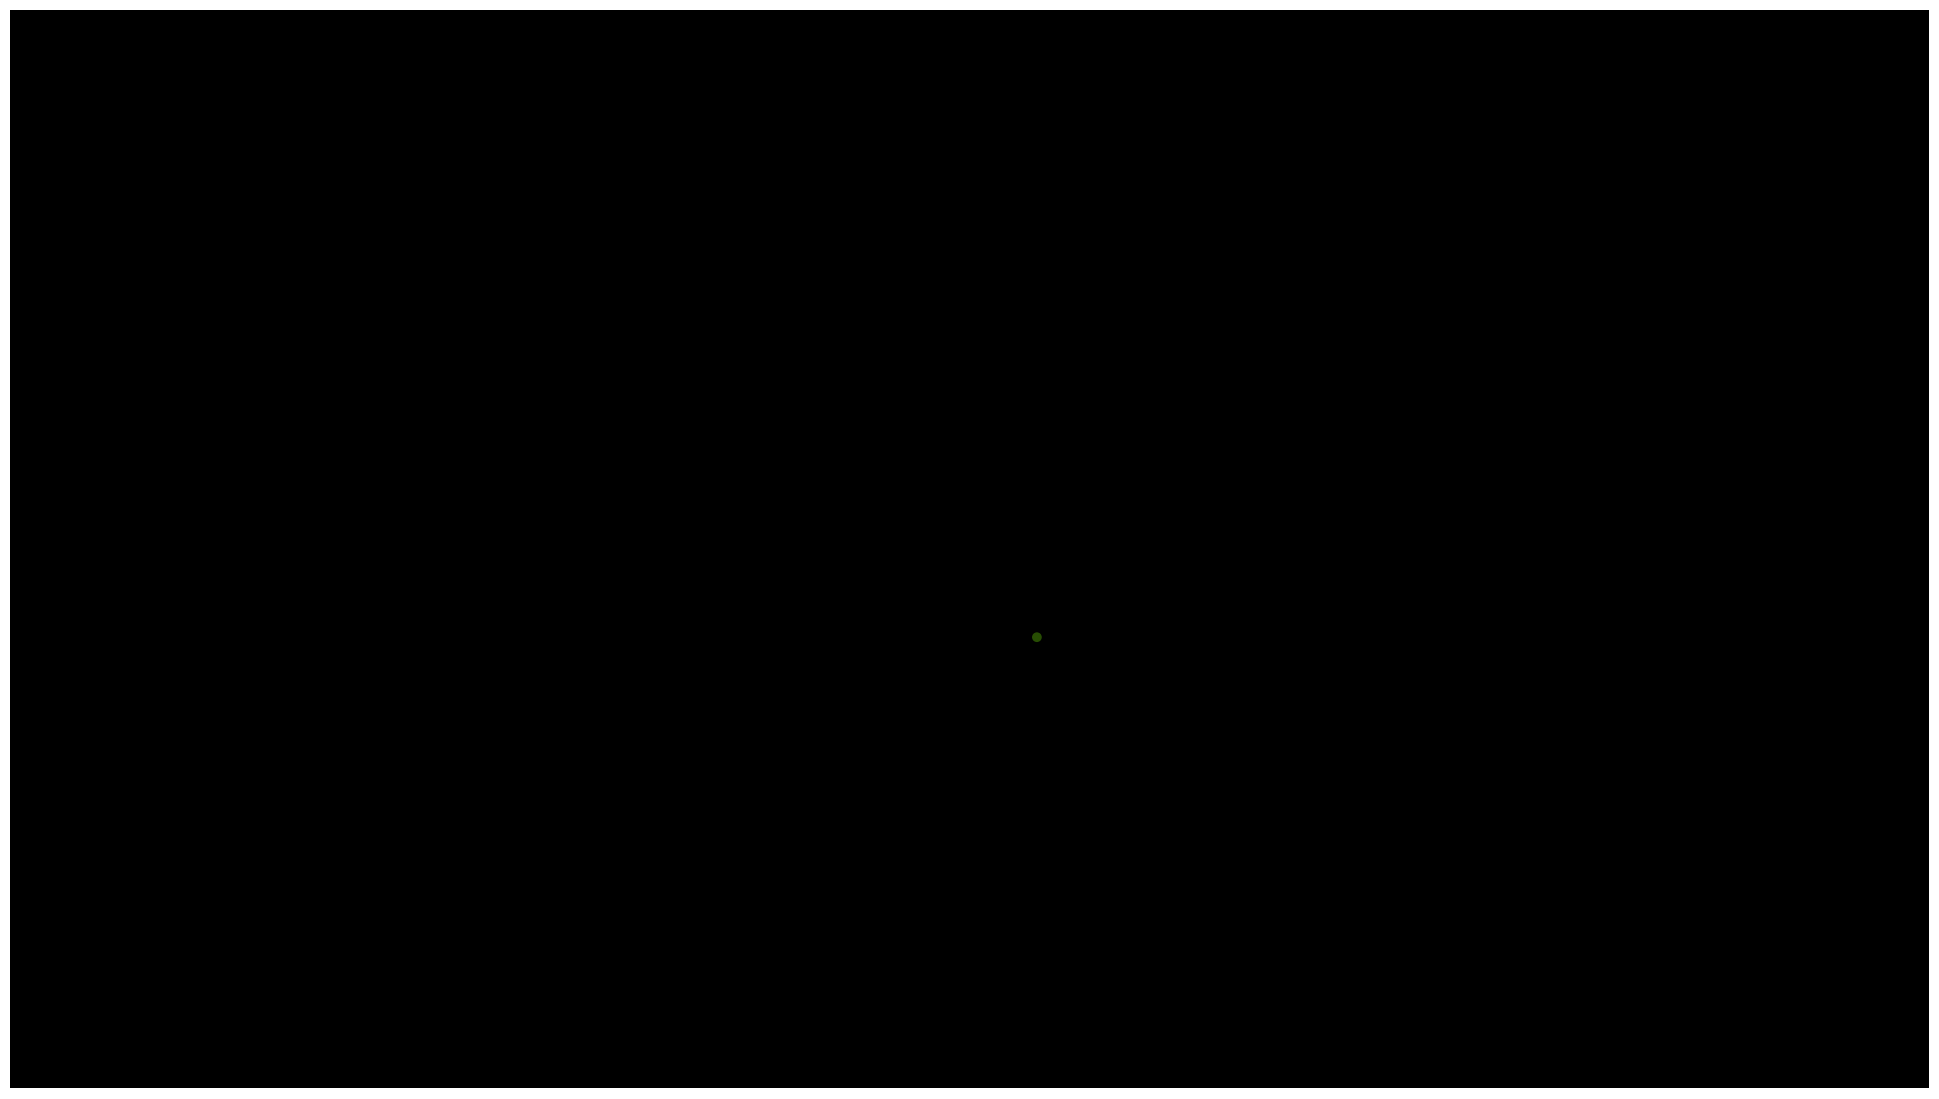

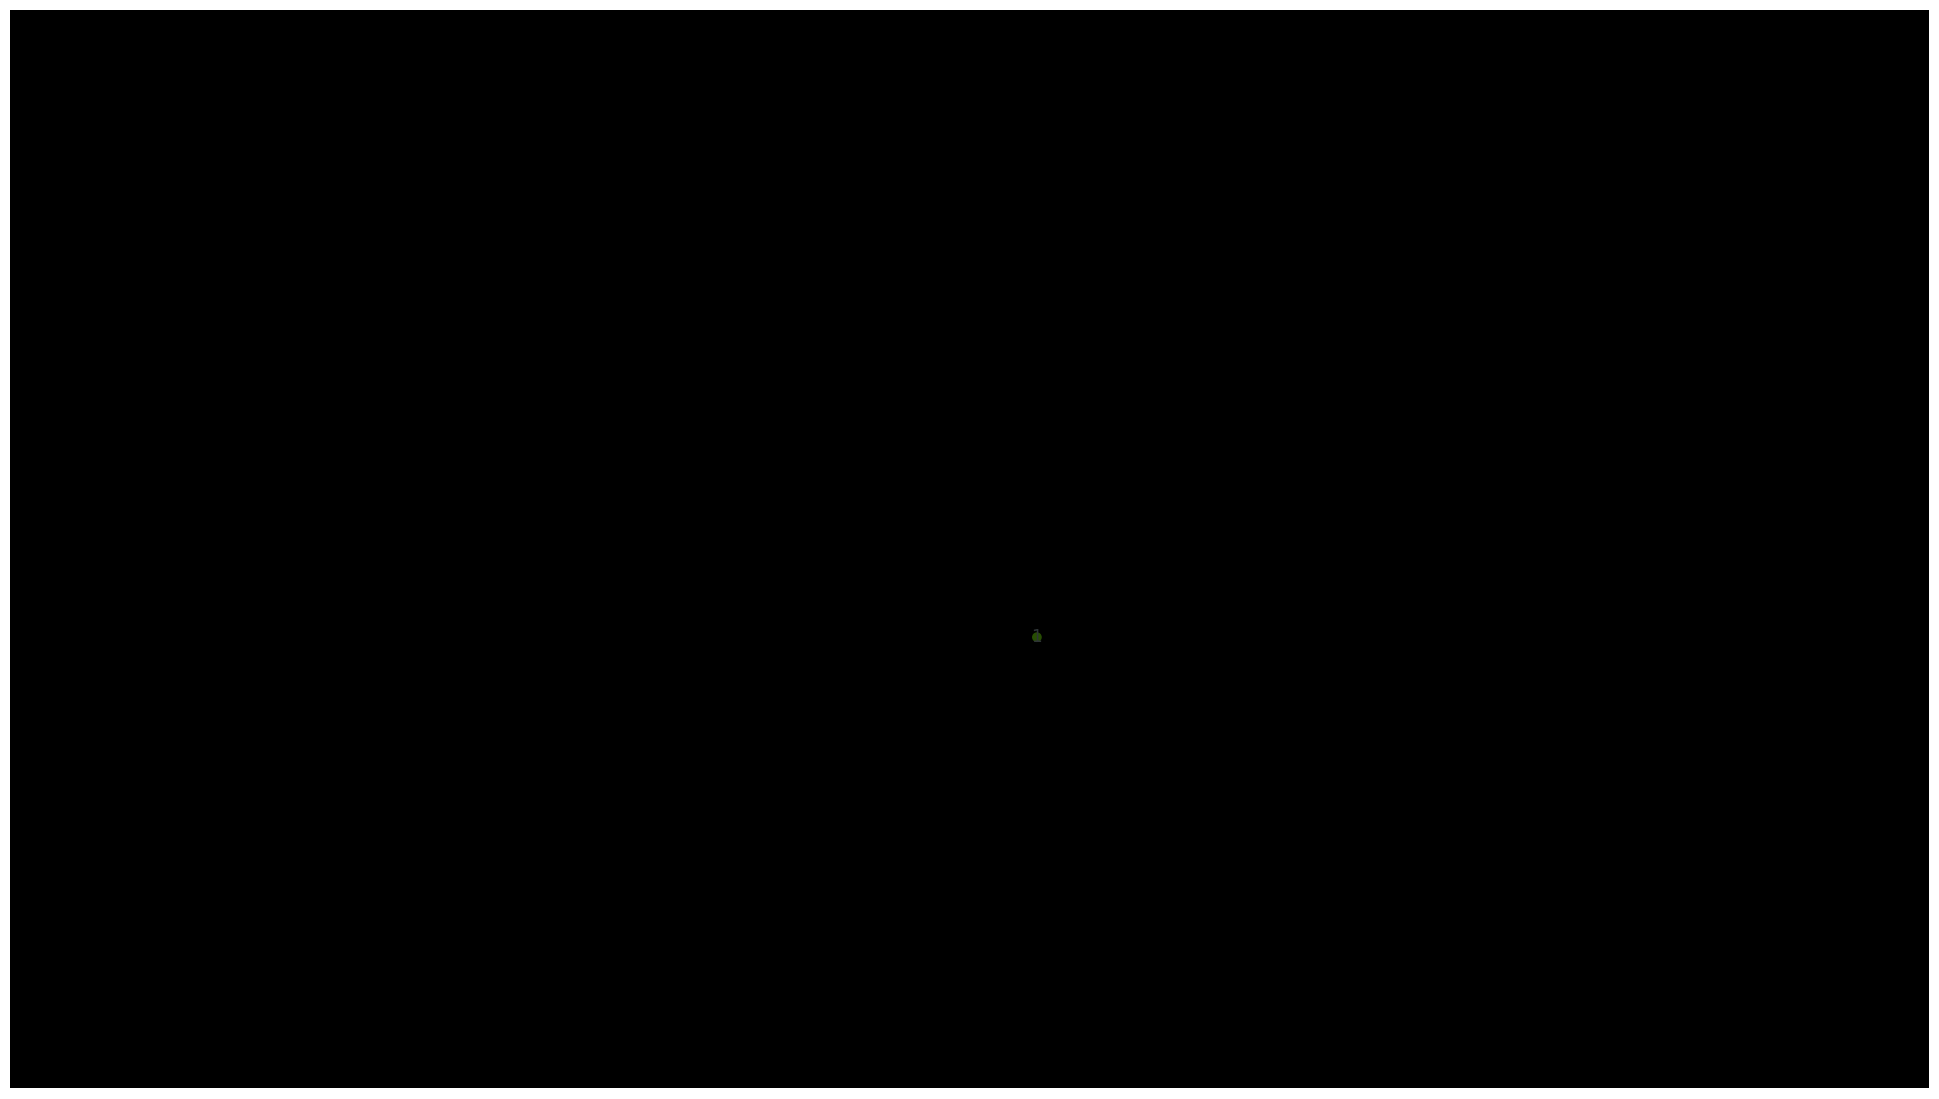

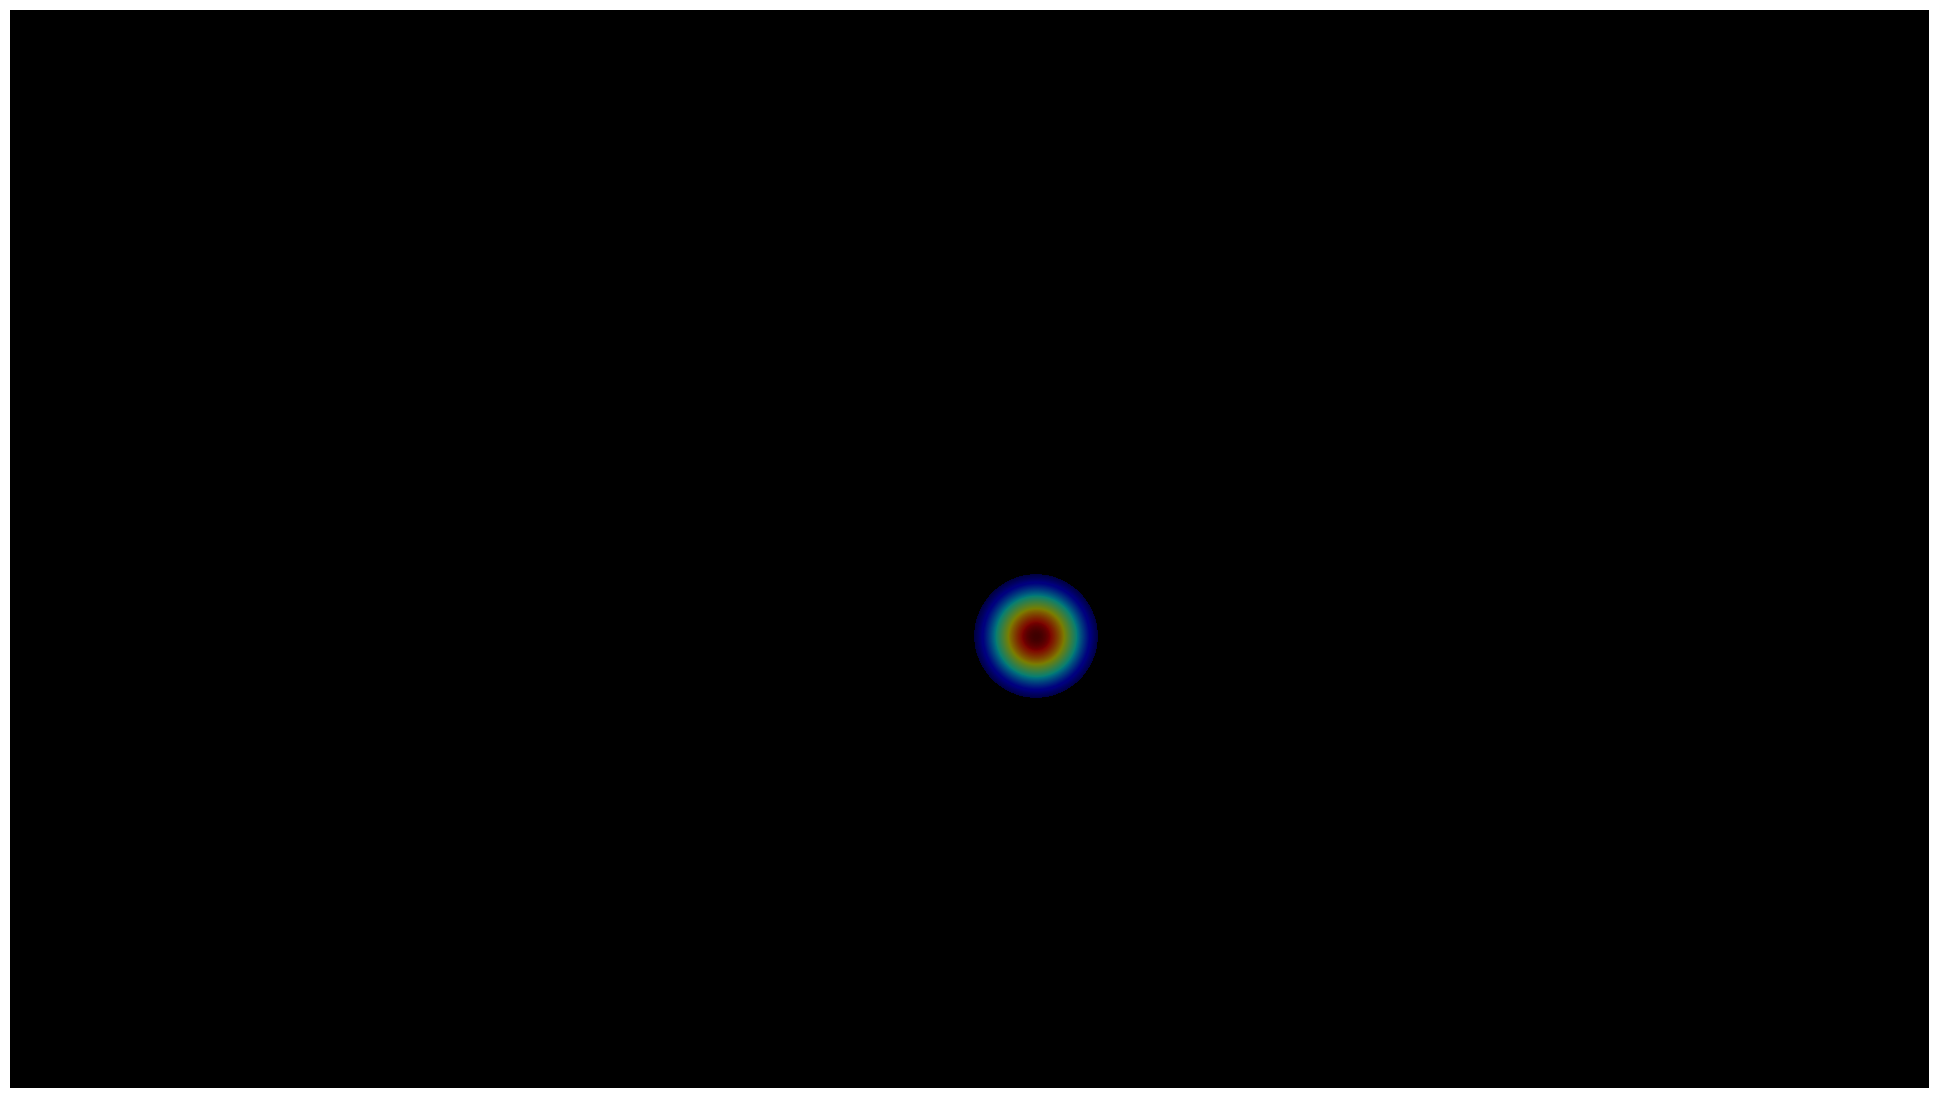

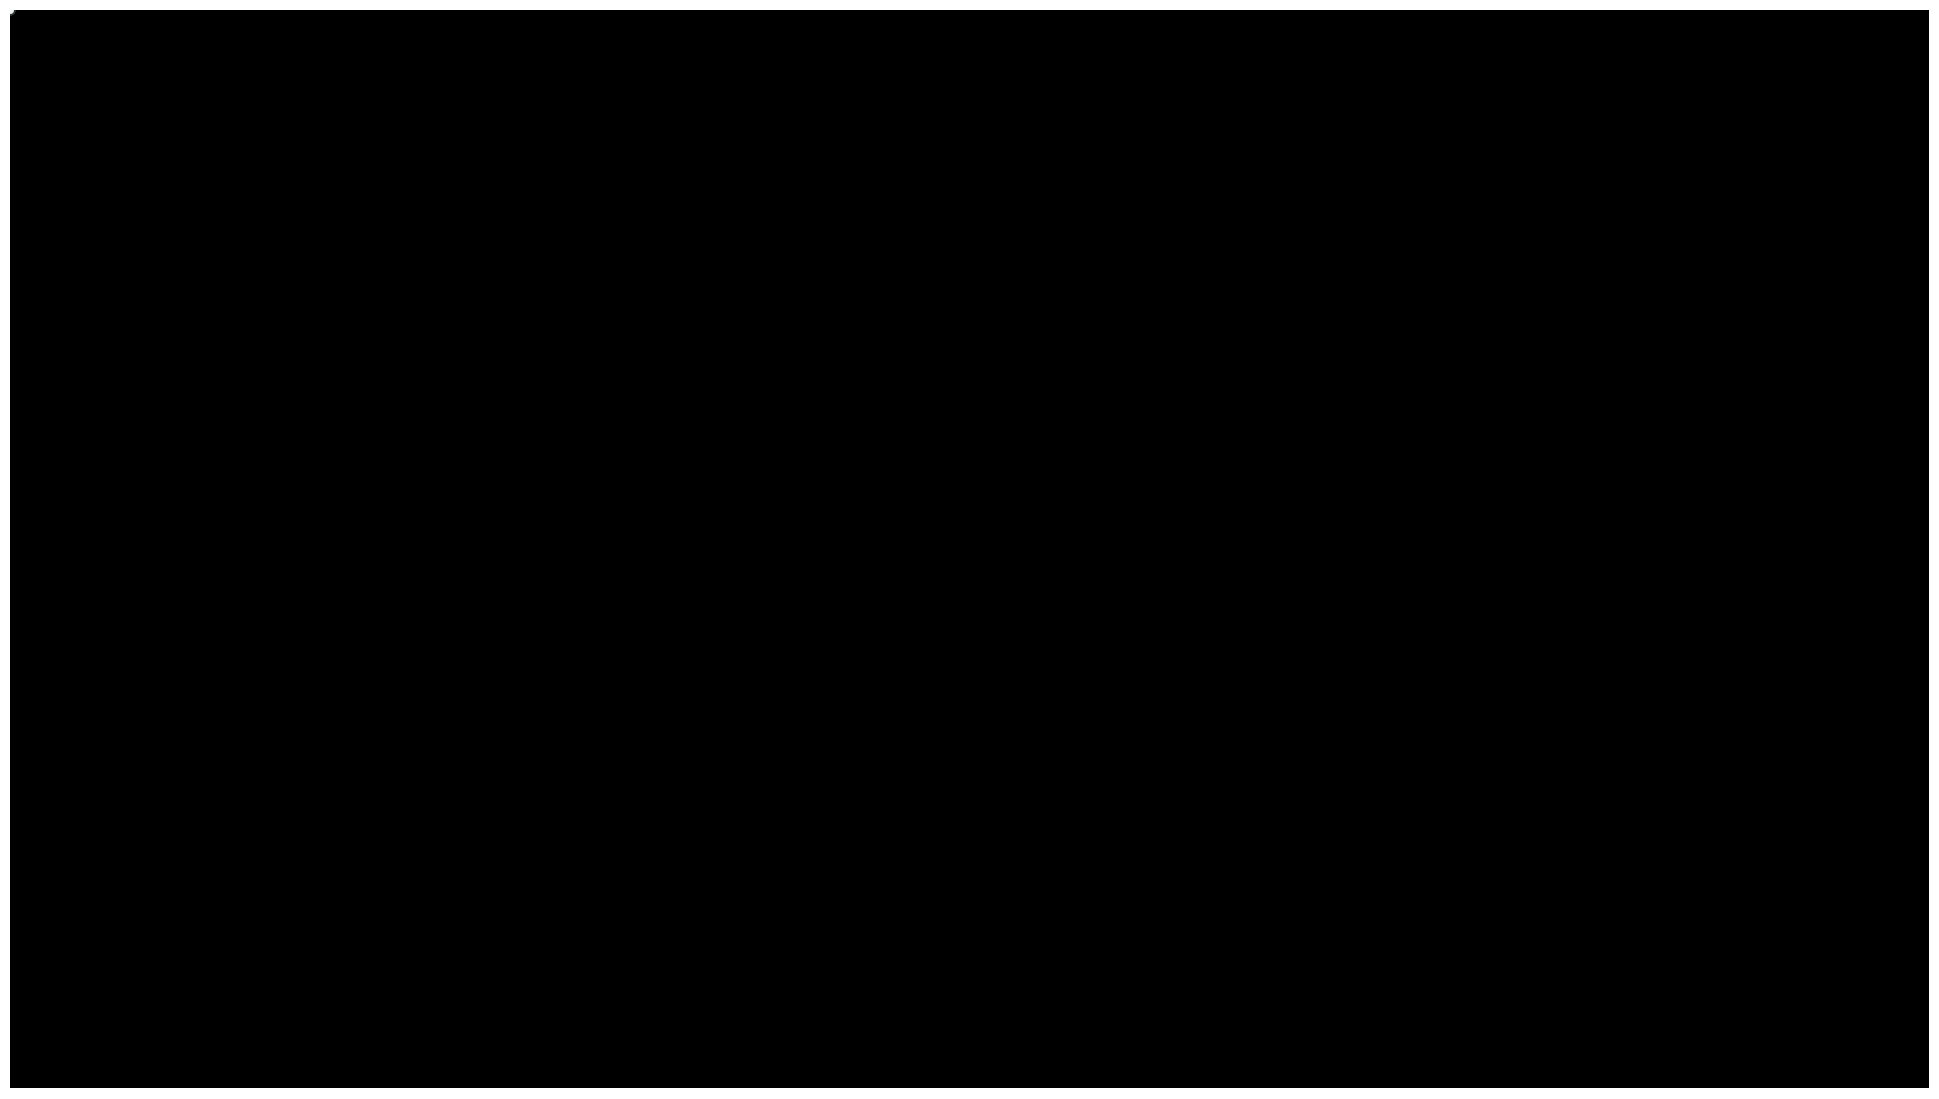

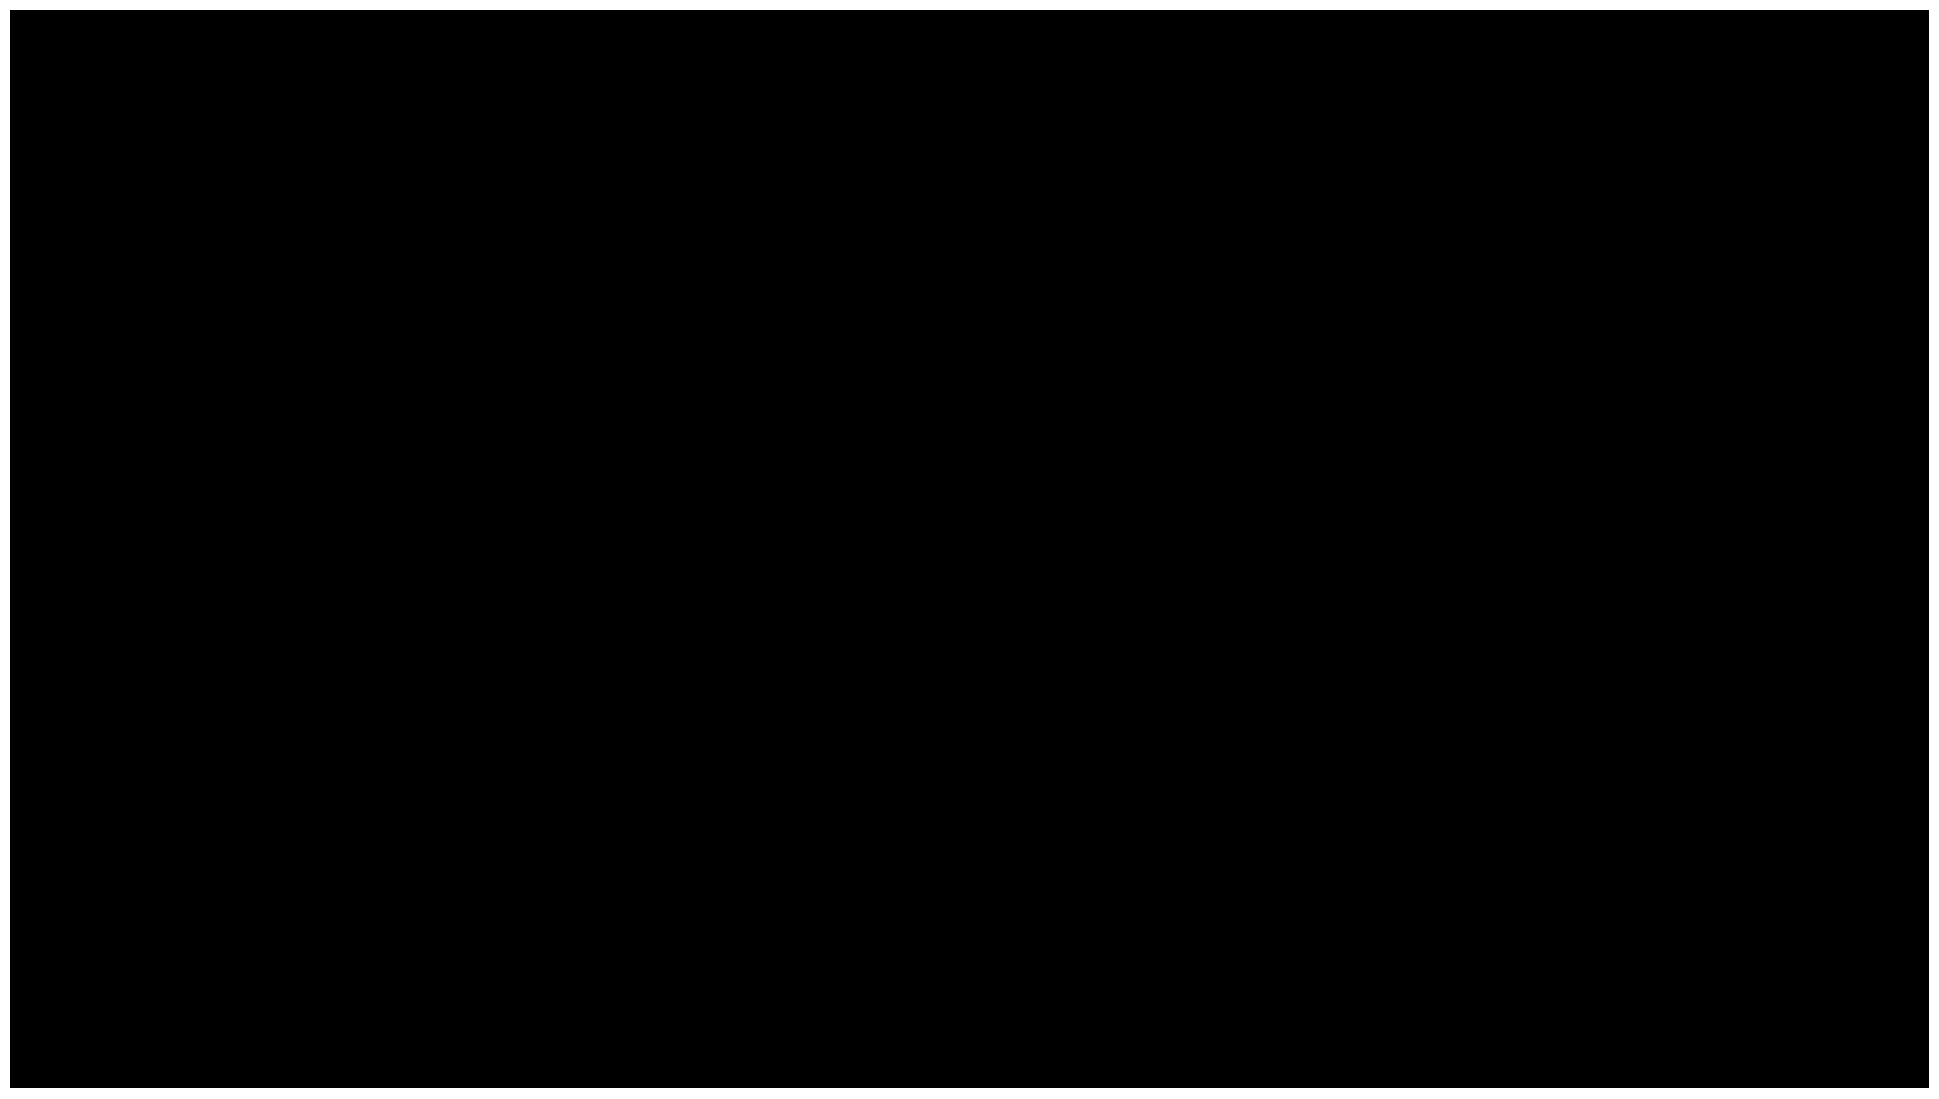

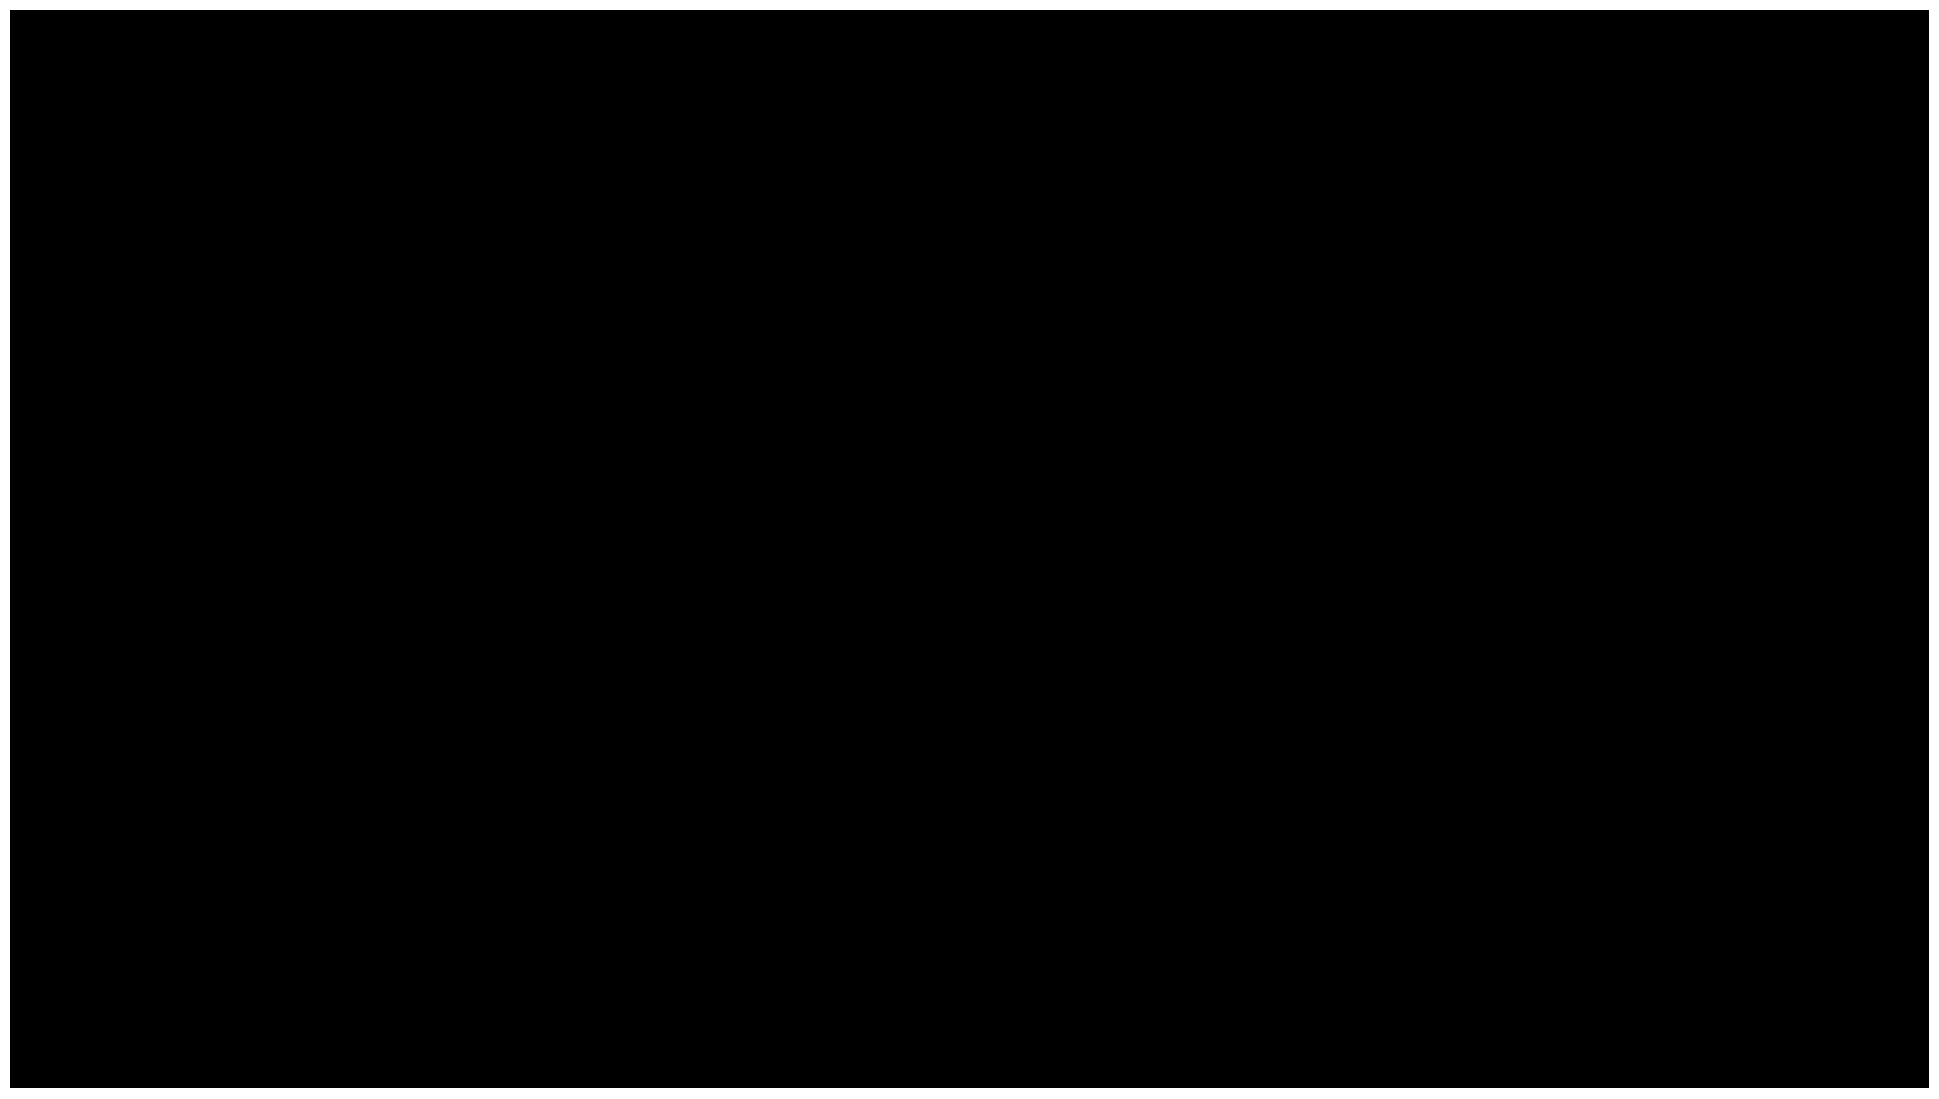

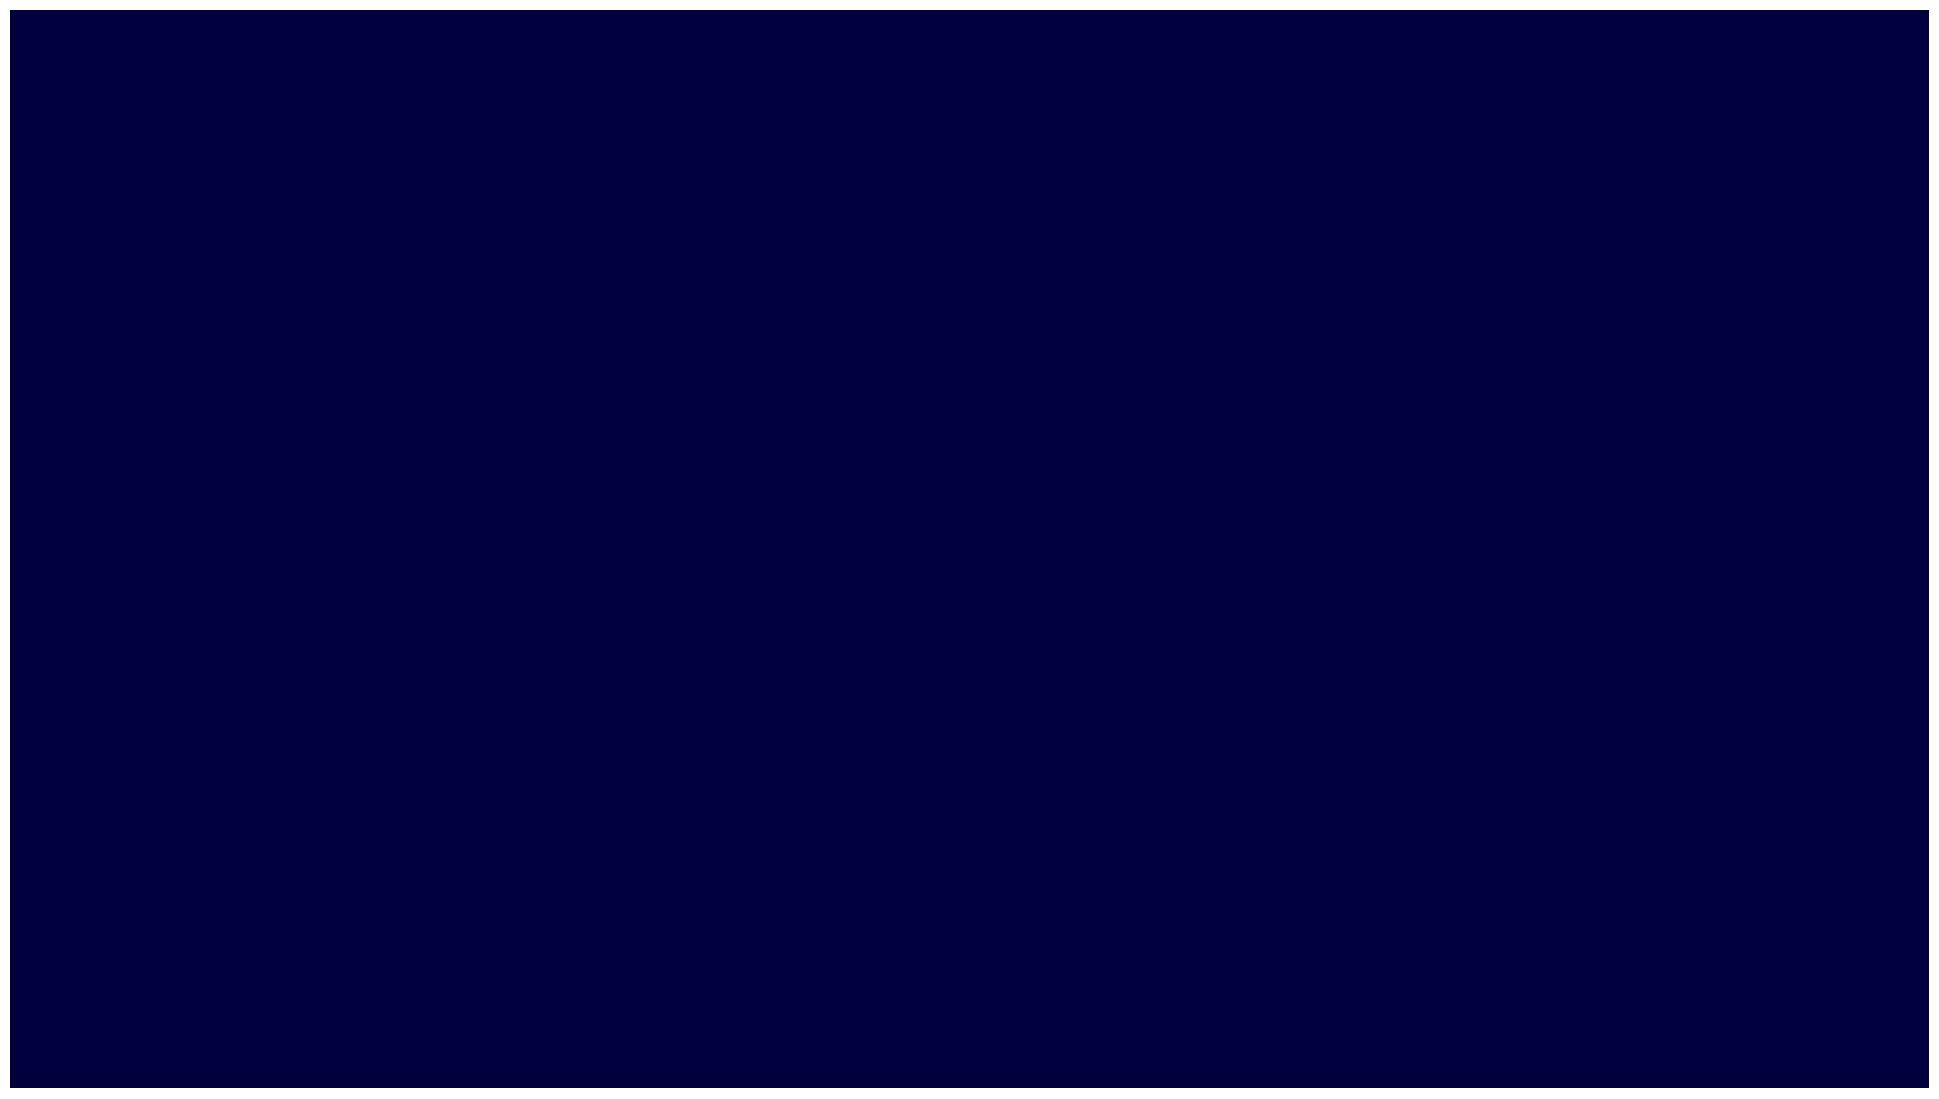

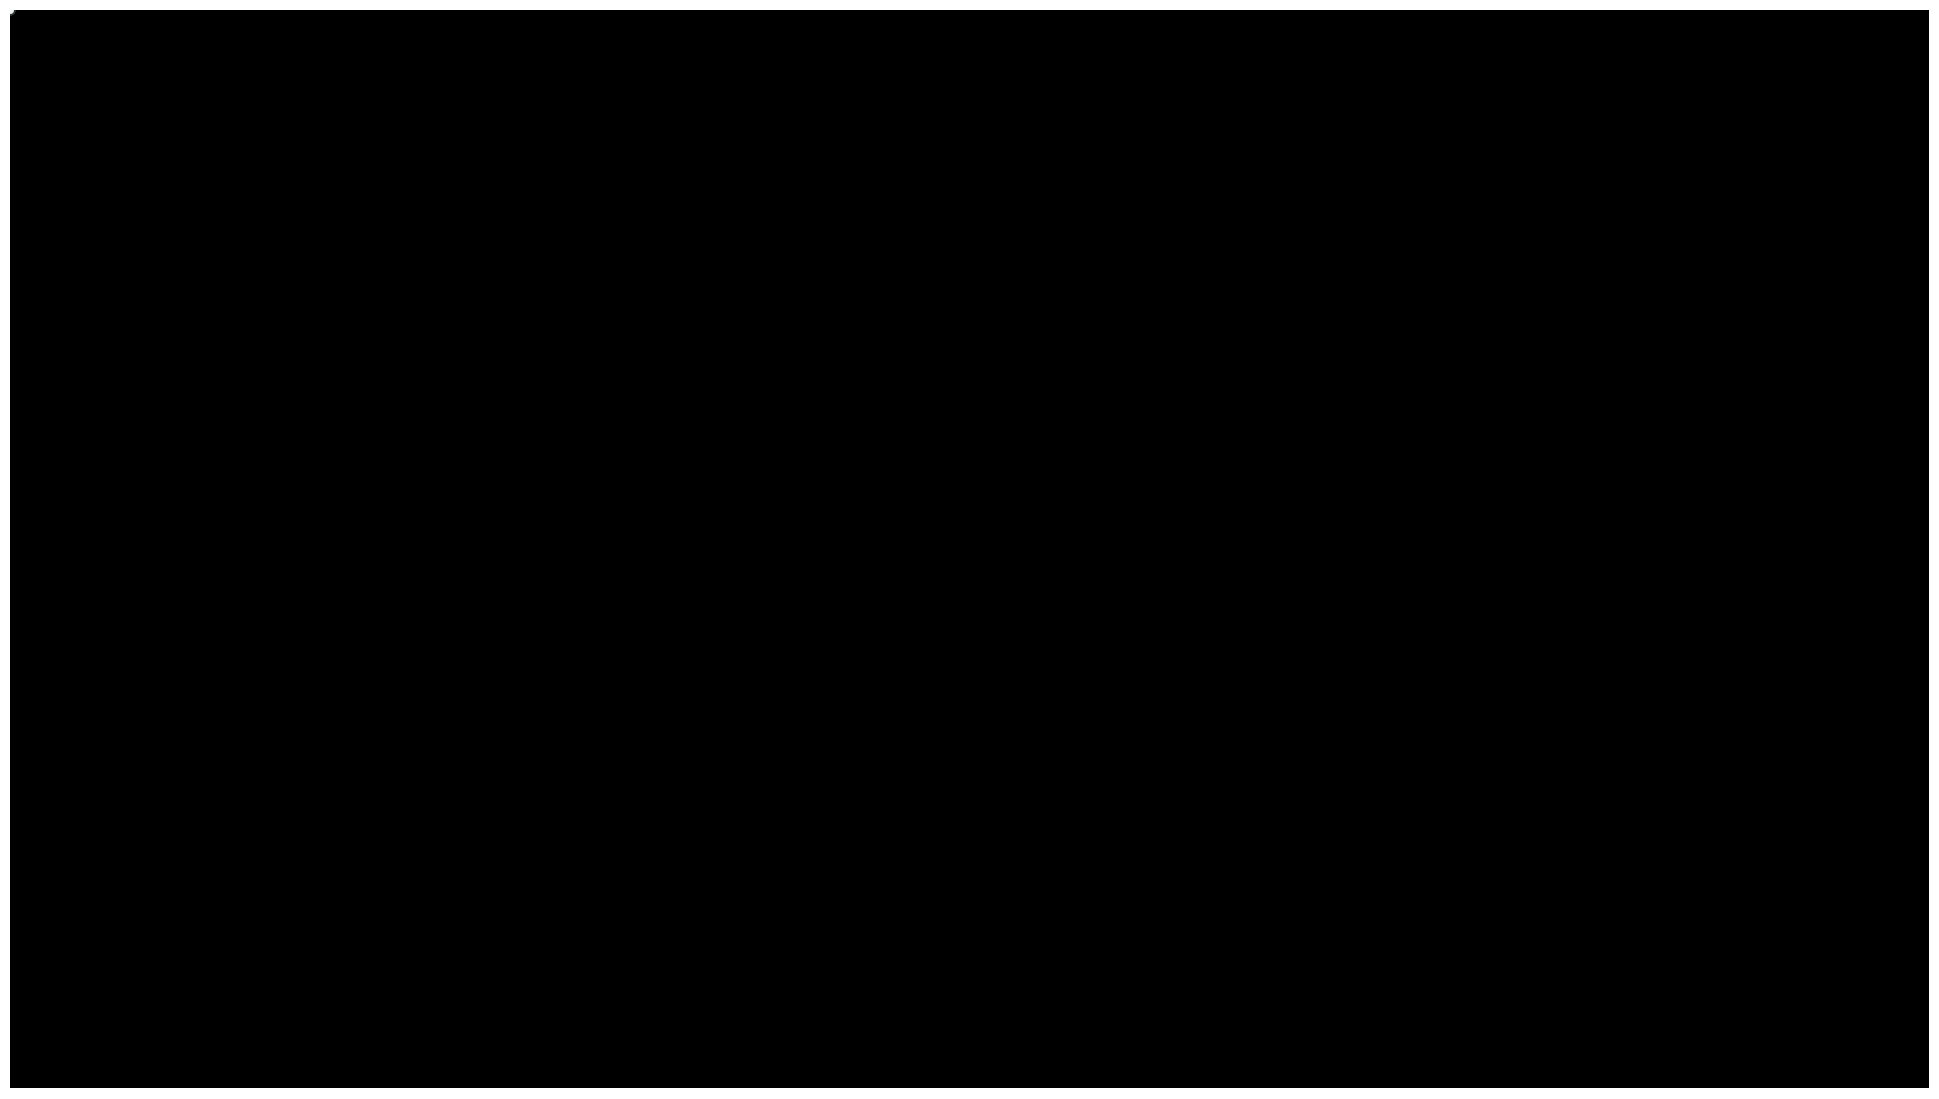

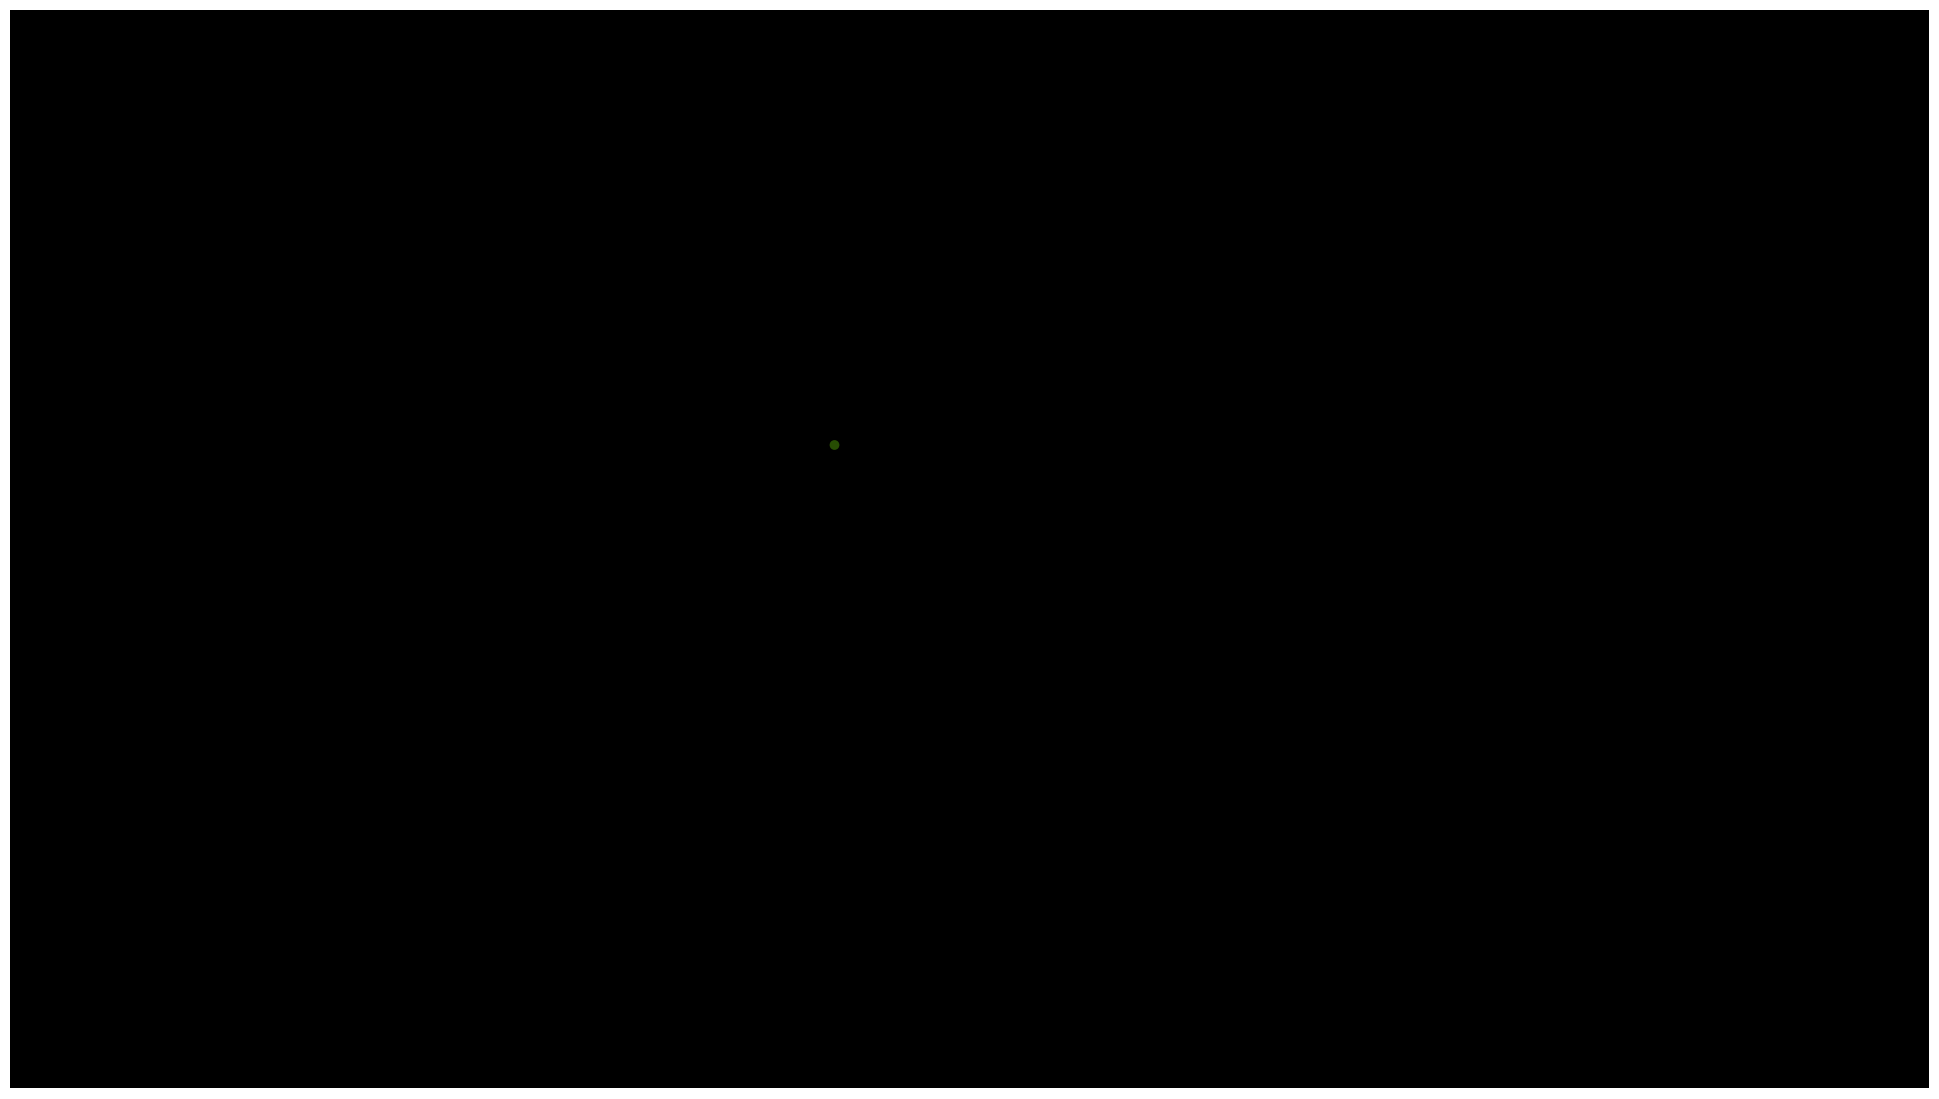

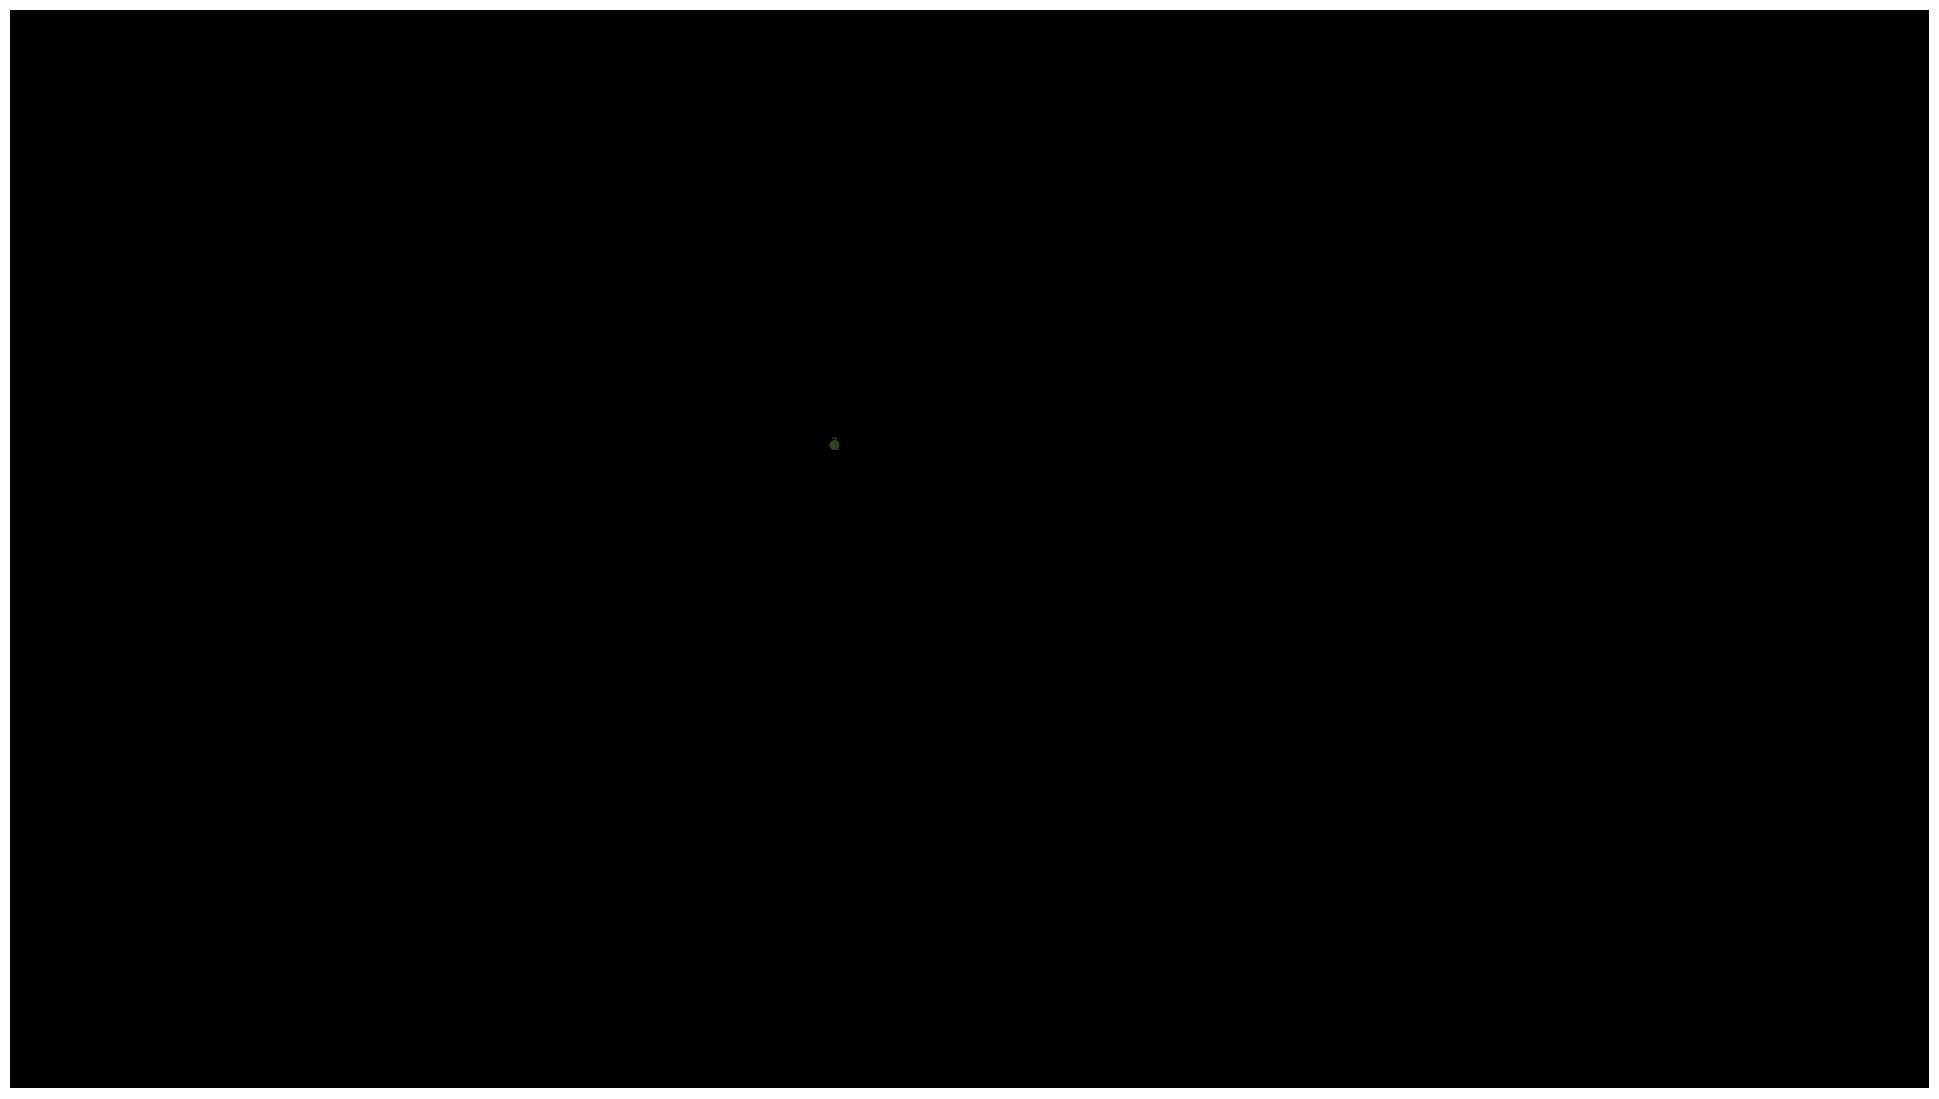

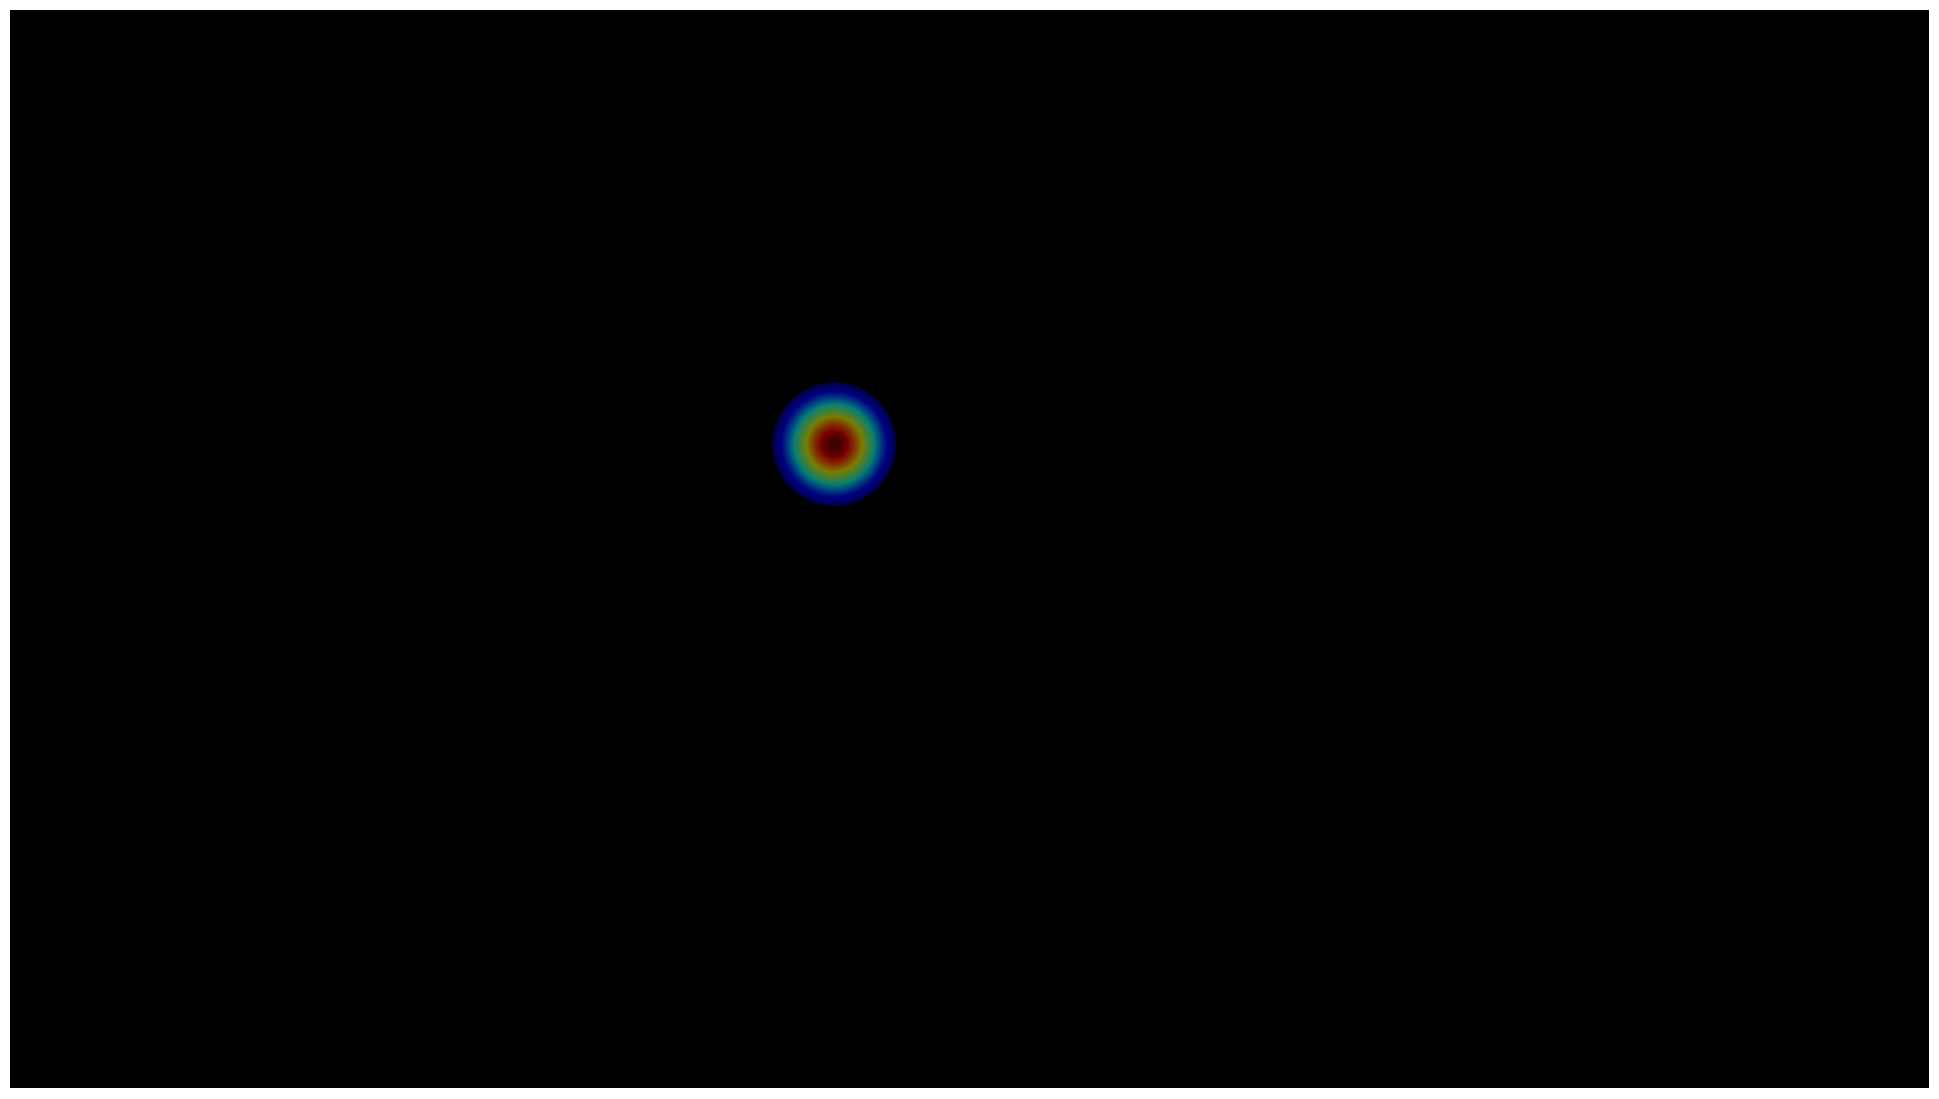

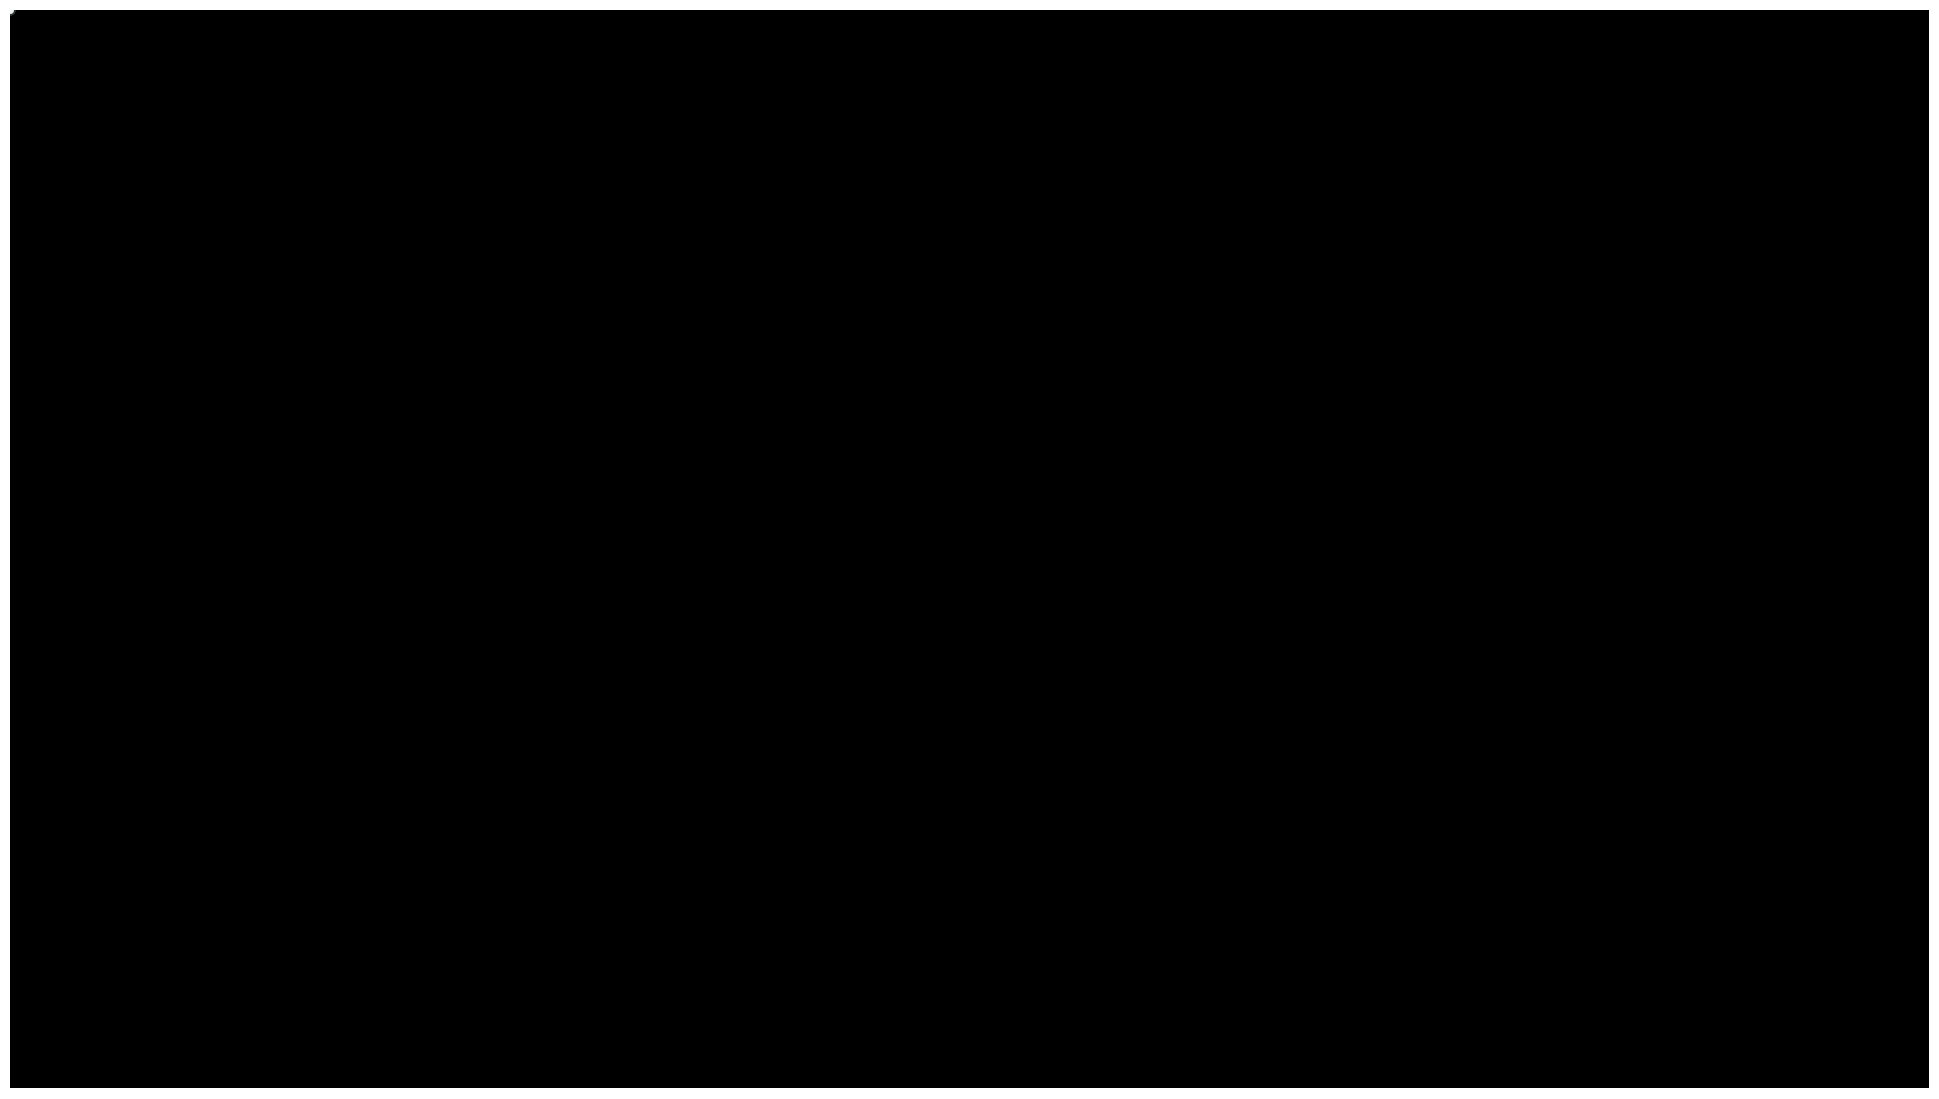

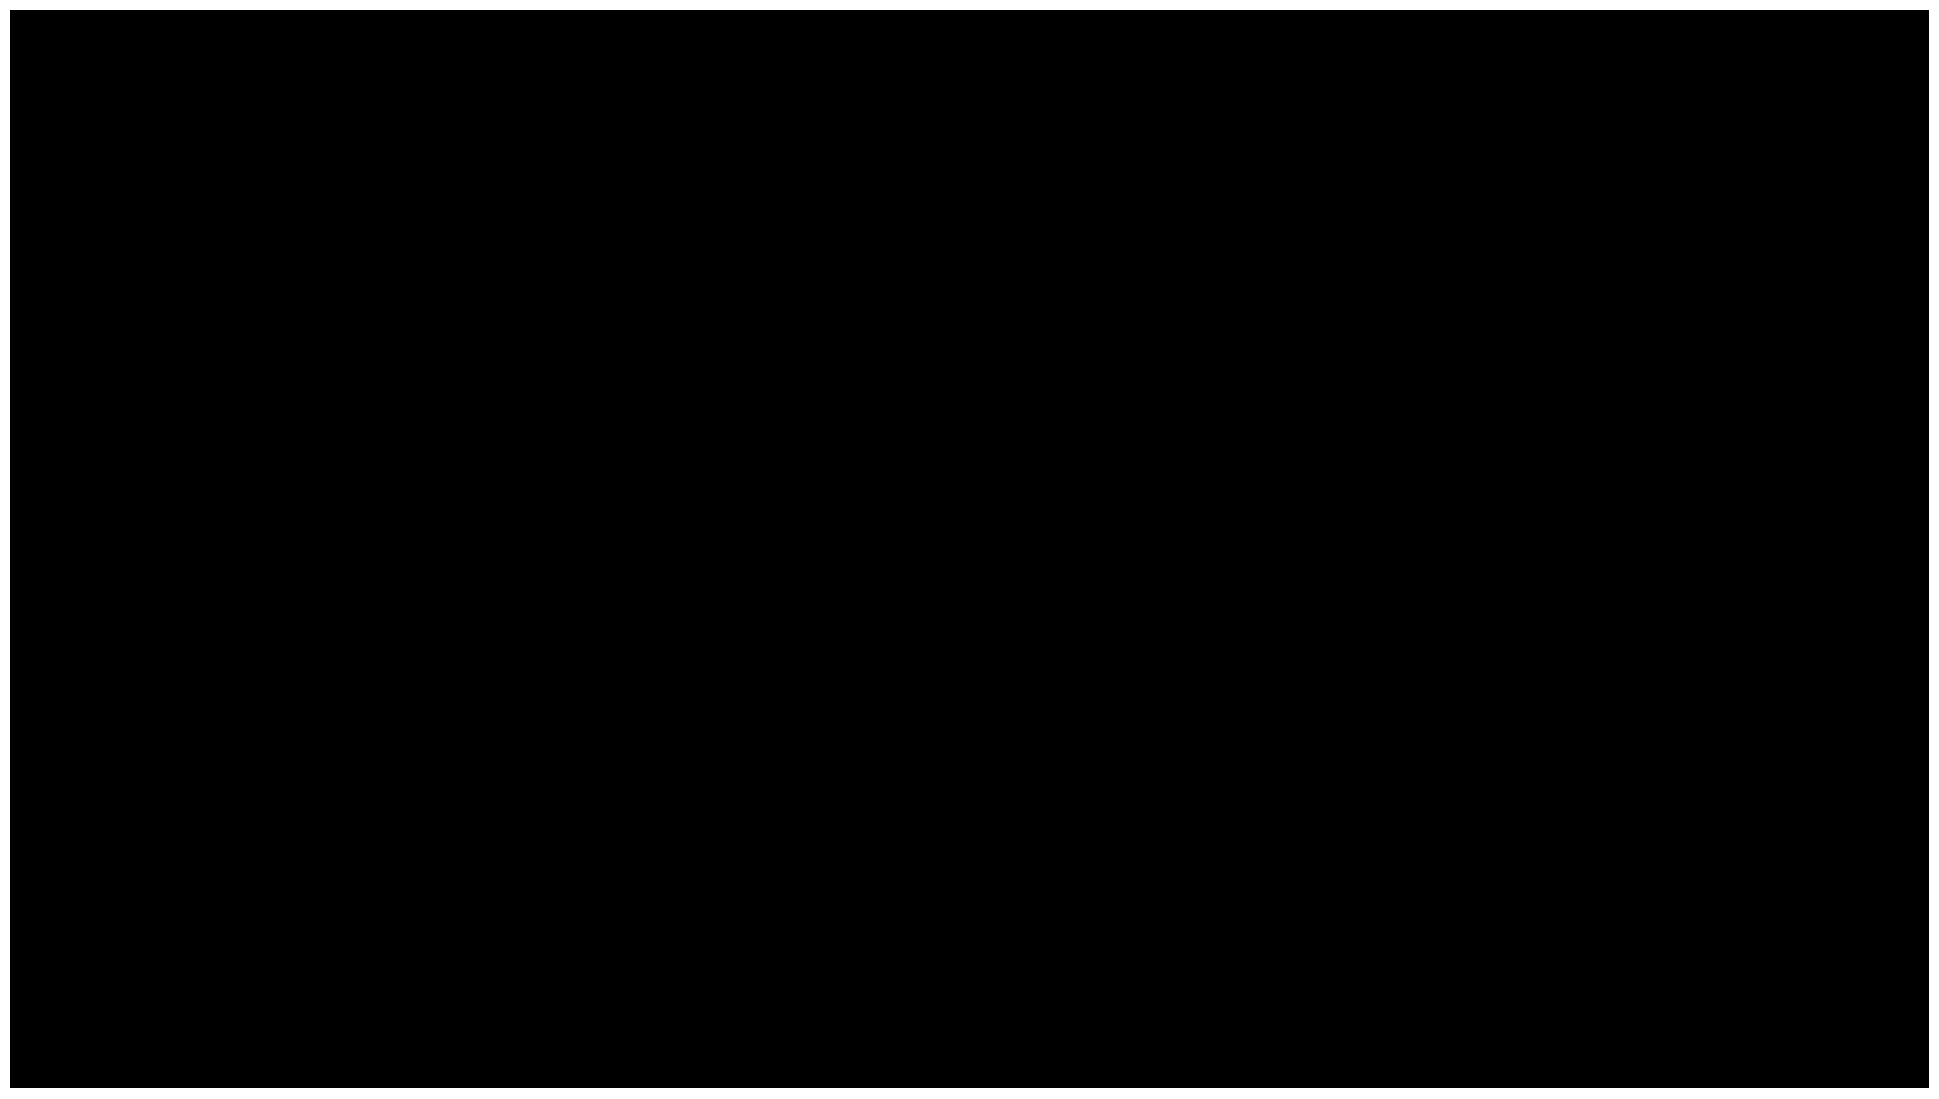

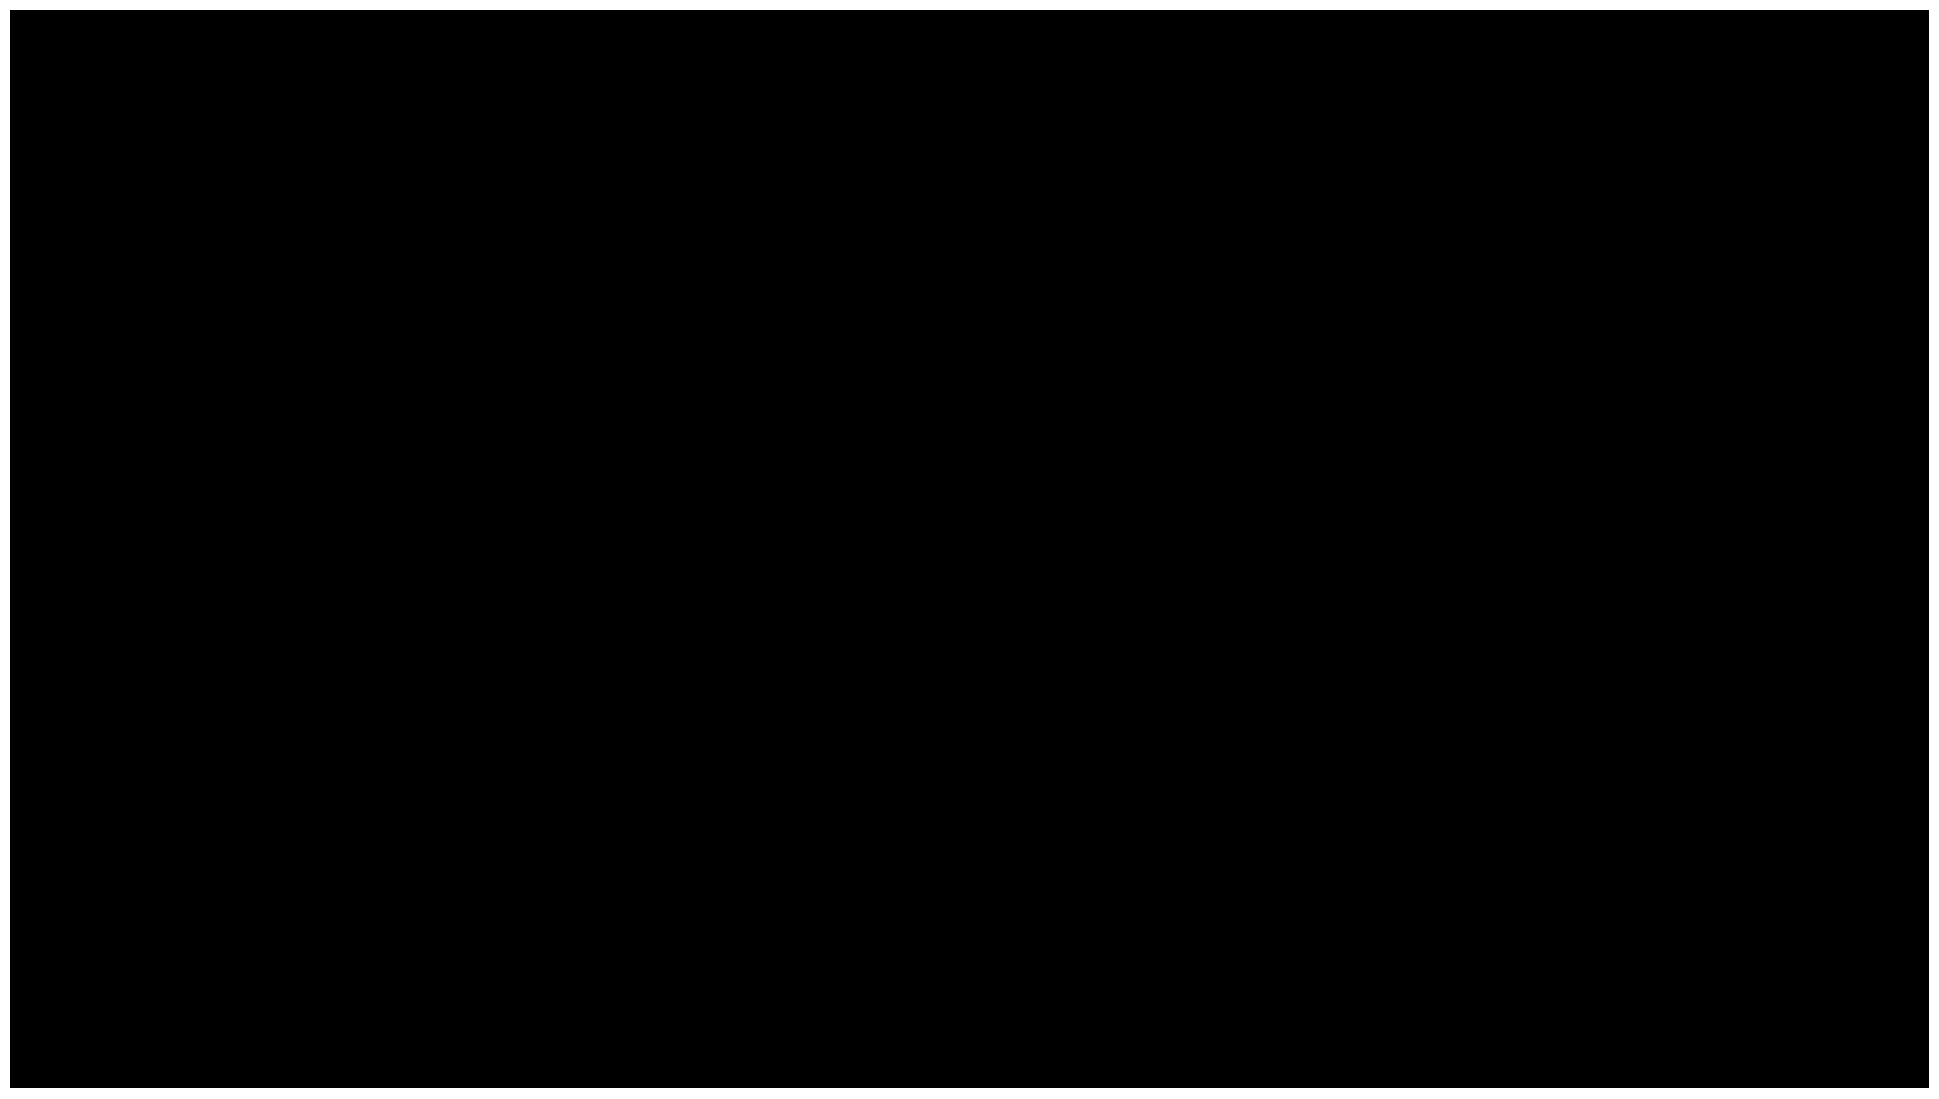

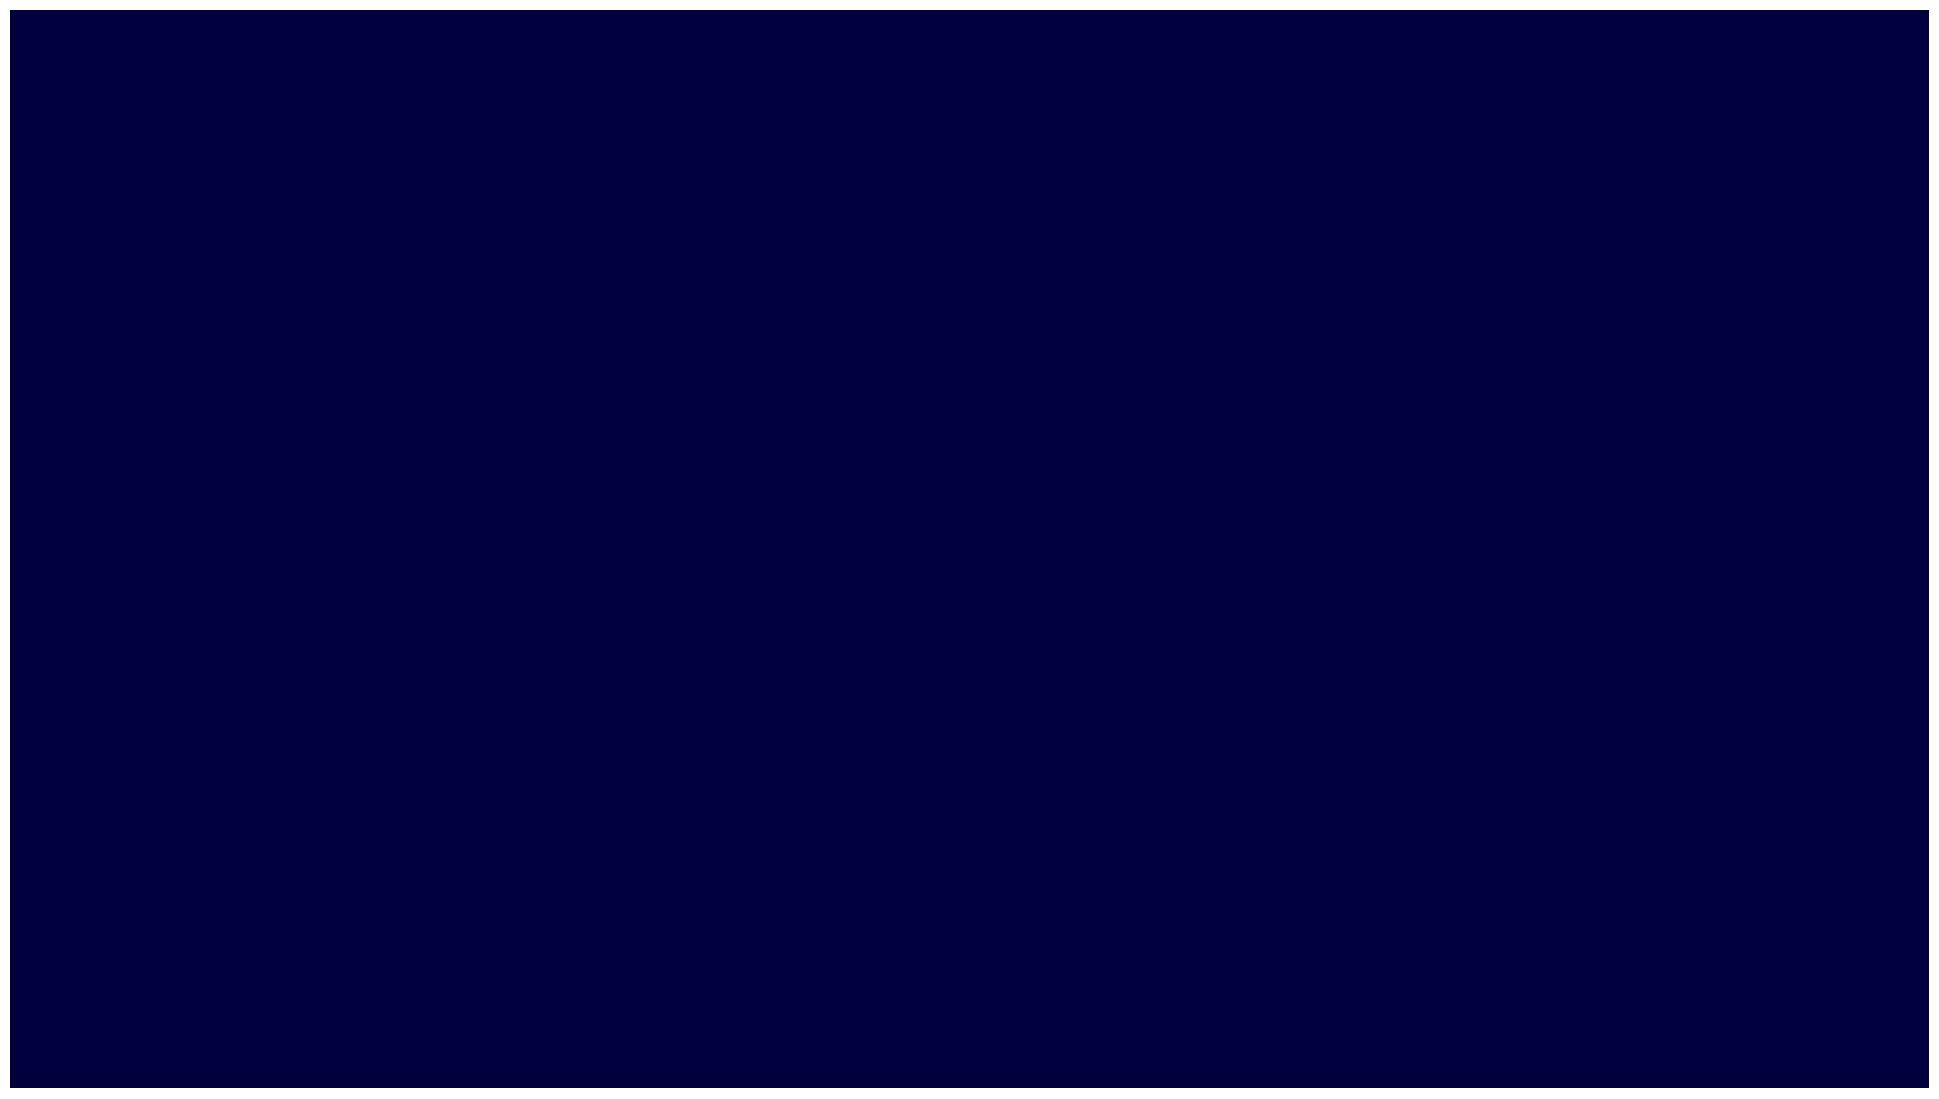

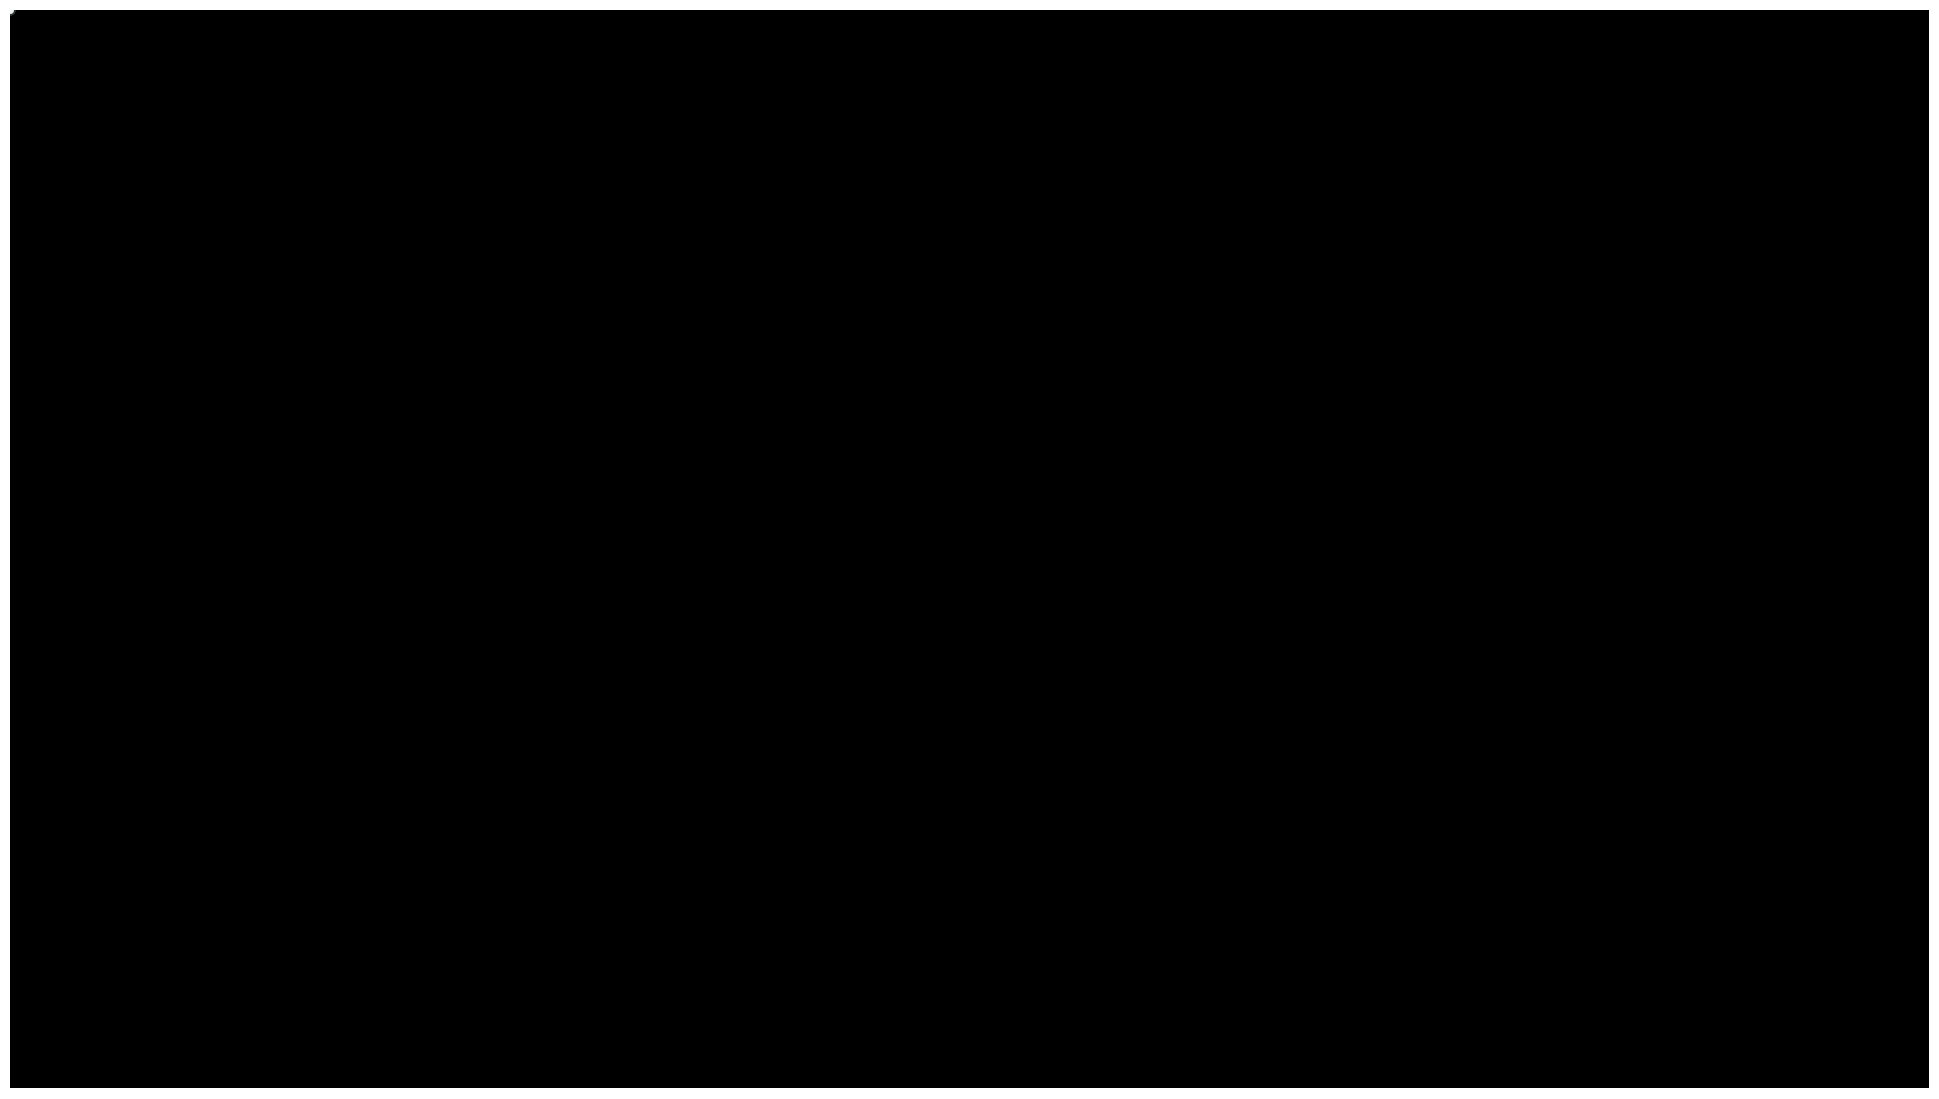

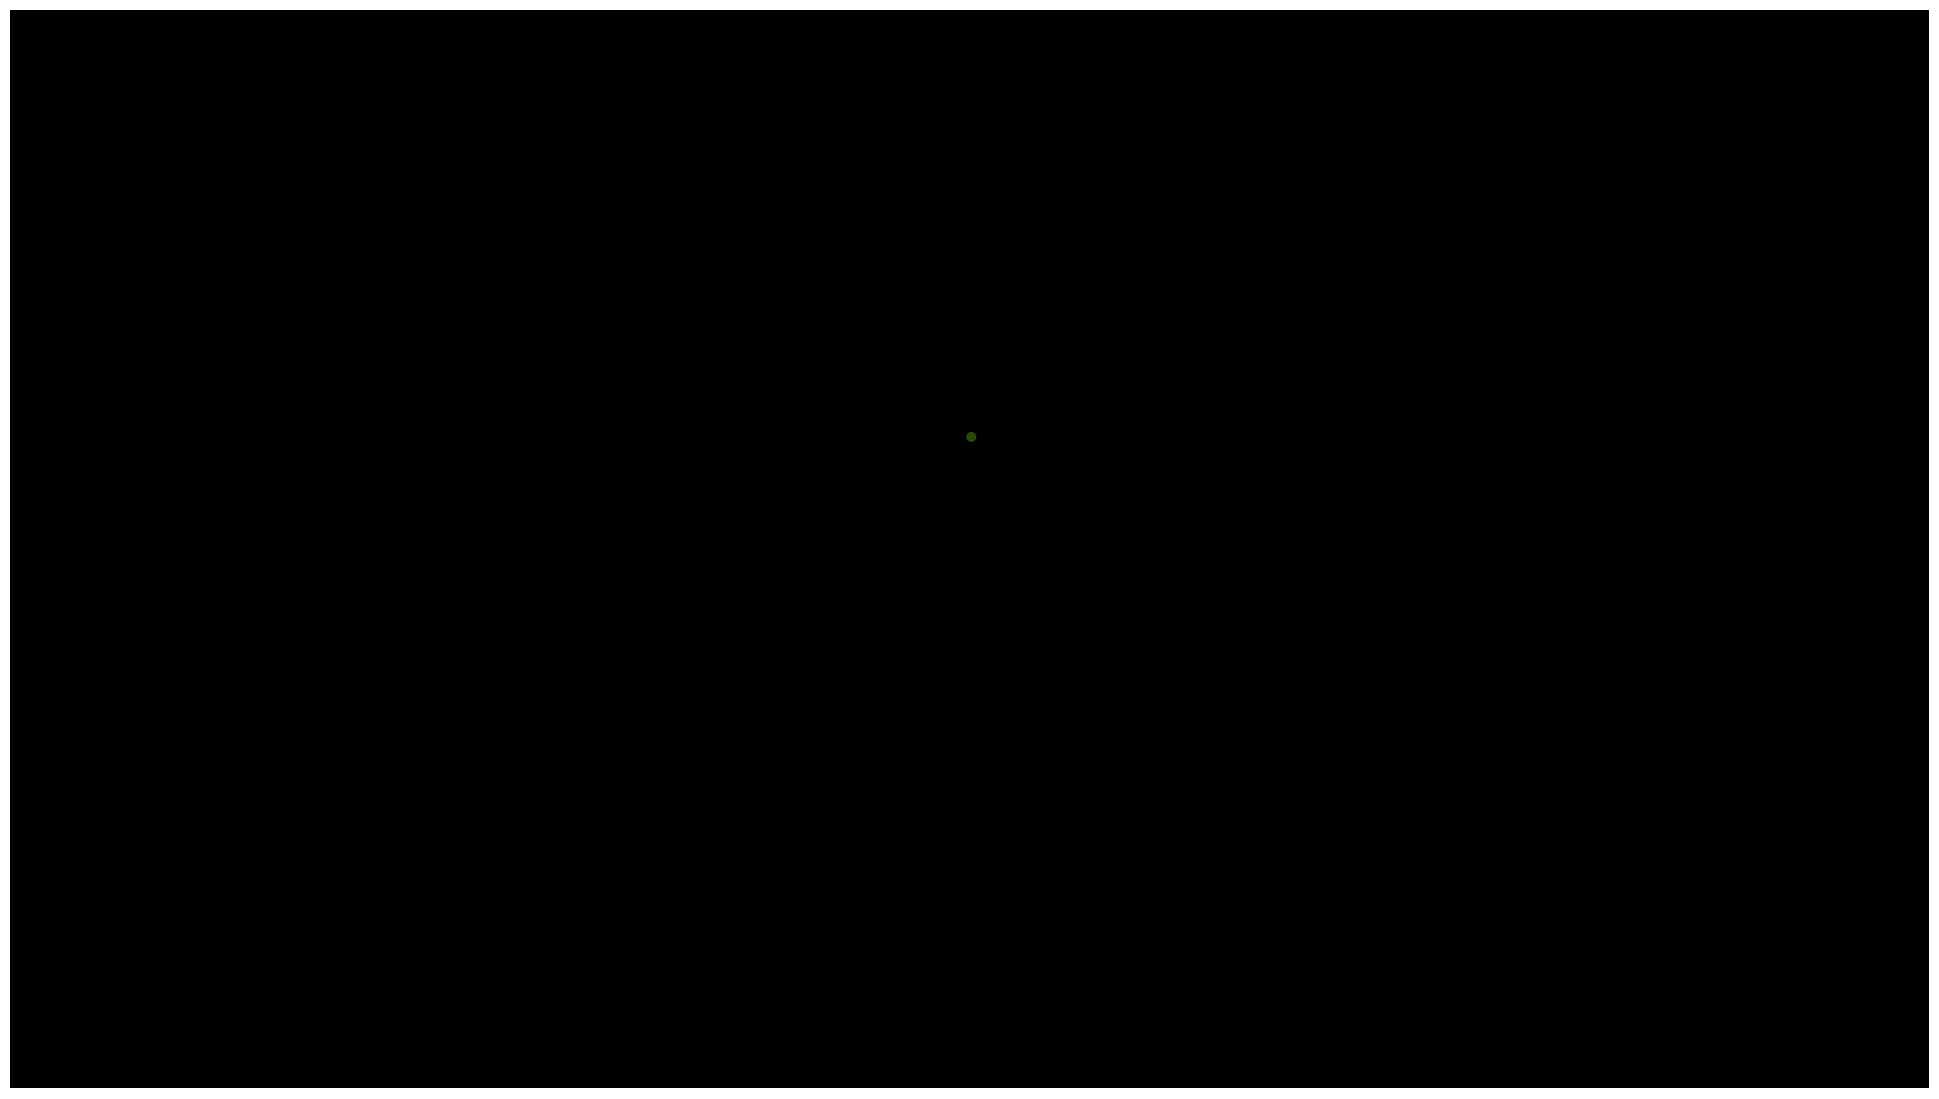

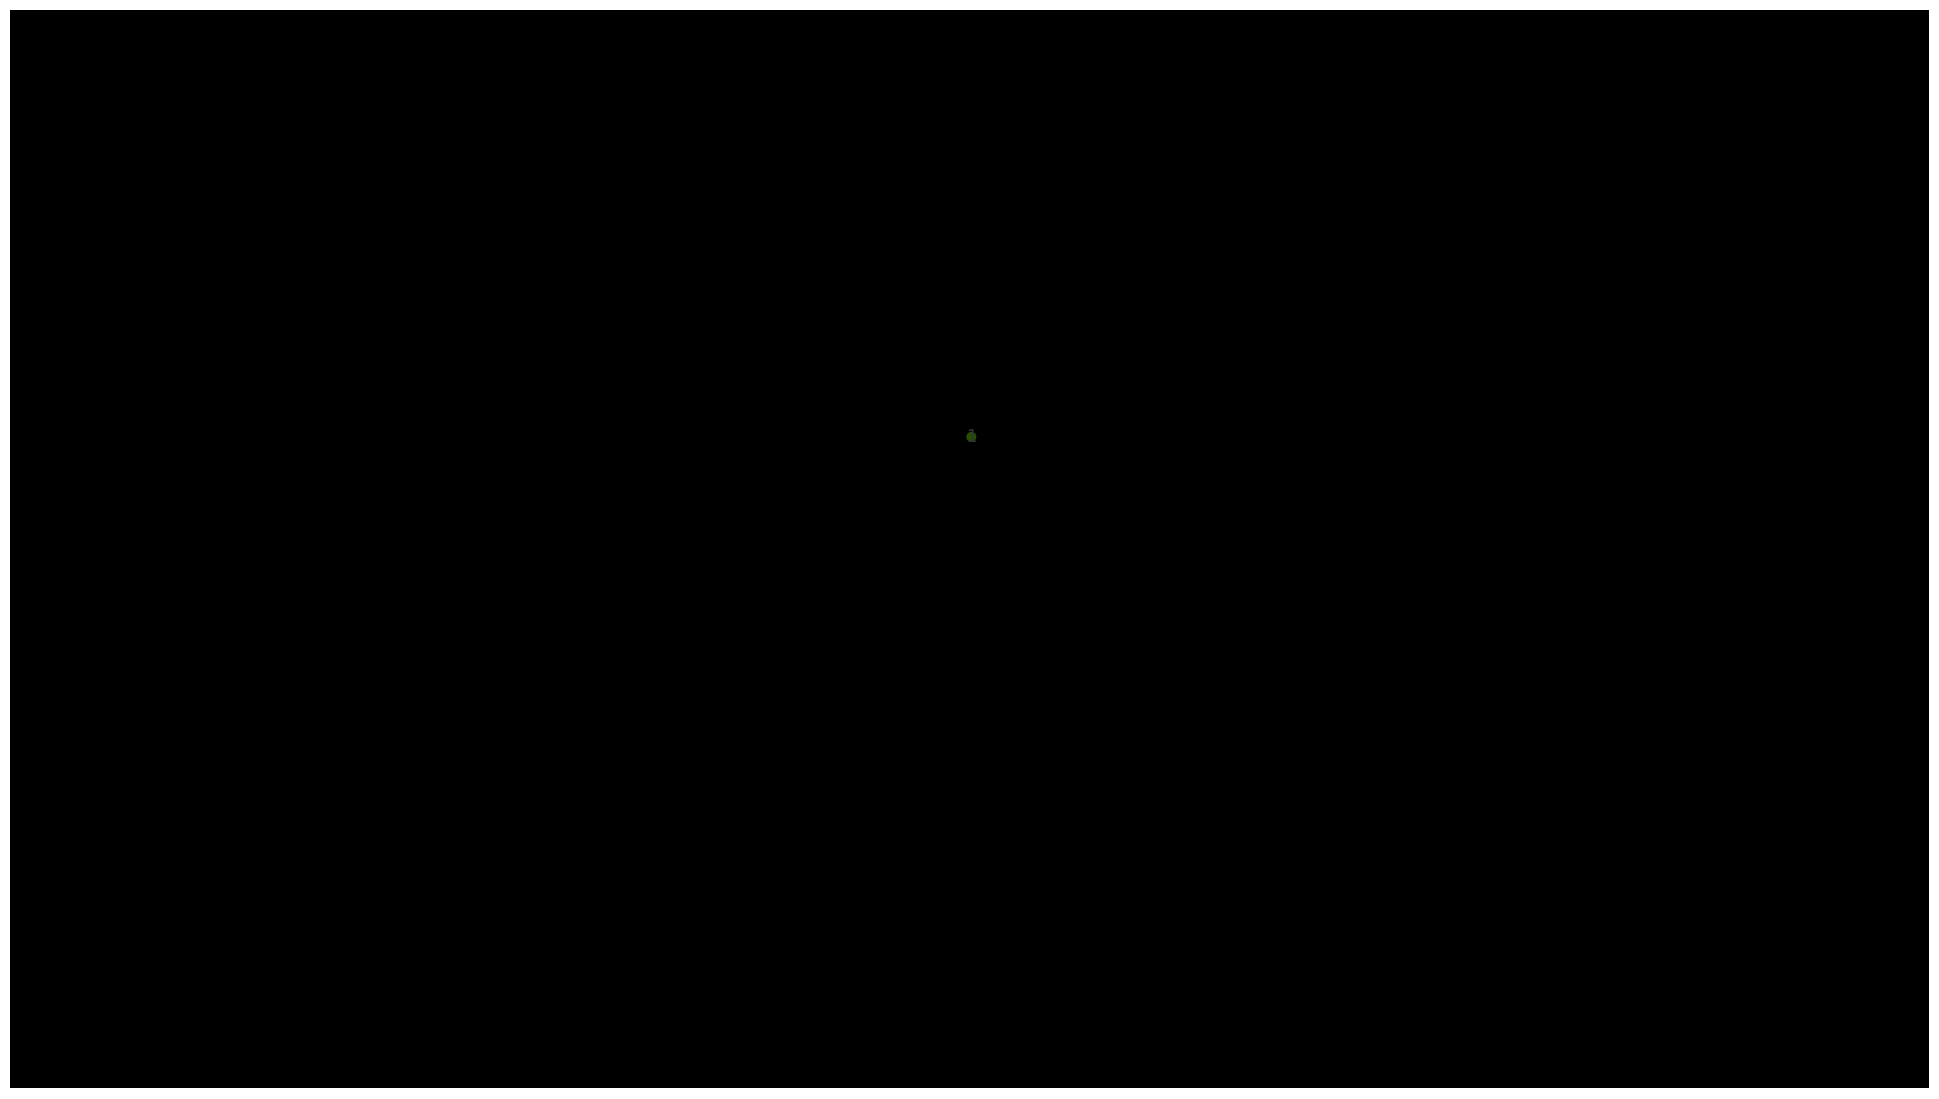

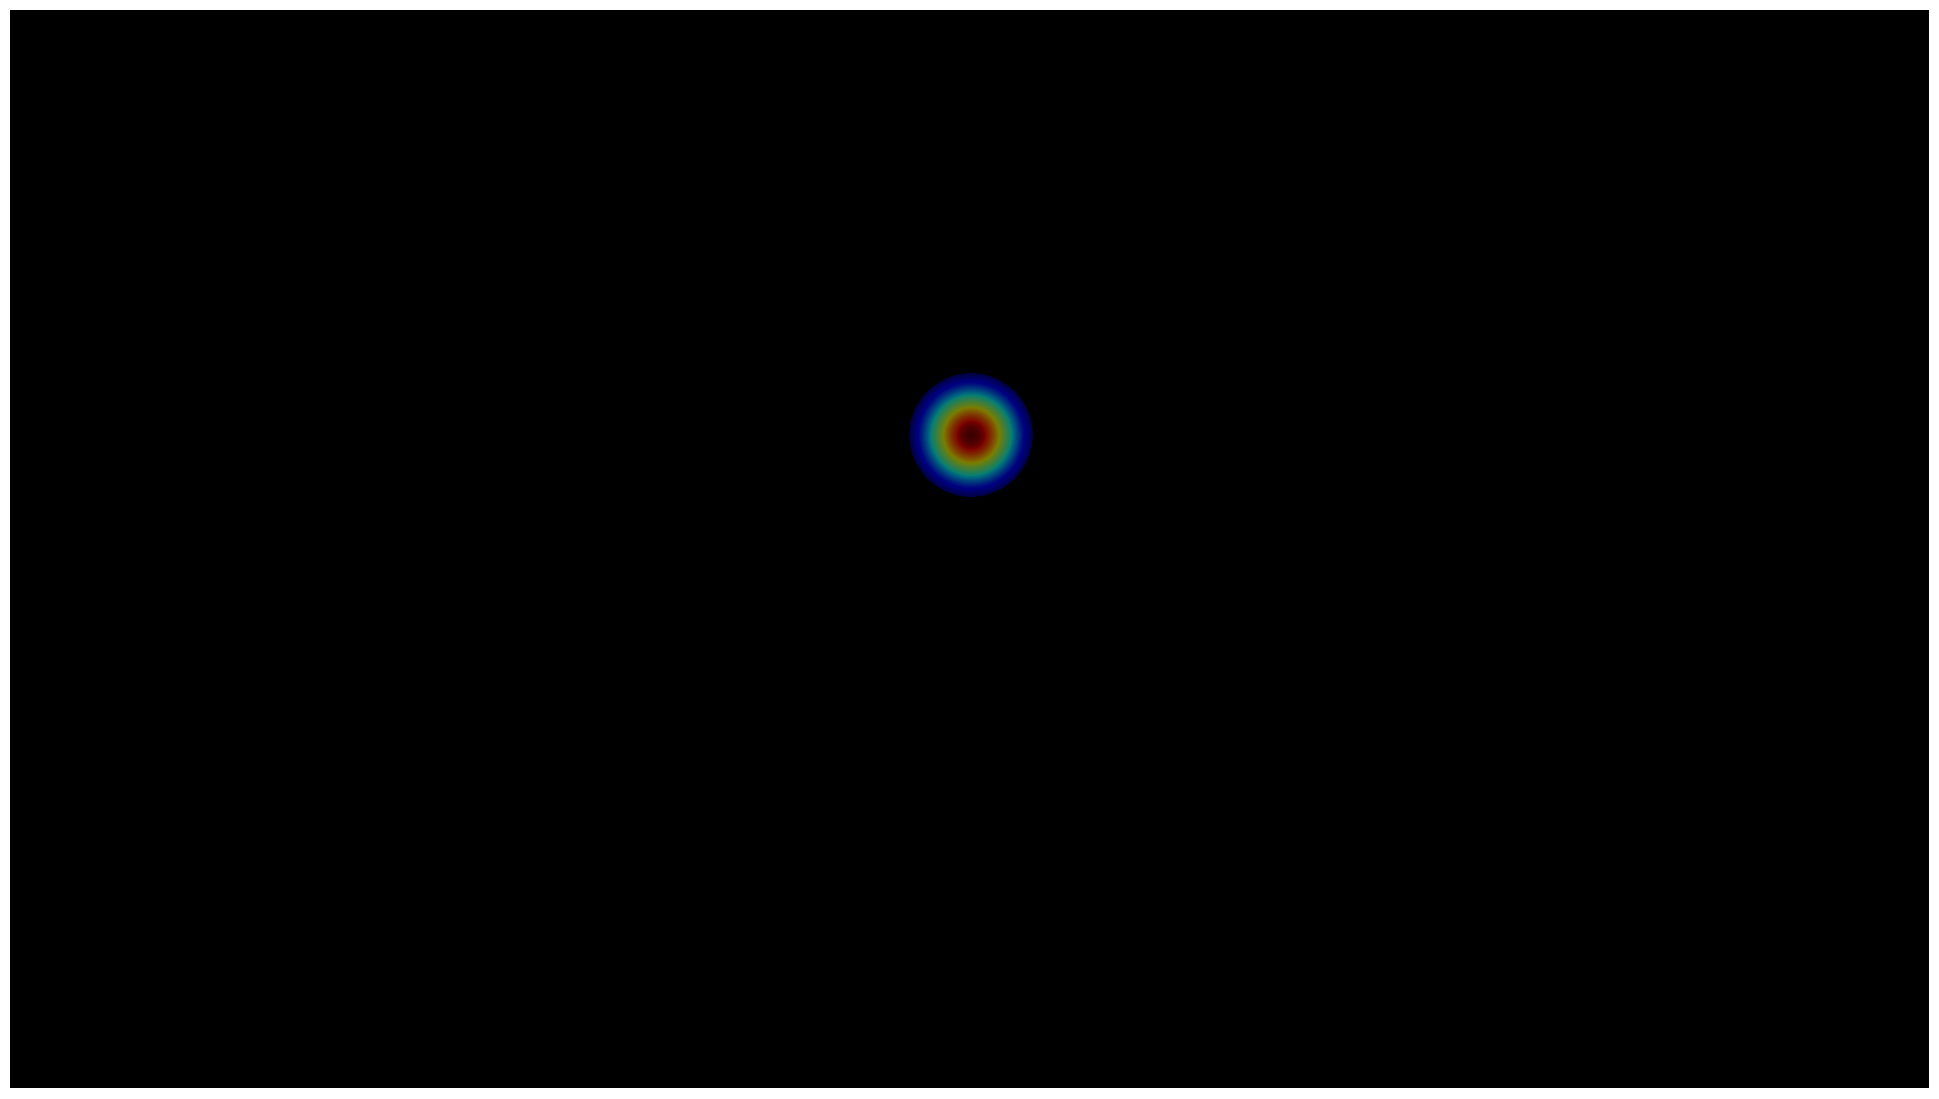

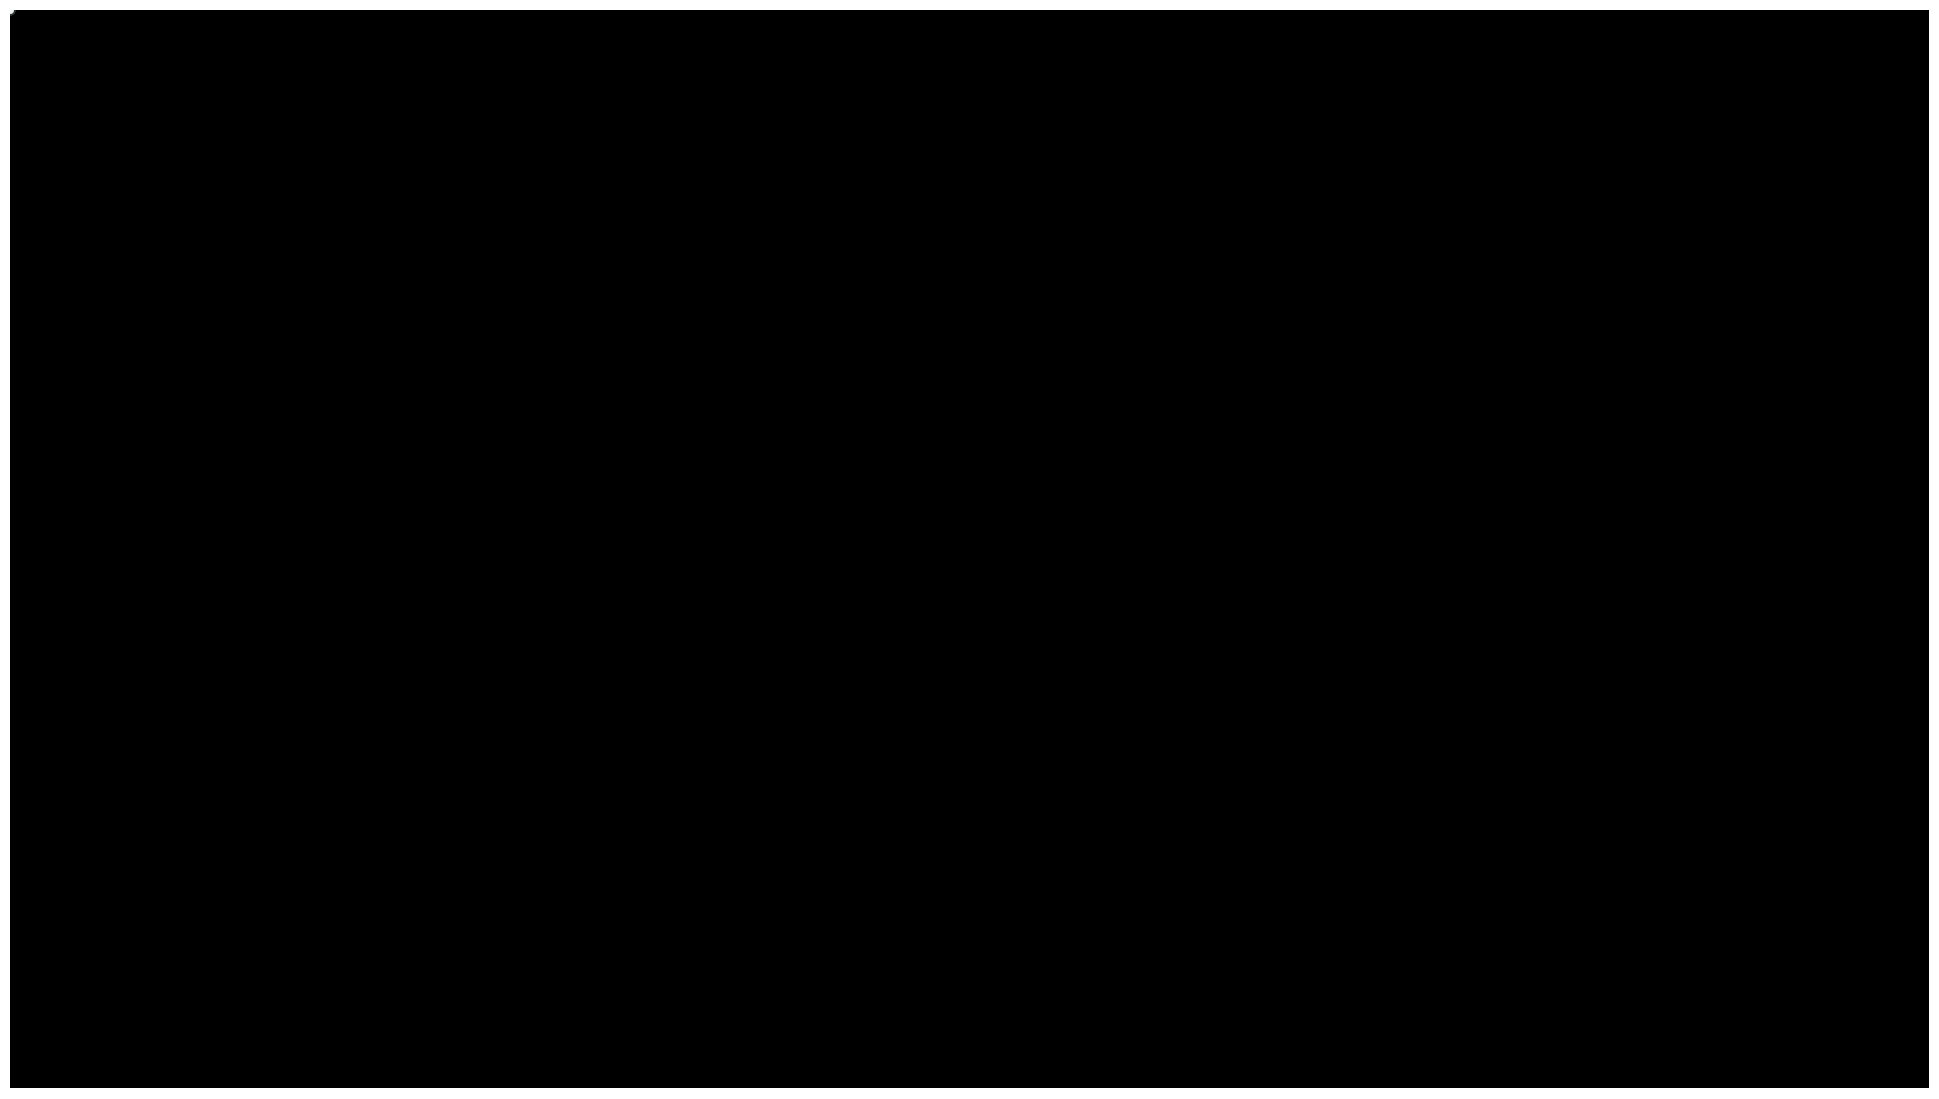

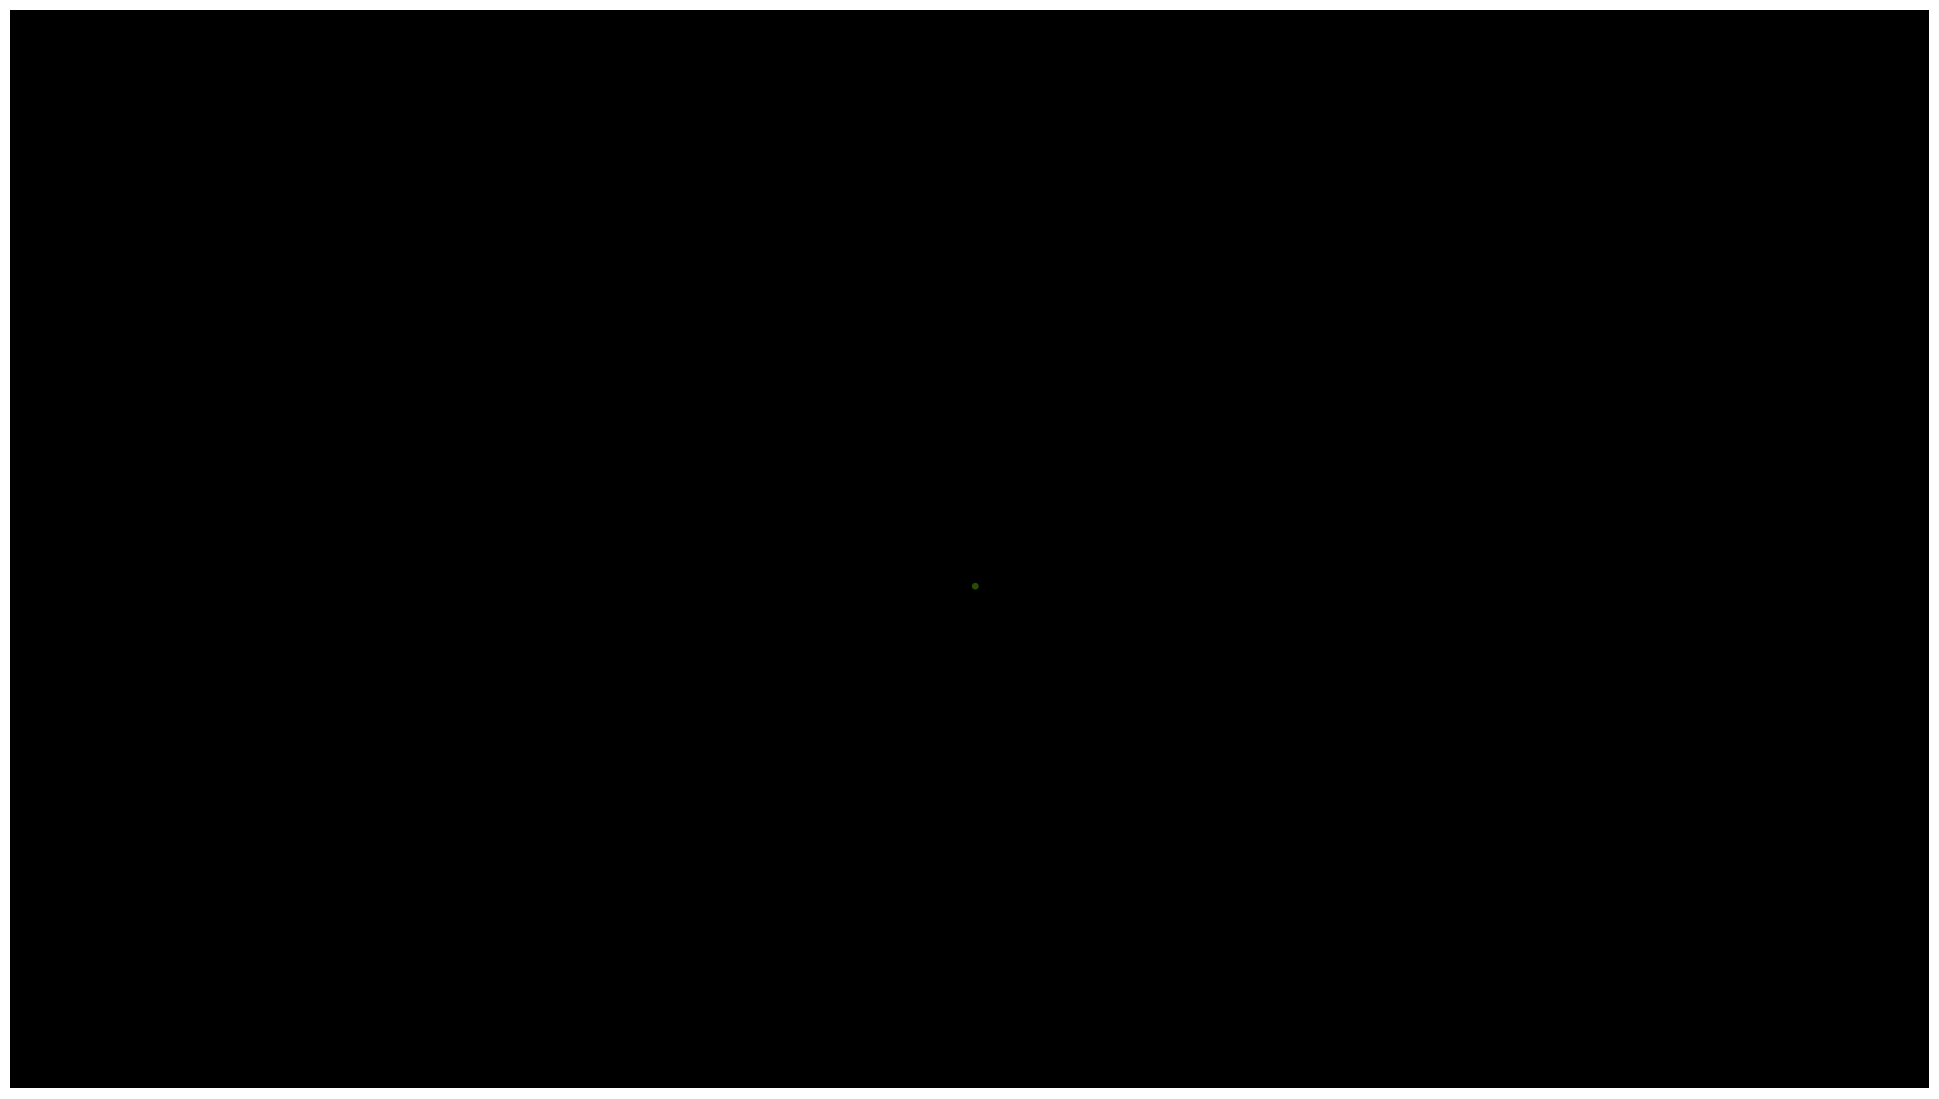

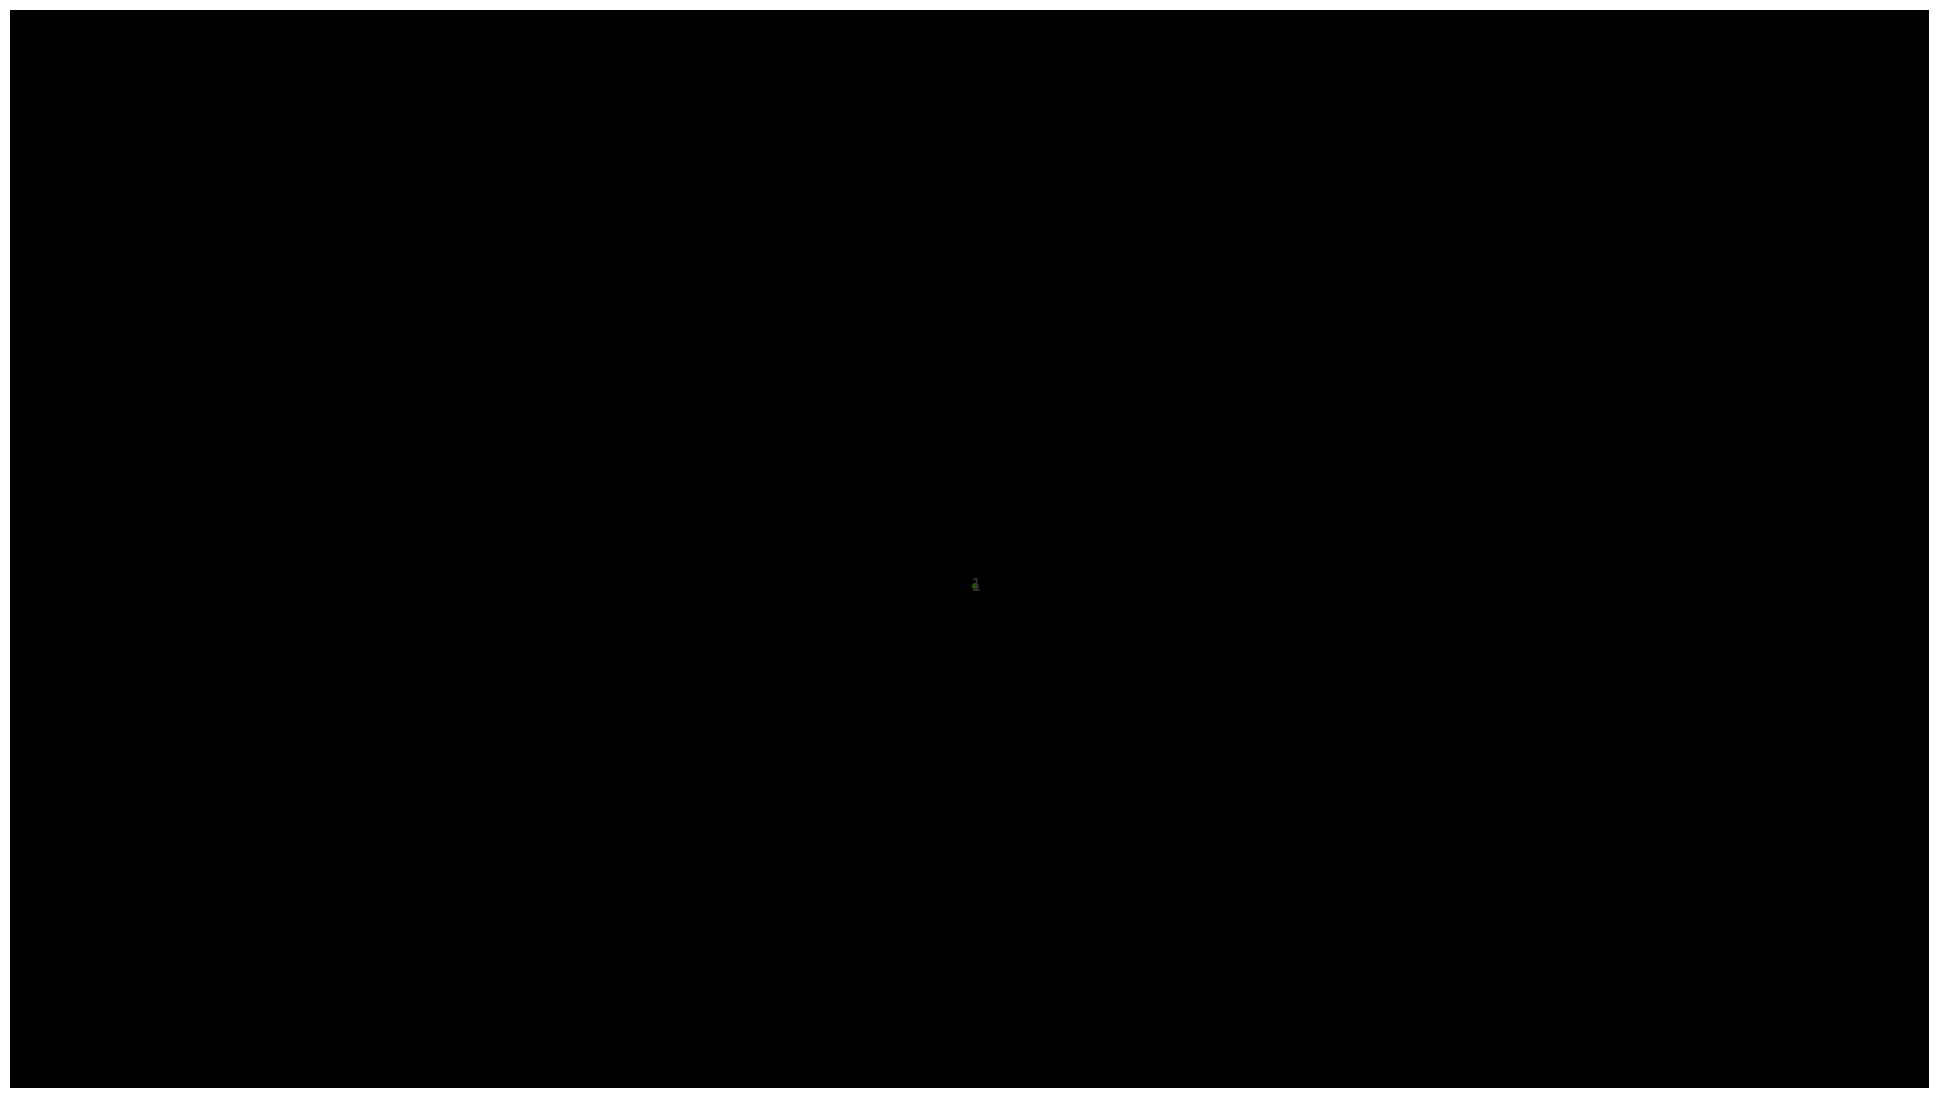

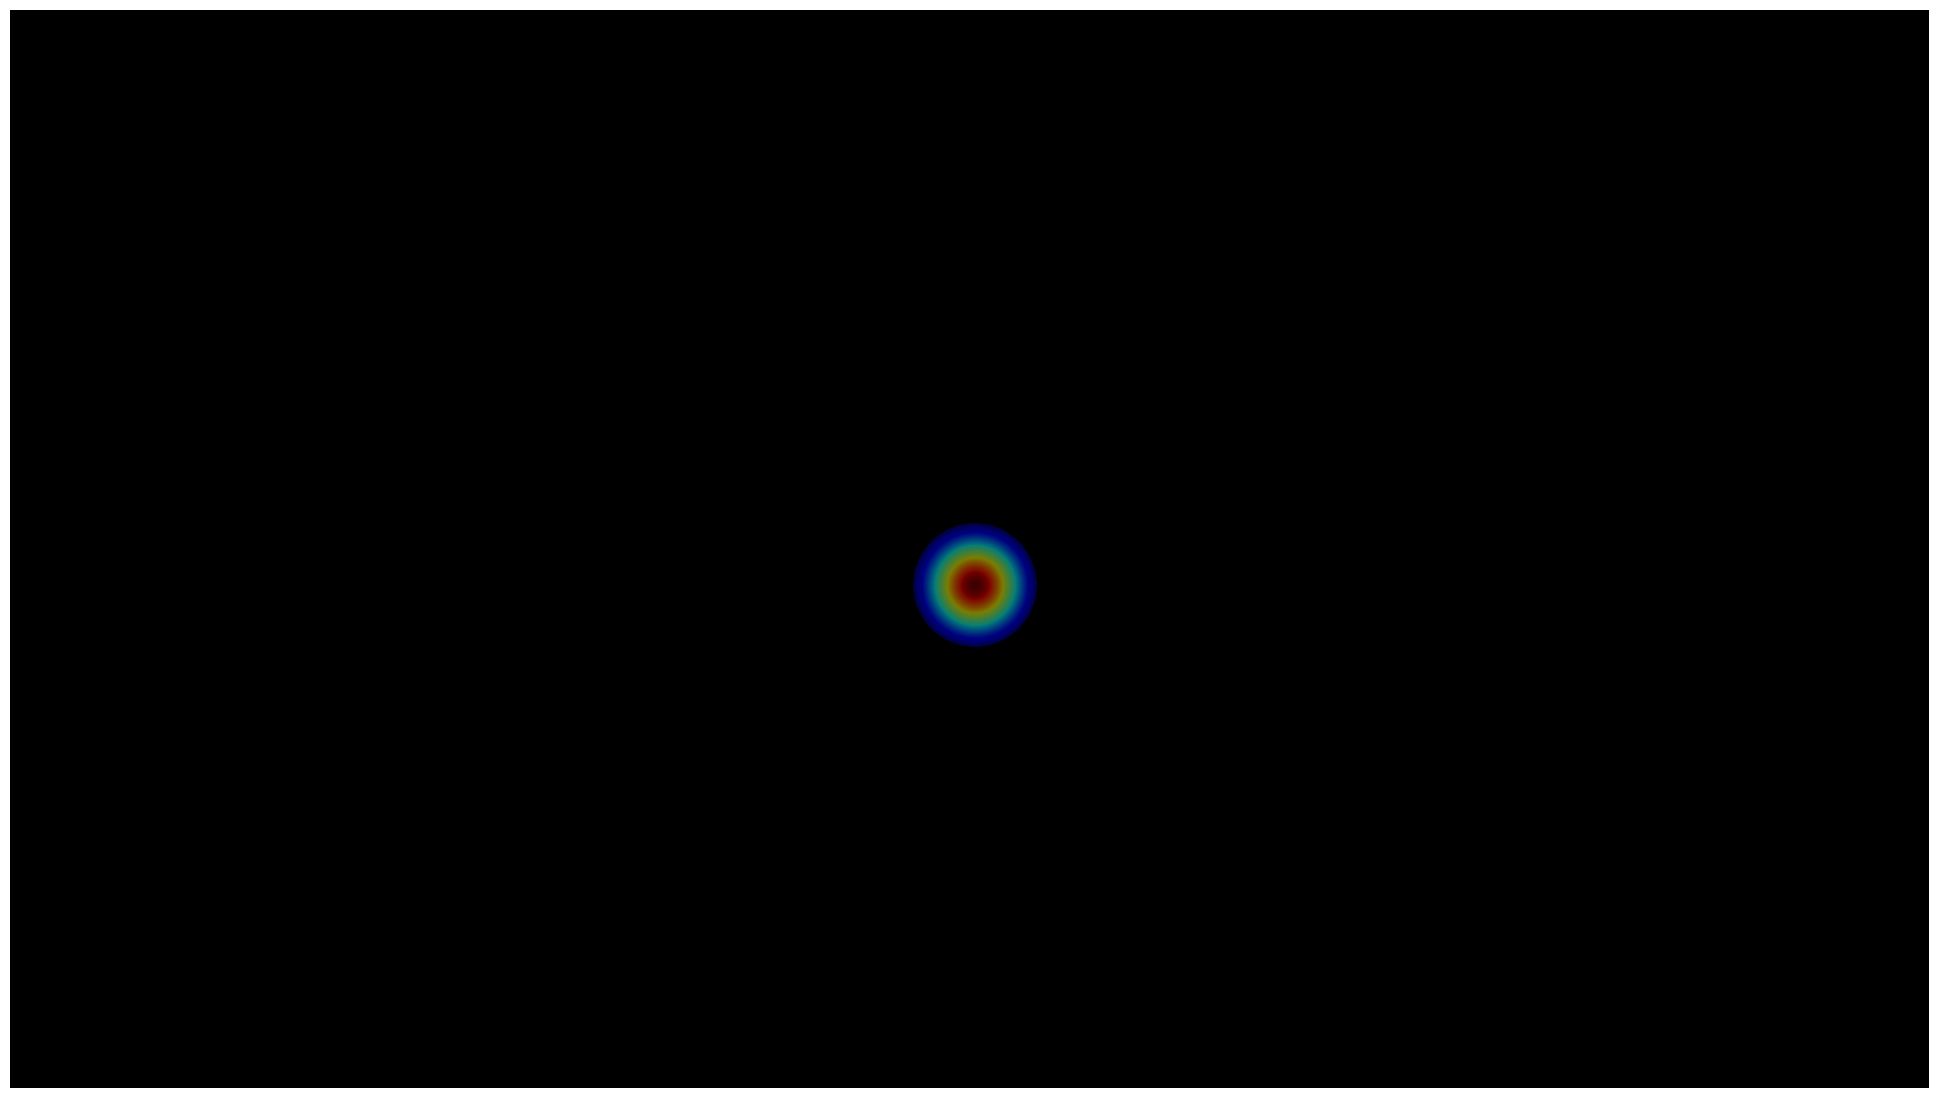

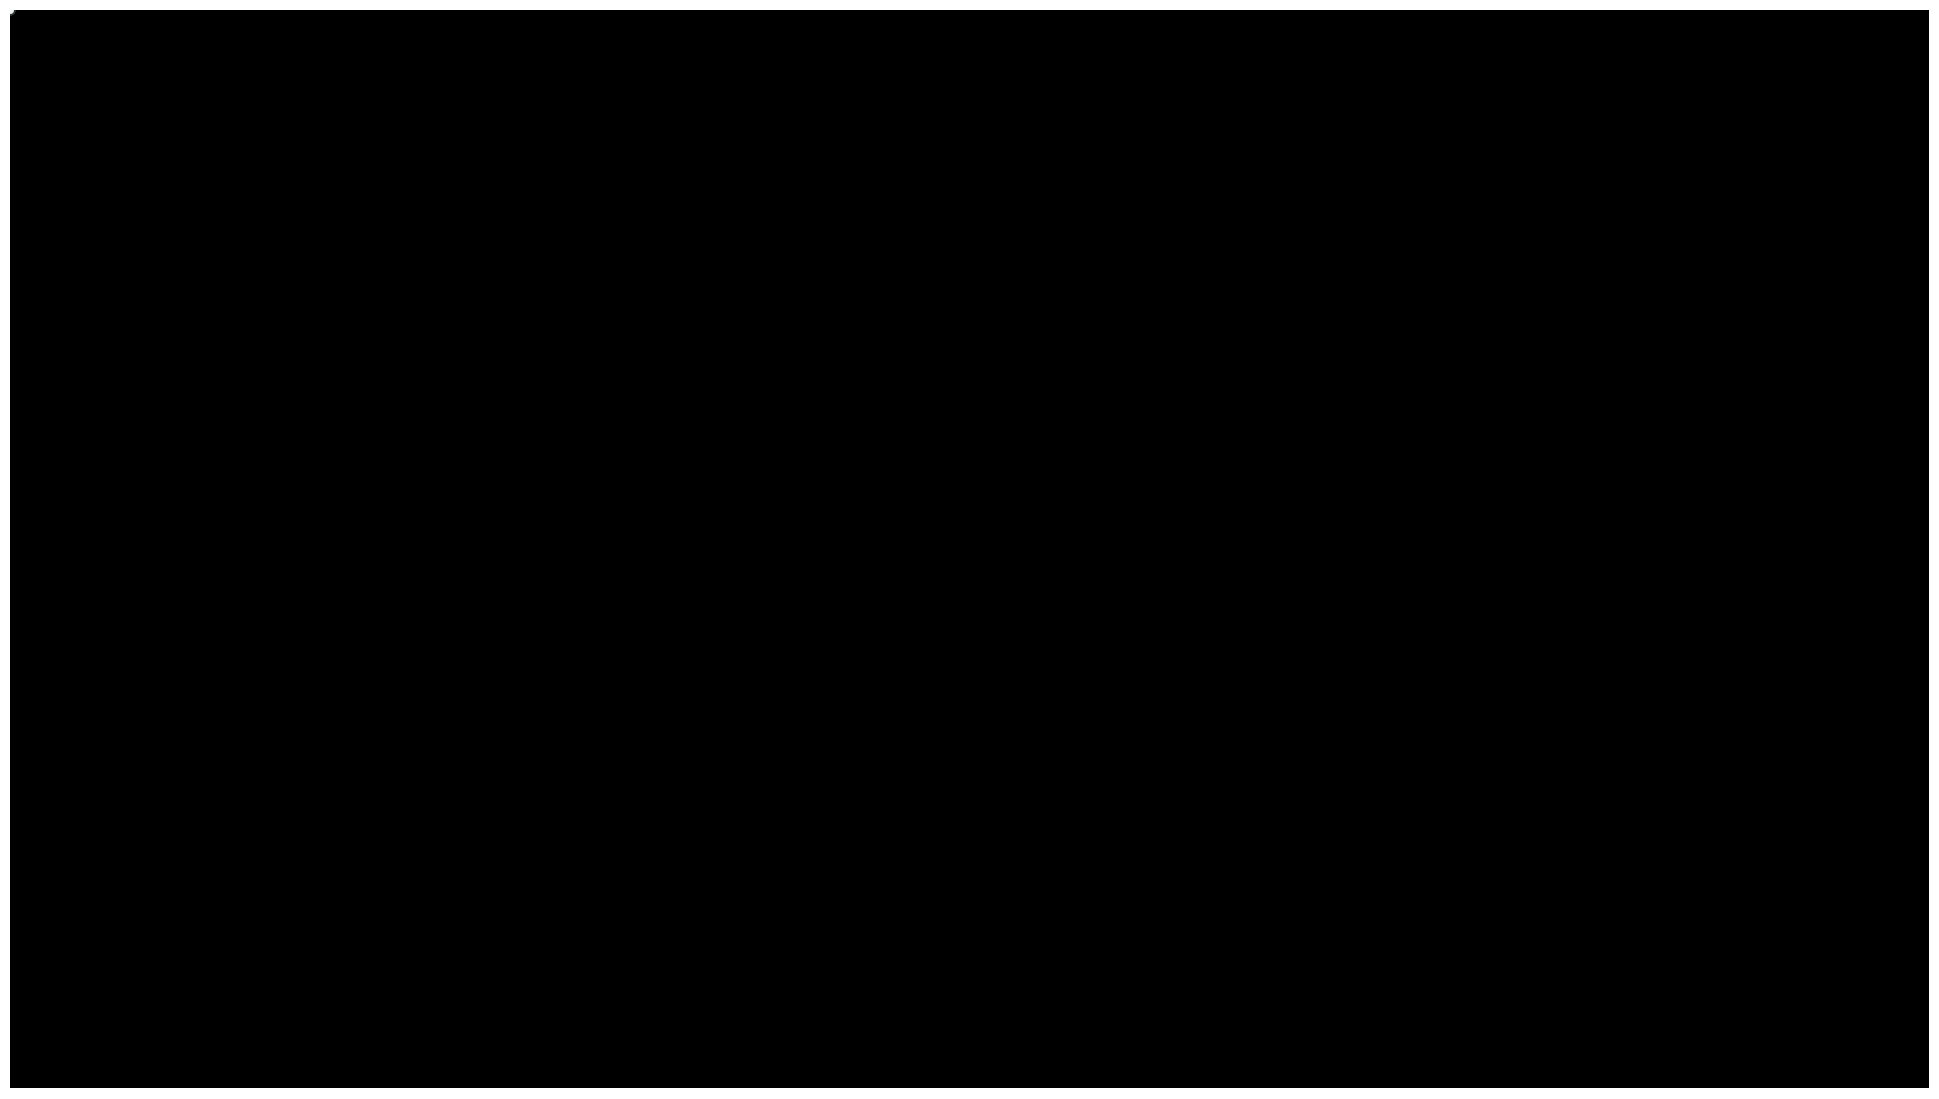

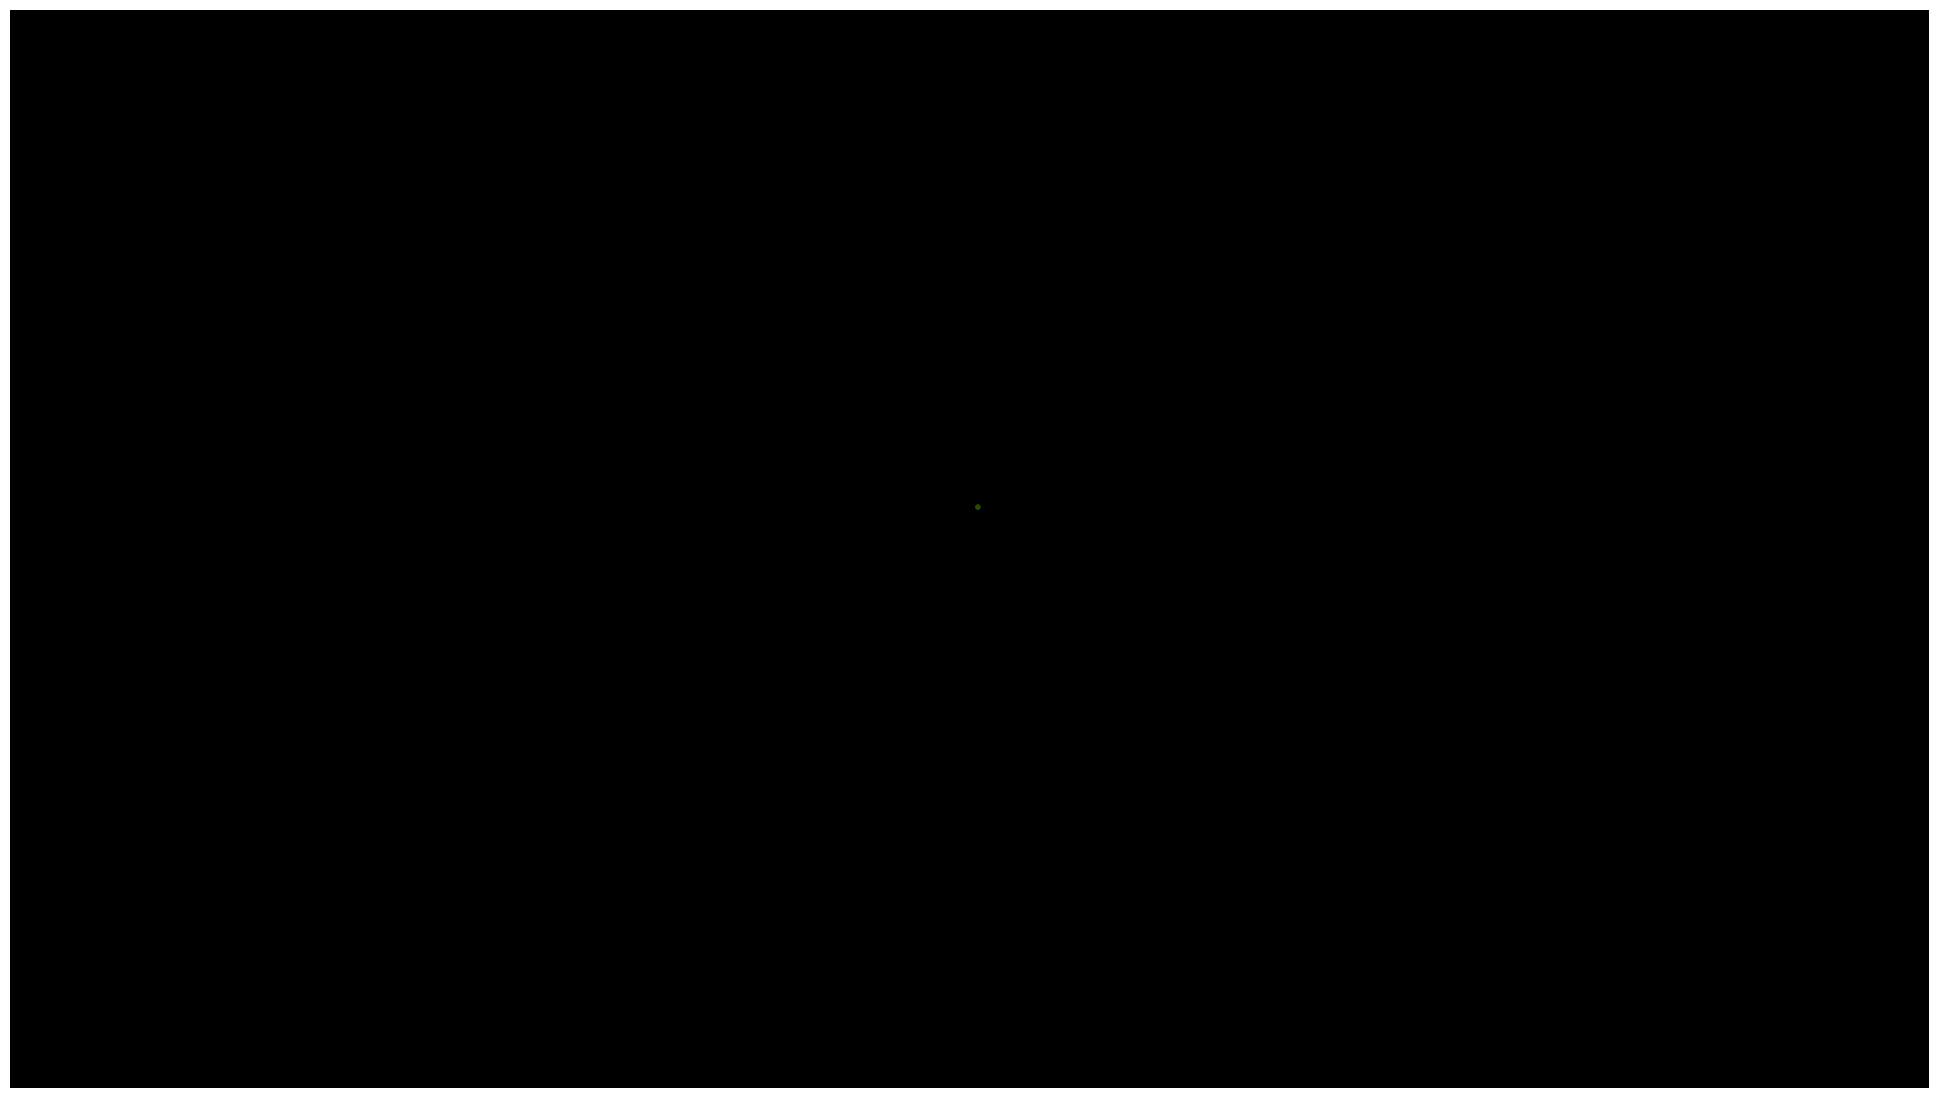

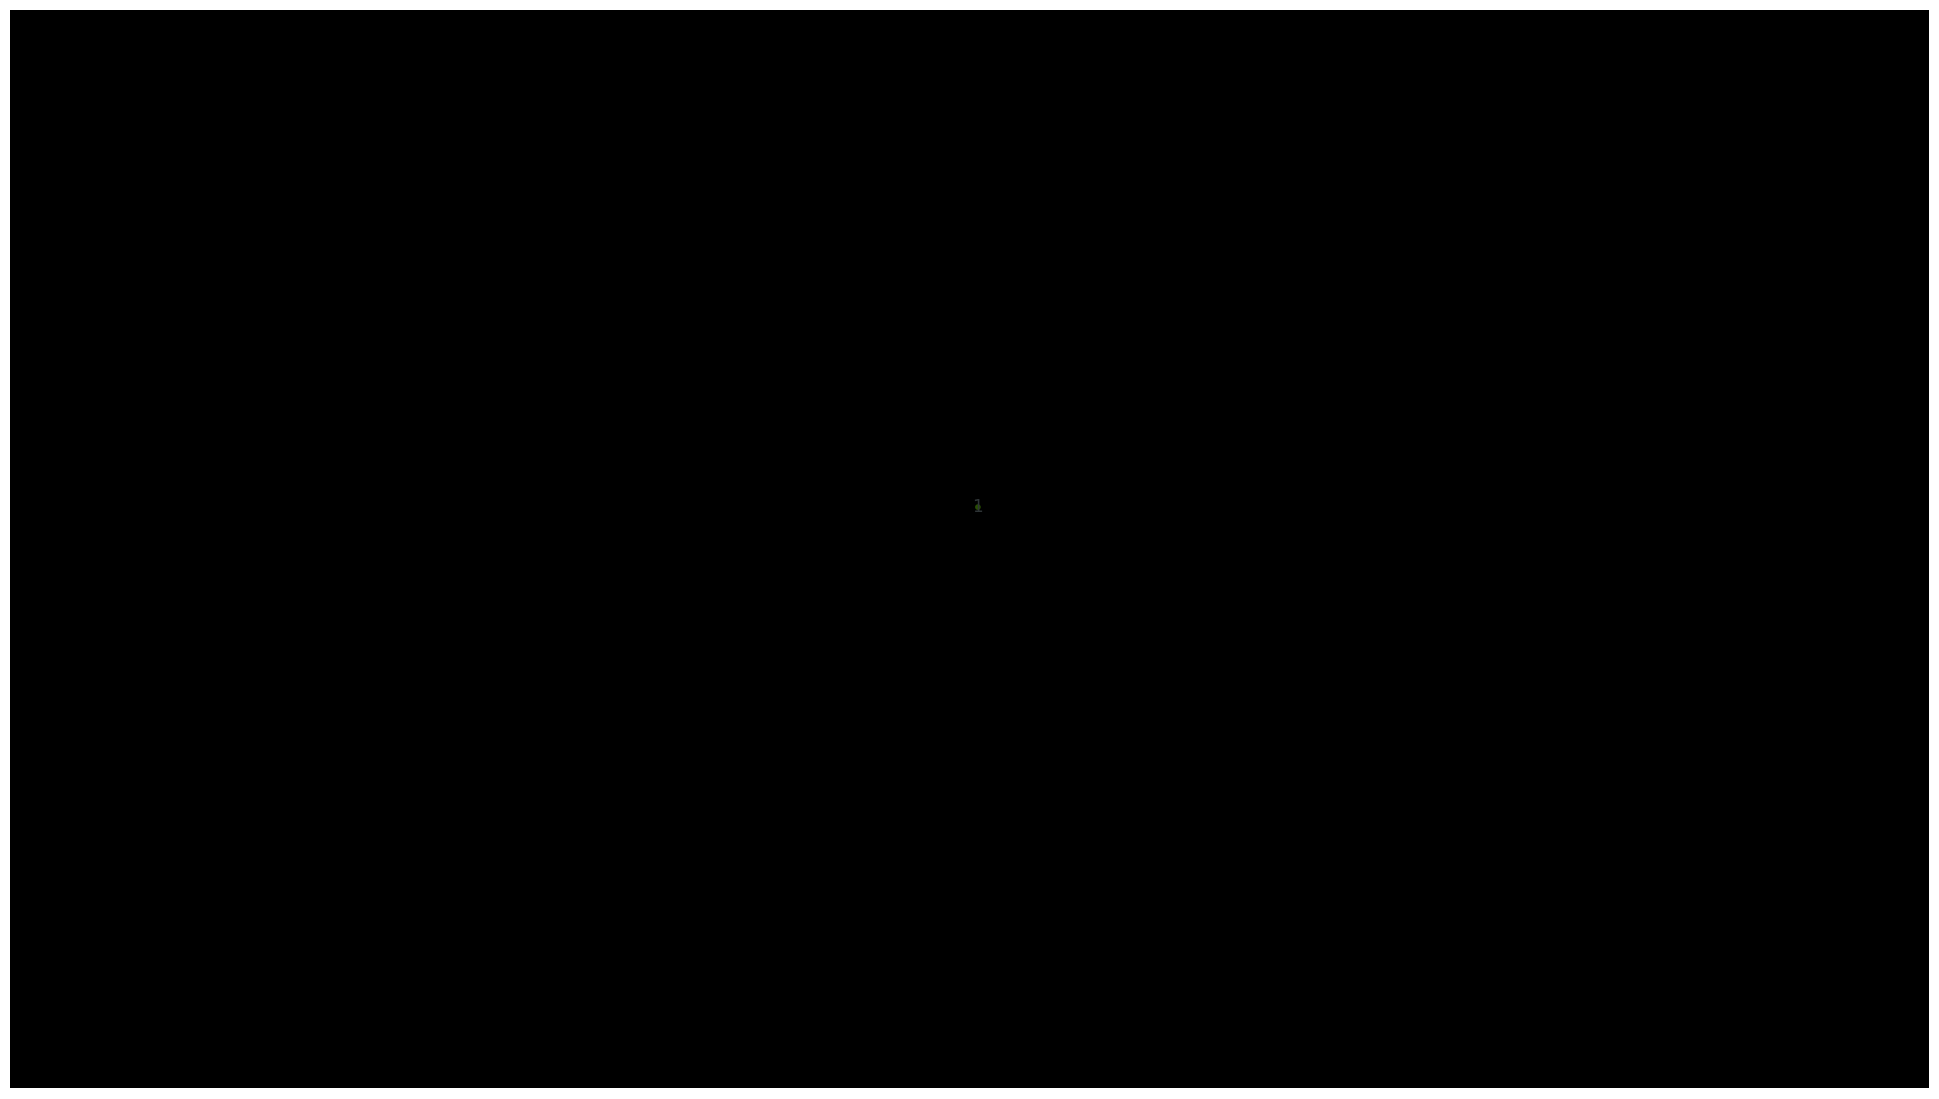

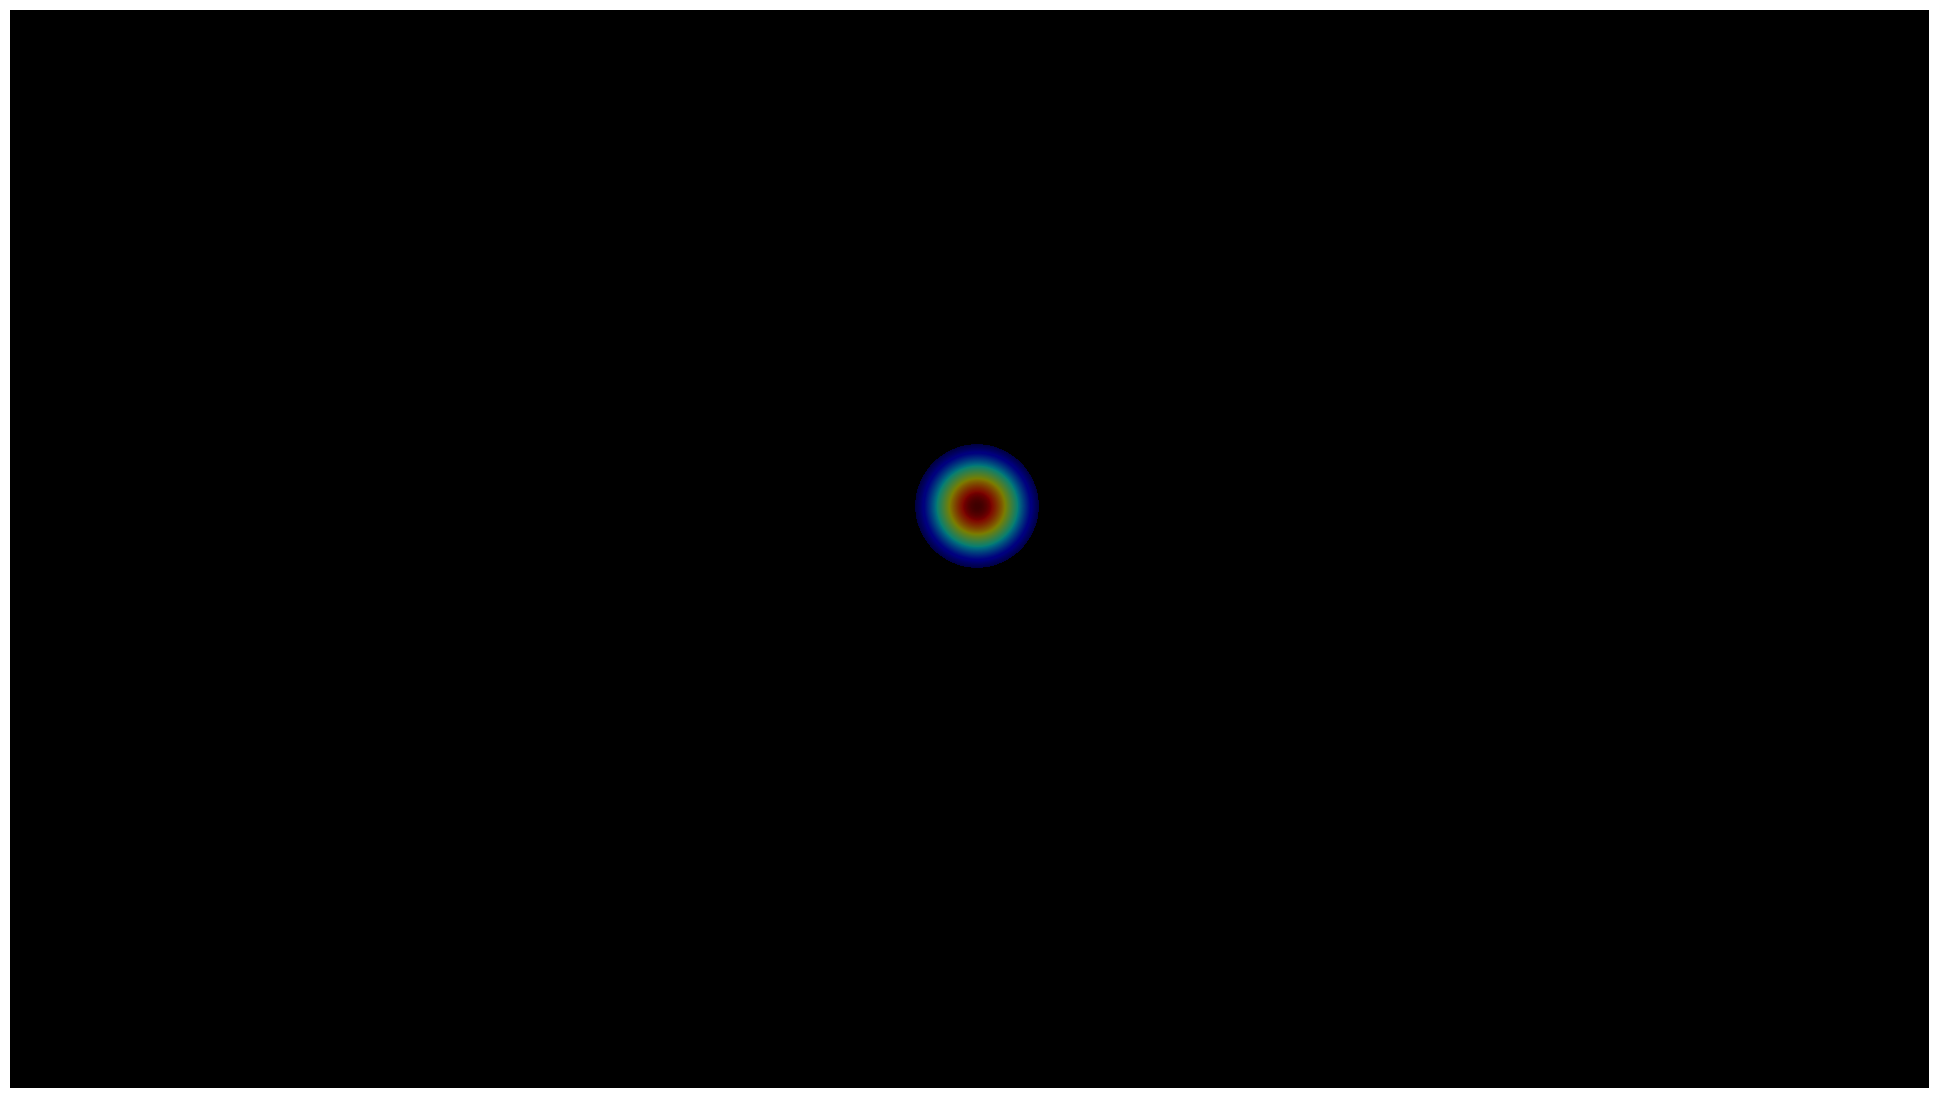

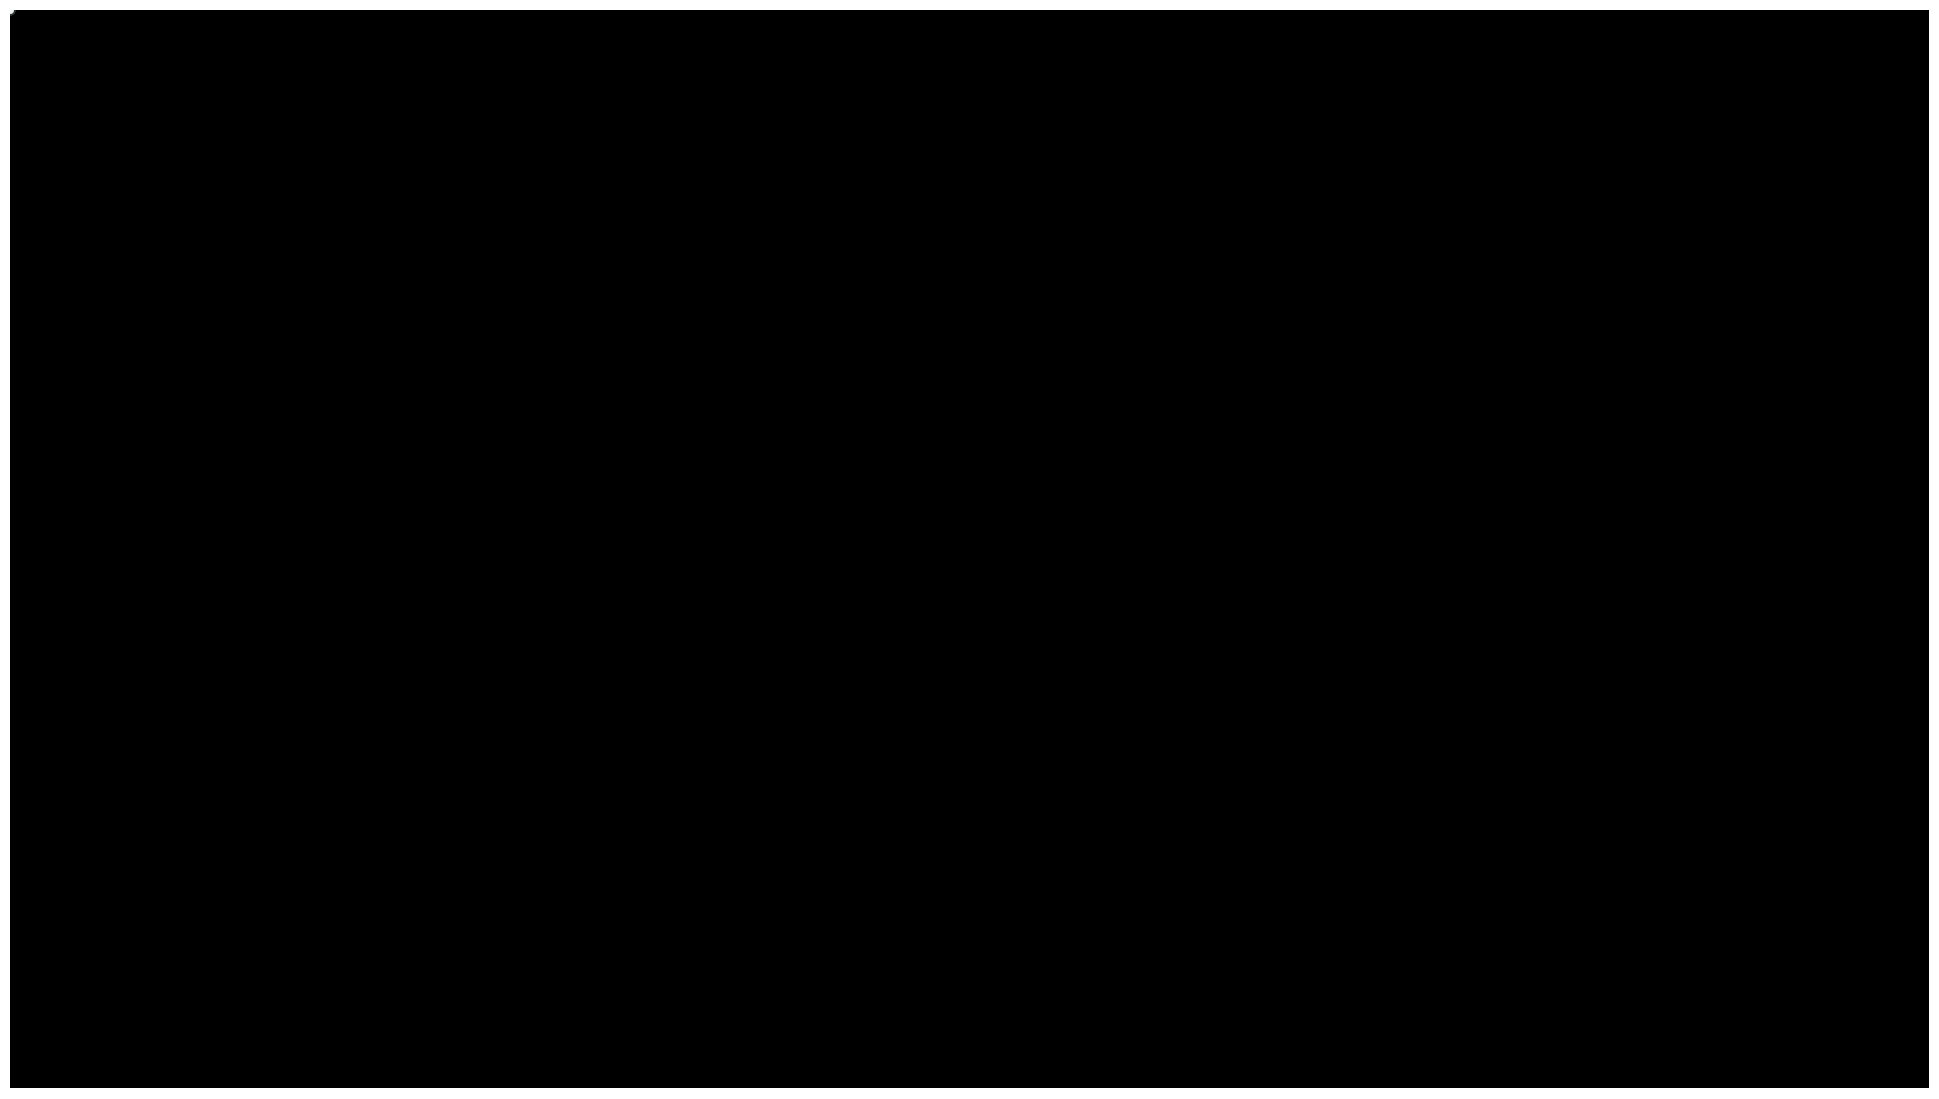

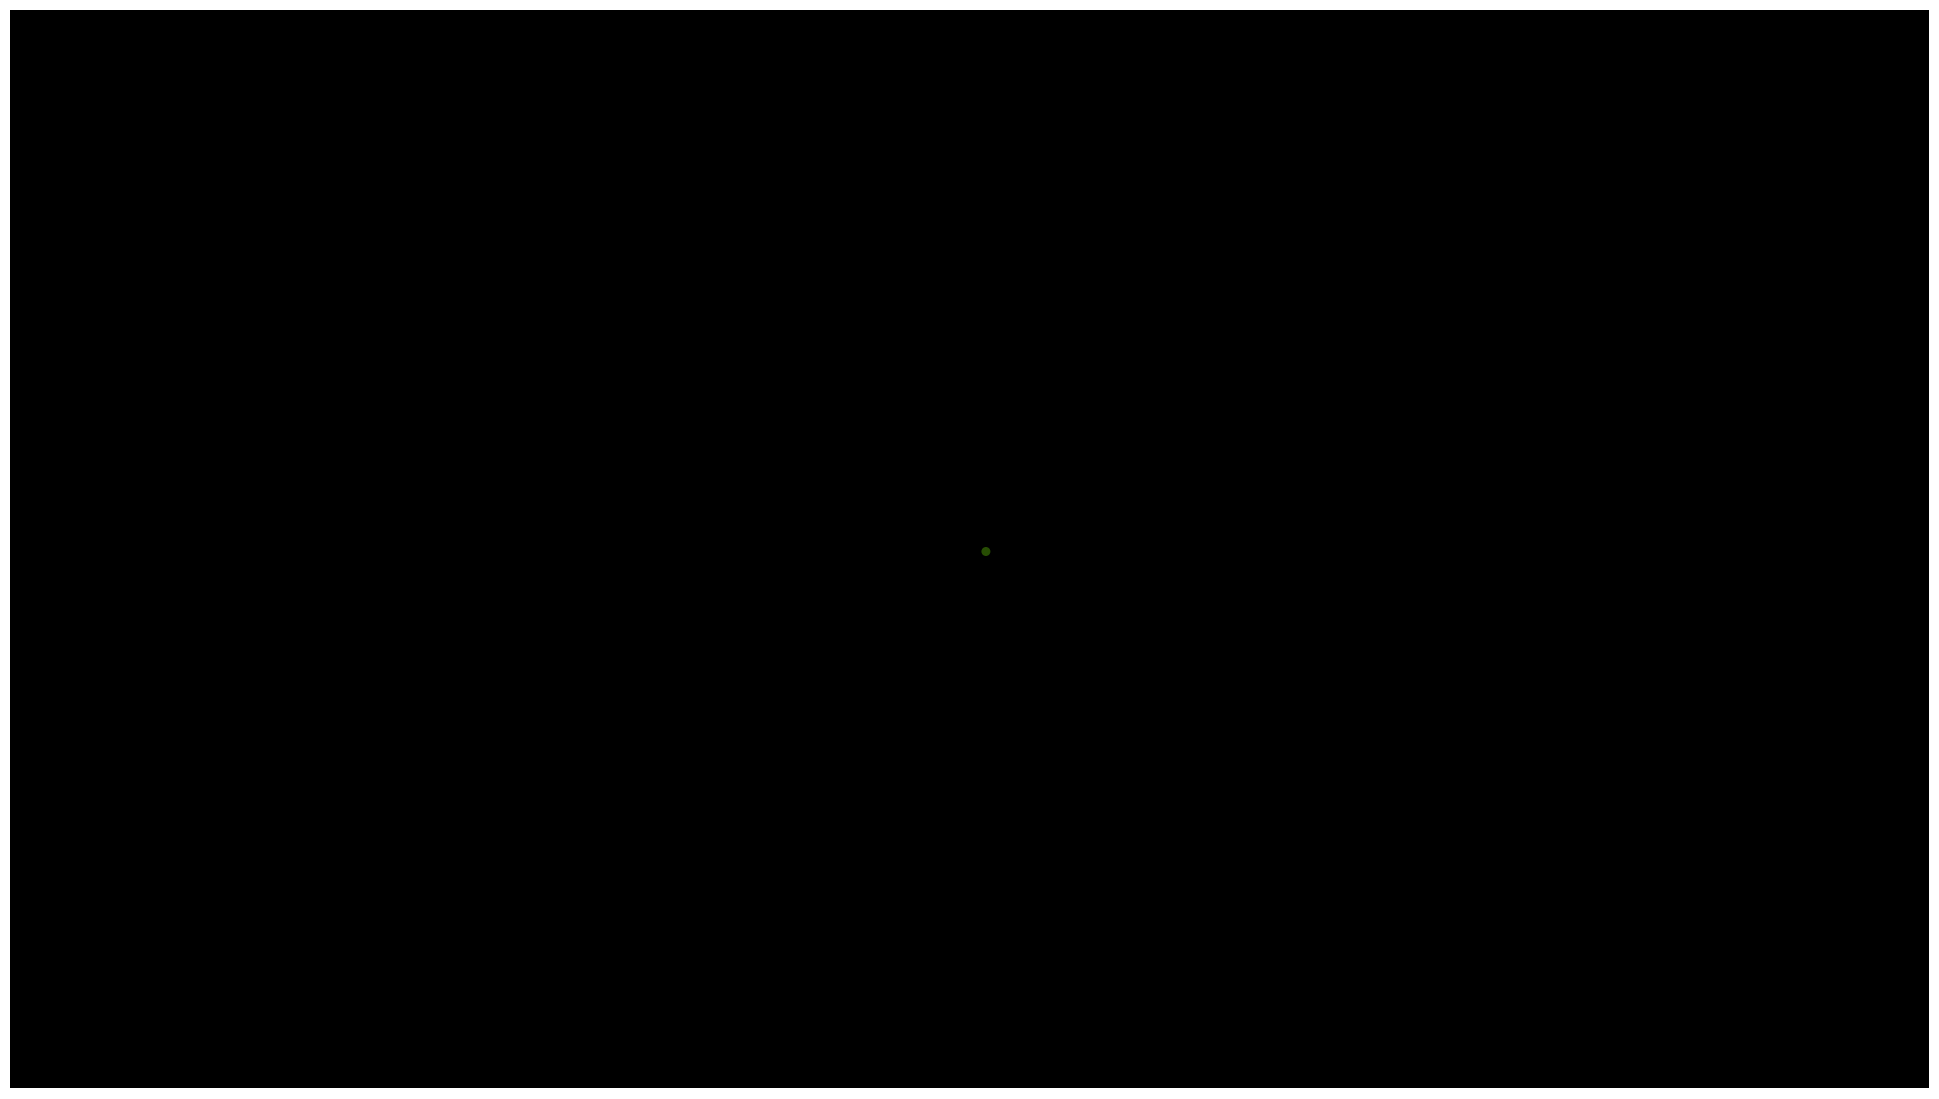

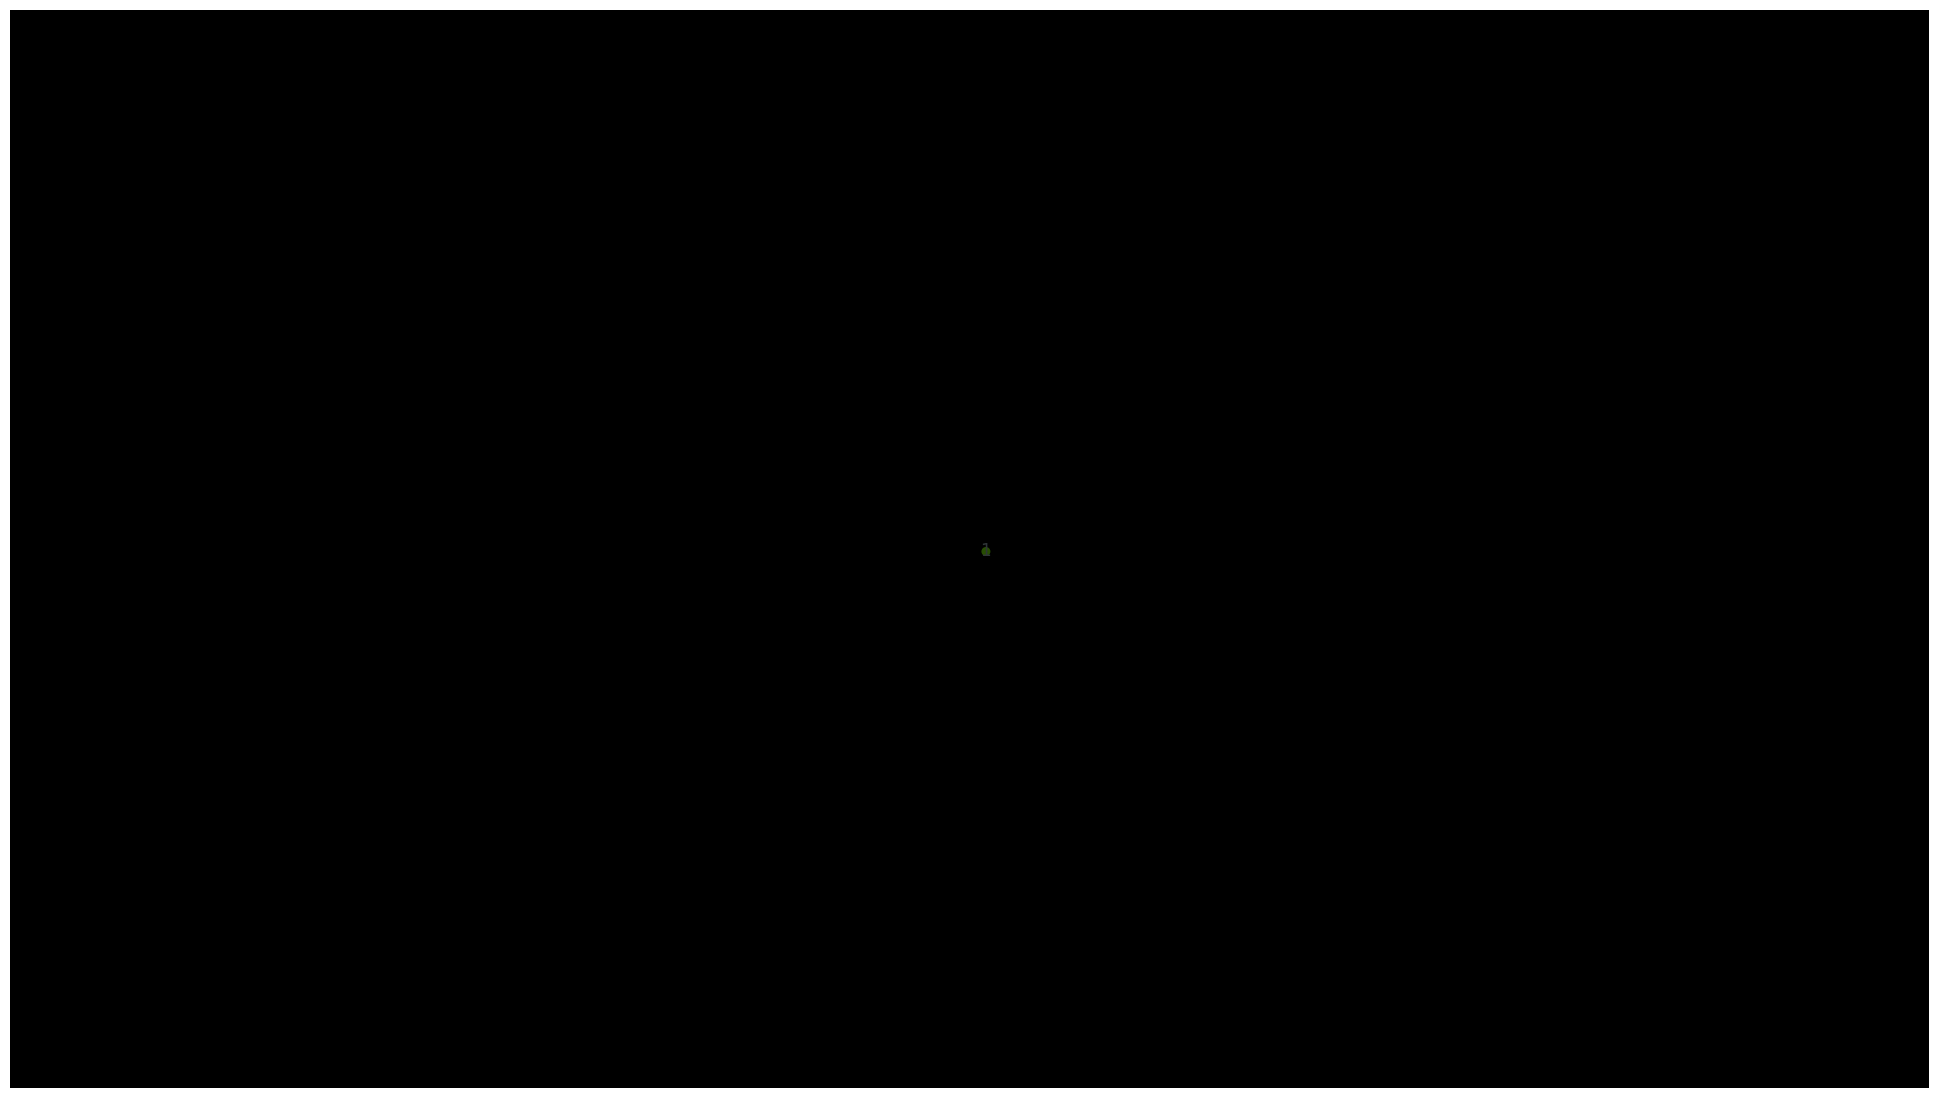

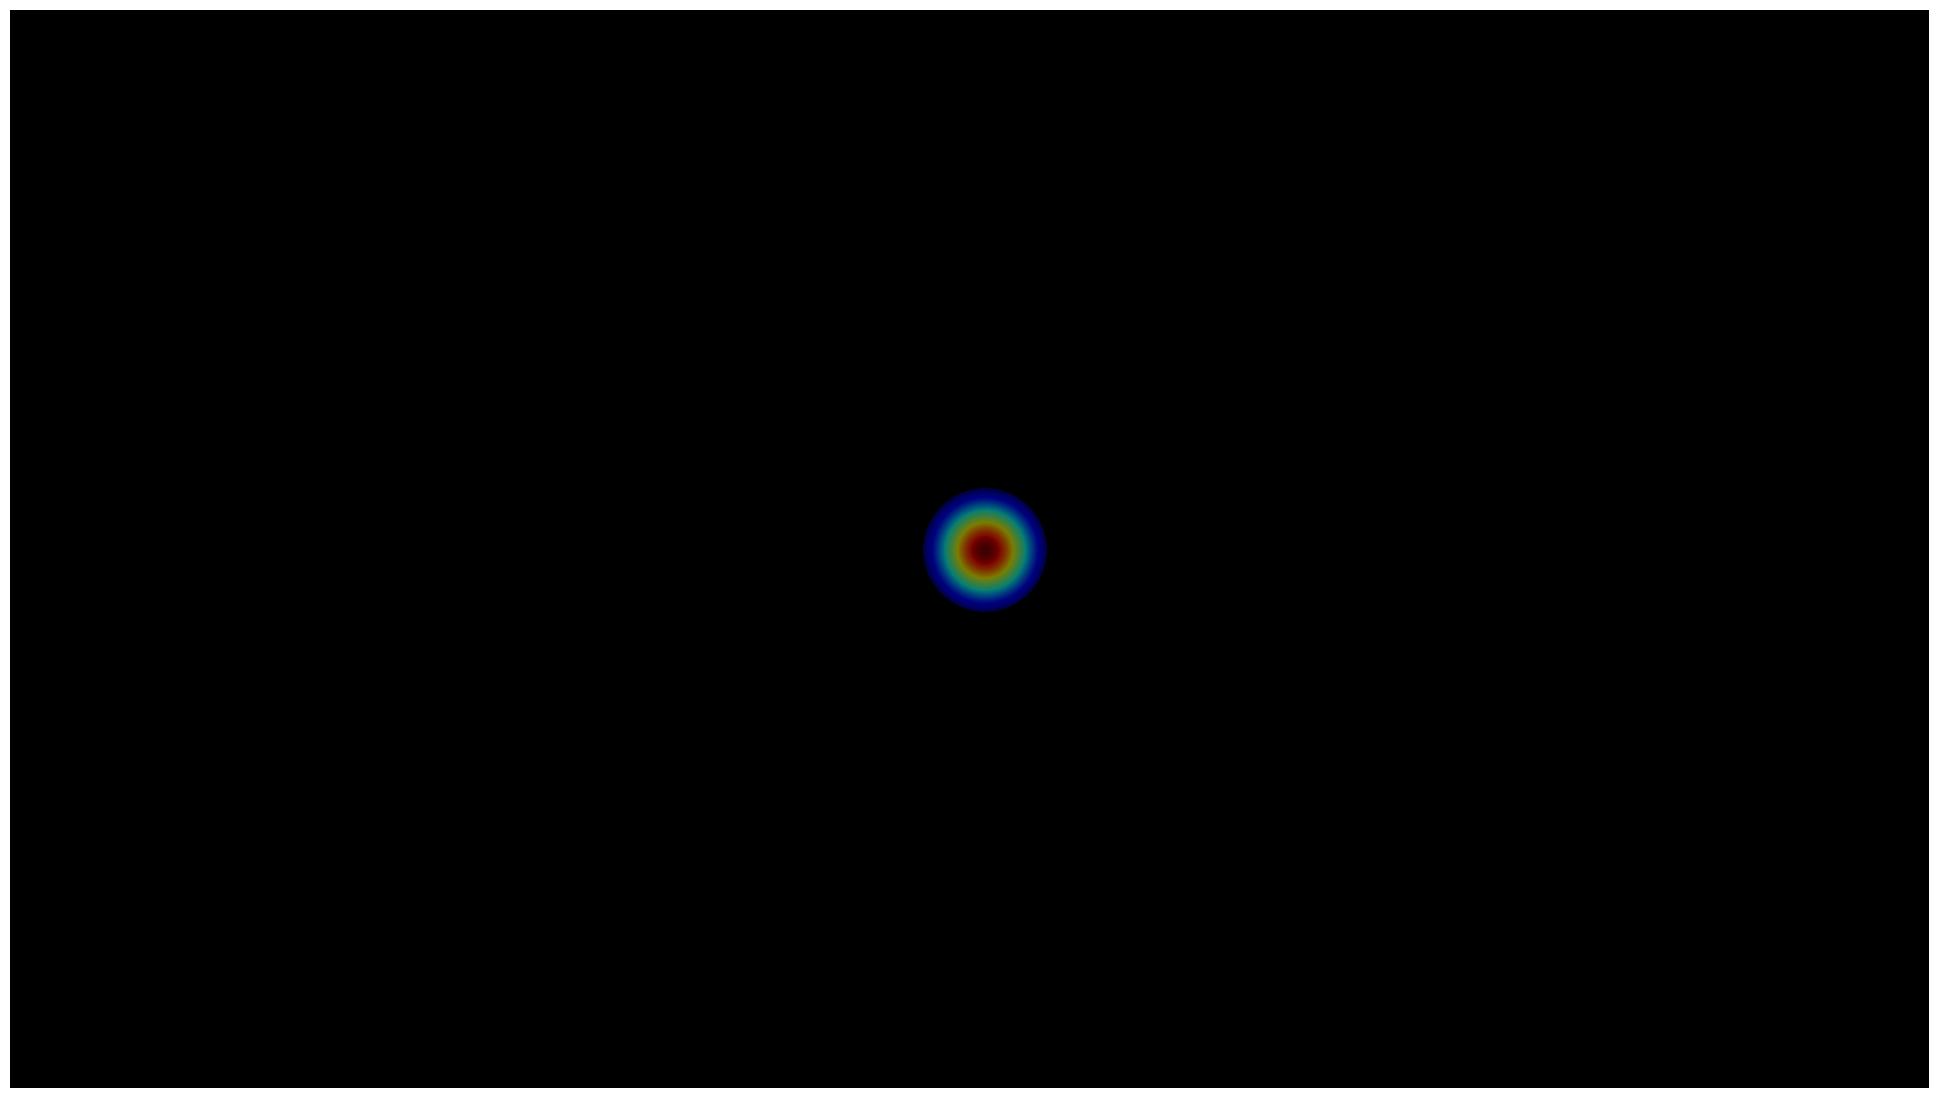

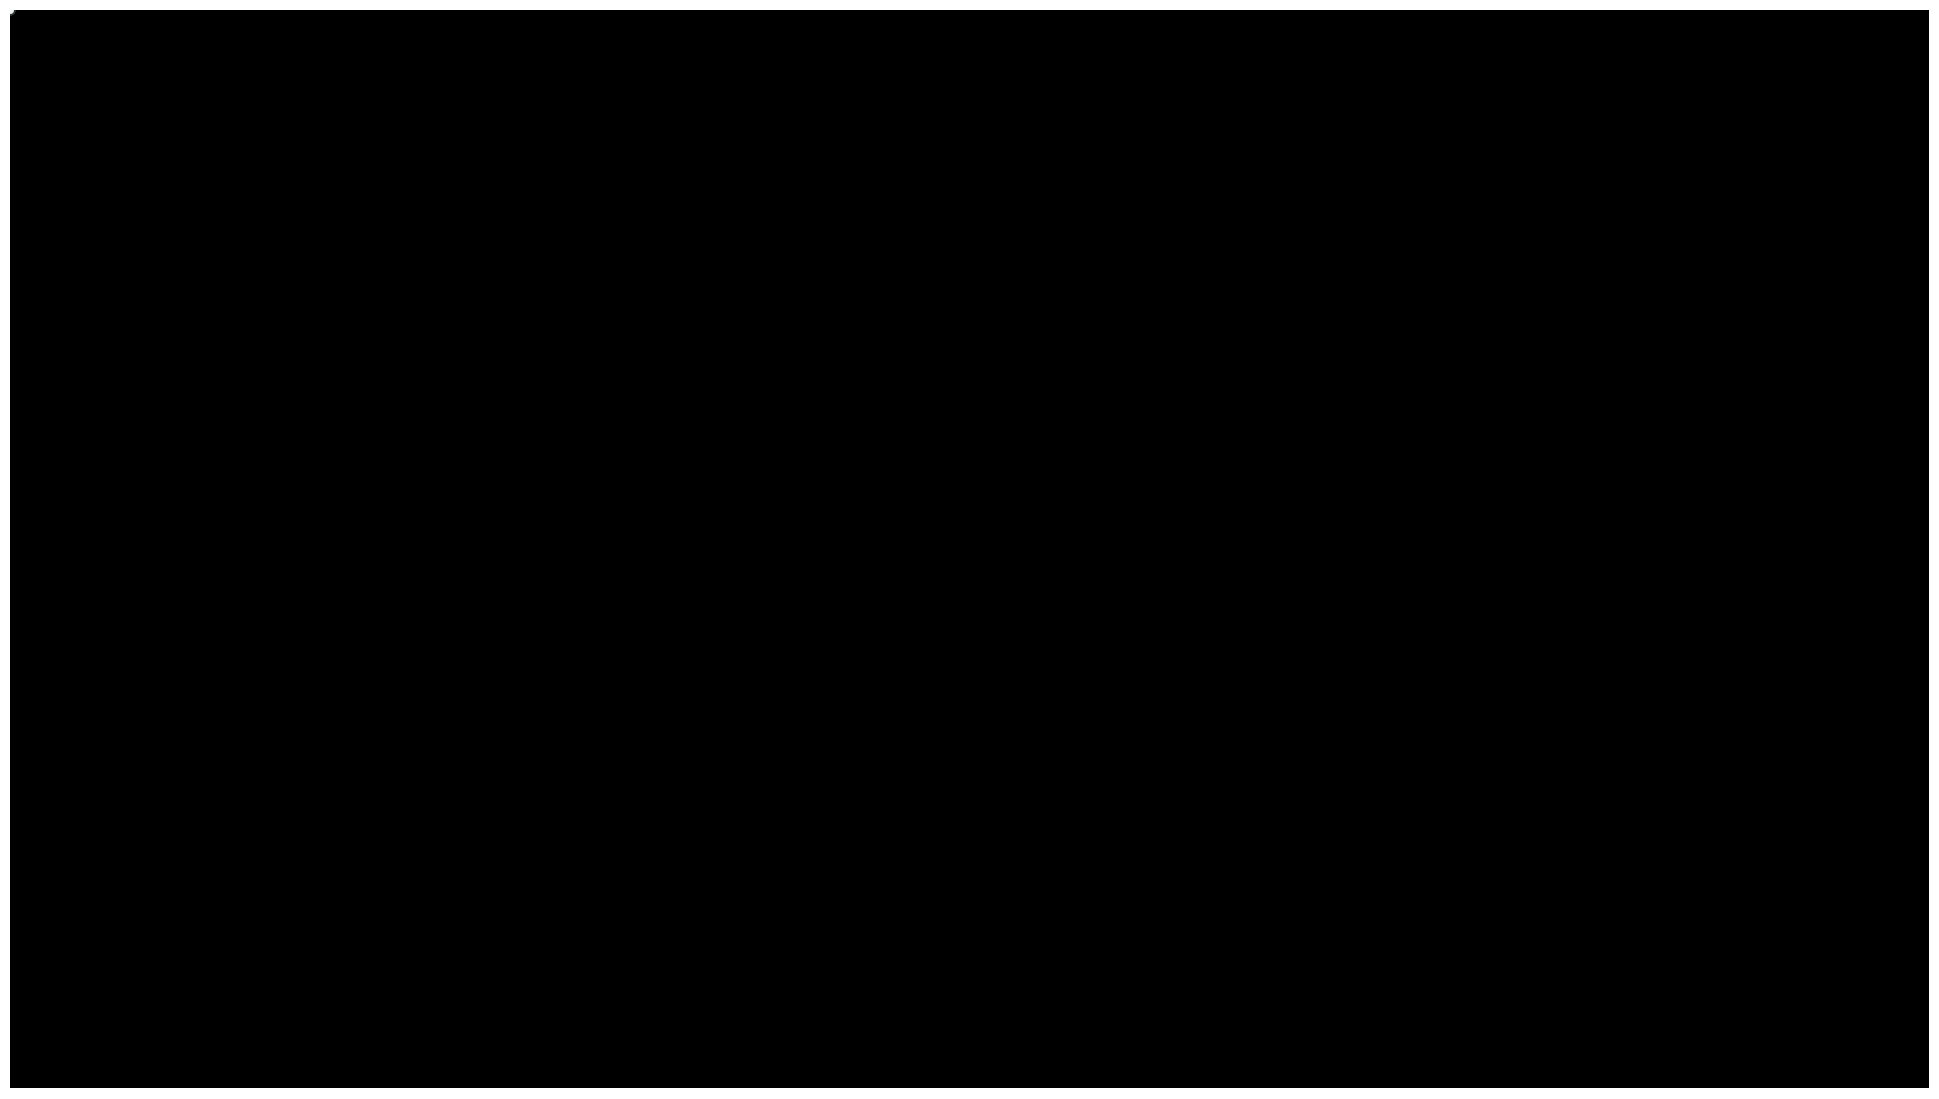

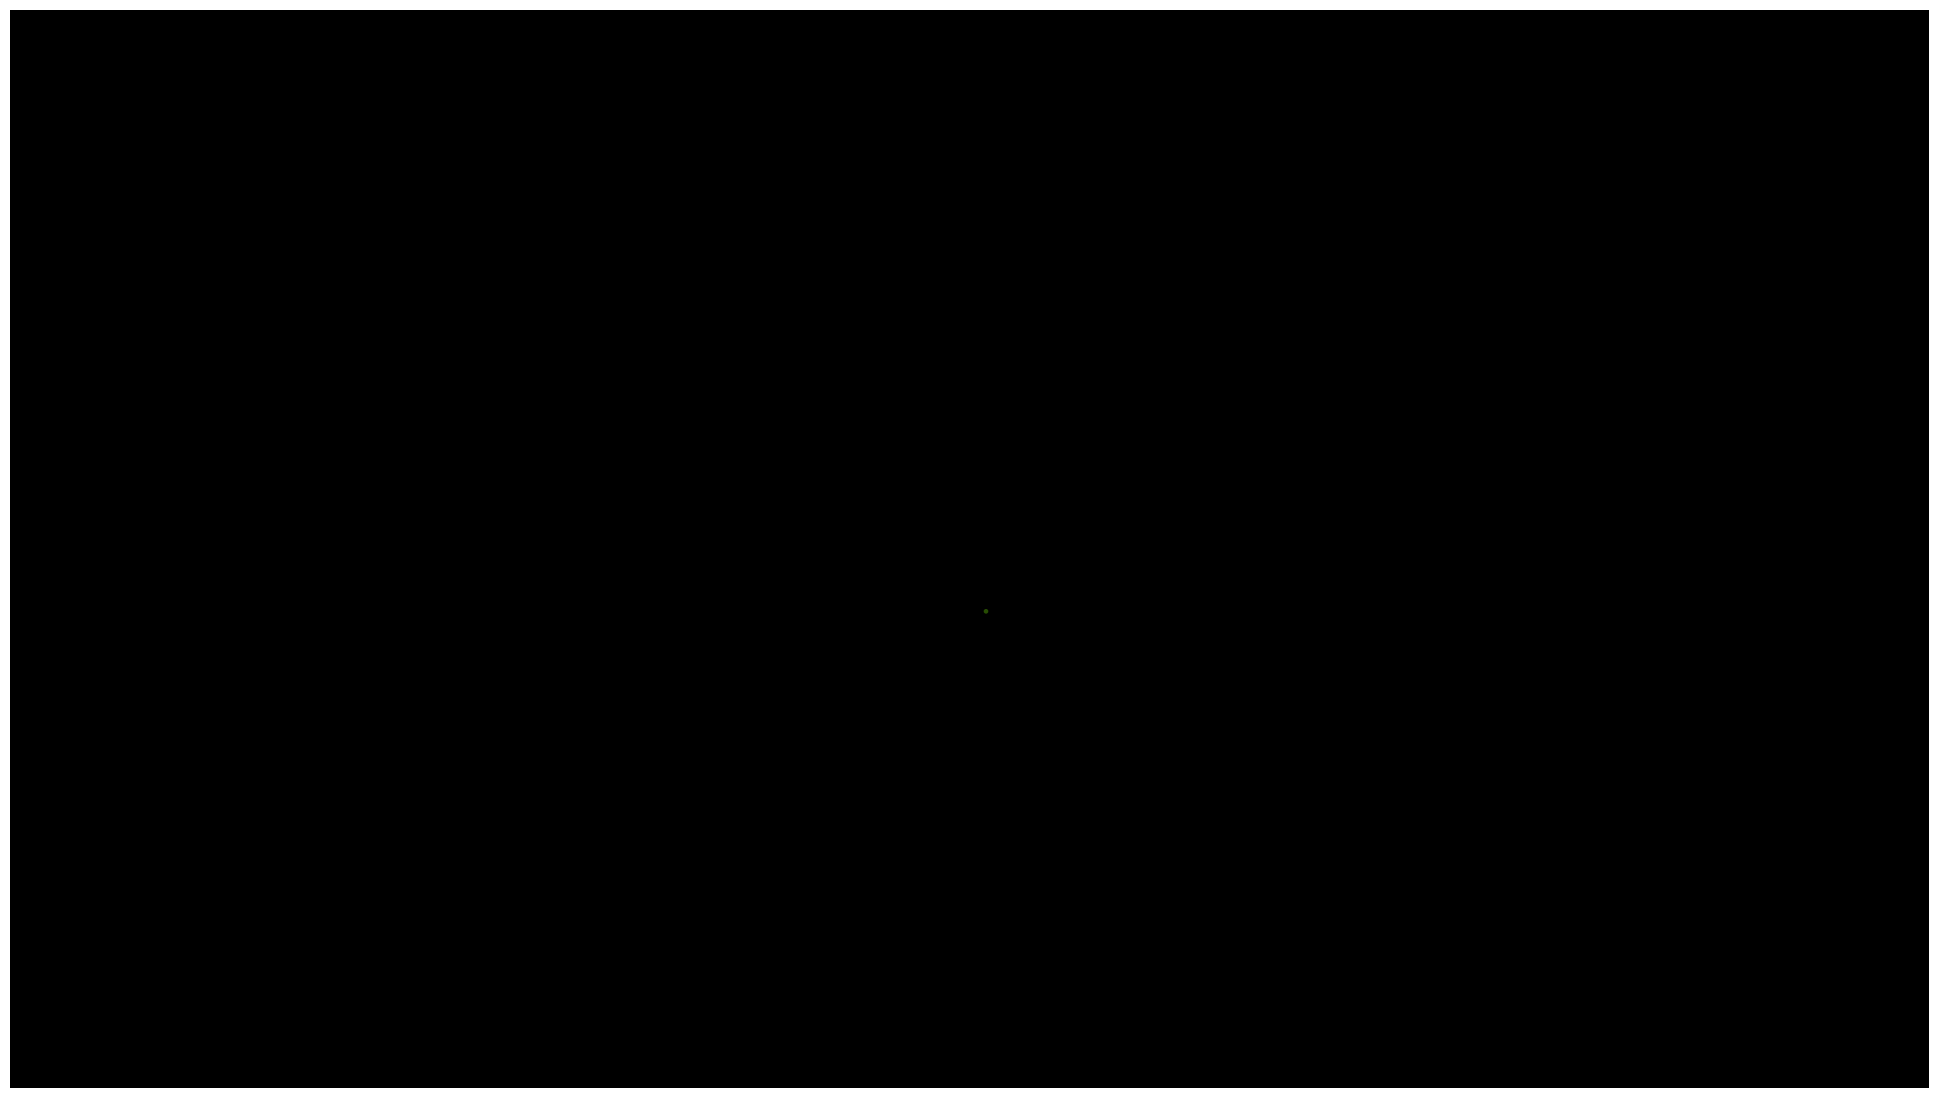

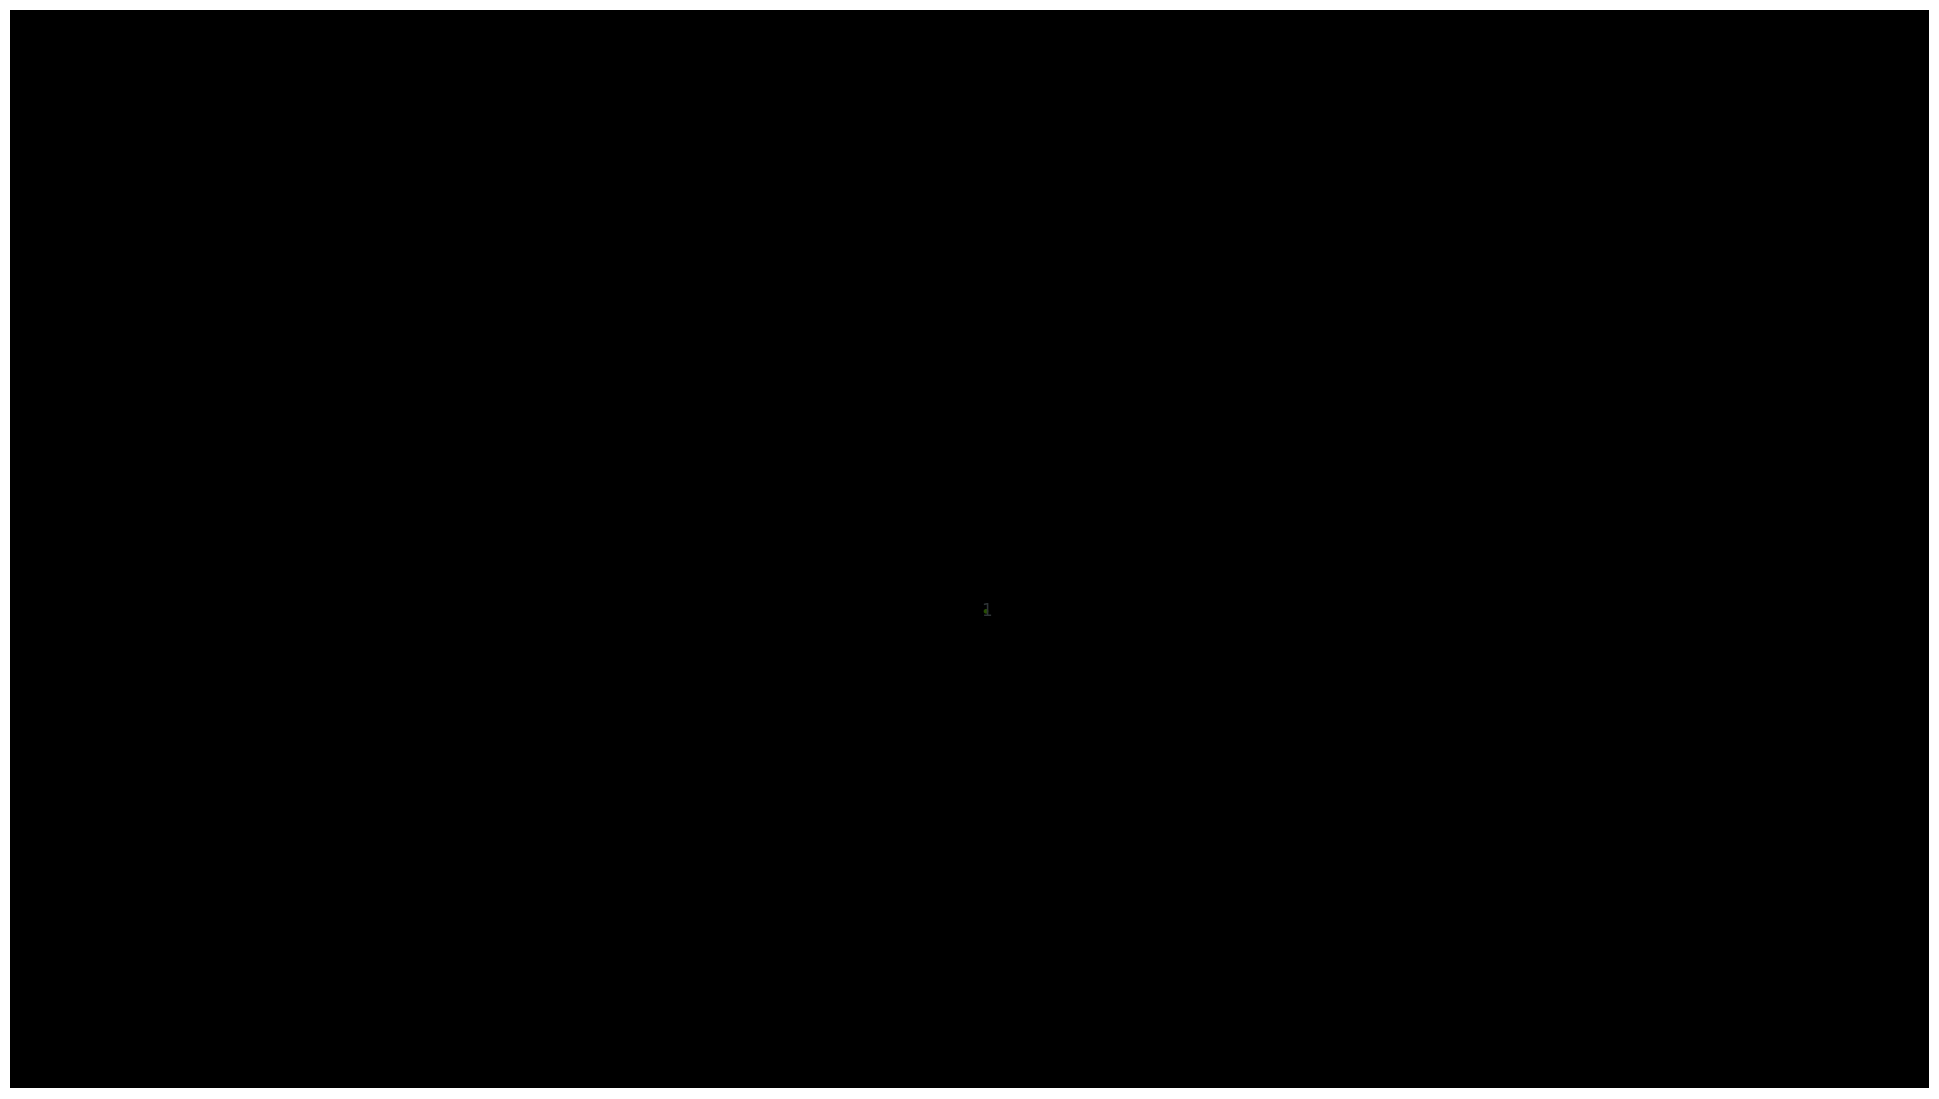

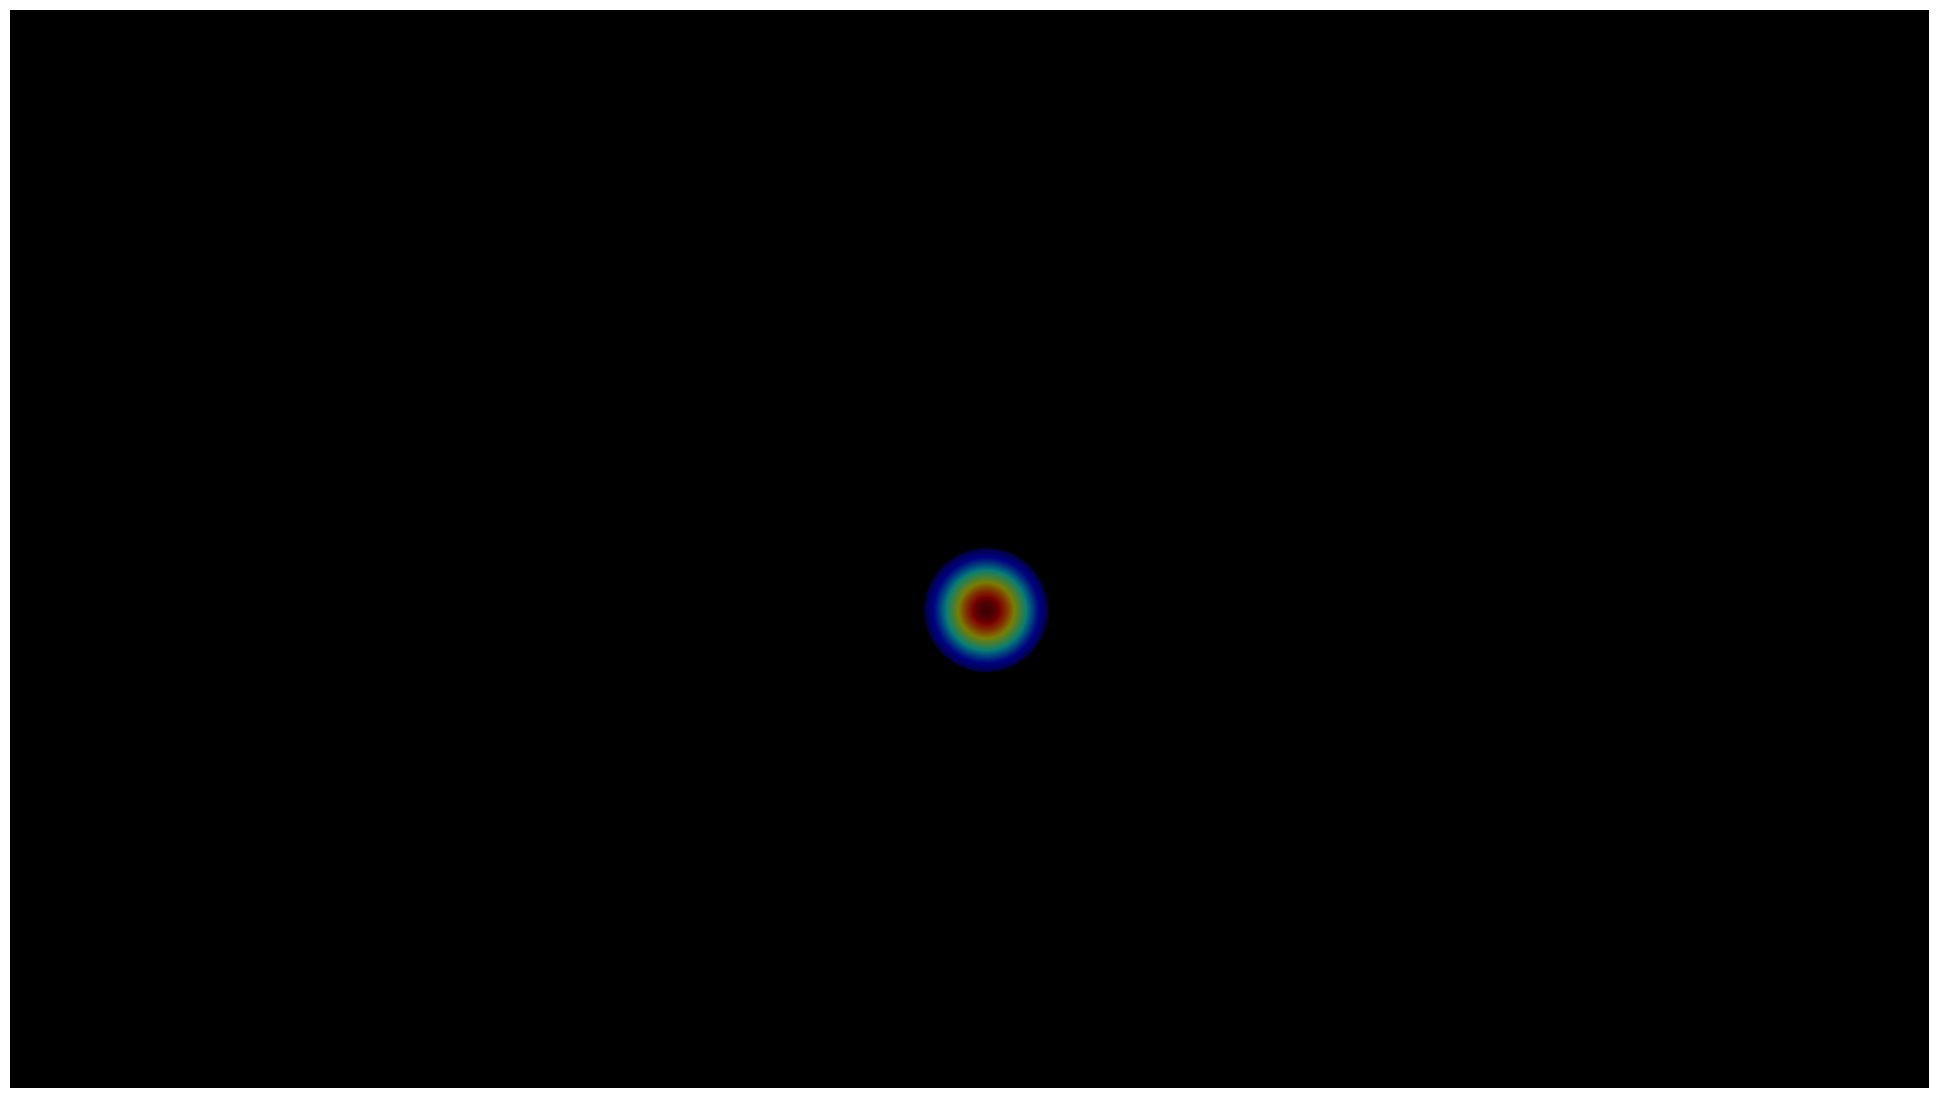

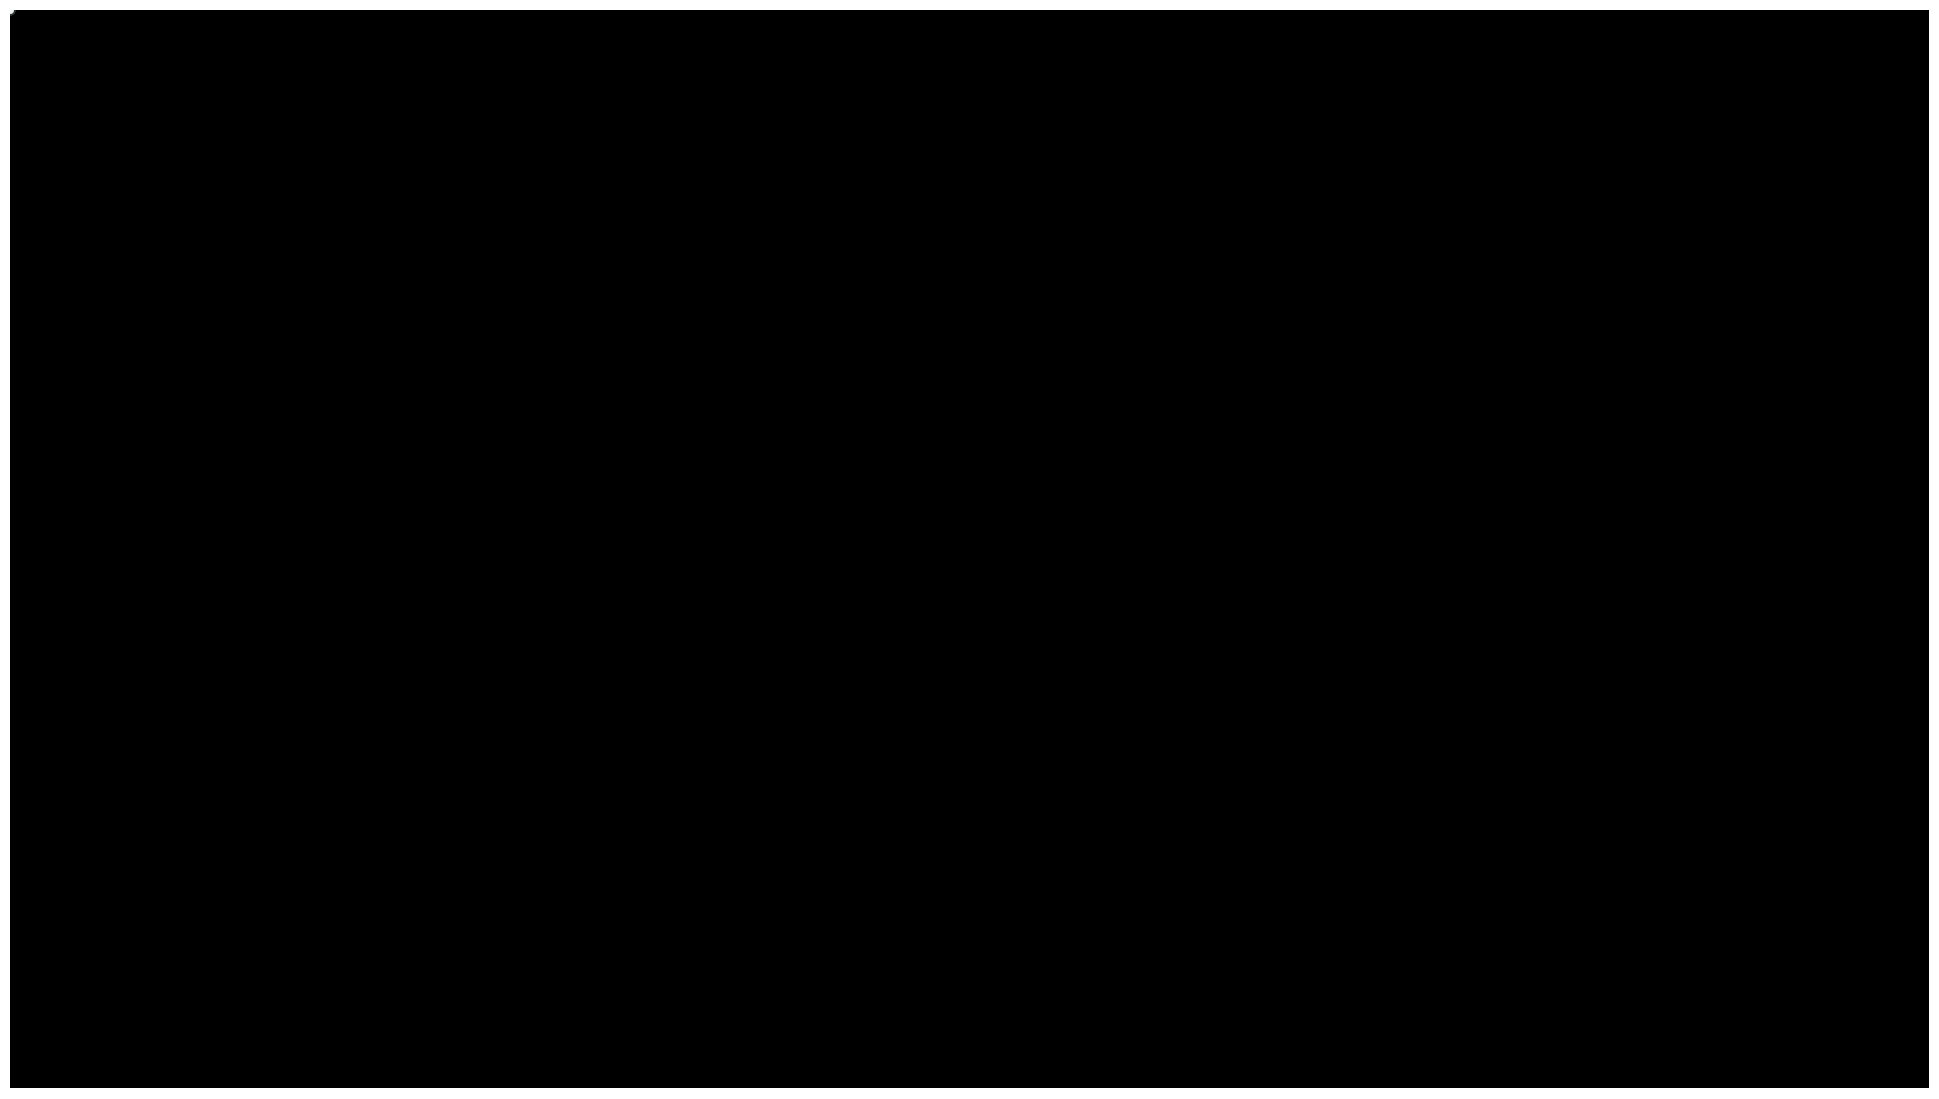

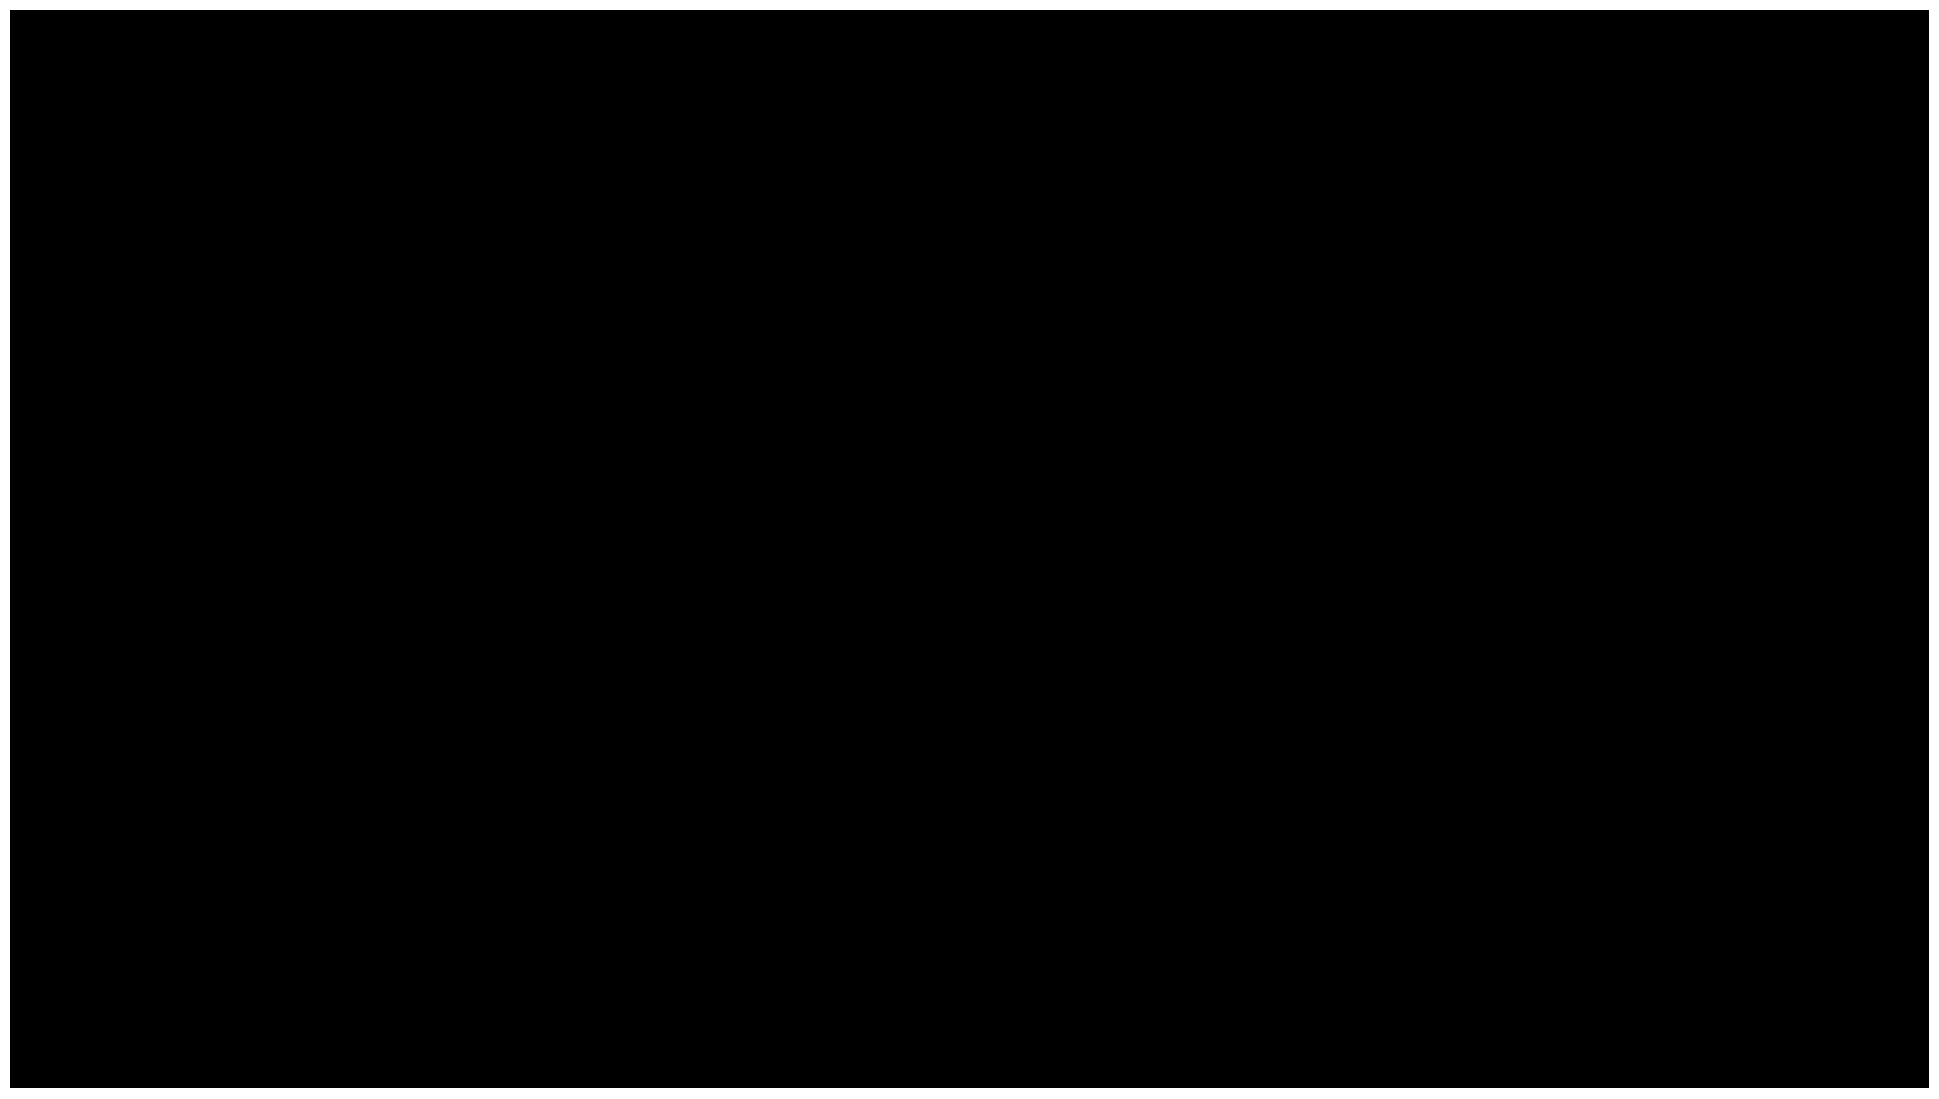

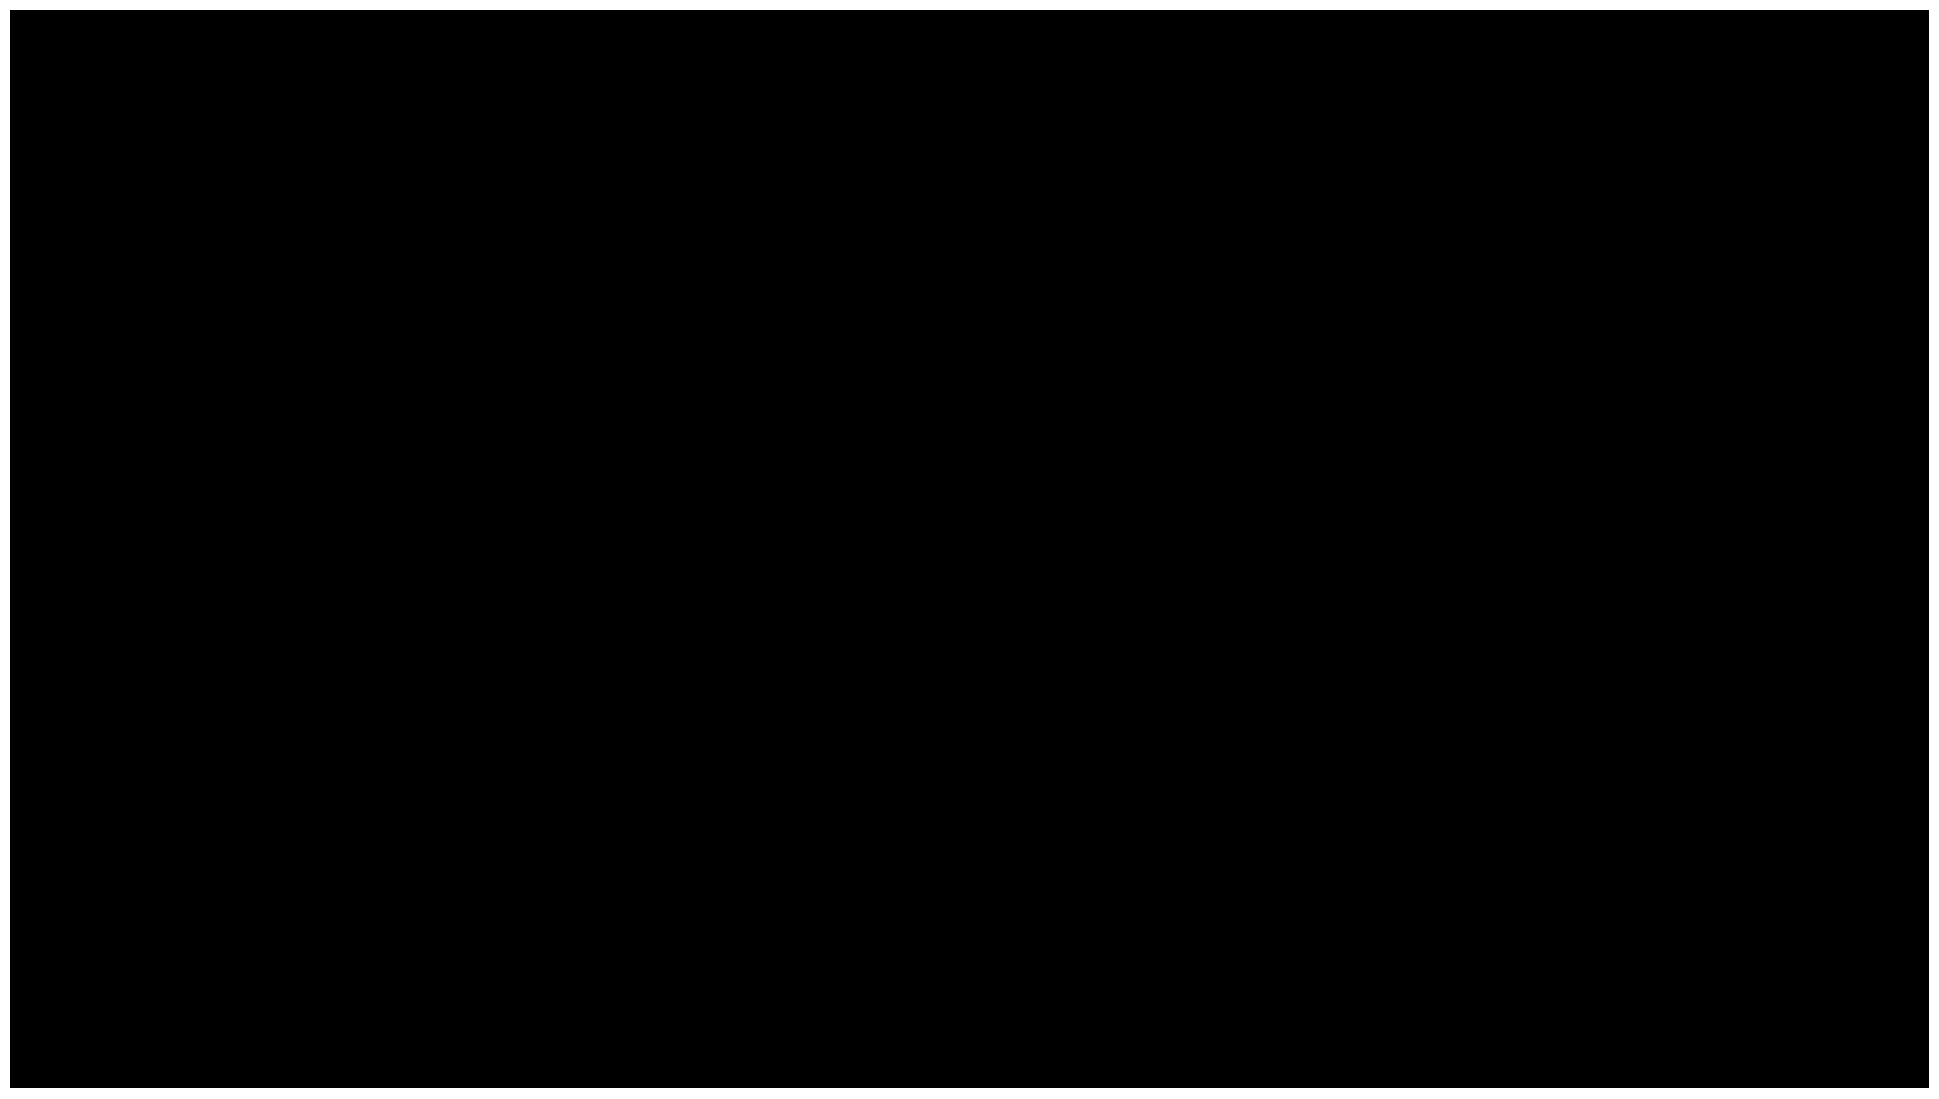

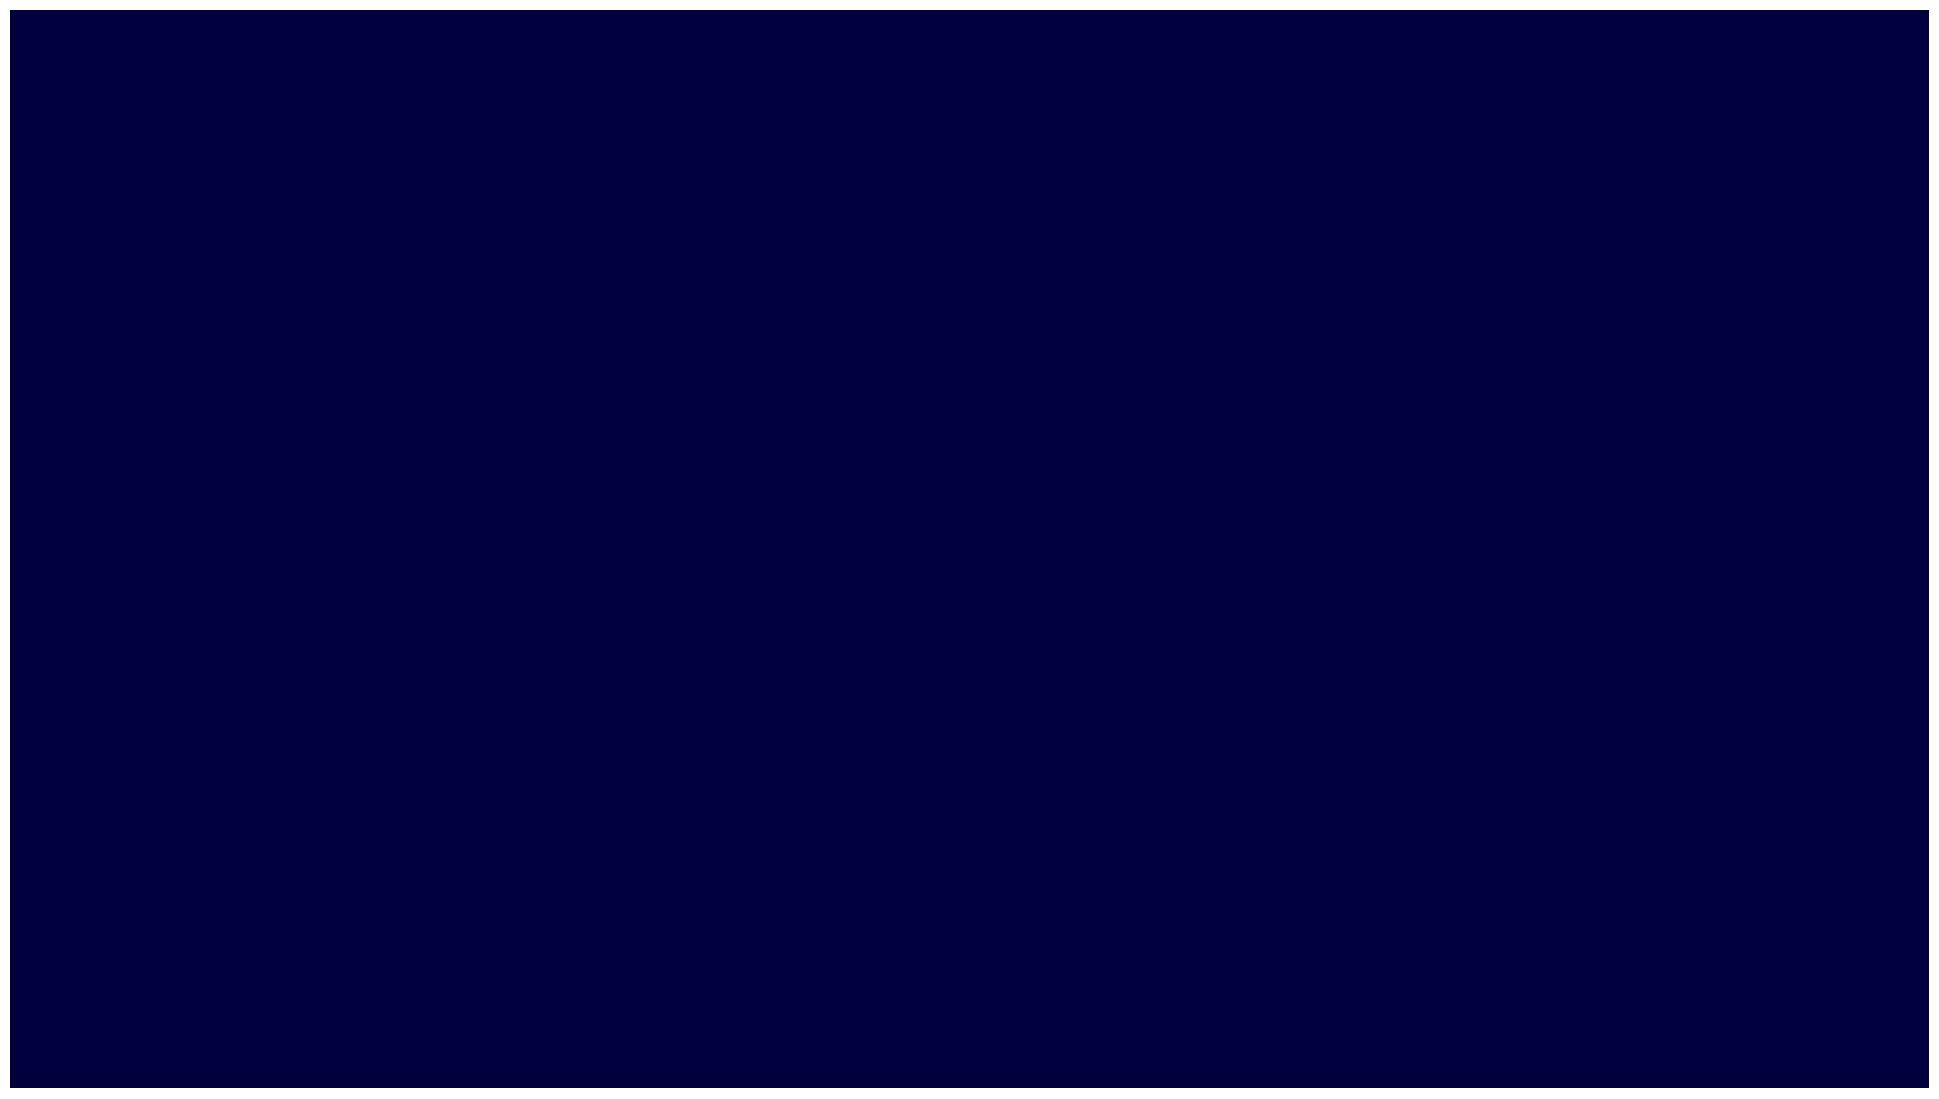

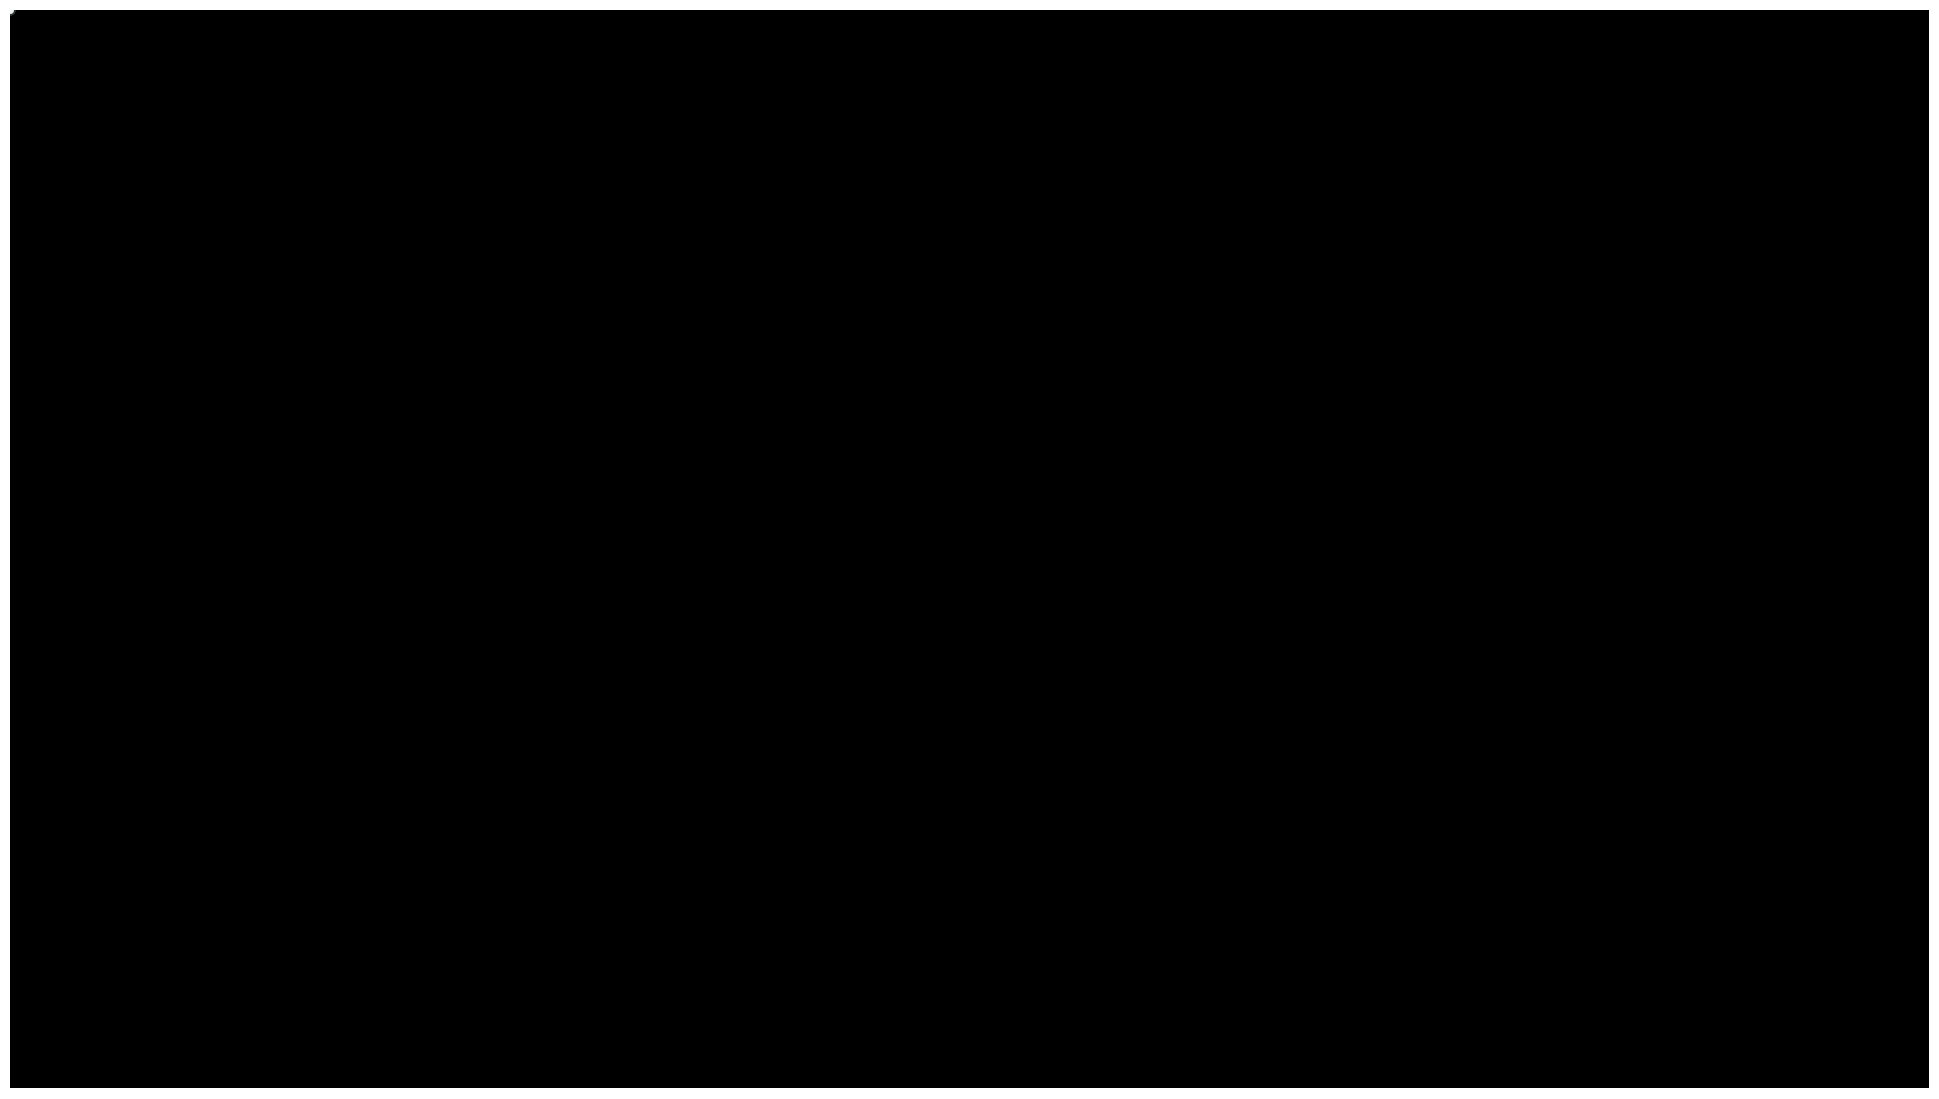

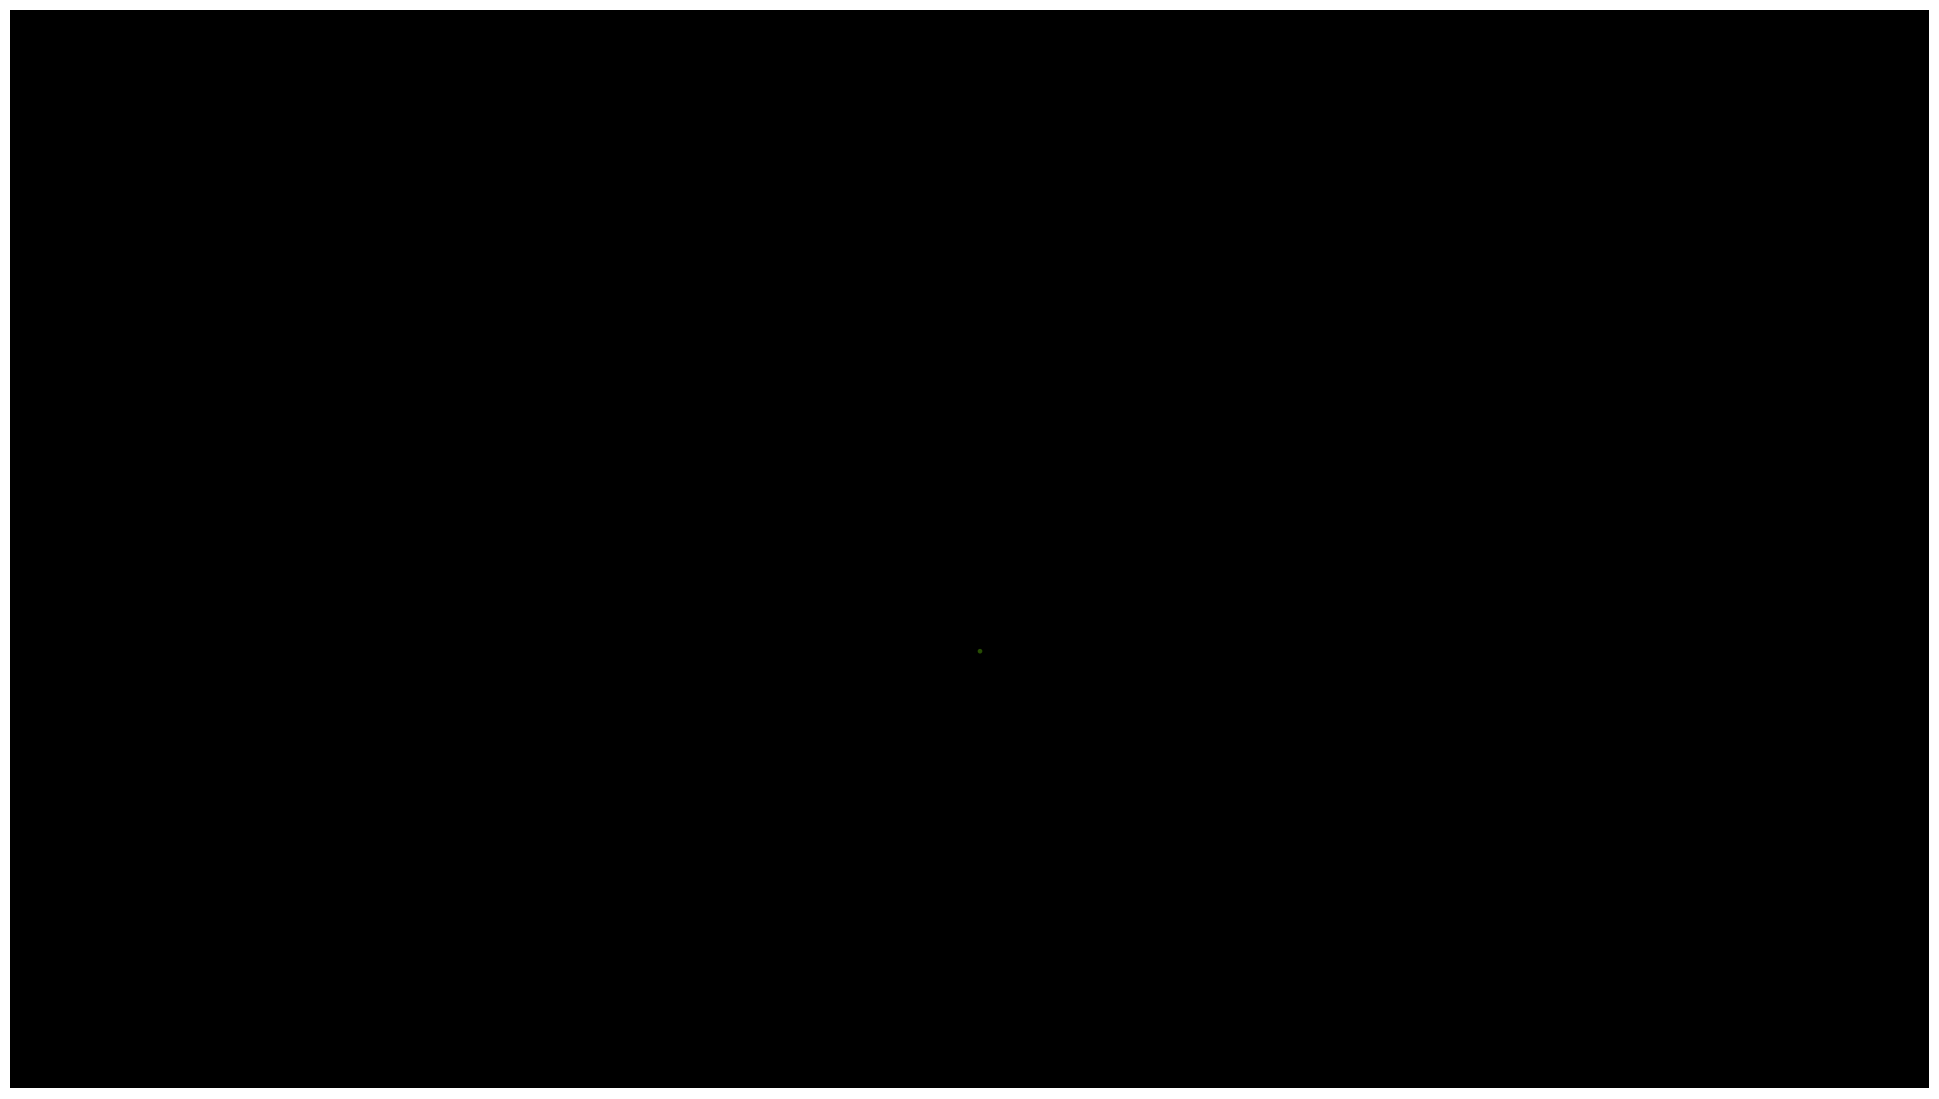

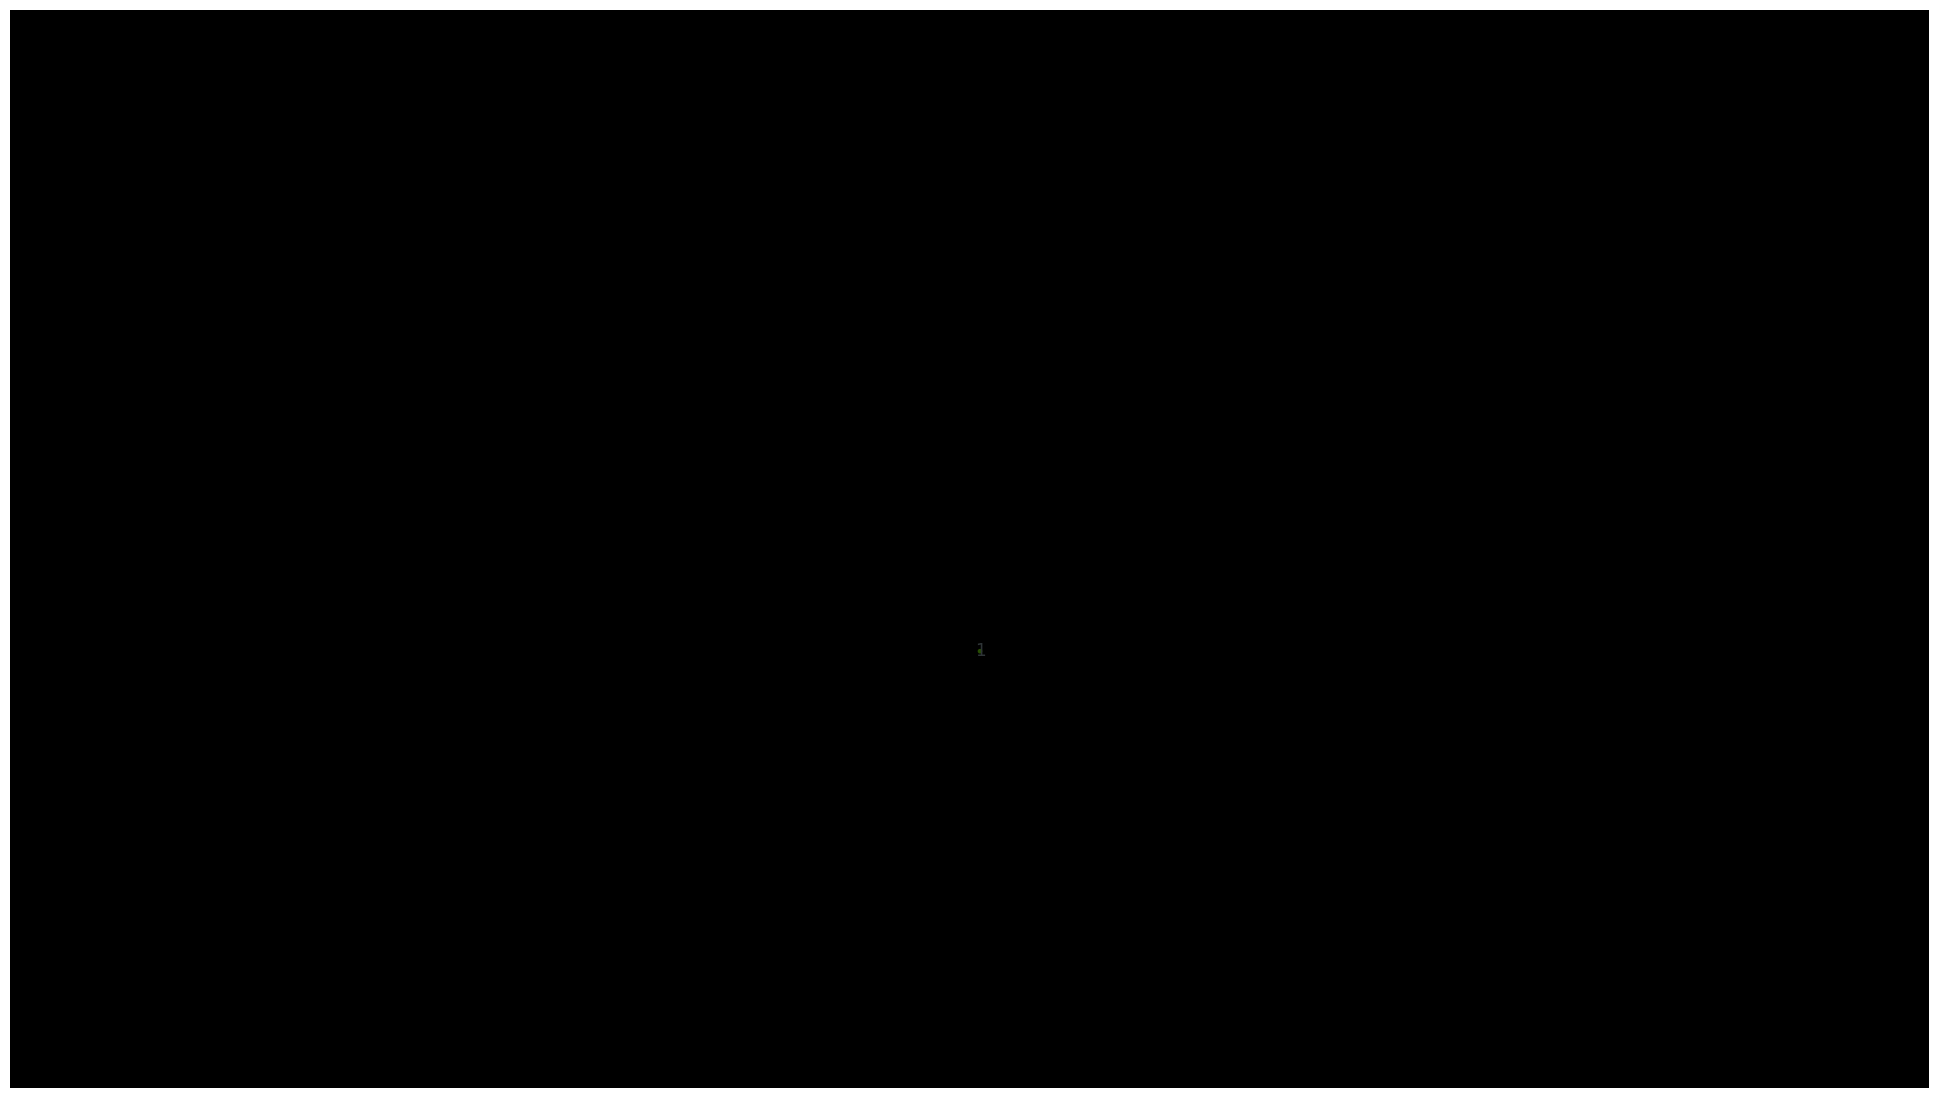

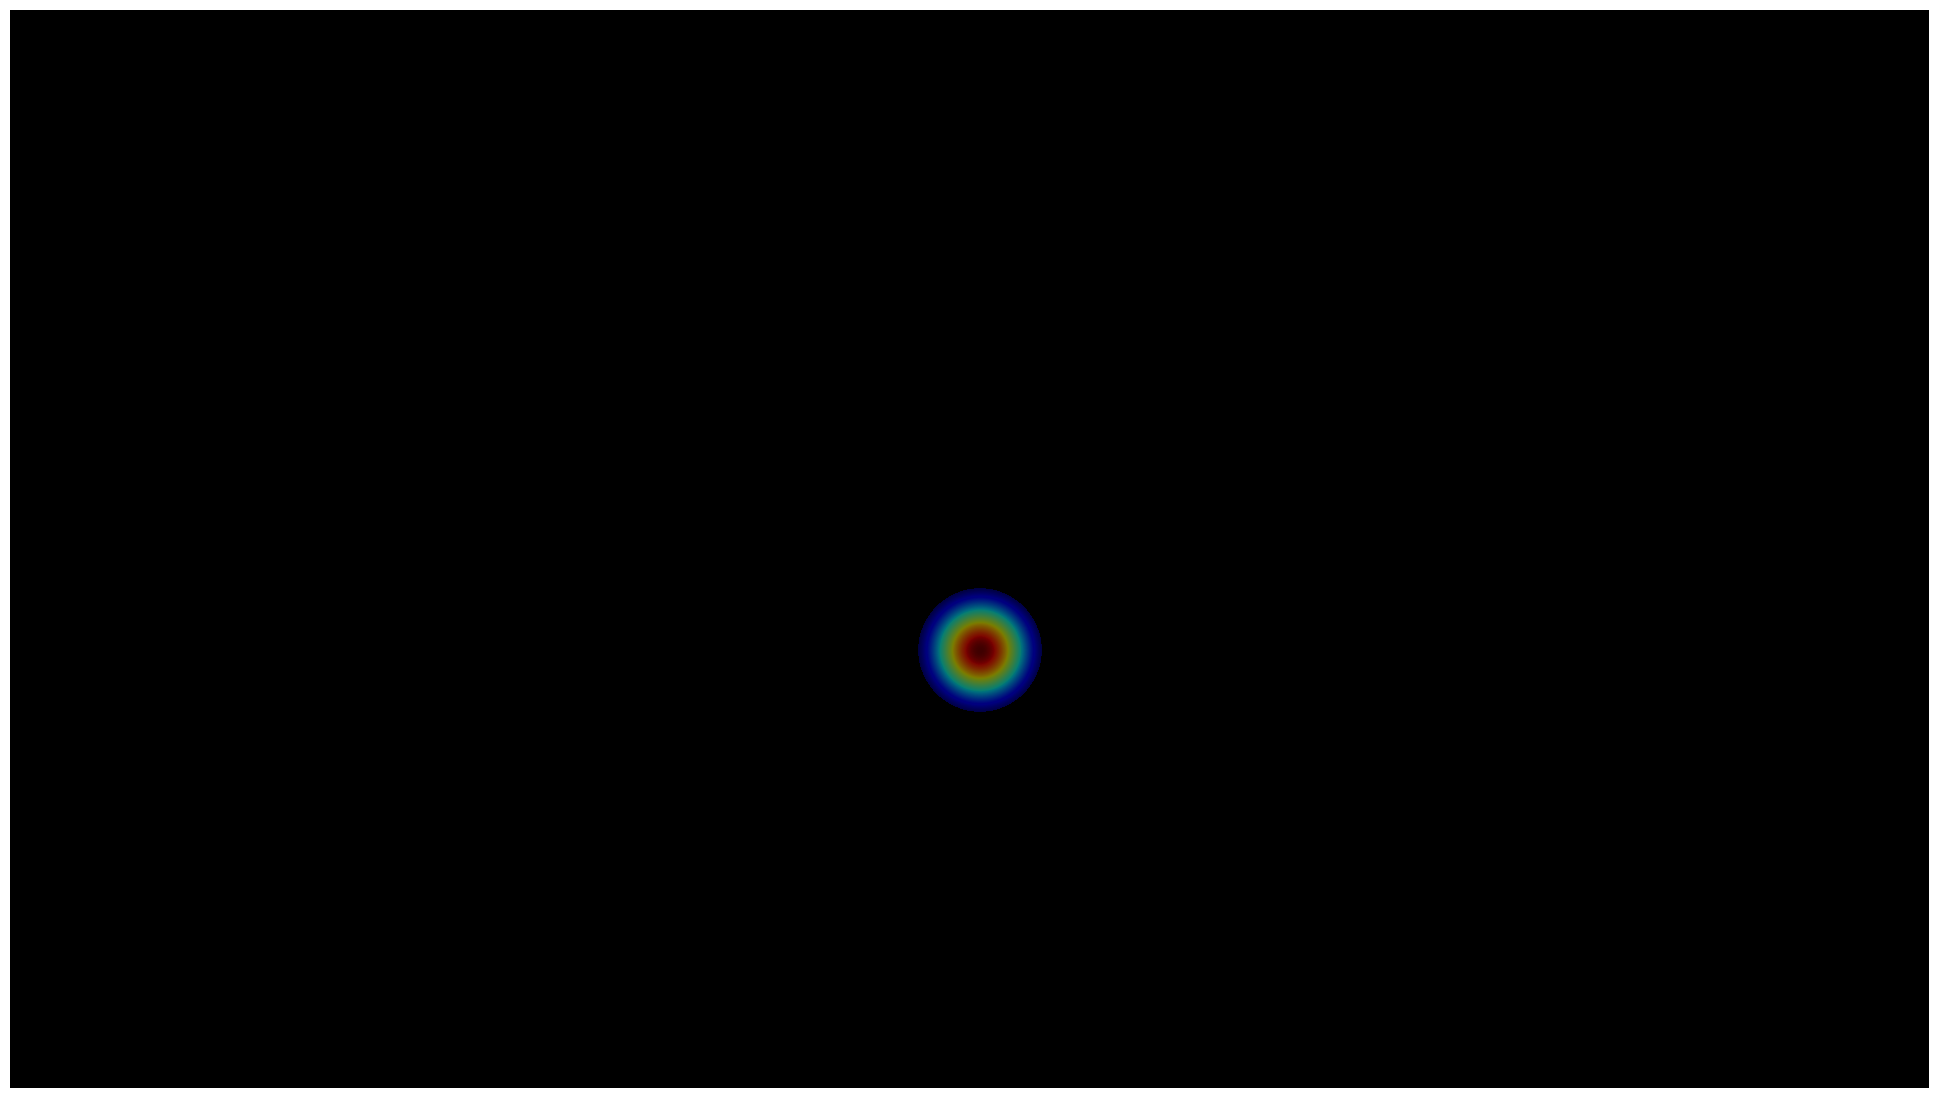

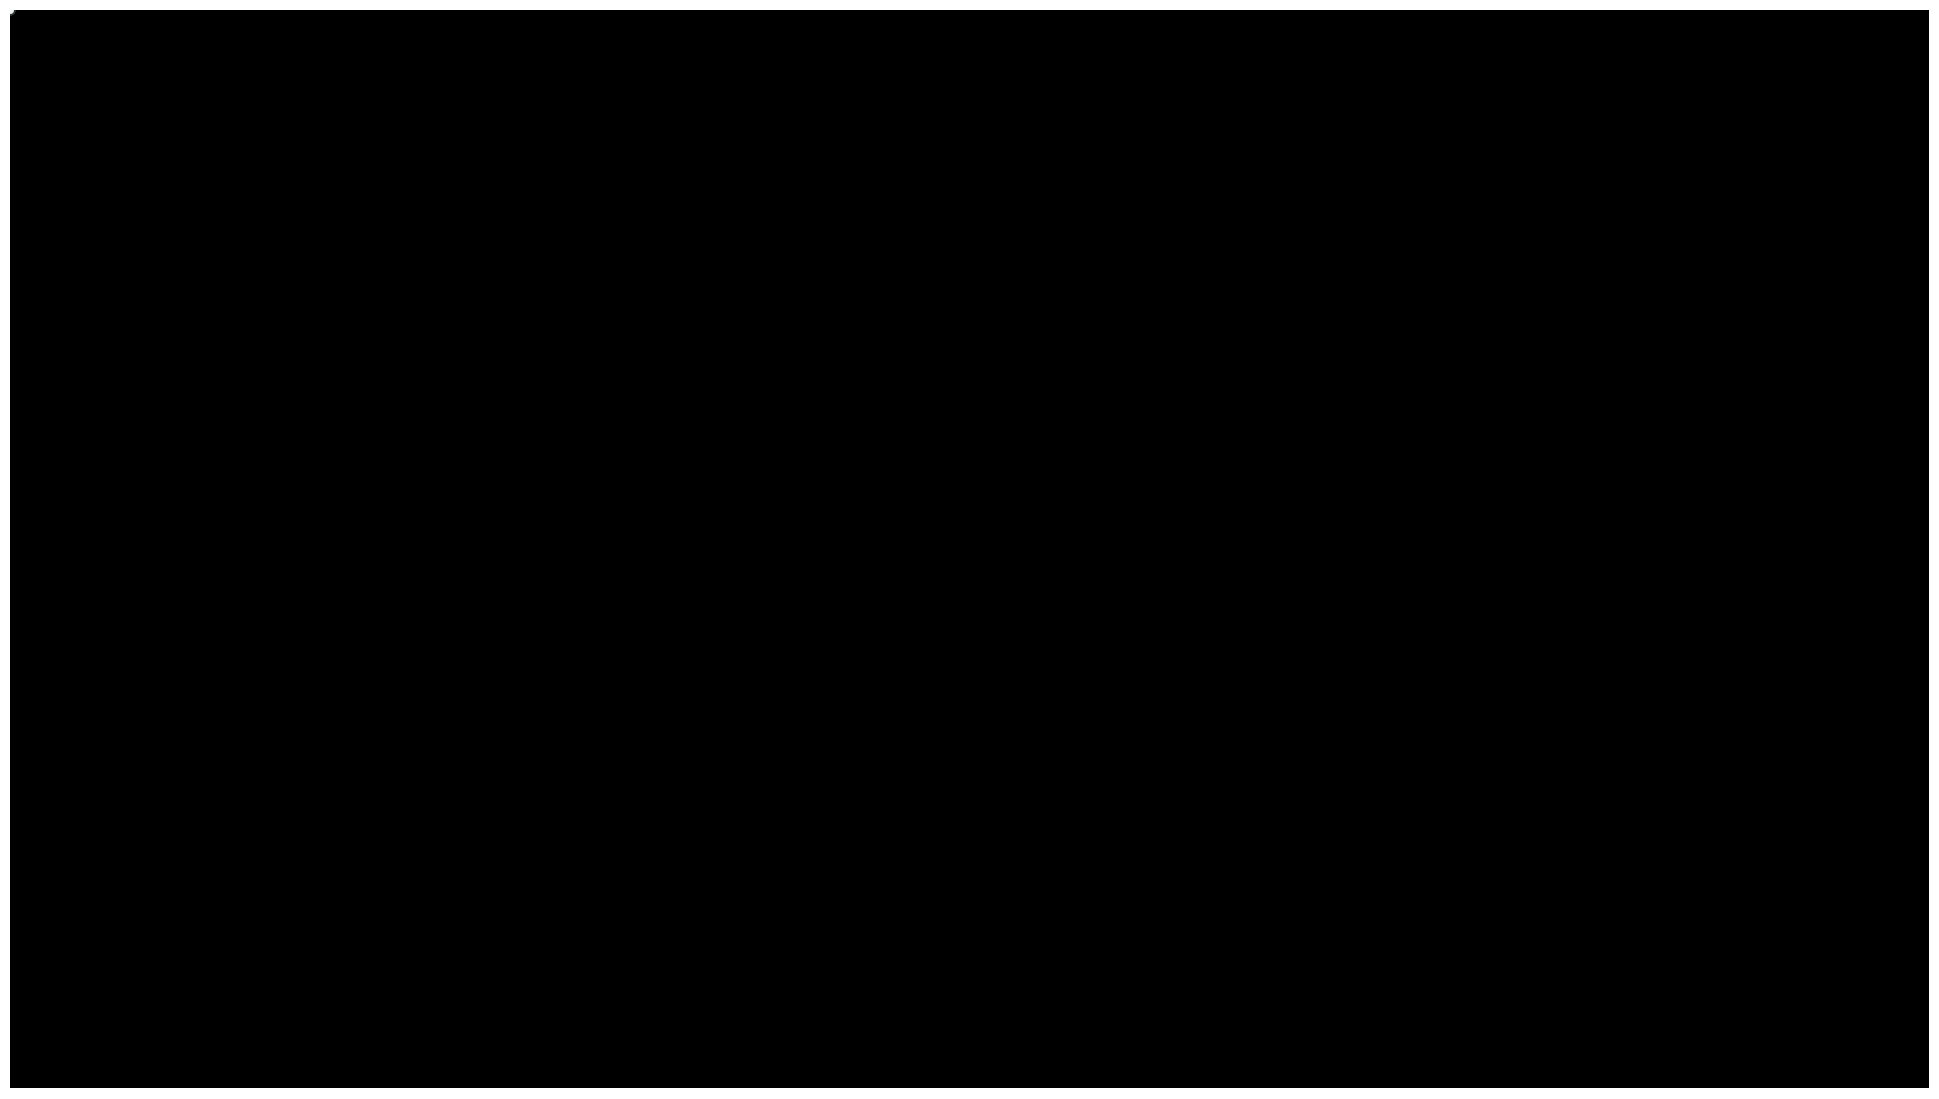

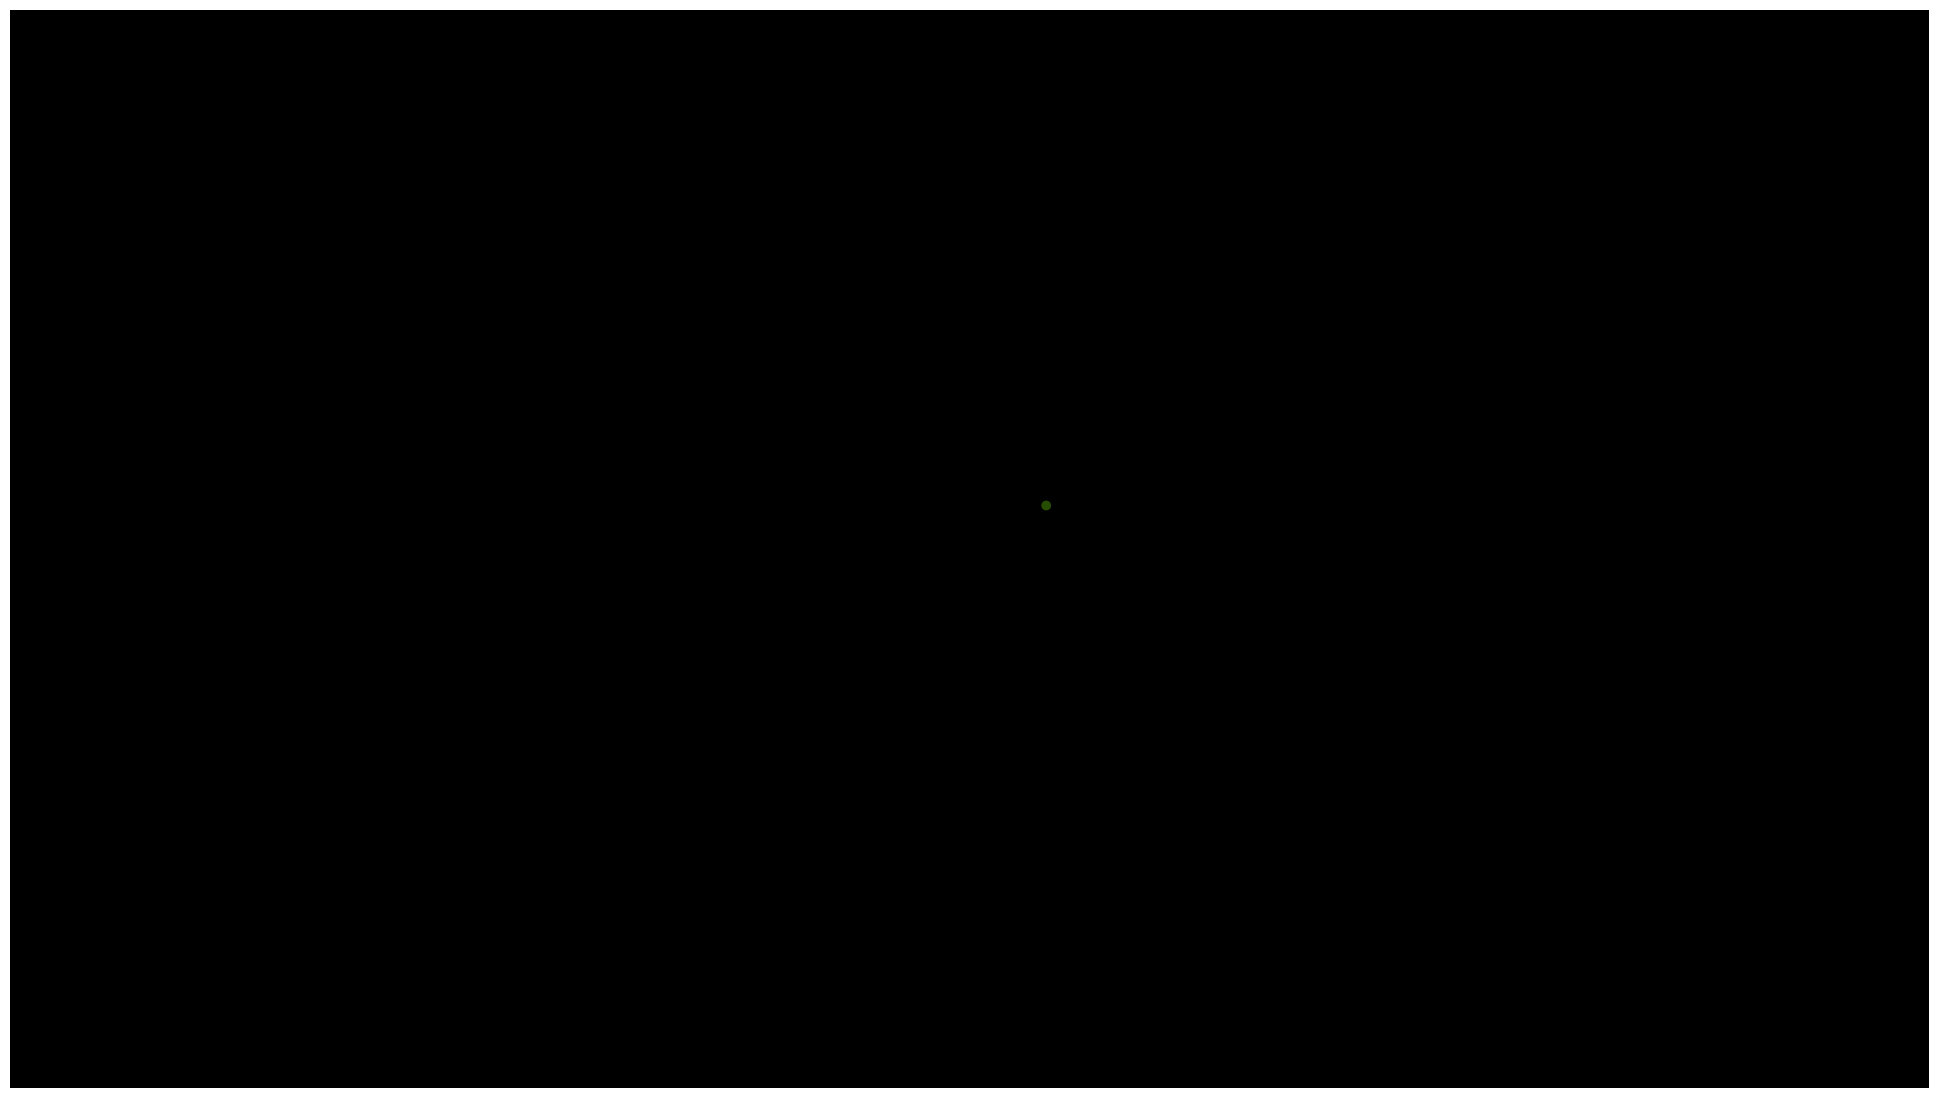

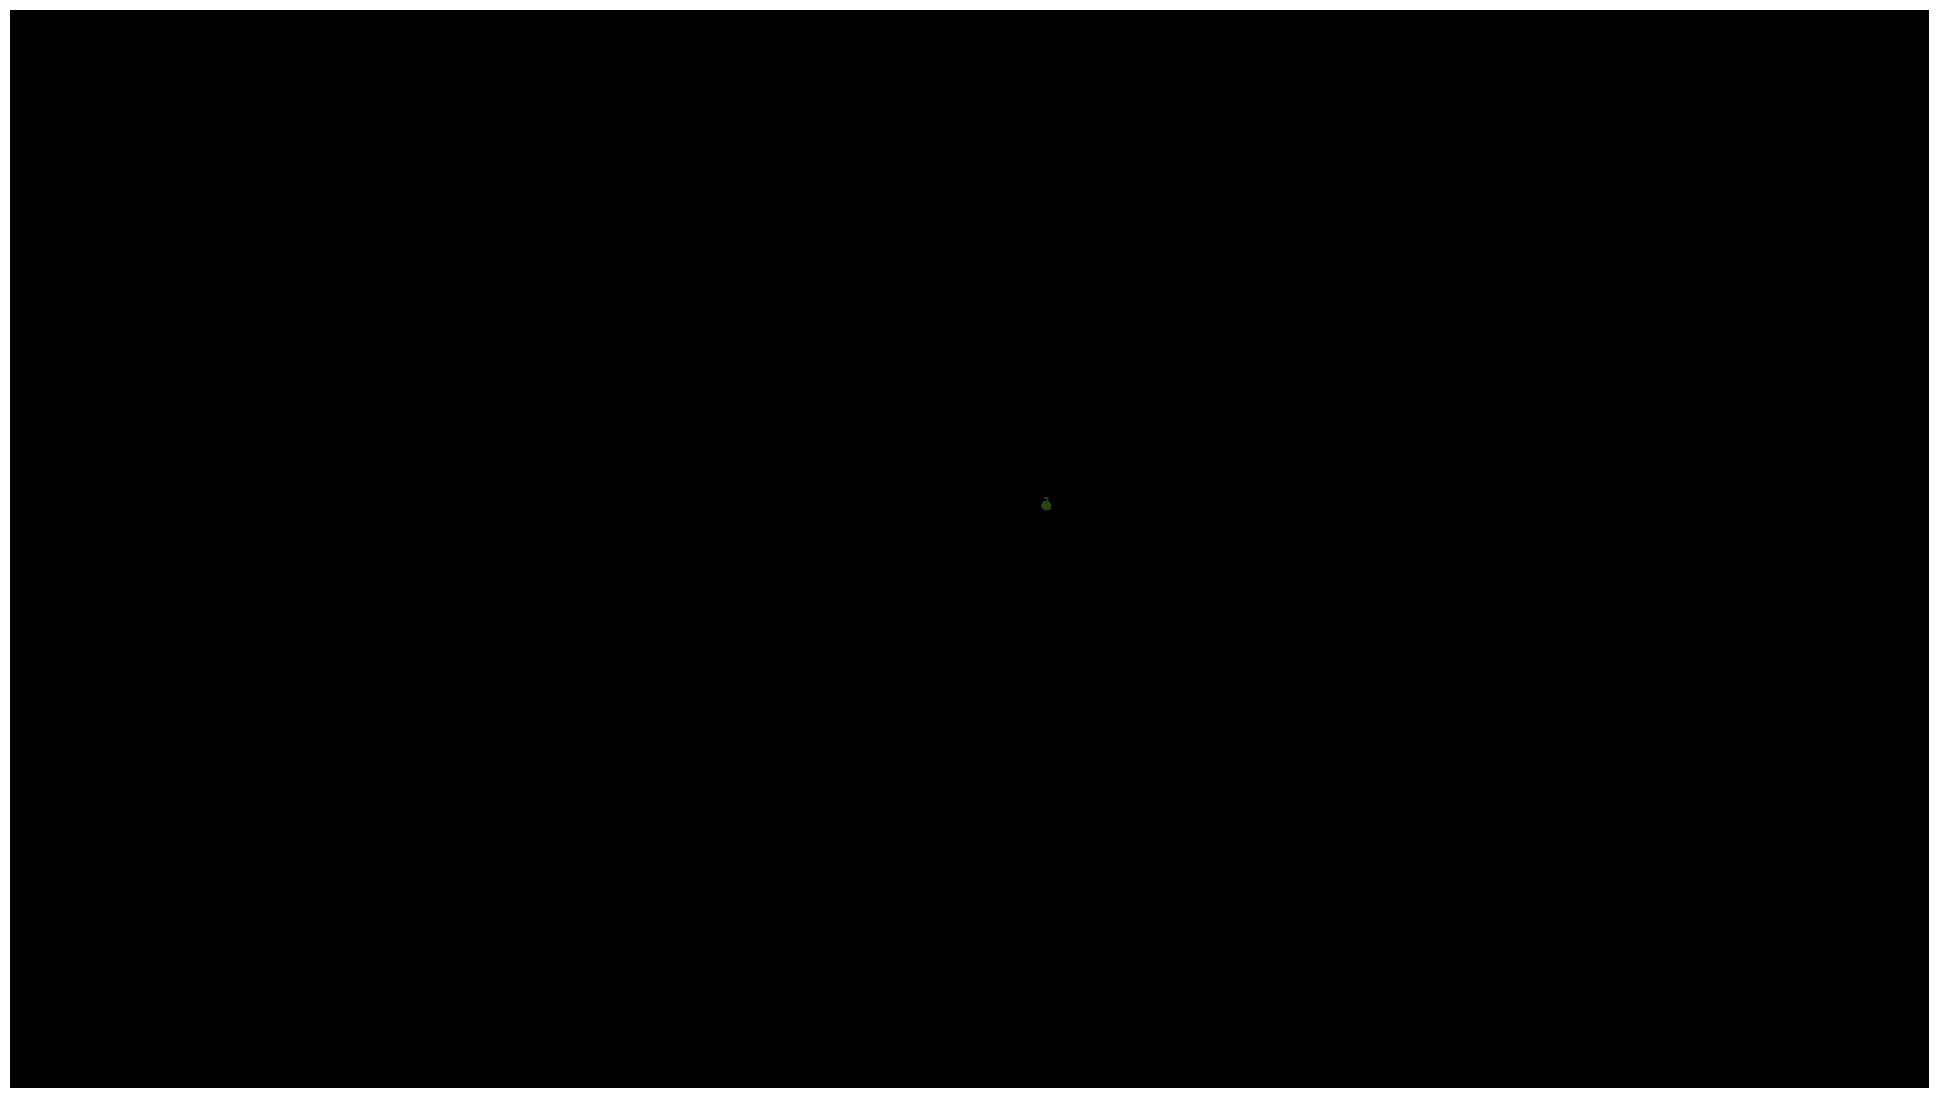

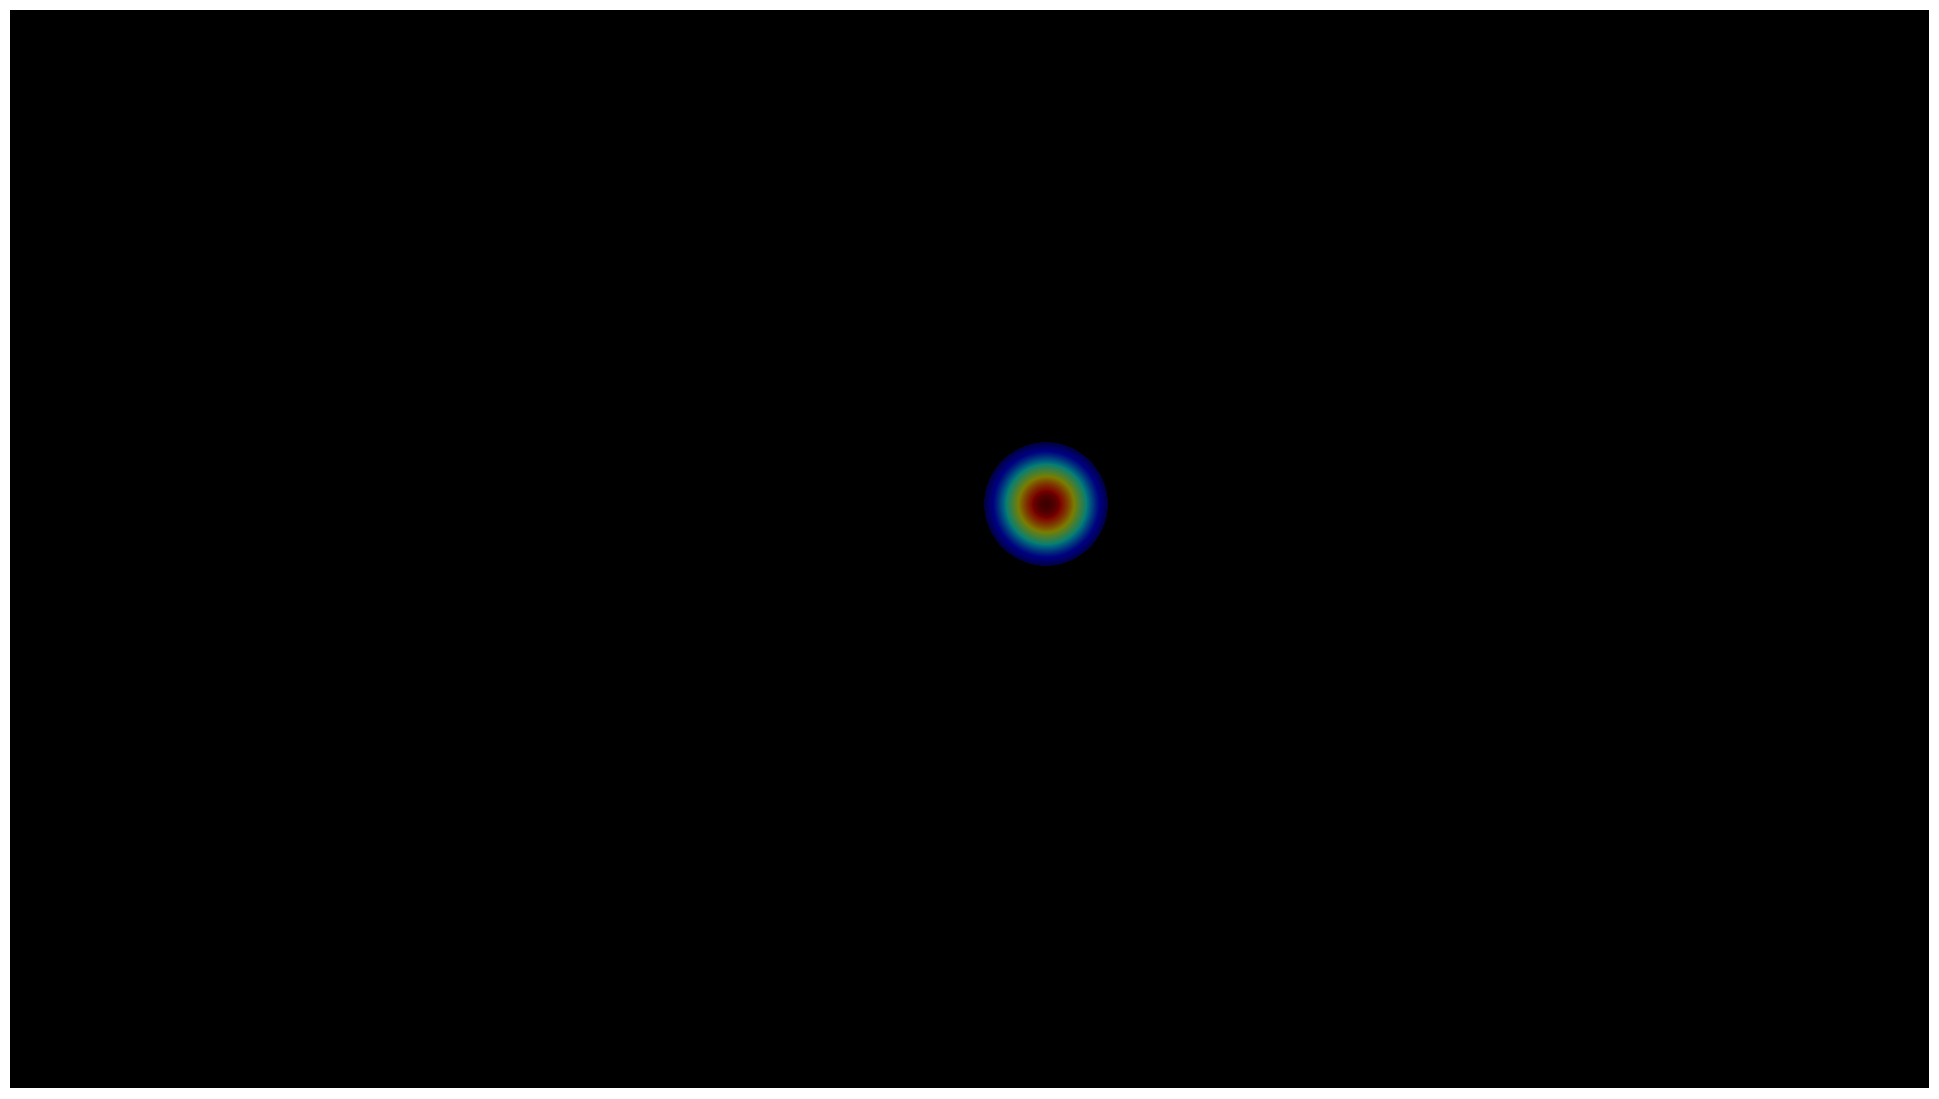

In [11]:
# analysis script for eye tracking project
#
# version 3 (Apr 2021)
#
# plots each stimulus phase seperately, saves the distances (between center & fixation point during the stimulus phase) into the csv file for further analysis

__author__ = "Sijamini Baskaralingam"

import sys
sys.path.append('PyGazeAnalyser-master\\pygazeanalyser')

# native
import os
import math

# custom
from edfreader import read_edf
from gazeplotter_sija import draw_fixations, draw_heatmap, draw_scanpath, draw_raw

# external
import numpy
import pandas as pd


# # # # #
# CONSTANTS

# PARTICIPANT
PID_string = str(input("participant ID? (only numbers, e.g. 036): "))
PID = int(PID_string)
PP = "G"+PID_string
#PP+"_1", PP+"_2", PP+"_3", PP+"_4", PP+"_5", PP+"_6", PP+"_7", PP+"_8", PP+"_9", PP+"_10", PP+"_11", PP+"_12", PP+"_13", PP+"_14", PP+"_15", PP+"_16"
PPS = [PP+"_1", PP+"_2", PP+"_3", PP+"_4", PP+"_5", PP+"_6", PP+"_7", PP+"_8", PP+"_9", PP+"_10", PP+"_11", PP+"_12", PP+"_13", PP+"_14", PP+"_15", PP+"_16"]
print(PPS)

# DIRECTORIES
# paths
DIR = os.path.dirname('PyGazeAnalyser-master\\pygazeanalyser\\imgs')
IMGDIR = os.path.join(DIR, 'imgs')
DATADIR = os.path.join(DIR, 'data')
PLOTDIR = os.path.join(DIR, 'plots')
OUTPUTFILENAME = os.path.join(DIR, "output.txt")
# check if the image directory exists
if not os.path.isdir(IMGDIR):
        raise Exception("ERROR: no image directory found; path '%s' does not exist!" % IMGDIR)
# check if the data directory exists
if not os.path.isdir(DATADIR):
        raise Exception("ERROR: no data directory found; path '%s' does not exist!" % DATADIR)
# check if output directorie exist; if not, create it
if not os.path.isdir(PLOTDIR):
        os.mkdir(PLOTDIR)

# DATA FILES
SEP = '\t' # value separator
EDFSTART = "SYNCTIME" # EDF file trial start message 
EDFSTOP = "CC" # EDF file trial end message
EDFSTART2 = "TRIALID" # EDF file trial start message
EDFSTOP2 = "SYNCTIME" # EDF file trial end message
#For EDFSTART and EDFSTOP: Use TRIALID and SYNCTIME for fixation period. Use SYNTIME and CC for the stimulationphase.
#Use CC and REWARD for reaction time. TRIALOK is end of trial.
TRIALORDER = [EDFSTART, 'image online','image offline', EDFSTOP]
INVALCODE = 0.0 # value coding invalid data

# EXPERIMENT SPECS
DISPSIZE = (1919,1079) # (px,px)
SCREENSIZE = (53.3,29.9) # (cm,cm)
SCREENDIST = 27 # cm
PXPERCM = numpy.mean([DISPSIZE[0]/SCREENSIZE[0],DISPSIZE[1]/SCREENSIZE[1]]) # px/cm


# # # # #
# READ FILES

print("starting data analysis for participant '%s'" % (PP))

# DATASET
print("loading  csv data")

# path
fp = os.path.join(DATADIR, "dataset_0423.csv")
print("fp: ", fp)

# # # # #
#DO THE FOLLOWING STEP JUST ONCE EVER FOR YOUR EXCEL DATA: INITIATE NEW COLOUM FOR DISTANCE VALUES
#df = pd.read_csv(fp, sep=',')
#col = len(df.columns)
#row = len(df)
#mDist = numpy.zeros(row)
csv_name = "dataset_0423_New"
col_name = 'mean_distance'
#df[col_name] = mDist
csv_path = os.path.join(DATADIR, '%s.csv' % csv_name)
#df.to_csv(csv_path)
#print("csv file initiation done")
# # # # #

# open the file
#fl = open(fp, 'r') #only needed for readlines()

# read the file content
#data = fl.readlines() #does not make sense
#print("readlines: ", data)
data = numpy.genfromtxt(fp,delimiter=',')
print("numpyarray: ", data) #first row (index 0) is filled with NA due to the headers
df = pd.read_csv(fp, sep=',') #df is easier to use, you can search for values using the header
col = len(df.columns)
row = len(df)
print("df: ", data)


# close the file
#fl.close() #only needed for readlines()

#prepare empty arrays
prototype = 0
#fixation coordinates stimulation phase
#fixation coordinates fixation phase    
 #distance left eye
counterpps = 0

# loop through all participant games
for ppname in PPS:
        

        
        # separate header from rest of file
        #header = data.pop(0)
        #header = header.replace('\n','').replace('\r','').replace('"','').split(SEP)
        
        # process file contents
        #for i in range(len(data)):
        #       data[i] = data[i].replace('\n','').replace('\r','').replace('"','').split(SEP)
        
        # GAZE DATA
        print("loading gaze data for: ", ppname)
        
        # path
        fp = os.path.join(DATADIR, '%s.asc' % ppname)
        
        # check if the path exist
        if not os.path.isfile(fp):
                # if not, check if the EDF exists
                edfp = os.path.join(DATADIR, '%s.edf' % ppname)
                if os.path.isfile(edfp):
                        # if it does, convert if usinf edf2asc.exe
                        os.system("edf2asc %s" % edfp)
                        # load ASCII
                        fp = os.path.join(DATADIR, '%s.asc' % ppname)
                # if it does not exist, raise an exception
                else:
                        raise Exception("No eye data file (neither ASC, nor EDF) file found for participant '%s' (tried paths:\nASC: %s\nEDF: %s" % (ppname, fp, edfp))
        
        # read the file
        #edfdata[trialnr]['time'] = list of timestamps in trialnr
        #edfdata[trialnr]['size'] = list of pupil size samples in trialnr
        edfdata = read_edf(fp, EDFSTART, stop=EDFSTOP, missing=INVALCODE, debug=False) #stimulation period
        edfdata2 = read_edf(fp, EDFSTART2, stop=EDFSTOP2, missing=INVALCODE, debug=False) #fixation period
        
        # NEW OUTPUT DIRECTORIES
        # create a new output directory for the current participant
        pplotdir = os.path.join(PLOTDIR, ppname)
        # check if the directory already exists
        if not os.path.isdir(pplotdir):
                # create it if it doesn't yet exist
                os.mkdir(pplotdir)
                
        # # # # #
        # PLOTS
        print("plotting gaze data for: ", ppname)
        # loop through trials
        for trialnr in range(0,16):
                # load image name, saccades, and fixations
                #imgname = data[trialnr][header.index("image")]
                imgname=None
                print("Trialnr: ", trialnr)
                saccades = edfdata[trialnr]['events']['Esac'] # [starttime, endtime, duration, startx, starty, endx, endy]
                fixations = edfdata[trialnr]['events']['Efix'] # [starttime, endtime, duration, endx, endy]
                fixations2 = edfdata2[trialnr]['events']['Efix'] # [starttime, endtime, duration, endx, endy]
                print("Fixation: ", fixations)
                print("Fixation2: ", fixations2)
                csvRow = (PID-1 + 18*counterpps + trialnr)+1
                #save the coordinates of the stimulation period
                if len(fixations) == 0:
                        x_fixL = None
                        x_fixR = None
                        y_fixL = None
                        y_fixR = None
                elif len(fixations) == 1:
                        x_fixL = fixations[0][3]
                        x_fixR = None
                        y_fixL = fixations[0][4]
                        y_fixR = None      
                else:
                        x_fixL = fixations[0][3]
                        x_fixR = fixations[1][3]
                        y_fixL = fixations[0][4]
                        y_fixR = fixations[1][4]
                #save the coordinates of the fixation period
                        
                if len(fixations2) == 0:
                        x_fixL2 = None
                        x_fixR2 = None
                        y_fixL2 = None
                        y_fixR2 = None
                elif len(fixations2) == 1:
                        x_fixL2 = fixations2[0][3]
                        x_fixR2 = None
                        y_fixL2 = fixations2[0][4]
                        y_fixR2 = None
                else:
                        fix2_counter = 0
                        x_fixL2 = 0
                        y_fixL2 = 0
                        x_fixR2 = 0
                        y_fixR2 = 0
                        for i in range(0,len(fixations2)):
                                if i % 2 == 0:
                                        x_fixL2 = x_fixL2 + fixations2[i][3]
                                        x_fixL2 = y_fixL2 + fixations2[i][4]
                                if i % 2 != 0:
                                        x_fixR2 = x_fixR2 + fixations2[i][3]
                                        y_fixR2 = y_fixR2 + fixations2[i][4]
                        
                #calculate the distances
                if ((x_fixL == None) or (x_fixL2 == None) or (y_fixL == None) or (y_fixL2 == None)):
                        distL = None
                        if ((x_fixR == None) or (x_fixR2 == None) or (y_fixR == None) or (y_fixR2 == None)):
                                distR = None
                        else:
                                distR = math.sqrt((x_fixR-x_fixR2)**2 + (y_fixR-y_fixR2)**2)
                elif ((x_fixR == None) or (x_fixR2 == None) or (y_fixR == None) or (y_fixR2 == None)):
                        distR = None
                        if ((x_fixL == None) or (x_fixL2 == None) or (y_fixL == None) or (y_fixL2 == None)):
                                distL = None
                        else:
                                distL = math.sqrt((x_fixL-x_fixL2)**2 + (y_fixL-y_fixL2)**2)
                if not ((x_fixL == None) or (x_fixL2 == None) or (y_fixL == None) or (y_fixL2 == None) or (x_fixR == None) or (x_fixR2 == None) or (y_fixR == None) or (y_fixR2 == None)):
                        distL = math.sqrt((x_fixL-x_fixL2)**2 + (y_fixL-y_fixL2)**2)
                        distR = math.sqrt((x_fixR-x_fixR2)**2 + (y_fixR-y_fixR2)**2)
                print(distL)
                #calculate the mean of the distances (right and left eye)
                if (distL != None) and (distR == None):
                        mDist = distL
                elif (distL == None) and (distR != None):
                        mDist = distR
                elif (distL == None) and (distR == None):
                        mDist = None
                else:
                        mDist = (distL + distR)/2
                df.at[csvRow, len(df)] = mDist
                df.to_csv(csv_path)
                #outputs to check the data
                print("Saccades: ", saccades)
                print("Fixation: ", fixations)
                print("coords: ", x_fixL, y_fixL, x_fixR, y_fixR)
                print("distance: ", mDist)
                
                # paths
                #imagefile = os.path.join(IMGDIR,imgname)
                imagefile = None
                rawplotfile = os.path.join(pplotdir, "raw_data_%s_%d" % (ppname,trialnr))
                scatterfile = os.path.join(pplotdir, "fixations_%s_%d" % (ppname,trialnr))
                scanpathfile =  os.path.join(pplotdir, "scanpath_%s_%d" % (ppname,trialnr))
                heatmapfile = os.path.join(pplotdir, "heatmap_%s_%d" % (ppname,trialnr))
                
                # raw data points
                draw_raw(edfdata[trialnr]['x'], edfdata[trialnr]['y'], DISPSIZE, imagefile=imagefile, savefilename=rawplotfile)

                # fixations
                draw_fixations(fixations, DISPSIZE, imagefile=imagefile, durationsize=True, durationcolour=False, alpha=0.5, savefilename=scatterfile)
                
                # scanpath
                draw_scanpath(fixations, saccades, DISPSIZE, imagefile=imagefile, alpha=0.5, savefilename=scanpathfile)

                # heatmap               
                draw_heatmap(fixations, DISPSIZE, imagefile=imagefile, durationweight=True, alpha=0.5, savefilename=heatmapfile)
                
##        # loop through trials 101 and 102 (17 and 18)
##        for trialnr in range(101,103):
##
##                # load image name, saccades, and fixations
##                #imgname = data[trialnr][header.index("image")]
##                imgname=None
##                print("Trialnr: ", trialnr)
##                saccades = edfdata[trialnr]['events']['Esac'] # [starttime, endtime, duration, startx, starty, endx, endy]
##                fixations = edfdata[trialnr]['events']['Efix'] # [starttime, endtime, duration, endx, endy]
##                print("Fixation: ", fixations)
##
##                if len(fixations) == 0:
##                        x_fixationL[trialnr-85] = None
##                        x_fixationL[trialnr-85] = None
##                        y_fixationL[trialnr-85] = None
##                        y_fixationR[trialnr-85] = None
##                elif len(fixations) == 1:
##                        x_fixationL[trialnr-84] = fixations[0][3]
##                        x_fixationR[trialnr-84] = None
##                        y_fixationL[trialnr-84] = fixations[0][4]
##                        y_fixationR[trialnr-84] = None      
##                else:
##                        x_fixationL[trialnr-84] = fixations[0][3]
##                        x_fixationR[trialnr-84] = fixations[1][3]
##                        y_fixationL[trialnr-84] = fixations[0][4]
##                        y_fixationR[trialnr-84] = fixations[1][4]
##                print("Saccades: ", saccades)
##                print("Fixation: ", fixations)
##                
##                # paths
##                #imagefile = os.path.join(IMGDIR,imgname)
##                imagefile = None
##                #rawplotfile = os.path.join(pplotdir, "raw_data_%s_%d" % (ppname,trialnr))
##                #scatterfile = os.path.join(pplotdir, "fixations_%s_%d" % (ppname,trialnr))
##                scanpathfile =  os.path.join(pplotdir, "scanpath_%s_%d" % (ppname,trialnr-85))
##                heatmapfile = os.path.join(pplotdir, "heatmap_%s_%d" % (ppname,trialnr-85))
##                
##                # raw data points
##                #draw_raw(edfdata[trialnr]['x'], edfdata[trialnr]['y'], DISPSIZE, imagefile=imagefile, savefilename=rawplotfile)
##
##                # fixations
##                #draw_fixations(fixations, DISPSIZE, imagefile=imagefile, durationsize=True, durationcolour=False, alpha=0.5, savefilename=scatterfile)
##                
##                # scanpath
##                draw_scanpath(fixations, saccades, DISPSIZE, imagefile=imagefile, alpha=0.5, savefilename=scanpathfile)
##
##                # heatmap               
##                draw_heatmap(fixations, DISPSIZE, imagefile=imagefile, durationweight=True, alpha=0.5, savefilename=heatmapfile)
                #add 1 to the PPS, so you know which game will be analyzed now
                counterPPS =+ 1

# and equating it to the list




### Add the radii to the csv file

In [33]:
# Importing library
import csv
  
# data to be written row-wise in csv fil
data = radius_list
  
# opening the csv file in 'w+' mode
file = open('dataset_0423_2.csv', 'w+', newline ='')
  
# writing the data into the file
with file:    
    write = csv.writer(file)
    write.writerows(data)